# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


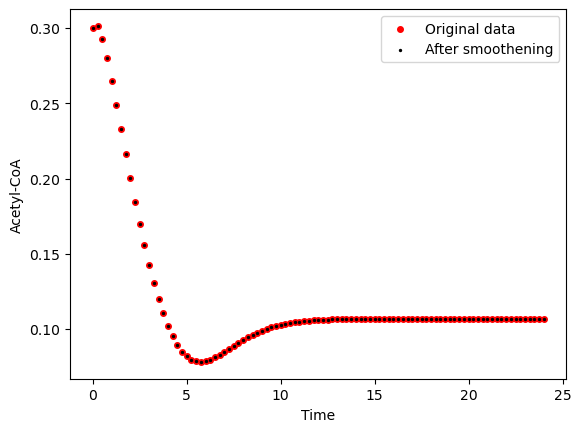

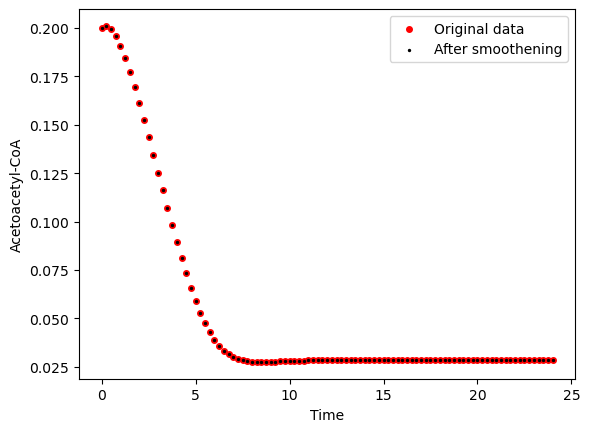

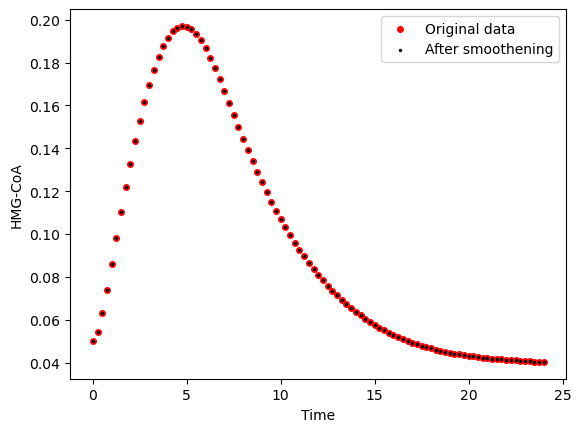

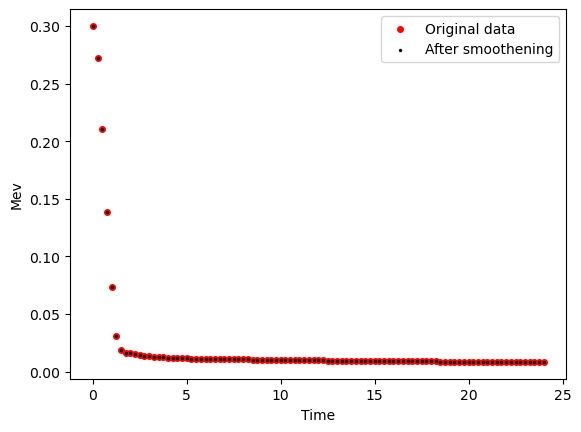

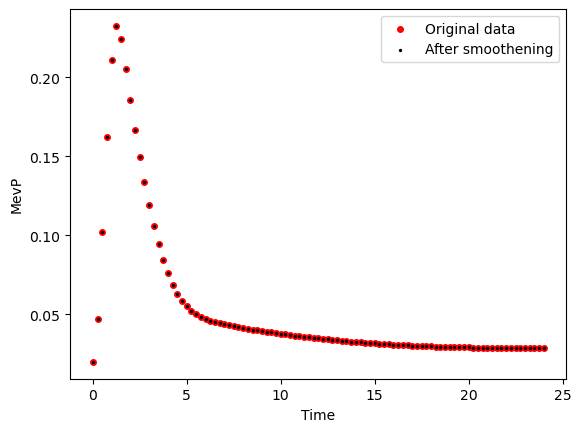

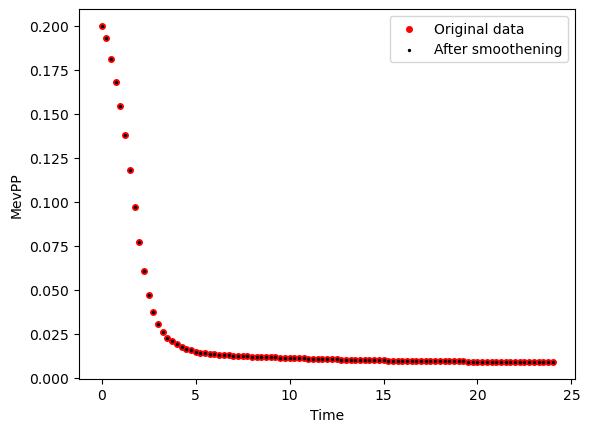

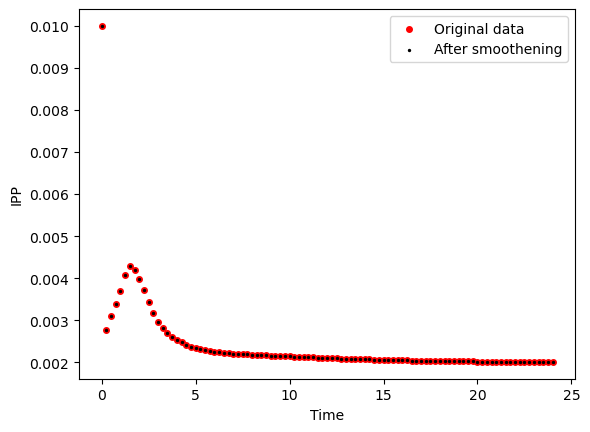

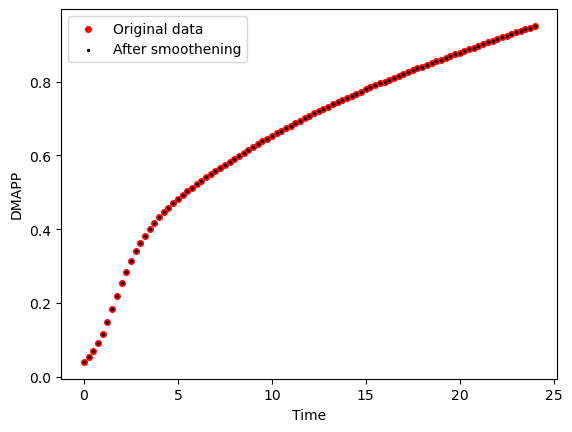

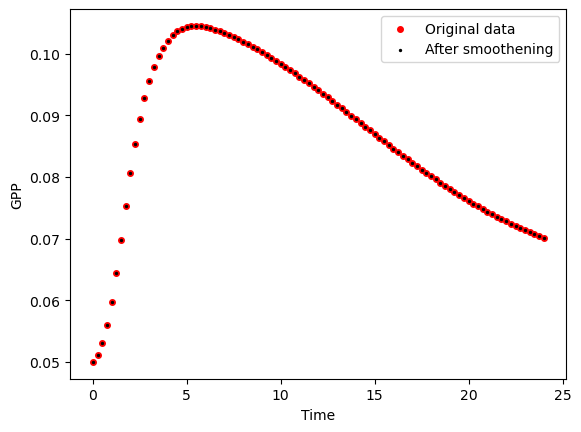

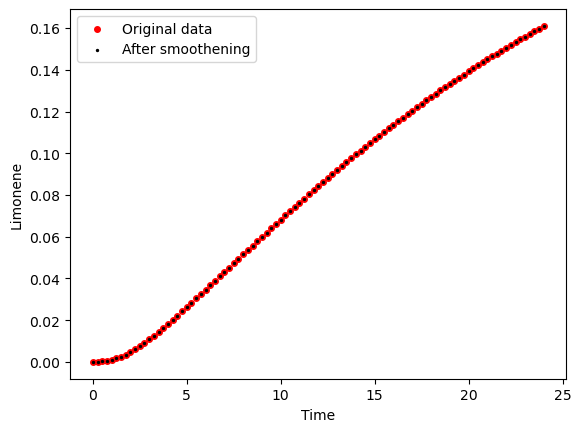

Strain Strain 2


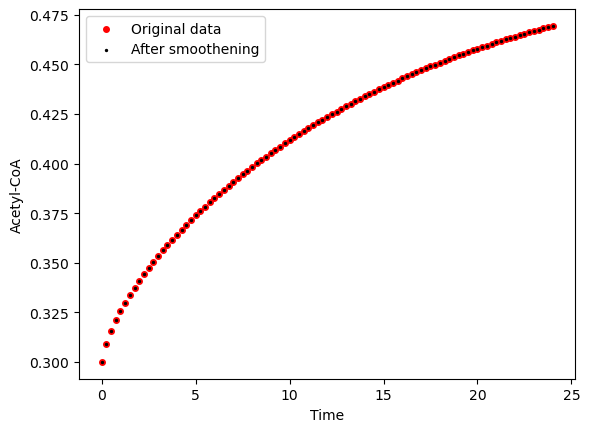

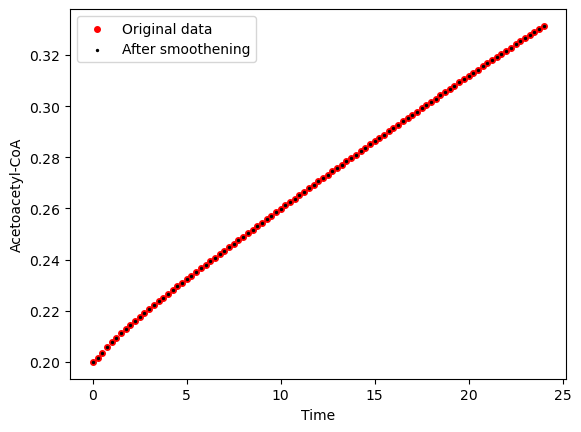

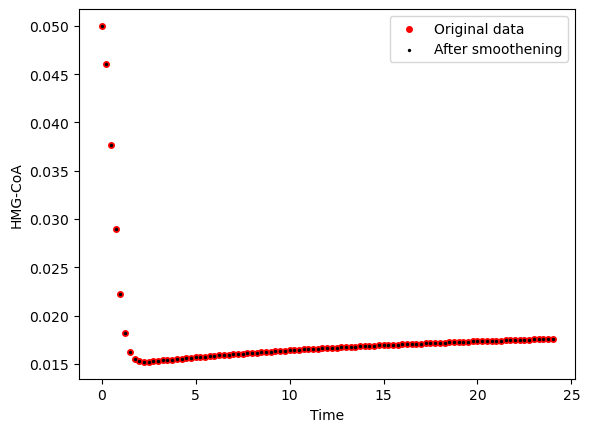

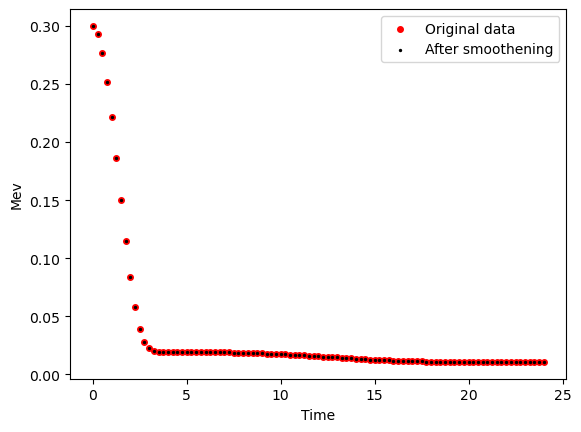

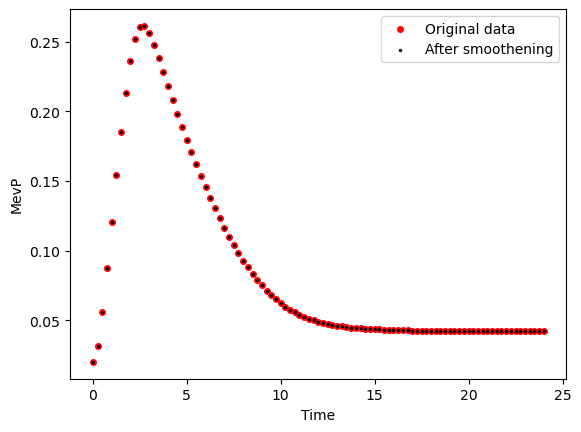

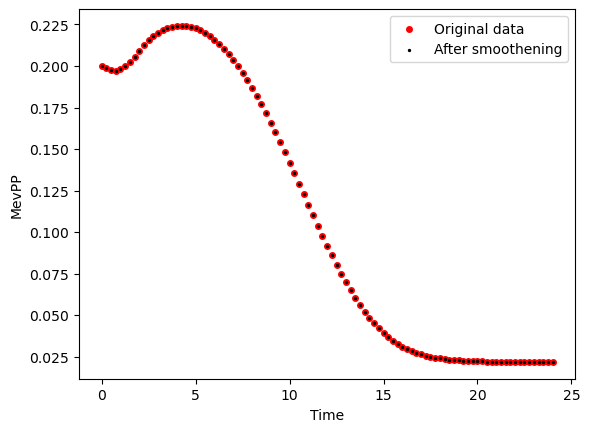

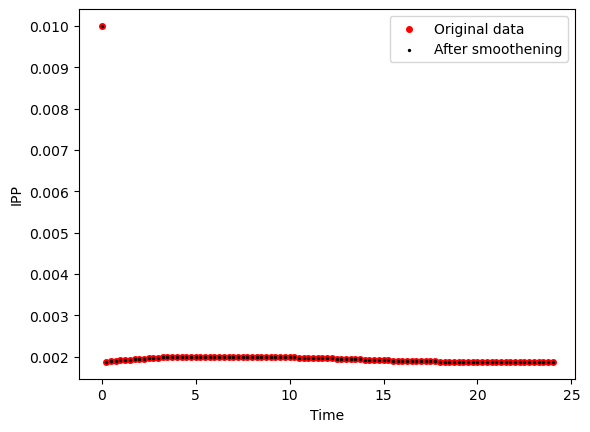

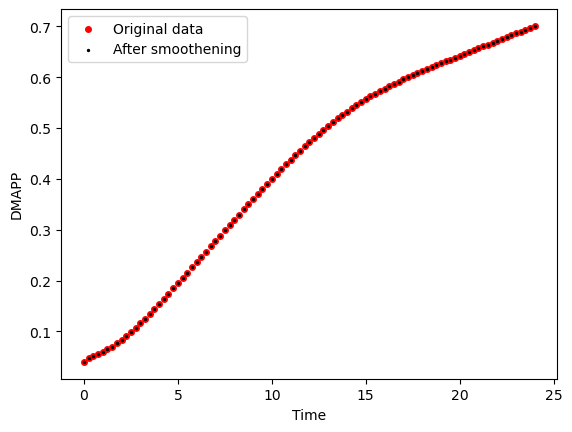

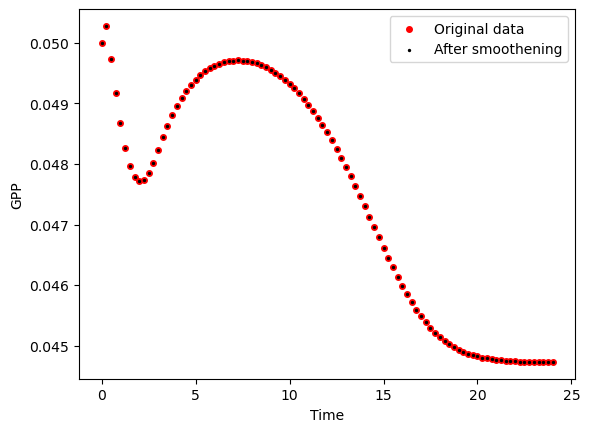

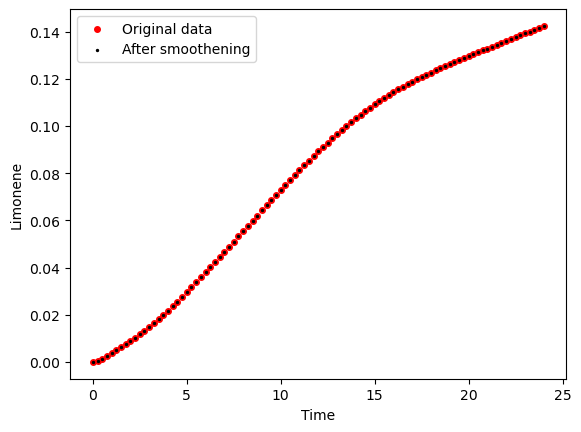

Strain Strain 3


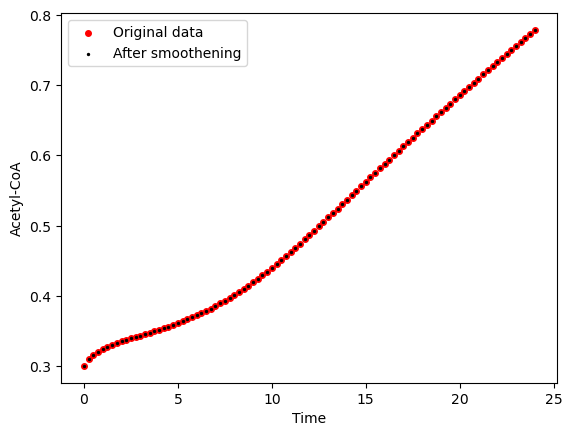

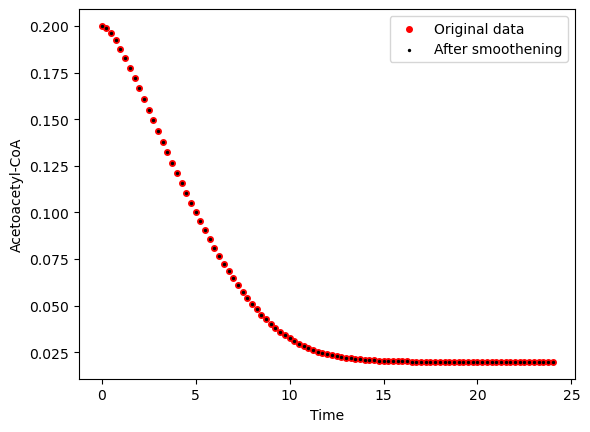

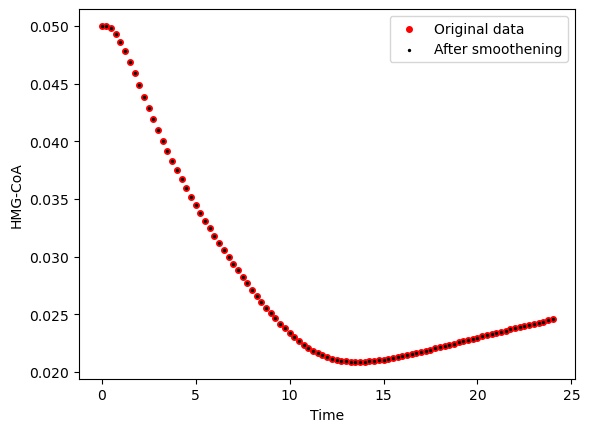

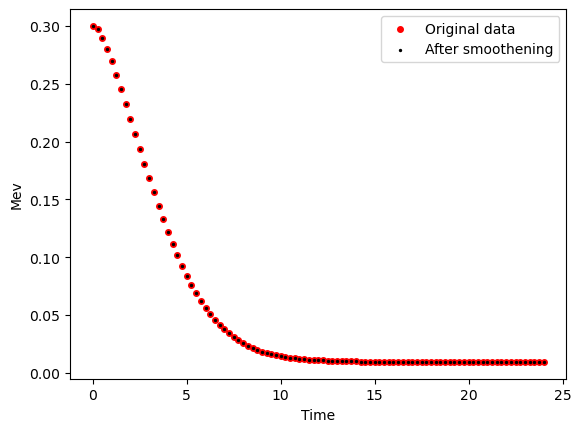

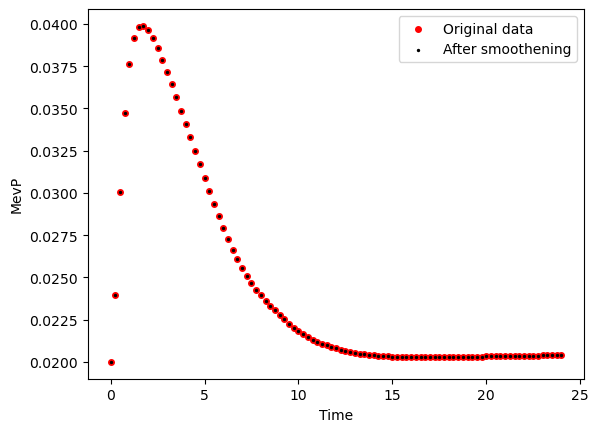

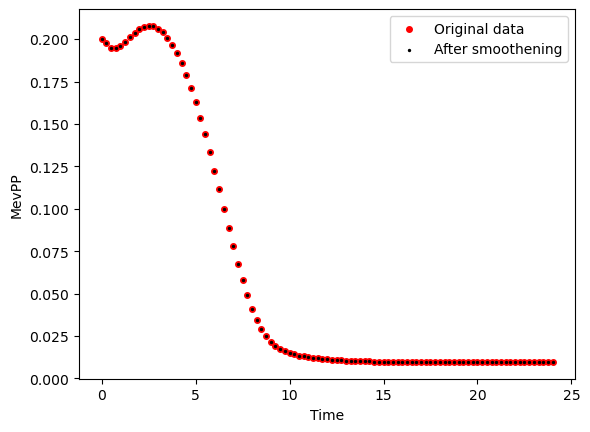

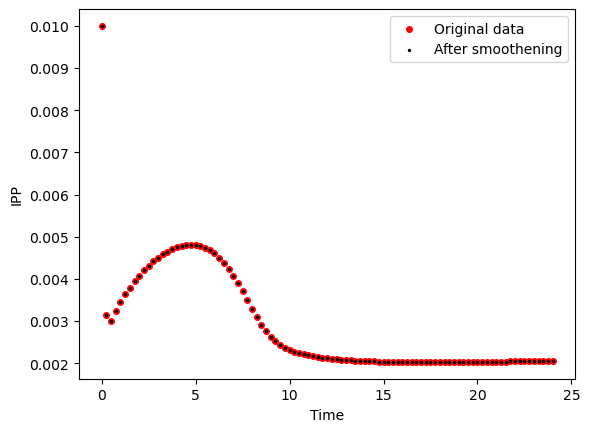

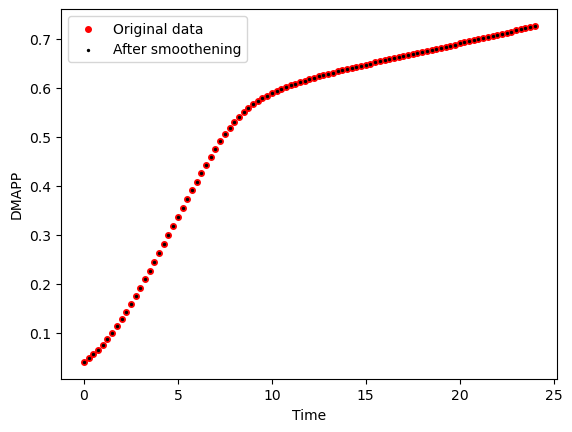

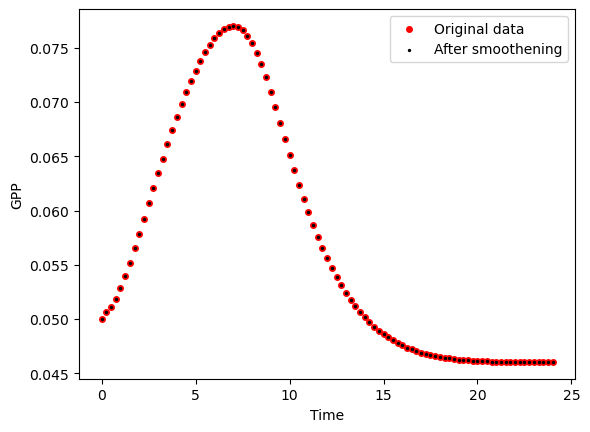

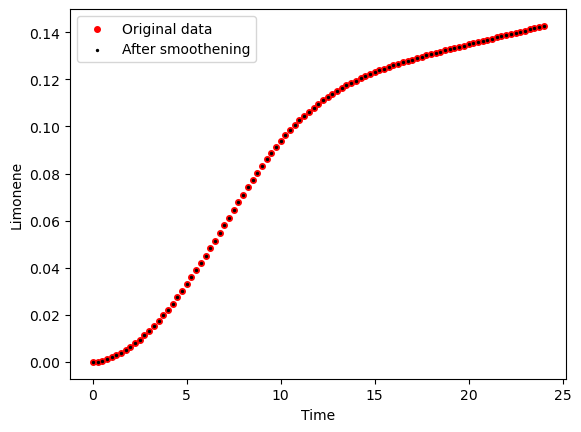

Strain WT


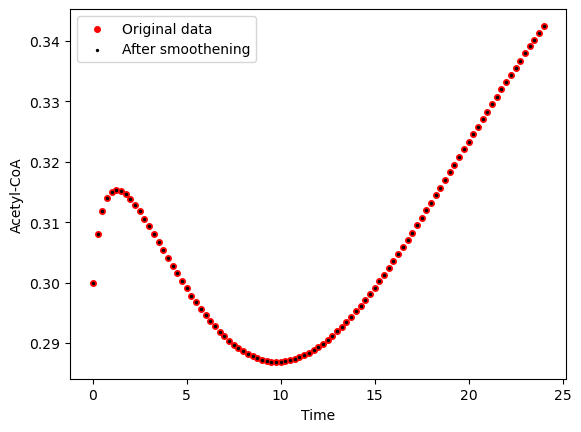

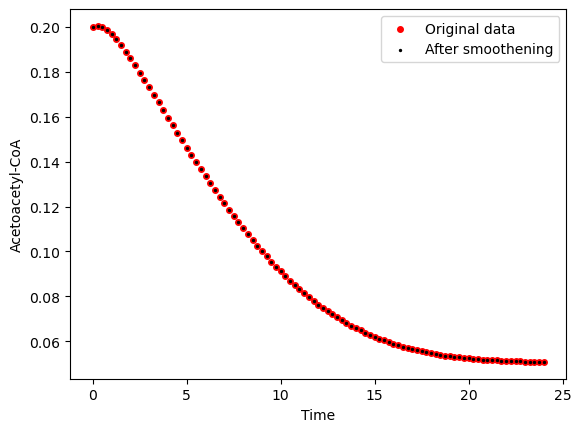

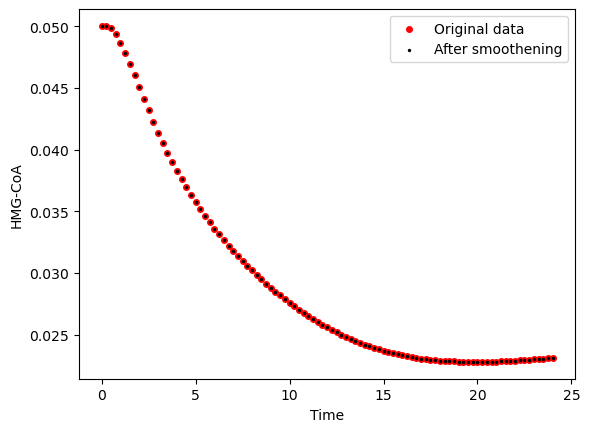

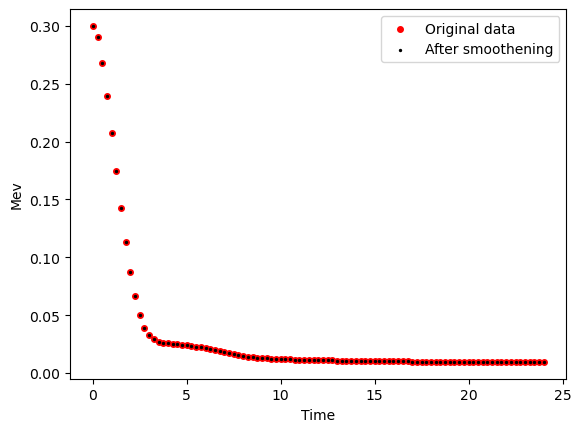

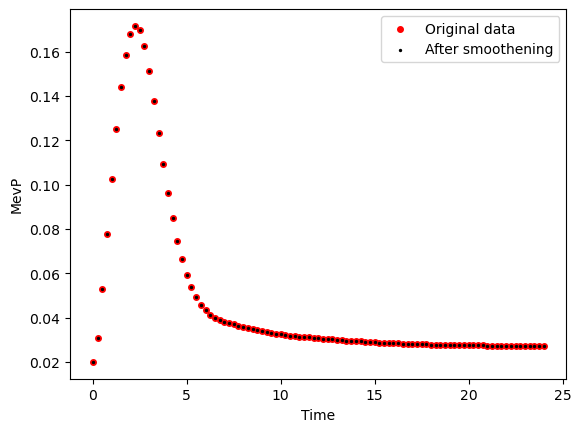

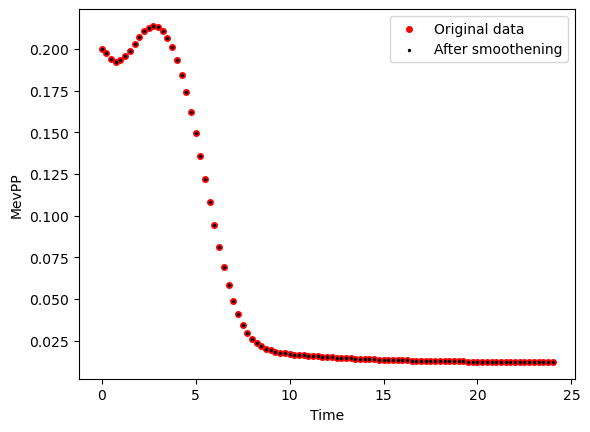

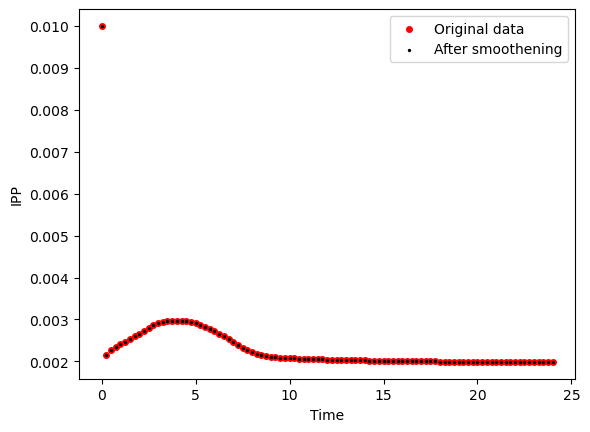

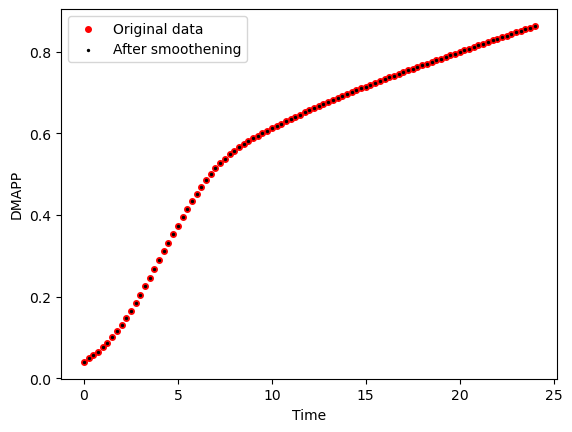

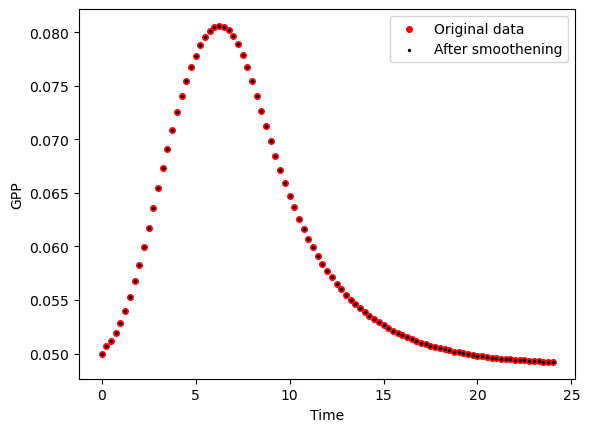

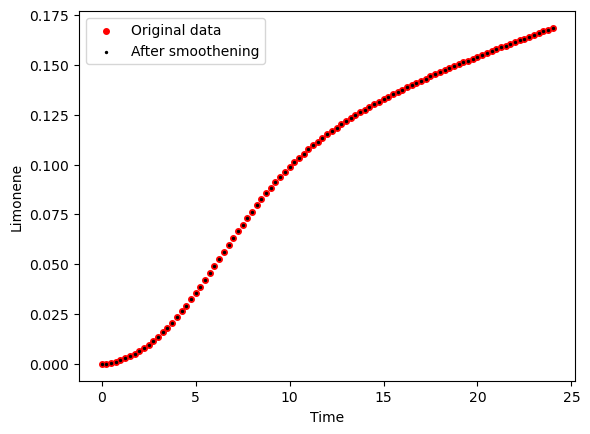

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


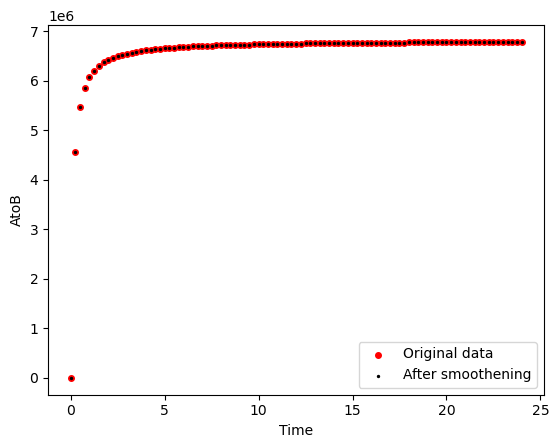

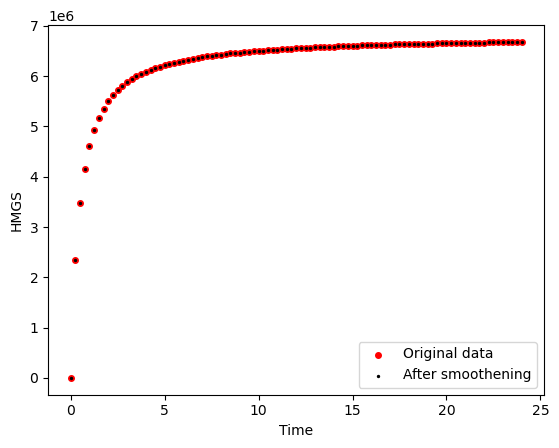

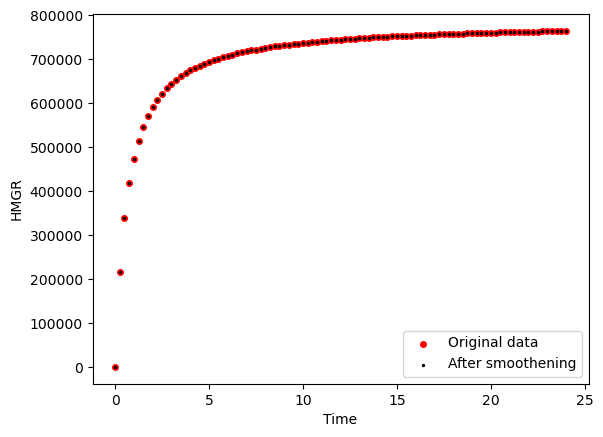

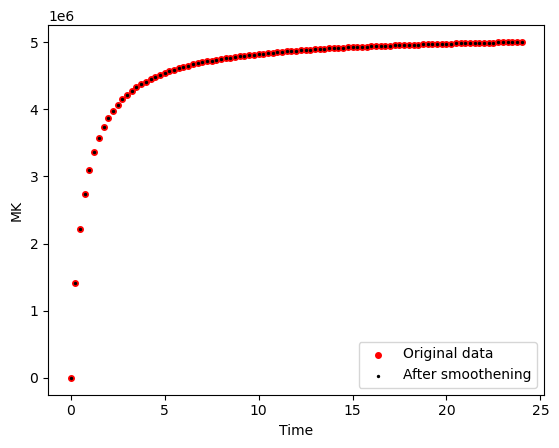

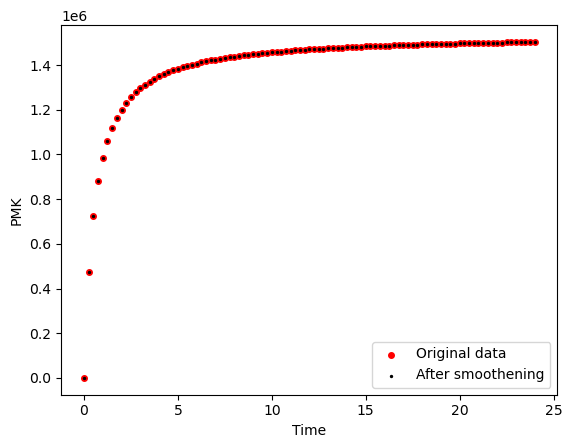

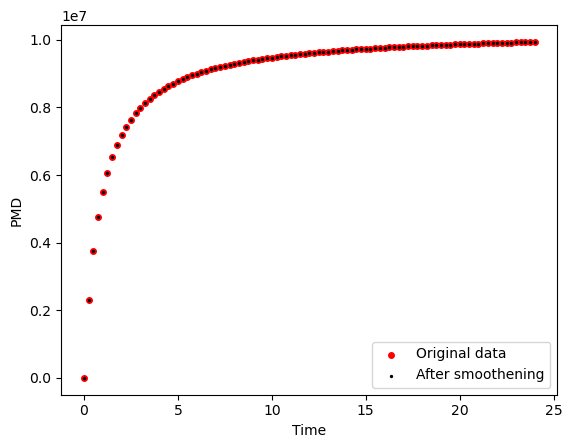

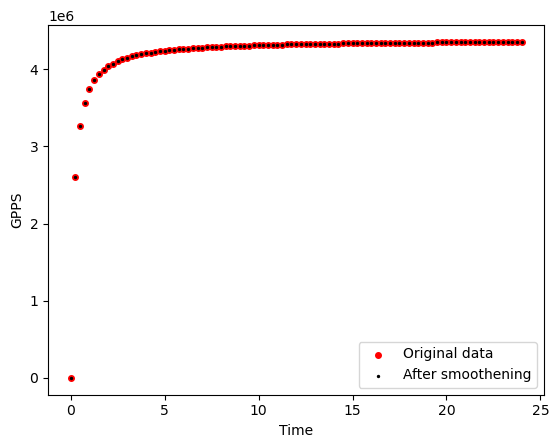

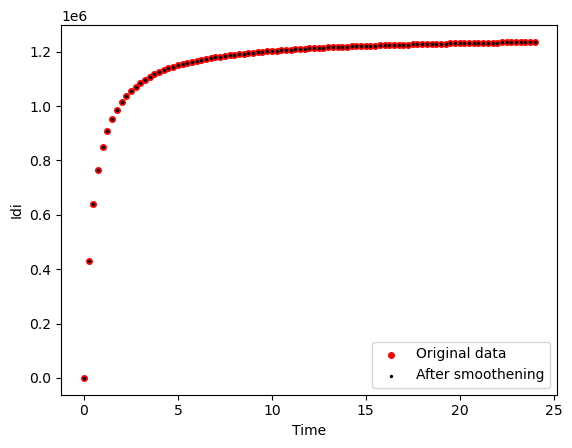

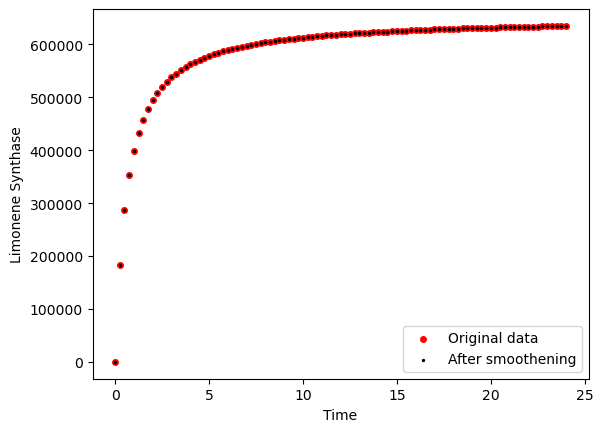

Strain Strain 2


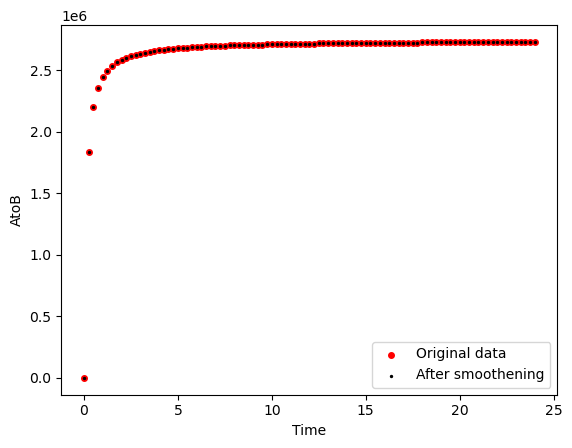

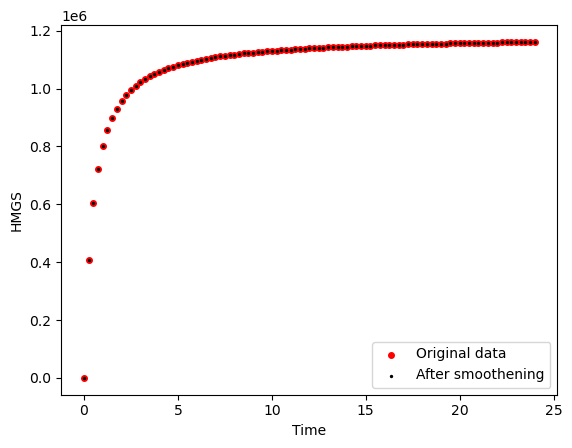

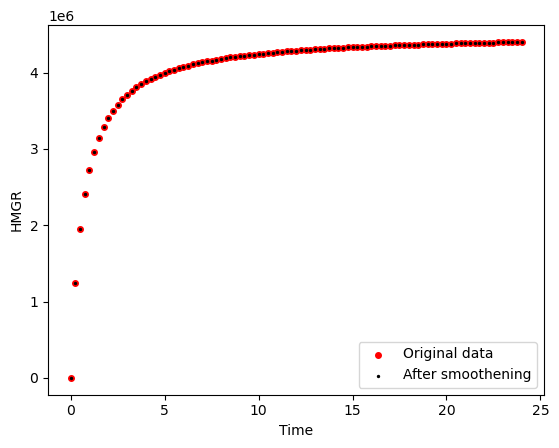

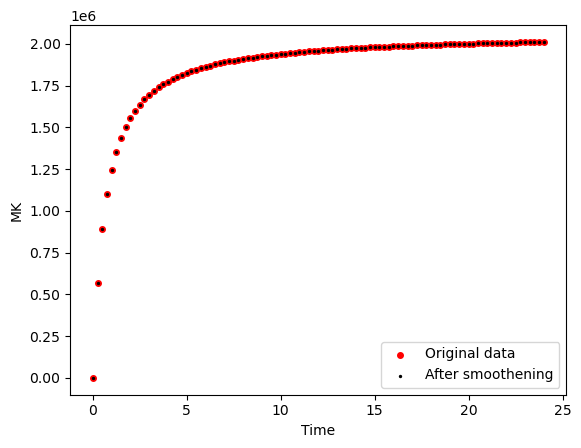

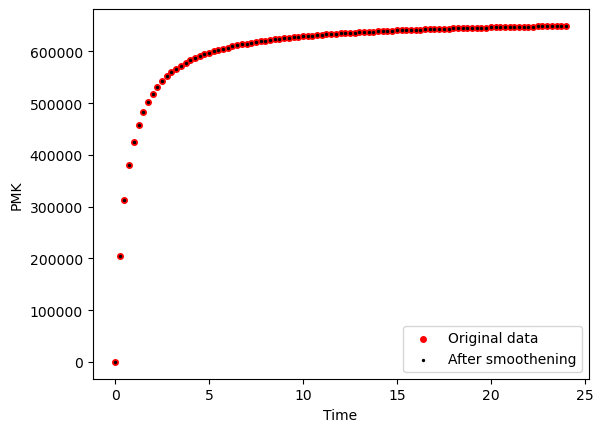

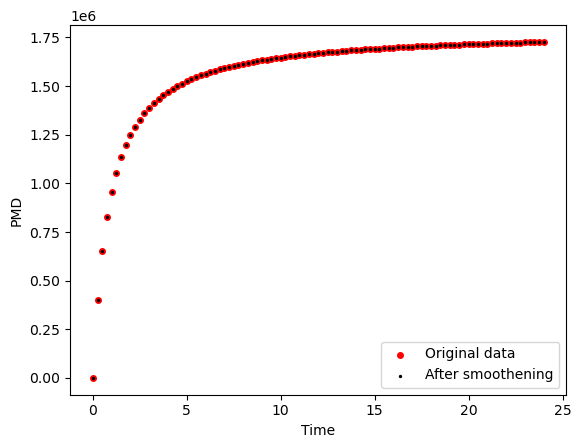

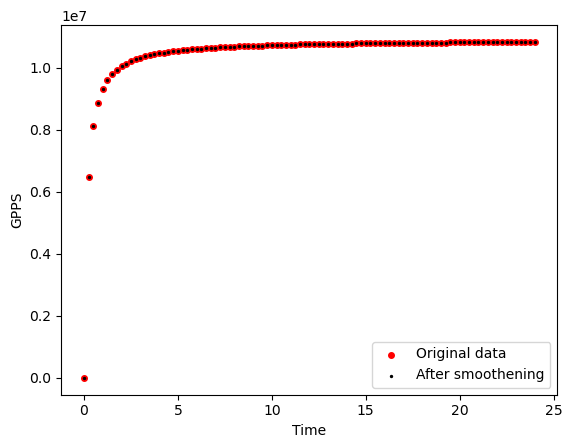

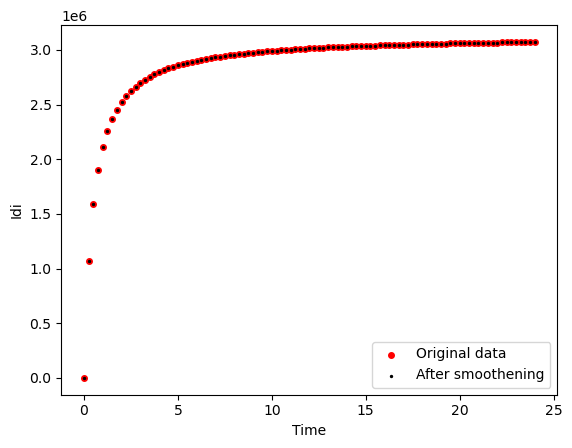

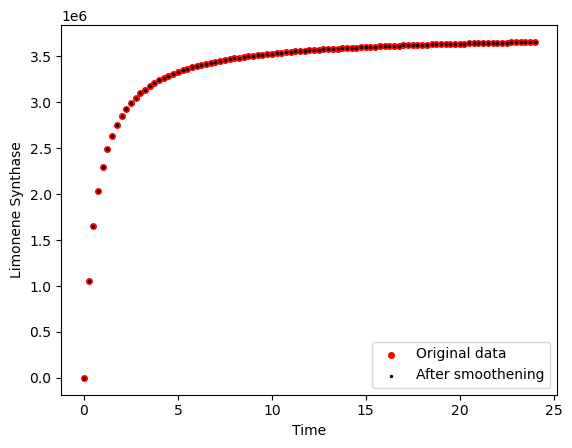

Strain Strain 3


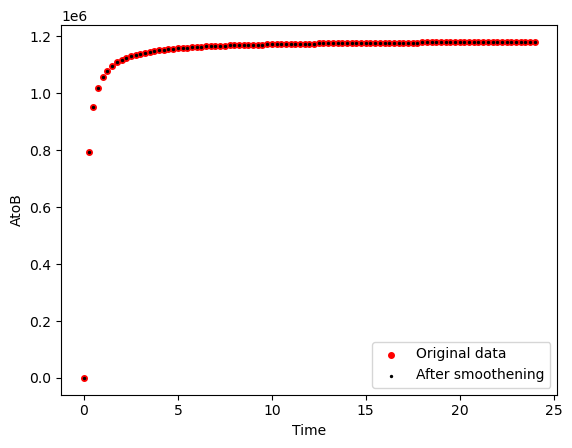

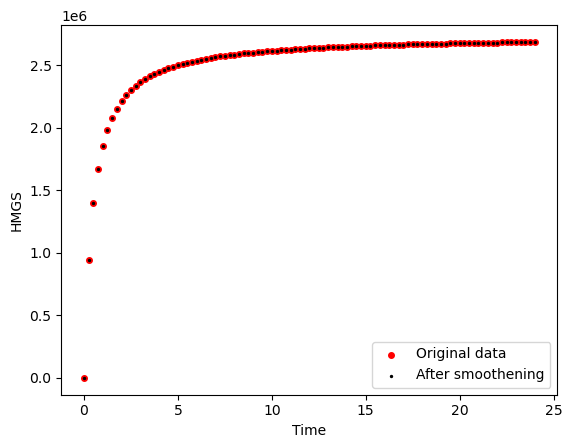

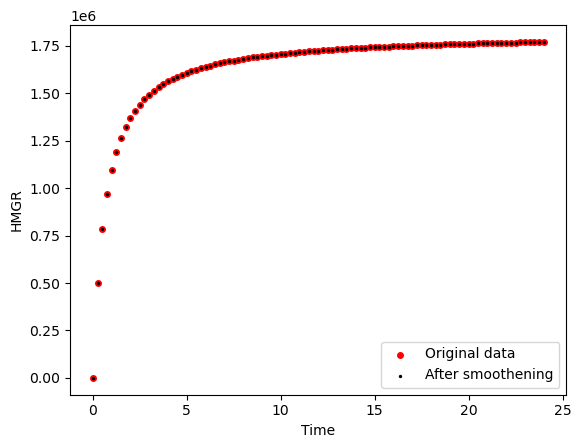

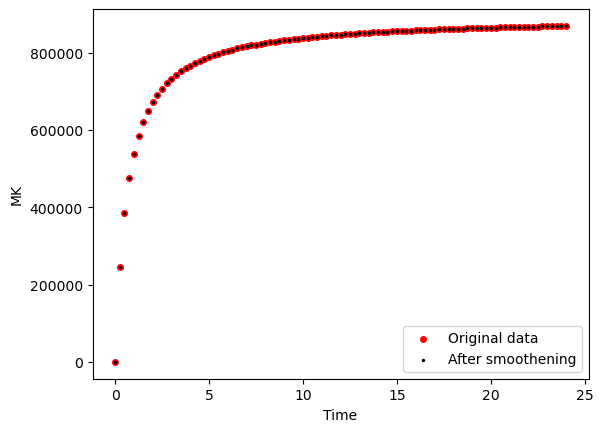

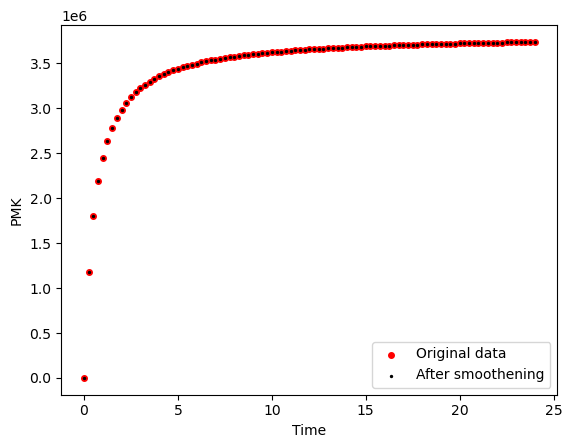

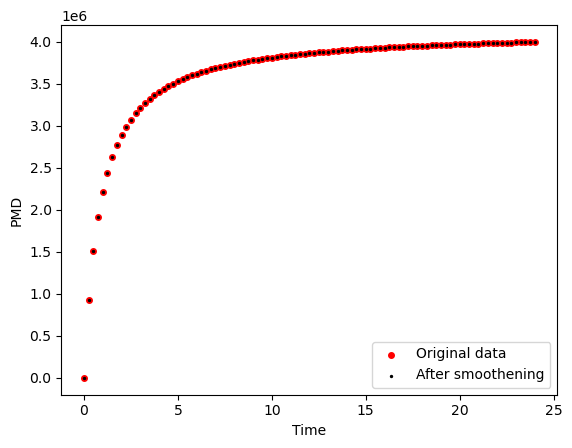

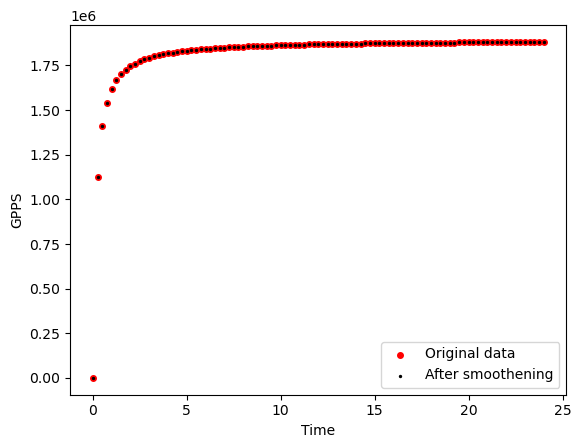

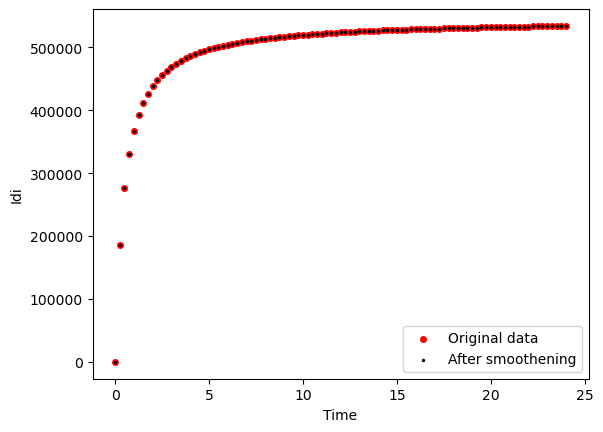

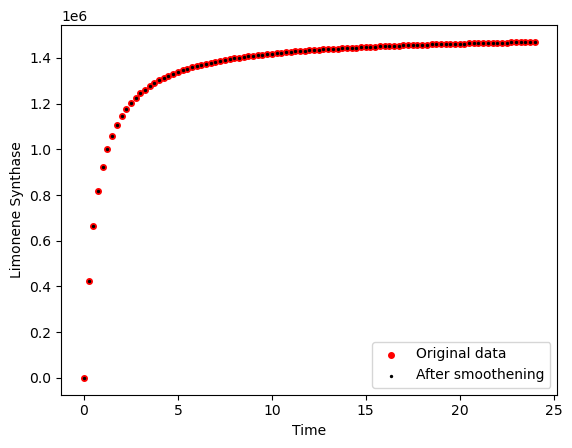

Strain WT


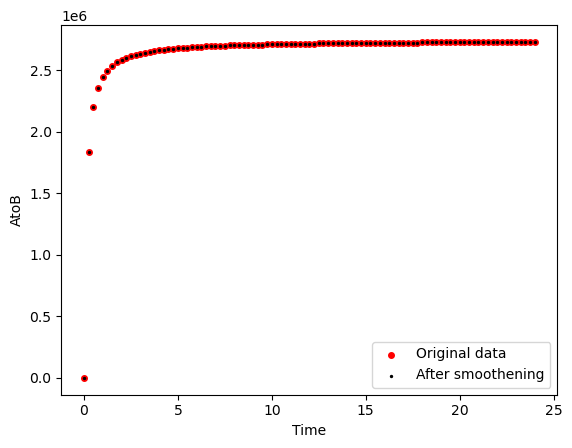

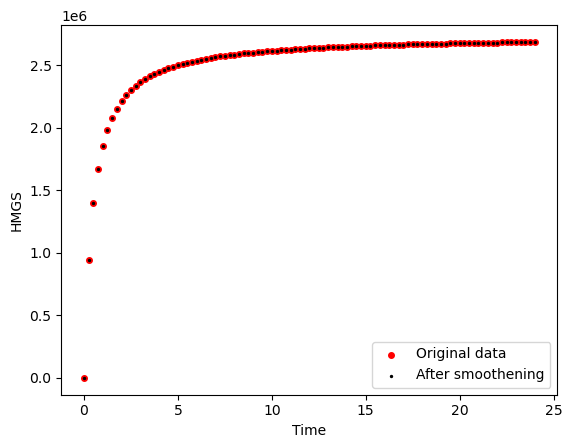

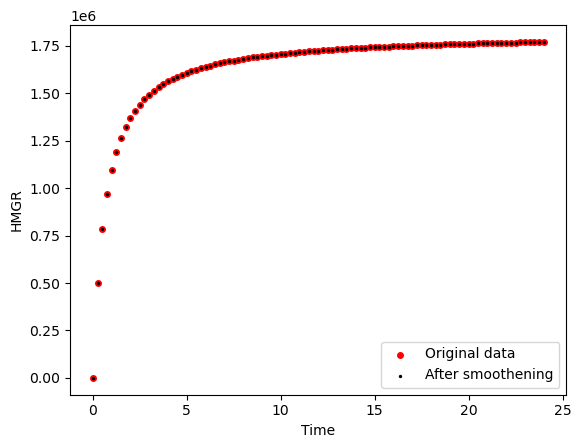

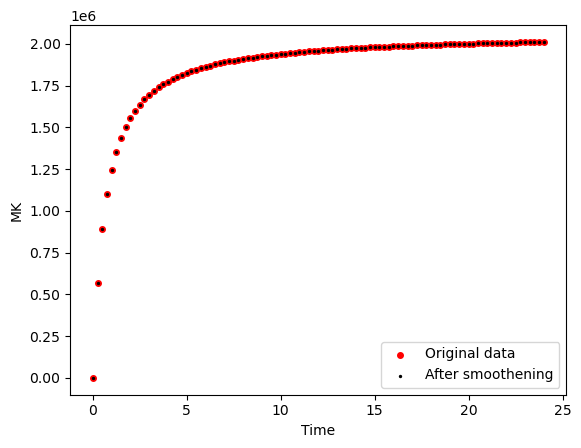

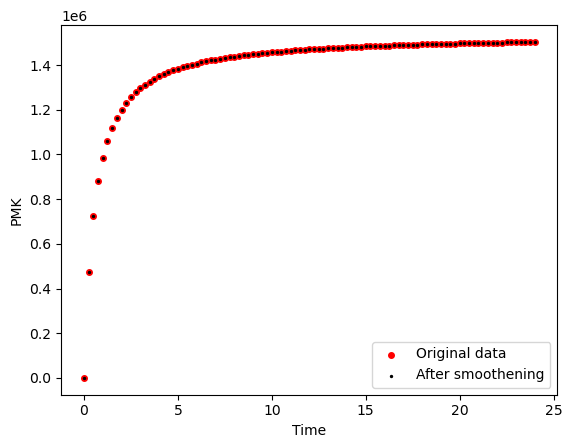

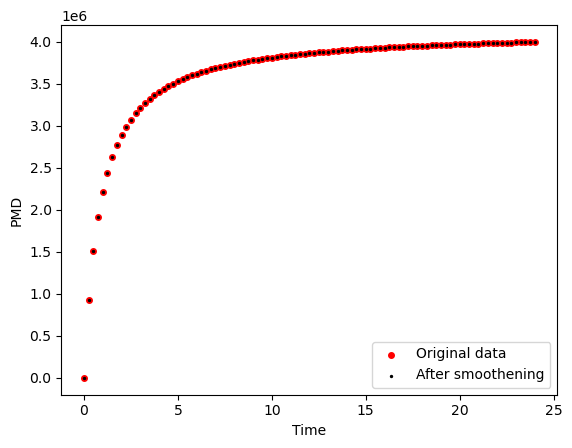

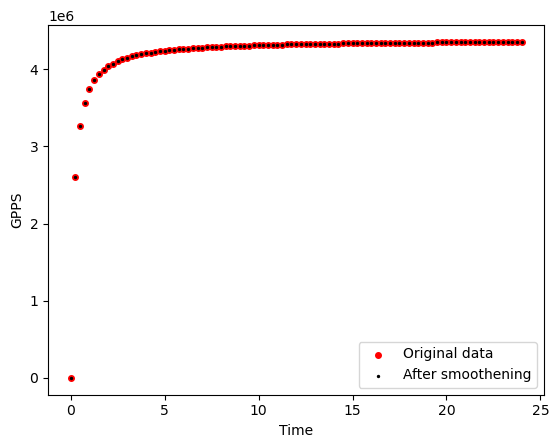

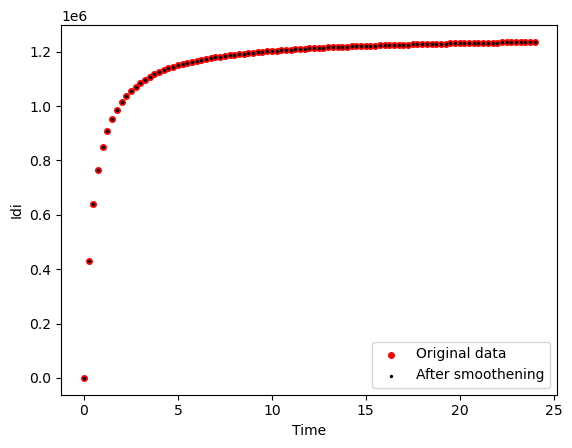

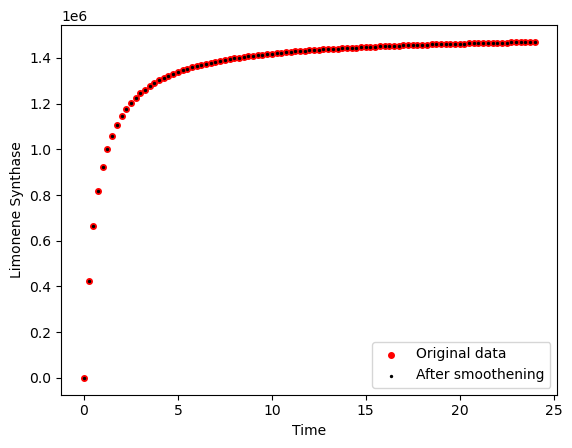

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

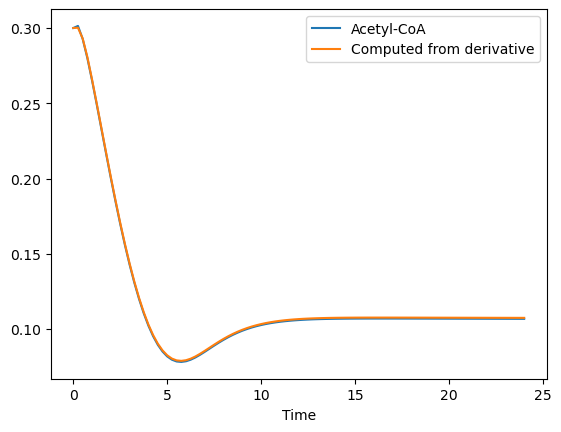

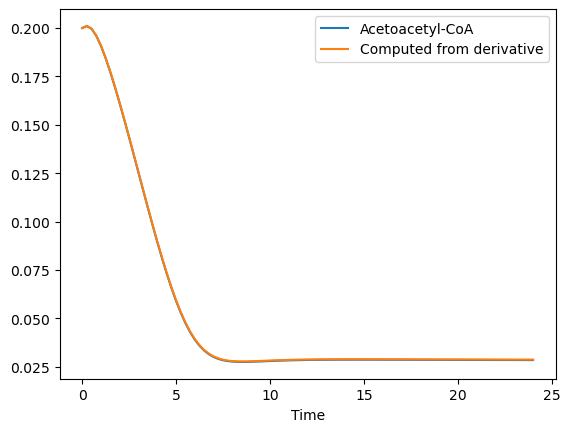

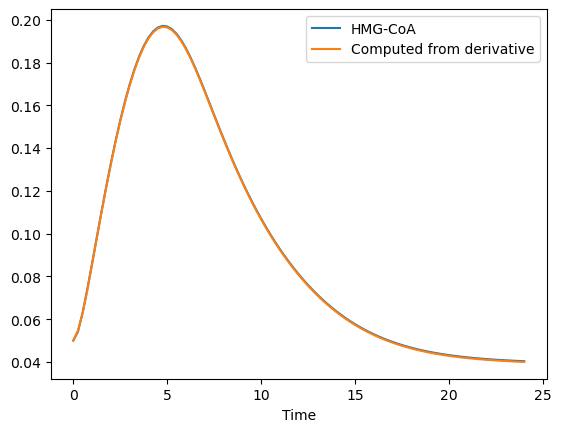

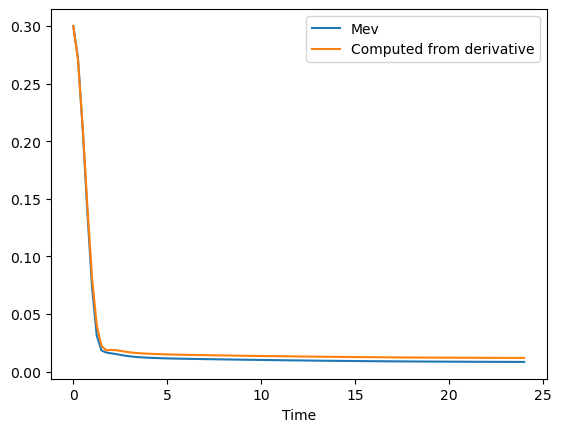

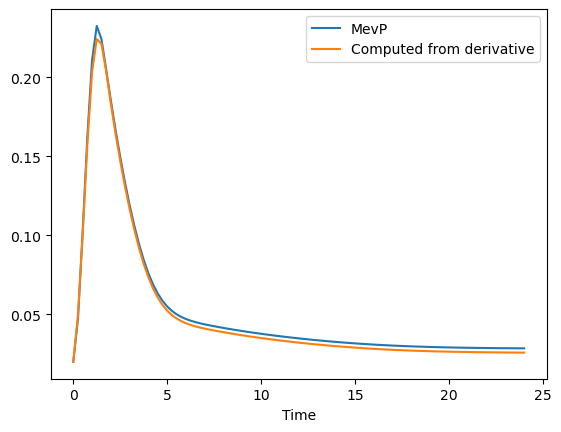

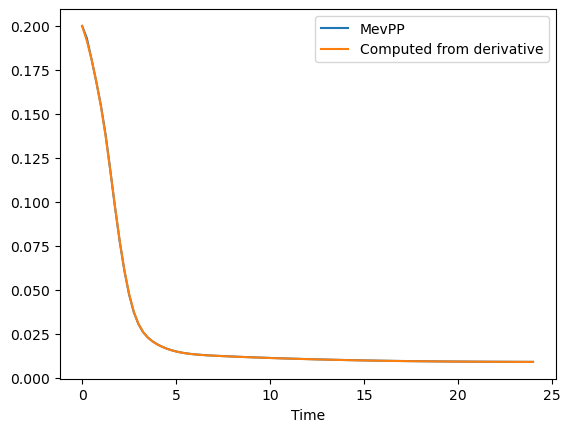

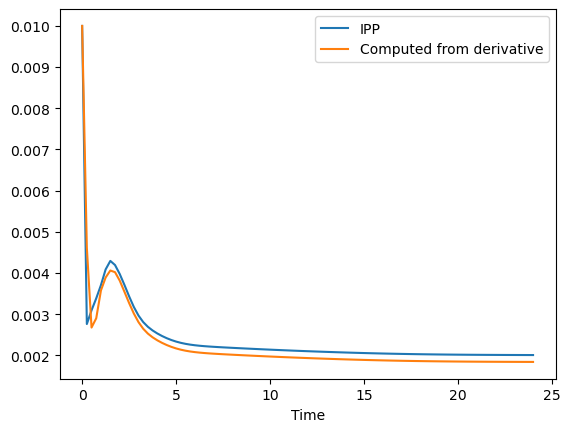

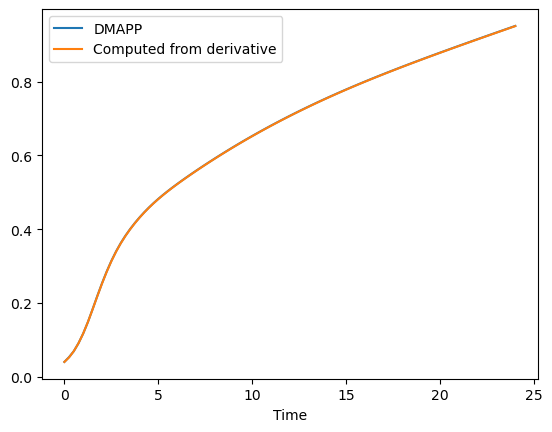

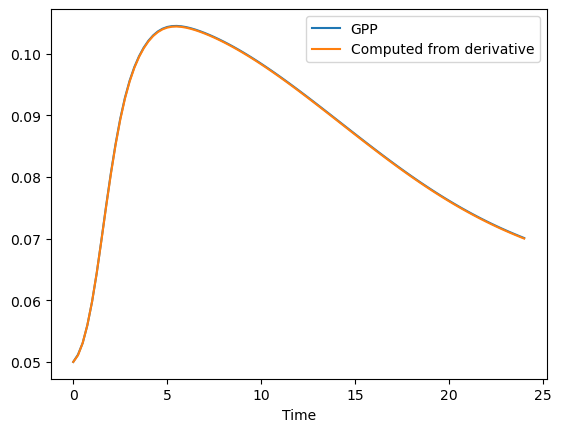

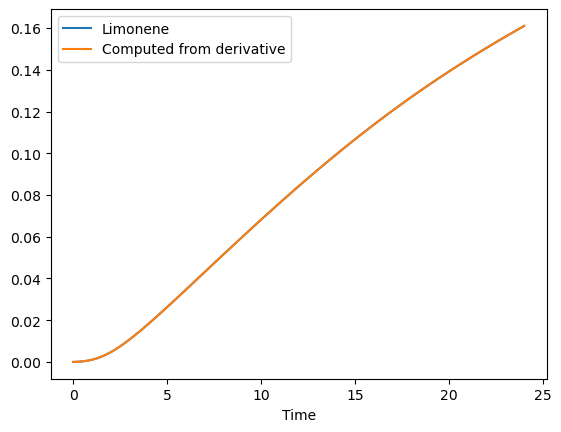

'Time profile from derivative vs. actual profile for Strain 2'

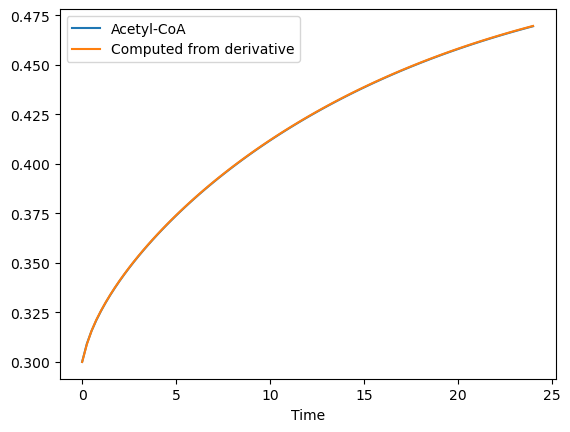

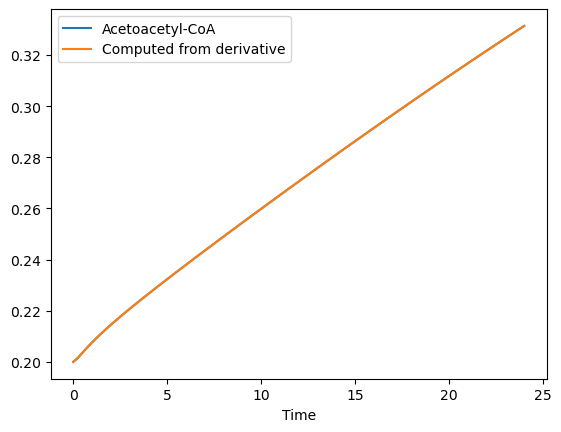

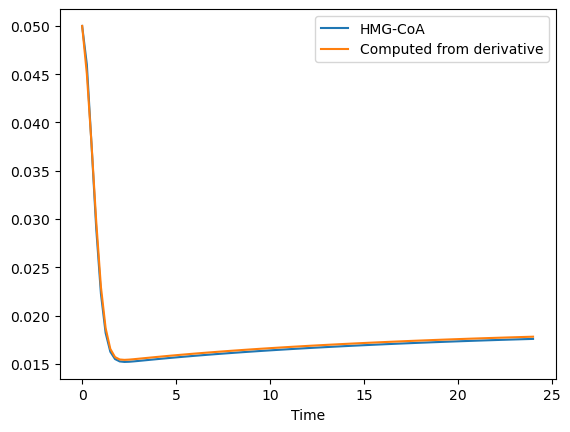

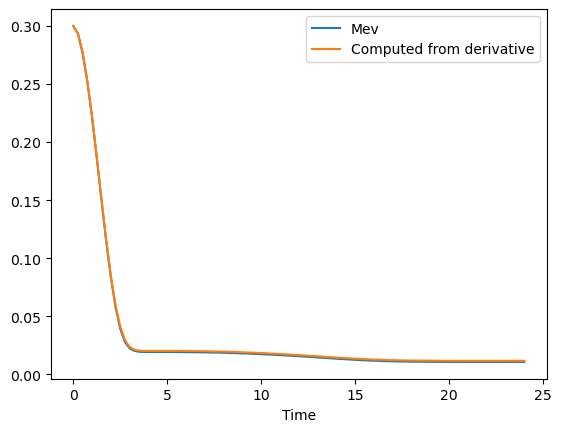

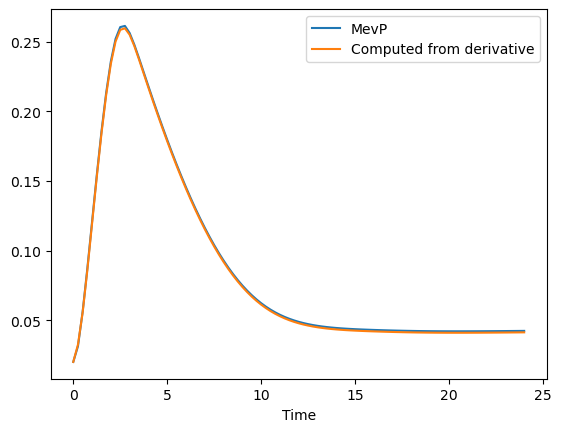

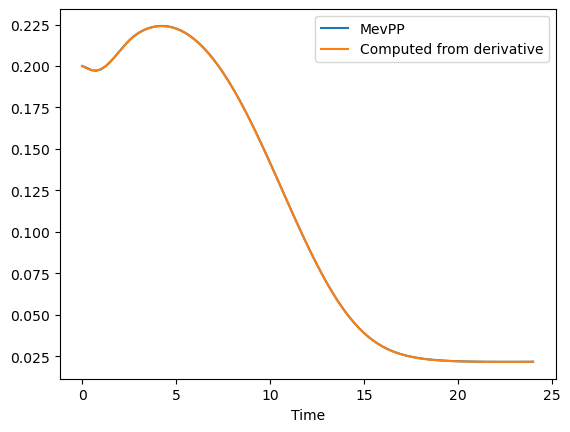

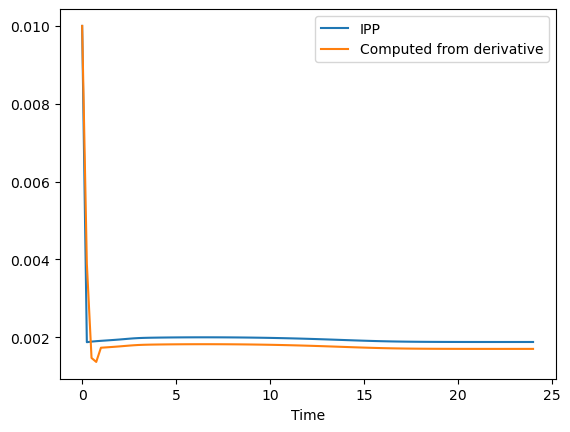

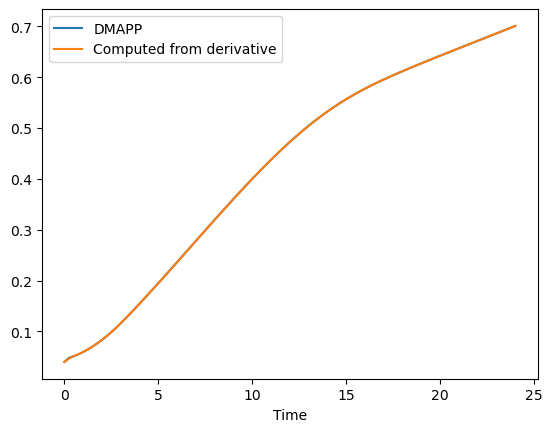

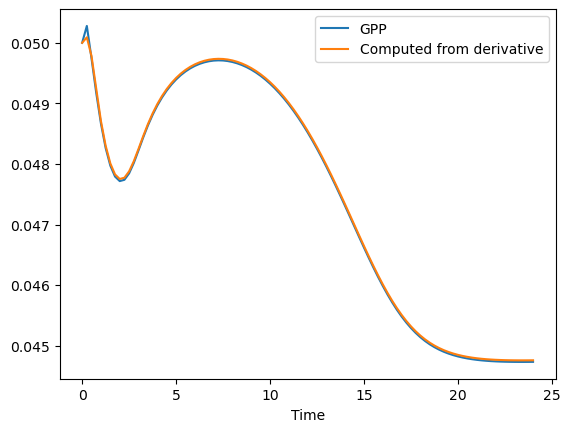

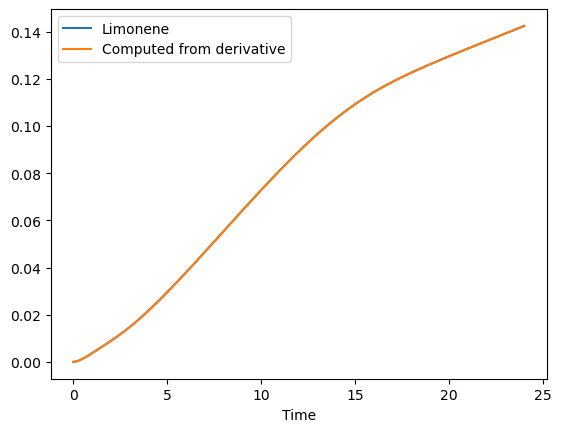

'Time profile from derivative vs. actual profile for Strain 3'

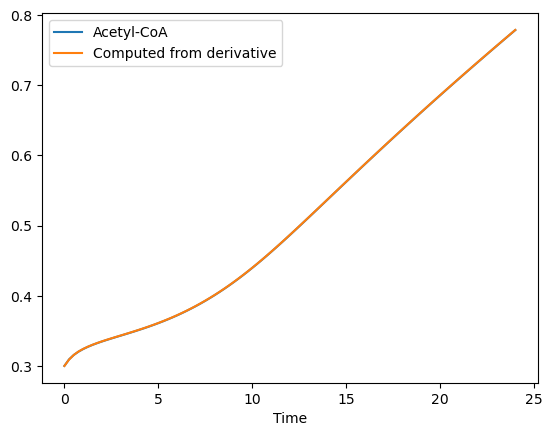

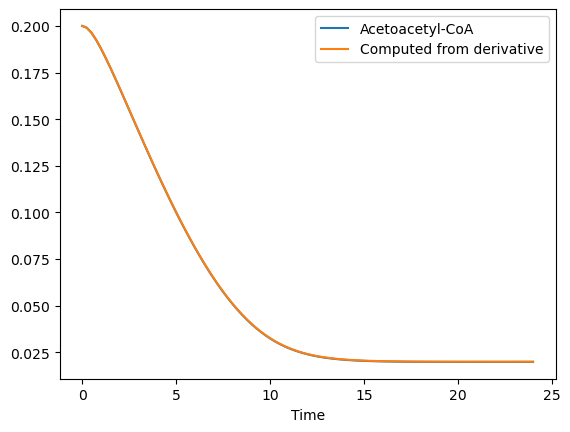

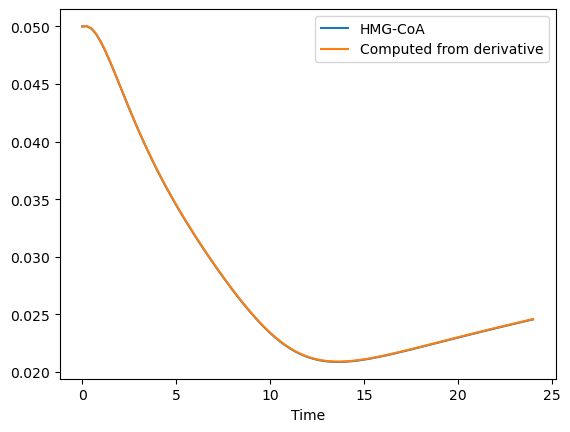

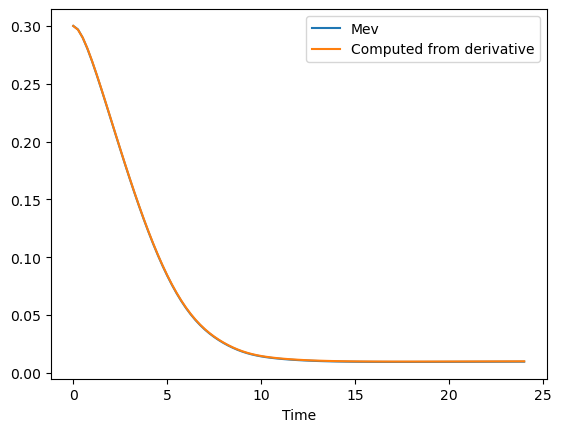

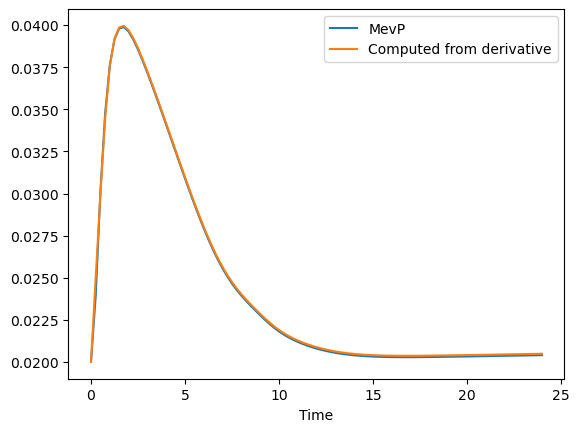

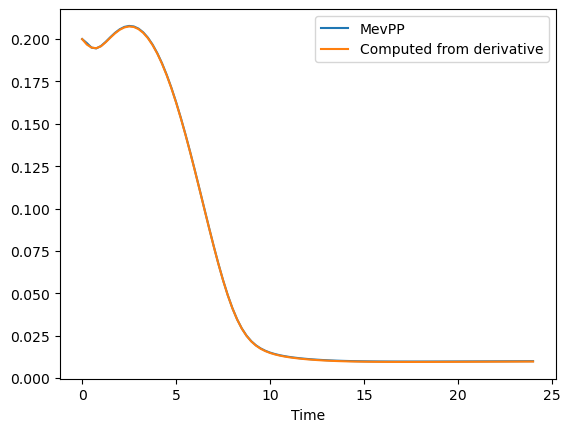

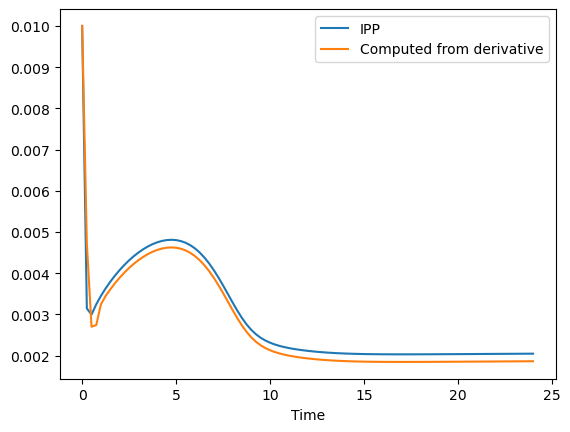

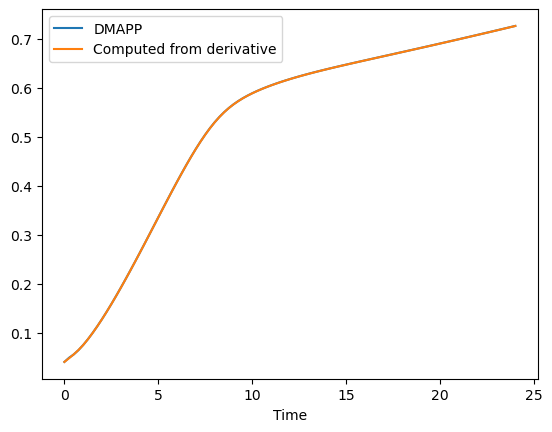

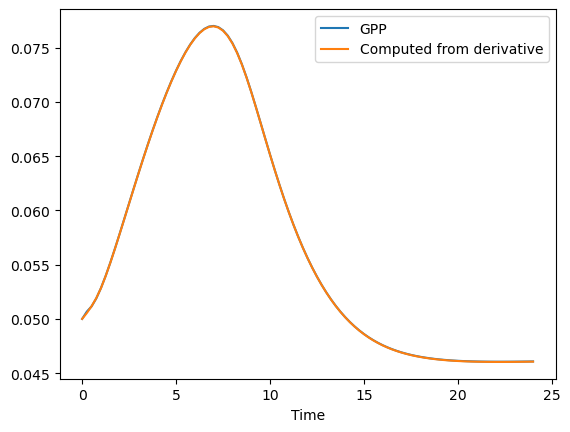

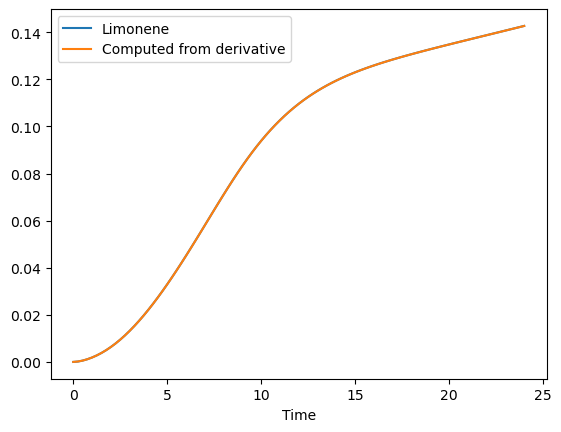

'Time profile from derivative vs. actual profile for WT'

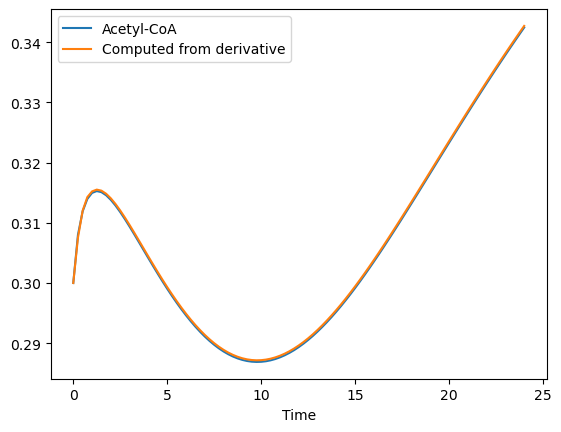

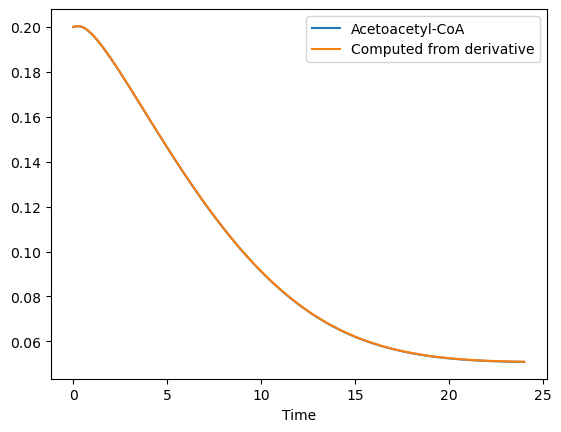

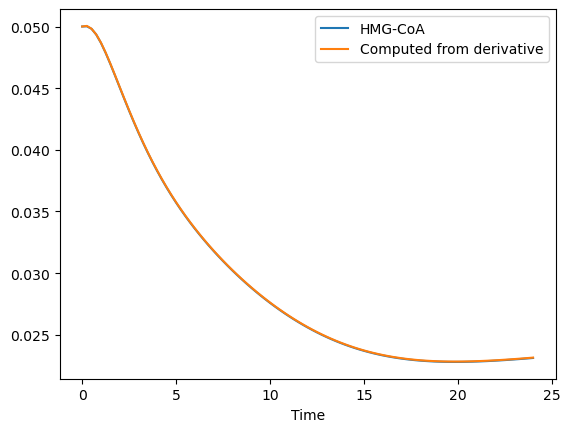

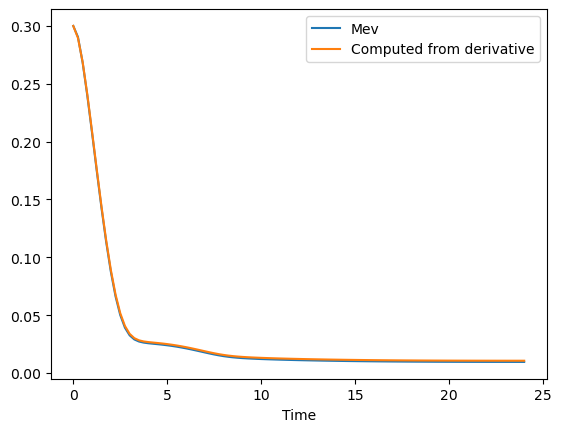

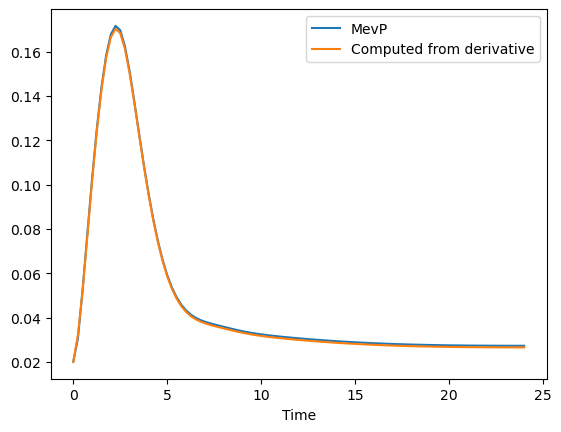

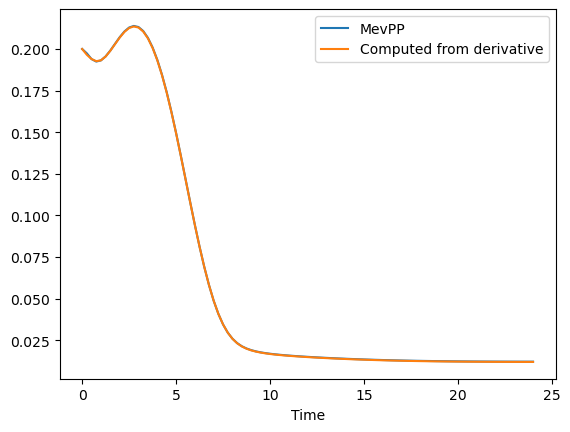

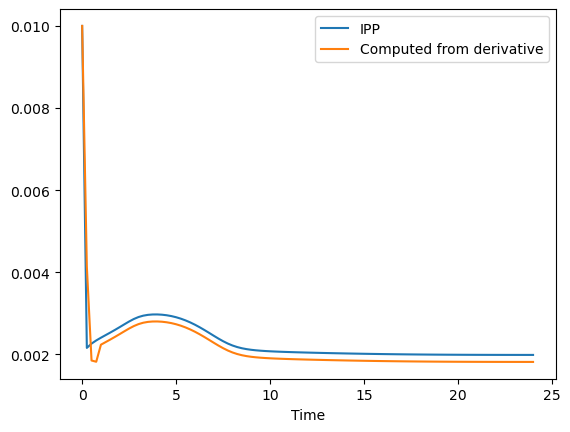

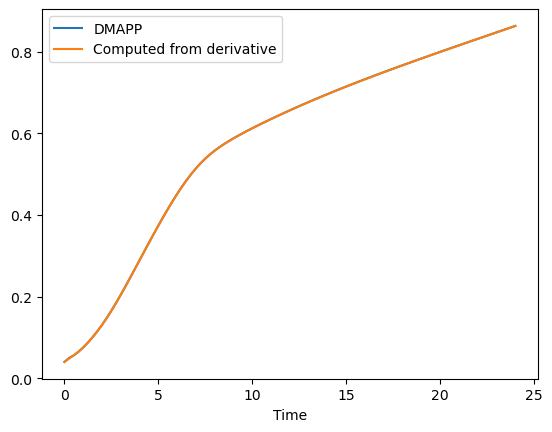

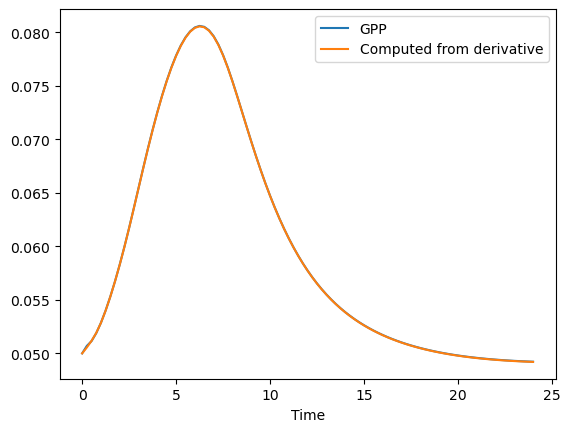

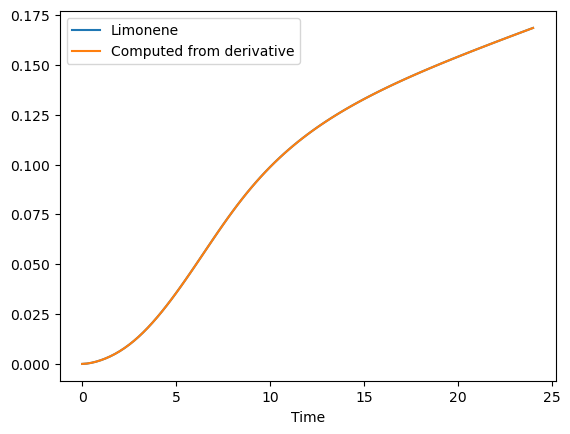

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  9.860935E+17 |  1.140769E+16
     2 |       74 |  8.090395E+15 |  1.697772E+14
     3 |      138 |  2.034035E+15 |  1.566317E+14
     4 |      202 |  2.121473E+14 |  6.974306E+12
     5 |      266 |  6.434851E+13 |  7.752442E+08
     6 |      330 |  2.275060E+11 |  7.752442E+08
     7 |      394 |  3.305281E+10 |  7.752442E+08
     8 |      458 |  5.577191E+10 |  7.752442E+08
     9 |      522 |  1.896340E+11 |  2.525345E+08
    10 |      586 |  6.780037E+10 |  1.858536E+08
    11 |      650 |  1.596791E+10 |  1.858536E+08
    12 |      714 |  6.996872E+09 |  1.858536E+08
    13 |      778 |  3.882113E+09 |  1.858536E+08
    14 |      842 |  1.411172E+10 |  1.858536E+08
    15 |      906 |  2.729258E+09 |  5.380507E+07
    16 |      970 |  1.582155E+09 |  1.500496E+07
    17 |     1034 |  1.893983E+09 |  5.815991E+06
    18 |     1098 |  1.526359E+09 |  5.815991E+06
    19 |     1162 |  2.20

   162 |    10314 |  4.658180E+01 |  4.557566E+01
   163 |    10378 |  4.652286E+01 |  4.557566E+01
   164 |    10442 |  4.659426E+01 |  4.557566E+01
   165 |    10506 |  4.633577E+01 |  4.547435E+01
   166 |    10570 |  4.644674E+01 |  4.547435E+01
   167 |    10634 |  4.633915E+01 |  4.547435E+01
   168 |    10698 |  4.630890E+01 |  4.547435E+01
   169 |    10762 |  4.638599E+01 |  4.547435E+01
   170 |    10826 |  4.618247E+01 |  4.547435E+01
   171 |    10890 |  4.606513E+01 |  4.547435E+01
   172 |    10954 |  4.635173E+01 |  4.547435E+01
   173 |    11018 |  4.616203E+01 |  4.547435E+01
   174 |    11082 |  4.615281E+01 |  4.545270E+01
   175 |    11146 |  4.636688E+01 |  4.545270E+01
   176 |    11210 |  4.610627E+01 |  4.528132E+01
   177 |    11274 |  4.619074E+01 |  4.528132E+01
   178 |    11338 |  4.620183E+01 |  4.528132E+01
   179 |    11402 |  4.601727E+01 |  4.528132E+01
   180 |    11466 |  4.593039E+01 |  4.528132E+01
   181 |    11530 |  4.580966E+01 |  4.528132E+01


   326 |    20810 |  2.727185E+01 |  2.679766E+01
   327 |    20874 |  2.723925E+01 |  2.679324E+01
   328 |    20938 |  2.715440E+01 |  2.679324E+01
   329 |    21002 |  2.693990E+01 |  2.673847E+01
   330 |    21066 |  2.682211E+01 |  2.638785E+01
   331 |    21130 |  2.660872E+01 |  2.638785E+01
   332 |    21194 |  2.641616E+01 |  2.622830E+01
   333 |    21258 |  2.624593E+01 |  2.591107E+01
   334 |    21322 |  2.594230E+01 |  2.581231E+01
   335 |    21386 |  2.580217E+01 |  2.568663E+01
   336 |    21450 |  2.579897E+01 |  2.563882E+01
   337 |    21514 |  2.574816E+01 |  2.545565E+01
   338 |    21578 |  2.559230E+01 |  2.532937E+01
   339 |    21642 |  2.540192E+01 |  2.523538E+01
   340 |    21706 |  2.540315E+01 |  2.523538E+01
   341 |    21770 |  2.530063E+01 |  2.518142E+01
   342 |    21834 |  2.528963E+01 |  2.514796E+01
   343 |    21898 |  2.530681E+01 |  2.514796E+01
   344 |    21962 |  2.531579E+01 |  2.509369E+01
   345 |    22026 |  2.533262E+01 |  2.509369E+01


   490 |    31306 |  2.305008E+01 |  2.304138E+01
   491 |    31370 |  2.304429E+01 |  2.303536E+01
   492 |    31434 |  2.304024E+01 |  2.303177E+01
   493 |    31498 |  2.303214E+01 |  2.302714E+01
   494 |    31562 |  2.303115E+01 |  2.301622E+01
   495 |    31626 |  2.303061E+01 |  2.301622E+01
   496 |    31690 |  2.302642E+01 |  2.301622E+01
   497 |    31754 |  2.302431E+01 |  2.301622E+01
   498 |    31818 |  2.301688E+01 |  2.300336E+01
   499 |    31882 |  2.301205E+01 |  2.299911E+01
   500 |    31946 |  2.300421E+01 |  2.299537E+01
   501 |    32010 |  2.299857E+01 |  2.299277E+01
   502 |    32074 |  2.299291E+01 |  2.298576E+01
   503 |    32138 |  2.298879E+01 |  2.298243E+01
   504 |    32202 |  2.298597E+01 |  2.297774E+01
   505 |    32266 |  2.298453E+01 |  2.297774E+01
   506 |    32330 |  2.298147E+01 |  2.296602E+01
   507 |    32394 |  2.297898E+01 |  2.296602E+01
   508 |    32458 |  2.297207E+01 |  2.296369E+01
   509 |    32522 |  2.296779E+01 |  2.296090E+01


   654 |    41802 |  2.269948E+01 |  2.269657E+01
   655 |    41866 |  2.269932E+01 |  2.269187E+01
   656 |    41930 |  2.269265E+01 |  2.268334E+01
   657 |    41994 |  2.268450E+01 |  2.267368E+01
   658 |    42058 |  2.267761E+01 |  2.267206E+01
   659 |    42122 |  2.267246E+01 |  2.266780E+01
   660 |    42186 |  2.266838E+01 |  2.266227E+01
   661 |    42250 |  2.266437E+01 |  2.265833E+01
   662 |    42314 |  2.265473E+01 |  2.263783E+01
   663 |    42378 |  2.264258E+01 |  2.263783E+01
   664 |    42442 |  2.264030E+01 |  2.263442E+01
   665 |    42506 |  2.263545E+01 |  2.262680E+01
   666 |    42570 |  2.263256E+01 |  2.261209E+01
   667 |    42634 |  2.262074E+01 |  2.259545E+01
   668 |    42698 |  2.258952E+01 |  2.254125E+01
   669 |    42762 |  2.255004E+01 |  2.253230E+01
   670 |    42826 |  2.253761E+01 |  2.253230E+01
   671 |    42890 |  2.253388E+01 |  2.251256E+01
   672 |    42954 |  2.252164E+01 |  2.250949E+01
   673 |    43018 |  2.251253E+01 |  2.249918E+01


   818 |    52298 |  2.206545E+01 |  2.205622E+01
   819 |    52362 |  2.206897E+01 |  2.205311E+01
   820 |    52426 |  2.206179E+01 |  2.203919E+01
   821 |    52490 |  2.204852E+01 |  2.202835E+01
   822 |    52554 |  2.203950E+01 |  2.202623E+01
   823 |    52618 |  2.203371E+01 |  2.202304E+01
   824 |    52682 |  2.202768E+01 |  2.202253E+01
   825 |    52746 |  2.201907E+01 |  2.200024E+01
   826 |    52810 |  2.200530E+01 |  2.197473E+01
   827 |    52874 |  2.200297E+01 |  2.197473E+01
   828 |    52938 |  2.200083E+01 |  2.197473E+01
   829 |    53002 |  2.199498E+01 |  2.197473E+01
   830 |    53066 |  2.198886E+01 |  2.197120E+01
   831 |    53130 |  2.197550E+01 |  2.194447E+01
   832 |    53194 |  2.195657E+01 |  2.193625E+01
   833 |    53258 |  2.194940E+01 |  2.193464E+01
   834 |    53322 |  2.193877E+01 |  2.189785E+01
   835 |    53386 |  2.191474E+01 |  2.186927E+01
   836 |    53450 |  2.187901E+01 |  2.184503E+01
   837 |    53514 |  2.185242E+01 |  2.184311E+01


   982 |    62794 |  1.978219E+01 |  1.975052E+01
   983 |    62858 |  1.978697E+01 |  1.975052E+01
   984 |    62922 |  1.978027E+01 |  1.969678E+01
   985 |    62986 |  1.973421E+01 |  1.969678E+01
   986 |    63050 |  1.971589E+01 |  1.968272E+01
   987 |    63114 |  1.971075E+01 |  1.967995E+01
   988 |    63178 |  1.969291E+01 |  1.965863E+01
   989 |    63242 |  1.967255E+01 |  1.961280E+01
   990 |    63306 |  1.964314E+01 |  1.961022E+01
   991 |    63370 |  1.961914E+01 |  1.958869E+01
   992 |    63434 |  1.960095E+01 |  1.957501E+01
   993 |    63498 |  1.959020E+01 |  1.955327E+01
   994 |    63562 |  1.957246E+01 |  1.955158E+01
   995 |    63626 |  1.956009E+01 |  1.954416E+01
   996 |    63690 |  1.955238E+01 |  1.951723E+01
   997 |    63754 |  1.953568E+01 |  1.950663E+01
   998 |    63818 |  1.952142E+01 |  1.948875E+01
   999 |    63882 |  1.949472E+01 |  1.946762E+01
  1000 |    63946 |  1.947729E+01 |  1.944677E+01
  1001 |    64010 |  1.946483E+01 |  1.944366E+01


  1146 |    73290 |  1.862920E+01 |  1.862589E+01
  1147 |    73354 |  1.862716E+01 |  1.862589E+01
  1148 |    73418 |  1.862403E+01 |  1.861799E+01
  1149 |    73482 |  1.862228E+01 |  1.861799E+01
  1150 |    73546 |  1.862064E+01 |  1.861776E+01
  1151 |    73610 |  1.861700E+01 |  1.861326E+01
  1152 |    73674 |  1.861453E+01 |  1.861201E+01
  1153 |    73738 |  1.861364E+01 |  1.860801E+01
  1154 |    73802 |  1.861099E+01 |  1.860667E+01
  1155 |    73866 |  1.861035E+01 |  1.860667E+01
  1156 |    73930 |  1.860829E+01 |  1.860508E+01
  1157 |    73994 |  1.860477E+01 |  1.860216E+01
  1158 |    74058 |  1.860253E+01 |  1.859889E+01
  1159 |    74122 |  1.860078E+01 |  1.859799E+01
  1160 |    74186 |  1.859841E+01 |  1.859507E+01
  1161 |    74250 |  1.859458E+01 |  1.859124E+01
  1162 |    74314 |  1.859353E+01 |  1.858941E+01
  1163 |    74378 |  1.859182E+01 |  1.858928E+01
  1164 |    74442 |  1.859154E+01 |  1.858825E+01
  1165 |    74506 |  1.858865E+01 |  1.858616E+01


  1310 |    83786 |  1.762822E+01 |  1.761366E+01
  1311 |    83850 |  1.761843E+01 |  1.760484E+01
  1312 |    83914 |  1.761018E+01 |  1.759463E+01
  1313 |    83978 |  1.759493E+01 |  1.758526E+01
  1314 |    84042 |  1.758214E+01 |  1.754787E+01
  1315 |    84106 |  1.756175E+01 |  1.754384E+01
  1316 |    84170 |  1.754766E+01 |  1.753075E+01
  1317 |    84234 |  1.753598E+01 |  1.752138E+01
  1318 |    84298 |  1.753056E+01 |  1.751317E+01
  1319 |    84362 |  1.752757E+01 |  1.751317E+01
  1320 |    84426 |  1.750902E+01 |  1.749092E+01
  1321 |    84490 |  1.750364E+01 |  1.748005E+01
  1322 |    84554 |  1.748408E+01 |  1.745132E+01
  1323 |    84618 |  1.745816E+01 |  1.741970E+01
  1324 |    84682 |  1.743325E+01 |  1.740261E+01
  1325 |    84746 |  1.741097E+01 |  1.739128E+01
  1326 |    84810 |  1.740342E+01 |  1.738370E+01
  1327 |    84874 |  1.738342E+01 |  1.735369E+01
  1328 |    84938 |  1.737383E+01 |  1.735369E+01
  1329 |    85002 |  1.737110E+01 |  1.735369E+01


  1474 |    94282 |  1.449172E+01 |  1.446175E+01
  1475 |    94346 |  1.447918E+01 |  1.446175E+01
  1476 |    94410 |  1.448115E+01 |  1.446175E+01
  1477 |    94474 |  1.447294E+01 |  1.445880E+01
  1478 |    94538 |  1.446617E+01 |  1.445356E+01
  1479 |    94602 |  1.446478E+01 |  1.445348E+01
  1480 |    94666 |  1.446347E+01 |  1.443990E+01
  1481 |    94730 |  1.445729E+01 |  1.443990E+01
  1482 |    94794 |  1.444938E+01 |  1.443387E+01
  1483 |    94858 |  1.445095E+01 |  1.443387E+01
  1484 |    94922 |  1.444786E+01 |  1.443387E+01
  1485 |    94986 |  1.444244E+01 |  1.442935E+01
  1486 |    95050 |  1.443517E+01 |  1.441833E+01
  1487 |    95114 |  1.442740E+01 |  1.441831E+01
  1488 |    95178 |  1.441769E+01 |  1.440747E+01
  1489 |    95242 |  1.440767E+01 |  1.439666E+01
  1490 |    95306 |  1.439571E+01 |  1.437597E+01
  1491 |    95370 |  1.438391E+01 |  1.437597E+01
  1492 |    95434 |  1.438032E+01 |  1.437181E+01
  1493 |    95498 |  1.436643E+01 |  1.436157E+01


  1638 |   104778 |  1.205310E+01 |  1.196443E+01
  1639 |   104842 |  1.202610E+01 |  1.196217E+01
  1640 |   104906 |  1.197675E+01 |  1.192129E+01
  1641 |   104970 |  1.195442E+01 |  1.188919E+01
  1642 |   105034 |  1.193069E+01 |  1.185832E+01
  1643 |   105098 |  1.189270E+01 |  1.183050E+01
  1644 |   105162 |  1.187028E+01 |  1.182564E+01
  1645 |   105226 |  1.183596E+01 |  1.180714E+01
  1646 |   105290 |  1.184178E+01 |  1.180714E+01
  1647 |   105354 |  1.182981E+01 |  1.178864E+01
  1648 |   105418 |  1.181531E+01 |  1.177375E+01
  1649 |   105482 |  1.178297E+01 |  1.173104E+01
  1650 |   105546 |  1.175835E+01 |  1.171174E+01
  1651 |   105610 |  1.175329E+01 |  1.171174E+01
  1652 |   105674 |  1.174433E+01 |  1.171011E+01
  1653 |   105738 |  1.171704E+01 |  1.166658E+01
  1654 |   105802 |  1.167527E+01 |  1.164149E+01
  1655 |   105866 |  1.164336E+01 |  1.157869E+01
  1656 |   105930 |  1.161919E+01 |  1.157869E+01
  1657 |   105994 |  1.161488E+01 |  1.157869E+01


  1802 |   115274 |  1.081443E+01 |  1.080679E+01
  1803 |   115338 |  1.080761E+01 |  1.080282E+01
  1804 |   115402 |  1.080205E+01 |  1.079702E+01
  1805 |   115466 |  1.079742E+01 |  1.079427E+01
  1806 |   115530 |  1.079507E+01 |  1.078962E+01
  1807 |   115594 |  1.079067E+01 |  1.078748E+01
  1808 |   115658 |  1.078863E+01 |  1.078455E+01
  1809 |   115722 |  1.078815E+01 |  1.078009E+01
  1810 |   115786 |  1.078371E+01 |  1.077858E+01
  1811 |   115850 |  1.078252E+01 |  1.077858E+01
  1812 |   115914 |  1.078260E+01 |  1.077825E+01
  1813 |   115978 |  1.078061E+01 |  1.077613E+01
  1814 |   116042 |  1.077792E+01 |  1.077421E+01
  1815 |   116106 |  1.077516E+01 |  1.077253E+01
  1816 |   116170 |  1.077192E+01 |  1.076923E+01
  1817 |   116234 |  1.076957E+01 |  1.076527E+01
  1818 |   116298 |  1.076513E+01 |  1.076001E+01
  1819 |   116362 |  1.076326E+01 |  1.075738E+01
  1820 |   116426 |  1.075938E+01 |  1.075403E+01
  1821 |   116490 |  1.075396E+01 |  1.074721E+01


  1966 |   125770 |  1.043650E+01 |  1.043103E+01
  1967 |   125834 |  1.043674E+01 |  1.043103E+01
  1968 |   125898 |  1.043438E+01 |  1.043046E+01
  1969 |   125962 |  1.043241E+01 |  1.042168E+01
  1970 |   126026 |  1.042887E+01 |  1.042168E+01
  1971 |   126090 |  1.042631E+01 |  1.041735E+01
  1972 |   126154 |  1.042289E+01 |  1.041669E+01
  1973 |   126218 |  1.042229E+01 |  1.041401E+01
  1974 |   126282 |  1.041662E+01 |  1.041030E+01
  1975 |   126346 |  1.041360E+01 |  1.040904E+01
  1976 |   126410 |  1.041129E+01 |  1.040854E+01
  1977 |   126474 |  1.041066E+01 |  1.040828E+01
  1978 |   126538 |  1.040937E+01 |  1.040750E+01
  1979 |   126602 |  1.040835E+01 |  1.040599E+01
  1980 |   126666 |  1.040797E+01 |  1.040447E+01
  1981 |   126730 |  1.040760E+01 |  1.040429E+01
  1982 |   126794 |  1.040788E+01 |  1.040429E+01
  1983 |   126858 |  1.040585E+01 |  1.040253E+01
  1984 |   126922 |  1.040317E+01 |  1.039832E+01
  1985 |   126986 |  1.039939E+01 |  1.039687E+01


  2130 |   136266 |  1.008798E+01 |  1.008243E+01
  2131 |   136330 |  1.008887E+01 |  1.008243E+01
  2132 |   136394 |  1.008761E+01 |  1.008187E+01
  2133 |   136458 |  1.008796E+01 |  1.008187E+01
  2134 |   136522 |  1.008283E+01 |  1.007891E+01
  2135 |   136586 |  1.008247E+01 |  1.007845E+01
  2136 |   136650 |  1.007849E+01 |  1.007411E+01
  2137 |   136714 |  1.007797E+01 |  1.007175E+01
  2138 |   136778 |  1.007348E+01 |  1.006727E+01
  2139 |   136842 |  1.006996E+01 |  1.006617E+01
  2140 |   136906 |  1.006413E+01 |  1.005903E+01
  2141 |   136970 |  1.006119E+01 |  1.005785E+01
  2142 |   137034 |  1.006016E+01 |  1.005778E+01
  2143 |   137098 |  1.005821E+01 |  1.005195E+01
  2144 |   137162 |  1.005826E+01 |  1.005058E+01
  2145 |   137226 |  1.005203E+01 |  1.004524E+01
  2146 |   137290 |  1.004908E+01 |  1.003914E+01
  2147 |   137354 |  1.004302E+01 |  1.003826E+01
  2148 |   137418 |  1.004411E+01 |  1.003652E+01
  2149 |   137482 |  1.003691E+01 |  1.002874E+01


  2294 |   146762 |  9.7565415733 |  9.7551978895
  2295 |   146826 |  9.7560360265 |  9.7533376690
  2296 |   146890 |  9.7539628918 |  9.7516789727
  2297 |   146954 |  9.7526973229 |  9.7502348264
  2298 |   147018 |  9.7518513871 |  9.7500523755
  2299 |   147082 |  9.7501139790 |  9.7478227701
  2300 |   147146 |  9.7488639504 |  9.7476673464
  2301 |   147210 |  9.7470082739 |  9.7440712131
  2302 |   147274 |  9.7454053386 |  9.7430144485
  2303 |   147338 |  9.7442070076 |  9.7420303409
  2304 |   147402 |  9.7429210551 |  9.7412931763
  2305 |   147466 |  9.7422378535 |  9.7396685684
  2306 |   147530 |  9.7412077189 |  9.7396365993
  2307 |   147594 |  9.7398986306 |  9.7382220194
  2308 |   147658 |  9.7381717361 |  9.7360696313
  2309 |   147722 |  9.7370386562 |  9.7343708997
  2310 |   147786 |  9.7367171668 |  9.7339241236
  2311 |   147850 |  9.7362835536 |  9.7339241236
  2312 |   147914 |  9.7343362481 |  9.7318934461
  2313 |   147978 |  9.7321700262 |  9.7298073188


  2458 |   157258 |  9.4503737018 |  9.4467722070
  2459 |   157322 |  9.4455271332 |  9.4426100479
  2460 |   157386 |  9.4435406533 |  9.4403322380
  2461 |   157450 |  9.4413303878 |  9.4373181549
  2462 |   157514 |  9.4383183589 |  9.4354605614
  2463 |   157578 |  9.4345693111 |  9.4272711278
  2464 |   157642 |  9.4311391230 |  9.4272711278
  2465 |   157706 |  9.4288548686 |  9.4272213751
  2466 |   157770 |  9.4277112827 |  9.4211159301
  2467 |   157834 |  9.4217188840 |  9.4168208436
  2468 |   157898 |  9.4161372237 |  9.4064600477
  2469 |   157962 |  9.4095938520 |  9.4046298893
  2470 |   158026 |  9.4076124204 |  9.4032724822
  2471 |   158090 |  9.4064590749 |  9.4023684501
  2472 |   158154 |  9.4028861132 |  9.3947657384
  2473 |   158218 |  9.3975787223 |  9.3947657384
  2474 |   158282 |  9.3927761782 |  9.3806443922
  2475 |   158346 |  9.3833326132 |  9.3591108954
  2476 |   158410 |  9.3713838759 |  9.3579246533
  2477 |   158474 |  9.3642152013 |  9.3561804217


  2622 |   167754 |  9.0462811798 |  9.0445600271
  2623 |   167818 |  9.0453985055 |  9.0436933012
  2624 |   167882 |  9.0452867537 |  9.0436557469
  2625 |   167946 |  9.0443361426 |  9.0410699058
  2626 |   168010 |  9.0425963984 |  9.0408495739
  2627 |   168074 |  9.0423982355 |  9.0408495739
  2628 |   168138 |  9.0424427683 |  9.0405652261
  2629 |   168202 |  9.0410400299 |  9.0384984456
  2630 |   168266 |  9.0388297351 |  9.0363834809
  2631 |   168330 |  9.0388494887 |  9.0363834809
  2632 |   168394 |  9.0384421604 |  9.0363834809
  2633 |   168458 |  9.0386102656 |  9.0363834809
  2634 |   168522 |  9.0377263384 |  9.0357695311
  2635 |   168586 |  9.0370816191 |  9.0349654880
  2636 |   168650 |  9.0352164597 |  9.0339031782
  2637 |   168714 |  9.0349029179 |  9.0336724174
  2638 |   168778 |  9.0341011116 |  9.0321123749
  2639 |   168842 |  9.0330517437 |  9.0319403148
  2640 |   168906 |  9.0330459367 |  9.0319403148
  2641 |   168970 |  9.0322676641 |  9.0303034575


  2786 |   178250 |  8.7896371681 |  8.7869920046
  2787 |   178314 |  8.7893148927 |  8.7869920046
  2788 |   178378 |  8.7888494969 |  8.7869920046
  2789 |   178442 |  8.7870746493 |  8.7851656287
  2790 |   178506 |  8.7860728073 |  8.7839105562
  2791 |   178570 |  8.7846359096 |  8.7832678492
  2792 |   178634 |  8.7834833668 |  8.7825725221
  2793 |   178698 |  8.7824029387 |  8.7811175439
  2794 |   178762 |  8.7817231457 |  8.7801495003
  2795 |   178826 |  8.7806424561 |  8.7794762905
  2796 |   178890 |  8.7798978648 |  8.7786411070
  2797 |   178954 |  8.7787694122 |  8.7770337500
  2798 |   179018 |  8.7767940223 |  8.7744176403
  2799 |   179082 |  8.7762416626 |  8.7744176403
  2800 |   179146 |  8.7749226443 |  8.7724111496
  2801 |   179210 |  8.7734973707 |  8.7717273826
  2802 |   179274 |  8.7723966870 |  8.7709241358
  2803 |   179338 |  8.7720031326 |  8.7709241358
  2804 |   179402 |  8.7709939057 |  8.7696927693
  2805 |   179466 |  8.7696586289 |  8.7677685382


  2950 |   188746 |  8.6392638019 |  8.6380230121
  2951 |   188810 |  8.6385916740 |  8.6376697221
  2952 |   188874 |  8.6383350834 |  8.6376697221
  2953 |   188938 |  8.6383842006 |  8.6376697221
  2954 |   189002 |  8.6379069686 |  8.6371905705
  2955 |   189066 |  8.6378110406 |  8.6371905705
  2956 |   189130 |  8.6371846290 |  8.6366518899
  2957 |   189194 |  8.6366384597 |  8.6357947767
  2958 |   189258 |  8.6364993326 |  8.6357947767
  2959 |   189322 |  8.6357454775 |  8.6350909293
  2960 |   189386 |  8.6358057470 |  8.6350909293
  2961 |   189450 |  8.6351494665 |  8.6344554207
  2962 |   189514 |  8.6346233203 |  8.6336827080
  2963 |   189578 |  8.6336939267 |  8.6331633788
  2964 |   189642 |  8.6336739659 |  8.6329906195
  2965 |   189706 |  8.6331164882 |  8.6327400439
  2966 |   189770 |  8.6329588561 |  8.6323688235
  2967 |   189834 |  8.6328023978 |  8.6318677946
  2968 |   189898 |  8.6323876924 |  8.6315204474
  2969 |   189962 |  8.6322575195 |  8.6311850376


  3114 |   199242 |  8.5124593010 |  8.5072000623
  3115 |   199306 |  8.5109459620 |  8.5064664407
  3116 |   199370 |  8.5096529422 |  8.5064664407
  3117 |   199434 |  8.5067687521 |  8.5029003927
  3118 |   199498 |  8.5029547877 |  8.4984789382
  3119 |   199562 |  8.5015116355 |  8.4951679722
  3120 |   199626 |  8.4966852621 |  8.4950971791
  3121 |   199690 |  8.4941307595 |  8.4889647029
  3122 |   199754 |  8.4907846109 |  8.4865595405
  3123 |   199818 |  8.4892193663 |  8.4854059848
  3124 |   199882 |  8.4856919676 |  8.4829880737
  3125 |   199946 |  8.4842167294 |  8.4811621985
  3126 |   200010 |  8.4840484394 |  8.4811621985
  3127 |   200074 |  8.4821756942 |  8.4792042525
  3128 |   200138 |  8.4821189575 |  8.4743487378
  3129 |   200202 |  8.4807088837 |  8.4743487378
  3130 |   200266 |  8.4780794694 |  8.4743487378
  3131 |   200330 |  8.4751978838 |  8.4734989691
  3132 |   200394 |  8.4744405001 |  8.4722879539
  3133 |   200458 |  8.4735734811 |  8.4716369177


  3278 |   209738 |  8.3813448694 |  8.3806378399
  3279 |   209802 |  8.3807549434 |  8.3790321783
  3280 |   209866 |  8.3798187632 |  8.3790321783
  3281 |   209930 |  8.3795331073 |  8.3787533351
  3282 |   209994 |  8.3789248928 |  8.3777468387
  3283 |   210058 |  8.3780497391 |  8.3769543277
  3284 |   210122 |  8.3770030997 |  8.3760704322
  3285 |   210186 |  8.3758365883 |  8.3740455034
  3286 |   210250 |  8.3746849577 |  8.3734421527
  3287 |   210314 |  8.3744671120 |  8.3734421527
  3288 |   210378 |  8.3741854796 |  8.3733827397
  3289 |   210442 |  8.3722333448 |  8.3706052092
  3290 |   210506 |  8.3709532508 |  8.3696217327
  3291 |   210570 |  8.3690028291 |  8.3663732731
  3292 |   210634 |  8.3676536749 |  8.3663732731
  3293 |   210698 |  8.3664888869 |  8.3647036437
  3294 |   210762 |  8.3649557330 |  8.3637202106
  3295 |   210826 |  8.3638345955 |  8.3628646327
  3296 |   210890 |  8.3634282607 |  8.3618923786
  3297 |   210954 |  8.3623634981 |  8.3597627144


  3442 |   220234 |  8.1868297066 |  8.1843003635
  3443 |   220298 |  8.1852420087 |  8.1822365119
  3444 |   220362 |  8.1829132608 |  8.1792723185
  3445 |   220426 |  8.1785854649 |  8.1756131910
  3446 |   220490 |  8.1773356737 |  8.1754826135
  3447 |   220554 |  8.1756861017 |  8.1716470555
  3448 |   220618 |  8.1740500812 |  8.1711286013
  3449 |   220682 |  8.1703455724 |  8.1662632202
  3450 |   220746 |  8.1679519924 |  8.1657850870
  3451 |   220810 |  8.1685985612 |  8.1657850870
  3452 |   220874 |  8.1675345904 |  8.1654016865
  3453 |   220938 |  8.1664782061 |  8.1651539976
  3454 |   221002 |  8.1655878536 |  8.1630630976
  3455 |   221066 |  8.1638398835 |  8.1586824139
  3456 |   221130 |  8.1602336432 |  8.1548327706
  3457 |   221194 |  8.1579703294 |  8.1540225973
  3458 |   221258 |  8.1550658611 |  8.1531878934
  3459 |   221322 |  8.1548951248 |  8.1531878934
  3460 |   221386 |  8.1550171471 |  8.1527190245
  3461 |   221450 |  8.1538332423 |  8.1521617412


  3606 |   230730 |  7.7157314315 |  7.7145586066
  3607 |   230794 |  7.7145481884 |  7.7136915638
  3608 |   230858 |  7.7137774733 |  7.7129238948
  3609 |   230922 |  7.7133409329 |  7.7122171811
  3610 |   230986 |  7.7119209396 |  7.7094597522
  3611 |   231050 |  7.7104620955 |  7.7072880239
  3612 |   231114 |  7.7089520491 |  7.7072880239
  3613 |   231178 |  7.7074181549 |  7.7058056792
  3614 |   231242 |  7.7063787692 |  7.7055186791
  3615 |   231306 |  7.7053988805 |  7.7038329865
  3616 |   231370 |  7.7037727827 |  7.7017002213
  3617 |   231434 |  7.7034109847 |  7.7017002213
  3618 |   231498 |  7.7023461195 |  7.7006009929
  3619 |   231562 |  7.7014891635 |  7.7006009929
  3620 |   231626 |  7.7015570835 |  7.6995591118
  3621 |   231690 |  7.7003153225 |  7.6994367093
  3622 |   231754 |  7.6996195512 |  7.6976942308
  3623 |   231818 |  7.6985237297 |  7.6946953559
  3624 |   231882 |  7.6963999792 |  7.6946953559
  3625 |   231946 |  7.6956644096 |  7.6939887420


  3770 |   241226 |  7.3466674201 |  7.3385880855
  3771 |   241290 |  7.3401316847 |  7.3252880860
  3772 |   241354 |  7.3329097208 |  7.3180469223
  3773 |   241418 |  7.3256610479 |  7.3098407143
  3774 |   241482 |  7.3179138202 |  7.3093734541
  3775 |   241546 |  7.3150577826 |  7.3083800067
  3776 |   241610 |  7.3103095708 |  7.3038561397
  3777 |   241674 |  7.3077101264 |  7.3001152653
  3778 |   241738 |  7.3082847148 |  7.3001152653
  3779 |   241802 |  7.3044049548 |  7.2922282636
  3780 |   241866 |  7.2998552613 |  7.2921832987
  3781 |   241930 |  7.2972649091 |  7.2897865678
  3782 |   241994 |  7.2925670576 |  7.2892485566
  3783 |   242058 |  7.2899407245 |  7.2818313918
  3784 |   242122 |  7.2873663122 |  7.2798562758
  3785 |   242186 |  7.2835165019 |  7.2710613250
  3786 |   242250 |  7.2785138936 |  7.2696789996
  3787 |   242314 |  7.2757058145 |  7.2696423623
  3788 |   242378 |  7.2753005671 |  7.2696423623
  3789 |   242442 |  7.2747464186 |  7.2677804750


  3934 |   251722 |  6.9188857072 |  6.9149346901
  3935 |   251786 |  6.9171654603 |  6.9146318123
  3936 |   251850 |  6.9148184185 |  6.9115414735
  3937 |   251914 |  6.9096376784 |  6.9050715688
  3938 |   251978 |  6.9040586315 |  6.8989594770
  3939 |   252042 |  6.9006846947 |  6.8973756885
  3940 |   252106 |  6.8979109866 |  6.8909167342
  3941 |   252170 |  6.8938960897 |  6.8884299910
  3942 |   252234 |  6.8889448197 |  6.8806948138
  3943 |   252298 |  6.8841459888 |  6.8806948138
  3944 |   252362 |  6.8831250224 |  6.8794311876
  3945 |   252426 |  6.8810331446 |  6.8765445520
  3946 |   252490 |  6.8785676527 |  6.8727273787
  3947 |   252554 |  6.8785954545 |  6.8723674855
  3948 |   252618 |  6.8735272857 |  6.8678144894
  3949 |   252682 |  6.8668212104 |  6.8602830794
  3950 |   252746 |  6.8616929233 |  6.8592302337
  3951 |   252810 |  6.8599126258 |  6.8569182471
  3952 |   252874 |  6.8601953989 |  6.8533012493
  3953 |   252938 |  6.8560766540 |  6.8492874238


  4098 |   262218 |  6.4569334258 |  6.4539653396
  4099 |   262282 |  6.4557867140 |  6.4535111355
  4100 |   262346 |  6.4556498150 |  6.4535111355
  4101 |   262410 |  6.4557806374 |  6.4535111355
  4102 |   262474 |  6.4549056007 |  6.4533617402
  4103 |   262538 |  6.4553824907 |  6.4533617402
  4104 |   262602 |  6.4551147586 |  6.4533617402
  4105 |   262666 |  6.4539647199 |  6.4500977398
  4106 |   262730 |  6.4527307152 |  6.4500977398
  4107 |   262794 |  6.4518741387 |  6.4500977398
  4108 |   262858 |  6.4505875138 |  6.4497379666
  4109 |   262922 |  6.4500124993 |  6.4492868301
  4110 |   262986 |  6.4495562353 |  6.4484003584
  4111 |   263050 |  6.4490239063 |  6.4480746974
  4112 |   263114 |  6.4487936104 |  6.4480746974
  4113 |   263178 |  6.4481163775 |  6.4475275808
  4114 |   263242 |  6.4476266745 |  6.4466831741
  4115 |   263306 |  6.4471292125 |  6.4459077865
  4116 |   263370 |  6.4469072708 |  6.4457488568
  4117 |   263434 |  6.4466329318 |  6.4447762463


  4262 |   272714 |  6.2647787360 |  6.2588838034
  4263 |   272778 |  6.2618572570 |  6.2585940762
  4264 |   272842 |  6.2596430778 |  6.2572086553
  4265 |   272906 |  6.2575658869 |  6.2523633506
  4266 |   272970 |  6.2536957805 |  6.2484188659
  4267 |   273034 |  6.2510521851 |  6.2482713090
  4268 |   273098 |  6.2488847871 |  6.2426544399
  4269 |   273162 |  6.2473060044 |  6.2426544399
  4270 |   273226 |  6.2461287871 |  6.2426544399
  4271 |   273290 |  6.2429166981 |  6.2384341299
  4272 |   273354 |  6.2426812047 |  6.2384341299
  4273 |   273418 |  6.2395248622 |  6.2348636157
  4274 |   273482 |  6.2349063251 |  6.2298476311
  4275 |   273546 |  6.2320714316 |  6.2294282293
  4276 |   273610 |  6.2284516561 |  6.2234273883
  4277 |   273674 |  6.2243136861 |  6.2143077211
  4278 |   273738 |  6.2189614253 |  6.2137773036
  4279 |   273802 |  6.2157536586 |  6.2109351383
  4280 |   273866 |  6.2136832458 |  6.2076699893
  4281 |   273930 |  6.2089924659 |  6.2015906620


  4426 |   283210 |  5.7516140369 |  5.7380729821
  4427 |   283274 |  5.7486798014 |  5.7380729821
  4428 |   283338 |  5.7435198933 |  5.7336152872
  4429 |   283402 |  5.7477532171 |  5.7209933367
  4430 |   283466 |  5.7342139131 |  5.7209933367
  4431 |   283530 |  5.7291380996 |  5.7146708406
  4432 |   283594 |  5.7205828560 |  5.6996393391
  4433 |   283658 |  5.7138881898 |  5.6996393391
  4434 |   283722 |  5.7163828576 |  5.6996393391
  4435 |   283786 |  5.7102642223 |  5.6996393391
  4436 |   283850 |  5.7072553154 |  5.6982340841
  4437 |   283914 |  5.6945311474 |  5.6865509679
  4438 |   283978 |  5.6885483726 |  5.6843606486
  4439 |   284042 |  5.6876242383 |  5.6830488387
  4440 |   284106 |  5.6879540811 |  5.6830488387
  4441 |   284170 |  5.6863416416 |  5.6796141992
  4442 |   284234 |  5.6807150789 |  5.6700660432
  4443 |   284298 |  5.6782317787 |  5.6700660432
  4444 |   284362 |  5.6691826769 |  5.6552269945
  4445 |   284426 |  5.6593236544 |  5.6521855483


  4590 |   293706 |  4.9315287278 |  4.9275622265
  4591 |   293770 |  4.9294731095 |  4.9247904087
  4592 |   293834 |  4.9257839194 |  4.9224488653
  4593 |   293898 |  4.9239442072 |  4.9200855577
  4594 |   293962 |  4.9220231658 |  4.9189372833
  4595 |   294026 |  4.9200320382 |  4.9154909504
  4596 |   294090 |  4.9187260632 |  4.9145175558
  4597 |   294154 |  4.9155575025 |  4.9117181960
  4598 |   294218 |  4.9135683774 |  4.9112080531
  4599 |   294282 |  4.9125502102 |  4.9106441316
  4600 |   294346 |  4.9125159204 |  4.9099862179
  4601 |   294410 |  4.9112998251 |  4.9087727826
  4602 |   294474 |  4.9098071334 |  4.9080849895
  4603 |   294538 |  4.9088419076 |  4.9060873787
  4604 |   294602 |  4.9082276295 |  4.9057518928
  4605 |   294666 |  4.9065772433 |  4.9033588364
  4606 |   294730 |  4.9049755369 |  4.9022064717
  4607 |   294794 |  4.9028676580 |  4.9001841708
  4608 |   294858 |  4.9019255784 |  4.8992279945
  4609 |   294922 |  4.9002077190 |  4.8969301175


  4754 |   304202 |  4.7246551589 |  4.7227168884
  4755 |   304266 |  4.7235206320 |  4.7223958835
  4756 |   304330 |  4.7231912707 |  4.7209021612
  4757 |   304394 |  4.7226313818 |  4.7209021612
  4758 |   304458 |  4.7223007369 |  4.7207908193
  4759 |   304522 |  4.7216169924 |  4.7200989559
  4760 |   304586 |  4.7206334865 |  4.7188089621
  4761 |   304650 |  4.7198375974 |  4.7187151125
  4762 |   304714 |  4.7191890717 |  4.7184112935
  4763 |   304778 |  4.7191565324 |  4.7177894453
  4764 |   304842 |  4.7183140428 |  4.7177490906
  4765 |   304906 |  4.7182457597 |  4.7163919643
  4766 |   304970 |  4.7174826983 |  4.7162383158
  4767 |   305034 |  4.7163688513 |  4.7142330197
  4768 |   305098 |  4.7150116156 |  4.7136682481
  4769 |   305162 |  4.7133971022 |  4.7116353623
  4770 |   305226 |  4.7126147094 |  4.7106834409
  4771 |   305290 |  4.7119532998 |  4.7106834409
  4772 |   305354 |  4.7118506008 |  4.7091373950
  4773 |   305418 |  4.7105881833 |  4.7091373950


  4918 |   314698 |  4.6056223177 |  4.6052006192
  4919 |   314762 |  4.6052380132 |  4.6045940808
  4920 |   314826 |  4.6051985041 |  4.6044237110
  4921 |   314890 |  4.6049554391 |  4.6042008680
  4922 |   314954 |  4.6043931910 |  4.6038184308
  4923 |   315018 |  4.6041142135 |  4.6032401441
  4924 |   315082 |  4.6036506383 |  4.6031423376
  4925 |   315146 |  4.6033183368 |  4.6029286301
  4926 |   315210 |  4.6027930774 |  4.6016662953
  4927 |   315274 |  4.6024229990 |  4.6014918818
  4928 |   315338 |  4.6020032532 |  4.6009531429
  4929 |   315402 |  4.6015309995 |  4.6007919809
  4930 |   315466 |  4.6010034829 |  4.6003374450
  4931 |   315530 |  4.6007076877 |  4.5997573894
  4932 |   315594 |  4.6003494159 |  4.5997573894
  4933 |   315658 |  4.6000115065 |  4.5995776295
  4934 |   315722 |  4.5997020778 |  4.5991033091
  4935 |   315786 |  4.5995897415 |  4.5987505128
  4936 |   315850 |  4.5993856761 |  4.5987505128
  4937 |   315914 |  4.5989358653 |  4.5976380902


  5082 |   325194 |  4.5012365518 |  4.4993918805
  5083 |   325258 |  4.5004691518 |  4.4988869888
  5084 |   325322 |  4.4997331339 |  4.4988869888
  5085 |   325386 |  4.4991099998 |  4.4964851111
  5086 |   325450 |  4.4981913094 |  4.4964851111
  5087 |   325514 |  4.4980129481 |  4.4960105165
  5088 |   325578 |  4.4975527555 |  4.4958014589
  5089 |   325642 |  4.4964134478 |  4.4952424989
  5090 |   325706 |  4.4962808289 |  4.4944840614
  5091 |   325770 |  4.4967359338 |  4.4944840614
  5092 |   325834 |  4.4964397444 |  4.4944840614
  5093 |   325898 |  4.4960750243 |  4.4943613924
  5094 |   325962 |  4.4949995636 |  4.4940698060
  5095 |   326026 |  4.4948010698 |  4.4939626935
  5096 |   326090 |  4.4943114889 |  4.4927759653
  5097 |   326154 |  4.4935388966 |  4.4917502965
  5098 |   326218 |  4.4923057676 |  4.4916955967
  5099 |   326282 |  4.4918072179 |  4.4909131021
  5100 |   326346 |  4.4910487965 |  4.4900811893
  5101 |   326410 |  4.4904143120 |  4.4898190156


  5246 |   335690 |  4.4160198076 |  4.4143709225
  5247 |   335754 |  4.4152079954 |  4.4137729360
  5248 |   335818 |  4.4150860921 |  4.4137729360
  5249 |   335882 |  4.4143255710 |  4.4131952407
  5250 |   335946 |  4.4135198951 |  4.4128905620
  5251 |   336010 |  4.4133696810 |  4.4118071959
  5252 |   336074 |  4.4124231324 |  4.4104519722
  5253 |   336138 |  4.4111797929 |  4.4095859658
  5254 |   336202 |  4.4101415928 |  4.4083628934
  5255 |   336266 |  4.4093404072 |  4.4083628934
  5256 |   336330 |  4.4090794532 |  4.4067310841
  5257 |   336394 |  4.4081029723 |  4.4067310841
  5258 |   336458 |  4.4070072593 |  4.4058358449
  5259 |   336522 |  4.4068180293 |  4.4058358449
  5260 |   336586 |  4.4066804967 |  4.4058358449
  5261 |   336650 |  4.4058307428 |  4.4040154552
  5262 |   336714 |  4.4051093368 |  4.4029523256
  5263 |   336778 |  4.4043368317 |  4.4023987958
  5264 |   336842 |  4.4027999597 |  4.4015087209
  5265 |   336906 |  4.4025573218 |  4.4015087209


  5410 |   346186 |  4.3150568864 |  4.3142544681
  5411 |   346250 |  4.3145430965 |  4.3136973421
  5412 |   346314 |  4.3139669481 |  4.3130671219
  5413 |   346378 |  4.3134952504 |  4.3125122712
  5414 |   346442 |  4.3131781180 |  4.3120910285
  5415 |   346506 |  4.3126273913 |  4.3119210166
  5416 |   346570 |  4.3122260478 |  4.3108788595
  5417 |   346634 |  4.3118693920 |  4.3108788595
  5418 |   346698 |  4.3112996023 |  4.3092664438
  5419 |   346762 |  4.3103992932 |  4.3092664438
  5420 |   346826 |  4.3102673122 |  4.3092664438
  5421 |   346890 |  4.3101869845 |  4.3091596725
  5422 |   346954 |  4.3099264385 |  4.3084946498
  5423 |   347018 |  4.3091999349 |  4.3084342692
  5424 |   347082 |  4.3089426727 |  4.3082994963
  5425 |   347146 |  4.3086922111 |  4.3082252145
  5426 |   347210 |  4.3085215695 |  4.3079990427
  5427 |   347274 |  4.3083456080 |  4.3075976834
  5428 |   347338 |  4.3080109451 |  4.3073982915
  5429 |   347402 |  4.3074603756 |  4.3071326269


  5574 |   356682 |  4.1924104253 |  4.1917924850
  5575 |   356746 |  4.1918433496 |  4.1911054707
  5576 |   356810 |  4.1915958270 |  4.1910698746
  5577 |   356874 |  4.1911489157 |  4.1907317171
  5578 |   356938 |  4.1906091368 |  4.1898280173
  5579 |   357002 |  4.1896263292 |  4.1879527653
  5580 |   357066 |  4.1883486276 |  4.1870049054
  5581 |   357130 |  4.1877434490 |  4.1870049054
  5582 |   357194 |  4.1874522603 |  4.1863055841
  5583 |   357258 |  4.1862508390 |  4.1844817488
  5584 |   357322 |  4.1857484429 |  4.1839761935
  5585 |   357386 |  4.1850180423 |  4.1834630095
  5586 |   357450 |  4.1835633030 |  4.1806960393
  5587 |   357514 |  4.1813146917 |  4.1789872045
  5588 |   357578 |  4.1790650881 |  4.1784142902
  5589 |   357642 |  4.1784902966 |  4.1763090332
  5590 |   357706 |  4.1779958534 |  4.1763090332
  5591 |   357770 |  4.1770884535 |  4.1757641738
  5592 |   357834 |  4.1763313523 |  4.1755379745
  5593 |   357898 |  4.1746429800 |  4.1714283064


  5738 |   367178 |  3.9441292202 |  3.9408602112
  5739 |   367242 |  3.9407751203 |  3.9391143110
  5740 |   367306 |  3.9394081197 |  3.9348844762
  5741 |   367370 |  3.9358481331 |  3.9304978430
  5742 |   367434 |  3.9331921076 |  3.9298527431
  5743 |   367498 |  3.9326408888 |  3.9297266599
  5744 |   367562 |  3.9307603335 |  3.9295458204
  5745 |   367626 |  3.9302524935 |  3.9277331173
  5746 |   367690 |  3.9291514757 |  3.9260718906
  5747 |   367754 |  3.9277311234 |  3.9257954245
  5748 |   367818 |  3.9262758873 |  3.9250777580
  5749 |   367882 |  3.9260117680 |  3.9243252025
  5750 |   367946 |  3.9249514256 |  3.9236440473
  5751 |   368010 |  3.9246029883 |  3.9221050845
  5752 |   368074 |  3.9233059198 |  3.9206413324
  5753 |   368138 |  3.9209208853 |  3.9175619884
  5754 |   368202 |  3.9186539660 |  3.9140333022
  5755 |   368266 |  3.9177007541 |  3.9140333022
  5756 |   368330 |  3.9175863515 |  3.9140333022
  5757 |   368394 |  3.9164669130 |  3.9131422103


  5902 |   377674 |  3.7500338472 |  3.7489219455
  5903 |   377738 |  3.7492568759 |  3.7486763583
  5904 |   377802 |  3.7489943470 |  3.7479767477
  5905 |   377866 |  3.7477279228 |  3.7456944849
  5906 |   377930 |  3.7465246747 |  3.7456944849
  5907 |   377994 |  3.7462715112 |  3.7446007523
  5908 |   378058 |  3.7455574178 |  3.7441423927
  5909 |   378122 |  3.7446232379 |  3.7429508263
  5910 |   378186 |  3.7439157148 |  3.7422829245
  5911 |   378250 |  3.7427194226 |  3.7419130479
  5912 |   378314 |  3.7421214662 |  3.7410016047
  5913 |   378378 |  3.7410584351 |  3.7399372832
  5914 |   378442 |  3.7403564885 |  3.7397122910
  5915 |   378506 |  3.7393636888 |  3.7380227157
  5916 |   378570 |  3.7385051516 |  3.7370725300
  5917 |   378634 |  3.7375012409 |  3.7358029866
  5918 |   378698 |  3.7361728631 |  3.7335630993
  5919 |   378762 |  3.7350792321 |  3.7331921451
  5920 |   378826 |  3.7334668978 |  3.7312418697
  5921 |   378890 |  3.7325932864 |  3.7309009570


  6066 |   388170 |  3.5849510238 |  3.5832933585
  6067 |   388234 |  3.5837543619 |  3.5824156959
  6068 |   388298 |  3.5829326263 |  3.5816695193
  6069 |   388362 |  3.5818455233 |  3.5772872206
  6070 |   388426 |  3.5788855431 |  3.5759225822
  6071 |   388490 |  3.5766875279 |  3.5739567667
  6072 |   388554 |  3.5755880772 |  3.5739567667
  6073 |   388618 |  3.5747596392 |  3.5726052746
  6074 |   388682 |  3.5742887226 |  3.5725360692
  6075 |   388746 |  3.5731822647 |  3.5718812216
  6076 |   388810 |  3.5723035192 |  3.5709701636
  6077 |   388874 |  3.5717156706 |  3.5704801592
  6078 |   388938 |  3.5714890915 |  3.5704676846
  6079 |   389002 |  3.5707707091 |  3.5690617326
  6080 |   389066 |  3.5700062530 |  3.5688844712
  6081 |   389130 |  3.5700417423 |  3.5688844712
  6082 |   389194 |  3.5694278539 |  3.5677460296
  6083 |   389258 |  3.5683858558 |  3.5667393522
  6084 |   389322 |  3.5664682585 |  3.5638878341
  6085 |   389386 |  3.5650964553 |  3.5633424238


  6230 |   398666 |  3.4209282754 |  3.4194641035
  6231 |   398730 |  3.4199418507 |  3.4187097605
  6232 |   398794 |  3.4191072190 |  3.4172861504
  6233 |   398858 |  3.4176004400 |  3.4165888473
  6234 |   398922 |  3.4173151049 |  3.4165888473
  6235 |   398986 |  3.4169774154 |  3.4157411157
  6236 |   399050 |  3.4163093518 |  3.4151531925
  6237 |   399114 |  3.4151909395 |  3.4130554151
  6238 |   399178 |  3.4141386491 |  3.4130554151
  6239 |   399242 |  3.4140920693 |  3.4129024905
  6240 |   399306 |  3.4139749127 |  3.4123208445
  6241 |   399370 |  3.4131113509 |  3.4115643595
  6242 |   399434 |  3.4127597689 |  3.4115208468
  6243 |   399498 |  3.4128973987 |  3.4114000915
  6244 |   399562 |  3.4125529146 |  3.4114000915
  6245 |   399626 |  3.4118583588 |  3.4108315935
  6246 |   399690 |  3.4113560758 |  3.4100227961
  6247 |   399754 |  3.4107246282 |  3.4093110574
  6248 |   399818 |  3.4101598717 |  3.4093110574
  6249 |   399882 |  3.4102309605 |  3.4090509046


  6394 |   409162 |  3.3098842011 |  3.3080729245
  6395 |   409226 |  3.3089323843 |  3.3079853656
  6396 |   409290 |  3.3078766376 |  3.3057206307
  6397 |   409354 |  3.3072950408 |  3.3055916711
  6398 |   409418 |  3.3065022117 |  3.3033494166
  6399 |   409482 |  3.3044842786 |  3.3011903870
  6400 |   409546 |  3.3024945663 |  3.3008804314
  6401 |   409610 |  3.3019149759 |  3.3008804314
  6402 |   409674 |  3.3012244256 |  3.3000690387
  6403 |   409738 |  3.3008272184 |  3.2992928501
  6404 |   409802 |  3.2995080148 |  3.2971213593
  6405 |   409866 |  3.2981943537 |  3.2966698100
  6406 |   409930 |  3.2979809975 |  3.2966698100
  6407 |   409994 |  3.2964589504 |  3.2942954144
  6408 |   410058 |  3.2944959944 |  3.2935805351
  6409 |   410122 |  3.2943068515 |  3.2929205607
  6410 |   410186 |  3.2927905503 |  3.2914930124
  6411 |   410250 |  3.2918000946 |  3.2892549406
  6412 |   410314 |  3.2896584105 |  3.2877135350
  6413 |   410378 |  3.2882592262 |  3.2875484146


  6558 |   419658 |  3.1695097759 |  3.1691863626
  6559 |   419722 |  3.1694063307 |  3.1690052384
  6560 |   419786 |  3.1691845618 |  3.1687626677
  6561 |   419850 |  3.1691336727 |  3.1687494428
  6562 |   419914 |  3.1691033454 |  3.1685118557
  6563 |   419978 |  3.1689305549 |  3.1684314071
  6564 |   420042 |  3.1687822028 |  3.1683708707
  6565 |   420106 |  3.1683471215 |  3.1679320597
  6566 |   420170 |  3.1679107861 |  3.1670536519
  6567 |   420234 |  3.1674206894 |  3.1668477718
  6568 |   420298 |  3.1671390215 |  3.1667189672
  6569 |   420362 |  3.1667196094 |  3.1662136205
  6570 |   420426 |  3.1665477163 |  3.1658213149
  6571 |   420490 |  3.1658655562 |  3.1651838849
  6572 |   420554 |  3.1652962387 |  3.1641648074
  6573 |   420618 |  3.1650374339 |  3.1641648074
  6574 |   420682 |  3.1651617636 |  3.1641648074
  6575 |   420746 |  3.1644105586 |  3.1637817429
  6576 |   420810 |  3.1638624497 |  3.1634436913
  6577 |   420874 |  3.1636299094 |  3.1632571637


  6722 |   430154 |  3.0827585310 |  3.0806886250
  6723 |   430218 |  3.0816190318 |  3.0798537306
  6724 |   430282 |  3.0808250506 |  3.0794860780
  6725 |   430346 |  3.0802981064 |  3.0794860780
  6726 |   430410 |  3.0795694534 |  3.0766513905
  6727 |   430474 |  3.0773341004 |  3.0763838724
  6728 |   430538 |  3.0762848242 |  3.0750468550
  6729 |   430602 |  3.0756773729 |  3.0746999811
  6730 |   430666 |  3.0752370986 |  3.0745552165
  6731 |   430730 |  3.0751146239 |  3.0740424187
  6732 |   430794 |  3.0746041589 |  3.0739272256
  6733 |   430858 |  3.0742895542 |  3.0738605242
  6734 |   430922 |  3.0740975220 |  3.0736145846
  6735 |   430986 |  3.0739749201 |  3.0726070918
  6736 |   431050 |  3.0730957015 |  3.0721526487
  6737 |   431114 |  3.0726186645 |  3.0720209071
  6738 |   431178 |  3.0721787310 |  3.0718486494
  6739 |   431242 |  3.0717591312 |  3.0714693378
  6740 |   431306 |  3.0713446154 |  3.0706647979
  6741 |   431370 |  3.0708261491 |  3.0703624478


  6886 |   440650 |  2.9270683079 |  2.9260237699
  6887 |   440714 |  2.9261832163 |  2.9243528443
  6888 |   440778 |  2.9246975551 |  2.9237028124
  6889 |   440842 |  2.9226931013 |  2.9211082379
  6890 |   440906 |  2.9218736049 |  2.9204120961
  6891 |   440970 |  2.9215528927 |  2.9197982809
  6892 |   441034 |  2.9204269469 |  2.9183074020
  6893 |   441098 |  2.9205346177 |  2.9183074020
  6894 |   441162 |  2.9193233854 |  2.9174563757
  6895 |   441226 |  2.9186229643 |  2.9172690068
  6896 |   441290 |  2.9187497189 |  2.9172690068
  6897 |   441354 |  2.9184506080 |  2.9165075282
  6898 |   441418 |  2.9178335118 |  2.9157032665
  6899 |   441482 |  2.9171445363 |  2.9141360934
  6900 |   441546 |  2.9162641461 |  2.9141360934
  6901 |   441610 |  2.9156631906 |  2.9137674849
  6902 |   441674 |  2.9146642700 |  2.9127431443
  6903 |   441738 |  2.9129952261 |  2.9105579378
  6904 |   441802 |  2.9124621252 |  2.9092648847
  6905 |   441866 |  2.9106487238 |  2.9092648847


  7050 |   451146 |  2.7955016531 |  2.7950887244
  7051 |   451210 |  2.7952486652 |  2.7950887244
  7052 |   451274 |  2.7952416325 |  2.7947696400
  7053 |   451338 |  2.7948996895 |  2.7945384083
  7054 |   451402 |  2.7947057607 |  2.7942636145
  7055 |   451466 |  2.7943718145 |  2.7938052554
  7056 |   451530 |  2.7942540719 |  2.7938052554
  7057 |   451594 |  2.7941400104 |  2.7937718029
  7058 |   451658 |  2.7937459821 |  2.7932868962
  7059 |   451722 |  2.7934750835 |  2.7931906805
  7060 |   451786 |  2.7934201981 |  2.7931550195
  7061 |   451850 |  2.7932208881 |  2.7929341917
  7062 |   451914 |  2.7930538366 |  2.7926951945
  7063 |   451978 |  2.7928142335 |  2.7924600586
  7064 |   452042 |  2.7924869491 |  2.7921159223
  7065 |   452106 |  2.7922692153 |  2.7917664819
  7066 |   452170 |  2.7920390452 |  2.7916363930
  7067 |   452234 |  2.7915884270 |  2.7902614775
  7068 |   452298 |  2.7905582272 |  2.7898292614
  7069 |   452362 |  2.7898702508 |  2.7892048771


  7214 |   461642 |  2.7354406494 |  2.7347785149
  7215 |   461706 |  2.7355968458 |  2.7347785149
  7216 |   461770 |  2.7354392069 |  2.7342577905
  7217 |   461834 |  2.7348400504 |  2.7338336909
  7218 |   461898 |  2.7352199082 |  2.7338336909
  7219 |   461962 |  2.7348292978 |  2.7331184757
  7220 |   462026 |  2.7345228958 |  2.7331184757
  7221 |   462090 |  2.7339529306 |  2.7331184757
  7222 |   462154 |  2.7337036614 |  2.7328749908
  7223 |   462218 |  2.7336334045 |  2.7328508446
  7224 |   462282 |  2.7333616652 |  2.7326961081
  7225 |   462346 |  2.7332453798 |  2.7326349133
  7226 |   462410 |  2.7327791097 |  2.7320995236
  7227 |   462474 |  2.7326141943 |  2.7320519385
  7228 |   462538 |  2.7322581331 |  2.7314203076
  7229 |   462602 |  2.7320174854 |  2.7309895552
  7230 |   462666 |  2.7315807628 |  2.7309806376
  7231 |   462730 |  2.7315611020 |  2.7309806376
  7232 |   462794 |  2.7312489569 |  2.7302986244
  7233 |   462858 |  2.7312519160 |  2.7302986244


  7378 |   472138 |  2.7069113779 |  2.7067496954
  7379 |   472202 |  2.7067658375 |  2.7064967480
  7380 |   472266 |  2.7066255546 |  2.7062931967
  7381 |   472330 |  2.7063681350 |  2.7060048314
  7382 |   472394 |  2.7059562407 |  2.7054851721
  7383 |   472458 |  2.7057273785 |  2.7054754268
  7384 |   472522 |  2.7054847365 |  2.7051240295
  7385 |   472586 |  2.7052456874 |  2.7049646640
  7386 |   472650 |  2.7050557650 |  2.7048996149
  7387 |   472714 |  2.7049997695 |  2.7048767395
  7388 |   472778 |  2.7050101096 |  2.7048767395
  7389 |   472842 |  2.7049146774 |  2.7047641930
  7390 |   472906 |  2.7048921214 |  2.7046720121
  7391 |   472970 |  2.7048252236 |  2.7044118413
  7392 |   473034 |  2.7045527446 |  2.7042967344
  7393 |   473098 |  2.7044965618 |  2.7042829497
  7394 |   473162 |  2.7044333995 |  2.7041736845
  7395 |   473226 |  2.7043197636 |  2.7041023976
  7396 |   473290 |  2.7042492572 |  2.7040900337
  7397 |   473354 |  2.7041427052 |  2.7039647169


  7542 |   482634 |  2.6404135708 |  2.6380083840
  7543 |   482698 |  2.6395291352 |  2.6375039315
  7544 |   482762 |  2.6378537474 |  2.6369886109
  7545 |   482826 |  2.6373123415 |  2.6359125354
  7546 |   482890 |  2.6366966084 |  2.6353141573
  7547 |   482954 |  2.6362354282 |  2.6353141573
  7548 |   483018 |  2.6361659780 |  2.6353141573
  7549 |   483082 |  2.6353947724 |  2.6342201278
  7550 |   483146 |  2.6350896261 |  2.6342201278
  7551 |   483210 |  2.6349927794 |  2.6342201278
  7552 |   483274 |  2.6349733090 |  2.6339670310
  7553 |   483338 |  2.6351587085 |  2.6339670310
  7554 |   483402 |  2.6341603869 |  2.6328385928
  7555 |   483466 |  2.6329701642 |  2.6319363394
  7556 |   483530 |  2.6318598477 |  2.6302094629
  7557 |   483594 |  2.6309101559 |  2.6293242980
  7558 |   483658 |  2.6308084615 |  2.6293242980
  7559 |   483722 |  2.6297648522 |  2.6291874544
  7560 |   483786 |  2.6294018881 |  2.6284501418
  7561 |   483850 |  2.6292194342 |  2.6284501418


  7706 |   493130 |  2.5823662229 |  2.5819896595
  7707 |   493194 |  2.5823619332 |  2.5813148552
  7708 |   493258 |  2.5820315625 |  2.5813148552
  7709 |   493322 |  2.5815988477 |  2.5812036228
  7710 |   493386 |  2.5814328239 |  2.5808874505
  7711 |   493450 |  2.5813094240 |  2.5808874505
  7712 |   493514 |  2.5811349592 |  2.5808644690
  7713 |   493578 |  2.5809405766 |  2.5805198611
  7714 |   493642 |  2.5809070395 |  2.5805198611
  7715 |   493706 |  2.5808840725 |  2.5805198611
  7716 |   493770 |  2.5806373532 |  2.5803047836
  7717 |   493834 |  2.5803868138 |  2.5800858858
  7718 |   493898 |  2.5804207262 |  2.5800858858
  7719 |   493962 |  2.5804445853 |  2.5800858858
  7720 |   494026 |  2.5803946599 |  2.5800858858
  7721 |   494090 |  2.5802403312 |  2.5799821494
  7722 |   494154 |  2.5799220256 |  2.5793900713
  7723 |   494218 |  2.5797790589 |  2.5793457908
  7724 |   494282 |  2.5796826932 |  2.5793457908
  7725 |   494346 |  2.5795319655 |  2.5790060953


  7870 |   503626 |  2.5332931348 |  2.5313676743
  7871 |   503690 |  2.5321249747 |  2.5311844334
  7872 |   503754 |  2.5316030845 |  2.5310914452
  7873 |   503818 |  2.5312469273 |  2.5306824525
  7874 |   503882 |  2.5306688350 |  2.5299271691
  7875 |   503946 |  2.5301077255 |  2.5295029139
  7876 |   504010 |  2.5296039876 |  2.5288781068
  7877 |   504074 |  2.5292560839 |  2.5285370822
  7878 |   504138 |  2.5283342231 |  2.5280437543
  7879 |   504202 |  2.5279700763 |  2.5270281732
  7880 |   504266 |  2.5268491467 |  2.5257360401
  7881 |   504330 |  2.5259777752 |  2.5251095270
  7882 |   504394 |  2.5252857278 |  2.5248256956
  7883 |   504458 |  2.5252242334 |  2.5245664268
  7884 |   504522 |  2.5248434467 |  2.5239941141
  7885 |   504586 |  2.5242912768 |  2.5232224005
  7886 |   504650 |  2.5235666906 |  2.5229265637
  7887 |   504714 |  2.5232628846 |  2.5226348346
  7888 |   504778 |  2.5223209917 |  2.5208244779
  7889 |   504842 |  2.5219387534 |  2.5203415654


  8034 |   514122 |  2.4642239213 |  2.4636407306
  8035 |   514186 |  2.4639049662 |  2.4632784634
  8036 |   514250 |  2.4633433502 |  2.4628789932
  8037 |   514314 |  2.4627668678 |  2.4619513997
  8038 |   514378 |  2.4623465215 |  2.4617191810
  8039 |   514442 |  2.4621546762 |  2.4617191810
  8040 |   514506 |  2.4618280065 |  2.4612301198
  8041 |   514570 |  2.4614929327 |  2.4607990337
  8042 |   514634 |  2.4611457111 |  2.4607990337
  8043 |   514698 |  2.4606918863 |  2.4600444666
  8044 |   514762 |  2.4603963356 |  2.4600444666
  8045 |   514826 |  2.4600524122 |  2.4593543529
  8046 |   514890 |  2.4596049630 |  2.4586875498
  8047 |   514954 |  2.4593914303 |  2.4586875498
  8048 |   515018 |  2.4591843951 |  2.4582598801
  8049 |   515082 |  2.4588169654 |  2.4582033816
  8050 |   515146 |  2.4583797938 |  2.4576986887
  8051 |   515210 |  2.4577200186 |  2.4571782357
  8052 |   515274 |  2.4576395189 |  2.4571782357
  8053 |   515338 |  2.4572915121 |  2.4570864042


  8198 |   524618 |  2.4053931239 |  2.4050901064
  8199 |   524682 |  2.4052666436 |  2.4041291759
  8200 |   524746 |  2.4046394247 |  2.4037706405
  8201 |   524810 |  2.4043080218 |  2.4036452272
  8202 |   524874 |  2.4038761268 |  2.4033354711
  8203 |   524938 |  2.4038524711 |  2.4032679474
  8204 |   525002 |  2.4037125292 |  2.4032679474
  8205 |   525066 |  2.4032919389 |  2.4029082773
  8206 |   525130 |  2.4030444117 |  2.4018436914
  8207 |   525194 |  2.4026285474 |  2.4011739793
  8208 |   525258 |  2.4019015213 |  2.4010515812
  8209 |   525322 |  2.4013052141 |  2.4007362243
  8210 |   525386 |  2.4009459578 |  2.4004789913
  8211 |   525450 |  2.4006873240 |  2.4004456526
  8212 |   525514 |  2.4001983431 |  2.3989478966
  8213 |   525578 |  2.3996010279 |  2.3989478966
  8214 |   525642 |  2.3989595962 |  2.3983975836
  8215 |   525706 |  2.3987106180 |  2.3983975836
  8216 |   525770 |  2.3985187451 |  2.3975270495
  8217 |   525834 |  2.3979317785 |  2.3971786533


  8362 |   535114 |  2.3528067672 |  2.3522386152
  8363 |   535178 |  2.3525281696 |  2.3517841187
  8364 |   535242 |  2.3519799933 |  2.3513333712
  8365 |   535306 |  2.3512749958 |  2.3508900769
  8366 |   535370 |  2.3507834672 |  2.3499172701
  8367 |   535434 |  2.3501542888 |  2.3498927727
  8368 |   535498 |  2.3498337861 |  2.3493448427
  8369 |   535562 |  2.3495460916 |  2.3491072259
  8370 |   535626 |  2.3491512672 |  2.3488709915
  8371 |   535690 |  2.3488749808 |  2.3482580888
  8372 |   535754 |  2.3485562718 |  2.3481357270
  8373 |   535818 |  2.3482359598 |  2.3474481842
  8374 |   535882 |  2.3475978467 |  2.3469784421
  8375 |   535946 |  2.3470876131 |  2.3468010977
  8376 |   536010 |  2.3468496650 |  2.3464070735
  8377 |   536074 |  2.3465669394 |  2.3463309308
  8378 |   536138 |  2.3464654164 |  2.3461941977
  8379 |   536202 |  2.3461035105 |  2.3456590450
  8380 |   536266 |  2.3459175076 |  2.3455305141
  8381 |   536330 |  2.3455537312 |  2.3450874255


  8526 |   545610 |  2.2972267571 |  2.2968434139
  8527 |   545674 |  2.2967599988 |  2.2959681908
  8528 |   545738 |  2.2964651629 |  2.2959681908
  8529 |   545802 |  2.2964815522 |  2.2959681908
  8530 |   545866 |  2.2962084220 |  2.2958219630
  8531 |   545930 |  2.2958832034 |  2.2947675361
  8532 |   545994 |  2.2956065396 |  2.2947675361
  8533 |   546058 |  2.2953668885 |  2.2946719447
  8534 |   546122 |  2.2951250882 |  2.2946719447
  8535 |   546186 |  2.2948495901 |  2.2939585878
  8536 |   546250 |  2.2945586527 |  2.2937847387
  8537 |   546314 |  2.2946463323 |  2.2937847387
  8538 |   546378 |  2.2937748223 |  2.2926669932
  8539 |   546442 |  2.2931424078 |  2.2925949154
  8540 |   546506 |  2.2926250330 |  2.2920071854
  8541 |   546570 |  2.2923969747 |  2.2917530555
  8542 |   546634 |  2.2923432495 |  2.2917530555
  8543 |   546698 |  2.2925080414 |  2.2917530555
  8544 |   546762 |  2.2925737114 |  2.2917530555
  8545 |   546826 |  2.2921742882 |  2.2917530555


  8690 |   556106 |  2.2631799936 |  2.2624858136
  8691 |   556170 |  2.2629464241 |  2.2624858136
  8692 |   556234 |  2.2623072882 |  2.2613482154
  8693 |   556298 |  2.2618803549 |  2.2611013346
  8694 |   556362 |  2.2615227667 |  2.2607030224
  8695 |   556426 |  2.2608256088 |  2.2599638987
  8696 |   556490 |  2.2599990703 |  2.2592568527
  8697 |   556554 |  2.2594985745 |  2.2584022614
  8698 |   556618 |  2.2588702516 |  2.2583517752
  8699 |   556682 |  2.2581206593 |  2.2574706517
  8700 |   556746 |  2.2578383471 |  2.2573010085
  8701 |   556810 |  2.2572544976 |  2.2568735749
  8702 |   556874 |  2.2568728914 |  2.2560810306
  8703 |   556938 |  2.2563576811 |  2.2557475382
  8704 |   557002 |  2.2557989366 |  2.2552772595
  8705 |   557066 |  2.2552443249 |  2.2546074569
  8706 |   557130 |  2.2548476128 |  2.2544018876
  8707 |   557194 |  2.2545931804 |  2.2544018876
  8708 |   557258 |  2.2544316435 |  2.2538488692
  8709 |   557322 |  2.2538225609 |  2.2533918585


  8854 |   566602 |  2.2151866171 |  2.2148974569
  8855 |   566666 |  2.2150192783 |  2.2143169839
  8856 |   566730 |  2.2149499281 |  2.2143169839
  8857 |   566794 |  2.2144124016 |  2.2140672519
  8858 |   566858 |  2.2140702970 |  2.2132493925
  8859 |   566922 |  2.2137432236 |  2.2132493925
  8860 |   566986 |  2.2135700492 |  2.2130636068
  8861 |   567050 |  2.2132519113 |  2.2129158737
  8862 |   567114 |  2.2131232632 |  2.2127417182
  8863 |   567178 |  2.2129716546 |  2.2127417182
  8864 |   567242 |  2.2127712266 |  2.2125891403
  8865 |   567306 |  2.2127206594 |  2.2125099864
  8866 |   567370 |  2.2126607651 |  2.2125099864
  8867 |   567434 |  2.2125258931 |  2.2123860060
  8868 |   567498 |  2.2124412762 |  2.2122809205
  8869 |   567562 |  2.2123570411 |  2.2120833589
  8870 |   567626 |  2.2123652525 |  2.2120833589
  8871 |   567690 |  2.2122327737 |  2.2120833589
  8872 |   567754 |  2.2120957217 |  2.2118360380
  8873 |   567818 |  2.2119150234 |  2.2117525390


  9018 |   577098 |  2.1877168228 |  2.1871984461
  9019 |   577162 |  2.1873517797 |  2.1871917040
  9020 |   577226 |  2.1870506885 |  2.1866383927
  9021 |   577290 |  2.1869472705 |  2.1866383927
  9022 |   577354 |  2.1867454041 |  2.1863087246
  9023 |   577418 |  2.1865994278 |  2.1861696253
  9024 |   577482 |  2.1862430584 |  2.1859672026
  9025 |   577546 |  2.1858975495 |  2.1854766213
  9026 |   577610 |  2.1857164289 |  2.1852568947
  9027 |   577674 |  2.1854675564 |  2.1851670472
  9028 |   577738 |  2.1853893049 |  2.1849013284
  9029 |   577802 |  2.1852160357 |  2.1845685263
  9030 |   577866 |  2.1847444981 |  2.1843648336
  9031 |   577930 |  2.1844845499 |  2.1842258883
  9032 |   577994 |  2.1842079422 |  2.1837057114
  9033 |   578058 |  2.1836423244 |  2.1828820148
  9034 |   578122 |  2.1831071896 |  2.1823031055
  9035 |   578186 |  2.1824238472 |  2.1816926382
  9036 |   578250 |  2.1815358154 |  2.1809646215
  9037 |   578314 |  2.1811066249 |  2.1806286640


  9182 |   587594 |  2.1536003751 |  2.1533747255
  9183 |   587658 |  2.1533240882 |  2.1528325907
  9184 |   587722 |  2.1530768516 |  2.1524889606
  9185 |   587786 |  2.1527322383 |  2.1524889606
  9186 |   587850 |  2.1525143548 |  2.1520487643
  9187 |   587914 |  2.1522490812 |  2.1520042916
  9188 |   587978 |  2.1519102443 |  2.1515672153
  9189 |   588042 |  2.1516647079 |  2.1511873717
  9190 |   588106 |  2.1513016164 |  2.1511686461
  9191 |   588170 |  2.1512121710 |  2.1509792933
  9192 |   588234 |  2.1510944437 |  2.1509052073
  9193 |   588298 |  2.1507445083 |  2.1497748280
  9194 |   588362 |  2.1502359217 |  2.1494999920
  9195 |   588426 |  2.1496066388 |  2.1494106301
  9196 |   588490 |  2.1492754139 |  2.1489734380
  9197 |   588554 |  2.1491142180 |  2.1489531482
  9198 |   588618 |  2.1490121962 |  2.1486395487
  9199 |   588682 |  2.1487818850 |  2.1484454279
  9200 |   588746 |  2.1486896403 |  2.1483935619
  9201 |   588810 |  2.1483276577 |  2.1481207009


  9346 |   598090 |  2.1126942665 |  2.1123655273
  9347 |   598154 |  2.1125839569 |  2.1118039961
  9348 |   598218 |  2.1119947089 |  2.1115424659
  9349 |   598282 |  2.1118092187 |  2.1114745783
  9350 |   598346 |  2.1117360278 |  2.1111877925
  9351 |   598410 |  2.1115028244 |  2.1111315945
  9352 |   598474 |  2.1112808254 |  2.1107220846
  9353 |   598538 |  2.1109265745 |  2.1106427307
  9354 |   598602 |  2.1107586743 |  2.1105473751
  9355 |   598666 |  2.1105816817 |  2.1103194046
  9356 |   598730 |  2.1104078139 |  2.1101981305
  9357 |   598794 |  2.1102464673 |  2.1099901898
  9358 |   598858 |  2.1102307153 |  2.1099901898
  9359 |   598922 |  2.1100160636 |  2.1098189357
  9360 |   598986 |  2.1098573843 |  2.1096408748
  9361 |   599050 |  2.1096889438 |  2.1094833453
  9362 |   599114 |  2.1094587954 |  2.1092146802
  9363 |   599178 |  2.1093030754 |  2.1090706677
  9364 |   599242 |  2.1092207583 |  2.1090706677
  9365 |   599306 |  2.1092207729 |  2.1089969533


  9510 |   608586 |  2.0813893483 |  2.0812451255
  9511 |   608650 |  2.0811841797 |  2.0808648275
  9512 |   608714 |  2.0809974949 |  2.0807297064
  9513 |   608778 |  2.0808991546 |  2.0807297064
  9514 |   608842 |  2.0807168074 |  2.0803996956
  9515 |   608906 |  2.0806483071 |  2.0803996956
  9516 |   608970 |  2.0805371726 |  2.0803996956
  9517 |   609034 |  2.0802601606 |  2.0800479422
  9518 |   609098 |  2.0800435003 |  2.0796703837
  9519 |   609162 |  2.0798985807 |  2.0796703837
  9520 |   609226 |  2.0798414773 |  2.0796703837
  9521 |   609290 |  2.0797237266 |  2.0794360219
  9522 |   609354 |  2.0795254801 |  2.0792285484
  9523 |   609418 |  2.0793722538 |  2.0792114877
  9524 |   609482 |  2.0791951526 |  2.0788552659
  9525 |   609546 |  2.0788889089 |  2.0785489528
  9526 |   609610 |  2.0786920552 |  2.0783734882
  9527 |   609674 |  2.0784034831 |  2.0781095758
  9528 |   609738 |  2.0782116083 |  2.0780063782
  9529 |   609802 |  2.0780191620 |  2.0778080390


  9674 |   619082 |  2.0308135212 |  2.0300122740
  9675 |   619146 |  2.0304244839 |  2.0299349801
  9676 |   619210 |  2.0300857405 |  2.0291884210
  9677 |   619274 |  2.0290397039 |  2.0272531864
  9678 |   619338 |  2.0285465193 |  2.0270989889
  9679 |   619402 |  2.0272534823 |  2.0264842507
  9680 |   619466 |  2.0266928511 |  2.0263221748
  9681 |   619530 |  2.0259907747 |  2.0244656703
  9682 |   619594 |  2.0247889500 |  2.0230693009
  9683 |   619658 |  2.0236628662 |  2.0229535944
  9684 |   619722 |  2.0231427057 |  2.0225171905
  9685 |   619786 |  2.0227050746 |  2.0215370195
  9686 |   619850 |  2.0222023033 |  2.0202426731
  9687 |   619914 |  2.0209989422 |  2.0202426731
  9688 |   619978 |  2.0207141005 |  2.0202426731
  9689 |   620042 |  2.0202213855 |  2.0192679526
  9690 |   620106 |  2.0191228746 |  2.0173712839
  9691 |   620170 |  2.0175877050 |  2.0169585563
  9692 |   620234 |  2.0173163277 |  2.0156752127
  9693 |   620298 |  2.0165258742 |  2.0155298732


  9838 |   629578 |  1.9445972368 |  1.9444621208
  9839 |   629642 |  1.9444952143 |  1.9443196837
  9840 |   629706 |  1.9442455414 |  1.9437410426
  9841 |   629770 |  1.9440228418 |  1.9437410426
  9842 |   629834 |  1.9439399306 |  1.9437410426
  9843 |   629898 |  1.9438817512 |  1.9436813760
  9844 |   629962 |  1.9436599942 |  1.9433455704
  9845 |   630026 |  1.9434432658 |  1.9431918635
  9846 |   630090 |  1.9433169869 |  1.9431846351
  9847 |   630154 |  1.9432814469 |  1.9431198922
  9848 |   630218 |  1.9429388999 |  1.9426513648
  9849 |   630282 |  1.9426781305 |  1.9423741253
  9850 |   630346 |  1.9425720134 |  1.9423741253
  9851 |   630410 |  1.9425335037 |  1.9423741253
  9852 |   630474 |  1.9421916234 |  1.9419472672
  9853 |   630538 |  1.9419412860 |  1.9414441416
  9854 |   630602 |  1.9417275406 |  1.9414441416
  9855 |   630666 |  1.9416044109 |  1.9412373037
  9856 |   630730 |  1.9414429573 |  1.9411572850
  9857 |   630794 |  1.9413428910 |  1.9411572850


 10002 |   640074 |  1.8968430851 |  1.8963771845
 10003 |   640138 |  1.8966278668 |  1.8956599487
 10004 |   640202 |  1.8960252561 |  1.8956181297
 10005 |   640266 |  1.8956515166 |  1.8950553151
 10006 |   640330 |  1.8954135260 |  1.8950553151
 10007 |   640394 |  1.8952034489 |  1.8947286990
 10008 |   640458 |  1.8948725528 |  1.8943394670
 10009 |   640522 |  1.8943888315 |  1.8938952876
 10010 |   640586 |  1.8935398747 |  1.8929213523
 10011 |   640650 |  1.8929511711 |  1.8923099804
 10012 |   640714 |  1.8925878190 |  1.8917129734
 10013 |   640778 |  1.8921011905 |  1.8916184741
 10014 |   640842 |  1.8918336528 |  1.8910747982
 10015 |   640906 |  1.8914570680 |  1.8906716189
 10016 |   640970 |  1.8910950998 |  1.8902210617
 10017 |   641034 |  1.8904642865 |  1.8893526069
 10018 |   641098 |  1.8898858081 |  1.8892775849
 10019 |   641162 |  1.8896091317 |  1.8887766116
 10020 |   641226 |  1.8894501357 |  1.8887766116
 10021 |   641290 |  1.8895401980 |  1.8887766116


 10166 |   650570 |  1.8021282040 |  1.8016349660
 10167 |   650634 |  1.8020867254 |  1.8016349660
 10168 |   650698 |  1.8019228802 |  1.8010527404
 10169 |   650762 |  1.8014676454 |  1.8006661357
 10170 |   650826 |  1.8010864797 |  1.8004899849
 10171 |   650890 |  1.8009562488 |  1.8003618584
 10172 |   650954 |  1.8005807203 |  1.8000072616
 10173 |   651018 |  1.8003082827 |  1.7997058748
 10174 |   651082 |  1.8000769498 |  1.7994179505
 10175 |   651146 |  1.7997287625 |  1.7994179505
 10176 |   651210 |  1.7993775784 |  1.7991328650
 10177 |   651274 |  1.7990600535 |  1.7985476155
 10178 |   651338 |  1.7989222512 |  1.7981459776
 10179 |   651402 |  1.7985221210 |  1.7980139948
 10180 |   651466 |  1.7982867743 |  1.7979783054
 10181 |   651530 |  1.7981481165 |  1.7973084560
 10182 |   651594 |  1.7977200400 |  1.7972641948
 10183 |   651658 |  1.7974590171 |  1.7969205335
 10184 |   651722 |  1.7970352907 |  1.7966844630
 10185 |   651786 |  1.7969760361 |  1.7966037586


 10330 |   661066 |  1.7648982597 |  1.7647558041
 10331 |   661130 |  1.7647744592 |  1.7645138889
 10332 |   661194 |  1.7646927929 |  1.7644666494
 10333 |   661258 |  1.7645338590 |  1.7643782902
 10334 |   661322 |  1.7644252779 |  1.7643263046
 10335 |   661386 |  1.7643693853 |  1.7642145975
 10336 |   661450 |  1.7643131821 |  1.7641491756
 10337 |   661514 |  1.7642500530 |  1.7640292064
 10338 |   661578 |  1.7642076025 |  1.7640292064
 10339 |   661642 |  1.7641187431 |  1.7639928723
 10340 |   661706 |  1.7639778123 |  1.7636879239
 10341 |   661770 |  1.7637565476 |  1.7634108247
 10342 |   661834 |  1.7635276493 |  1.7633384757
 10343 |   661898 |  1.7634471696 |  1.7633384757
 10344 |   661962 |  1.7633971448 |  1.7631373908
 10345 |   662026 |  1.7632661858 |  1.7630780348
 10346 |   662090 |  1.7631303139 |  1.7628183675
 10347 |   662154 |  1.7629071817 |  1.7626570118
 10348 |   662218 |  1.7626940570 |  1.7624167354
 10349 |   662282 |  1.7625323952 |  1.7621101498


 10494 |   671562 |  1.7439226124 |  1.7438127332
 10495 |   671626 |  1.7438789463 |  1.7437454678
 10496 |   671690 |  1.7437883504 |  1.7436983685
 10497 |   671754 |  1.7437332061 |  1.7436983685
 10498 |   671818 |  1.7437048482 |  1.7436045572
 10499 |   671882 |  1.7436364403 |  1.7434580399
 10500 |   671946 |  1.7435683368 |  1.7434489633
 10501 |   672010 |  1.7435350715 |  1.7433567906
 10502 |   672074 |  1.7434013264 |  1.7432401787
 10503 |   672138 |  1.7433045556 |  1.7431884794
 10504 |   672202 |  1.7433226290 |  1.7431884794
 10505 |   672266 |  1.7432769254 |  1.7431884794
 10506 |   672330 |  1.7432078570 |  1.7430332814
 10507 |   672394 |  1.7431221871 |  1.7429309245
 10508 |   672458 |  1.7430479080 |  1.7429309245
 10509 |   672522 |  1.7430058545 |  1.7428458403
 10510 |   672586 |  1.7429253477 |  1.7427804388
 10511 |   672650 |  1.7428843975 |  1.7427804388
 10512 |   672714 |  1.7428544924 |  1.7427612275
 10513 |   672778 |  1.7427877693 |  1.7427290480


 10658 |   682058 |  1.7268643278 |  1.7266531464
 10659 |   682122 |  1.7267482014 |  1.7265296633
 10660 |   682186 |  1.7266095393 |  1.7265136907
 10661 |   682250 |  1.7265536389 |  1.7264779837
 10662 |   682314 |  1.7265533704 |  1.7264779837
 10663 |   682378 |  1.7265624919 |  1.7264412184
 10664 |   682442 |  1.7265427011 |  1.7264380796
 10665 |   682506 |  1.7264767551 |  1.7263054526
 10666 |   682570 |  1.7264346673 |  1.7263054526
 10667 |   682634 |  1.7264509721 |  1.7263054526
 10668 |   682698 |  1.7264369202 |  1.7262571498
 10669 |   682762 |  1.7264081950 |  1.7262571498
 10670 |   682826 |  1.7263524852 |  1.7262571498
 10671 |   682890 |  1.7262728906 |  1.7260106022
 10672 |   682954 |  1.7261495728 |  1.7259880977
 10673 |   683018 |  1.7261134562 |  1.7259782118
 10674 |   683082 |  1.7260435020 |  1.7258167274
 10675 |   683146 |  1.7258774867 |  1.7256604389
 10676 |   683210 |  1.7258329223 |  1.7256499742
 10677 |   683274 |  1.7257214322 |  1.7254509675


 10822 |   692554 |  1.7131205305 |  1.7129752860
 10823 |   692618 |  1.7130725506 |  1.7129752860
 10824 |   692682 |  1.7130205905 |  1.7129550548
 10825 |   692746 |  1.7129651648 |  1.7127885971
 10826 |   692810 |  1.7128964953 |  1.7127122576
 10827 |   692874 |  1.7127927388 |  1.7127000412
 10828 |   692938 |  1.7127082548 |  1.7125350111
 10829 |   693002 |  1.7126010396 |  1.7123882387
 10830 |   693066 |  1.7125359256 |  1.7123882387
 10831 |   693130 |  1.7124718847 |  1.7122295467
 10832 |   693194 |  1.7123948140 |  1.7122295467
 10833 |   693258 |  1.7123928358 |  1.7122295467
 10834 |   693322 |  1.7122266688 |  1.7120349925
 10835 |   693386 |  1.7121625796 |  1.7120349925
 10836 |   693450 |  1.7120844211 |  1.7119961822
 10837 |   693514 |  1.7120250052 |  1.7119711783
 10838 |   693578 |  1.7119391948 |  1.7116640647
 10839 |   693642 |  1.7118099372 |  1.7116466632
 10840 |   693706 |  1.7117218469 |  1.7116466632
 10841 |   693770 |  1.7116850485 |  1.7115865182


 10986 |   703050 |  1.6995230815 |  1.6993415856
 10987 |   703114 |  1.6993999737 |  1.6991659407
 10988 |   703178 |  1.6992323152 |  1.6989519645
 10989 |   703242 |  1.6990484603 |  1.6988367833
 10990 |   703306 |  1.6989392625 |  1.6988328761
 10991 |   703370 |  1.6988346492 |  1.6987249915
 10992 |   703434 |  1.6987932715 |  1.6986104450
 10993 |   703498 |  1.6987747748 |  1.6986104450
 10994 |   703562 |  1.6987594664 |  1.6986104450
 10995 |   703626 |  1.6986967174 |  1.6984556674
 10996 |   703690 |  1.6985603876 |  1.6984151299
 10997 |   703754 |  1.6985097147 |  1.6983279511
 10998 |   703818 |  1.6983850414 |  1.6980662890
 10999 |   703882 |  1.6982802614 |  1.6980662890
 11000 |   703946 |  1.6981594838 |  1.6979680904
 11001 |   704010 |  1.6980129987 |  1.6978716123
 11002 |   704074 |  1.6979599458 |  1.6977799711
 11003 |   704138 |  1.6978728733 |  1.6977604600
 11004 |   704202 |  1.6977670109 |  1.6975487193
 11005 |   704266 |  1.6976581902 |  1.6974726466


 11150 |   713546 |  1.6696508738 |  1.6691350534
 11151 |   713610 |  1.6694521637 |  1.6689967409
 11152 |   713674 |  1.6692839848 |  1.6689524611
 11153 |   713738 |  1.6689871163 |  1.6683862315
 11154 |   713802 |  1.6688569916 |  1.6683862315
 11155 |   713866 |  1.6686547352 |  1.6680264975
 11156 |   713930 |  1.6683712366 |  1.6680264975
 11157 |   713994 |  1.6680486256 |  1.6676958424
 11158 |   714058 |  1.6678432912 |  1.6675639575
 11159 |   714122 |  1.6675177480 |  1.6663663213
 11160 |   714186 |  1.6670881885 |  1.6663663213
 11161 |   714250 |  1.6665890984 |  1.6661363839
 11162 |   714314 |  1.6661654732 |  1.6658657162
 11163 |   714378 |  1.6658787361 |  1.6648276026
 11164 |   714442 |  1.6652639962 |  1.6648276026
 11165 |   714506 |  1.6649437215 |  1.6644652981
 11166 |   714570 |  1.6647347104 |  1.6640347128
 11167 |   714634 |  1.6642467003 |  1.6637785868
 11168 |   714698 |  1.6639673720 |  1.6634409928
 11169 |   714762 |  1.6640943429 |  1.6634409928


 11314 |   724042 |  1.6449116162 |  1.6448473368
 11315 |   724106 |  1.6448124015 |  1.6446252221
 11316 |   724170 |  1.6447555984 |  1.6446252221
 11317 |   724234 |  1.6447132932 |  1.6446128605
 11318 |   724298 |  1.6446582173 |  1.6443716337
 11319 |   724362 |  1.6445375205 |  1.6443716337
 11320 |   724426 |  1.6444110913 |  1.6442008143
 11321 |   724490 |  1.6443156329 |  1.6440071646
 11322 |   724554 |  1.6440677722 |  1.6437106819
 11323 |   724618 |  1.6438533477 |  1.6436691132
 11324 |   724682 |  1.6436712145 |  1.6433837711
 11325 |   724746 |  1.6434993726 |  1.6432966631
 11326 |   724810 |  1.6433581290 |  1.6431712206
 11327 |   724874 |  1.6432073743 |  1.6429942201
 11328 |   724938 |  1.6430490051 |  1.6429651249
 11329 |   725002 |  1.6429609410 |  1.6427999825
 11330 |   725066 |  1.6429063118 |  1.6427105243
 11331 |   725130 |  1.6428045771 |  1.6427091410
 11332 |   725194 |  1.6427802144 |  1.6426320292
 11333 |   725258 |  1.6427085526 |  1.6425799645


 11478 |   734538 |  1.6267697045 |  1.6264783741
 11479 |   734602 |  1.6264536825 |  1.6262077962
 11480 |   734666 |  1.6260727494 |  1.6256660988
 11481 |   734730 |  1.6258101305 |  1.6256098702
 11482 |   734794 |  1.6255922708 |  1.6253149711
 11483 |   734858 |  1.6254463952 |  1.6248019291
 11484 |   734922 |  1.6253434835 |  1.6247486430
 11485 |   734986 |  1.6249183522 |  1.6244629450
 11486 |   735050 |  1.6248608743 |  1.6243108323
 11487 |   735114 |  1.6247162338 |  1.6241902920
 11488 |   735178 |  1.6243159096 |  1.6238739233
 11489 |   735242 |  1.6239063238 |  1.6231478381
 11490 |   735306 |  1.6233142743 |  1.6228689037
 11491 |   735370 |  1.6230157226 |  1.6226970242
 11492 |   735434 |  1.6229278095 |  1.6220282264
 11493 |   735498 |  1.6225342899 |  1.6220282264
 11494 |   735562 |  1.6225294846 |  1.6219397729
 11495 |   735626 |  1.6220656830 |  1.6215602399
 11496 |   735690 |  1.6217161922 |  1.6210288176
 11497 |   735754 |  1.6213298340 |  1.6209602780


 11642 |   745034 |  1.5521894987 |  1.5519563337
 11643 |   745098 |  1.5521118589 |  1.5519038976
 11644 |   745162 |  1.5520505513 |  1.5519038976
 11645 |   745226 |  1.5520531950 |  1.5519038976
 11646 |   745290 |  1.5520409682 |  1.5518202654
 11647 |   745354 |  1.5519884845 |  1.5517198097
 11648 |   745418 |  1.5519088255 |  1.5517198097
 11649 |   745482 |  1.5518346236 |  1.5517198097
 11650 |   745546 |  1.5517807614 |  1.5516101001
 11651 |   745610 |  1.5516728510 |  1.5514427559
 11652 |   745674 |  1.5515441318 |  1.5513134688
 11653 |   745738 |  1.5514229389 |  1.5513134688
 11654 |   745802 |  1.5513870342 |  1.5512572143
 11655 |   745866 |  1.5514347776 |  1.5512572143
 11656 |   745930 |  1.5512576708 |  1.5510035460
 11657 |   745994 |  1.5511192494 |  1.5508414556
 11658 |   746058 |  1.5509603089 |  1.5507423557
 11659 |   746122 |  1.5508431657 |  1.5506946344
 11660 |   746186 |  1.5507726206 |  1.5506823696
 11661 |   746250 |  1.5507576530 |  1.5506288752


 11806 |   755530 |  1.5390358038 |  1.5388530605
 11807 |   755594 |  1.5388981752 |  1.5387886428
 11808 |   755658 |  1.5388187305 |  1.5386852032
 11809 |   755722 |  1.5387524345 |  1.5386685365
 11810 |   755786 |  1.5387062768 |  1.5386062180
 11811 |   755850 |  1.5386728720 |  1.5385155054
 11812 |   755914 |  1.5385837518 |  1.5384393282
 11813 |   755978 |  1.5384458668 |  1.5382641293
 11814 |   756042 |  1.5383488117 |  1.5381163854
 11815 |   756106 |  1.5382309338 |  1.5380506031
 11816 |   756170 |  1.5381662509 |  1.5380490516
 11817 |   756234 |  1.5380922673 |  1.5379300526
 11818 |   756298 |  1.5379752478 |  1.5377654052
 11819 |   756362 |  1.5378587515 |  1.5377180833
 11820 |   756426 |  1.5377372974 |  1.5376018929
 11821 |   756490 |  1.5376965115 |  1.5375922334
 11822 |   756554 |  1.5376152663 |  1.5375343422
 11823 |   756618 |  1.5375102224 |  1.5373713930
 11824 |   756682 |  1.5374395895 |  1.5372771582
 11825 |   756746 |  1.5374268198 |  1.5372771582


 11970 |   766026 |  1.5175786264 |  1.5172824560
 11971 |   766090 |  1.5173633042 |  1.5169076552
 11972 |   766154 |  1.5171069463 |  1.5168510282
 11973 |   766218 |  1.5169717903 |  1.5168299242
 11974 |   766282 |  1.5167411191 |  1.5164115792
 11975 |   766346 |  1.5165744080 |  1.5163430296
 11976 |   766410 |  1.5164728069 |  1.5163337927
 11977 |   766474 |  1.5164512909 |  1.5161104094
 11978 |   766538 |  1.5162716825 |  1.5159920225
 11979 |   766602 |  1.5161447415 |  1.5159092220
 11980 |   766666 |  1.5159016026 |  1.5156886507
 11981 |   766730 |  1.5158518655 |  1.5155995600
 11982 |   766794 |  1.5157188636 |  1.5155174605
 11983 |   766858 |  1.5154895724 |  1.5152562104
 11984 |   766922 |  1.5154804705 |  1.5152468160
 11985 |   766986 |  1.5153324014 |  1.5151137526
 11986 |   767050 |  1.5150850821 |  1.5148375904
 11987 |   767114 |  1.5150668104 |  1.5148072355
 11988 |   767178 |  1.5149851443 |  1.5147043378
 11989 |   767242 |  1.5148366727 |  1.5146300127


 12134 |   776522 |  1.5016406420 |  1.5015347791
 12135 |   776586 |  1.5014718752 |  1.5012683156
 12136 |   776650 |  1.5013142778 |  1.5011695394
 12137 |   776714 |  1.5011246769 |  1.5010309753
 12138 |   776778 |  1.5010514130 |  1.5009474117
 12139 |   776842 |  1.5010064053 |  1.5008050563
 12140 |   776906 |  1.5008672468 |  1.5006255985
 12141 |   776970 |  1.5007170120 |  1.5005450949
 12142 |   777034 |  1.5006045305 |  1.5004602089
 12143 |   777098 |  1.5003406141 |  1.4991873821
 12144 |   777162 |  1.4994488014 |  1.4981315961
 12145 |   777226 |  1.4983474502 |  1.4975702345
 12146 |   777290 |  1.4972639526 |  1.4963436885
 12147 |   777354 |  1.4966701359 |  1.4955723947
 12148 |   777418 |  1.4960894067 |  1.4953005408
 12149 |   777482 |  1.4959249474 |  1.4951862032
 12150 |   777546 |  1.4952919122 |  1.4936182377
 12151 |   777610 |  1.4945137758 |  1.4936182377
 12152 |   777674 |  1.4941396606 |  1.4924417053
 12153 |   777738 |  1.4932023443 |  1.4913588456


 12298 |   787018 |  1.4582502134 |  1.4579886803
 12299 |   787082 |  1.4581460549 |  1.4578983940
 12300 |   787146 |  1.4579616650 |  1.4578004235
 12301 |   787210 |  1.4577984719 |  1.4575757468
 12302 |   787274 |  1.4577438131 |  1.4575757468
 12303 |   787338 |  1.4577007257 |  1.4575757468
 12304 |   787402 |  1.4576903547 |  1.4575757468
 12305 |   787466 |  1.4577377777 |  1.4575757468
 12306 |   787530 |  1.4576701902 |  1.4575038254
 12307 |   787594 |  1.4576684141 |  1.4574790351
 12308 |   787658 |  1.4576204746 |  1.4574261716
 12309 |   787722 |  1.4574537493 |  1.4572215909
 12310 |   787786 |  1.4573105592 |  1.4570851310
 12311 |   787850 |  1.4572263257 |  1.4570851310
 12312 |   787914 |  1.4571722656 |  1.4570362570
 12313 |   787978 |  1.4571509358 |  1.4570026531
 12314 |   788042 |  1.4571138742 |  1.4570023881
 12315 |   788106 |  1.4570536251 |  1.4566551707
 12316 |   788170 |  1.4568783309 |  1.4566551707
 12317 |   788234 |  1.4567669704 |  1.4566308434


 12462 |   797514 |  1.4458874712 |  1.4458455041
 12463 |   797578 |  1.4458574824 |  1.4457614007
 12464 |   797642 |  1.4458094248 |  1.4457565620
 12465 |   797706 |  1.4458017827 |  1.4457299559
 12466 |   797770 |  1.4457836128 |  1.4457106995
 12467 |   797834 |  1.4457368233 |  1.4456736019
 12468 |   797898 |  1.4457021134 |  1.4456550441
 12469 |   797962 |  1.4456878630 |  1.4456550441
 12470 |   798026 |  1.4456672045 |  1.4456328994
 12471 |   798090 |  1.4456787773 |  1.4456113254
 12472 |   798154 |  1.4456399363 |  1.4455846542
 12473 |   798218 |  1.4455936869 |  1.4455668504
 12474 |   798282 |  1.4455569366 |  1.4455135143
 12475 |   798346 |  1.4455454289 |  1.4455115226
 12476 |   798410 |  1.4455024626 |  1.4454608634
 12477 |   798474 |  1.4454666050 |  1.4454189325
 12478 |   798538 |  1.4454081273 |  1.4453089787
 12479 |   798602 |  1.4453338608 |  1.4452224108
 12480 |   798666 |  1.4452711901 |  1.4451899438
 12481 |   798730 |  1.4452186059 |  1.4450932628


 12626 |   808010 |  1.4360168983 |  1.4357497390
 12627 |   808074 |  1.4359692987 |  1.4357497390
 12628 |   808138 |  1.4360012043 |  1.4357376030
 12629 |   808202 |  1.4359450353 |  1.4357376030
 12630 |   808266 |  1.4358464030 |  1.4356543746
 12631 |   808330 |  1.4358603230 |  1.4355982972
 12632 |   808394 |  1.4356931524 |  1.4354178616
 12633 |   808458 |  1.4355700029 |  1.4352231404
 12634 |   808522 |  1.4354795899 |  1.4352231404
 12635 |   808586 |  1.4354072508 |  1.4352231404
 12636 |   808650 |  1.4353748219 |  1.4351918790
 12637 |   808714 |  1.4352400536 |  1.4350510868
 12638 |   808778 |  1.4351538248 |  1.4350113742
 12639 |   808842 |  1.4350905846 |  1.4349591387
 12640 |   808906 |  1.4350296243 |  1.4348806364
 12641 |   808970 |  1.4349019213 |  1.4347374600
 12642 |   809034 |  1.4347990841 |  1.4346753348
 12643 |   809098 |  1.4347850750 |  1.4346608955
 12644 |   809162 |  1.4346865041 |  1.4345634454
 12645 |   809226 |  1.4346141248 |  1.4344734975


 12790 |   818506 |  1.4307528779 |  1.4306761195
 12791 |   818570 |  1.4307357275 |  1.4306580872
 12792 |   818634 |  1.4306971775 |  1.4305979711
 12793 |   818698 |  1.4306471191 |  1.4305943421
 12794 |   818762 |  1.4306363953 |  1.4305943421
 12795 |   818826 |  1.4306005370 |  1.4304893243
 12796 |   818890 |  1.4305473460 |  1.4304893243
 12797 |   818954 |  1.4304994433 |  1.4304084039
 12798 |   819018 |  1.4304374030 |  1.4303665106
 12799 |   819082 |  1.4303819007 |  1.4303431043
 12800 |   819146 |  1.4303315454 |  1.4302802725
 12801 |   819210 |  1.4302990395 |  1.4302802725
 12802 |   819274 |  1.4302666431 |  1.4301631618
 12803 |   819338 |  1.4302080088 |  1.4301191034
 12804 |   819402 |  1.4301362006 |  1.4300709391
 12805 |   819466 |  1.4300884990 |  1.4300589302
 12806 |   819530 |  1.4300720656 |  1.4300437309
 12807 |   819594 |  1.4300325162 |  1.4300083127
 12808 |   819658 |  1.4300219272 |  1.4299562550
 12809 |   819722 |  1.4299649326 |  1.4299309854


 12954 |   829002 |  1.3886257073 |  1.3877394548
 12955 |   829066 |  1.3874840681 |  1.3857047629
 12956 |   829130 |  1.3863553163 |  1.3851589778
 12957 |   829194 |  1.3857935195 |  1.3850882100
 12958 |   829258 |  1.3850093704 |  1.3832344584
 12959 |   829322 |  1.3841089016 |  1.3832344584
 12960 |   829386 |  1.3839765916 |  1.3829740092
 12961 |   829450 |  1.3829971150 |  1.3822554075
 12962 |   829514 |  1.3828257027 |  1.3818263028
 12963 |   829578 |  1.3824044219 |  1.3817346358
 12964 |   829642 |  1.3819821856 |  1.3813554377
 12965 |   829706 |  1.3814944274 |  1.3795574231
 12966 |   829770 |  1.3807752744 |  1.3793594924
 12967 |   829834 |  1.3796486930 |  1.3791339096
 12968 |   829898 |  1.3789508848 |  1.3785848454
 12969 |   829962 |  1.3784456446 |  1.3777556093
 12970 |   830026 |  1.3780255271 |  1.3772115655
 12971 |   830090 |  1.3775601586 |  1.3770931107
 12972 |   830154 |  1.3774417362 |  1.3770931107
 12973 |   830218 |  1.3772210792 |  1.3769040595


 13118 |   839498 |  1.3635470099 |  1.3634903247
 13119 |   839562 |  1.3635188513 |  1.3634861544
 13120 |   839626 |  1.3635014980 |  1.3634775386
 13121 |   839690 |  1.3634961127 |  1.3634775386
 13122 |   839754 |  1.3634749678 |  1.3634387557
 13123 |   839818 |  1.3634729121 |  1.3634387557
 13124 |   839882 |  1.3634575099 |  1.3634108166
 13125 |   839946 |  1.3634522606 |  1.3634108166
 13126 |   840010 |  1.3634083614 |  1.3633455965
 13127 |   840074 |  1.3633428894 |  1.3632736108
 13128 |   840138 |  1.3632957959 |  1.3632471969
 13129 |   840202 |  1.3632547731 |  1.3631909618
 13130 |   840266 |  1.3632072161 |  1.3631332543
 13131 |   840330 |  1.3631680478 |  1.3630905355
 13132 |   840394 |  1.3631181547 |  1.3630734177
 13133 |   840458 |  1.3630932947 |  1.3629936068
 13134 |   840522 |  1.3630518780 |  1.3629842550
 13135 |   840586 |  1.3630402426 |  1.3629842550
 13136 |   840650 |  1.3630174718 |  1.3629842550
 13137 |   840714 |  1.3629832670 |  1.3629295608


 13282 |   849994 |  1.3522172409 |  1.3519510082
 13283 |   850058 |  1.3520267454 |  1.3517702333
 13284 |   850122 |  1.3517141631 |  1.3515974505
 13285 |   850186 |  1.3516264532 |  1.3514778065
 13286 |   850250 |  1.3515329733 |  1.3514205874
 13287 |   850314 |  1.3514312952 |  1.3512662671
 13288 |   850378 |  1.3513430785 |  1.3512233941
 13289 |   850442 |  1.3512408356 |  1.3510379466
 13290 |   850506 |  1.3511926714 |  1.3510379466
 13291 |   850570 |  1.3510893469 |  1.3510135351
 13292 |   850634 |  1.3510606223 |  1.3509208013
 13293 |   850698 |  1.3509635631 |  1.3506289474
 13294 |   850762 |  1.3508493393 |  1.3504781491
 13295 |   850826 |  1.3506461521 |  1.3504781491
 13296 |   850890 |  1.3506031236 |  1.3503622115
 13297 |   850954 |  1.3504769572 |  1.3502289715
 13298 |   851018 |  1.3503601319 |  1.3501960402
 13299 |   851082 |  1.3502246559 |  1.3501332375
 13300 |   851146 |  1.3501087159 |  1.3500490334
 13301 |   851210 |  1.3500571324 |  1.3499754983


 13446 |   860490 |  1.3406398772 |  1.3403256552
 13447 |   860554 |  1.3405103602 |  1.3402448210
 13448 |   860618 |  1.3403862379 |  1.3401649560
 13449 |   860682 |  1.3402460185 |  1.3401649560
 13450 |   860746 |  1.3402029507 |  1.3400318047
 13451 |   860810 |  1.3399876172 |  1.3398693385
 13452 |   860874 |  1.3398749159 |  1.3396173165
 13453 |   860938 |  1.3397992702 |  1.3392557044
 13454 |   861002 |  1.3396087620 |  1.3392557044
 13455 |   861066 |  1.3394444301 |  1.3392557044
 13456 |   861130 |  1.3393535953 |  1.3392191317
 13457 |   861194 |  1.3391803005 |  1.3389126674
 13458 |   861258 |  1.3389921135 |  1.3388991043
 13459 |   861322 |  1.3389650633 |  1.3386935371
 13460 |   861386 |  1.3388346897 |  1.3386099041
 13461 |   861450 |  1.3388070297 |  1.3385104977
 13462 |   861514 |  1.3386798899 |  1.3384686440
 13463 |   861578 |  1.3386747021 |  1.3384686440
 13464 |   861642 |  1.3385453629 |  1.3383294531
 13465 |   861706 |  1.3383773016 |  1.3381959411


 13610 |   870986 |  1.3164345634 |  1.3162693352
 13611 |   871050 |  1.3162495789 |  1.3160544886
 13612 |   871114 |  1.3160616076 |  1.3159003622
 13613 |   871178 |  1.3159541295 |  1.3158869626
 13614 |   871242 |  1.3159173975 |  1.3158172112
 13615 |   871306 |  1.3158638948 |  1.3156517005
 13616 |   871370 |  1.3158149866 |  1.3155279460
 13617 |   871434 |  1.3157197550 |  1.3155279460
 13618 |   871498 |  1.3156485112 |  1.3154110221
 13619 |   871562 |  1.3155735993 |  1.3153887212
 13620 |   871626 |  1.3154949519 |  1.3153465677
 13621 |   871690 |  1.3154777065 |  1.3153212636
 13622 |   871754 |  1.3153059562 |  1.3151467638
 13623 |   871818 |  1.3151832990 |  1.3150871252
 13624 |   871882 |  1.3151438446 |  1.3150197088
 13625 |   871946 |  1.3151141970 |  1.3150197088
 13626 |   872010 |  1.3150687440 |  1.3148588874
 13627 |   872074 |  1.3150065087 |  1.3148588874
 13628 |   872138 |  1.3149372848 |  1.3147941580
 13629 |   872202 |  1.3148537090 |  1.3147734110


 13774 |   881482 |  1.3050249770 |  1.3049127669
 13775 |   881546 |  1.3049388653 |  1.3048980553
 13776 |   881610 |  1.3048996469 |  1.3048053695
 13777 |   881674 |  1.3048489510 |  1.3046779137
 13778 |   881738 |  1.3048164842 |  1.3046779137
 13779 |   881802 |  1.3047689655 |  1.3046779137
 13780 |   881866 |  1.3047578074 |  1.3046661110
 13781 |   881930 |  1.3047268878 |  1.3045227812
 13782 |   881994 |  1.3046801272 |  1.3045227812
 13783 |   882058 |  1.3046521416 |  1.3045063522
 13784 |   882122 |  1.3045803643 |  1.3044431842
 13785 |   882186 |  1.3044983377 |  1.3043542091
 13786 |   882250 |  1.3044520210 |  1.3043542091
 13787 |   882314 |  1.3044116636 |  1.3041700578
 13788 |   882378 |  1.3043951489 |  1.3041700578
 13789 |   882442 |  1.3043589433 |  1.3041218782
 13790 |   882506 |  1.3042818311 |  1.3041218782
 13791 |   882570 |  1.3040675831 |  1.3039632673
 13792 |   882634 |  1.3040239817 |  1.3038511461
 13793 |   882698 |  1.3040063210 |  1.3038511461


 13938 |   891978 |  1.2960164026 |  1.2959566320
 13939 |   892042 |  1.2959228299 |  1.2958471359
 13940 |   892106 |  1.2959109630 |  1.2958385935
 13941 |   892170 |  1.2958834778 |  1.2958158007
 13942 |   892234 |  1.2958209118 |  1.2956920350
 13943 |   892298 |  1.2957368302 |  1.2955382806
 13944 |   892362 |  1.2956093152 |  1.2948239549
 13945 |   892426 |  1.2949810099 |  1.2944100547
 13946 |   892490 |  1.2945594498 |  1.2942125363
 13947 |   892554 |  1.2943256319 |  1.2941530039
 13948 |   892618 |  1.2942310260 |  1.2941164851
 13949 |   892682 |  1.2941352918 |  1.2939838539
 13950 |   892746 |  1.2940729784 |  1.2939480247
 13951 |   892810 |  1.2940007692 |  1.2937992171
 13952 |   892874 |  1.2938511504 |  1.2937835298
 13953 |   892938 |  1.2937785368 |  1.2934861364
 13954 |   893002 |  1.2936116374 |  1.2932824153
 13955 |   893066 |  1.2933998032 |  1.2931789408
 13956 |   893130 |  1.2932479521 |  1.2930891819
 13957 |   893194 |  1.2931199096 |  1.2929134312


 14102 |   902474 |  1.2761223281 |  1.2758676206
 14103 |   902538 |  1.2759704876 |  1.2757119305
 14104 |   902602 |  1.2758464390 |  1.2756871514
 14105 |   902666 |  1.2757777304 |  1.2756323481
 14106 |   902730 |  1.2757042812 |  1.2756323481
 14107 |   902794 |  1.2756525117 |  1.2754909144
 14108 |   902858 |  1.2755690123 |  1.2753945035
 14109 |   902922 |  1.2754579608 |  1.2752883238
 14110 |   902986 |  1.2753497375 |  1.2752621265
 14111 |   903050 |  1.2752708701 |  1.2751697855
 14112 |   903114 |  1.2752030333 |  1.2750627730
 14113 |   903178 |  1.2751753612 |  1.2750125669
 14114 |   903242 |  1.2750754055 |  1.2749020007
 14115 |   903306 |  1.2749139505 |  1.2747466775
 14116 |   903370 |  1.2748145087 |  1.2747029986
 14117 |   903434 |  1.2747539126 |  1.2747029986
 14118 |   903498 |  1.2746977574 |  1.2745330416
 14119 |   903562 |  1.2746054955 |  1.2745330416
 14120 |   903626 |  1.2745566568 |  1.2744699292
 14121 |   903690 |  1.2744106723 |  1.2742810935


 14266 |   912970 |  1.2570826997 |  1.2569848785
 14267 |   913034 |  1.2570191472 |  1.2569470140
 14268 |   913098 |  1.2569675459 |  1.2569287795
 14269 |   913162 |  1.2569565852 |  1.2569202798
 14270 |   913226 |  1.2569578452 |  1.2569001130
 14271 |   913290 |  1.2569460720 |  1.2568998232
 14272 |   913354 |  1.2569170612 |  1.2568592137
 14273 |   913418 |  1.2568528210 |  1.2567920265
 14274 |   913482 |  1.2567960039 |  1.2567434778
 14275 |   913546 |  1.2567619719 |  1.2566848134
 14276 |   913610 |  1.2566984770 |  1.2565956031
 14277 |   913674 |  1.2566292815 |  1.2565203155
 14278 |   913738 |  1.2565828031 |  1.2565151249
 14279 |   913802 |  1.2565227467 |  1.2563564214
 14280 |   913866 |  1.2564331064 |  1.2563564214
 14281 |   913930 |  1.2563506365 |  1.2562690123
 14282 |   913994 |  1.2562310383 |  1.2561580781
 14283 |   914058 |  1.2561428085 |  1.2559984944
 14284 |   914122 |  1.2560681309 |  1.2559473507
 14285 |   914186 |  1.2559811959 |  1.2558815363


 14430 |   923466 |  1.2214684416 |  1.2211198148
 14431 |   923530 |  1.2212071103 |  1.2206673640
 14432 |   923594 |  1.2209989995 |  1.2205416208
 14433 |   923658 |  1.2209316915 |  1.2205416208
 14434 |   923722 |  1.2208741912 |  1.2205416208
 14435 |   923786 |  1.2206174277 |  1.2199392569
 14436 |   923850 |  1.2204198371 |  1.2198623722
 14437 |   923914 |  1.2201472305 |  1.2194949601
 14438 |   923978 |  1.2198889625 |  1.2194949601
 14439 |   924042 |  1.2199023175 |  1.2192641454
 14440 |   924106 |  1.2195436481 |  1.2192628934
 14441 |   924170 |  1.2193800625 |  1.2189023055
 14442 |   924234 |  1.2191644829 |  1.2188418520
 14443 |   924298 |  1.2191085489 |  1.2187604964
 14444 |   924362 |  1.2188907691 |  1.2186885632
 14445 |   924426 |  1.2188292873 |  1.2186609687
 14446 |   924490 |  1.2186792913 |  1.2181018492
 14447 |   924554 |  1.2186141832 |  1.2181018492
 14448 |   924618 |  1.2182812437 |  1.2180110889
 14449 |   924682 |  1.2181261087 |  1.2177444554


 14594 |   933962 |  1.2058623227 |  1.2057264018
 14595 |   934026 |  1.2057635808 |  1.2055876789
 14596 |   934090 |  1.2057009157 |  1.2055739391
 14597 |   934154 |  1.2055647660 |  1.2054786709
 14598 |   934218 |  1.2055296346 |  1.2054472848
 14599 |   934282 |  1.2054291881 |  1.2052889394
 14600 |   934346 |  1.2053275285 |  1.2052291182
 14601 |   934410 |  1.2053283083 |  1.2052291182
 14602 |   934474 |  1.2052533704 |  1.2050583598
 14603 |   934538 |  1.2052142442 |  1.2050583598
 14604 |   934602 |  1.2051236832 |  1.2048729143
 14605 |   934666 |  1.2049376318 |  1.2045556510
 14606 |   934730 |  1.2048058364 |  1.2045556510
 14607 |   934794 |  1.2047040690 |  1.2045556510
 14608 |   934858 |  1.2046650693 |  1.2045379701
 14609 |   934922 |  1.2045712418 |  1.2042347329
 14610 |   934986 |  1.2043918053 |  1.2042168885
 14611 |   935050 |  1.2043093604 |  1.2041626120
 14612 |   935114 |  1.2042619673 |  1.2041244957
 14613 |   935178 |  1.2042013798 |  1.2038819481


 14758 |   944458 |  1.1957824577 |  1.1957517384
 14759 |   944522 |  1.1957366120 |  1.1957048699
 14760 |   944586 |  1.1956947403 |  1.1956405060
 14761 |   944650 |  1.1956431578 |  1.1956164112
 14762 |   944714 |  1.1955816682 |  1.1954724487
 14763 |   944778 |  1.1955100960 |  1.1954096054
 14764 |   944842 |  1.1954456227 |  1.1954095050
 14765 |   944906 |  1.1954256724 |  1.1953920590
 14766 |   944970 |  1.1954037640 |  1.1953491117
 14767 |   945034 |  1.1953550085 |  1.1952911157
 14768 |   945098 |  1.1952842642 |  1.1952213603
 14769 |   945162 |  1.1952283801 |  1.1951826558
 14770 |   945226 |  1.1951988529 |  1.1951150507
 14771 |   945290 |  1.1951542646 |  1.1951123246
 14772 |   945354 |  1.1951227194 |  1.1950892707
 14773 |   945418 |  1.1950734629 |  1.1950240126
 14774 |   945482 |  1.1950102387 |  1.1949581907
 14775 |   945546 |  1.1949660160 |  1.1948634351
 14776 |   945610 |  1.1949427658 |  1.1948634351
 14777 |   945674 |  1.1949232133 |  1.1948148859


 14922 |   954954 |  1.1906038437 |  1.1905803300
 14923 |   955018 |  1.1905741750 |  1.1905419244
 14924 |   955082 |  1.1905280059 |  1.1904841784
 14925 |   955146 |  1.1904992950 |  1.1904656952
 14926 |   955210 |  1.1904756757 |  1.1904086644
 14927 |   955274 |  1.1904566468 |  1.1904086644
 14928 |   955338 |  1.1904190669 |  1.1903883482
 14929 |   955402 |  1.1904051121 |  1.1903853778
 14930 |   955466 |  1.1903823671 |  1.1903722372
 14931 |   955530 |  1.1903671623 |  1.1903268310
 14932 |   955594 |  1.1903401489 |  1.1903059627
 14933 |   955658 |  1.1903298851 |  1.1902824043
 14934 |   955722 |  1.1902929840 |  1.1902498361
 14935 |   955786 |  1.1902696243 |  1.1902498361
 14936 |   955850 |  1.1902475452 |  1.1902119368
 14937 |   955914 |  1.1902274661 |  1.1902119368
 14938 |   955978 |  1.1902098282 |  1.1901870706
 14939 |   956042 |  1.1901979126 |  1.1901719058
 14940 |   956106 |  1.1901730996 |  1.1901104546
 14941 |   956170 |  1.1901402174 |  1.1901104546


 15086 |   965450 |  1.1864619936 |  1.1863946409
 15087 |   965514 |  1.1864117708 |  1.1863463636
 15088 |   965578 |  1.1863652091 |  1.1862994191
 15089 |   965642 |  1.1863166798 |  1.1862058054
 15090 |   965706 |  1.1862602730 |  1.1861968687
 15091 |   965770 |  1.1862399488 |  1.1861760838
 15092 |   965834 |  1.1862015778 |  1.1861637295
 15093 |   965898 |  1.1861962756 |  1.1861637295
 15094 |   965962 |  1.1861770298 |  1.1861490259
 15095 |   966026 |  1.1861245026 |  1.1860578150
 15096 |   966090 |  1.1861064954 |  1.1860527450
 15097 |   966154 |  1.1860916277 |  1.1860273939
 15098 |   966218 |  1.1860566302 |  1.1860136691
 15099 |   966282 |  1.1860249288 |  1.1859410007
 15100 |   966346 |  1.1859716317 |  1.1859361466
 15101 |   966410 |  1.1859487329 |  1.1859145526
 15102 |   966474 |  1.1859223909 |  1.1858732687
 15103 |   966538 |  1.1858815575 |  1.1858489129
 15104 |   966602 |  1.1858679955 |  1.1858334716
 15105 |   966666 |  1.1858367055 |  1.1858052823


 15250 |   975946 |  1.1782588464 |  1.1781136081
 15251 |   976010 |  1.1782188663 |  1.1780789742
 15252 |   976074 |  1.1780948519 |  1.1779029908
 15253 |   976138 |  1.1780236961 |  1.1779029908
 15254 |   976202 |  1.1779809583 |  1.1779029908
 15255 |   976266 |  1.1779473358 |  1.1777521439
 15256 |   976330 |  1.1778283737 |  1.1775380818
 15257 |   976394 |  1.1777301423 |  1.1775380818
 15258 |   976458 |  1.1776785077 |  1.1775089989
 15259 |   976522 |  1.1775506326 |  1.1774077631
 15260 |   976586 |  1.1774181718 |  1.1770890652
 15261 |   976650 |  1.1771958576 |  1.1770093366
 15262 |   976714 |  1.1770559856 |  1.1768076651
 15263 |   976778 |  1.1768932247 |  1.1767560773
 15264 |   976842 |  1.1768729145 |  1.1767103524
 15265 |   976906 |  1.1767860756 |  1.1766316969
 15266 |   976970 |  1.1766630370 |  1.1764947725
 15267 |   977034 |  1.1765954379 |  1.1764610408
 15268 |   977098 |  1.1765235133 |  1.1764278359
 15269 |   977162 |  1.1764820204 |  1.1763860170


 15414 |   986442 |  1.1667602514 |  1.1666517720
 15415 |   986506 |  1.1667086583 |  1.1666098294
 15416 |   986570 |  1.1666474757 |  1.1665630363
 15417 |   986634 |  1.1665841994 |  1.1665351053
 15418 |   986698 |  1.1665727860 |  1.1665249032
 15419 |   986762 |  1.1665327548 |  1.1664922606
 15420 |   986826 |  1.1665079013 |  1.1664222934
 15421 |   986890 |  1.1664667777 |  1.1663810793
 15422 |   986954 |  1.1664568928 |  1.1663810793
 15423 |   987018 |  1.1664229789 |  1.1663629240
 15424 |   987082 |  1.1663675222 |  1.1662429787
 15425 |   987146 |  1.1663254478 |  1.1662429787
 15426 |   987210 |  1.1662725339 |  1.1661857435
 15427 |   987274 |  1.1662151234 |  1.1661595586
 15428 |   987338 |  1.1661826457 |  1.1661502001
 15429 |   987402 |  1.1661728075 |  1.1661162790
 15430 |   987466 |  1.1661406680 |  1.1660630560
 15431 |   987530 |  1.1661025238 |  1.1659801060
 15432 |   987594 |  1.1660377129 |  1.1659801060
 15433 |   987658 |  1.1660028495 |  1.1659438551


 15578 |   996938 |  1.1525042144 |  1.1524320970
 15579 |   997002 |  1.1524870618 |  1.1524042111
 15580 |   997066 |  1.1524970229 |  1.1524041841
 15581 |   997130 |  1.1524804136 |  1.1523820349
 15582 |   997194 |  1.1525047414 |  1.1523820349
 15583 |   997258 |  1.1524796481 |  1.1523553152
 15584 |   997322 |  1.1524171376 |  1.1523281639
 15585 |   997386 |  1.1523712700 |  1.1522811526
 15586 |   997450 |  1.1523022172 |  1.1521712185
 15587 |   997514 |  1.1522819684 |  1.1521625669
 15588 |   997578 |  1.1522236829 |  1.1521611682
 15589 |   997642 |  1.1521574537 |  1.1521046466
 15590 |   997706 |  1.1521217761 |  1.1520416901
 15591 |   997770 |  1.1521180882 |  1.1520416901
 15592 |   997834 |  1.1521332208 |  1.1520416901
 15593 |   997898 |  1.1521023961 |  1.1520273723
 15594 |   997962 |  1.1520743273 |  1.1519823561
 15595 |   998026 |  1.1520225784 |  1.1519467551
 15596 |   998090 |  1.1519921889 |  1.1519402614
 15597 |   998154 |  1.1519623947 |  1.1519072576


 15742 |  1007434 |  1.1473785070 |  1.1473596151
 15743 |  1007498 |  1.1473732605 |  1.1473418266
 15744 |  1007562 |  1.1473528530 |  1.1473276498
 15745 |  1007626 |  1.1473165355 |  1.1472743583
 15746 |  1007690 |  1.1472915473 |  1.1472300354
 15747 |  1007754 |  1.1472562504 |  1.1472300354
 15748 |  1007818 |  1.1472504375 |  1.1472227401
 15749 |  1007882 |  1.1472182274 |  1.1470695562
 15750 |  1007946 |  1.1471168785 |  1.1470439705
 15751 |  1008010 |  1.1470452988 |  1.1469684387
 15752 |  1008074 |  1.1469894403 |  1.1469621898
 15753 |  1008138 |  1.1469623027 |  1.1469177671
 15754 |  1008202 |  1.1469303007 |  1.1468716866
 15755 |  1008266 |  1.1469135096 |  1.1468716866
 15756 |  1008330 |  1.1469007519 |  1.1468062301
 15757 |  1008394 |  1.1468491210 |  1.1468062301
 15758 |  1008458 |  1.1468270736 |  1.1467988733
 15759 |  1008522 |  1.1468101748 |  1.1467609186
 15760 |  1008586 |  1.1467712003 |  1.1467038168
 15761 |  1008650 |  1.1467395835 |  1.1467038168


 15906 |  1017930 |  1.1343582996 |  1.1341741291
 15907 |  1017994 |  1.1343709843 |  1.1341208534
 15908 |  1018058 |  1.1341719025 |  1.1340187702
 15909 |  1018122 |  1.1341724687 |  1.1340187702
 15910 |  1018186 |  1.1341140639 |  1.1339152833
 15911 |  1018250 |  1.1340118757 |  1.1337518162
 15912 |  1018314 |  1.1338510076 |  1.1337022906
 15913 |  1018378 |  1.1337988226 |  1.1336767692
 15914 |  1018442 |  1.1336987011 |  1.1334949503
 15915 |  1018506 |  1.1337200576 |  1.1334949503
 15916 |  1018570 |  1.1336319401 |  1.1334949503
 15917 |  1018634 |  1.1335821470 |  1.1334061821
 15918 |  1018698 |  1.1334822159 |  1.1332996551
 15919 |  1018762 |  1.1333416055 |  1.1331668511
 15920 |  1018826 |  1.1332876883 |  1.1328900693
 15921 |  1018890 |  1.1330755658 |  1.1327050677
 15922 |  1018954 |  1.1329692737 |  1.1327050677
 15923 |  1019018 |  1.1328309386 |  1.1326102947
 15924 |  1019082 |  1.1328514679 |  1.1326102947
 15925 |  1019146 |  1.1327664784 |  1.1326102947


 16070 |  1028426 |  1.1257671002 |  1.1257169575
 16071 |  1028490 |  1.1257197594 |  1.1256585577
 16072 |  1028554 |  1.1256925932 |  1.1256114248
 16073 |  1028618 |  1.1256333490 |  1.1255909169
 16074 |  1028682 |  1.1256150906 |  1.1255727635
 16075 |  1028746 |  1.1255380458 |  1.1253190792
 16076 |  1028810 |  1.1254850809 |  1.1253190792
 16077 |  1028874 |  1.1253726466 |  1.1252665994
 16078 |  1028938 |  1.1253405314 |  1.1252665994
 16079 |  1029002 |  1.1253040404 |  1.1251540655
 16080 |  1029066 |  1.1252307825 |  1.1251540655
 16081 |  1029130 |  1.1252088054 |  1.1251357204
 16082 |  1029194 |  1.1252038162 |  1.1251357204
 16083 |  1029258 |  1.1251599913 |  1.1250853953
 16084 |  1029322 |  1.1251230219 |  1.1250417783
 16085 |  1029386 |  1.1250553094 |  1.1249880499
 16086 |  1029450 |  1.1250158613 |  1.1249638425
 16087 |  1029514 |  1.1249730763 |  1.1249418158
 16088 |  1029578 |  1.1249570552 |  1.1249418158
 16089 |  1029642 |  1.1249399388 |  1.1249012437


 16234 |  1038922 |  1.1120133825 |  1.1117742631
 16235 |  1038986 |  1.1119628878 |  1.1115951656
 16236 |  1039050 |  1.1118387875 |  1.1115951656
 16237 |  1039114 |  1.1116495682 |  1.1113880990
 16238 |  1039178 |  1.1115294728 |  1.1112686624
 16239 |  1039242 |  1.1114734988 |  1.1112686624
 16240 |  1039306 |  1.1113174428 |  1.1112080124
 16241 |  1039370 |  1.1112871141 |  1.1110912099
 16242 |  1039434 |  1.1111719600 |  1.1110243324
 16243 |  1039498 |  1.1111280184 |  1.1110243324
 16244 |  1039562 |  1.1110035906 |  1.1107409909
 16245 |  1039626 |  1.1108107504 |  1.1106441076
 16246 |  1039690 |  1.1106810128 |  1.1106124739
 16247 |  1039754 |  1.1106302414 |  1.1105020099
 16248 |  1039818 |  1.1105585274 |  1.1104835988
 16249 |  1039882 |  1.1105169772 |  1.1104230836
 16250 |  1039946 |  1.1104741580 |  1.1103794543
 16251 |  1040010 |  1.1104719889 |  1.1103794543
 16252 |  1040074 |  1.1104556224 |  1.1103794543
 16253 |  1040138 |  1.1103946630 |  1.1103154336


 16398 |  1049418 |  1.0987234497 |  1.0986514374
 16399 |  1049482 |  1.0986798213 |  1.0985301914
 16400 |  1049546 |  1.0986175545 |  1.0982634662
 16401 |  1049610 |  1.0983213939 |  1.0979603695
 16402 |  1049674 |  1.0980885226 |  1.0979403945
 16403 |  1049738 |  1.0980249544 |  1.0978579548
 16404 |  1049802 |  1.0979032720 |  1.0977941751
 16405 |  1049866 |  1.0978787245 |  1.0977941751
 16406 |  1049930 |  1.0978009841 |  1.0977486792
 16407 |  1049994 |  1.0977327081 |  1.0976016521
 16408 |  1050058 |  1.0976465163 |  1.0974269102
 16409 |  1050122 |  1.0975100943 |  1.0973704913
 16410 |  1050186 |  1.0974338808 |  1.0973257319
 16411 |  1050250 |  1.0973523158 |  1.0971891221
 16412 |  1050314 |  1.0972036881 |  1.0969771853
 16413 |  1050378 |  1.0970522885 |  1.0965145115
 16414 |  1050442 |  1.0967467459 |  1.0964055616
 16415 |  1050506 |  1.0965562911 |  1.0963047911
 16416 |  1050570 |  1.0964783914 |  1.0963047911
 16417 |  1050634 |  1.0963465014 |  1.0961141162


 16562 |  1059914 |  1.0897484169 |  1.0897193527
 16563 |  1059978 |  1.0897632033 |  1.0897193527
 16564 |  1060042 |  1.0897215758 |  1.0896436318
 16565 |  1060106 |  1.0897040503 |  1.0896204570
 16566 |  1060170 |  1.0896753125 |  1.0895954842
 16567 |  1060234 |  1.0896244669 |  1.0895664092
 16568 |  1060298 |  1.0896095975 |  1.0895664092
 16569 |  1060362 |  1.0895939295 |  1.0895521604
 16570 |  1060426 |  1.0895748496 |  1.0895415298
 16571 |  1060490 |  1.0895424103 |  1.0894981497
 16572 |  1060554 |  1.0894934634 |  1.0894304092
 16573 |  1060618 |  1.0894487006 |  1.0893790364
 16574 |  1060682 |  1.0893848391 |  1.0892756613
 16575 |  1060746 |  1.0893206416 |  1.0892176717
 16576 |  1060810 |  1.0892616317 |  1.0892176717
 16577 |  1060874 |  1.0892736048 |  1.0892176717
 16578 |  1060938 |  1.0892453765 |  1.0891666357
 16579 |  1061002 |  1.0892224496 |  1.0891562511
 16580 |  1061066 |  1.0891671385 |  1.0890676314
 16581 |  1061130 |  1.0891478029 |  1.0890676314


 16726 |  1070410 |  1.0819948637 |  1.0819430249
 16727 |  1070474 |  1.0819337176 |  1.0817819482
 16728 |  1070538 |  1.0818414810 |  1.0817629734
 16729 |  1070602 |  1.0817126613 |  1.0816194935
 16730 |  1070666 |  1.0815966532 |  1.0813239729
 16731 |  1070730 |  1.0813097224 |  1.0810417995
 16732 |  1070794 |  1.0811400821 |  1.0808568187
 16733 |  1070858 |  1.0809776299 |  1.0808158867
 16734 |  1070922 |  1.0809367027 |  1.0807880280
 16735 |  1070986 |  1.0809259745 |  1.0807516498
 16736 |  1071050 |  1.0808506571 |  1.0805447742
 16737 |  1071114 |  1.0807196270 |  1.0805378556
 16738 |  1071178 |  1.0806954897 |  1.0805378556
 16739 |  1071242 |  1.0806165455 |  1.0804655030
 16740 |  1071306 |  1.0805893832 |  1.0802594729
 16741 |  1071370 |  1.0804397718 |  1.0802422012
 16742 |  1071434 |  1.0804131454 |  1.0802422012
 16743 |  1071498 |  1.0803058036 |  1.0801475503
 16744 |  1071562 |  1.0802934070 |  1.0801388308
 16745 |  1071626 |  1.0801676462 |  1.0800218966


 16890 |  1080906 |  1.0720005438 |  1.0719694022
 16891 |  1080970 |  1.0719785951 |  1.0719377508
 16892 |  1081034 |  1.0719668772 |  1.0719207349
 16893 |  1081098 |  1.0719448827 |  1.0719130738
 16894 |  1081162 |  1.0719233486 |  1.0719036182
 16895 |  1081226 |  1.0719168043 |  1.0719032295
 16896 |  1081290 |  1.0719218974 |  1.0719032295
 16897 |  1081354 |  1.0719078887 |  1.0718842435
 16898 |  1081418 |  1.0718934562 |  1.0718381281
 16899 |  1081482 |  1.0718497649 |  1.0718143096
 16900 |  1081546 |  1.0718315833 |  1.0718077183
 16901 |  1081610 |  1.0718164229 |  1.0717914888
 16902 |  1081674 |  1.0718024438 |  1.0717730927
 16903 |  1081738 |  1.0717789136 |  1.0717575470
 16904 |  1081802 |  1.0717736723 |  1.0717052207
 16905 |  1081866 |  1.0717378224 |  1.0717052207
 16906 |  1081930 |  1.0717137467 |  1.0716799793
 16907 |  1081994 |  1.0716948730 |  1.0716339593
 16908 |  1082058 |  1.0716697078 |  1.0716101995
 16909 |  1082122 |  1.0716567510 |  1.0716101995


 17054 |  1091402 |  1.0644043098 |  1.0642921866
 17055 |  1091466 |  1.0643666300 |  1.0642921866
 17056 |  1091530 |  1.0643572572 |  1.0642050475
 17057 |  1091594 |  1.0642914357 |  1.0641991109
 17058 |  1091658 |  1.0642400086 |  1.0640901928
 17059 |  1091722 |  1.0641677995 |  1.0640679267
 17060 |  1091786 |  1.0640772831 |  1.0638828404
 17061 |  1091850 |  1.0639176326 |  1.0636741246
 17062 |  1091914 |  1.0637864457 |  1.0636741246
 17063 |  1091978 |  1.0636936037 |  1.0634353738
 17064 |  1092042 |  1.0635559629 |  1.0633110498
 17065 |  1092106 |  1.0634059525 |  1.0633110498
 17066 |  1092170 |  1.0632996890 |  1.0631033420
 17067 |  1092234 |  1.0631479784 |  1.0629718375
 17068 |  1092298 |  1.0630511991 |  1.0629299692
 17069 |  1092362 |  1.0629231947 |  1.0628338803
 17070 |  1092426 |  1.0628982136 |  1.0627827622
 17071 |  1092490 |  1.0628719520 |  1.0626484548
 17072 |  1092554 |  1.0627857585 |  1.0626484548
 17073 |  1092618 |  1.0627314648 |  1.0625726926


 17218 |  1101898 |  1.0565673288 |  1.0564915498
 17219 |  1101962 |  1.0565443810 |  1.0564904370
 17220 |  1102026 |  1.0565107447 |  1.0564541106
 17221 |  1102090 |  1.0565003602 |  1.0564399719
 17222 |  1102154 |  1.0565097270 |  1.0564217520
 17223 |  1102218 |  1.0564570252 |  1.0563655016
 17224 |  1102282 |  1.0563656262 |  1.0562962986
 17225 |  1102346 |  1.0563162907 |  1.0562505349
 17226 |  1102410 |  1.0562829487 |  1.0562345565
 17227 |  1102474 |  1.0562726358 |  1.0562066580
 17228 |  1102538 |  1.0562171149 |  1.0561660351
 17229 |  1102602 |  1.0562277525 |  1.0561660351
 17230 |  1102666 |  1.0561964994 |  1.0561279992
 17231 |  1102730 |  1.0561721327 |  1.0561020494
 17232 |  1102794 |  1.0561397743 |  1.0560710067
 17233 |  1102858 |  1.0561171758 |  1.0559986808
 17234 |  1102922 |  1.0560351515 |  1.0559695656
 17235 |  1102986 |  1.0560114654 |  1.0559695208
 17236 |  1103050 |  1.0559670838 |  1.0559022430
 17237 |  1103114 |  1.0559145391 |  1.0558518407


 17382 |  1112394 |  1.0442019294 |  1.0440216788
 17383 |  1112458 |  1.0441324227 |  1.0440216788
 17384 |  1112522 |  1.0440761143 |  1.0440073778
 17385 |  1112586 |  1.0440220229 |  1.0439372316
 17386 |  1112650 |  1.0440075042 |  1.0439372316
 17387 |  1112714 |  1.0439647712 |  1.0438810437
 17388 |  1112778 |  1.0439304739 |  1.0438039176
 17389 |  1112842 |  1.0438602075 |  1.0437547314
 17390 |  1112906 |  1.0438059166 |  1.0437547314
 17391 |  1112970 |  1.0437895402 |  1.0436726885
 17392 |  1113034 |  1.0437631624 |  1.0436726885
 17393 |  1113098 |  1.0437454181 |  1.0436463098
 17394 |  1113162 |  1.0437282986 |  1.0436463098
 17395 |  1113226 |  1.0437156953 |  1.0436463098
 17396 |  1113290 |  1.0436995160 |  1.0436211154
 17397 |  1113354 |  1.0436897944 |  1.0436211154
 17398 |  1113418 |  1.0436531634 |  1.0435688918
 17399 |  1113482 |  1.0436061755 |  1.0435636467
 17400 |  1113546 |  1.0436074983 |  1.0435636467
 17401 |  1113610 |  1.0436014825 |  1.0435636467


 17546 |  1122890 |  1.0407581397 |  1.0406681130
 17547 |  1122954 |  1.0407097587 |  1.0406478303
 17548 |  1123018 |  1.0406800085 |  1.0406478303
 17549 |  1123082 |  1.0406771081 |  1.0406478303
 17550 |  1123146 |  1.0406671668 |  1.0406478303
 17551 |  1123210 |  1.0406330976 |  1.0406105017
 17552 |  1123274 |  1.0406120339 |  1.0405818043
 17553 |  1123338 |  1.0405974120 |  1.0405586064
 17554 |  1123402 |  1.0405948643 |  1.0405586064
 17555 |  1123466 |  1.0405629789 |  1.0405412710
 17556 |  1123530 |  1.0405429671 |  1.0405112155
 17557 |  1123594 |  1.0405254693 |  1.0404731150
 17558 |  1123658 |  1.0404968562 |  1.0404731150
 17559 |  1123722 |  1.0404745970 |  1.0404401309
 17560 |  1123786 |  1.0404538516 |  1.0404273284
 17561 |  1123850 |  1.0404363623 |  1.0404220507
 17562 |  1123914 |  1.0404225289 |  1.0404035009
 17563 |  1123978 |  1.0404035423 |  1.0403870775
 17564 |  1124042 |  1.0403873110 |  1.0403658699
 17565 |  1124106 |  1.0403847728 |  1.0403311994


 17710 |  1133386 |  1.0361210979 |  1.0360111966
 17711 |  1133450 |  1.0360762098 |  1.0360111966
 17712 |  1133514 |  1.0360322998 |  1.0359094234
 17713 |  1133578 |  1.0359839568 |  1.0357922654
 17714 |  1133642 |  1.0358598465 |  1.0357922654
 17715 |  1133706 |  1.0358294210 |  1.0357419749
 17716 |  1133770 |  1.0357600546 |  1.0356904613
 17717 |  1133834 |  1.0356819351 |  1.0356228977
 17718 |  1133898 |  1.0356306495 |  1.0355184352
 17719 |  1133962 |  1.0355624367 |  1.0354799703
 17720 |  1134026 |  1.0354917187 |  1.0353964274
 17721 |  1134090 |  1.0354201116 |  1.0352845039
 17722 |  1134154 |  1.0353665470 |  1.0352845039
 17723 |  1134218 |  1.0353385684 |  1.0352845039
 17724 |  1134282 |  1.0352994308 |  1.0352336689
 17725 |  1134346 |  1.0352691405 |  1.0352019895
 17726 |  1134410 |  1.0352433428 |  1.0351753011
 17727 |  1134474 |  1.0351918435 |  1.0350705987
 17728 |  1134538 |  1.0351278958 |  1.0350444154
 17729 |  1134602 |  1.0351018254 |  1.0350444154


 17874 |  1143882 |  1.0310299991 |  1.0309748143
 17875 |  1143946 |  1.0310046410 |  1.0309658772
 17876 |  1144010 |  1.0309652585 |  1.0309073147
 17877 |  1144074 |  1.0309473336 |  1.0308838436
 17878 |  1144138 |  1.0308938762 |  1.0307596421
 17879 |  1144202 |  1.0308216694 |  1.0307395958
 17880 |  1144266 |  1.0307991091 |  1.0307395958
 17881 |  1144330 |  1.0307529358 |  1.0306594577
 17882 |  1144394 |  1.0306725067 |  1.0305963999
 17883 |  1144458 |  1.0306131464 |  1.0305471879
 17884 |  1144522 |  1.0305792166 |  1.0305163413
 17885 |  1144586 |  1.0305723515 |  1.0304795148
 17886 |  1144650 |  1.0305131588 |  1.0304530026
 17887 |  1144714 |  1.0304741562 |  1.0304080237
 17888 |  1144778 |  1.0304318254 |  1.0303755845
 17889 |  1144842 |  1.0303984177 |  1.0303672110
 17890 |  1144906 |  1.0303687335 |  1.0303286990
 17891 |  1144970 |  1.0303465532 |  1.0303166096
 17892 |  1145034 |  1.0303334481 |  1.0303127407
 17893 |  1145098 |  1.0303233795 |  1.0303002750


 18038 |  1154378 |  1.0265550282 |  1.0265121652
 18039 |  1154442 |  1.0265342143 |  1.0264955127
 18040 |  1154506 |  1.0265368429 |  1.0264873886
 18041 |  1154570 |  1.0265334969 |  1.0264114704
 18042 |  1154634 |  1.0265112276 |  1.0263947449
 18043 |  1154698 |  1.0264527981 |  1.0263947449
 18044 |  1154762 |  1.0264032256 |  1.0263299450
 18045 |  1154826 |  1.0263721026 |  1.0263073929
 18046 |  1154890 |  1.0263554615 |  1.0263073929
 18047 |  1154954 |  1.0263397106 |  1.0262893677
 18048 |  1155018 |  1.0262894951 |  1.0261762550
 18049 |  1155082 |  1.0262603964 |  1.0261762550
 18050 |  1155146 |  1.0261786428 |  1.0260894395
 18051 |  1155210 |  1.0261385276 |  1.0260815259
 18052 |  1155274 |  1.0261005552 |  1.0260476120
 18053 |  1155338 |  1.0260798815 |  1.0260192547
 18054 |  1155402 |  1.0260472170 |  1.0259806608
 18055 |  1155466 |  1.0260109586 |  1.0259516666
 18056 |  1155530 |  1.0260047616 |  1.0259516666
 18057 |  1155594 |  1.0259423452 |  1.0258393819


 18202 |  1164874 |  1.0211610379 |  1.0211068638
 18203 |  1164938 |  1.0211516927 |  1.0210879252
 18204 |  1165002 |  1.0211286162 |  1.0210081320
 18205 |  1165066 |  1.0210614565 |  1.0209712009
 18206 |  1165130 |  1.0210205697 |  1.0209712009
 18207 |  1165194 |  1.0210133718 |  1.0209468491
 18208 |  1165258 |  1.0209862916 |  1.0209166914
 18209 |  1165322 |  1.0209395422 |  1.0208793113
 18210 |  1165386 |  1.0209099436 |  1.0208476260
 18211 |  1165450 |  1.0208569101 |  1.0208009966
 18212 |  1165514 |  1.0208372065 |  1.0207926755
 18213 |  1165578 |  1.0208136379 |  1.0207926755
 18214 |  1165642 |  1.0207681467 |  1.0206869507
 18215 |  1165706 |  1.0207227876 |  1.0206130794
 18216 |  1165770 |  1.0206757226 |  1.0205669907
 18217 |  1165834 |  1.0205836708 |  1.0204657957
 18218 |  1165898 |  1.0205181185 |  1.0204477460
 18219 |  1165962 |  1.0204830775 |  1.0204332530
 18220 |  1166026 |  1.0204113228 |  1.0203320220
 18221 |  1166090 |  1.0203640586 |  1.0203204348


 18366 |  1175370 |  1.0106855616 |  1.0105106945
 18367 |  1175434 |  1.0105787063 |  1.0102515296
 18368 |  1175498 |  1.0104364354 |  1.0102515296
 18369 |  1175562 |  1.0103482658 |  1.0101127519
 18370 |  1175626 |  1.0100775678 |  1.0098344057
 18371 |  1175690 |  1.0099050856 |  1.0095996003
 18372 |  1175754 |  1.0097691144 |  1.0095254435
 18373 |  1175818 |  1.0096811945 |  1.0094669720
 18374 |  1175882 |  1.0094608718 |  1.0092694365
 18375 |  1175946 |  1.0093769911 |  1.0092334782
 18376 |  1176010 |  1.0093983596 |  1.0092161951
 18377 |  1176074 |  1.0093881014 |  1.0092161951
 18378 |  1176138 |  1.0093115858 |  1.0090541865
 18379 |  1176202 |  1.0092154395 |  1.0089258811
 18380 |  1176266 |  1.0090679330 |  1.0088140751
 18381 |  1176330 |  1.0090033806 |  1.0084940313
 18382 |  1176394 |  1.0088982981 |  1.0084940313
 18383 |  1176458 |  1.0087814112 |  1.0084940313
 18384 |  1176522 |  1.0087636196 |  1.0084940313
 18385 |  1176586 |  1.0086283704 |  1.0083823316


 18530 |  1185866 |  0.9968655230 |  0.9968312891
 18531 |  1185930 |  0.9968304593 |  0.9967850969
 18532 |  1185994 |  0.9967737388 |  0.9967116883
 18533 |  1186058 |  0.9967291154 |  0.9966817322
 18534 |  1186122 |  0.9967060631 |  0.9966645543
 18535 |  1186186 |  0.9966996985 |  0.9966645543
 18536 |  1186250 |  0.9966591891 |  0.9965982008
 18537 |  1186314 |  0.9966128932 |  0.9965108145
 18538 |  1186378 |  0.9965954368 |  0.9964999981
 18539 |  1186442 |  0.9965554587 |  0.9964565131
 18540 |  1186506 |  0.9964811688 |  0.9963908321
 18541 |  1186570 |  0.9964295068 |  0.9963434673
 18542 |  1186634 |  0.9963854022 |  0.9963434673
 18543 |  1186698 |  0.9963242685 |  0.9961964124
 18544 |  1186762 |  0.9962531935 |  0.9961800555
 18545 |  1186826 |  0.9962003791 |  0.9961205084
 18546 |  1186890 |  0.9961317640 |  0.9960201781
 18547 |  1186954 |  0.9960748359 |  0.9959403235
 18548 |  1187018 |  0.9959762384 |  0.9959277587
 18549 |  1187082 |  0.9959656598 |  0.9959080559


 18694 |  1196362 |  0.9894396157 |  0.9894012536
 18695 |  1196426 |  0.9893298638 |  0.9892083179
 18696 |  1196490 |  0.9892386758 |  0.9890988418
 18697 |  1196554 |  0.9892010686 |  0.9890935036
 18698 |  1196618 |  0.9891002513 |  0.9890115499
 18699 |  1196682 |  0.9890685834 |  0.9889304321
 18700 |  1196746 |  0.9889546396 |  0.9888536088
 18701 |  1196810 |  0.9888674416 |  0.9887366693
 18702 |  1196874 |  0.9887956997 |  0.9886884927
 18703 |  1196938 |  0.9887428153 |  0.9886370548
 18704 |  1197002 |  0.9886605892 |  0.9885385317
 18705 |  1197066 |  0.9886180973 |  0.9885137428
 18706 |  1197130 |  0.9885686717 |  0.9883905598
 18707 |  1197194 |  0.9885075720 |  0.9882730572
 18708 |  1197258 |  0.9883342295 |  0.9882222802
 18709 |  1197322 |  0.9882651878 |  0.9880735491
 18710 |  1197386 |  0.9881860386 |  0.9880540632
 18711 |  1197450 |  0.9880493955 |  0.9878689275
 18712 |  1197514 |  0.9880117177 |  0.9878689275
 18713 |  1197578 |  0.9879426071 |  0.9877958264


 18858 |  1206858 |  0.9782947762 |  0.9782307288
 18859 |  1206922 |  0.9782581967 |  0.9781251547
 18860 |  1206986 |  0.9782118608 |  0.9781059692
 18861 |  1207050 |  0.9781140479 |  0.9780526599
 18862 |  1207114 |  0.9780757589 |  0.9779594820
 18863 |  1207178 |  0.9780203331 |  0.9779356888
 18864 |  1207242 |  0.9779991118 |  0.9779164788
 18865 |  1207306 |  0.9779752999 |  0.9778781697
 18866 |  1207370 |  0.9779465207 |  0.9778781697
 18867 |  1207434 |  0.9779024481 |  0.9778153485
 18868 |  1207498 |  0.9778709581 |  0.9778153485
 18869 |  1207562 |  0.9778574594 |  0.9777971762
 18870 |  1207626 |  0.9778089814 |  0.9776656749
 18871 |  1207690 |  0.9777491940 |  0.9776656749
 18872 |  1207754 |  0.9776906946 |  0.9776236376
 18873 |  1207818 |  0.9776602431 |  0.9776236376
 18874 |  1207882 |  0.9776085981 |  0.9775520831
 18875 |  1207946 |  0.9775479114 |  0.9774789934
 18876 |  1208010 |  0.9775169846 |  0.9774112684
 18877 |  1208074 |  0.9774812903 |  0.9774112684


 19022 |  1217354 |  0.9629376649 |  0.9625763065
 19023 |  1217418 |  0.9628542374 |  0.9624171681
 19024 |  1217482 |  0.9628450986 |  0.9623962230
 19025 |  1217546 |  0.9627570433 |  0.9623086549
 19026 |  1217610 |  0.9626198279 |  0.9618862015
 19027 |  1217674 |  0.9624365460 |  0.9617299052
 19028 |  1217738 |  0.9620701850 |  0.9617299052
 19029 |  1217802 |  0.9622304712 |  0.9617299052
 19030 |  1217866 |  0.9621648108 |  0.9617299052
 19031 |  1217930 |  0.9620875444 |  0.9617299052
 19032 |  1217994 |  0.9620181759 |  0.9617299052
 19033 |  1218058 |  0.9620118424 |  0.9617299052
 19034 |  1218122 |  0.9621101462 |  0.9617282267
 19035 |  1218186 |  0.9620261208 |  0.9617218429
 19036 |  1218250 |  0.9618948218 |  0.9616470776
 19037 |  1218314 |  0.9619059094 |  0.9616470776
 19038 |  1218378 |  0.9618529441 |  0.9614699896
 19039 |  1218442 |  0.9617815387 |  0.9613800735
 19040 |  1218506 |  0.9617600705 |  0.9613800735
 19041 |  1218570 |  0.9615745160 |  0.9612760292


 19186 |  1227850 |  0.9516316698 |  0.9515161207
 19187 |  1227914 |  0.9515744269 |  0.9515161207
 19188 |  1227978 |  0.9515555289 |  0.9514344678
 19189 |  1228042 |  0.9514538085 |  0.9512237078
 19190 |  1228106 |  0.9512537193 |  0.9510463028
 19191 |  1228170 |  0.9511564408 |  0.9509713024
 19192 |  1228234 |  0.9510887350 |  0.9509713024
 19193 |  1228298 |  0.9510549368 |  0.9508964282
 19194 |  1228362 |  0.9509351820 |  0.9508204115
 19195 |  1228426 |  0.9509099463 |  0.9508201272
 19196 |  1228490 |  0.9508876025 |  0.9508201272
 19197 |  1228554 |  0.9508539349 |  0.9508057323
 19198 |  1228618 |  0.9507949867 |  0.9507007582
 19199 |  1228682 |  0.9507095446 |  0.9505245750
 19200 |  1228746 |  0.9506815215 |  0.9505245750
 19201 |  1228810 |  0.9506718363 |  0.9505245750
 19202 |  1228874 |  0.9505940655 |  0.9504361228
 19203 |  1228938 |  0.9505052998 |  0.9504052377
 19204 |  1229002 |  0.9504294324 |  0.9503144732
 19205 |  1229066 |  0.9503516798 |  0.9502631325


 19350 |  1238346 |  0.9431898118 |  0.9431292367
 19351 |  1238410 |  0.9431564456 |  0.9430906383
 19352 |  1238474 |  0.9431586076 |  0.9430886981
 19353 |  1238538 |  0.9431893369 |  0.9430270106
 19354 |  1238602 |  0.9431549646 |  0.9430270106
 19355 |  1238666 |  0.9431100851 |  0.9430270106
 19356 |  1238730 |  0.9430336629 |  0.9429243197
 19357 |  1238794 |  0.9429913895 |  0.9429206825
 19358 |  1238858 |  0.9429458904 |  0.9428029708
 19359 |  1238922 |  0.9429102682 |  0.9428029708
 19360 |  1238986 |  0.9428601877 |  0.9427739262
 19361 |  1239050 |  0.9428089290 |  0.9427591414
 19362 |  1239114 |  0.9427746487 |  0.9427148892
 19363 |  1239178 |  0.9427837684 |  0.9427148892
 19364 |  1239242 |  0.9427364595 |  0.9426667280
 19365 |  1239306 |  0.9426798155 |  0.9426154090
 19366 |  1239370 |  0.9426510949 |  0.9426085702
 19367 |  1239434 |  0.9426209563 |  0.9425841340
 19368 |  1239498 |  0.9426049673 |  0.9425560604
 19369 |  1239562 |  0.9425705121 |  0.9425533122


 19514 |  1248842 |  0.9386861725 |  0.9386480262
 19515 |  1248906 |  0.9386522853 |  0.9386146310
 19516 |  1248970 |  0.9386016465 |  0.9385615018
 19517 |  1249034 |  0.9385783726 |  0.9385615018
 19518 |  1249098 |  0.9385677594 |  0.9385383357
 19519 |  1249162 |  0.9385538129 |  0.9385351665
 19520 |  1249226 |  0.9385509578 |  0.9385262736
 19521 |  1249290 |  0.9385425119 |  0.9384773322
 19522 |  1249354 |  0.9385133205 |  0.9384655128
 19523 |  1249418 |  0.9384830675 |  0.9384499613
 19524 |  1249482 |  0.9384536276 |  0.9384048784
 19525 |  1249546 |  0.9384392645 |  0.9384048784
 19526 |  1249610 |  0.9384354255 |  0.9383928021
 19527 |  1249674 |  0.9383977573 |  0.9383076746
 19528 |  1249738 |  0.9383415483 |  0.9383076746
 19529 |  1249802 |  0.9383173178 |  0.9382385867
 19530 |  1249866 |  0.9382825044 |  0.9382385867
 19531 |  1249930 |  0.9382402465 |  0.9381762039
 19532 |  1249994 |  0.9382066818 |  0.9381528052
 19533 |  1250058 |  0.9382053628 |  0.9381528052


 19678 |  1259338 |  0.9308910399 |  0.9307601402
 19679 |  1259402 |  0.9308634866 |  0.9307601402
 19680 |  1259466 |  0.9307867938 |  0.9306885638
 19681 |  1259530 |  0.9307518351 |  0.9306413800
 19682 |  1259594 |  0.9306573048 |  0.9305641016
 19683 |  1259658 |  0.9306276772 |  0.9304779581
 19684 |  1259722 |  0.9305685548 |  0.9304779581
 19685 |  1259786 |  0.9305378283 |  0.9304601119
 19686 |  1259850 |  0.9304886373 |  0.9304375981
 19687 |  1259914 |  0.9304146224 |  0.9300998841
 19688 |  1259978 |  0.9302070982 |  0.9300315517
 19689 |  1260042 |  0.9301402897 |  0.9300315517
 19690 |  1260106 |  0.9301289716 |  0.9300315517
 19691 |  1260170 |  0.9300751441 |  0.9300012162
 19692 |  1260234 |  0.9299983496 |  0.9299541653
 19693 |  1260298 |  0.9300061637 |  0.9298920445
 19694 |  1260362 |  0.9300093487 |  0.9298920445
 19695 |  1260426 |  0.9299246392 |  0.9298025911
 19696 |  1260490 |  0.9298479267 |  0.9295707643
 19697 |  1260554 |  0.9296966631 |  0.9295563091


 19842 |  1269834 |  0.9236726159 |  0.9236211613
 19843 |  1269898 |  0.9236437030 |  0.9235886036
 19844 |  1269962 |  0.9235933995 |  0.9234883124
 19845 |  1270026 |  0.9235609762 |  0.9234801207
 19846 |  1270090 |  0.9235502325 |  0.9234801207
 19847 |  1270154 |  0.9235695517 |  0.9234801207
 19848 |  1270218 |  0.9235283256 |  0.9234483637
 19849 |  1270282 |  0.9235123025 |  0.9234458510
 19850 |  1270346 |  0.9234670621 |  0.9234099950
 19851 |  1270410 |  0.9234222563 |  0.9233833597
 19852 |  1270474 |  0.9233940315 |  0.9233516881
 19853 |  1270538 |  0.9233464810 |  0.9232324691
 19854 |  1270602 |  0.9232742985 |  0.9232267330
 19855 |  1270666 |  0.9232912800 |  0.9232214764
 19856 |  1270730 |  0.9232560534 |  0.9231424793
 19857 |  1270794 |  0.9232315970 |  0.9231401046
 19858 |  1270858 |  0.9232120944 |  0.9230998414
 19859 |  1270922 |  0.9231268905 |  0.9230309982
 19860 |  1270986 |  0.9231255966 |  0.9230263759
 19861 |  1271050 |  0.9230882412 |  0.9230263759


 20006 |  1280330 |  0.9171014404 |  0.9170398031
 20007 |  1280394 |  0.9170671116 |  0.9170164015
 20008 |  1280458 |  0.9170353588 |  0.9169960984
 20009 |  1280522 |  0.9169968124 |  0.9169759179
 20010 |  1280586 |  0.9169758914 |  0.9169426366
 20011 |  1280650 |  0.9169500266 |  0.9168935389
 20012 |  1280714 |  0.9169155230 |  0.9168537690
 20013 |  1280778 |  0.9168664938 |  0.9167848828
 20014 |  1280842 |  0.9168443283 |  0.9167257356
 20015 |  1280906 |  0.9167938909 |  0.9166583607
 20016 |  1280970 |  0.9166905853 |  0.9166201265
 20017 |  1281034 |  0.9166311532 |  0.9165809766
 20018 |  1281098 |  0.9165794770 |  0.9164824058
 20019 |  1281162 |  0.9164910115 |  0.9160840321
 20020 |  1281226 |  0.9162453434 |  0.9160840321
 20021 |  1281290 |  0.9161433346 |  0.9160103361
 20022 |  1281354 |  0.9160745486 |  0.9159791338
 20023 |  1281418 |  0.9160292301 |  0.9159442556
 20024 |  1281482 |  0.9159713961 |  0.9159115764
 20025 |  1281546 |  0.9159096917 |  0.9157942792


 20170 |  1290826 |  0.9092926071 |  0.9091741497
 20171 |  1290890 |  0.9092294068 |  0.9091358428
 20172 |  1290954 |  0.9091886747 |  0.9091285792
 20173 |  1291018 |  0.9091816871 |  0.9090965700
 20174 |  1291082 |  0.9091891092 |  0.9090965700
 20175 |  1291146 |  0.9091901599 |  0.9090917143
 20176 |  1291210 |  0.9091770159 |  0.9090847924
 20177 |  1291274 |  0.9091277145 |  0.9090485165
 20178 |  1291338 |  0.9091337344 |  0.9089819073
 20179 |  1291402 |  0.9091017814 |  0.9089819073
 20180 |  1291466 |  0.9091025627 |  0.9089819073
 20181 |  1291530 |  0.9090895739 |  0.9089819073
 20182 |  1291594 |  0.9090320285 |  0.9089750043
 20183 |  1291658 |  0.9090316907 |  0.9089545044
 20184 |  1291722 |  0.9090118470 |  0.9089486711
 20185 |  1291786 |  0.9089953528 |  0.9089131323
 20186 |  1291850 |  0.9089287939 |  0.9088296056
 20187 |  1291914 |  0.9088675660 |  0.9087808143
 20188 |  1291978 |  0.9088944761 |  0.9087808143
 20189 |  1292042 |  0.9088779479 |  0.9087808143


 20334 |  1301322 |  0.9031747063 |  0.9031097115
 20335 |  1301386 |  0.9031500178 |  0.9031097115
 20336 |  1301450 |  0.9031239439 |  0.9030430802
 20337 |  1301514 |  0.9031001211 |  0.9030420553
 20338 |  1301578 |  0.9030610415 |  0.9030030455
 20339 |  1301642 |  0.9030273686 |  0.9028967708
 20340 |  1301706 |  0.9029544064 |  0.9028967708
 20341 |  1301770 |  0.9029485551 |  0.9028967708
 20342 |  1301834 |  0.9028996825 |  0.9028078785
 20343 |  1301898 |  0.9028484478 |  0.9027421866
 20344 |  1301962 |  0.9027919213 |  0.9027421866
 20345 |  1302026 |  0.9027905755 |  0.9027421866
 20346 |  1302090 |  0.9027805136 |  0.9027421866
 20347 |  1302154 |  0.9027692590 |  0.9027188038
 20348 |  1302218 |  0.9027362476 |  0.9026996831
 20349 |  1302282 |  0.9027238686 |  0.9026843475
 20350 |  1302346 |  0.9027020397 |  0.9026241443
 20351 |  1302410 |  0.9026547358 |  0.9025800525
 20352 |  1302474 |  0.9026300217 |  0.9025800525
 20353 |  1302538 |  0.9026047783 |  0.9025304276


 20498 |  1311818 |  0.8999094155 |  0.8998847473
 20499 |  1311882 |  0.8999041264 |  0.8998847473
 20500 |  1311946 |  0.8999005308 |  0.8998575360
 20501 |  1312010 |  0.8998945567 |  0.8998474039
 20502 |  1312074 |  0.8998606852 |  0.8998294578
 20503 |  1312138 |  0.8998574619 |  0.8998215815
 20504 |  1312202 |  0.8998564104 |  0.8998215815
 20505 |  1312266 |  0.8998551061 |  0.8998215815
 20506 |  1312330 |  0.8998413786 |  0.8998215815
 20507 |  1312394 |  0.8998283349 |  0.8997861964
 20508 |  1312458 |  0.8998082987 |  0.8997758250
 20509 |  1312522 |  0.8997922921 |  0.8997758250
 20510 |  1312586 |  0.8997821982 |  0.8997623474
 20511 |  1312650 |  0.8997796257 |  0.8997591441
 20512 |  1312714 |  0.8997660066 |  0.8997326078
 20513 |  1312778 |  0.8997418615 |  0.8997075624
 20514 |  1312842 |  0.8997329900 |  0.8997075624
 20515 |  1312906 |  0.8997233902 |  0.8997035825
 20516 |  1312970 |  0.8997247455 |  0.8997035825
 20517 |  1313034 |  0.8997220179 |  0.8997035825


 20662 |  1322314 |  0.8975995501 |  0.8975812596
 20663 |  1322378 |  0.8975876824 |  0.8975759597
 20664 |  1322442 |  0.8975800298 |  0.8975674519
 20665 |  1322506 |  0.8975717079 |  0.8975468447
 20666 |  1322570 |  0.8975589381 |  0.8975436419
 20667 |  1322634 |  0.8975586212 |  0.8975436419
 20668 |  1322698 |  0.8975552714 |  0.8975436419
 20669 |  1322762 |  0.8975486793 |  0.8975275411
 20670 |  1322826 |  0.8975342761 |  0.8975186094
 20671 |  1322890 |  0.8975242627 |  0.8975112285
 20672 |  1322954 |  0.8975126672 |  0.8974799848
 20673 |  1323018 |  0.8975007995 |  0.8974708239
 20674 |  1323082 |  0.8974732140 |  0.8974615793
 20675 |  1323146 |  0.8974458949 |  0.8974349390
 20676 |  1323210 |  0.8974272414 |  0.8974063628
 20677 |  1323274 |  0.8974134655 |  0.8973986587
 20678 |  1323338 |  0.8974006948 |  0.8973874959
 20679 |  1323402 |  0.8973865675 |  0.8973735230
 20680 |  1323466 |  0.8973772874 |  0.8973688550
 20681 |  1323530 |  0.8973691460 |  0.8973621596


 20826 |  1332810 |  0.8909801187 |  0.8908300450
 20827 |  1332874 |  0.8908492976 |  0.8907523346
 20828 |  1332938 |  0.8908186977 |  0.8906797990
 20829 |  1333002 |  0.8907048520 |  0.8906138638
 20830 |  1333066 |  0.8906924013 |  0.8905074472
 20831 |  1333130 |  0.8906637845 |  0.8905074472
 20832 |  1333194 |  0.8905724181 |  0.8903497431
 20833 |  1333258 |  0.8904951679 |  0.8903167717
 20834 |  1333322 |  0.8904286253 |  0.8902231024
 20835 |  1333386 |  0.8903831840 |  0.8902231024
 20836 |  1333450 |  0.8903043142 |  0.8901786519
 20837 |  1333514 |  0.8902058576 |  0.8901647673
 20838 |  1333578 |  0.8902022945 |  0.8898373064
 20839 |  1333642 |  0.8900373812 |  0.8898373064
 20840 |  1333706 |  0.8899193426 |  0.8896249128
 20841 |  1333770 |  0.8897662745 |  0.8895556095
 20842 |  1333834 |  0.8896490867 |  0.8895547607
 20843 |  1333898 |  0.8896156757 |  0.8895432826
 20844 |  1333962 |  0.8895574669 |  0.8894409771
 20845 |  1334026 |  0.8894534128 |  0.8893470019


 20990 |  1343306 |  0.8818657463 |  0.8817827741
 20991 |  1343370 |  0.8818121149 |  0.8817595041
 20992 |  1343434 |  0.8818006403 |  0.8817595041
 20993 |  1343498 |  0.8817708442 |  0.8816988865
 20994 |  1343562 |  0.8817685393 |  0.8816988865
 20995 |  1343626 |  0.8817654849 |  0.8816988865
 20996 |  1343690 |  0.8817531708 |  0.8816953446
 20997 |  1343754 |  0.8817099923 |  0.8816234897
 20998 |  1343818 |  0.8816446310 |  0.8816179672
 20999 |  1343882 |  0.8816176364 |  0.8815764024
 21000 |  1343946 |  0.8815880747 |  0.8814774893
 21001 |  1344010 |  0.8815067289 |  0.8814471928
 21002 |  1344074 |  0.8814743492 |  0.8814108732
 21003 |  1344138 |  0.8814597032 |  0.8813982474
 21004 |  1344202 |  0.8814416524 |  0.8813243631
 21005 |  1344266 |  0.8814345698 |  0.8812463190
 21006 |  1344330 |  0.8813682909 |  0.8812463190
 21007 |  1344394 |  0.8813146287 |  0.8812002045
 21008 |  1344458 |  0.8812525456 |  0.8812002045
 21009 |  1344522 |  0.8812630861 |  0.8812002045


 21154 |  1353802 |  0.8757639861 |  0.8757302198
 21155 |  1353866 |  0.8757397787 |  0.8757170115
 21156 |  1353930 |  0.8757170848 |  0.8756979012
 21157 |  1353994 |  0.8756987655 |  0.8756915074
 21158 |  1354058 |  0.8756807947 |  0.8756663835
 21159 |  1354122 |  0.8756716788 |  0.8756398233
 21160 |  1354186 |  0.8756599845 |  0.8756175510
 21161 |  1354250 |  0.8756465448 |  0.8756175510
 21162 |  1354314 |  0.8756045967 |  0.8755473544
 21163 |  1354378 |  0.8755828239 |  0.8755473544
 21164 |  1354442 |  0.8755939396 |  0.8755473544
 21165 |  1354506 |  0.8755835286 |  0.8755473544
 21166 |  1354570 |  0.8755576939 |  0.8755050468
 21167 |  1354634 |  0.8755410694 |  0.8755050468
 21168 |  1354698 |  0.8755242047 |  0.8754768201
 21169 |  1354762 |  0.8755038574 |  0.8754756185
 21170 |  1354826 |  0.8754888654 |  0.8754653268
 21171 |  1354890 |  0.8754671008 |  0.8753836168
 21172 |  1354954 |  0.8754331253 |  0.8753836168
 21173 |  1355018 |  0.8754280240 |  0.8753836168


 21318 |  1364298 |  0.8705758076 |  0.8704935375
 21319 |  1364362 |  0.8705153488 |  0.8704842336
 21320 |  1364426 |  0.8704894978 |  0.8704631157
 21321 |  1364490 |  0.8704629652 |  0.8704178395
 21322 |  1364554 |  0.8704241367 |  0.8704067159
 21323 |  1364618 |  0.8704144962 |  0.8703835404
 21324 |  1364682 |  0.8703819204 |  0.8703504311
 21325 |  1364746 |  0.8703819225 |  0.8703020275
 21326 |  1364810 |  0.8703268409 |  0.8702253901
 21327 |  1364874 |  0.8702568625 |  0.8701897799
 21328 |  1364938 |  0.8702107003 |  0.8701897799
 21329 |  1365002 |  0.8701741372 |  0.8701352287
 21330 |  1365066 |  0.8701279223 |  0.8700792349
 21331 |  1365130 |  0.8700755468 |  0.8699678021
 21332 |  1365194 |  0.8699972522 |  0.8699563637
 21333 |  1365258 |  0.8699679380 |  0.8699156976
 21334 |  1365322 |  0.8699453307 |  0.8699052345
 21335 |  1365386 |  0.8699262930 |  0.8698814344
 21336 |  1365450 |  0.8698729006 |  0.8697930506
 21337 |  1365514 |  0.8698223959 |  0.8697798776


 21482 |  1374794 |  0.8649744802 |  0.8649231695
 21483 |  1374858 |  0.8649493557 |  0.8649161814
 21484 |  1374922 |  0.8649266828 |  0.8648658400
 21485 |  1374986 |  0.8648798673 |  0.8648335641
 21486 |  1375050 |  0.8648454192 |  0.8648221106
 21487 |  1375114 |  0.8648363411 |  0.8648032519
 21488 |  1375178 |  0.8648098403 |  0.8647564943
 21489 |  1375242 |  0.8647626250 |  0.8646942014
 21490 |  1375306 |  0.8647267486 |  0.8646942014
 21491 |  1375370 |  0.8647171158 |  0.8646690732
 21492 |  1375434 |  0.8646735392 |  0.8646168751
 21493 |  1375498 |  0.8646543259 |  0.8646168751
 21494 |  1375562 |  0.8646392728 |  0.8645920824
 21495 |  1375626 |  0.8646301936 |  0.8645761004
 21496 |  1375690 |  0.8646159406 |  0.8645369309
 21497 |  1375754 |  0.8645749564 |  0.8644841555
 21498 |  1375818 |  0.8645246024 |  0.8644841555
 21499 |  1375882 |  0.8644914704 |  0.8644303972
 21500 |  1375946 |  0.8644630036 |  0.8644207172
 21501 |  1376010 |  0.8644245428 |  0.8643978331


 21646 |  1385290 |  0.8596903963 |  0.8595825858
 21647 |  1385354 |  0.8596708318 |  0.8595764872
 21648 |  1385418 |  0.8596168141 |  0.8595278252
 21649 |  1385482 |  0.8595480113 |  0.8594467652
 21650 |  1385546 |  0.8594797825 |  0.8594143971
 21651 |  1385610 |  0.8594342047 |  0.8593703721
 21652 |  1385674 |  0.8594297889 |  0.8593444270
 21653 |  1385738 |  0.8594291374 |  0.8593444270
 21654 |  1385802 |  0.8594015365 |  0.8593133342
 21655 |  1385866 |  0.8593802777 |  0.8592669786
 21656 |  1385930 |  0.8593568397 |  0.8592563112
 21657 |  1385994 |  0.8592954194 |  0.8590705881
 21658 |  1386058 |  0.8592200397 |  0.8590705881
 21659 |  1386122 |  0.8591335557 |  0.8590537074
 21660 |  1386186 |  0.8591587814 |  0.8590537074
 21661 |  1386250 |  0.8591327986 |  0.8590537074
 21662 |  1386314 |  0.8591110714 |  0.8590504074
 21663 |  1386378 |  0.8590758052 |  0.8590209055
 21664 |  1386442 |  0.8590567151 |  0.8590209055
 21665 |  1386506 |  0.8590270227 |  0.8589312889


 21810 |  1395786 |  0.8549812662 |  0.8549240092
 21811 |  1395850 |  0.8549418189 |  0.8549117293
 21812 |  1395914 |  0.8549117417 |  0.8548799228
 21813 |  1395978 |  0.8549115048 |  0.8548586145
 21814 |  1396042 |  0.8548891698 |  0.8548577295
 21815 |  1396106 |  0.8548654726 |  0.8548346833
 21816 |  1396170 |  0.8548393089 |  0.8547985822
 21817 |  1396234 |  0.8548000099 |  0.8547547477
 21818 |  1396298 |  0.8547720496 |  0.8547459584
 21819 |  1396362 |  0.8547724901 |  0.8547275803
 21820 |  1396426 |  0.8547544186 |  0.8547046430
 21821 |  1396490 |  0.8547370723 |  0.8546871440
 21822 |  1396554 |  0.8547135765 |  0.8546824396
 21823 |  1396618 |  0.8547082746 |  0.8546699998
 21824 |  1396682 |  0.8546793339 |  0.8546537010
 21825 |  1396746 |  0.8546672890 |  0.8546346789
 21826 |  1396810 |  0.8546390389 |  0.8546188804
 21827 |  1396874 |  0.8546115003 |  0.8545774479
 21828 |  1396938 |  0.8545987823 |  0.8545726347
 21829 |  1397002 |  0.8545706665 |  0.8545459905


 21974 |  1406282 |  0.8471416159 |  0.8469453977
 21975 |  1406346 |  0.8470615863 |  0.8468968236
 21976 |  1406410 |  0.8469581259 |  0.8468574434
 21977 |  1406474 |  0.8469464605 |  0.8468574434
 21978 |  1406538 |  0.8469033212 |  0.8468497787
 21979 |  1406602 |  0.8468708060 |  0.8468068456
 21980 |  1406666 |  0.8468965749 |  0.8468068456
 21981 |  1406730 |  0.8468560149 |  0.8467960103
 21982 |  1406794 |  0.8467974788 |  0.8467173113
 21983 |  1406858 |  0.8467250067 |  0.8466279625
 21984 |  1406922 |  0.8466622883 |  0.8465676194
 21985 |  1406986 |  0.8466297306 |  0.8465676194
 21986 |  1407050 |  0.8465723044 |  0.8465046888
 21987 |  1407114 |  0.8465844909 |  0.8464841753
 21988 |  1407178 |  0.8465278510 |  0.8463981194
 21989 |  1407242 |  0.8464416352 |  0.8463304495
 21990 |  1407306 |  0.8463700652 |  0.8462541624
 21991 |  1407370 |  0.8462472699 |  0.8458851782
 21992 |  1407434 |  0.8460751625 |  0.8455197582
 21993 |  1407498 |  0.8457226607 |  0.8455197582


 22138 |  1416778 |  0.8375340600 |  0.8373799701
 22139 |  1416842 |  0.8374711324 |  0.8373387373
 22140 |  1416906 |  0.8374509287 |  0.8372996292
 22141 |  1416970 |  0.8373561240 |  0.8372496814
 22142 |  1417034 |  0.8372587096 |  0.8371185842
 22143 |  1417098 |  0.8371837018 |  0.8370809375
 22144 |  1417162 |  0.8371003727 |  0.8370030819
 22145 |  1417226 |  0.8370285389 |  0.8368960323
 22146 |  1417290 |  0.8369906336 |  0.8368817080
 22147 |  1417354 |  0.8369656625 |  0.8367263041
 22148 |  1417418 |  0.8369100639 |  0.8367263041
 22149 |  1417482 |  0.8367808612 |  0.8365883705
 22150 |  1417546 |  0.8366989222 |  0.8365545199
 22151 |  1417610 |  0.8366095087 |  0.8365419561
 22152 |  1417674 |  0.8365815621 |  0.8365290432
 22153 |  1417738 |  0.8365167842 |  0.8364483611
 22154 |  1417802 |  0.8365197625 |  0.8364483611
 22155 |  1417866 |  0.8365011918 |  0.8364353178
 22156 |  1417930 |  0.8364935685 |  0.8364266057
 22157 |  1417994 |  0.8364760416 |  0.8364131736


 22302 |  1427274 |  0.8321849662 |  0.8321291212
 22303 |  1427338 |  0.8321656088 |  0.8320112483
 22304 |  1427402 |  0.8321058136 |  0.8320093204
 22305 |  1427466 |  0.8319854429 |  0.8319059679
 22306 |  1427530 |  0.8319182657 |  0.8317932401
 22307 |  1427594 |  0.8318428527 |  0.8317327309
 22308 |  1427658 |  0.8317490547 |  0.8316302271
 22309 |  1427722 |  0.8316689765 |  0.8316199007
 22310 |  1427786 |  0.8316333213 |  0.8315594899
 22311 |  1427850 |  0.8315722785 |  0.8314980351
 22312 |  1427914 |  0.8315327913 |  0.8314403792
 22313 |  1427978 |  0.8315039275 |  0.8314178162
 22314 |  1428042 |  0.8314526356 |  0.8313626502
 22315 |  1428106 |  0.8314032628 |  0.8313626502
 22316 |  1428170 |  0.8313808525 |  0.8313333567
 22317 |  1428234 |  0.8313650611 |  0.8313023236
 22318 |  1428298 |  0.8313227461 |  0.8312910386
 22319 |  1428362 |  0.8312761799 |  0.8312125264
 22320 |  1428426 |  0.8312453968 |  0.8312060134
 22321 |  1428490 |  0.8312224736 |  0.8311634419


 22466 |  1437770 |  0.8240202771 |  0.8239860912
 22467 |  1437834 |  0.8239729424 |  0.8239112961
 22468 |  1437898 |  0.8238873952 |  0.8238022887
 22469 |  1437962 |  0.8238121102 |  0.8236898778
 22470 |  1438026 |  0.8237306435 |  0.8236271011
 22471 |  1438090 |  0.8236270803 |  0.8235482554
 22472 |  1438154 |  0.8235592650 |  0.8235109055
 22473 |  1438218 |  0.8234854393 |  0.8234066048
 22474 |  1438282 |  0.8234251761 |  0.8233841824
 22475 |  1438346 |  0.8233887187 |  0.8233409309
 22476 |  1438410 |  0.8233336146 |  0.8232306933
 22477 |  1438474 |  0.8232991116 |  0.8232306933
 22478 |  1438538 |  0.8232483837 |  0.8231743277
 22479 |  1438602 |  0.8232146072 |  0.8231573104
 22480 |  1438666 |  0.8231896886 |  0.8231456430
 22481 |  1438730 |  0.8231507694 |  0.8230920730
 22482 |  1438794 |  0.8230922074 |  0.8230068448
 22483 |  1438858 |  0.8230409234 |  0.8230068448
 22484 |  1438922 |  0.8230107681 |  0.8229398073
 22485 |  1438986 |  0.8229380276 |  0.8228502862


 22630 |  1448266 |  0.8167928058 |  0.8167698591
 22631 |  1448330 |  0.8167838244 |  0.8167308926
 22632 |  1448394 |  0.8167761216 |  0.8167308926
 22633 |  1448458 |  0.8167756663 |  0.8167287871
 22634 |  1448522 |  0.8167646306 |  0.8167049929
 22635 |  1448586 |  0.8167556149 |  0.8167049929
 22636 |  1448650 |  0.8167486988 |  0.8166920859
 22637 |  1448714 |  0.8167484609 |  0.8166920859
 22638 |  1448778 |  0.8167480663 |  0.8166920859
 22639 |  1448842 |  0.8167263529 |  0.8166900489
 22640 |  1448906 |  0.8167214010 |  0.8166757520
 22641 |  1448970 |  0.8166983764 |  0.8166646988
 22642 |  1449034 |  0.8166940665 |  0.8166462227
 22643 |  1449098 |  0.8166916259 |  0.8166410320
 22644 |  1449162 |  0.8166636098 |  0.8166387328
 22645 |  1449226 |  0.8166387292 |  0.8166108592
 22646 |  1449290 |  0.8166216610 |  0.8165946295
 22647 |  1449354 |  0.8166121732 |  0.8165830193
 22648 |  1449418 |  0.8166022830 |  0.8165599682
 22649 |  1449482 |  0.8165836002 |  0.8165435981


 22794 |  1458762 |  0.8121411586 |  0.8120778178
 22795 |  1458826 |  0.8120845993 |  0.8120104962
 22796 |  1458890 |  0.8120548208 |  0.8120104962
 22797 |  1458954 |  0.8120221201 |  0.8119965794
 22798 |  1459018 |  0.8120175842 |  0.8119663350
 22799 |  1459082 |  0.8119847563 |  0.8119263961
 22800 |  1459146 |  0.8119753522 |  0.8119206336
 22801 |  1459210 |  0.8119478967 |  0.8119117148
 22802 |  1459274 |  0.8119566841 |  0.8118652704
 22803 |  1459338 |  0.8119401285 |  0.8118652704
 22804 |  1459402 |  0.8119120709 |  0.8118652704
 22805 |  1459466 |  0.8119033154 |  0.8118445439
 22806 |  1459530 |  0.8118944080 |  0.8118445439
 22807 |  1459594 |  0.8118860988 |  0.8118445439
 22808 |  1459658 |  0.8118735514 |  0.8118445439
 22809 |  1459722 |  0.8118722378 |  0.8118193089
 22810 |  1459786 |  0.8118596593 |  0.8118155541
 22811 |  1459850 |  0.8118350905 |  0.8117634213
 22812 |  1459914 |  0.8118194504 |  0.8117321320
 22813 |  1459978 |  0.8117914966 |  0.8117321320


 22958 |  1469258 |  0.8090526225 |  0.8090400394
 22959 |  1469322 |  0.8090269507 |  0.8090041660
 22960 |  1469386 |  0.8090056741 |  0.8089870579
 22961 |  1469450 |  0.8089804828 |  0.8089452427
 22962 |  1469514 |  0.8089526222 |  0.8089257388
 22963 |  1469578 |  0.8089537360 |  0.8089052554
 22964 |  1469642 |  0.8089248086 |  0.8088952424
 22965 |  1469706 |  0.8089006528 |  0.8088677079
 22966 |  1469770 |  0.8088777818 |  0.8088554381
 22967 |  1469834 |  0.8088547164 |  0.8088082976
 22968 |  1469898 |  0.8088313640 |  0.8087909945
 22969 |  1469962 |  0.8088073718 |  0.8087838940
 22970 |  1470026 |  0.8088038901 |  0.8087832453
 22971 |  1470090 |  0.8087796521 |  0.8087431568
 22972 |  1470154 |  0.8087417961 |  0.8086911851
 22973 |  1470218 |  0.8087183633 |  0.8086516247
 22974 |  1470282 |  0.8086762621 |  0.8086129952
 22975 |  1470346 |  0.8086502240 |  0.8085945718
 22976 |  1470410 |  0.8086262344 |  0.8085944531
 22977 |  1470474 |  0.8086208288 |  0.8085824818


 23122 |  1479754 |  0.8054098918 |  0.8053194727
 23123 |  1479818 |  0.8053534831 |  0.8052631737
 23124 |  1479882 |  0.8052891015 |  0.8052375185
 23125 |  1479946 |  0.8052432883 |  0.8051309818
 23126 |  1480010 |  0.8051944246 |  0.8051309818
 23127 |  1480074 |  0.8051650841 |  0.8051309818
 23128 |  1480138 |  0.8051514407 |  0.8051309818
 23129 |  1480202 |  0.8051308889 |  0.8050984576
 23130 |  1480266 |  0.8051122482 |  0.8050913985
 23131 |  1480330 |  0.8050972080 |  0.8050826342
 23132 |  1480394 |  0.8050717404 |  0.8050543394
 23133 |  1480458 |  0.8050598688 |  0.8050486334
 23134 |  1480522 |  0.8050521894 |  0.8050217943
 23135 |  1480586 |  0.8050358633 |  0.8050113730
 23136 |  1480650 |  0.8050168113 |  0.8049898758
 23137 |  1480714 |  0.8049957227 |  0.8049587577
 23138 |  1480778 |  0.8049730074 |  0.8049448416
 23139 |  1480842 |  0.8049607848 |  0.8049421372
 23140 |  1480906 |  0.8049457479 |  0.8049256473
 23141 |  1480970 |  0.8049184484 |  0.8048965395


 23286 |  1490250 |  0.8024146215 |  0.8023732420
 23287 |  1490314 |  0.8023985909 |  0.8023694408
 23288 |  1490378 |  0.8024001040 |  0.8023238586
 23289 |  1490442 |  0.8023789971 |  0.8023238586
 23290 |  1490506 |  0.8023945661 |  0.8023238586
 23291 |  1490570 |  0.8023406982 |  0.8022143582
 23292 |  1490634 |  0.8022847871 |  0.8022143582
 23293 |  1490698 |  0.8022764452 |  0.8022143582
 23294 |  1490762 |  0.8022619513 |  0.8022143582
 23295 |  1490826 |  0.8022211145 |  0.8021324958
 23296 |  1490890 |  0.8021832849 |  0.8021164722
 23297 |  1490954 |  0.8021930583 |  0.8021164722
 23298 |  1491018 |  0.8021794708 |  0.8021041732
 23299 |  1491082 |  0.8021593180 |  0.8020755695
 23300 |  1491146 |  0.8021106056 |  0.8020286058
 23301 |  1491210 |  0.8021112757 |  0.8020237281
 23302 |  1491274 |  0.8020949594 |  0.8020091954
 23303 |  1491338 |  0.8020503286 |  0.8019730093
 23304 |  1491402 |  0.8020029106 |  0.8019572513
 23305 |  1491466 |  0.8019841763 |  0.8019256856


 23450 |  1500746 |  0.8003051932 |  0.8003011836
 23451 |  1500810 |  0.8003001377 |  0.8002970147
 23452 |  1500874 |  0.8002959993 |  0.8002923506
 23453 |  1500938 |  0.8002934392 |  0.8002917820
 23454 |  1501002 |  0.8002865512 |  0.8002757063
 23455 |  1501066 |  0.8002808871 |  0.8002757063
 23456 |  1501130 |  0.8002776948 |  0.8002714717
 23457 |  1501194 |  0.8002738319 |  0.8002670841
 23458 |  1501258 |  0.8002644061 |  0.8002567364
 23459 |  1501322 |  0.8002552509 |  0.8002510663
 23460 |  1501386 |  0.8002520739 |  0.8002498229
 23461 |  1501450 |  0.8002506548 |  0.8002448530
 23462 |  1501514 |  0.8002478337 |  0.8002358194
 23463 |  1501578 |  0.8002434716 |  0.8002317410
 23464 |  1501642 |  0.8002375726 |  0.8002298356
 23465 |  1501706 |  0.8002326371 |  0.8002277646
 23466 |  1501770 |  0.8002298965 |  0.8002247233
 23467 |  1501834 |  0.8002266317 |  0.8002200591
 23468 |  1501898 |  0.8002230396 |  0.8002173448
 23469 |  1501962 |  0.8002214018 |  0.8002145261


 23614 |  1511242 |  0.7981199037 |  0.7980466958
 23615 |  1511306 |  0.7980662291 |  0.7979925195
 23616 |  1511370 |  0.7980277685 |  0.7979606166
 23617 |  1511434 |  0.7979910106 |  0.7979375505
 23618 |  1511498 |  0.7979282228 |  0.7978886479
 23619 |  1511562 |  0.7978979760 |  0.7978527500
 23620 |  1511626 |  0.7978763021 |  0.7978273848
 23621 |  1511690 |  0.7978242171 |  0.7976750581
 23622 |  1511754 |  0.7977021212 |  0.7976480522
 23623 |  1511818 |  0.7976664056 |  0.7976428614
 23624 |  1511882 |  0.7976374415 |  0.7975990744
 23625 |  1511946 |  0.7976303918 |  0.7975676909
 23626 |  1512010 |  0.7976113644 |  0.7975638167
 23627 |  1512074 |  0.7975679851 |  0.7975236474
 23628 |  1512138 |  0.7975625991 |  0.7975236474
 23629 |  1512202 |  0.7975250519 |  0.7974660474
 23630 |  1512266 |  0.7974987998 |  0.7974283746
 23631 |  1512330 |  0.7974248734 |  0.7973948114
 23632 |  1512394 |  0.7974043818 |  0.7973617588
 23633 |  1512458 |  0.7973840351 |  0.7973436109


 23778 |  1521738 |  0.7907849994 |  0.7906412299
 23779 |  1521802 |  0.7906726257 |  0.7905296362
 23780 |  1521866 |  0.7905983540 |  0.7905240842
 23781 |  1521930 |  0.7905568806 |  0.7905120792
 23782 |  1521994 |  0.7905318426 |  0.7905021416
 23783 |  1522058 |  0.7904897421 |  0.7903644406
 23784 |  1522122 |  0.7904173348 |  0.7903206232
 23785 |  1522186 |  0.7903940870 |  0.7903151790
 23786 |  1522250 |  0.7903274699 |  0.7902562160
 23787 |  1522314 |  0.7903103405 |  0.7902143626
 23788 |  1522378 |  0.7902714974 |  0.7902046456
 23789 |  1522442 |  0.7902670052 |  0.7902046456
 23790 |  1522506 |  0.7901890206 |  0.7899739907
 23791 |  1522570 |  0.7900260982 |  0.7899029070
 23792 |  1522634 |  0.7899922501 |  0.7898877396
 23793 |  1522698 |  0.7899510628 |  0.7898466588
 23794 |  1522762 |  0.7899151268 |  0.7898298976
 23795 |  1522826 |  0.7898577180 |  0.7897723425
 23796 |  1522890 |  0.7897664799 |  0.7895842041
 23797 |  1522954 |  0.7897045878 |  0.7895842041


 23942 |  1532234 |  0.7816931997 |  0.7816130300
 23943 |  1532298 |  0.7816641819 |  0.7815798001
 23944 |  1532362 |  0.7816395099 |  0.7814707987
 23945 |  1532426 |  0.7815917206 |  0.7813877663
 23946 |  1532490 |  0.7815661835 |  0.7813240241
 23947 |  1532554 |  0.7814839055 |  0.7813240241
 23948 |  1532618 |  0.7814394164 |  0.7812636921
 23949 |  1532682 |  0.7813840820 |  0.7812122403
 23950 |  1532746 |  0.7813099015 |  0.7811518279
 23951 |  1532810 |  0.7812996524 |  0.7811518279
 23952 |  1532874 |  0.7812335458 |  0.7810594690
 23953 |  1532938 |  0.7812265943 |  0.7810589260
 23954 |  1533002 |  0.7811471315 |  0.7808742846
 23955 |  1533066 |  0.7810055293 |  0.7808297593
 23956 |  1533130 |  0.7809858442 |  0.7807955735
 23957 |  1533194 |  0.7808899737 |  0.7807327421
 23958 |  1533258 |  0.7808769762 |  0.7807135392
 23959 |  1533322 |  0.7808104132 |  0.7806511223
 23960 |  1533386 |  0.7807878690 |  0.7806511223
 23961 |  1533450 |  0.7807316622 |  0.7805351466


 24106 |  1542730 |  0.7757681851 |  0.7756596636
 24107 |  1542794 |  0.7757144953 |  0.7756446001
 24108 |  1542858 |  0.7756423460 |  0.7755766789
 24109 |  1542922 |  0.7756015504 |  0.7755766181
 24110 |  1542986 |  0.7755687083 |  0.7755476102
 24111 |  1543050 |  0.7755583520 |  0.7755384926
 24112 |  1543114 |  0.7755439632 |  0.7755095492
 24113 |  1543178 |  0.7755133820 |  0.7754605898
 24114 |  1543242 |  0.7754916384 |  0.7754382544
 24115 |  1543306 |  0.7754686527 |  0.7754382544
 24116 |  1543370 |  0.7754512774 |  0.7753993469
 24117 |  1543434 |  0.7754226574 |  0.7753953527
 24118 |  1543498 |  0.7754082063 |  0.7753788239
 24119 |  1543562 |  0.7754004072 |  0.7753668762
 24120 |  1543626 |  0.7753834715 |  0.7753330405
 24121 |  1543690 |  0.7753630024 |  0.7753330405
 24122 |  1543754 |  0.7753219427 |  0.7753036785
 24123 |  1543818 |  0.7753231606 |  0.7753036785
 24124 |  1543882 |  0.7753248112 |  0.7753036785
 24125 |  1543946 |  0.7753038478 |  0.7752854074


 24270 |  1553226 |  0.7706368549 |  0.7705518432
 24271 |  1553290 |  0.7705752929 |  0.7704976430
 24272 |  1553354 |  0.7705333929 |  0.7704976430
 24273 |  1553418 |  0.7705113076 |  0.7704561641
 24274 |  1553482 |  0.7704782608 |  0.7704244575
 24275 |  1553546 |  0.7704582469 |  0.7703712131
 24276 |  1553610 |  0.7704372073 |  0.7703712131
 24277 |  1553674 |  0.7704225435 |  0.7703674569
 24278 |  1553738 |  0.7704291437 |  0.7703674569
 24279 |  1553802 |  0.7704340439 |  0.7703674569
 24280 |  1553866 |  0.7703773011 |  0.7703127785
 24281 |  1553930 |  0.7703440049 |  0.7702993241
 24282 |  1553994 |  0.7703267299 |  0.7702585936
 24283 |  1554058 |  0.7703019524 |  0.7702585936
 24284 |  1554122 |  0.7703043672 |  0.7702585936
 24285 |  1554186 |  0.7702883759 |  0.7702259926
 24286 |  1554250 |  0.7702554361 |  0.7701924884
 24287 |  1554314 |  0.7702181561 |  0.7701892538
 24288 |  1554378 |  0.7702079580 |  0.7701877929
 24289 |  1554442 |  0.7701961902 |  0.7701498930


 24434 |  1563722 |  0.7660912016 |  0.7660729055
 24435 |  1563786 |  0.7660659890 |  0.7660516925
 24436 |  1563850 |  0.7660638646 |  0.7660413769
 24437 |  1563914 |  0.7660491987 |  0.7660274717
 24438 |  1563978 |  0.7660361417 |  0.7660161500
 24439 |  1564042 |  0.7660068580 |  0.7659659712
 24440 |  1564106 |  0.7659832586 |  0.7659441972
 24441 |  1564170 |  0.7659711952 |  0.7659169727
 24442 |  1564234 |  0.7659606740 |  0.7659169727
 24443 |  1564298 |  0.7659356785 |  0.7658908678
 24444 |  1564362 |  0.7659285590 |  0.7658901699
 24445 |  1564426 |  0.7659004781 |  0.7658715611
 24446 |  1564490 |  0.7658608008 |  0.7657899872
 24447 |  1564554 |  0.7658306751 |  0.7657594648
 24448 |  1564618 |  0.7658135998 |  0.7657594648
 24449 |  1564682 |  0.7657815574 |  0.7657375090
 24450 |  1564746 |  0.7657513926 |  0.7657069679
 24451 |  1564810 |  0.7657157679 |  0.7656374289
 24452 |  1564874 |  0.7656678321 |  0.7655967830
 24453 |  1564938 |  0.7656303681 |  0.7655729415


 24598 |  1574218 |  0.7631252676 |  0.7631205180
 24599 |  1574282 |  0.7631174470 |  0.7631018207
 24600 |  1574346 |  0.7631098648 |  0.7631000711
 24601 |  1574410 |  0.7631043208 |  0.7630964538
 24602 |  1574474 |  0.7630964887 |  0.7630818358
 24603 |  1574538 |  0.7630810084 |  0.7630553531
 24604 |  1574602 |  0.7630703614 |  0.7630517200
 24605 |  1574666 |  0.7630605360 |  0.7630505551
 24606 |  1574730 |  0.7630494838 |  0.7630326017
 24607 |  1574794 |  0.7630395186 |  0.7630264761
 24608 |  1574858 |  0.7630263008 |  0.7630184437
 24609 |  1574922 |  0.7630173225 |  0.7630001260
 24610 |  1574986 |  0.7630037775 |  0.7629921637
 24611 |  1575050 |  0.7629938323 |  0.7629801241
 24612 |  1575114 |  0.7629853937 |  0.7629713876
 24613 |  1575178 |  0.7629791767 |  0.7629695684
 24614 |  1575242 |  0.7629767787 |  0.7629611133
 24615 |  1575306 |  0.7629740143 |  0.7629611133
 24616 |  1575370 |  0.7629676317 |  0.7629569442
 24617 |  1575434 |  0.7629608551 |  0.7629510826


 24762 |  1584714 |  0.7602838006 |  0.7601157473
 24763 |  1584778 |  0.7601847973 |  0.7601157473
 24764 |  1584842 |  0.7601187933 |  0.7600628550
 24765 |  1584906 |  0.7601085116 |  0.7599579066
 24766 |  1584970 |  0.7600322040 |  0.7598632904
 24767 |  1585034 |  0.7599007012 |  0.7596821474
 24768 |  1585098 |  0.7598281450 |  0.7596821474
 24769 |  1585162 |  0.7597808056 |  0.7596349599
 24770 |  1585226 |  0.7597528984 |  0.7596349599
 24771 |  1585290 |  0.7596881503 |  0.7595581921
 24772 |  1585354 |  0.7595800853 |  0.7593942165
 24773 |  1585418 |  0.7594803003 |  0.7593106423
 24774 |  1585482 |  0.7594921379 |  0.7593106423
 24775 |  1585546 |  0.7594900572 |  0.7593106423
 24776 |  1585610 |  0.7594378814 |  0.7593106423
 24777 |  1585674 |  0.7593457140 |  0.7592428312
 24778 |  1585738 |  0.7593151305 |  0.7592428312
 24779 |  1585802 |  0.7593035686 |  0.7592428312
 24780 |  1585866 |  0.7592575281 |  0.7591161811
 24781 |  1585930 |  0.7591884137 |  0.7590325227


 24926 |  1595210 |  0.7564697658 |  0.7564160773
 24927 |  1595274 |  0.7564268671 |  0.7563881390
 24928 |  1595338 |  0.7564157542 |  0.7563609933
 24929 |  1595402 |  0.7563960703 |  0.7563609933
 24930 |  1595466 |  0.7563778222 |  0.7563314676
 24931 |  1595530 |  0.7563635511 |  0.7563314676
 24932 |  1595594 |  0.7563556102 |  0.7563314676
 24933 |  1595658 |  0.7563416780 |  0.7563169782
 24934 |  1595722 |  0.7563353420 |  0.7562939000
 24935 |  1595786 |  0.7563226237 |  0.7562939000
 24936 |  1595850 |  0.7563051476 |  0.7562888525
 24937 |  1595914 |  0.7562979272 |  0.7562776887
 24938 |  1595978 |  0.7562994386 |  0.7562695369
 24939 |  1596042 |  0.7562970357 |  0.7562695369
 24940 |  1596106 |  0.7562888969 |  0.7562695369
 24941 |  1596170 |  0.7562833243 |  0.7562538263
 24942 |  1596234 |  0.7562666519 |  0.7562422757
 24943 |  1596298 |  0.7562503954 |  0.7562269200
 24944 |  1596362 |  0.7562480091 |  0.7561821312
 24945 |  1596426 |  0.7562328533 |  0.7561821312


 25090 |  1605706 |  0.7541491493 |  0.7540981961
 25091 |  1605770 |  0.7541273781 |  0.7540842343
 25092 |  1605834 |  0.7541044119 |  0.7540265822
 25093 |  1605898 |  0.7540779624 |  0.7540168196
 25094 |  1605962 |  0.7540448220 |  0.7540168196
 25095 |  1606026 |  0.7540336884 |  0.7540122723
 25096 |  1606090 |  0.7540123605 |  0.7539617254
 25097 |  1606154 |  0.7539819551 |  0.7539580548
 25098 |  1606218 |  0.7539565605 |  0.7538866508
 25099 |  1606282 |  0.7539010661 |  0.7538042365
 25100 |  1606346 |  0.7538334007 |  0.7538042365
 25101 |  1606410 |  0.7538103475 |  0.7537782807
 25102 |  1606474 |  0.7537743468 |  0.7537455181
 25103 |  1606538 |  0.7537384665 |  0.7536749999
 25104 |  1606602 |  0.7536748656 |  0.7536395178
 25105 |  1606666 |  0.7536389919 |  0.7536175568
 25106 |  1606730 |  0.7536299856 |  0.7536175568
 25107 |  1606794 |  0.7535839746 |  0.7535527236
 25108 |  1606858 |  0.7535561897 |  0.7535403777
 25109 |  1606922 |  0.7535409641 |  0.7535178560


 25254 |  1616202 |  0.7485511447 |  0.7484864501
 25255 |  1616266 |  0.7485287094 |  0.7484864501
 25256 |  1616330 |  0.7485127536 |  0.7484817904
 25257 |  1616394 |  0.7485023541 |  0.7484622392
 25258 |  1616458 |  0.7484787830 |  0.7484497019
 25259 |  1616522 |  0.7484596885 |  0.7484022629
 25260 |  1616586 |  0.7484261547 |  0.7483418955
 25261 |  1616650 |  0.7483817722 |  0.7483046318
 25262 |  1616714 |  0.7483379818 |  0.7483046318
 25263 |  1616778 |  0.7483068892 |  0.7482610177
 25264 |  1616842 |  0.7482728063 |  0.7482400542
 25265 |  1616906 |  0.7482710858 |  0.7482147761
 25266 |  1616970 |  0.7482702050 |  0.7482147761
 25267 |  1617034 |  0.7482424750 |  0.7482003299
 25268 |  1617098 |  0.7482260101 |  0.7481854051
 25269 |  1617162 |  0.7482108794 |  0.7481679866
 25270 |  1617226 |  0.7481785721 |  0.7481497682
 25271 |  1617290 |  0.7481697327 |  0.7480888787
 25272 |  1617354 |  0.7481459674 |  0.7480888787
 25273 |  1617418 |  0.7480951828 |  0.7480478855


 25418 |  1626698 |  0.7448848406 |  0.7448513183
 25419 |  1626762 |  0.7448741226 |  0.7448211526
 25420 |  1626826 |  0.7448390072 |  0.7447735511
 25421 |  1626890 |  0.7447749840 |  0.7447227193
 25422 |  1626954 |  0.7447741870 |  0.7447227193
 25423 |  1627018 |  0.7447515714 |  0.7447213838
 25424 |  1627082 |  0.7447421228 |  0.7446525988
 25425 |  1627146 |  0.7446964959 |  0.7446525988
 25426 |  1627210 |  0.7446571612 |  0.7446153610
 25427 |  1627274 |  0.7446394316 |  0.7445979499
 25428 |  1627338 |  0.7446236722 |  0.7445923402
 25429 |  1627402 |  0.7446139281 |  0.7445325459
 25430 |  1627466 |  0.7445711554 |  0.7445069240
 25431 |  1627530 |  0.7445124912 |  0.7444499210
 25432 |  1627594 |  0.7444724547 |  0.7444310209
 25433 |  1627658 |  0.7444418330 |  0.7444126476
 25434 |  1627722 |  0.7443992956 |  0.7443767398
 25435 |  1627786 |  0.7443786587 |  0.7443393442
 25436 |  1627850 |  0.7443553388 |  0.7442889782
 25437 |  1627914 |  0.7443235723 |  0.7442876386


 25582 |  1637194 |  0.7427617617 |  0.7427436720
 25583 |  1637258 |  0.7427522984 |  0.7427414506
 25584 |  1637322 |  0.7427462770 |  0.7427388162
 25585 |  1637386 |  0.7427404091 |  0.7427332858
 25586 |  1637450 |  0.7427390754 |  0.7427314453
 25587 |  1637514 |  0.7427345251 |  0.7427233942
 25588 |  1637578 |  0.7427298541 |  0.7427209116
 25589 |  1637642 |  0.7427225579 |  0.7427160634
 25590 |  1637706 |  0.7427215549 |  0.7427123264
 25591 |  1637770 |  0.7427146515 |  0.7427025233
 25592 |  1637834 |  0.7427110163 |  0.7426917232
 25593 |  1637898 |  0.7427087572 |  0.7426917232
 25594 |  1637962 |  0.7427051074 |  0.7426845247
 25595 |  1638026 |  0.7426990636 |  0.7426665447
 25596 |  1638090 |  0.7426809418 |  0.7426488287
 25597 |  1638154 |  0.7426612081 |  0.7426459216
 25598 |  1638218 |  0.7426511041 |  0.7426387294
 25599 |  1638282 |  0.7426462742 |  0.7426349494
 25600 |  1638346 |  0.7426424988 |  0.7426349494
 25601 |  1638410 |  0.7426369406 |  0.7426231398


 25746 |  1647690 |  0.7417208564 |  0.7417139791
 25747 |  1647754 |  0.7417143634 |  0.7417109917
 25748 |  1647818 |  0.7417105034 |  0.7417055204
 25749 |  1647882 |  0.7417046422 |  0.7416956268
 25750 |  1647946 |  0.7416968795 |  0.7416871806
 25751 |  1648010 |  0.7416922960 |  0.7416834561
 25752 |  1648074 |  0.7416886927 |  0.7416800818
 25753 |  1648138 |  0.7416810038 |  0.7416680634
 25754 |  1648202 |  0.7416741351 |  0.7416648695
 25755 |  1648266 |  0.7416676508 |  0.7416543324
 25756 |  1648330 |  0.7416604575 |  0.7416499451
 25757 |  1648394 |  0.7416555587 |  0.7416396788
 25758 |  1648458 |  0.7416438103 |  0.7416344704
 25759 |  1648522 |  0.7416325206 |  0.7416272004
 25760 |  1648586 |  0.7416265437 |  0.7416184181
 25761 |  1648650 |  0.7416176810 |  0.7416082693
 25762 |  1648714 |  0.7416128313 |  0.7416061510
 25763 |  1648778 |  0.7416078148 |  0.7415971596
 25764 |  1648842 |  0.7415978761 |  0.7415883713
 25765 |  1648906 |  0.7415899625 |  0.7415866673


 25910 |  1658186 |  0.7403933582 |  0.7403847148
 25911 |  1658250 |  0.7403874503 |  0.7403791436
 25912 |  1658314 |  0.7403830537 |  0.7403791436
 25913 |  1658378 |  0.7403801286 |  0.7403778407
 25914 |  1658442 |  0.7403769276 |  0.7403716308
 25915 |  1658506 |  0.7403721217 |  0.7403660256
 25916 |  1658570 |  0.7403704728 |  0.7403643037
 25917 |  1658634 |  0.7403647290 |  0.7403598266
 25918 |  1658698 |  0.7403605199 |  0.7403487868
 25919 |  1658762 |  0.7403573098 |  0.7403479434
 25920 |  1658826 |  0.7403541941 |  0.7403479434
 25921 |  1658890 |  0.7403523134 |  0.7403397764
 25922 |  1658954 |  0.7403479853 |  0.7403350387
 25923 |  1659018 |  0.7403446132 |  0.7403320491
 25924 |  1659082 |  0.7403345271 |  0.7403248969
 25925 |  1659146 |  0.7403204317 |  0.7403043193
 25926 |  1659210 |  0.7403102561 |  0.7402847661
 25927 |  1659274 |  0.7402949942 |  0.7402847661
 25928 |  1659338 |  0.7402855668 |  0.7402688965
 25929 |  1659402 |  0.7402820539 |  0.7402688965


 26074 |  1668682 |  0.7383950595 |  0.7383502451
 26075 |  1668746 |  0.7383791009 |  0.7383245595
 26076 |  1668810 |  0.7383423017 |  0.7382889022
 26077 |  1668874 |  0.7383131783 |  0.7382604273
 26078 |  1668938 |  0.7382951273 |  0.7382604273
 26079 |  1669002 |  0.7382688137 |  0.7382427555
 26080 |  1669066 |  0.7382213880 |  0.7380790145
 26081 |  1669130 |  0.7381170947 |  0.7380184296
 26082 |  1669194 |  0.7380242699 |  0.7379635483
 26083 |  1669258 |  0.7379907485 |  0.7379338950
 26084 |  1669322 |  0.7379583078 |  0.7378814431
 26085 |  1669386 |  0.7379058677 |  0.7378699281
 26086 |  1669450 |  0.7378796417 |  0.7378486574
 26087 |  1669514 |  0.7378475144 |  0.7378141021
 26088 |  1669578 |  0.7378223029 |  0.7378013169
 26089 |  1669642 |  0.7378038499 |  0.7377497732
 26090 |  1669706 |  0.7377503608 |  0.7376602926
 26091 |  1669770 |  0.7377203161 |  0.7376602926
 26092 |  1669834 |  0.7376931412 |  0.7376378199
 26093 |  1669898 |  0.7376579784 |  0.7376354089


 26238 |  1679178 |  0.7347933253 |  0.7347666120
 26239 |  1679242 |  0.7347898178 |  0.7347624299
 26240 |  1679306 |  0.7347797168 |  0.7347596604
 26241 |  1679370 |  0.7347674192 |  0.7347590277
 26242 |  1679434 |  0.7347638349 |  0.7347545778
 26243 |  1679498 |  0.7347596754 |  0.7347465465
 26244 |  1679562 |  0.7347573485 |  0.7347393389
 26245 |  1679626 |  0.7347551304 |  0.7347393389
 26246 |  1679690 |  0.7347455840 |  0.7347361672
 26247 |  1679754 |  0.7347420546 |  0.7347264757
 26248 |  1679818 |  0.7347334090 |  0.7347071213
 26249 |  1679882 |  0.7347163945 |  0.7347021229
 26250 |  1679946 |  0.7347093388 |  0.7346947886
 26251 |  1680010 |  0.7347042083 |  0.7346947886
 26252 |  1680074 |  0.7346979367 |  0.7346898950
 26253 |  1680138 |  0.7346881538 |  0.7346685410
 26254 |  1680202 |  0.7346753044 |  0.7346613496
 26255 |  1680266 |  0.7346634705 |  0.7346463705
 26256 |  1680330 |  0.7346541918 |  0.7346436283
 26257 |  1680394 |  0.7346462691 |  0.7346292717


 26402 |  1689674 |  0.7320733875 |  0.7320261876
 26403 |  1689738 |  0.7320464034 |  0.7320261876
 26404 |  1689802 |  0.7320346291 |  0.7320192076
 26405 |  1689866 |  0.7320184065 |  0.7320038604
 26406 |  1689930 |  0.7319995886 |  0.7319572720
 26407 |  1689994 |  0.7319714732 |  0.7319440952
 26408 |  1690058 |  0.7319638056 |  0.7319361159
 26409 |  1690122 |  0.7319498467 |  0.7319287328
 26410 |  1690186 |  0.7319266198 |  0.7319004724
 26411 |  1690250 |  0.7319158994 |  0.7318914086
 26412 |  1690314 |  0.7318995410 |  0.7318691615
 26413 |  1690378 |  0.7318751830 |  0.7318396127
 26414 |  1690442 |  0.7318433301 |  0.7317933081
 26415 |  1690506 |  0.7318121882 |  0.7317743581
 26416 |  1690570 |  0.7317843496 |  0.7317658644
 26417 |  1690634 |  0.7317737492 |  0.7317627443
 26418 |  1690698 |  0.7317657162 |  0.7317534093
 26419 |  1690762 |  0.7317619195 |  0.7317308359
 26420 |  1690826 |  0.7317580258 |  0.7317308359
 26421 |  1690890 |  0.7317429817 |  0.7317202666


 26566 |  1700170 |  0.7295181633 |  0.7294665412
 26567 |  1700234 |  0.7295159463 |  0.7294388039
 26568 |  1700298 |  0.7295114503 |  0.7294388039
 26569 |  1700362 |  0.7295139752 |  0.7294328838
 26570 |  1700426 |  0.7294741904 |  0.7294328838
 26571 |  1700490 |  0.7294408816 |  0.7293624028
 26572 |  1700554 |  0.7294070183 |  0.7293292127
 26573 |  1700618 |  0.7293810040 |  0.7293281704
 26574 |  1700682 |  0.7293389403 |  0.7292866714
 26575 |  1700746 |  0.7293437173 |  0.7292583347
 26576 |  1700810 |  0.7293331668 |  0.7292405285
 26577 |  1700874 |  0.7293548212 |  0.7292405285
 26578 |  1700938 |  0.7293233286 |  0.7292405285
 26579 |  1701002 |  0.7292639954 |  0.7291932172
 26580 |  1701066 |  0.7292519593 |  0.7291932172
 26581 |  1701130 |  0.7292321224 |  0.7291890810
 26582 |  1701194 |  0.7292186372 |  0.7291890810
 26583 |  1701258 |  0.7292154577 |  0.7291407082
 26584 |  1701322 |  0.7291661676 |  0.7291192647
 26585 |  1701386 |  0.7291514507 |  0.7291107021


 26730 |  1710666 |  0.7271593645 |  0.7271349183
 26731 |  1710730 |  0.7271473175 |  0.7271349183
 26732 |  1710794 |  0.7271432049 |  0.7271253111
 26733 |  1710858 |  0.7271340954 |  0.7271208564
 26734 |  1710922 |  0.7271283386 |  0.7271113532
 26735 |  1710986 |  0.7271099209 |  0.7270833844
 26736 |  1711050 |  0.7270999248 |  0.7270833844
 26737 |  1711114 |  0.7270943583 |  0.7270833844
 26738 |  1711178 |  0.7270886432 |  0.7270706071
 26739 |  1711242 |  0.7270772496 |  0.7270536308
 26740 |  1711306 |  0.7270615423 |  0.7270499976
 26741 |  1711370 |  0.7270507497 |  0.7270330490
 26742 |  1711434 |  0.7270333014 |  0.7270107048
 26743 |  1711498 |  0.7270187635 |  0.7270064760
 26744 |  1711562 |  0.7270081418 |  0.7269866143
 26745 |  1711626 |  0.7269891575 |  0.7269704913
 26746 |  1711690 |  0.7269768952 |  0.7269471354
 26747 |  1711754 |  0.7269586122 |  0.7269433247
 26748 |  1711818 |  0.7269474850 |  0.7269433247
 26749 |  1711882 |  0.7269396838 |  0.7269345892


 26894 |  1721162 |  0.7246001482 |  0.7245480757
 26895 |  1721226 |  0.7245687620 |  0.7245068692
 26896 |  1721290 |  0.7245553581 |  0.7244831266
 26897 |  1721354 |  0.7244985144 |  0.7243864946
 26898 |  1721418 |  0.7244407549 |  0.7243864946
 26899 |  1721482 |  0.7244259115 |  0.7243860200
 26900 |  1721546 |  0.7244207013 |  0.7242767349
 26901 |  1721610 |  0.7243741540 |  0.7242767349
 26902 |  1721674 |  0.7243560267 |  0.7242767349
 26903 |  1721738 |  0.7243130841 |  0.7242247596
 26904 |  1721802 |  0.7242764076 |  0.7242247596
 26905 |  1721866 |  0.7242498692 |  0.7241362437
 26906 |  1721930 |  0.7242321917 |  0.7241362437
 26907 |  1721994 |  0.7241825989 |  0.7241362437
 26908 |  1722058 |  0.7241707870 |  0.7241135516
 26909 |  1722122 |  0.7241449168 |  0.7240744311
 26910 |  1722186 |  0.7240883742 |  0.7240188392
 26911 |  1722250 |  0.7240566369 |  0.7239820943
 26912 |  1722314 |  0.7240291032 |  0.7239560275
 26913 |  1722378 |  0.7239993740 |  0.7239560275


 27058 |  1731658 |  0.7207619463 |  0.7206807205
 27059 |  1731722 |  0.7207319355 |  0.7206807205
 27060 |  1731786 |  0.7207266223 |  0.7206807205
 27061 |  1731850 |  0.7207303041 |  0.7206807205
 27062 |  1731914 |  0.7206841097 |  0.7206571655
 27063 |  1731978 |  0.7206682796 |  0.7206301837
 27064 |  1732042 |  0.7206512121 |  0.7205897896
 27065 |  1732106 |  0.7206570691 |  0.7205897896
 27066 |  1732170 |  0.7206421082 |  0.7205815169
 27067 |  1732234 |  0.7206067435 |  0.7205793501
 27068 |  1732298 |  0.7205909057 |  0.7205364414
 27069 |  1732362 |  0.7205617577 |  0.7205343922
 27070 |  1732426 |  0.7205697919 |  0.7205343922
 27071 |  1732490 |  0.7205439727 |  0.7204957777
 27072 |  1732554 |  0.7205418254 |  0.7204957777
 27073 |  1732618 |  0.7205464781 |  0.7204957777
 27074 |  1732682 |  0.7205316853 |  0.7204957777
 27075 |  1732746 |  0.7205009660 |  0.7204461974
 27076 |  1732810 |  0.7204932772 |  0.7204433527
 27077 |  1732874 |  0.7204811130 |  0.7204433527


 27222 |  1742154 |  0.7189957678 |  0.7189783435
 27223 |  1742218 |  0.7189868339 |  0.7189740033
 27224 |  1742282 |  0.7189782874 |  0.7189623783
 27225 |  1742346 |  0.7189737286 |  0.7189455176
 27226 |  1742410 |  0.7189597508 |  0.7189407865
 27227 |  1742474 |  0.7189514778 |  0.7189359262
 27228 |  1742538 |  0.7189419773 |  0.7189181021
 27229 |  1742602 |  0.7189368821 |  0.7189128619
 27230 |  1742666 |  0.7189271307 |  0.7189030216
 27231 |  1742730 |  0.7189146561 |  0.7188948242
 27232 |  1742794 |  0.7188985566 |  0.7188827113
 27233 |  1742858 |  0.7188776089 |  0.7188499757
 27234 |  1742922 |  0.7188668408 |  0.7188496918
 27235 |  1742986 |  0.7188553282 |  0.7188430496
 27236 |  1743050 |  0.7188514338 |  0.7188158982
 27237 |  1743114 |  0.7188385616 |  0.7188119926
 27238 |  1743178 |  0.7188219863 |  0.7188020646
 27239 |  1743242 |  0.7187918554 |  0.7187669224
 27240 |  1743306 |  0.7187712152 |  0.7187355797
 27241 |  1743370 |  0.7187617975 |  0.7187150421


 27386 |  1752650 |  0.7164902559 |  0.7164606215
 27387 |  1752714 |  0.7164898196 |  0.7164606215
 27388 |  1752778 |  0.7164854264 |  0.7164600015
 27389 |  1752842 |  0.7164700023 |  0.7164414694
 27390 |  1752906 |  0.7164528750 |  0.7164414694
 27391 |  1752970 |  0.7164493113 |  0.7164100933
 27392 |  1753034 |  0.7164282476 |  0.7164100933
 27393 |  1753098 |  0.7164186574 |  0.7163805644
 27394 |  1753162 |  0.7164140234 |  0.7163805644
 27395 |  1753226 |  0.7163917397 |  0.7163710528
 27396 |  1753290 |  0.7163801569 |  0.7163499115
 27397 |  1753354 |  0.7163608160 |  0.7163277507
 27398 |  1753418 |  0.7163388377 |  0.7163277507
 27399 |  1753482 |  0.7163393623 |  0.7163010687
 27400 |  1753546 |  0.7163244353 |  0.7162948333
 27401 |  1753610 |  0.7163030802 |  0.7162552119
 27402 |  1753674 |  0.7162596155 |  0.7162318310
 27403 |  1753738 |  0.7162381816 |  0.7162093657
 27404 |  1753802 |  0.7162175990 |  0.7161930684
 27405 |  1753866 |  0.7162039864 |  0.7161926291


 27550 |  1763146 |  0.7130003670 |  0.7129856510
 27551 |  1763210 |  0.7129900902 |  0.7129697107
 27552 |  1763274 |  0.7129816721 |  0.7129697107
 27553 |  1763338 |  0.7129772732 |  0.7129551434
 27554 |  1763402 |  0.7129657274 |  0.7129436432
 27555 |  1763466 |  0.7129510508 |  0.7129338753
 27556 |  1763530 |  0.7129323891 |  0.7129138185
 27557 |  1763594 |  0.7129171026 |  0.7129029009
 27558 |  1763658 |  0.7129057233 |  0.7128807759
 27559 |  1763722 |  0.7128904791 |  0.7128807759
 27560 |  1763786 |  0.7128874063 |  0.7128807759
 27561 |  1763850 |  0.7128797228 |  0.7128630733
 27562 |  1763914 |  0.7128748596 |  0.7128608989
 27563 |  1763978 |  0.7128692424 |  0.7128596212
 27564 |  1764042 |  0.7128616348 |  0.7128493607
 27565 |  1764106 |  0.7128502066 |  0.7128324593
 27566 |  1764170 |  0.7128393480 |  0.7128324593
 27567 |  1764234 |  0.7128369725 |  0.7128290598
 27568 |  1764298 |  0.7128383816 |  0.7128290598
 27569 |  1764362 |  0.7128363458 |  0.7128290598


 27714 |  1773642 |  0.7107349416 |  0.7106461420
 27715 |  1773706 |  0.7106993457 |  0.7106461420
 27716 |  1773770 |  0.7106910875 |  0.7106337087
 27717 |  1773834 |  0.7106761723 |  0.7106337087
 27718 |  1773898 |  0.7106766746 |  0.7106337087
 27719 |  1773962 |  0.7106695948 |  0.7106267567
 27720 |  1774026 |  0.7106753526 |  0.7106267567
 27721 |  1774090 |  0.7106731347 |  0.7106253263
 27722 |  1774154 |  0.7106758267 |  0.7106155137
 27723 |  1774218 |  0.7106342200 |  0.7106098328
 27724 |  1774282 |  0.7106373417 |  0.7106098328
 27725 |  1774346 |  0.7106406310 |  0.7106020269
 27726 |  1774410 |  0.7106274631 |  0.7106020269
 27727 |  1774474 |  0.7106171807 |  0.7105990969
 27728 |  1774538 |  0.7106005488 |  0.7105426784
 27729 |  1774602 |  0.7105440131 |  0.7104686076
 27730 |  1774666 |  0.7104973399 |  0.7104424301
 27731 |  1774730 |  0.7104519892 |  0.7103731500
 27732 |  1774794 |  0.7104093773 |  0.7103058298
 27733 |  1774858 |  0.7103768766 |  0.7102988829


 27878 |  1784138 |  0.7086284227 |  0.7086170714
 27879 |  1784202 |  0.7086142793 |  0.7086057699
 27880 |  1784266 |  0.7086062701 |  0.7085937056
 27881 |  1784330 |  0.7085965156 |  0.7085819838
 27882 |  1784394 |  0.7085841890 |  0.7085716323
 27883 |  1784458 |  0.7085733349 |  0.7085576040
 27884 |  1784522 |  0.7085589021 |  0.7085385866
 27885 |  1784586 |  0.7085453951 |  0.7085292728
 27886 |  1784650 |  0.7085338902 |  0.7085268148
 27887 |  1784714 |  0.7085149438 |  0.7084846574
 27888 |  1784778 |  0.7084886137 |  0.7084601516
 27889 |  1784842 |  0.7084703559 |  0.7084549366
 27890 |  1784906 |  0.7084601839 |  0.7084456089
 27891 |  1784970 |  0.7084454980 |  0.7084363141
 27892 |  1785034 |  0.7084406878 |  0.7084228656
 27893 |  1785098 |  0.7084274737 |  0.7084104298
 27894 |  1785162 |  0.7084164887 |  0.7083876219
 27895 |  1785226 |  0.7083856891 |  0.7083228856
 27896 |  1785290 |  0.7083665209 |  0.7083077777
 27897 |  1785354 |  0.7083296416 |  0.7082722446


 28042 |  1794634 |  0.7025450674 |  0.7024924033
 28043 |  1794698 |  0.7025242291 |  0.7024698074
 28044 |  1794762 |  0.7024784219 |  0.7024009424
 28045 |  1794826 |  0.7024316275 |  0.7024009424
 28046 |  1794890 |  0.7024132668 |  0.7023427310
 28047 |  1794954 |  0.7023731533 |  0.7023317958
 28048 |  1795018 |  0.7023573353 |  0.7023290342
 28049 |  1795082 |  0.7023568854 |  0.7023290342
 28050 |  1795146 |  0.7023486063 |  0.7023031289
 28051 |  1795210 |  0.7023371202 |  0.7022863467
 28052 |  1795274 |  0.7023191215 |  0.7022863467
 28053 |  1795338 |  0.7022975281 |  0.7022653527
 28054 |  1795402 |  0.7022837289 |  0.7022653527
 28055 |  1795466 |  0.7022777858 |  0.7022538726
 28056 |  1795530 |  0.7022483726 |  0.7022182832
 28057 |  1795594 |  0.7022289313 |  0.7022155318
 28058 |  1795658 |  0.7022324012 |  0.7021879505
 28059 |  1795722 |  0.7022055237 |  0.7021695554
 28060 |  1795786 |  0.7021857794 |  0.7021598879
 28061 |  1795850 |  0.7021598685 |  0.7021273188


 28206 |  1805130 |  0.7002065415 |  0.7001965406
 28207 |  1805194 |  0.7002001983 |  0.7001943927
 28208 |  1805258 |  0.7001975412 |  0.7001934812
 28209 |  1805322 |  0.7001885272 |  0.7001773460
 28210 |  1805386 |  0.7001835618 |  0.7001757034
 28211 |  1805450 |  0.7001798809 |  0.7001712303
 28212 |  1805514 |  0.7001716728 |  0.7001592828
 28213 |  1805578 |  0.7001671529 |  0.7001579782
 28214 |  1805642 |  0.7001614148 |  0.7001564200
 28215 |  1805706 |  0.7001615951 |  0.7001564200
 28216 |  1805770 |  0.7001594634 |  0.7001549175
 28217 |  1805834 |  0.7001548780 |  0.7001480373
 28218 |  1805898 |  0.7001502552 |  0.7001420334
 28219 |  1805962 |  0.7001474710 |  0.7001406104
 28220 |  1806026 |  0.7001431993 |  0.7001372893
 28221 |  1806090 |  0.7001371315 |  0.7001347133
 28222 |  1806154 |  0.7001340812 |  0.7001296577
 28223 |  1806218 |  0.7001290592 |  0.7001234452
 28224 |  1806282 |  0.7001257105 |  0.7001206497
 28225 |  1806346 |  0.7001222974 |  0.7001174582


 28370 |  1815626 |  0.6986806667 |  0.6986634395
 28371 |  1815690 |  0.6986647620 |  0.6986455052
 28372 |  1815754 |  0.6986529832 |  0.6986369957
 28373 |  1815818 |  0.6986324404 |  0.6986208517
 28374 |  1815882 |  0.6986153951 |  0.6986020290
 28375 |  1815946 |  0.6985995341 |  0.6985763016
 28376 |  1816010 |  0.6985757269 |  0.6985372050
 28377 |  1816074 |  0.6985422949 |  0.6985288481
 28378 |  1816138 |  0.6985196108 |  0.6984971108
 28379 |  1816202 |  0.6985027927 |  0.6984625726
 28380 |  1816266 |  0.6984713129 |  0.6984384661
 28381 |  1816330 |  0.6984397082 |  0.6984166447
 28382 |  1816394 |  0.6984222732 |  0.6983977893
 28383 |  1816458 |  0.6984150159 |  0.6983904419
 28384 |  1816522 |  0.6984001673 |  0.6983886684
 28385 |  1816586 |  0.6983839936 |  0.6983562496
 28386 |  1816650 |  0.6983361379 |  0.6983039046
 28387 |  1816714 |  0.6983242826 |  0.6983039046
 28388 |  1816778 |  0.6982916543 |  0.6982603348
 28389 |  1816842 |  0.6982633197 |  0.6982466708


 28534 |  1826122 |  0.6948826621 |  0.6948661504
 28535 |  1826186 |  0.6948731231 |  0.6948601049
 28536 |  1826250 |  0.6948678447 |  0.6948556327
 28537 |  1826314 |  0.6948576906 |  0.6948429621
 28538 |  1826378 |  0.6948482848 |  0.6948231077
 28539 |  1826442 |  0.6948419809 |  0.6948207453
 28540 |  1826506 |  0.6948348493 |  0.6948207453
 28541 |  1826570 |  0.6948279741 |  0.6948166490
 28542 |  1826634 |  0.6948249010 |  0.6948142739
 28543 |  1826698 |  0.6948166284 |  0.6948052650
 28544 |  1826762 |  0.6948116363 |  0.6947960450
 28545 |  1826826 |  0.6948052254 |  0.6947870485
 28546 |  1826890 |  0.6947947889 |  0.6947677246
 28547 |  1826954 |  0.6947877255 |  0.6947677246
 28548 |  1827018 |  0.6947861217 |  0.6947677246
 28549 |  1827082 |  0.6947841771 |  0.6947677246
 28550 |  1827146 |  0.6947813283 |  0.6947646306
 28551 |  1827210 |  0.6947704654 |  0.6947520907
 28552 |  1827274 |  0.6947582341 |  0.6947434618
 28553 |  1827338 |  0.6947521074 |  0.6947331794


 28698 |  1836618 |  0.6939677010 |  0.6939540771
 28699 |  1836682 |  0.6939600770 |  0.6939524000
 28700 |  1836746 |  0.6939543111 |  0.6939477001
 28701 |  1836810 |  0.6939501074 |  0.6939476791
 28702 |  1836874 |  0.6939458386 |  0.6939386797
 28703 |  1836938 |  0.6939415159 |  0.6939340798
 28704 |  1837002 |  0.6939398119 |  0.6939252443
 28705 |  1837066 |  0.6939328128 |  0.6939155974
 28706 |  1837130 |  0.6939252979 |  0.6939088905
 28707 |  1837194 |  0.6939147387 |  0.6939071189
 28708 |  1837258 |  0.6939086592 |  0.6938912977
 28709 |  1837322 |  0.6938906281 |  0.6938721710
 28710 |  1837386 |  0.6938778660 |  0.6938616467
 28711 |  1837450 |  0.6938636518 |  0.6938490307
 28712 |  1837514 |  0.6938538822 |  0.6938400154
 28713 |  1837578 |  0.6938470800 |  0.6938321335
 28714 |  1837642 |  0.6938368714 |  0.6938280697
 28715 |  1837706 |  0.6938269849 |  0.6938199709
 28716 |  1837770 |  0.6938191751 |  0.6938067973
 28717 |  1837834 |  0.6938130839 |  0.6938051076


 28862 |  1847114 |  0.6927770709 |  0.6927694214
 28863 |  1847178 |  0.6927710579 |  0.6927673114
 28864 |  1847242 |  0.6927723895 |  0.6927651729
 28865 |  1847306 |  0.6927682286 |  0.6927627768
 28866 |  1847370 |  0.6927646575 |  0.6927599923
 28867 |  1847434 |  0.6927605799 |  0.6927525695
 28868 |  1847498 |  0.6927571925 |  0.6927489930
 28869 |  1847562 |  0.6927525087 |  0.6927389960
 28870 |  1847626 |  0.6927464006 |  0.6927389960
 28871 |  1847690 |  0.6927427987 |  0.6927281776
 28872 |  1847754 |  0.6927363422 |  0.6927256923
 28873 |  1847818 |  0.6927335450 |  0.6927234789
 28874 |  1847882 |  0.6927257488 |  0.6927195974
 28875 |  1847946 |  0.6927263927 |  0.6927190697
 28876 |  1848010 |  0.6927257526 |  0.6927184215
 28877 |  1848074 |  0.6927219893 |  0.6927170062
 28878 |  1848138 |  0.6927184936 |  0.6927086589
 28879 |  1848202 |  0.6927128451 |  0.6927007047
 28880 |  1848266 |  0.6927085230 |  0.6927007047
 28881 |  1848330 |  0.6927039924 |  0.6926980016


 29026 |  1857610 |  0.6907298114 |  0.6907031584
 29027 |  1857674 |  0.6907187646 |  0.6906965732
 29028 |  1857738 |  0.6907058218 |  0.6906939801
 29029 |  1857802 |  0.6906958554 |  0.6906805820
 29030 |  1857866 |  0.6906859971 |  0.6906722721
 29031 |  1857930 |  0.6906836977 |  0.6906706052
 29032 |  1857994 |  0.6906763525 |  0.6906541343
 29033 |  1858058 |  0.6906744015 |  0.6906541343
 29034 |  1858122 |  0.6906639639 |  0.6906502276
 29035 |  1858186 |  0.6906541744 |  0.6906471043
 29036 |  1858250 |  0.6906485064 |  0.6906349163
 29037 |  1858314 |  0.6906465451 |  0.6906308929
 29038 |  1858378 |  0.6906315310 |  0.6906190145
 29039 |  1858442 |  0.6906314007 |  0.6905933083
 29040 |  1858506 |  0.6906284809 |  0.6905933083
 29041 |  1858570 |  0.6906240533 |  0.6905933083
 29042 |  1858634 |  0.6906125261 |  0.6905933083
 29043 |  1858698 |  0.6906012359 |  0.6905852007
 29044 |  1858762 |  0.6905955518 |  0.6905820858
 29045 |  1858826 |  0.6905928672 |  0.6905820858


 29190 |  1868106 |  0.6899540840 |  0.6899404699
 29191 |  1868170 |  0.6899498571 |  0.6899350164
 29192 |  1868234 |  0.6899495133 |  0.6899350164
 29193 |  1868298 |  0.6899455144 |  0.6899350164
 29194 |  1868362 |  0.6899413177 |  0.6899272297
 29195 |  1868426 |  0.6899321074 |  0.6899246568
 29196 |  1868490 |  0.6899270116 |  0.6899138125
 29197 |  1868554 |  0.6899178849 |  0.6899050597
 29198 |  1868618 |  0.6899115617 |  0.6899040385
 29199 |  1868682 |  0.6899042662 |  0.6898945414
 29200 |  1868746 |  0.6899009800 |  0.6898936411
 29201 |  1868810 |  0.6898966890 |  0.6898866733
 29202 |  1868874 |  0.6898907572 |  0.6898850408
 29203 |  1868938 |  0.6898836110 |  0.6898751202
 29204 |  1869002 |  0.6898741616 |  0.6898588618
 29205 |  1869066 |  0.6898706166 |  0.6898588618
 29206 |  1869130 |  0.6898642700 |  0.6898531856
 29207 |  1869194 |  0.6898568956 |  0.6898433756
 29208 |  1869258 |  0.6898565084 |  0.6898433756
 29209 |  1869322 |  0.6898528859 |  0.6898433756


 29354 |  1878602 |  0.6883294552 |  0.6883175571
 29355 |  1878666 |  0.6883203645 |  0.6883094620
 29356 |  1878730 |  0.6883191442 |  0.6883094620
 29357 |  1878794 |  0.6883155973 |  0.6883045487
 29358 |  1878858 |  0.6883087241 |  0.6882897149
 29359 |  1878922 |  0.6882972471 |  0.6882896250
 29360 |  1878986 |  0.6882932760 |  0.6882852162
 29361 |  1879050 |  0.6882890707 |  0.6882852162
 29362 |  1879114 |  0.6882876687 |  0.6882815397
 29363 |  1879178 |  0.6882858885 |  0.6882797268
 29364 |  1879242 |  0.6882840679 |  0.6882700655
 29365 |  1879306 |  0.6882788551 |  0.6882665702
 29366 |  1879370 |  0.6882697051 |  0.6882641845
 29367 |  1879434 |  0.6882645551 |  0.6882593925
 29368 |  1879498 |  0.6882633961 |  0.6882580777
 29369 |  1879562 |  0.6882634868 |  0.6882563098
 29370 |  1879626 |  0.6882599647 |  0.6882510937
 29371 |  1879690 |  0.6882558267 |  0.6882510937
 29372 |  1879754 |  0.6882555140 |  0.6882491641
 29373 |  1879818 |  0.6882556688 |  0.6882491641


 29518 |  1889098 |  0.6868639419 |  0.6868365142
 29519 |  1889162 |  0.6868498441 |  0.6868113436
 29520 |  1889226 |  0.6868339650 |  0.6868113436
 29521 |  1889290 |  0.6868242395 |  0.6868021557
 29522 |  1889354 |  0.6868080250 |  0.6867850088
 29523 |  1889418 |  0.6867947179 |  0.6867722036
 29524 |  1889482 |  0.6867920692 |  0.6867552995
 29525 |  1889546 |  0.6867865224 |  0.6867552995
 29526 |  1889610 |  0.6867705546 |  0.6867273765
 29527 |  1889674 |  0.6867555472 |  0.6866995833
 29528 |  1889738 |  0.6867384164 |  0.6866995833
 29529 |  1889802 |  0.6867118841 |  0.6866685546
 29530 |  1889866 |  0.6866853737 |  0.6866685546
 29531 |  1889930 |  0.6866792313 |  0.6866531055
 29532 |  1889994 |  0.6866758769 |  0.6866314588
 29533 |  1890058 |  0.6866724766 |  0.6866314588
 29534 |  1890122 |  0.6866743372 |  0.6866314588
 29535 |  1890186 |  0.6866543051 |  0.6866134640
 29536 |  1890250 |  0.6866480050 |  0.6866122529
 29537 |  1890314 |  0.6866184090 |  0.6865781782


 29682 |  1899594 |  0.6848709820 |  0.6848279954
 29683 |  1899658 |  0.6848496877 |  0.6848279954
 29684 |  1899722 |  0.6848408911 |  0.6848097796
 29685 |  1899786 |  0.6848252132 |  0.6847943522
 29686 |  1899850 |  0.6848128780 |  0.6847806749
 29687 |  1899914 |  0.6848106817 |  0.6847787809
 29688 |  1899978 |  0.6847936771 |  0.6847673824
 29689 |  1900042 |  0.6847755851 |  0.6847540103
 29690 |  1900106 |  0.6847779511 |  0.6847524127
 29691 |  1900170 |  0.6847790829 |  0.6847524127
 29692 |  1900234 |  0.6847764668 |  0.6847524127
 29693 |  1900298 |  0.6847809238 |  0.6847524127
 29694 |  1900362 |  0.6847430693 |  0.6846963780
 29695 |  1900426 |  0.6847292494 |  0.6846911071
 29696 |  1900490 |  0.6847245213 |  0.6846890116
 29697 |  1900554 |  0.6847116932 |  0.6846784313
 29698 |  1900618 |  0.6847008530 |  0.6846635581
 29699 |  1900682 |  0.6846791875 |  0.6846456067
 29700 |  1900746 |  0.6846685419 |  0.6846456067
 29701 |  1900810 |  0.6846660657 |  0.6846445248


 29846 |  1910090 |  0.6835697162 |  0.6835616807
 29847 |  1910154 |  0.6835690121 |  0.6835588850
 29848 |  1910218 |  0.6835635947 |  0.6835577631
 29849 |  1910282 |  0.6835612462 |  0.6835540704
 29850 |  1910346 |  0.6835561636 |  0.6835496499
 29851 |  1910410 |  0.6835565903 |  0.6835496499
 29852 |  1910474 |  0.6835568409 |  0.6835493270
 29853 |  1910538 |  0.6835566867 |  0.6835493270
 29854 |  1910602 |  0.6835536359 |  0.6835449811
 29855 |  1910666 |  0.6835510464 |  0.6835449811
 29856 |  1910730 |  0.6835482437 |  0.6835425811
 29857 |  1910794 |  0.6835457832 |  0.6835416718
 29858 |  1910858 |  0.6835440149 |  0.6835379452
 29859 |  1910922 |  0.6835406503 |  0.6835373453
 29860 |  1910986 |  0.6835381021 |  0.6835354155
 29861 |  1911050 |  0.6835372661 |  0.6835336887
 29862 |  1911114 |  0.6835334219 |  0.6835298549
 29863 |  1911178 |  0.6835329818 |  0.6835294267
 29864 |  1911242 |  0.6835317341 |  0.6835283642
 29865 |  1911306 |  0.6835291012 |  0.6835275080


 30010 |  1920586 |  0.6831194497 |  0.6831120092
 30011 |  1920650 |  0.6831157869 |  0.6831031958
 30012 |  1920714 |  0.6831127555 |  0.6831015121
 30013 |  1920778 |  0.6831118273 |  0.6831015121
 30014 |  1920842 |  0.6831102126 |  0.6831015121
 30015 |  1920906 |  0.6831089334 |  0.6830960376
 30016 |  1920970 |  0.6831025825 |  0.6830942297
 30017 |  1921034 |  0.6831017635 |  0.6830877781
 30018 |  1921098 |  0.6830948165 |  0.6830839026
 30019 |  1921162 |  0.6830856129 |  0.6830789764
 30020 |  1921226 |  0.6830798965 |  0.6830740681
 30021 |  1921290 |  0.6830703978 |  0.6830558014
 30022 |  1921354 |  0.6830662610 |  0.6830558014
 30023 |  1921418 |  0.6830651431 |  0.6830558014
 30024 |  1921482 |  0.6830620313 |  0.6830558014
 30025 |  1921546 |  0.6830570711 |  0.6830527138
 30026 |  1921610 |  0.6830535460 |  0.6830442544
 30027 |  1921674 |  0.6830505004 |  0.6830384302
 30028 |  1921738 |  0.6830466119 |  0.6830299730
 30029 |  1921802 |  0.6830434919 |  0.6830299730


 30174 |  1931082 |  0.6822163168 |  0.6821765496
 30175 |  1931146 |  0.6821707535 |  0.6821067458
 30176 |  1931210 |  0.6821411884 |  0.6821047058
 30177 |  1931274 |  0.6821101060 |  0.6820690081
 30178 |  1931338 |  0.6820767128 |  0.6820480382
 30179 |  1931402 |  0.6820597470 |  0.6820339113
 30180 |  1931466 |  0.6820520011 |  0.6820339113
 30181 |  1931530 |  0.6820369254 |  0.6820146878
 30182 |  1931594 |  0.6820143962 |  0.6819841091
 30183 |  1931658 |  0.6820083366 |  0.6819841091
 30184 |  1931722 |  0.6819869411 |  0.6819045419
 30185 |  1931786 |  0.6819281411 |  0.6818944509
 30186 |  1931850 |  0.6819028794 |  0.6818616800
 30187 |  1931914 |  0.6818755925 |  0.6818370995
 30188 |  1931978 |  0.6818550513 |  0.6818149038
 30189 |  1932042 |  0.6818343026 |  0.6817986228
 30190 |  1932106 |  0.6818248156 |  0.6817851078
 30191 |  1932170 |  0.6818200780 |  0.6817851078
 30192 |  1932234 |  0.6818140944 |  0.6817851078
 30193 |  1932298 |  0.6818101303 |  0.6817851078


 30338 |  1941578 |  0.6749689320 |  0.6747471364
 30339 |  1941642 |  0.6749250213 |  0.6747471364
 30340 |  1941706 |  0.6748592705 |  0.6747451633
 30341 |  1941770 |  0.6747698551 |  0.6746715868
 30342 |  1941834 |  0.6746993059 |  0.6745490306
 30343 |  1941898 |  0.6745864916 |  0.6743562904
 30344 |  1941962 |  0.6744314743 |  0.6743197329
 30345 |  1942026 |  0.6743402990 |  0.6741423289
 30346 |  1942090 |  0.6743152687 |  0.6741423289
 30347 |  1942154 |  0.6742244745 |  0.6741423289
 30348 |  1942218 |  0.6741994187 |  0.6740929936
 30349 |  1942282 |  0.6741063219 |  0.6739137608
 30350 |  1942346 |  0.6740060024 |  0.6738473322
 30351 |  1942410 |  0.6738972255 |  0.6737652224
 30352 |  1942474 |  0.6739073674 |  0.6737652224
 30353 |  1942538 |  0.6738605239 |  0.6737059420
 30354 |  1942602 |  0.6737576600 |  0.6734225427
 30355 |  1942666 |  0.6735885267 |  0.6733586709
 30356 |  1942730 |  0.6735007386 |  0.6731504987
 30357 |  1942794 |  0.6734016694 |  0.6731115065


 30502 |  1952074 |  0.6666566912 |  0.6666456678
 30503 |  1952138 |  0.6666562120 |  0.6666456678
 30504 |  1952202 |  0.6666486103 |  0.6666299329
 30505 |  1952266 |  0.6666343412 |  0.6666165344
 30506 |  1952330 |  0.6666275261 |  0.6666028340
 30507 |  1952394 |  0.6666117022 |  0.6665999205
 30508 |  1952458 |  0.6666105382 |  0.6665999205
 30509 |  1952522 |  0.6666081224 |  0.6665979601
 30510 |  1952586 |  0.6666000458 |  0.6665846633
 30511 |  1952650 |  0.6665936749 |  0.6665769016
 30512 |  1952714 |  0.6665763270 |  0.6665558668
 30513 |  1952778 |  0.6665633391 |  0.6665497873
 30514 |  1952842 |  0.6665555840 |  0.6665466638
 30515 |  1952906 |  0.6665482028 |  0.6665357074
 30516 |  1952970 |  0.6665337720 |  0.6665248417
 30517 |  1953034 |  0.6665274058 |  0.6665079779
 30518 |  1953098 |  0.6665189503 |  0.6665079779
 30519 |  1953162 |  0.6665130885 |  0.6665027801
 30520 |  1953226 |  0.6665109266 |  0.6664976973
 30521 |  1953290 |  0.6664968588 |  0.6664807495


 30666 |  1962570 |  0.6646033136 |  0.6645803972
 30667 |  1962634 |  0.6645817413 |  0.6645729026
 30668 |  1962698 |  0.6645690677 |  0.6645483272
 30669 |  1962762 |  0.6645573359 |  0.6645424025
 30670 |  1962826 |  0.6645412681 |  0.6645219838
 30671 |  1962890 |  0.6645272380 |  0.6645167862
 30672 |  1962954 |  0.6645245249 |  0.6645120403
 30673 |  1963018 |  0.6645034470 |  0.6644774191
 30674 |  1963082 |  0.6644909399 |  0.6644774191
 30675 |  1963146 |  0.6644820644 |  0.6644669948
 30676 |  1963210 |  0.6644738662 |  0.6644590089
 30677 |  1963274 |  0.6644691438 |  0.6644590089
 30678 |  1963338 |  0.6644597294 |  0.6644361560
 30679 |  1963402 |  0.6644504508 |  0.6644318833
 30680 |  1963466 |  0.6644289862 |  0.6644062273
 30681 |  1963530 |  0.6643980015 |  0.6643807190
 30682 |  1963594 |  0.6643826567 |  0.6643527146
 30683 |  1963658 |  0.6643557578 |  0.6642638148
 30684 |  1963722 |  0.6642930139 |  0.6642495425
 30685 |  1963786 |  0.6642617529 |  0.6642043605


 30830 |  1973066 |  0.6629762483 |  0.6629664703
 30831 |  1973130 |  0.6629721398 |  0.6629596175
 30832 |  1973194 |  0.6629698996 |  0.6629448315
 30833 |  1973258 |  0.6629556525 |  0.6629364458
 30834 |  1973322 |  0.6629440155 |  0.6629332144
 30835 |  1973386 |  0.6629393267 |  0.6629316104
 30836 |  1973450 |  0.6629376488 |  0.6629263705
 30837 |  1973514 |  0.6629326781 |  0.6629254836
 30838 |  1973578 |  0.6629283428 |  0.6629213232
 30839 |  1973642 |  0.6629267067 |  0.6629187176
 30840 |  1973706 |  0.6629213190 |  0.6629111631
 30841 |  1973770 |  0.6629188976 |  0.6629111631
 30842 |  1973834 |  0.6629124185 |  0.6629029775
 30843 |  1973898 |  0.6629016112 |  0.6628941110
 30844 |  1973962 |  0.6628960337 |  0.6628899250
 30845 |  1974026 |  0.6628987966 |  0.6628822652
 30846 |  1974090 |  0.6628982480 |  0.6628822652
 30847 |  1974154 |  0.6628893439 |  0.6628741947
 30848 |  1974218 |  0.6628858153 |  0.6628688165
 30849 |  1974282 |  0.6628755595 |  0.6628688165


 30994 |  1983562 |  0.6621261548 |  0.6621175864
 30995 |  1983626 |  0.6621177417 |  0.6621005350
 30996 |  1983690 |  0.6621099693 |  0.6621005350
 30997 |  1983754 |  0.6621026360 |  0.6620948101
 30998 |  1983818 |  0.6620946928 |  0.6620876157
 30999 |  1983882 |  0.6620885493 |  0.6620833372
 31000 |  1983946 |  0.6620848204 |  0.6620790797
 31001 |  1984010 |  0.6620844311 |  0.6620772178
 31002 |  1984074 |  0.6620811268 |  0.6620749393
 31003 |  1984138 |  0.6620756041 |  0.6620716673
 31004 |  1984202 |  0.6620705369 |  0.6620614917
 31005 |  1984266 |  0.6620652783 |  0.6620570161
 31006 |  1984330 |  0.6620610963 |  0.6620570161
 31007 |  1984394 |  0.6620614332 |  0.6620537081
 31008 |  1984458 |  0.6620562570 |  0.6620528142
 31009 |  1984522 |  0.6620522429 |  0.6620432715
 31010 |  1984586 |  0.6620443622 |  0.6620298853
 31011 |  1984650 |  0.6620337354 |  0.6620199537
 31012 |  1984714 |  0.6620313857 |  0.6620197852
 31013 |  1984778 |  0.6620245486 |  0.6620155019


 31158 |  1994058 |  0.6612281816 |  0.6612185433
 31159 |  1994122 |  0.6612262233 |  0.6612185433
 31160 |  1994186 |  0.6612249198 |  0.6612080454
 31161 |  1994250 |  0.6612109644 |  0.6611988162
 31162 |  1994314 |  0.6612092515 |  0.6611988162
 31163 |  1994378 |  0.6612037308 |  0.6611927690
 31164 |  1994442 |  0.6612002620 |  0.6611881067
 31165 |  1994506 |  0.6611981550 |  0.6611787225
 31166 |  1994570 |  0.6611908308 |  0.6611706324
 31167 |  1994634 |  0.6611831975 |  0.6611648059
 31168 |  1994698 |  0.6611774676 |  0.6611648059
 31169 |  1994762 |  0.6611764566 |  0.6611584450
 31170 |  1994826 |  0.6611749832 |  0.6611584450
 31171 |  1994890 |  0.6611756085 |  0.6611583040
 31172 |  1994954 |  0.6611742598 |  0.6611583040
 31173 |  1995018 |  0.6611654533 |  0.6611465170
 31174 |  1995082 |  0.6611575578 |  0.6611215277
 31175 |  1995146 |  0.6611468110 |  0.6611215277
 31176 |  1995210 |  0.6611394188 |  0.6611156412
 31177 |  1995274 |  0.6611282253 |  0.6611123490


 31322 |  2004554 |  0.6600899806 |  0.6600776362
 31323 |  2004618 |  0.6600837749 |  0.6600723381
 31324 |  2004682 |  0.6600775924 |  0.6600585610
 31325 |  2004746 |  0.6600679523 |  0.6600522359
 31326 |  2004810 |  0.6600647422 |  0.6600510739
 31327 |  2004874 |  0.6600588912 |  0.6600509402
 31328 |  2004938 |  0.6600553659 |  0.6600442447
 31329 |  2005002 |  0.6600534188 |  0.6600442447
 31330 |  2005066 |  0.6600513862 |  0.6600442447
 31331 |  2005130 |  0.6600505912 |  0.6600327603
 31332 |  2005194 |  0.6600471767 |  0.6600327603
 31333 |  2005258 |  0.6600419566 |  0.6600325645
 31334 |  2005322 |  0.6600352912 |  0.6600255463
 31335 |  2005386 |  0.6600306135 |  0.6600207466
 31336 |  2005450 |  0.6600192904 |  0.6599991443
 31337 |  2005514 |  0.6600061304 |  0.6599953615
 31338 |  2005578 |  0.6600006790 |  0.6599953615
 31339 |  2005642 |  0.6599984017 |  0.6599944933
 31340 |  2005706 |  0.6599916401 |  0.6599810176
 31341 |  2005770 |  0.6599907086 |  0.6599769063


 31486 |  2015050 |  0.6579536266 |  0.6579319437
 31487 |  2015114 |  0.6579367102 |  0.6579227705
 31488 |  2015178 |  0.6579277906 |  0.6579147290
 31489 |  2015242 |  0.6579093448 |  0.6578902503
 31490 |  2015306 |  0.6578920009 |  0.6578792689
 31491 |  2015370 |  0.6578875136 |  0.6578604906
 31492 |  2015434 |  0.6578627345 |  0.6578354284
 31493 |  2015498 |  0.6578447453 |  0.6577857883
 31494 |  2015562 |  0.6578210982 |  0.6577836975
 31495 |  2015626 |  0.6578001574 |  0.6577647936
 31496 |  2015690 |  0.6577844284 |  0.6577618419
 31497 |  2015754 |  0.6577540036 |  0.6577080751
 31498 |  2015818 |  0.6577320677 |  0.6576945130
 31499 |  2015882 |  0.6577227156 |  0.6576611013
 31500 |  2015946 |  0.6576947709 |  0.6576611013
 31501 |  2016010 |  0.6576961208 |  0.6576611013
 31502 |  2016074 |  0.6576730314 |  0.6576258708
 31503 |  2016138 |  0.6576583768 |  0.6576139106
 31504 |  2016202 |  0.6576420463 |  0.6575683382
 31505 |  2016266 |  0.6575820734 |  0.6575309952


 31650 |  2025546 |  0.6548809764 |  0.6548665646
 31651 |  2025610 |  0.6548725649 |  0.6548605248
 31652 |  2025674 |  0.6548656928 |  0.6548560661
 31653 |  2025738 |  0.6548567647 |  0.6548391771
 31654 |  2025802 |  0.6548508067 |  0.6548342057
 31655 |  2025866 |  0.6548501699 |  0.6548342057
 31656 |  2025930 |  0.6548438963 |  0.6548256146
 31657 |  2025994 |  0.6548414625 |  0.6548192807
 31658 |  2026058 |  0.6548334728 |  0.6548192807
 31659 |  2026122 |  0.6548272253 |  0.6548187695
 31660 |  2026186 |  0.6548183250 |  0.6548122864
 31661 |  2026250 |  0.6548138130 |  0.6547993713
 31662 |  2026314 |  0.6548083890 |  0.6547990417
 31663 |  2026378 |  0.6548068866 |  0.6547954563
 31664 |  2026442 |  0.6547981648 |  0.6547859897
 31665 |  2026506 |  0.6547887481 |  0.6547828941
 31666 |  2026570 |  0.6547888687 |  0.6547802821
 31667 |  2026634 |  0.6547852552 |  0.6547794322
 31668 |  2026698 |  0.6547792878 |  0.6547731963
 31669 |  2026762 |  0.6547786590 |  0.6547624287


 31814 |  2036042 |  0.6529812950 |  0.6529448693
 31815 |  2036106 |  0.6529466921 |  0.6529169305
 31816 |  2036170 |  0.6529197347 |  0.6529036316
 31817 |  2036234 |  0.6529086970 |  0.6528794207
 31818 |  2036298 |  0.6528785871 |  0.6528369738
 31819 |  2036362 |  0.6528550922 |  0.6528302013
 31820 |  2036426 |  0.6528292883 |  0.6528135463
 31821 |  2036490 |  0.6528176220 |  0.6527979800
 31822 |  2036554 |  0.6528050338 |  0.6527799850
 31823 |  2036618 |  0.6527972695 |  0.6527799850
 31824 |  2036682 |  0.6527937796 |  0.6527723782
 31825 |  2036746 |  0.6527837908 |  0.6527339382
 31826 |  2036810 |  0.6527547521 |  0.6527339382
 31827 |  2036874 |  0.6527327367 |  0.6526855828
 31828 |  2036938 |  0.6527044806 |  0.6526677004
 31829 |  2037002 |  0.6527006506 |  0.6526642266
 31830 |  2037066 |  0.6526856603 |  0.6526498564
 31831 |  2037130 |  0.6526704659 |  0.6525942690
 31832 |  2037194 |  0.6526285223 |  0.6525882191
 31833 |  2037258 |  0.6525780283 |  0.6525133416


 31978 |  2046538 |  0.6466518491 |  0.6466176095
 31979 |  2046602 |  0.6466157278 |  0.6465898140
 31980 |  2046666 |  0.6465924740 |  0.6465764698
 31981 |  2046730 |  0.6465778354 |  0.6465526568
 31982 |  2046794 |  0.6465593120 |  0.6465346837
 31983 |  2046858 |  0.6465396922 |  0.6465181220
 31984 |  2046922 |  0.6465298901 |  0.6465126938
 31985 |  2046986 |  0.6465235448 |  0.6465033364
 31986 |  2047050 |  0.6465199731 |  0.6465033364
 31987 |  2047114 |  0.6465123298 |  0.6465033364
 31988 |  2047178 |  0.6465020997 |  0.6464671536
 31989 |  2047242 |  0.6464881371 |  0.6464470223
 31990 |  2047306 |  0.6464533895 |  0.6464154820
 31991 |  2047370 |  0.6464320752 |  0.6463986870
 31992 |  2047434 |  0.6464015390 |  0.6463908536
 31993 |  2047498 |  0.6463889148 |  0.6463648807
 31994 |  2047562 |  0.6463764354 |  0.6463423616
 31995 |  2047626 |  0.6463613519 |  0.6463415570
 31996 |  2047690 |  0.6463441334 |  0.6463252556
 31997 |  2047754 |  0.6463363732 |  0.6463182311


 32142 |  2057034 |  0.6452600903 |  0.6452502563
 32143 |  2057098 |  0.6452549807 |  0.6452463524
 32144 |  2057162 |  0.6452479561 |  0.6452391293
 32145 |  2057226 |  0.6452450225 |  0.6452371535
 32146 |  2057290 |  0.6452409250 |  0.6452316686
 32147 |  2057354 |  0.6452329092 |  0.6452141671
 32148 |  2057418 |  0.6452253241 |  0.6452130834
 32149 |  2057482 |  0.6452212931 |  0.6452130834
 32150 |  2057546 |  0.6452217911 |  0.6452106361
 32151 |  2057610 |  0.6452173039 |  0.6452077375
 32152 |  2057674 |  0.6452118100 |  0.6451981226
 32153 |  2057738 |  0.6452065089 |  0.6451977643
 32154 |  2057802 |  0.6452035007 |  0.6451977643
 32155 |  2057866 |  0.6452013184 |  0.6451910536
 32156 |  2057930 |  0.6451957471 |  0.6451894891
 32157 |  2057994 |  0.6451942650 |  0.6451822928
 32158 |  2058058 |  0.6451888147 |  0.6451817585
 32159 |  2058122 |  0.6451846152 |  0.6451770309
 32160 |  2058186 |  0.6451796080 |  0.6451753966
 32161 |  2058250 |  0.6451800852 |  0.6451738479


 32306 |  2067530 |  0.6447478563 |  0.6447447553
 32307 |  2067594 |  0.6447461223 |  0.6447400636
 32308 |  2067658 |  0.6447411173 |  0.6447382582
 32309 |  2067722 |  0.6447374208 |  0.6447338604
 32310 |  2067786 |  0.6447316308 |  0.6447256620
 32311 |  2067850 |  0.6447262365 |  0.6447204594
 32312 |  2067914 |  0.6447218094 |  0.6447190388
 32313 |  2067978 |  0.6447202838 |  0.6447174790
 32314 |  2068042 |  0.6447177540 |  0.6447150740
 32315 |  2068106 |  0.6447129754 |  0.6447112999
 32316 |  2068170 |  0.6447083783 |  0.6447034200
 32317 |  2068234 |  0.6447053274 |  0.6446956426
 32318 |  2068298 |  0.6446985555 |  0.6446920112
 32319 |  2068362 |  0.6446948086 |  0.6446916746
 32320 |  2068426 |  0.6446891279 |  0.6446819497
 32321 |  2068490 |  0.6446854439 |  0.6446802572
 32322 |  2068554 |  0.6446824295 |  0.6446787806
 32323 |  2068618 |  0.6446799611 |  0.6446702783
 32324 |  2068682 |  0.6446731812 |  0.6446570225
 32325 |  2068746 |  0.6446656825 |  0.6446564279


 32470 |  2078026 |  0.6431538364 |  0.6431348533
 32471 |  2078090 |  0.6431463216 |  0.6431275430
 32472 |  2078154 |  0.6431405978 |  0.6431268753
 32473 |  2078218 |  0.6431299513 |  0.6431224288
 32474 |  2078282 |  0.6431272901 |  0.6431079333
 32475 |  2078346 |  0.6431186199 |  0.6431079333
 32476 |  2078410 |  0.6431113761 |  0.6431046038
 32477 |  2078474 |  0.6431015269 |  0.6430883767
 32478 |  2078538 |  0.6431034439 |  0.6430881873
 32479 |  2078602 |  0.6430942604 |  0.6430824159
 32480 |  2078666 |  0.6430925045 |  0.6430824159
 32481 |  2078730 |  0.6430832294 |  0.6430771066
 32482 |  2078794 |  0.6430757396 |  0.6430684783
 32483 |  2078858 |  0.6430620426 |  0.6430292954
 32484 |  2078922 |  0.6430411167 |  0.6430175074
 32485 |  2078986 |  0.6430271955 |  0.6430142215
 32486 |  2079050 |  0.6430204328 |  0.6430040382
 32487 |  2079114 |  0.6430157935 |  0.6430040382
 32488 |  2079178 |  0.6430049530 |  0.6429897672
 32489 |  2079242 |  0.6429981073 |  0.6429897672


 32634 |  2088522 |  0.6422373410 |  0.6422328602
 32635 |  2088586 |  0.6422331623 |  0.6422259493
 32636 |  2088650 |  0.6422295015 |  0.6422116136
 32637 |  2088714 |  0.6422199359 |  0.6422116136
 32638 |  2088778 |  0.6422186209 |  0.6422077920
 32639 |  2088842 |  0.6422043433 |  0.6421867094
 32640 |  2088906 |  0.6421886279 |  0.6421745264
 32641 |  2088970 |  0.6421856928 |  0.6421745264
 32642 |  2089034 |  0.6421728825 |  0.6421598580
 32643 |  2089098 |  0.6421633138 |  0.6421541345
 32644 |  2089162 |  0.6421514724 |  0.6421391031
 32645 |  2089226 |  0.6421466679 |  0.6421324651
 32646 |  2089290 |  0.6421329362 |  0.6421221830
 32647 |  2089354 |  0.6421256264 |  0.6421202262
 32648 |  2089418 |  0.6421207687 |  0.6421176923
 32649 |  2089482 |  0.6421178615 |  0.6421127465
 32650 |  2089546 |  0.6421137177 |  0.6421019244
 32651 |  2089610 |  0.6421057388 |  0.6420987728
 32652 |  2089674 |  0.6420960376 |  0.6420873856
 32653 |  2089738 |  0.6420922439 |  0.6420872291


 32798 |  2099018 |  0.6409396135 |  0.6409251921
 32799 |  2099082 |  0.6409352353 |  0.6409170449
 32800 |  2099146 |  0.6409312221 |  0.6409170449
 32801 |  2099210 |  0.6409210023 |  0.6409069358
 32802 |  2099274 |  0.6409070266 |  0.6408917692
 32803 |  2099338 |  0.6408925332 |  0.6408793311
 32804 |  2099402 |  0.6408845791 |  0.6408688907
 32805 |  2099466 |  0.6408739203 |  0.6408640980
 32806 |  2099530 |  0.6408744547 |  0.6408636236
 32807 |  2099594 |  0.6408639499 |  0.6408485362
 32808 |  2099658 |  0.6408573673 |  0.6408467678
 32809 |  2099722 |  0.6408461278 |  0.6408271509
 32810 |  2099786 |  0.6408399533 |  0.6408271509
 32811 |  2099850 |  0.6408354272 |  0.6408200453
 32812 |  2099914 |  0.6408260916 |  0.6408040390
 32813 |  2099978 |  0.6408198129 |  0.6407909715
 32814 |  2100042 |  0.6408148040 |  0.6407909715
 32815 |  2100106 |  0.6408033798 |  0.6407777896
 32816 |  2100170 |  0.6407903118 |  0.6407777896
 32817 |  2100234 |  0.6407780800 |  0.6407508685


 32962 |  2109514 |  0.6401563475 |  0.6401532334
 32963 |  2109578 |  0.6401575276 |  0.6401532334
 32964 |  2109642 |  0.6401525066 |  0.6401461802
 32965 |  2109706 |  0.6401517862 |  0.6401437698
 32966 |  2109770 |  0.6401494778 |  0.6401437698
 32967 |  2109834 |  0.6401464598 |  0.6401437698
 32968 |  2109898 |  0.6401437649 |  0.6401417516
 32969 |  2109962 |  0.6401427614 |  0.6401396850
 32970 |  2110026 |  0.6401398328 |  0.6401367508
 32971 |  2110090 |  0.6401380757 |  0.6401336324
 32972 |  2110154 |  0.6401362979 |  0.6401336324
 32973 |  2110218 |  0.6401342625 |  0.6401284669
 32974 |  2110282 |  0.6401322845 |  0.6401273249
 32975 |  2110346 |  0.6401309798 |  0.6401273249
 32976 |  2110410 |  0.6401295386 |  0.6401248806
 32977 |  2110474 |  0.6401263609 |  0.6401238376
 32978 |  2110538 |  0.6401245485 |  0.6401198649
 32979 |  2110602 |  0.6401212718 |  0.6401158577
 32980 |  2110666 |  0.6401164317 |  0.6401105346
 32981 |  2110730 |  0.6401145018 |  0.6401105346


 33126 |  2120010 |  0.6397170437 |  0.6397094815
 33127 |  2120074 |  0.6397140421 |  0.6397094421
 33128 |  2120138 |  0.6397131970 |  0.6397069854
 33129 |  2120202 |  0.6397106789 |  0.6397040230
 33130 |  2120266 |  0.6397099117 |  0.6397040230
 33131 |  2120330 |  0.6397060684 |  0.6396961719
 33132 |  2120394 |  0.6397017330 |  0.6396929892
 33133 |  2120458 |  0.6396973217 |  0.6396897797
 33134 |  2120522 |  0.6396942603 |  0.6396854198
 33135 |  2120586 |  0.6396889976 |  0.6396818288
 33136 |  2120650 |  0.6396835767 |  0.6396769242
 33137 |  2120714 |  0.6396813541 |  0.6396753398
 33138 |  2120778 |  0.6396771438 |  0.6396732900
 33139 |  2120842 |  0.6396732114 |  0.6396632540
 33140 |  2120906 |  0.6396713935 |  0.6396598611
 33141 |  2120970 |  0.6396636536 |  0.6396550514
 33142 |  2121034 |  0.6396627895 |  0.6396550514
 33143 |  2121098 |  0.6396642105 |  0.6396550514
 33144 |  2121162 |  0.6396607387 |  0.6396550514
 33145 |  2121226 |  0.6396542061 |  0.6396416781


 33290 |  2130506 |  0.6392350450 |  0.6392308303
 33291 |  2130570 |  0.6392331377 |  0.6392287797
 33292 |  2130634 |  0.6392329544 |  0.6392282472
 33293 |  2130698 |  0.6392267111 |  0.6392229695
 33294 |  2130762 |  0.6392214259 |  0.6392195584
 33295 |  2130826 |  0.6392198220 |  0.6392133321
 33296 |  2130890 |  0.6392181075 |  0.6392100973
 33297 |  2130954 |  0.6392142486 |  0.6392070248
 33298 |  2131018 |  0.6392100133 |  0.6392041476
 33299 |  2131082 |  0.6392034924 |  0.6391989653
 33300 |  2131146 |  0.6391984676 |  0.6391944205
 33301 |  2131210 |  0.6391964477 |  0.6391927674
 33302 |  2131274 |  0.6391926458 |  0.6391883147
 33303 |  2131338 |  0.6391890509 |  0.6391807586
 33304 |  2131402 |  0.6391834396 |  0.6391765739
 33305 |  2131466 |  0.6391802586 |  0.6391764408
 33306 |  2131530 |  0.6391793907 |  0.6391764408
 33307 |  2131594 |  0.6391779026 |  0.6391736742
 33308 |  2131658 |  0.6391763640 |  0.6391711578
 33309 |  2131722 |  0.6391738017 |  0.6391690362


 33454 |  2141002 |  0.6387979437 |  0.6387905637
 33455 |  2141066 |  0.6387939895 |  0.6387864203
 33456 |  2141130 |  0.6387868069 |  0.6387782998
 33457 |  2141194 |  0.6387830849 |  0.6387769662
 33458 |  2141258 |  0.6387790534 |  0.6387707295
 33459 |  2141322 |  0.6387756102 |  0.6387701811
 33460 |  2141386 |  0.6387765273 |  0.6387701811
 33461 |  2141450 |  0.6387763244 |  0.6387701811
 33462 |  2141514 |  0.6387736822 |  0.6387675279
 33463 |  2141578 |  0.6387715767 |  0.6387660421
 33464 |  2141642 |  0.6387660298 |  0.6387637941
 33465 |  2141706 |  0.6387618789 |  0.6387540427
 33466 |  2141770 |  0.6387591579 |  0.6387523867
 33467 |  2141834 |  0.6387546960 |  0.6387475163
 33468 |  2141898 |  0.6387511226 |  0.6387400608
 33469 |  2141962 |  0.6387489537 |  0.6387400608
 33470 |  2142026 |  0.6387487574 |  0.6387396400
 33471 |  2142090 |  0.6387450936 |  0.6387396400
 33472 |  2142154 |  0.6387415749 |  0.6387326873
 33473 |  2142218 |  0.6387321205 |  0.6387197588


 33618 |  2151498 |  0.6381218737 |  0.6381168093
 33619 |  2151562 |  0.6381199186 |  0.6381168093
 33620 |  2151626 |  0.6381171095 |  0.6381111325
 33621 |  2151690 |  0.6381151284 |  0.6381068895
 33622 |  2151754 |  0.6381125074 |  0.6381059580
 33623 |  2151818 |  0.6381081436 |  0.6381001816
 33624 |  2151882 |  0.6381025586 |  0.6380964469
 33625 |  2151946 |  0.6380981290 |  0.6380955163
 33626 |  2152010 |  0.6380973149 |  0.6380947795
 33627 |  2152074 |  0.6380920857 |  0.6380856128
 33628 |  2152138 |  0.6380893442 |  0.6380856128
 33629 |  2152202 |  0.6380858230 |  0.6380786330
 33630 |  2152266 |  0.6380820427 |  0.6380772289
 33631 |  2152330 |  0.6380786593 |  0.6380757751
 33632 |  2152394 |  0.6380783982 |  0.6380747980
 33633 |  2152458 |  0.6380738875 |  0.6380700927
 33634 |  2152522 |  0.6380698867 |  0.6380600184
 33635 |  2152586 |  0.6380632187 |  0.6380574376
 33636 |  2152650 |  0.6380612516 |  0.6380554772
 33637 |  2152714 |  0.6380573592 |  0.6380534659


 33782 |  2161994 |  0.6374006179 |  0.6373841330
 33783 |  2162058 |  0.6373896696 |  0.6373815165
 33784 |  2162122 |  0.6373876445 |  0.6373815165
 33785 |  2162186 |  0.6373876263 |  0.6373793148
 33786 |  2162250 |  0.6373847376 |  0.6373782578
 33787 |  2162314 |  0.6373828842 |  0.6373768374
 33788 |  2162378 |  0.6373813970 |  0.6373768374
 33789 |  2162442 |  0.6373798288 |  0.6373698783
 33790 |  2162506 |  0.6373735861 |  0.6373684490
 33791 |  2162570 |  0.6373705625 |  0.6373619512
 33792 |  2162634 |  0.6373660459 |  0.6373619512
 33793 |  2162698 |  0.6373631944 |  0.6373534924
 33794 |  2162762 |  0.6373587952 |  0.6373476037
 33795 |  2162826 |  0.6373509651 |  0.6373457270
 33796 |  2162890 |  0.6373446124 |  0.6373405619
 33797 |  2162954 |  0.6373405456 |  0.6373359918
 33798 |  2163018 |  0.6373381126 |  0.6373314165
 33799 |  2163082 |  0.6373327156 |  0.6373229298
 33800 |  2163146 |  0.6373273249 |  0.6373208503
 33801 |  2163210 |  0.6373218170 |  0.6373155370


 33946 |  2172490 |  0.6367237726 |  0.6367210625
 33947 |  2172554 |  0.6367237324 |  0.6367183062
 33948 |  2172618 |  0.6367224598 |  0.6367183062
 33949 |  2172682 |  0.6367212663 |  0.6367175561
 33950 |  2172746 |  0.6367200748 |  0.6367162269
 33951 |  2172810 |  0.6367196297 |  0.6367157233
 33952 |  2172874 |  0.6367157635 |  0.6367077195
 33953 |  2172938 |  0.6367140635 |  0.6367077195
 33954 |  2173002 |  0.6367142363 |  0.6367077195
 33955 |  2173066 |  0.6367128089 |  0.6367077195
 33956 |  2173130 |  0.6367113856 |  0.6367049085
 33957 |  2173194 |  0.6367092705 |  0.6367014822
 33958 |  2173258 |  0.6367070163 |  0.6367014822
 33959 |  2173322 |  0.6367059302 |  0.6367014822
 33960 |  2173386 |  0.6367046388 |  0.6367001374
 33961 |  2173450 |  0.6367015265 |  0.6366999159
 33962 |  2173514 |  0.6367018341 |  0.6366993334
 33963 |  2173578 |  0.6367013790 |  0.6366993334
 33964 |  2173642 |  0.6366991371 |  0.6366966859
 33965 |  2173706 |  0.6366977538 |  0.6366954906


 34110 |  2182986 |  0.6363241773 |  0.6363100666
 34111 |  2183050 |  0.6363208923 |  0.6363056287
 34112 |  2183114 |  0.6363167036 |  0.6362991032
 34113 |  2183178 |  0.6363052924 |  0.6362854671
 34114 |  2183242 |  0.6363028512 |  0.6362854671
 34115 |  2183306 |  0.6362944811 |  0.6362774621
 34116 |  2183370 |  0.6362866086 |  0.6362720261
 34117 |  2183434 |  0.6362809276 |  0.6362587257
 34118 |  2183498 |  0.6362763416 |  0.6362587257
 34119 |  2183562 |  0.6362721275 |  0.6362575209
 34120 |  2183626 |  0.6362684383 |  0.6362420337
 34121 |  2183690 |  0.6362584748 |  0.6362420337
 34122 |  2183754 |  0.6362506021 |  0.6362416866
 34123 |  2183818 |  0.6362470965 |  0.6362299614
 34124 |  2183882 |  0.6362413422 |  0.6362265313
 34125 |  2183946 |  0.6362356784 |  0.6362258656
 34126 |  2184010 |  0.6362349613 |  0.6362202371
 34127 |  2184074 |  0.6362273619 |  0.6362190131
 34128 |  2184138 |  0.6362199466 |  0.6362022818
 34129 |  2184202 |  0.6362104623 |  0.6361856926


 34274 |  2193482 |  0.6344387134 |  0.6344078248
 34275 |  2193546 |  0.6344262292 |  0.6343810207
 34276 |  2193610 |  0.6344129316 |  0.6343800338
 34277 |  2193674 |  0.6343952706 |  0.6343479660
 34278 |  2193738 |  0.6343645822 |  0.6343324066
 34279 |  2193802 |  0.6343698481 |  0.6343267964
 34280 |  2193866 |  0.6343722577 |  0.6343114996
 34281 |  2193930 |  0.6343475562 |  0.6343008054
 34282 |  2193994 |  0.6343305668 |  0.6342760404
 34283 |  2194058 |  0.6343121242 |  0.6342760404
 34284 |  2194122 |  0.6342918931 |  0.6342350585
 34285 |  2194186 |  0.6342790058 |  0.6342350585
 34286 |  2194250 |  0.6342710888 |  0.6342319276
 34287 |  2194314 |  0.6342589279 |  0.6342319276
 34288 |  2194378 |  0.6342459349 |  0.6342098282
 34289 |  2194442 |  0.6342471255 |  0.6342098282
 34290 |  2194506 |  0.6342204082 |  0.6341917185
 34291 |  2194570 |  0.6341899179 |  0.6341174842
 34292 |  2194634 |  0.6341654557 |  0.6341111923
 34293 |  2194698 |  0.6341541111 |  0.6340715991


 34438 |  2203978 |  0.6324333276 |  0.6324078669
 34439 |  2204042 |  0.6324193339 |  0.6323861595
 34440 |  2204106 |  0.6324016748 |  0.6323861595
 34441 |  2204170 |  0.6323901615 |  0.6323747281
 34442 |  2204234 |  0.6323908055 |  0.6323747281
 34443 |  2204298 |  0.6323782473 |  0.6323573113
 34444 |  2204362 |  0.6323637235 |  0.6323195938
 34445 |  2204426 |  0.6323428516 |  0.6323130623
 34446 |  2204490 |  0.6323348769 |  0.6322937225
 34447 |  2204554 |  0.6323177202 |  0.6322813794
 34448 |  2204618 |  0.6323015257 |  0.6322703176
 34449 |  2204682 |  0.6322845883 |  0.6322660650
 34450 |  2204746 |  0.6322740149 |  0.6322607485
 34451 |  2204810 |  0.6322533732 |  0.6322334359
 34452 |  2204874 |  0.6322333625 |  0.6322166807
 34453 |  2204938 |  0.6322234774 |  0.6322108323
 34454 |  2205002 |  0.6322128017 |  0.6321970573
 34455 |  2205066 |  0.6322102724 |  0.6321941791
 34456 |  2205130 |  0.6322046954 |  0.6321875633
 34457 |  2205194 |  0.6322037129 |  0.6321861326


 34602 |  2214474 |  0.6310592216 |  0.6310421116
 34603 |  2214538 |  0.6310583956 |  0.6310421116
 34604 |  2214602 |  0.6310555364 |  0.6310421116
 34605 |  2214666 |  0.6310458199 |  0.6310055292
 34606 |  2214730 |  0.6310232691 |  0.6310012392
 34607 |  2214794 |  0.6310109359 |  0.6309982277
 34608 |  2214858 |  0.6309993964 |  0.6309871920
 34609 |  2214922 |  0.6309926336 |  0.6309856007
 34610 |  2214986 |  0.6309891501 |  0.6309646013
 34611 |  2215050 |  0.6309777595 |  0.6309433673
 34612 |  2215114 |  0.6309564304 |  0.6309231364
 34613 |  2215178 |  0.6309390193 |  0.6309231364
 34614 |  2215242 |  0.6309313263 |  0.6309181906
 34615 |  2215306 |  0.6309233821 |  0.6309085884
 34616 |  2215370 |  0.6309129366 |  0.6308903861
 34617 |  2215434 |  0.6309069293 |  0.6308903861
 34618 |  2215498 |  0.6308969928 |  0.6308750576
 34619 |  2215562 |  0.6308909788 |  0.6308608012
 34620 |  2215626 |  0.6308803609 |  0.6308608012
 34621 |  2215690 |  0.6308738628 |  0.6308582479


 34766 |  2224970 |  0.6294558133 |  0.6294398312
 34767 |  2225034 |  0.6294462718 |  0.6294300268
 34768 |  2225098 |  0.6294400075 |  0.6294209444
 34769 |  2225162 |  0.6294381278 |  0.6294209444
 34770 |  2225226 |  0.6294324983 |  0.6294209444
 34771 |  2225290 |  0.6294290341 |  0.6294194166
 34772 |  2225354 |  0.6294244638 |  0.6294079343
 34773 |  2225418 |  0.6294189251 |  0.6294021473
 34774 |  2225482 |  0.6294101796 |  0.6293986334
 34775 |  2225546 |  0.6294073866 |  0.6293974675
 34776 |  2225610 |  0.6294016136 |  0.6293863522
 34777 |  2225674 |  0.6293920678 |  0.6293726532
 34778 |  2225738 |  0.6293829206 |  0.6293726532
 34779 |  2225802 |  0.6293836112 |  0.6293726532
 34780 |  2225866 |  0.6293797182 |  0.6293726532
 34781 |  2225930 |  0.6293743065 |  0.6293619472
 34782 |  2225994 |  0.6293644534 |  0.6293491044
 34783 |  2226058 |  0.6293447949 |  0.6293171462
 34784 |  2226122 |  0.6293317112 |  0.6293100176
 34785 |  2226186 |  0.6293221745 |  0.6293022417


 34930 |  2235466 |  0.6283222449 |  0.6283169194
 34931 |  2235530 |  0.6283162274 |  0.6283063743
 34932 |  2235594 |  0.6283166636 |  0.6282986656
 34933 |  2235658 |  0.6283131341 |  0.6282934522
 34934 |  2235722 |  0.6283066699 |  0.6282934522
 34935 |  2235786 |  0.6283047842 |  0.6282925265
 34936 |  2235850 |  0.6283039709 |  0.6282925265
 34937 |  2235914 |  0.6283024031 |  0.6282858194
 34938 |  2235978 |  0.6283012068 |  0.6282858194
 34939 |  2236042 |  0.6282973000 |  0.6282858194
 34940 |  2236106 |  0.6282943732 |  0.6282858194
 34941 |  2236170 |  0.6282932859 |  0.6282815444
 34942 |  2236234 |  0.6282897508 |  0.6282815444
 34943 |  2236298 |  0.6282904903 |  0.6282815444
 34944 |  2236362 |  0.6282833825 |  0.6282724998
 34945 |  2236426 |  0.6282795254 |  0.6282724998
 34946 |  2236490 |  0.6282804200 |  0.6282685070
 34947 |  2236554 |  0.6282781420 |  0.6282669125
 34948 |  2236618 |  0.6282738608 |  0.6282647932
 34949 |  2236682 |  0.6282722224 |  0.6282561557


 35094 |  2245962 |  0.6275582155 |  0.6275382994
 35095 |  2246026 |  0.6275568652 |  0.6275382994
 35096 |  2246090 |  0.6275505036 |  0.6275300696
 35097 |  2246154 |  0.6275376145 |  0.6275180828
 35098 |  2246218 |  0.6275282431 |  0.6275063992
 35099 |  2246282 |  0.6275162188 |  0.6274861000
 35100 |  2246346 |  0.6275009365 |  0.6274859498
 35101 |  2246410 |  0.6274907652 |  0.6274716542
 35102 |  2246474 |  0.6274859827 |  0.6274716542
 35103 |  2246538 |  0.6274819698 |  0.6274716542
 35104 |  2246602 |  0.6274790327 |  0.6274597791
 35105 |  2246666 |  0.6274682185 |  0.6274597791
 35106 |  2246730 |  0.6274653333 |  0.6274591483
 35107 |  2246794 |  0.6274633221 |  0.6274554467
 35108 |  2246858 |  0.6274592669 |  0.6274450447
 35109 |  2246922 |  0.6274542723 |  0.6274450447
 35110 |  2246986 |  0.6274512343 |  0.6274363808
 35111 |  2247050 |  0.6274400872 |  0.6274290672
 35112 |  2247114 |  0.6274336664 |  0.6274258758
 35113 |  2247178 |  0.6274304104 |  0.6274210359


 35258 |  2256458 |  0.6266742107 |  0.6266651269
 35259 |  2256522 |  0.6266686149 |  0.6266651269
 35260 |  2256586 |  0.6266622131 |  0.6266531727
 35261 |  2256650 |  0.6266558098 |  0.6266514309
 35262 |  2256714 |  0.6266477810 |  0.6266393044
 35263 |  2256778 |  0.6266402858 |  0.6266333509
 35264 |  2256842 |  0.6266379412 |  0.6266297476
 35265 |  2256906 |  0.6266373478 |  0.6266297476
 35266 |  2256970 |  0.6266330483 |  0.6266146967
 35267 |  2257034 |  0.6266248286 |  0.6266129078
 35268 |  2257098 |  0.6266203106 |  0.6266107163
 35269 |  2257162 |  0.6266180243 |  0.6266075146
 35270 |  2257226 |  0.6266134011 |  0.6266039154
 35271 |  2257290 |  0.6266083849 |  0.6266037159
 35272 |  2257354 |  0.6266058100 |  0.6265987668
 35273 |  2257418 |  0.6266066908 |  0.6265973759
 35274 |  2257482 |  0.6266020363 |  0.6265842248
 35275 |  2257546 |  0.6265942291 |  0.6265830282
 35276 |  2257610 |  0.6265868072 |  0.6265747576
 35277 |  2257674 |  0.6265834391 |  0.6265747576


 35422 |  2266954 |  0.6260809765 |  0.6260695948
 35423 |  2267018 |  0.6260753198 |  0.6260695948
 35424 |  2267082 |  0.6260696410 |  0.6260584824
 35425 |  2267146 |  0.6260648798 |  0.6260564792
 35426 |  2267210 |  0.6260574557 |  0.6260489129
 35427 |  2267274 |  0.6260529938 |  0.6260402943
 35428 |  2267338 |  0.6260479932 |  0.6260304586
 35429 |  2267402 |  0.6260374927 |  0.6260254448
 35430 |  2267466 |  0.6260284884 |  0.6260243483
 35431 |  2267530 |  0.6260231715 |  0.6260098914
 35432 |  2267594 |  0.6260170076 |  0.6260058040
 35433 |  2267658 |  0.6260166184 |  0.6260055213
 35434 |  2267722 |  0.6260101749 |  0.6260028193
 35435 |  2267786 |  0.6260077316 |  0.6260024922
 35436 |  2267850 |  0.6260033049 |  0.6259934055
 35437 |  2267914 |  0.6260009954 |  0.6259837589
 35438 |  2267978 |  0.6260005908 |  0.6259837589
 35439 |  2268042 |  0.6259946086 |  0.6259837589
 35440 |  2268106 |  0.6259883751 |  0.6259815512
 35441 |  2268170 |  0.6259817194 |  0.6259699414


 35586 |  2277450 |  0.6246518143 |  0.6246300414
 35587 |  2277514 |  0.6246411117 |  0.6246124247
 35588 |  2277578 |  0.6246278900 |  0.6246077884
 35589 |  2277642 |  0.6246133186 |  0.6245644936
 35590 |  2277706 |  0.6245769801 |  0.6245290453
 35591 |  2277770 |  0.6245583337 |  0.6245290453
 35592 |  2277834 |  0.6245357744 |  0.6245156787
 35593 |  2277898 |  0.6245209012 |  0.6245055362
 35594 |  2277962 |  0.6245085728 |  0.6244908405
 35595 |  2278026 |  0.6245000153 |  0.6244694732
 35596 |  2278090 |  0.6244952190 |  0.6244628342
 35597 |  2278154 |  0.6244972854 |  0.6244628342
 35598 |  2278218 |  0.6244892108 |  0.6244420640
 35599 |  2278282 |  0.6244609209 |  0.6244312438
 35600 |  2278346 |  0.6244336909 |  0.6244073839
 35601 |  2278410 |  0.6244190188 |  0.6243925604
 35602 |  2278474 |  0.6244030224 |  0.6243798772
 35603 |  2278538 |  0.6244017296 |  0.6243797722
 35604 |  2278602 |  0.6243903190 |  0.6243583433
 35605 |  2278666 |  0.6243970575 |  0.6243583433


 35750 |  2287946 |  0.6233686656 |  0.6233654843
 35751 |  2288010 |  0.6233632925 |  0.6233589938
 35752 |  2288074 |  0.6233570213 |  0.6233527546
 35753 |  2288138 |  0.6233511536 |  0.6233456901
 35754 |  2288202 |  0.6233464713 |  0.6233420196
 35755 |  2288266 |  0.6233421735 |  0.6233368505
 35756 |  2288330 |  0.6233396836 |  0.6233349954
 35757 |  2288394 |  0.6233404295 |  0.6233349954
 35758 |  2288458 |  0.6233374325 |  0.6233343086
 35759 |  2288522 |  0.6233348392 |  0.6233326089
 35760 |  2288586 |  0.6233336520 |  0.6233263146
 35761 |  2288650 |  0.6233279727 |  0.6233209322
 35762 |  2288714 |  0.6233259956 |  0.6233197543
 35763 |  2288778 |  0.6233233721 |  0.6233197543
 35764 |  2288842 |  0.6233192938 |  0.6233128920
 35765 |  2288906 |  0.6233171918 |  0.6233128920
 35766 |  2288970 |  0.6233097943 |  0.6233042799
 35767 |  2289034 |  0.6233040490 |  0.6233004363
 35768 |  2289098 |  0.6233008318 |  0.6232956025
 35769 |  2289162 |  0.6232980163 |  0.6232939721


 35914 |  2298442 |  0.6223663749 |  0.6223541661
 35915 |  2298506 |  0.6223547593 |  0.6223320778
 35916 |  2298570 |  0.6223458230 |  0.6223275993
 35917 |  2298634 |  0.6223336476 |  0.6223170773
 35918 |  2298698 |  0.6223280331 |  0.6223170773
 35919 |  2298762 |  0.6223196814 |  0.6222986707
 35920 |  2298826 |  0.6223116339 |  0.6222986707
 35921 |  2298890 |  0.6223066187 |  0.6222931491
 35922 |  2298954 |  0.6222986731 |  0.6222822747
 35923 |  2299018 |  0.6222915714 |  0.6222822747
 35924 |  2299082 |  0.6222894616 |  0.6222779832
 35925 |  2299146 |  0.6222868817 |  0.6222679344
 35926 |  2299210 |  0.6222824616 |  0.6222679344
 35927 |  2299274 |  0.6222783695 |  0.6222679344
 35928 |  2299338 |  0.6222702491 |  0.6222640627
 35929 |  2299402 |  0.6222683161 |  0.6222590099
 35930 |  2299466 |  0.6222634255 |  0.6222459432
 35931 |  2299530 |  0.6222534599 |  0.6222411276
 35932 |  2299594 |  0.6222392668 |  0.6222210805
 35933 |  2299658 |  0.6222247701 |  0.6222027822


 36078 |  2308938 |  0.6214356462 |  0.6214261430
 36079 |  2309002 |  0.6214336422 |  0.6214261430
 36080 |  2309066 |  0.6214349745 |  0.6214261430
 36081 |  2309130 |  0.6214299932 |  0.6214212827
 36082 |  2309194 |  0.6214306907 |  0.6214212827
 36083 |  2309258 |  0.6214308116 |  0.6214212827
 36084 |  2309322 |  0.6214333193 |  0.6214189462
 36085 |  2309386 |  0.6214282720 |  0.6214099895
 36086 |  2309450 |  0.6214232180 |  0.6214095076
 36087 |  2309514 |  0.6214158305 |  0.6213973885
 36088 |  2309578 |  0.6214109865 |  0.6213973885
 36089 |  2309642 |  0.6214069478 |  0.6213972915
 36090 |  2309706 |  0.6214055526 |  0.6213972867
 36091 |  2309770 |  0.6214002605 |  0.6213865015
 36092 |  2309834 |  0.6213861332 |  0.6213645709
 36093 |  2309898 |  0.6213789566 |  0.6213605436
 36094 |  2309962 |  0.6213735077 |  0.6213605436
 36095 |  2310026 |  0.6213730350 |  0.6213583952
 36096 |  2310090 |  0.6213643166 |  0.6213583952
 36097 |  2310154 |  0.6213582743 |  0.6213479458


 36242 |  2319434 |  0.6209848985 |  0.6209802555
 36243 |  2319498 |  0.6209822011 |  0.6209791570
 36244 |  2319562 |  0.6209807546 |  0.6209783703
 36245 |  2319626 |  0.6209794415 |  0.6209774067
 36246 |  2319690 |  0.6209783014 |  0.6209767053
 36247 |  2319754 |  0.6209765023 |  0.6209732247
 36248 |  2319818 |  0.6209744335 |  0.6209715594
 36249 |  2319882 |  0.6209711358 |  0.6209659007
 36250 |  2319946 |  0.6209674143 |  0.6209645690
 36251 |  2320010 |  0.6209656043 |  0.6209643385
 36252 |  2320074 |  0.6209625742 |  0.6209605210
 36253 |  2320138 |  0.6209586801 |  0.6209566883
 36254 |  2320202 |  0.6209567768 |  0.6209531835
 36255 |  2320266 |  0.6209541082 |  0.6209503928
 36256 |  2320330 |  0.6209520483 |  0.6209456884
 36257 |  2320394 |  0.6209505194 |  0.6209452188
 36258 |  2320458 |  0.6209487577 |  0.6209451588
 36259 |  2320522 |  0.6209451965 |  0.6209401128
 36260 |  2320586 |  0.6209412355 |  0.6209395368
 36261 |  2320650 |  0.6209414293 |  0.6209391841


 36406 |  2329930 |  0.6201951720 |  0.6201896059
 36407 |  2329994 |  0.6201906459 |  0.6201881824
 36408 |  2330058 |  0.6201871482 |  0.6201831416
 36409 |  2330122 |  0.6201834300 |  0.6201805153
 36410 |  2330186 |  0.6201818638 |  0.6201791339
 36411 |  2330250 |  0.6201790857 |  0.6201752867
 36412 |  2330314 |  0.6201775050 |  0.6201752867
 36413 |  2330378 |  0.6201746401 |  0.6201698597
 36414 |  2330442 |  0.6201723316 |  0.6201670586
 36415 |  2330506 |  0.6201685951 |  0.6201589726
 36416 |  2330570 |  0.6201639096 |  0.6201589726
 36417 |  2330634 |  0.6201625217 |  0.6201548129
 36418 |  2330698 |  0.6201584062 |  0.6201536874
 36419 |  2330762 |  0.6201544230 |  0.6201498506
 36420 |  2330826 |  0.6201503511 |  0.6201441851
 36421 |  2330890 |  0.6201483978 |  0.6201441851
 36422 |  2330954 |  0.6201449419 |  0.6201387314
 36423 |  2331018 |  0.6201428328 |  0.6201387314
 36424 |  2331082 |  0.6201426071 |  0.6201387314
 36425 |  2331146 |  0.6201411685 |  0.6201368460


 36570 |  2340426 |  0.6195695752 |  0.6195605882
 36571 |  2340490 |  0.6195674911 |  0.6195526275
 36572 |  2340554 |  0.6195595210 |  0.6195471506
 36573 |  2340618 |  0.6195480387 |  0.6195409069
 36574 |  2340682 |  0.6195415867 |  0.6195368649
 36575 |  2340746 |  0.6195336622 |  0.6195274210
 36576 |  2340810 |  0.6195273699 |  0.6195190719
 36577 |  2340874 |  0.6195238144 |  0.6195165448
 36578 |  2340938 |  0.6195221890 |  0.6195140816
 36579 |  2341002 |  0.6195154544 |  0.6195063354
 36580 |  2341066 |  0.6195066800 |  0.6194908034
 36581 |  2341130 |  0.6194973207 |  0.6194815679
 36582 |  2341194 |  0.6194857882 |  0.6194729462
 36583 |  2341258 |  0.6194763473 |  0.6194687974
 36584 |  2341322 |  0.6194716894 |  0.6194647971
 36585 |  2341386 |  0.6194676702 |  0.6194631874
 36586 |  2341450 |  0.6194606975 |  0.6194529511
 36587 |  2341514 |  0.6194537602 |  0.6194436101
 36588 |  2341578 |  0.6194536979 |  0.6194436101
 36589 |  2341642 |  0.6194500466 |  0.6194436101


 36734 |  2350922 |  0.6186070490 |  0.6185989507
 36735 |  2350986 |  0.6186021183 |  0.6185951329
 36736 |  2351050 |  0.6185983950 |  0.6185906330
 36737 |  2351114 |  0.6185929436 |  0.6185877658
 36738 |  2351178 |  0.6185889065 |  0.6185837951
 36739 |  2351242 |  0.6185836485 |  0.6185797209
 36740 |  2351306 |  0.6185815450 |  0.6185788597
 36741 |  2351370 |  0.6185798431 |  0.6185777659
 36742 |  2351434 |  0.6185775179 |  0.6185745334
 36743 |  2351498 |  0.6185759551 |  0.6185740851
 36744 |  2351562 |  0.6185748583 |  0.6185724216
 36745 |  2351626 |  0.6185731446 |  0.6185694912
 36746 |  2351690 |  0.6185713390 |  0.6185661852
 36747 |  2351754 |  0.6185687612 |  0.6185661852
 36748 |  2351818 |  0.6185665472 |  0.6185647321
 36749 |  2351882 |  0.6185637641 |  0.6185614750
 36750 |  2351946 |  0.6185621846 |  0.6185590436
 36751 |  2352010 |  0.6185603534 |  0.6185575200
 36752 |  2352074 |  0.6185596457 |  0.6185574736
 36753 |  2352138 |  0.6185576638 |  0.6185551040


 36898 |  2361418 |  0.6179058491 |  0.6178954514
 36899 |  2361482 |  0.6179021360 |  0.6178946404
 36900 |  2361546 |  0.6179024119 |  0.6178946404
 36901 |  2361610 |  0.6178974337 |  0.6178936927
 36902 |  2361674 |  0.6178919957 |  0.6178875843
 36903 |  2361738 |  0.6178913457 |  0.6178860828
 36904 |  2361802 |  0.6178881048 |  0.6178851663
 36905 |  2361866 |  0.6178884672 |  0.6178837032
 36906 |  2361930 |  0.6178863017 |  0.6178821226
 36907 |  2361994 |  0.6178852606 |  0.6178791868
 36908 |  2362058 |  0.6178820005 |  0.6178759848
 36909 |  2362122 |  0.6178772468 |  0.6178710688
 36910 |  2362186 |  0.6178765327 |  0.6178684233
 36911 |  2362250 |  0.6178706304 |  0.6178636036
 36912 |  2362314 |  0.6178634591 |  0.6178581853
 36913 |  2362378 |  0.6178553576 |  0.6178501078
 36914 |  2362442 |  0.6178503000 |  0.6178441855
 36915 |  2362506 |  0.6178429135 |  0.6178341197
 36916 |  2362570 |  0.6178369364 |  0.6178261108
 36917 |  2362634 |  0.6178322129 |  0.6178235816


 37062 |  2371914 |  0.6167485620 |  0.6167324048
 37063 |  2371978 |  0.6167354455 |  0.6167167766
 37064 |  2372042 |  0.6167198039 |  0.6166920992
 37065 |  2372106 |  0.6166986021 |  0.6166665795
 37066 |  2372170 |  0.6166909265 |  0.6166665795
 37067 |  2372234 |  0.6166675277 |  0.6166439505
 37068 |  2372298 |  0.6166590794 |  0.6166430318
 37069 |  2372362 |  0.6166511107 |  0.6166372046
 37070 |  2372426 |  0.6166448391 |  0.6166116009
 37071 |  2372490 |  0.6166291298 |  0.6166116009
 37072 |  2372554 |  0.6166190306 |  0.6165911041
 37073 |  2372618 |  0.6166010959 |  0.6165782153
 37074 |  2372682 |  0.6165964456 |  0.6165706949
 37075 |  2372746 |  0.6165790827 |  0.6165564754
 37076 |  2372810 |  0.6165738831 |  0.6165465736
 37077 |  2372874 |  0.6165628456 |  0.6165413725
 37078 |  2372938 |  0.6165331232 |  0.6164632294
 37079 |  2373002 |  0.6164844424 |  0.6164632294
 37080 |  2373066 |  0.6164764958 |  0.6164554220
 37081 |  2373130 |  0.6164663986 |  0.6164554220


 37226 |  2382410 |  0.6158133621 |  0.6157973345
 37227 |  2382474 |  0.6158068987 |  0.6157973345
 37228 |  2382538 |  0.6158030783 |  0.6157973345
 37229 |  2382602 |  0.6158005485 |  0.6157971532
 37230 |  2382666 |  0.6157991194 |  0.6157902506
 37231 |  2382730 |  0.6157940198 |  0.6157850145
 37232 |  2382794 |  0.6157893576 |  0.6157792959
 37233 |  2382858 |  0.6157837691 |  0.6157792959
 37234 |  2382922 |  0.6157805849 |  0.6157762738
 37235 |  2382986 |  0.6157777305 |  0.6157752422
 37236 |  2383050 |  0.6157759205 |  0.6157736349
 37237 |  2383114 |  0.6157736118 |  0.6157712801
 37238 |  2383178 |  0.6157723750 |  0.6157703393
 37239 |  2383242 |  0.6157709423 |  0.6157671591
 37240 |  2383306 |  0.6157676976 |  0.6157634734
 37241 |  2383370 |  0.6157648777 |  0.6157582909
 37242 |  2383434 |  0.6157645400 |  0.6157582909
 37243 |  2383498 |  0.6157621087 |  0.6157582909
 37244 |  2383562 |  0.6157601103 |  0.6157564850
 37245 |  2383626 |  0.6157580266 |  0.6157555121


 37390 |  2392906 |  0.6151078542 |  0.6151053019
 37391 |  2392970 |  0.6151079648 |  0.6151053019
 37392 |  2393034 |  0.6151056036 |  0.6151030567
 37393 |  2393098 |  0.6151004227 |  0.6150955906
 37394 |  2393162 |  0.6150963372 |  0.6150902898
 37395 |  2393226 |  0.6150921248 |  0.6150873190
 37396 |  2393290 |  0.6150891538 |  0.6150873190
 37397 |  2393354 |  0.6150868996 |  0.6150840962
 37398 |  2393418 |  0.6150842772 |  0.6150820667
 37399 |  2393482 |  0.6150834680 |  0.6150791053
 37400 |  2393546 |  0.6150789735 |  0.6150653418
 37401 |  2393610 |  0.6150726332 |  0.6150652972
 37402 |  2393674 |  0.6150677670 |  0.6150618615
 37403 |  2393738 |  0.6150635802 |  0.6150605751
 37404 |  2393802 |  0.6150605970 |  0.6150566522
 37405 |  2393866 |  0.6150599394 |  0.6150566522
 37406 |  2393930 |  0.6150591546 |  0.6150566522
 37407 |  2393994 |  0.6150564906 |  0.6150541744
 37408 |  2394058 |  0.6150548032 |  0.6150518178
 37409 |  2394122 |  0.6150523973 |  0.6150503838


 37554 |  2403402 |  0.6144809235 |  0.6144667126
 37555 |  2403466 |  0.6144726672 |  0.6144667126
 37556 |  2403530 |  0.6144700758 |  0.6144594361
 37557 |  2403594 |  0.6144679874 |  0.6144594361
 37558 |  2403658 |  0.6144670541 |  0.6144594361
 37559 |  2403722 |  0.6144639548 |  0.6144556619
 37560 |  2403786 |  0.6144616830 |  0.6144484350
 37561 |  2403850 |  0.6144540387 |  0.6144444676
 37562 |  2403914 |  0.6144520075 |  0.6144444676
 37563 |  2403978 |  0.6144433020 |  0.6144294747
 37564 |  2404042 |  0.6144352818 |  0.6144292040
 37565 |  2404106 |  0.6144321016 |  0.6144261186
 37566 |  2404170 |  0.6144240268 |  0.6144123521
 37567 |  2404234 |  0.6144186510 |  0.6144068308
 37568 |  2404298 |  0.6144141590 |  0.6144036115
 37569 |  2404362 |  0.6144051807 |  0.6143960790
 37570 |  2404426 |  0.6144011333 |  0.6143847258
 37571 |  2404490 |  0.6143940659 |  0.6143847258
 37572 |  2404554 |  0.6143913226 |  0.6143816424
 37573 |  2404618 |  0.6143905068 |  0.6143816424


 37718 |  2413898 |  0.6139752839 |  0.6139726415
 37719 |  2413962 |  0.6139721432 |  0.6139672588
 37720 |  2414026 |  0.6139696792 |  0.6139664726
 37721 |  2414090 |  0.6139674154 |  0.6139560194
 37722 |  2414154 |  0.6139656210 |  0.6139558913
 37723 |  2414218 |  0.6139648868 |  0.6139558913
 37724 |  2414282 |  0.6139602758 |  0.6139539831
 37725 |  2414346 |  0.6139562410 |  0.6139492613
 37726 |  2414410 |  0.6139538491 |  0.6139458276
 37727 |  2414474 |  0.6139507452 |  0.6139457165
 37728 |  2414538 |  0.6139475915 |  0.6139416245
 37729 |  2414602 |  0.6139465725 |  0.6139416245
 37730 |  2414666 |  0.6139471520 |  0.6139416245
 37731 |  2414730 |  0.6139442077 |  0.6139412742
 37732 |  2414794 |  0.6139414454 |  0.6139374849
 37733 |  2414858 |  0.6139386939 |  0.6139374849
 37734 |  2414922 |  0.6139389928 |  0.6139365989
 37735 |  2414986 |  0.6139376751 |  0.6139312714
 37736 |  2415050 |  0.6139334631 |  0.6139288703
 37737 |  2415114 |  0.6139295702 |  0.6139264607


 37882 |  2424394 |  0.6136033568 |  0.6135985836
 37883 |  2424458 |  0.6136014158 |  0.6135985836
 37884 |  2424522 |  0.6135991798 |  0.6135941371
 37885 |  2424586 |  0.6135950521 |  0.6135910836
 37886 |  2424650 |  0.6135920874 |  0.6135871201
 37887 |  2424714 |  0.6135895811 |  0.6135859408
 37888 |  2424778 |  0.6135874583 |  0.6135822570
 37889 |  2424842 |  0.6135844400 |  0.6135822570
 37890 |  2424906 |  0.6135826492 |  0.6135801645
 37891 |  2424970 |  0.6135801913 |  0.6135751293
 37892 |  2425034 |  0.6135784172 |  0.6135751293
 37893 |  2425098 |  0.6135758888 |  0.6135696565
 37894 |  2425162 |  0.6135731811 |  0.6135672152
 37895 |  2425226 |  0.6135679269 |  0.6135648471
 37896 |  2425290 |  0.6135652305 |  0.6135630372
 37897 |  2425354 |  0.6135630612 |  0.6135592692
 37898 |  2425418 |  0.6135614571 |  0.6135590000
 37899 |  2425482 |  0.6135594838 |  0.6135556932
 37900 |  2425546 |  0.6135583386 |  0.6135551407
 37901 |  2425610 |  0.6135543107 |  0.6135468651


 38046 |  2434890 |  0.6131403185 |  0.6131323814
 38047 |  2434954 |  0.6131348006 |  0.6131292564
 38048 |  2435018 |  0.6131315690 |  0.6131256909
 38049 |  2435082 |  0.6131291019 |  0.6131256909
 38050 |  2435146 |  0.6131275503 |  0.6131235892
 38051 |  2435210 |  0.6131251193 |  0.6131166869
 38052 |  2435274 |  0.6131207700 |  0.6131123466
 38053 |  2435338 |  0.6131178730 |  0.6131115194
 38054 |  2435402 |  0.6131142808 |  0.6131058696
 38055 |  2435466 |  0.6131109859 |  0.6131037835
 38056 |  2435530 |  0.6131098619 |  0.6131002928
 38057 |  2435594 |  0.6131041552 |  0.6130947295
 38058 |  2435658 |  0.6131002964 |  0.6130947295
 38059 |  2435722 |  0.6130997696 |  0.6130947295
 38060 |  2435786 |  0.6130972160 |  0.6130909905
 38061 |  2435850 |  0.6130953587 |  0.6130895228
 38062 |  2435914 |  0.6130893820 |  0.6130844767
 38063 |  2435978 |  0.6130873866 |  0.6130830497
 38064 |  2436042 |  0.6130857223 |  0.6130814069
 38065 |  2436106 |  0.6130854601 |  0.6130814069


 38210 |  2445386 |  0.6127723190 |  0.6127674710
 38211 |  2445450 |  0.6127702550 |  0.6127655556
 38212 |  2445514 |  0.6127674119 |  0.6127643064
 38213 |  2445578 |  0.6127662133 |  0.6127637053
 38214 |  2445642 |  0.6127652647 |  0.6127628464
 38215 |  2445706 |  0.6127630966 |  0.6127602785
 38216 |  2445770 |  0.6127607642 |  0.6127568175
 38217 |  2445834 |  0.6127579818 |  0.6127550579
 38218 |  2445898 |  0.6127555617 |  0.6127491269
 38219 |  2445962 |  0.6127525191 |  0.6127491269
 38220 |  2446026 |  0.6127515789 |  0.6127491269
 38221 |  2446090 |  0.6127479962 |  0.6127404958
 38222 |  2446154 |  0.6127429548 |  0.6127403037
 38223 |  2446218 |  0.6127392077 |  0.6127374361
 38224 |  2446282 |  0.6127358975 |  0.6127285417
 38225 |  2446346 |  0.6127337796 |  0.6127285417
 38226 |  2446410 |  0.6127328897 |  0.6127285417
 38227 |  2446474 |  0.6127296285 |  0.6127262646
 38228 |  2446538 |  0.6127264999 |  0.6127226540
 38229 |  2446602 |  0.6127241642 |  0.6127172397


 38374 |  2455882 |  0.6122983357 |  0.6122931453
 38375 |  2455946 |  0.6122930080 |  0.6122863723
 38376 |  2456010 |  0.6122882051 |  0.6122821885
 38377 |  2456074 |  0.6122858835 |  0.6122805045
 38378 |  2456138 |  0.6122814363 |  0.6122805045
 38379 |  2456202 |  0.6122793895 |  0.6122730538
 38380 |  2456266 |  0.6122765005 |  0.6122727242
 38381 |  2456330 |  0.6122743319 |  0.6122693926
 38382 |  2456394 |  0.6122712392 |  0.6122670576
 38383 |  2456458 |  0.6122660029 |  0.6122610425
 38384 |  2456522 |  0.6122635571 |  0.6122579526
 38385 |  2456586 |  0.6122599282 |  0.6122520234
 38386 |  2456650 |  0.6122581330 |  0.6122518603
 38387 |  2456714 |  0.6122536984 |  0.6122474197
 38388 |  2456778 |  0.6122534646 |  0.6122424863
 38389 |  2456842 |  0.6122424992 |  0.6122352857
 38390 |  2456906 |  0.6122380894 |  0.6122316452
 38391 |  2456970 |  0.6122328983 |  0.6122277102
 38392 |  2457034 |  0.6122274696 |  0.6122177675
 38393 |  2457098 |  0.6122274250 |  0.6122177675


 38538 |  2466378 |  0.6116749312 |  0.6116711304
 38539 |  2466442 |  0.6116733444 |  0.6116711304
 38540 |  2466506 |  0.6116734062 |  0.6116703099
 38541 |  2466570 |  0.6116732443 |  0.6116703099
 38542 |  2466634 |  0.6116708318 |  0.6116668151
 38543 |  2466698 |  0.6116708307 |  0.6116668151
 38544 |  2466762 |  0.6116685004 |  0.6116639501
 38545 |  2466826 |  0.6116680612 |  0.6116631307
 38546 |  2466890 |  0.6116673213 |  0.6116584502
 38547 |  2466954 |  0.6116633074 |  0.6116584502
 38548 |  2467018 |  0.6116589767 |  0.6116547457
 38549 |  2467082 |  0.6116566558 |  0.6116538756
 38550 |  2467146 |  0.6116546928 |  0.6116515025
 38551 |  2467210 |  0.6116527317 |  0.6116496501
 38552 |  2467274 |  0.6116506211 |  0.6116491361
 38553 |  2467338 |  0.6116484709 |  0.6116451866
 38554 |  2467402 |  0.6116466063 |  0.6116451866
 38555 |  2467466 |  0.6116469315 |  0.6116443264
 38556 |  2467530 |  0.6116459760 |  0.6116443264
 38557 |  2467594 |  0.6116459176 |  0.6116426003


 38702 |  2476874 |  0.6110746682 |  0.6110713106
 38703 |  2476938 |  0.6110721282 |  0.6110683609
 38704 |  2477002 |  0.6110699429 |  0.6110683609
 38705 |  2477066 |  0.6110667157 |  0.6110628119
 38706 |  2477130 |  0.6110656374 |  0.6110623259
 38707 |  2477194 |  0.6110625745 |  0.6110552030
 38708 |  2477258 |  0.6110560934 |  0.6110447408
 38709 |  2477322 |  0.6110486250 |  0.6110439519
 38710 |  2477386 |  0.6110455743 |  0.6110426766
 38711 |  2477450 |  0.6110438039 |  0.6110418054
 38712 |  2477514 |  0.6110428383 |  0.6110389097
 38713 |  2477578 |  0.6110414034 |  0.6110367221
 38714 |  2477642 |  0.6110375077 |  0.6110341629
 38715 |  2477706 |  0.6110326338 |  0.6110275432
 38716 |  2477770 |  0.6110270340 |  0.6110169739
 38717 |  2477834 |  0.6110227961 |  0.6110169696
 38718 |  2477898 |  0.6110185580 |  0.6110168755
 38719 |  2477962 |  0.6110155154 |  0.6110117605
 38720 |  2478026 |  0.6110140906 |  0.6110116239
 38721 |  2478090 |  0.6110119432 |  0.6110090970


 38866 |  2487370 |  0.6106757546 |  0.6106737413
 38867 |  2487434 |  0.6106746921 |  0.6106737413
 38868 |  2487498 |  0.6106732912 |  0.6106720730
 38869 |  2487562 |  0.6106725900 |  0.6106705308
 38870 |  2487626 |  0.6106718485 |  0.6106700025
 38871 |  2487690 |  0.6106709248 |  0.6106696005
 38872 |  2487754 |  0.6106704226 |  0.6106688949
 38873 |  2487818 |  0.6106694238 |  0.6106678497
 38874 |  2487882 |  0.6106683313 |  0.6106653883
 38875 |  2487946 |  0.6106670490 |  0.6106645554
 38876 |  2488010 |  0.6106654886 |  0.6106615522
 38877 |  2488074 |  0.6106640815 |  0.6106615522
 38878 |  2488138 |  0.6106627197 |  0.6106580636
 38879 |  2488202 |  0.6106605531 |  0.6106580636
 38880 |  2488266 |  0.6106571636 |  0.6106534747
 38881 |  2488330 |  0.6106553170 |  0.6106526693
 38882 |  2488394 |  0.6106547558 |  0.6106526693
 38883 |  2488458 |  0.6106540098 |  0.6106522697
 38884 |  2488522 |  0.6106527801 |  0.6106488827
 38885 |  2488586 |  0.6106516396 |  0.6106488827


 39030 |  2497866 |  0.6104630373 |  0.6104605442
 39031 |  2497930 |  0.6104608827 |  0.6104580293
 39032 |  2497994 |  0.6104594228 |  0.6104569596
 39033 |  2498058 |  0.6104580522 |  0.6104569596
 39034 |  2498122 |  0.6104580148 |  0.6104558672
 39035 |  2498186 |  0.6104565137 |  0.6104555506
 39036 |  2498250 |  0.6104562794 |  0.6104542389
 39037 |  2498314 |  0.6104557881 |  0.6104541286
 39038 |  2498378 |  0.6104554602 |  0.6104533076
 39039 |  2498442 |  0.6104546406 |  0.6104523949
 39040 |  2498506 |  0.6104537115 |  0.6104523949
 39041 |  2498570 |  0.6104532444 |  0.6104518478
 39042 |  2498634 |  0.6104523164 |  0.6104495401
 39043 |  2498698 |  0.6104516096 |  0.6104495401
 39044 |  2498762 |  0.6104504200 |  0.6104479837
 39045 |  2498826 |  0.6104490191 |  0.6104474936
 39046 |  2498890 |  0.6104480883 |  0.6104470838
 39047 |  2498954 |  0.6104474379 |  0.6104454734
 39048 |  2499018 |  0.6104457664 |  0.6104446389
 39049 |  2499082 |  0.6104446100 |  0.6104413531


 39194 |  2508362 |  0.6102939290 |  0.6102914223
 39195 |  2508426 |  0.6102918127 |  0.6102904694
 39196 |  2508490 |  0.6102903066 |  0.6102892580
 39197 |  2508554 |  0.6102898562 |  0.6102870423
 39198 |  2508618 |  0.6102890672 |  0.6102870423
 39199 |  2508682 |  0.6102872312 |  0.6102859087
 39200 |  2508746 |  0.6102875344 |  0.6102854310
 39201 |  2508810 |  0.6102857363 |  0.6102842902
 39202 |  2508874 |  0.6102842824 |  0.6102828865
 39203 |  2508938 |  0.6102836803 |  0.6102812050
 39204 |  2509002 |  0.6102823159 |  0.6102803272
 39205 |  2509066 |  0.6102816340 |  0.6102803272
 39206 |  2509130 |  0.6102809236 |  0.6102788924
 39207 |  2509194 |  0.6102801979 |  0.6102786551
 39208 |  2509258 |  0.6102790730 |  0.6102766298
 39209 |  2509322 |  0.6102774318 |  0.6102757192
 39210 |  2509386 |  0.6102767072 |  0.6102757192
 39211 |  2509450 |  0.6102756226 |  0.6102726382
 39212 |  2509514 |  0.6102736399 |  0.6102711080
 39213 |  2509578 |  0.6102715399 |  0.6102704603


 39358 |  2518858 |  0.6100808501 |  0.6100786827
 39359 |  2518922 |  0.6100764309 |  0.6100623760
 39360 |  2518986 |  0.6100661624 |  0.6100593654
 39361 |  2519050 |  0.6100626101 |  0.6100581589
 39362 |  2519114 |  0.6100565663 |  0.6100425274
 39363 |  2519178 |  0.6100483489 |  0.6100421609
 39364 |  2519242 |  0.6100457794 |  0.6100391307
 39365 |  2519306 |  0.6100403690 |  0.6100387468
 39366 |  2519370 |  0.6100329489 |  0.6100107783
 39367 |  2519434 |  0.6100224236 |  0.6100017640
 39368 |  2519498 |  0.6100139407 |  0.6100017640
 39369 |  2519562 |  0.6100059873 |  0.6100009060
 39370 |  2519626 |  0.6099947674 |  0.6099820572
 39371 |  2519690 |  0.6099855985 |  0.6099779436
 39372 |  2519754 |  0.6099771862 |  0.6099634425
 39373 |  2519818 |  0.6099598054 |  0.6099414347
 39374 |  2519882 |  0.6099399004 |  0.6099168806
 39375 |  2519946 |  0.6099349650 |  0.6099168806
 39376 |  2520010 |  0.6099195102 |  0.6099077282
 39377 |  2520074 |  0.6099190920 |  0.6098993667


 39522 |  2529354 |  0.6089824805 |  0.6089785320
 39523 |  2529418 |  0.6089780108 |  0.6089740795
 39524 |  2529482 |  0.6089722132 |  0.6089688850
 39525 |  2529546 |  0.6089675764 |  0.6089622460
 39526 |  2529610 |  0.6089666580 |  0.6089592774
 39527 |  2529674 |  0.6089582029 |  0.6089471660
 39528 |  2529738 |  0.6089471467 |  0.6089434449
 39529 |  2529802 |  0.6089443167 |  0.6089423852
 39530 |  2529866 |  0.6089422023 |  0.6089354598
 39531 |  2529930 |  0.6089364806 |  0.6089285907
 39532 |  2529994 |  0.6089309597 |  0.6089238154
 39533 |  2530058 |  0.6089270789 |  0.6089238154
 39534 |  2530122 |  0.6089264060 |  0.6089165623
 39535 |  2530186 |  0.6089245806 |  0.6089165623
 39536 |  2530250 |  0.6089187411 |  0.6089126465
 39537 |  2530314 |  0.6089114200 |  0.6089055599
 39538 |  2530378 |  0.6089062746 |  0.6088970967
 39539 |  2530442 |  0.6089040707 |  0.6088970967
 39540 |  2530506 |  0.6089008329 |  0.6088898167
 39541 |  2530570 |  0.6088949705 |  0.6088892995


 39686 |  2539850 |  0.6079367070 |  0.6079317129
 39687 |  2539914 |  0.6079340735 |  0.6079286985
 39688 |  2539978 |  0.6079305282 |  0.6079234920
 39689 |  2540042 |  0.6079258551 |  0.6079178858
 39690 |  2540106 |  0.6079219805 |  0.6079141727
 39691 |  2540170 |  0.6079164315 |  0.6079105744
 39692 |  2540234 |  0.6079145146 |  0.6079105744
 39693 |  2540298 |  0.6079108311 |  0.6079076427
 39694 |  2540362 |  0.6079072983 |  0.6079026426
 39695 |  2540426 |  0.6079040664 |  0.6078991851
 39696 |  2540490 |  0.6079023423 |  0.6078963802
 39697 |  2540554 |  0.6078946067 |  0.6078867748
 39698 |  2540618 |  0.6078926233 |  0.6078867748
 39699 |  2540682 |  0.6078904790 |  0.6078867748
 39700 |  2540746 |  0.6078853658 |  0.6078806884
 39701 |  2540810 |  0.6078830054 |  0.6078702775
 39702 |  2540874 |  0.6078769252 |  0.6078641905
 39703 |  2540938 |  0.6078706656 |  0.6078641905
 39704 |  2541002 |  0.6078661502 |  0.6078598708
 39705 |  2541066 |  0.6078629580 |  0.6078582574


 39850 |  2550346 |  0.6073483915 |  0.6073439994
 39851 |  2550410 |  0.6073473693 |  0.6073418581
 39852 |  2550474 |  0.6073462970 |  0.6073407370
 39853 |  2550538 |  0.6073444275 |  0.6073406843
 39854 |  2550602 |  0.6073417121 |  0.6073337368
 39855 |  2550666 |  0.6073379239 |  0.6073321072
 39856 |  2550730 |  0.6073324756 |  0.6073259398
 39857 |  2550794 |  0.6073273306 |  0.6073216295
 39858 |  2550858 |  0.6073196430 |  0.6073119865
 39859 |  2550922 |  0.6073141139 |  0.6073037440
 39860 |  2550986 |  0.6073118275 |  0.6073037440
 39861 |  2551050 |  0.6073085132 |  0.6073036561
 39862 |  2551114 |  0.6073060864 |  0.6072974872
 39863 |  2551178 |  0.6072989426 |  0.6072900357
 39864 |  2551242 |  0.6072970633 |  0.6072900357
 39865 |  2551306 |  0.6072902864 |  0.6072795146
 39866 |  2551370 |  0.6072849364 |  0.6072745181
 39867 |  2551434 |  0.6072776296 |  0.6072725738
 39868 |  2551498 |  0.6072772053 |  0.6072692077
 39869 |  2551562 |  0.6072720991 |  0.6072548273


 40014 |  2560842 |  0.6067690777 |  0.6067677634
 40015 |  2560906 |  0.6067679277 |  0.6067662078
 40016 |  2560970 |  0.6067667446 |  0.6067636781
 40017 |  2561034 |  0.6067645834 |  0.6067624500
 40018 |  2561098 |  0.6067627596 |  0.6067605415
 40019 |  2561162 |  0.6067599641 |  0.6067563521
 40020 |  2561226 |  0.6067582144 |  0.6067547209
 40021 |  2561290 |  0.6067560129 |  0.6067527274
 40022 |  2561354 |  0.6067556141 |  0.6067527274
 40023 |  2561418 |  0.6067533777 |  0.6067484736
 40024 |  2561482 |  0.6067499613 |  0.6067468091
 40025 |  2561546 |  0.6067477372 |  0.6067461805
 40026 |  2561610 |  0.6067466895 |  0.6067443561
 40027 |  2561674 |  0.6067440282 |  0.6067419903
 40028 |  2561738 |  0.6067411161 |  0.6067378211
 40029 |  2561802 |  0.6067387649 |  0.6067350239
 40030 |  2561866 |  0.6067368957 |  0.6067330833
 40031 |  2561930 |  0.6067334446 |  0.6067208260
 40032 |  2561994 |  0.6067245910 |  0.6067206626
 40033 |  2562058 |  0.6067195310 |  0.6067119787


 40178 |  2571338 |  0.6061707863 |  0.6061621330
 40179 |  2571402 |  0.6061676183 |  0.6061587852
 40180 |  2571466 |  0.6061630472 |  0.6061571436
 40181 |  2571530 |  0.6061589418 |  0.6061543821
 40182 |  2571594 |  0.6061551162 |  0.6061504372
 40183 |  2571658 |  0.6061523634 |  0.6061482108
 40184 |  2571722 |  0.6061481540 |  0.6061438194
 40185 |  2571786 |  0.6061500497 |  0.6061438194
 40186 |  2571850 |  0.6061481340 |  0.6061438194
 40187 |  2571914 |  0.6061462486 |  0.6061422321
 40188 |  2571978 |  0.6061453208 |  0.6061409640
 40189 |  2572042 |  0.6061420687 |  0.6061350407
 40190 |  2572106 |  0.6061394634 |  0.6061350407
 40191 |  2572170 |  0.6061360266 |  0.6061309548
 40192 |  2572234 |  0.6061328008 |  0.6061283409
 40193 |  2572298 |  0.6061306441 |  0.6061247726
 40194 |  2572362 |  0.6061268532 |  0.6061187670
 40195 |  2572426 |  0.6061222846 |  0.6061180319
 40196 |  2572490 |  0.6061211616 |  0.6061131700
 40197 |  2572554 |  0.6061185986 |  0.6061131700


 40342 |  2581834 |  0.6054024872 |  0.6053688383
 40343 |  2581898 |  0.6053924031 |  0.6053466707
 40344 |  2581962 |  0.6053589727 |  0.6053234232
 40345 |  2582026 |  0.6053292033 |  0.6052977474
 40346 |  2582090 |  0.6053087784 |  0.6052972028
 40347 |  2582154 |  0.6052990905 |  0.6052918226
 40348 |  2582218 |  0.6053035347 |  0.6052918226
 40349 |  2582282 |  0.6053021378 |  0.6052914111
 40350 |  2582346 |  0.6052987718 |  0.6052816226
 40351 |  2582410 |  0.6052952010 |  0.6052748519
 40352 |  2582474 |  0.6052779941 |  0.6052526161
 40353 |  2582538 |  0.6052599132 |  0.6052422134
 40354 |  2582602 |  0.6052425846 |  0.6052270382
 40355 |  2582666 |  0.6052380277 |  0.6052270382
 40356 |  2582730 |  0.6052286048 |  0.6052210625
 40357 |  2582794 |  0.6052232296 |  0.6052046610
 40358 |  2582858 |  0.6052193965 |  0.6052046610
 40359 |  2582922 |  0.6052104641 |  0.6051789617
 40360 |  2582986 |  0.6051912295 |  0.6051784048
 40361 |  2583050 |  0.6051857594 |  0.6051740114


 40506 |  2592330 |  0.6048377523 |  0.6048278569
 40507 |  2592394 |  0.6048369669 |  0.6048278569
 40508 |  2592458 |  0.6048304513 |  0.6048187463
 40509 |  2592522 |  0.6048249492 |  0.6048125446
 40510 |  2592586 |  0.6048186767 |  0.6048074411
 40511 |  2592650 |  0.6048144032 |  0.6047979257
 40512 |  2592714 |  0.6048068470 |  0.6047979257
 40513 |  2592778 |  0.6048041626 |  0.6047979257
 40514 |  2592842 |  0.6047991829 |  0.6047938686
 40515 |  2592906 |  0.6047996559 |  0.6047938686
 40516 |  2592970 |  0.6047979328 |  0.6047837894
 40517 |  2593034 |  0.6047882253 |  0.6047783477
 40518 |  2593098 |  0.6047845510 |  0.6047783477
 40519 |  2593162 |  0.6047832606 |  0.6047783477
 40520 |  2593226 |  0.6047805684 |  0.6047758803
 40521 |  2593290 |  0.6047782556 |  0.6047704546
 40522 |  2593354 |  0.6047722867 |  0.6047665846
 40523 |  2593418 |  0.6047697516 |  0.6047590231
 40524 |  2593482 |  0.6047712130 |  0.6047590231
 40525 |  2593546 |  0.6047665260 |  0.6047546631


 40670 |  2602826 |  0.6042052088 |  0.6042037154
 40671 |  2602890 |  0.6042042210 |  0.6042000558
 40672 |  2602954 |  0.6042024923 |  0.6042000558
 40673 |  2603018 |  0.6042012718 |  0.6041988152
 40674 |  2603082 |  0.6042001404 |  0.6041987102
 40675 |  2603146 |  0.6041987157 |  0.6041962484
 40676 |  2603210 |  0.6041979991 |  0.6041962484
 40677 |  2603274 |  0.6041972004 |  0.6041941528
 40678 |  2603338 |  0.6041950062 |  0.6041918611
 40679 |  2603402 |  0.6041940246 |  0.6041907470
 40680 |  2603466 |  0.6041919860 |  0.6041896414
 40681 |  2603530 |  0.6041901661 |  0.6041883219
 40682 |  2603594 |  0.6041892361 |  0.6041878754
 40683 |  2603658 |  0.6041884213 |  0.6041869513
 40684 |  2603722 |  0.6041873912 |  0.6041856777
 40685 |  2603786 |  0.6041859226 |  0.6041851101
 40686 |  2603850 |  0.6041845851 |  0.6041821246
 40687 |  2603914 |  0.6041825854 |  0.6041794648
 40688 |  2603978 |  0.6041802149 |  0.6041778811
 40689 |  2604042 |  0.6041788431 |  0.6041778811


 40834 |  2613322 |  0.6039414696 |  0.6039400056
 40835 |  2613386 |  0.6039407840 |  0.6039390553
 40836 |  2613450 |  0.6039396907 |  0.6039377859
 40837 |  2613514 |  0.6039370166 |  0.6039322051
 40838 |  2613578 |  0.6039349320 |  0.6039321762
 40839 |  2613642 |  0.6039326561 |  0.6039271168
 40840 |  2613706 |  0.6039305402 |  0.6039271168
 40841 |  2613770 |  0.6039297426 |  0.6039271168
 40842 |  2613834 |  0.6039291711 |  0.6039263438
 40843 |  2613898 |  0.6039261701 |  0.6039243127
 40844 |  2613962 |  0.6039259441 |  0.6039199466
 40845 |  2614026 |  0.6039246912 |  0.6039191835
 40846 |  2614090 |  0.6039218870 |  0.6039170025
 40847 |  2614154 |  0.6039200038 |  0.6039145520
 40848 |  2614218 |  0.6039173756 |  0.6039141769
 40849 |  2614282 |  0.6039168348 |  0.6039141769
 40850 |  2614346 |  0.6039131133 |  0.6039094369
 40851 |  2614410 |  0.6039113138 |  0.6039071816
 40852 |  2614474 |  0.6039080864 |  0.6039046212
 40853 |  2614538 |  0.6039062322 |  0.6039020252


 40998 |  2623818 |  0.6036759586 |  0.6036724117
 40999 |  2623882 |  0.6036743779 |  0.6036713548
 41000 |  2623946 |  0.6036728319 |  0.6036702588
 41001 |  2624010 |  0.6036720436 |  0.6036687044
 41002 |  2624074 |  0.6036686668 |  0.6036653842
 41003 |  2624138 |  0.6036691826 |  0.6036653842
 41004 |  2624202 |  0.6036667750 |  0.6036634941
 41005 |  2624266 |  0.6036655424 |  0.6036634153
 41006 |  2624330 |  0.6036653434 |  0.6036619108
 41007 |  2624394 |  0.6036646454 |  0.6036587366
 41008 |  2624458 |  0.6036626716 |  0.6036575035
 41009 |  2624522 |  0.6036619336 |  0.6036575035
 41010 |  2624586 |  0.6036601206 |  0.6036571252
 41011 |  2624650 |  0.6036578199 |  0.6036562911
 41012 |  2624714 |  0.6036562450 |  0.6036528211
 41013 |  2624778 |  0.6036555908 |  0.6036528211
 41014 |  2624842 |  0.6036555134 |  0.6036528211
 41015 |  2624906 |  0.6036540997 |  0.6036485826
 41016 |  2624970 |  0.6036519471 |  0.6036485299
 41017 |  2625034 |  0.6036504795 |  0.6036460149


 41162 |  2634314 |  0.6034819455 |  0.6034791493
 41163 |  2634378 |  0.6034811904 |  0.6034781868
 41164 |  2634442 |  0.6034814840 |  0.6034756548
 41165 |  2634506 |  0.6034816963 |  0.6034756548
 41166 |  2634570 |  0.6034809625 |  0.6034756548
 41167 |  2634634 |  0.6034796622 |  0.6034756548
 41168 |  2634698 |  0.6034785223 |  0.6034756043
 41169 |  2634762 |  0.6034761130 |  0.6034734146
 41170 |  2634826 |  0.6034757582 |  0.6034734146
 41171 |  2634890 |  0.6034754711 |  0.6034734146
 41172 |  2634954 |  0.6034744036 |  0.6034715567
 41173 |  2635018 |  0.6034743134 |  0.6034715567
 41174 |  2635082 |  0.6034734274 |  0.6034715567
 41175 |  2635146 |  0.6034734946 |  0.6034715567
 41176 |  2635210 |  0.6034731178 |  0.6034713656
 41177 |  2635274 |  0.6034728795 |  0.6034712039
 41178 |  2635338 |  0.6034726487 |  0.6034708953
 41179 |  2635402 |  0.6034725200 |  0.6034708953
 41180 |  2635466 |  0.6034722971 |  0.6034708843
 41181 |  2635530 |  0.6034713209 |  0.6034701332


 41326 |  2644810 |  0.6032578746 |  0.6032519415
 41327 |  2644874 |  0.6032542415 |  0.6032496434
 41328 |  2644938 |  0.6032538737 |  0.6032496434
 41329 |  2645002 |  0.6032517504 |  0.6032493489
 41330 |  2645066 |  0.6032515837 |  0.6032473270
 41331 |  2645130 |  0.6032488081 |  0.6032457530
 41332 |  2645194 |  0.6032474521 |  0.6032445105
 41333 |  2645258 |  0.6032470042 |  0.6032437499
 41334 |  2645322 |  0.6032469911 |  0.6032437499
 41335 |  2645386 |  0.6032465747 |  0.6032434956
 41336 |  2645450 |  0.6032442891 |  0.6032407982
 41337 |  2645514 |  0.6032462959 |  0.6032407982
 41338 |  2645578 |  0.6032439034 |  0.6032407982
 41339 |  2645642 |  0.6032425369 |  0.6032396614
 41340 |  2645706 |  0.6032416985 |  0.6032377865
 41341 |  2645770 |  0.6032396569 |  0.6032359338
 41342 |  2645834 |  0.6032375798 |  0.6032331107
 41343 |  2645898 |  0.6032343958 |  0.6032316968
 41344 |  2645962 |  0.6032327140 |  0.6032284340
 41345 |  2646026 |  0.6032311415 |  0.6032284340


 41490 |  2655306 |  0.6030383926 |  0.6030374878
 41491 |  2655370 |  0.6030369574 |  0.6030348154
 41492 |  2655434 |  0.6030356983 |  0.6030327805
 41493 |  2655498 |  0.6030349232 |  0.6030326571
 41494 |  2655562 |  0.6030344094 |  0.6030326571
 41495 |  2655626 |  0.6030320716 |  0.6030296480
 41496 |  2655690 |  0.6030311862 |  0.6030296480
 41497 |  2655754 |  0.6030301593 |  0.6030261636
 41498 |  2655818 |  0.6030285917 |  0.6030252006
 41499 |  2655882 |  0.6030286423 |  0.6030252006
 41500 |  2655946 |  0.6030273642 |  0.6030226941
 41501 |  2656010 |  0.6030240321 |  0.6030198740
 41502 |  2656074 |  0.6030211571 |  0.6030198740
 41503 |  2656138 |  0.6030202445 |  0.6030181955
 41504 |  2656202 |  0.6030184472 |  0.6030176208
 41505 |  2656266 |  0.6030174502 |  0.6030144302
 41506 |  2656330 |  0.6030147079 |  0.6030130149
 41507 |  2656394 |  0.6030133620 |  0.6030123298
 41508 |  2656458 |  0.6030121123 |  0.6030108994
 41509 |  2656522 |  0.6030113856 |  0.6030103485


 41654 |  2665802 |  0.6022040141 |  0.6021859962
 41655 |  2665866 |  0.6021943230 |  0.6021829685
 41656 |  2665930 |  0.6021842102 |  0.6021488975
 41657 |  2665994 |  0.6021704977 |  0.6021488975
 41658 |  2666058 |  0.6021601747 |  0.6021481371
 41659 |  2666122 |  0.6021565267 |  0.6021396464
 41660 |  2666186 |  0.6021518122 |  0.6021396464
 41661 |  2666250 |  0.6021501839 |  0.6021356870
 41662 |  2666314 |  0.6021450292 |  0.6021297178
 41663 |  2666378 |  0.6021282112 |  0.6021110231
 41664 |  2666442 |  0.6021203777 |  0.6021085432
 41665 |  2666506 |  0.6021079033 |  0.6020845591
 41666 |  2666570 |  0.6021026780 |  0.6020845591
 41667 |  2666634 |  0.6020955281 |  0.6020823706
 41668 |  2666698 |  0.6020875909 |  0.6020721475
 41669 |  2666762 |  0.6020774741 |  0.6020493958
 41670 |  2666826 |  0.6020660791 |  0.6020493958
 41671 |  2666890 |  0.6020562434 |  0.6020377629
 41672 |  2666954 |  0.6020370417 |  0.6020250902
 41673 |  2667018 |  0.6020384682 |  0.6020250902


 41818 |  2676298 |  0.6014615141 |  0.6014581055
 41819 |  2676362 |  0.6014615192 |  0.6014574838
 41820 |  2676426 |  0.6014575415 |  0.6014547528
 41821 |  2676490 |  0.6014553987 |  0.6014520525
 41822 |  2676554 |  0.6014542420 |  0.6014508049
 41823 |  2676618 |  0.6014494654 |  0.6014448416
 41824 |  2676682 |  0.6014475618 |  0.6014363958
 41825 |  2676746 |  0.6014419600 |  0.6014336525
 41826 |  2676810 |  0.6014384806 |  0.6014336525
 41827 |  2676874 |  0.6014368133 |  0.6014320986
 41828 |  2676938 |  0.6014342080 |  0.6014299729
 41829 |  2677002 |  0.6014291461 |  0.6014271543
 41830 |  2677066 |  0.6014271214 |  0.6014237525
 41831 |  2677130 |  0.6014252283 |  0.6014221465
 41832 |  2677194 |  0.6014232765 |  0.6014175857
 41833 |  2677258 |  0.6014207885 |  0.6014175857
 41834 |  2677322 |  0.6014196760 |  0.6014167888
 41835 |  2677386 |  0.6014181554 |  0.6014157502
 41836 |  2677450 |  0.6014163843 |  0.6014145250
 41837 |  2677514 |  0.6014156003 |  0.6014132719


 41982 |  2686794 |  0.6009126450 |  0.6009103240
 41983 |  2686858 |  0.6009112937 |  0.6009084694
 41984 |  2686922 |  0.6009093697 |  0.6009068711
 41985 |  2686986 |  0.6009088984 |  0.6009066482
 41986 |  2687050 |  0.6009090362 |  0.6009066482
 41987 |  2687114 |  0.6009091833 |  0.6009066482
 41988 |  2687178 |  0.6009078470 |  0.6009064896
 41989 |  2687242 |  0.6009067125 |  0.6009042863
 41990 |  2687306 |  0.6009052308 |  0.6009025047
 41991 |  2687370 |  0.6009044355 |  0.6009010813
 41992 |  2687434 |  0.6009026984 |  0.6008992990
 41993 |  2687498 |  0.6009013238 |  0.6008992178
 41994 |  2687562 |  0.6009002099 |  0.6008981504
 41995 |  2687626 |  0.6008988693 |  0.6008964544
 41996 |  2687690 |  0.6008978690 |  0.6008961620
 41997 |  2687754 |  0.6008944565 |  0.6008882098
 41998 |  2687818 |  0.6008896778 |  0.6008870272
 41999 |  2687882 |  0.6008834811 |  0.6008788468
 42000 |  2687946 |  0.6008801040 |  0.6008770487
 42001 |  2688010 |  0.6008767840 |  0.6008734840


 42146 |  2697290 |  0.6006374621 |  0.6006301120
 42147 |  2697354 |  0.6006350702 |  0.6006285674
 42148 |  2697418 |  0.6006303997 |  0.6006279397
 42149 |  2697482 |  0.6006276024 |  0.6006261565
 42150 |  2697546 |  0.6006252846 |  0.6006221730
 42151 |  2697610 |  0.6006226060 |  0.6006172180
 42152 |  2697674 |  0.6006200114 |  0.6006160820
 42153 |  2697738 |  0.6006167961 |  0.6006135543
 42154 |  2697802 |  0.6006160009 |  0.6006135543
 42155 |  2697866 |  0.6006143971 |  0.6006117358
 42156 |  2697930 |  0.6006135170 |  0.6006087049
 42157 |  2697994 |  0.6006113108 |  0.6006075183
 42158 |  2698058 |  0.6006086049 |  0.6006056733
 42159 |  2698122 |  0.6006069767 |  0.6006050039
 42160 |  2698186 |  0.6006055083 |  0.6006029312
 42161 |  2698250 |  0.6006041789 |  0.6006021961
 42162 |  2698314 |  0.6006032320 |  0.6006007852
 42163 |  2698378 |  0.6006017148 |  0.6005997856
 42164 |  2698442 |  0.6005997650 |  0.6005972479
 42165 |  2698506 |  0.6005995161 |  0.6005966511


 42310 |  2707786 |  0.6003623325 |  0.6003586867
 42311 |  2707850 |  0.6003607226 |  0.6003565056
 42312 |  2707914 |  0.6003583882 |  0.6003530370
 42313 |  2707978 |  0.6003566694 |  0.6003530370
 42314 |  2708042 |  0.6003554307 |  0.6003529572
 42315 |  2708106 |  0.6003532843 |  0.6003483659
 42316 |  2708170 |  0.6003519758 |  0.6003483659
 42317 |  2708234 |  0.6003501612 |  0.6003470123
 42318 |  2708298 |  0.6003471201 |  0.6003386713
 42319 |  2708362 |  0.6003434784 |  0.6003386713
 42320 |  2708426 |  0.6003425213 |  0.6003386713
 42321 |  2708490 |  0.6003414063 |  0.6003386713
 42322 |  2708554 |  0.6003413639 |  0.6003386713
 42323 |  2708618 |  0.6003402183 |  0.6003369810
 42324 |  2708682 |  0.6003382802 |  0.6003363013
 42325 |  2708746 |  0.6003375549 |  0.6003352113
 42326 |  2708810 |  0.6003360476 |  0.6003335022
 42327 |  2708874 |  0.6003328500 |  0.6003297181
 42328 |  2708938 |  0.6003311015 |  0.6003275018
 42329 |  2709002 |  0.6003287742 |  0.6003263692


 42474 |  2718282 |  0.6000860365 |  0.6000793342
 42475 |  2718346 |  0.6000820905 |  0.6000766113
 42476 |  2718410 |  0.6000774876 |  0.6000741283
 42477 |  2718474 |  0.6000737016 |  0.6000700836
 42478 |  2718538 |  0.6000690665 |  0.6000645051
 42479 |  2718602 |  0.6000639099 |  0.6000515715
 42480 |  2718666 |  0.6000565804 |  0.6000377706
 42481 |  2718730 |  0.6000456950 |  0.6000377706
 42482 |  2718794 |  0.6000397410 |  0.6000310841
 42483 |  2718858 |  0.6000360547 |  0.6000250377
 42484 |  2718922 |  0.6000275562 |  0.6000131059
 42485 |  2718986 |  0.6000185356 |  0.6000041271
 42486 |  2719050 |  0.6000140504 |  0.6000041271
 42487 |  2719114 |  0.6000121587 |  0.6000041271
 42488 |  2719178 |  0.6000033398 |  0.5999948481
 42489 |  2719242 |  0.5999992279 |  0.5999905120
 42490 |  2719306 |  0.5999918743 |  0.5999829284
 42491 |  2719370 |  0.5999872532 |  0.5999753313
 42492 |  2719434 |  0.5999785436 |  0.5999629523
 42493 |  2719498 |  0.5999738450 |  0.5999629523


 42638 |  2728778 |  0.5995646077 |  0.5995624625
 42639 |  2728842 |  0.5995649339 |  0.5995624625
 42640 |  2728906 |  0.5995638127 |  0.5995622213
 42641 |  2728970 |  0.5995623847 |  0.5995605356
 42642 |  2729034 |  0.5995600970 |  0.5995553999
 42643 |  2729098 |  0.5995574253 |  0.5995553999
 42644 |  2729162 |  0.5995565869 |  0.5995550502
 42645 |  2729226 |  0.5995557562 |  0.5995548874
 42646 |  2729290 |  0.5995547666 |  0.5995539062
 42647 |  2729354 |  0.5995540504 |  0.5995527024
 42648 |  2729418 |  0.5995527671 |  0.5995510833
 42649 |  2729482 |  0.5995520160 |  0.5995504218
 42650 |  2729546 |  0.5995515407 |  0.5995504218
 42651 |  2729610 |  0.5995512392 |  0.5995499466
 42652 |  2729674 |  0.5995507180 |  0.5995495473
 42653 |  2729738 |  0.5995496758 |  0.5995491639
 42654 |  2729802 |  0.5995486822 |  0.5995468364
 42655 |  2729866 |  0.5995482197 |  0.5995468364
 42656 |  2729930 |  0.5995461272 |  0.5995435425
 42657 |  2729994 |  0.5995441950 |  0.5995432756


 42802 |  2739274 |  0.5990959212 |  0.5990850286
 42803 |  2739338 |  0.5990944700 |  0.5990850286
 42804 |  2739402 |  0.5990941628 |  0.5990839488
 42805 |  2739466 |  0.5990869021 |  0.5990785737
 42806 |  2739530 |  0.5990853098 |  0.5990741510
 42807 |  2739594 |  0.5990817756 |  0.5990689027
 42808 |  2739658 |  0.5990737481 |  0.5990678135
 42809 |  2739722 |  0.5990610167 |  0.5990498214
 42810 |  2739786 |  0.5990526451 |  0.5990409726
 42811 |  2739850 |  0.5990436503 |  0.5990358416
 42812 |  2739914 |  0.5990401569 |  0.5990342176
 42813 |  2739978 |  0.5990351649 |  0.5990312805
 42814 |  2740042 |  0.5990313727 |  0.5990151537
 42815 |  2740106 |  0.5990240517 |  0.5990138069
 42816 |  2740170 |  0.5990110184 |  0.5990034949
 42817 |  2740234 |  0.5990071710 |  0.5989933617
 42818 |  2740298 |  0.5990044217 |  0.5989923442
 42819 |  2740362 |  0.5989932659 |  0.5989640661
 42820 |  2740426 |  0.5989683437 |  0.5989465251
 42821 |  2740490 |  0.5989521571 |  0.5989315346


 42966 |  2749770 |  0.5985982773 |  0.5985969113
 42967 |  2749834 |  0.5985983446 |  0.5985969113
 42968 |  2749898 |  0.5985970493 |  0.5985961565
 42969 |  2749962 |  0.5985961144 |  0.5985927057
 42970 |  2750026 |  0.5985954157 |  0.5985927057
 42971 |  2750090 |  0.5985949507 |  0.5985924126
 42972 |  2750154 |  0.5985939851 |  0.5985915894
 42973 |  2750218 |  0.5985930857 |  0.5985915894
 42974 |  2750282 |  0.5985927065 |  0.5985906832
 42975 |  2750346 |  0.5985922165 |  0.5985882724
 42976 |  2750410 |  0.5985903040 |  0.5985877918
 42977 |  2750474 |  0.5985881871 |  0.5985847228
 42978 |  2750538 |  0.5985863635 |  0.5985825032
 42979 |  2750602 |  0.5985829756 |  0.5985777182
 42980 |  2750666 |  0.5985804745 |  0.5985774783
 42981 |  2750730 |  0.5985777213 |  0.5985748194
 42982 |  2750794 |  0.5985763877 |  0.5985724076
 42983 |  2750858 |  0.5985754104 |  0.5985721074
 42984 |  2750922 |  0.5985744739 |  0.5985721074
 42985 |  2750986 |  0.5985733207 |  0.5985699259


 43130 |  2760266 |  0.5984498482 |  0.5984480224
 43131 |  2760330 |  0.5984480594 |  0.5984465546
 43132 |  2760394 |  0.5984477676 |  0.5984464043
 43133 |  2760458 |  0.5984466342 |  0.5984440094
 43134 |  2760522 |  0.5984452413 |  0.5984440094
 43135 |  2760586 |  0.5984442373 |  0.5984422316
 43136 |  2760650 |  0.5984430615 |  0.5984410791
 43137 |  2760714 |  0.5984417249 |  0.5984388715
 43138 |  2760778 |  0.5984407241 |  0.5984378616
 43139 |  2760842 |  0.5984389871 |  0.5984374838
 43140 |  2760906 |  0.5984376555 |  0.5984369254
 43141 |  2760970 |  0.5984371560 |  0.5984364285
 43142 |  2761034 |  0.5984364755 |  0.5984353399
 43143 |  2761098 |  0.5984355350 |  0.5984342982
 43144 |  2761162 |  0.5984342669 |  0.5984319620
 43145 |  2761226 |  0.5984335022 |  0.5984317940
 43146 |  2761290 |  0.5984322358 |  0.5984309746
 43147 |  2761354 |  0.5984318501 |  0.5984309746
 43148 |  2761418 |  0.5984317688 |  0.5984299205
 43149 |  2761482 |  0.5984314286 |  0.5984296252


 43294 |  2770762 |  0.5982040362 |  0.5982018984
 43295 |  2770826 |  0.5982019118 |  0.5981994500
 43296 |  2770890 |  0.5981979790 |  0.5981926988
 43297 |  2770954 |  0.5981943625 |  0.5981900940
 43298 |  2771018 |  0.5981914537 |  0.5981858011
 43299 |  2771082 |  0.5981868617 |  0.5981821788
 43300 |  2771146 |  0.5981853731 |  0.5981821788
 43301 |  2771210 |  0.5981823597 |  0.5981758196
 43302 |  2771274 |  0.5981795061 |  0.5981740099
 43303 |  2771338 |  0.5981760786 |  0.5981714779
 43304 |  2771402 |  0.5981717996 |  0.5981665900
 43305 |  2771466 |  0.5981691785 |  0.5981625663
 43306 |  2771530 |  0.5981655464 |  0.5981625408
 43307 |  2771594 |  0.5981644116 |  0.5981625408
 43308 |  2771658 |  0.5981632031 |  0.5981611528
 43309 |  2771722 |  0.5981607036 |  0.5981585671
 43310 |  2771786 |  0.5981591027 |  0.5981579348
 43311 |  2771850 |  0.5981557761 |  0.5981522703
 43312 |  2771914 |  0.5981534856 |  0.5981516366
 43313 |  2771978 |  0.5981518000 |  0.5981491817


 43458 |  2781258 |  0.5979231821 |  0.5979194578
 43459 |  2781322 |  0.5979216690 |  0.5979167336
 43460 |  2781386 |  0.5979195793 |  0.5979129293
 43461 |  2781450 |  0.5979164220 |  0.5979129293
 43462 |  2781514 |  0.5979155345 |  0.5979129293
 43463 |  2781578 |  0.5979151162 |  0.5979129293
 43464 |  2781642 |  0.5979150424 |  0.5979129293
 43465 |  2781706 |  0.5979129198 |  0.5979066663
 43466 |  2781770 |  0.5979112441 |  0.5979066663
 43467 |  2781834 |  0.5979087047 |  0.5979047775
 43468 |  2781898 |  0.5979065254 |  0.5979047717
 43469 |  2781962 |  0.5979066508 |  0.5979025203
 43470 |  2782026 |  0.5979061327 |  0.5978997502
 43471 |  2782090 |  0.5979046430 |  0.5978997502
 43472 |  2782154 |  0.5979040695 |  0.5978997502
 43473 |  2782218 |  0.5979018628 |  0.5978995667
 43474 |  2782282 |  0.5978996326 |  0.5978958719
 43475 |  2782346 |  0.5978984249 |  0.5978947050
 43476 |  2782410 |  0.5978962159 |  0.5978929903
 43477 |  2782474 |  0.5978932293 |  0.5978876593


 43622 |  2791754 |  0.5977793740 |  0.5977780976
 43623 |  2791818 |  0.5977785595 |  0.5977754118
 43624 |  2791882 |  0.5977769261 |  0.5977741586
 43625 |  2791946 |  0.5977756778 |  0.5977741586
 43626 |  2792010 |  0.5977750610 |  0.5977739157
 43627 |  2792074 |  0.5977745126 |  0.5977728469
 43628 |  2792138 |  0.5977742598 |  0.5977728469
 43629 |  2792202 |  0.5977736513 |  0.5977725051
 43630 |  2792266 |  0.5977728603 |  0.5977718244
 43631 |  2792330 |  0.5977727752 |  0.5977718244
 43632 |  2792394 |  0.5977725064 |  0.5977711814
 43633 |  2792458 |  0.5977721800 |  0.5977710263
 43634 |  2792522 |  0.5977718922 |  0.5977710263
 43635 |  2792586 |  0.5977705669 |  0.5977684413
 43636 |  2792650 |  0.5977696543 |  0.5977683795
 43637 |  2792714 |  0.5977684329 |  0.5977657984
 43638 |  2792778 |  0.5977674212 |  0.5977646734
 43639 |  2792842 |  0.5977658431 |  0.5977637222
 43640 |  2792906 |  0.5977651564 |  0.5977636370
 43641 |  2792970 |  0.5977640810 |  0.5977619107


 43786 |  2802250 |  0.5975817094 |  0.5975792213
 43787 |  2802314 |  0.5975808192 |  0.5975765438
 43788 |  2802378 |  0.5975766349 |  0.5975736308
 43789 |  2802442 |  0.5975745177 |  0.5975710382
 43790 |  2802506 |  0.5975719986 |  0.5975686095
 43791 |  2802570 |  0.5975684069 |  0.5975612548
 43792 |  2802634 |  0.5975649917 |  0.5975612548
 43793 |  2802698 |  0.5975633688 |  0.5975608926
 43794 |  2802762 |  0.5975621739 |  0.5975587787
 43795 |  2802826 |  0.5975604639 |  0.5975568306
 43796 |  2802890 |  0.5975587699 |  0.5975556034
 43797 |  2802954 |  0.5975577292 |  0.5975556034
 43798 |  2803018 |  0.5975567591 |  0.5975551766
 43799 |  2803082 |  0.5975568196 |  0.5975550292
 43800 |  2803146 |  0.5975560772 |  0.5975546662
 43801 |  2803210 |  0.5975562435 |  0.5975534038
 43802 |  2803274 |  0.5975543637 |  0.5975516413
 43803 |  2803338 |  0.5975526157 |  0.5975494577
 43804 |  2803402 |  0.5975514562 |  0.5975494577
 43805 |  2803466 |  0.5975524582 |  0.5975494577


 43950 |  2812746 |  0.5972731057 |  0.5972686509
 43951 |  2812810 |  0.5972711074 |  0.5972683479
 43952 |  2812874 |  0.5972695606 |  0.5972655608
 43953 |  2812938 |  0.5972670669 |  0.5972655608
 43954 |  2813002 |  0.5972661994 |  0.5972652446
 43955 |  2813066 |  0.5972664861 |  0.5972645988
 43956 |  2813130 |  0.5972655142 |  0.5972631621
 43957 |  2813194 |  0.5972653094 |  0.5972631621
 43958 |  2813258 |  0.5972650950 |  0.5972631387
 43959 |  2813322 |  0.5972648473 |  0.5972630194
 43960 |  2813386 |  0.5972641910 |  0.5972611835
 43961 |  2813450 |  0.5972632637 |  0.5972606191
 43962 |  2813514 |  0.5972616738 |  0.5972594274
 43963 |  2813578 |  0.5972597724 |  0.5972572839
 43964 |  2813642 |  0.5972574724 |  0.5972543119
 43965 |  2813706 |  0.5972547084 |  0.5972536344
 43966 |  2813770 |  0.5972538504 |  0.5972513773
 43967 |  2813834 |  0.5972522445 |  0.5972506477
 43968 |  2813898 |  0.5972517890 |  0.5972501793
 43969 |  2813962 |  0.5972497009 |  0.5972482716


 44114 |  2823242 |  0.5970884355 |  0.5970869688
 44115 |  2823306 |  0.5970875371 |  0.5970861290
 44116 |  2823370 |  0.5970854374 |  0.5970838737
 44117 |  2823434 |  0.5970845415 |  0.5970822026
 44118 |  2823498 |  0.5970828710 |  0.5970812789
 44119 |  2823562 |  0.5970808732 |  0.5970792547
 44120 |  2823626 |  0.5970800045 |  0.5970789985
 44121 |  2823690 |  0.5970797305 |  0.5970773182
 44122 |  2823754 |  0.5970783381 |  0.5970768334
 44123 |  2823818 |  0.5970774784 |  0.5970751987
 44124 |  2823882 |  0.5970757910 |  0.5970744914
 44125 |  2823946 |  0.5970751572 |  0.5970741821
 44126 |  2824010 |  0.5970735225 |  0.5970715697
 44127 |  2824074 |  0.5970729501 |  0.5970694533
 44128 |  2824138 |  0.5970717300 |  0.5970686398
 44129 |  2824202 |  0.5970697873 |  0.5970658034
 44130 |  2824266 |  0.5970682149 |  0.5970645775
 44131 |  2824330 |  0.5970667493 |  0.5970634014
 44132 |  2824394 |  0.5970649964 |  0.5970627827
 44133 |  2824458 |  0.5970629543 |  0.5970587462


 44278 |  2833738 |  0.5968633135 |  0.5968618986
 44279 |  2833802 |  0.5968626375 |  0.5968611105
 44280 |  2833866 |  0.5968621363 |  0.5968606766
 44281 |  2833930 |  0.5968599448 |  0.5968584798
 44282 |  2833994 |  0.5968589430 |  0.5968576222
 44283 |  2834058 |  0.5968584020 |  0.5968565534
 44284 |  2834122 |  0.5968568441 |  0.5968550544
 44285 |  2834186 |  0.5968547543 |  0.5968497375
 44286 |  2834250 |  0.5968521587 |  0.5968489455
 44287 |  2834314 |  0.5968506899 |  0.5968475977
 44288 |  2834378 |  0.5968502988 |  0.5968475977
 44289 |  2834442 |  0.5968501923 |  0.5968475977
 44290 |  2834506 |  0.5968493574 |  0.5968475977
 44291 |  2834570 |  0.5968498191 |  0.5968463691
 44292 |  2834634 |  0.5968479928 |  0.5968438431
 44293 |  2834698 |  0.5968447829 |  0.5968424697
 44294 |  2834762 |  0.5968427964 |  0.5968408625
 44295 |  2834826 |  0.5968416003 |  0.5968381678
 44296 |  2834890 |  0.5968396351 |  0.5968378337
 44297 |  2834954 |  0.5968385026 |  0.5968363289


 44442 |  2844234 |  0.5967200248 |  0.5967194549
 44443 |  2844298 |  0.5967195276 |  0.5967189806
 44444 |  2844362 |  0.5967189075 |  0.5967184949
 44445 |  2844426 |  0.5967183903 |  0.5967172667
 44446 |  2844490 |  0.5967175525 |  0.5967170187
 44447 |  2844554 |  0.5967169404 |  0.5967161582
 44448 |  2844618 |  0.5967162853 |  0.5967153920
 44449 |  2844682 |  0.5967155815 |  0.5967149521
 44450 |  2844746 |  0.5967151449 |  0.5967149073
 44451 |  2844810 |  0.5967148463 |  0.5967146055
 44452 |  2844874 |  0.5967145500 |  0.5967138858
 44453 |  2844938 |  0.5967137985 |  0.5967127836
 44454 |  2845002 |  0.5967133203 |  0.5967126153
 44455 |  2845066 |  0.5967126329 |  0.5967094592
 44456 |  2845130 |  0.5967106371 |  0.5967093704
 44457 |  2845194 |  0.5967089182 |  0.5967068987
 44458 |  2845258 |  0.5967075883 |  0.5967054406
 44459 |  2845322 |  0.5967063924 |  0.5967054406
 44460 |  2845386 |  0.5967055228 |  0.5967041958
 44461 |  2845450 |  0.5967047756 |  0.5967020438


 44606 |  2854730 |  0.5965305696 |  0.5965286370
 44607 |  2854794 |  0.5965285666 |  0.5965254080
 44608 |  2854858 |  0.5965277326 |  0.5965247988
 44609 |  2854922 |  0.5965264738 |  0.5965212922
 44610 |  2854986 |  0.5965245211 |  0.5965212922
 44611 |  2855050 |  0.5965240309 |  0.5965194586
 44612 |  2855114 |  0.5965232673 |  0.5965194586
 44613 |  2855178 |  0.5965230580 |  0.5965194586
 44614 |  2855242 |  0.5965227226 |  0.5965194586
 44615 |  2855306 |  0.5965219545 |  0.5965192955
 44616 |  2855370 |  0.5965211922 |  0.5965192955
 44617 |  2855434 |  0.5965209948 |  0.5965165737
 44618 |  2855498 |  0.5965192809 |  0.5965165737
 44619 |  2855562 |  0.5965180460 |  0.5965162642
 44620 |  2855626 |  0.5965174108 |  0.5965152967
 44621 |  2855690 |  0.5965162683 |  0.5965143456
 44622 |  2855754 |  0.5965159551 |  0.5965121710
 44623 |  2855818 |  0.5965149054 |  0.5965120074
 44624 |  2855882 |  0.5965150983 |  0.5965114249
 44625 |  2855946 |  0.5965153165 |  0.5965114249


 44770 |  2865226 |  0.5963210179 |  0.5963170422
 44771 |  2865290 |  0.5963192673 |  0.5963160027
 44772 |  2865354 |  0.5963195816 |  0.5963149451
 44773 |  2865418 |  0.5963185393 |  0.5963143615
 44774 |  2865482 |  0.5963163235 |  0.5963126286
 44775 |  2865546 |  0.5963136141 |  0.5963108216
 44776 |  2865610 |  0.5963107841 |  0.5963056636
 44777 |  2865674 |  0.5963093450 |  0.5963040877
 44778 |  2865738 |  0.5963089595 |  0.5963040877
 44779 |  2865802 |  0.5963087305 |  0.5963040877
 44780 |  2865866 |  0.5963068877 |  0.5963040877
 44781 |  2865930 |  0.5963054822 |  0.5962991648
 44782 |  2865994 |  0.5963041678 |  0.5962991648
 44783 |  2866058 |  0.5963013564 |  0.5962973182
 44784 |  2866122 |  0.5963014542 |  0.5962973182
 44785 |  2866186 |  0.5963011982 |  0.5962962648
 44786 |  2866250 |  0.5962981273 |  0.5962946323
 44787 |  2866314 |  0.5962987267 |  0.5962946323
 44788 |  2866378 |  0.5962972114 |  0.5962932962
 44789 |  2866442 |  0.5962956712 |  0.5962925597


 44934 |  2875722 |  0.5960304959 |  0.5960231298
 44935 |  2875786 |  0.5960274728 |  0.5960229236
 44936 |  2875850 |  0.5960245304 |  0.5960202404
 44937 |  2875914 |  0.5960223396 |  0.5960190193
 44938 |  2875978 |  0.5960198275 |  0.5960161274
 44939 |  2876042 |  0.5960167932 |  0.5960148595
 44940 |  2876106 |  0.5960151244 |  0.5960128275
 44941 |  2876170 |  0.5960136967 |  0.5960100942
 44942 |  2876234 |  0.5960125836 |  0.5960100942
 44943 |  2876298 |  0.5960120381 |  0.5960100942
 44944 |  2876362 |  0.5960103148 |  0.5960054573
 44945 |  2876426 |  0.5960097254 |  0.5960054573
 44946 |  2876490 |  0.5960080411 |  0.5960025391
 44947 |  2876554 |  0.5960041416 |  0.5959992786
 44948 |  2876618 |  0.5959986991 |  0.5959936141
 44949 |  2876682 |  0.5959956011 |  0.5959888775
 44950 |  2876746 |  0.5959923442 |  0.5959870426
 44951 |  2876810 |  0.5959890929 |  0.5959863530
 44952 |  2876874 |  0.5959868113 |  0.5959820826
 44953 |  2876938 |  0.5959838990 |  0.5959809152


 45098 |  2886218 |  0.5951094672 |  0.5951043877
 45099 |  2886282 |  0.5951067535 |  0.5951015547
 45100 |  2886346 |  0.5951042959 |  0.5951002226
 45101 |  2886410 |  0.5951016838 |  0.5950984902
 45102 |  2886474 |  0.5951015085 |  0.5950978718
 45103 |  2886538 |  0.5950993115 |  0.5950965017
 45104 |  2886602 |  0.5950973946 |  0.5950921150
 45105 |  2886666 |  0.5950968323 |  0.5950921150
 45106 |  2886730 |  0.5950956710 |  0.5950921150
 45107 |  2886794 |  0.5950928414 |  0.5950898741
 45108 |  2886858 |  0.5950909643 |  0.5950894798
 45109 |  2886922 |  0.5950893895 |  0.5950844948
 45110 |  2886986 |  0.5950866918 |  0.5950832299
 45111 |  2887050 |  0.5950858512 |  0.5950832299
 45112 |  2887114 |  0.5950835825 |  0.5950787986
 45113 |  2887178 |  0.5950820817 |  0.5950771112
 45114 |  2887242 |  0.5950776711 |  0.5950702945
 45115 |  2887306 |  0.5950728720 |  0.5950672727
 45116 |  2887370 |  0.5950670753 |  0.5950646139
 45117 |  2887434 |  0.5950641106 |  0.5950586280


 45262 |  2896714 |  0.5948820733 |  0.5948771386
 45263 |  2896778 |  0.5948789780 |  0.5948763711
 45264 |  2896842 |  0.5948755618 |  0.5948733661
 45265 |  2896906 |  0.5948735549 |  0.5948704321
 45266 |  2896970 |  0.5948711562 |  0.5948664838
 45267 |  2897034 |  0.5948681298 |  0.5948646089
 45268 |  2897098 |  0.5948656224 |  0.5948638624
 45269 |  2897162 |  0.5948635837 |  0.5948618478
 45270 |  2897226 |  0.5948613317 |  0.5948588511
 45271 |  2897290 |  0.5948602049 |  0.5948580038
 45272 |  2897354 |  0.5948581951 |  0.5948548625
 45273 |  2897418 |  0.5948562296 |  0.5948536301
 45274 |  2897482 |  0.5948533529 |  0.5948504233
 45275 |  2897546 |  0.5948518876 |  0.5948498795
 45276 |  2897610 |  0.5948506523 |  0.5948475346
 45277 |  2897674 |  0.5948496841 |  0.5948475346
 45278 |  2897738 |  0.5948486569 |  0.5948459205
 45279 |  2897802 |  0.5948455009 |  0.5948416085
 45280 |  2897866 |  0.5948420478 |  0.5948374172
 45281 |  2897930 |  0.5948388339 |  0.5948351226


 45426 |  2907210 |  0.5945481416 |  0.5945420748
 45427 |  2907274 |  0.5945436763 |  0.5945392379
 45428 |  2907338 |  0.5945405446 |  0.5945392379
 45429 |  2907402 |  0.5945394808 |  0.5945375278
 45430 |  2907466 |  0.5945385179 |  0.5945359779
 45431 |  2907530 |  0.5945365245 |  0.5945320547
 45432 |  2907594 |  0.5945343403 |  0.5945295184
 45433 |  2907658 |  0.5945326894 |  0.5945295184
 45434 |  2907722 |  0.5945306609 |  0.5945283049
 45435 |  2907786 |  0.5945285133 |  0.5945264823
 45436 |  2907850 |  0.5945273581 |  0.5945258504
 45437 |  2907914 |  0.5945256439 |  0.5945227967
 45438 |  2907978 |  0.5945230962 |  0.5945196974
 45439 |  2908042 |  0.5945207607 |  0.5945180239
 45440 |  2908106 |  0.5945191500 |  0.5945147670
 45441 |  2908170 |  0.5945167059 |  0.5945146450
 45442 |  2908234 |  0.5945154652 |  0.5945133022
 45443 |  2908298 |  0.5945132796 |  0.5945078516
 45444 |  2908362 |  0.5945116187 |  0.5945078516
 45445 |  2908426 |  0.5945100527 |  0.5945078516


 45590 |  2917706 |  0.5941362940 |  0.5941326716
 45591 |  2917770 |  0.5941337944 |  0.5941262407
 45592 |  2917834 |  0.5941296639 |  0.5941236866
 45593 |  2917898 |  0.5941250226 |  0.5941224848
 45594 |  2917962 |  0.5941243871 |  0.5941208979
 45595 |  2918026 |  0.5941227844 |  0.5941191477
 45596 |  2918090 |  0.5941216847 |  0.5941190983
 45597 |  2918154 |  0.5941218284 |  0.5941190983
 45598 |  2918218 |  0.5941213151 |  0.5941172058
 45599 |  2918282 |  0.5941210526 |  0.5941172058
 45600 |  2918346 |  0.5941201722 |  0.5941172058
 45601 |  2918410 |  0.5941193236 |  0.5941146294
 45602 |  2918474 |  0.5941180219 |  0.5941143627
 45603 |  2918538 |  0.5941149713 |  0.5941123765
 45604 |  2918602 |  0.5941131709 |  0.5941098152
 45605 |  2918666 |  0.5941125491 |  0.5941093287
 45606 |  2918730 |  0.5941111005 |  0.5941086536
 45607 |  2918794 |  0.5941100993 |  0.5941077218
 45608 |  2918858 |  0.5941092981 |  0.5941077218
 45609 |  2918922 |  0.5941084003 |  0.5941055860


 45754 |  2928202 |  0.5938515550 |  0.5938497371
 45755 |  2928266 |  0.5938507548 |  0.5938473396
 45756 |  2928330 |  0.5938496751 |  0.5938473396
 45757 |  2928394 |  0.5938472312 |  0.5938431919
 45758 |  2928458 |  0.5938452299 |  0.5938431919
 45759 |  2928522 |  0.5938445003 |  0.5938431919
 45760 |  2928586 |  0.5938447399 |  0.5938431919
 45761 |  2928650 |  0.5938441092 |  0.5938419579
 45762 |  2928714 |  0.5938423485 |  0.5938402153
 45763 |  2928778 |  0.5938416033 |  0.5938399158
 45764 |  2928842 |  0.5938412090 |  0.5938399158
 45765 |  2928906 |  0.5938407253 |  0.5938390325
 45766 |  2928970 |  0.5938400081 |  0.5938390325
 45767 |  2929034 |  0.5938382178 |  0.5938360621
 45768 |  2929098 |  0.5938366971 |  0.5938343780
 45769 |  2929162 |  0.5938362851 |  0.5938312995
 45770 |  2929226 |  0.5938345894 |  0.5938312995
 45771 |  2929290 |  0.5938325821 |  0.5938297982
 45772 |  2929354 |  0.5938300165 |  0.5938259164
 45773 |  2929418 |  0.5938283346 |  0.5938259164


 45918 |  2938698 |  0.5936507257 |  0.5936488149
 45919 |  2938762 |  0.5936495310 |  0.5936469022
 45920 |  2938826 |  0.5936484687 |  0.5936449351
 45921 |  2938890 |  0.5936460134 |  0.5936441441
 45922 |  2938954 |  0.5936453174 |  0.5936437011
 45923 |  2939018 |  0.5936436913 |  0.5936397914
 45924 |  2939082 |  0.5936425102 |  0.5936380175
 45925 |  2939146 |  0.5936402013 |  0.5936364831
 45926 |  2939210 |  0.5936386655 |  0.5936364831
 45927 |  2939274 |  0.5936374257 |  0.5936360735
 45928 |  2939338 |  0.5936353581 |  0.5936329084
 45929 |  2939402 |  0.5936338007 |  0.5936314000
 45930 |  2939466 |  0.5936319541 |  0.5936304816
 45931 |  2939530 |  0.5936306179 |  0.5936299544
 45932 |  2939594 |  0.5936298746 |  0.5936274094
 45933 |  2939658 |  0.5936286810 |  0.5936258819
 45934 |  2939722 |  0.5936280716 |  0.5936258819
 45935 |  2939786 |  0.5936265220 |  0.5936237483
 45936 |  2939850 |  0.5936247060 |  0.5936203383
 45937 |  2939914 |  0.5936215591 |  0.5936182112


 46082 |  2949194 |  0.5933120408 |  0.5933057167
 46083 |  2949258 |  0.5933076047 |  0.5933022184
 46084 |  2949322 |  0.5933072967 |  0.5932998655
 46085 |  2949386 |  0.5933039269 |  0.5932965148
 46086 |  2949450 |  0.5933018833 |  0.5932965148
 46087 |  2949514 |  0.5933025919 |  0.5932935790
 46088 |  2949578 |  0.5932978594 |  0.5932935790
 46089 |  2949642 |  0.5932948235 |  0.5932917686
 46090 |  2949706 |  0.5932922823 |  0.5932827923
 46091 |  2949770 |  0.5932912604 |  0.5932827923
 46092 |  2949834 |  0.5932915859 |  0.5932827923
 46093 |  2949898 |  0.5932896982 |  0.5932827923
 46094 |  2949962 |  0.5932845094 |  0.5932718168
 46095 |  2950026 |  0.5932788791 |  0.5932697009
 46096 |  2950090 |  0.5932768374 |  0.5932693884
 46097 |  2950154 |  0.5932739189 |  0.5932681705
 46098 |  2950218 |  0.5932723699 |  0.5932681705
 46099 |  2950282 |  0.5932710611 |  0.5932681705
 46100 |  2950346 |  0.5932722873 |  0.5932616153
 46101 |  2950410 |  0.5932671494 |  0.5932616153


 46246 |  2959690 |  0.5932202651 |  0.5932192232
 46247 |  2959754 |  0.5932199166 |  0.5932189057
 46248 |  2959818 |  0.5932195113 |  0.5932188362
 46249 |  2959882 |  0.5932191505 |  0.5932187317
 46250 |  2959946 |  0.5932189408 |  0.5932187262
 46251 |  2960010 |  0.5932188835 |  0.5932185740
 46252 |  2960074 |  0.5932187254 |  0.5932185574
 46253 |  2960138 |  0.5932186379 |  0.5932184837
 46254 |  2960202 |  0.5932184920 |  0.5932183313
 46255 |  2960266 |  0.5932185086 |  0.5932181843
 46256 |  2960330 |  0.5932184024 |  0.5932178921
 46257 |  2960394 |  0.5932182579 |  0.5932178921
 46258 |  2960458 |  0.5932180459 |  0.5932175651
 46259 |  2960522 |  0.5932179380 |  0.5932174461
 46260 |  2960586 |  0.5932176475 |  0.5932174337
 46261 |  2960650 |  0.5932175152 |  0.5932173668
 46262 |  2960714 |  0.5932174395 |  0.5932171508
 46263 |  2960778 |  0.5932173136 |  0.5932170444
 46264 |  2960842 |  0.5932172692 |  0.5932170444
 46265 |  2960906 |  0.5932173055 |  0.5932170444


 46410 |  2970186 |  0.5931901823 |  0.5931899450
 46411 |  2970250 |  0.5931900787 |  0.5931898032
 46412 |  2970314 |  0.5931899907 |  0.5931898032
 46413 |  2970378 |  0.5931897259 |  0.5931895844
 46414 |  2970442 |  0.5931895033 |  0.5931892108
 46415 |  2970506 |  0.5931894179 |  0.5931890094
 46416 |  2970570 |  0.5931892172 |  0.5931888545
 46417 |  2970634 |  0.5931889792 |  0.5931885235
 46418 |  2970698 |  0.5931887539 |  0.5931884154
 46419 |  2970762 |  0.5931884507 |  0.5931880496
 46420 |  2970826 |  0.5931881406 |  0.5931879121
 46421 |  2970890 |  0.5931880277 |  0.5931876355
 46422 |  2970954 |  0.5931878541 |  0.5931875222
 46423 |  2971018 |  0.5931877116 |  0.5931875222
 46424 |  2971082 |  0.5931876237 |  0.5931874787
 46425 |  2971146 |  0.5931875143 |  0.5931873838
 46426 |  2971210 |  0.5931874321 |  0.5931871967
 46427 |  2971274 |  0.5931873827 |  0.5931871967
 46428 |  2971338 |  0.5931873433 |  0.5931871169
 46429 |  2971402 |  0.5931871401 |  0.5931867689


 46574 |  2980682 |  0.5930943886 |  0.5930925580
 46575 |  2980746 |  0.5930933324 |  0.5930885647
 46576 |  2980810 |  0.5930905622 |  0.5930882161
 46577 |  2980874 |  0.5930885079 |  0.5930849781
 46578 |  2980938 |  0.5930853511 |  0.5930801093
 46579 |  2981002 |  0.5930811686 |  0.5930767400
 46580 |  2981066 |  0.5930786471 |  0.5930754596
 46581 |  2981130 |  0.5930767571 |  0.5930744501
 46582 |  2981194 |  0.5930743877 |  0.5930719993
 46583 |  2981258 |  0.5930720319 |  0.5930687643
 46584 |  2981322 |  0.5930697669 |  0.5930660072
 46585 |  2981386 |  0.5930667923 |  0.5930620780
 46586 |  2981450 |  0.5930641282 |  0.5930618403
 46587 |  2981514 |  0.5930621243 |  0.5930590627
 46588 |  2981578 |  0.5930592622 |  0.5930573108
 46589 |  2981642 |  0.5930558916 |  0.5930528025
 46590 |  2981706 |  0.5930520293 |  0.5930488254
 46591 |  2981770 |  0.5930494102 |  0.5930469845
 46592 |  2981834 |  0.5930470052 |  0.5930428787
 46593 |  2981898 |  0.5930441466 |  0.5930413345


 46738 |  2991178 |  0.5925890340 |  0.5925868168
 46739 |  2991242 |  0.5925872887 |  0.5925823828
 46740 |  2991306 |  0.5925829307 |  0.5925779544
 46741 |  2991370 |  0.5925787965 |  0.5925737046
 46742 |  2991434 |  0.5925741701 |  0.5925721686
 46743 |  2991498 |  0.5925721875 |  0.5925705345
 46744 |  2991562 |  0.5925713773 |  0.5925675042
 46745 |  2991626 |  0.5925694581 |  0.5925646335
 46746 |  2991690 |  0.5925669172 |  0.5925640412
 46747 |  2991754 |  0.5925642241 |  0.5925622753
 46748 |  2991818 |  0.5925636390 |  0.5925572084
 46749 |  2991882 |  0.5925594850 |  0.5925539594
 46750 |  2991946 |  0.5925542608 |  0.5925510410
 46751 |  2992010 |  0.5925508099 |  0.5925387142
 46752 |  2992074 |  0.5925452566 |  0.5925387142
 46753 |  2992138 |  0.5925448954 |  0.5925348764
 46754 |  2992202 |  0.5925406370 |  0.5925312970
 46755 |  2992266 |  0.5925367825 |  0.5925288257
 46756 |  2992330 |  0.5925334210 |  0.5925287720
 46757 |  2992394 |  0.5925305087 |  0.5925261736


 46902 |  3001674 |  0.5922585870 |  0.5922572196
 46903 |  3001738 |  0.5922580088 |  0.5922556086
 46904 |  3001802 |  0.5922573497 |  0.5922535230
 46905 |  3001866 |  0.5922570634 |  0.5922535230
 46906 |  3001930 |  0.5922556664 |  0.5922535230
 46907 |  3001994 |  0.5922557782 |  0.5922535230
 46908 |  3002058 |  0.5922561038 |  0.5922535230
 46909 |  3002122 |  0.5922545777 |  0.5922531122
 46910 |  3002186 |  0.5922535557 |  0.5922487115
 46911 |  3002250 |  0.5922519807 |  0.5922487115
 46912 |  3002314 |  0.5922504648 |  0.5922487115
 46913 |  3002378 |  0.5922501476 |  0.5922487115
 46914 |  3002442 |  0.5922498610 |  0.5922485291
 46915 |  3002506 |  0.5922491660 |  0.5922474304
 46916 |  3002570 |  0.5922479840 |  0.5922463908
 46917 |  3002634 |  0.5922470335 |  0.5922444730
 46918 |  3002698 |  0.5922468697 |  0.5922444730
 46919 |  3002762 |  0.5922459585 |  0.5922444730
 46920 |  3002826 |  0.5922449973 |  0.5922436670
 46921 |  3002890 |  0.5922437220 |  0.5922412627


 47066 |  3012170 |  0.5920499793 |  0.5920443448
 47067 |  3012234 |  0.5920476772 |  0.5920419822
 47068 |  3012298 |  0.5920438285 |  0.5920419263
 47069 |  3012362 |  0.5920403638 |  0.5920351531
 47070 |  3012426 |  0.5920377631 |  0.5920307518
 47071 |  3012490 |  0.5920353199 |  0.5920271596
 47072 |  3012554 |  0.5920257700 |  0.5920125788
 47073 |  3012618 |  0.5920186409 |  0.5920111603
 47074 |  3012682 |  0.5920147154 |  0.5920106612
 47075 |  3012746 |  0.5920116643 |  0.5920040614
 47076 |  3012810 |  0.5920065676 |  0.5920013276
 47077 |  3012874 |  0.5920029331 |  0.5919977912
 47078 |  3012938 |  0.5919999754 |  0.5919956411
 47079 |  3013002 |  0.5919980150 |  0.5919896452
 47080 |  3013066 |  0.5919944349 |  0.5919896452
 47081 |  3013130 |  0.5919908547 |  0.5919847339
 47082 |  3013194 |  0.5919890563 |  0.5919847339
 47083 |  3013258 |  0.5919865447 |  0.5919809646
 47084 |  3013322 |  0.5919824985 |  0.5919765462
 47085 |  3013386 |  0.5919793051 |  0.5919696334


 47230 |  3022666 |  0.5916135147 |  0.5916107980
 47231 |  3022730 |  0.5916132413 |  0.5916107980
 47232 |  3022794 |  0.5916117407 |  0.5916086620
 47233 |  3022858 |  0.5916109934 |  0.5916080578
 47234 |  3022922 |  0.5916100753 |  0.5916065590
 47235 |  3022986 |  0.5916082279 |  0.5916064130
 47236 |  3023050 |  0.5916081602 |  0.5916060203
 47237 |  3023114 |  0.5916080388 |  0.5916051702
 47238 |  3023178 |  0.5916076971 |  0.5916051702
 47239 |  3023242 |  0.5916056042 |  0.5916025525
 47240 |  3023306 |  0.5916021762 |  0.5915966542
 47241 |  3023370 |  0.5915985044 |  0.5915940909
 47242 |  3023434 |  0.5915963562 |  0.5915940909
 47243 |  3023498 |  0.5915951564 |  0.5915919141
 47244 |  3023562 |  0.5915932796 |  0.5915885994
 47245 |  3023626 |  0.5915891797 |  0.5915840400
 47246 |  3023690 |  0.5915867820 |  0.5915840400
 47247 |  3023754 |  0.5915866417 |  0.5915831951
 47248 |  3023818 |  0.5915844041 |  0.5915815418
 47249 |  3023882 |  0.5915839382 |  0.5915810879


 47394 |  3033162 |  0.5914931412 |  0.5914924776
 47395 |  3033226 |  0.5914920914 |  0.5914910739
 47396 |  3033290 |  0.5914912265 |  0.5914903522
 47397 |  3033354 |  0.5914906700 |  0.5914901359
 47398 |  3033418 |  0.5914903224 |  0.5914897760
 47399 |  3033482 |  0.5914900220 |  0.5914896041
 47400 |  3033546 |  0.5914896955 |  0.5914894694
 47401 |  3033610 |  0.5914892970 |  0.5914886132
 47402 |  3033674 |  0.5914887397 |  0.5914882377
 47403 |  3033738 |  0.5914885234 |  0.5914877912
 47404 |  3033802 |  0.5914881540 |  0.5914877601
 47405 |  3033866 |  0.5914879725 |  0.5914870887
 47406 |  3033930 |  0.5914874296 |  0.5914869273
 47407 |  3033994 |  0.5914869015 |  0.5914864631
 47408 |  3034058 |  0.5914866574 |  0.5914856788
 47409 |  3034122 |  0.5914860215 |  0.5914856079
 47410 |  3034186 |  0.5914858182 |  0.5914855042
 47411 |  3034250 |  0.5914853950 |  0.5914848225
 47412 |  3034314 |  0.5914849804 |  0.5914839866
 47413 |  3034378 |  0.5914840966 |  0.5914834830


 47558 |  3043658 |  0.5912987327 |  0.5912964446
 47559 |  3043722 |  0.5912974697 |  0.5912962087
 47560 |  3043786 |  0.5912957647 |  0.5912950110
 47561 |  3043850 |  0.5912948469 |  0.5912934946
 47562 |  3043914 |  0.5912931305 |  0.5912904300
 47563 |  3043978 |  0.5912918361 |  0.5912900074
 47564 |  3044042 |  0.5912908318 |  0.5912898759
 47565 |  3044106 |  0.5912904740 |  0.5912885489
 47566 |  3044170 |  0.5912892771 |  0.5912871664
 47567 |  3044234 |  0.5912890962 |  0.5912855895
 47568 |  3044298 |  0.5912869158 |  0.5912829709
 47569 |  3044362 |  0.5912851347 |  0.5912829709
 47570 |  3044426 |  0.5912846072 |  0.5912829709
 47571 |  3044490 |  0.5912838145 |  0.5912823136
 47572 |  3044554 |  0.5912825288 |  0.5912807452
 47573 |  3044618 |  0.5912818868 |  0.5912800148
 47574 |  3044682 |  0.5912800156 |  0.5912754141
 47575 |  3044746 |  0.5912769671 |  0.5912744661
 47576 |  3044810 |  0.5912755145 |  0.5912736802
 47577 |  3044874 |  0.5912755997 |  0.5912736802


 47722 |  3054154 |  0.5911796302 |  0.5911777167
 47723 |  3054218 |  0.5911778743 |  0.5911765540
 47724 |  3054282 |  0.5911772161 |  0.5911765540
 47725 |  3054346 |  0.5911761970 |  0.5911744910
 47726 |  3054410 |  0.5911751208 |  0.5911743538
 47727 |  3054474 |  0.5911747409 |  0.5911737108
 47728 |  3054538 |  0.5911741662 |  0.5911728797
 47729 |  3054602 |  0.5911737073 |  0.5911724639
 47730 |  3054666 |  0.5911732876 |  0.5911720131
 47731 |  3054730 |  0.5911732828 |  0.5911718184
 47732 |  3054794 |  0.5911729172 |  0.5911718170
 47733 |  3054858 |  0.5911709984 |  0.5911689467
 47734 |  3054922 |  0.5911694916 |  0.5911671842
 47735 |  3054986 |  0.5911677543 |  0.5911648989
 47736 |  3055050 |  0.5911668562 |  0.5911648989
 47737 |  3055114 |  0.5911648496 |  0.5911632815
 47738 |  3055178 |  0.5911632690 |  0.5911611675
 47739 |  3055242 |  0.5911623741 |  0.5911611675
 47740 |  3055306 |  0.5911616782 |  0.5911608204
 47741 |  3055370 |  0.5911615376 |  0.5911595075


 47886 |  3064650 |  0.5909449201 |  0.5909421087
 47887 |  3064714 |  0.5909445746 |  0.5909421087
 47888 |  3064778 |  0.5909433353 |  0.5909403184
 47889 |  3064842 |  0.5909427886 |  0.5909403184
 47890 |  3064906 |  0.5909424108 |  0.5909403184
 47891 |  3064970 |  0.5909411117 |  0.5909390574
 47892 |  3065034 |  0.5909389333 |  0.5909358301
 47893 |  3065098 |  0.5909384893 |  0.5909358301
 47894 |  3065162 |  0.5909364613 |  0.5909337656
 47895 |  3065226 |  0.5909360515 |  0.5909325312
 47896 |  3065290 |  0.5909357189 |  0.5909325312
 47897 |  3065354 |  0.5909347689 |  0.5909325312
 47898 |  3065418 |  0.5909344073 |  0.5909325312
 47899 |  3065482 |  0.5909353814 |  0.5909325312
 47900 |  3065546 |  0.5909334265 |  0.5909297755
 47901 |  3065610 |  0.5909315803 |  0.5909286224
 47902 |  3065674 |  0.5909304028 |  0.5909268254
 47903 |  3065738 |  0.5909289908 |  0.5909256418
 47904 |  3065802 |  0.5909282073 |  0.5909256418
 47905 |  3065866 |  0.5909276084 |  0.5909250684


 48050 |  3075146 |  0.5907278298 |  0.5907164391
 48051 |  3075210 |  0.5907246416 |  0.5907164391
 48052 |  3075274 |  0.5907191910 |  0.5907134780
 48053 |  3075338 |  0.5907150451 |  0.5907099049
 48054 |  3075402 |  0.5907115815 |  0.5907058105
 48055 |  3075466 |  0.5907100753 |  0.5907024995
 48056 |  3075530 |  0.5907073069 |  0.5907020428
 48057 |  3075594 |  0.5907042343 |  0.5907000663
 48058 |  3075658 |  0.5907006440 |  0.5906953217
 48059 |  3075722 |  0.5906967747 |  0.5906935908
 48060 |  3075786 |  0.5906954869 |  0.5906903068
 48061 |  3075850 |  0.5906909812 |  0.5906858142
 48062 |  3075914 |  0.5906885176 |  0.5906843445
 48063 |  3075978 |  0.5906869308 |  0.5906843445
 48064 |  3076042 |  0.5906855205 |  0.5906785741
 48065 |  3076106 |  0.5906830784 |  0.5906785741
 48066 |  3076170 |  0.5906810773 |  0.5906773123
 48067 |  3076234 |  0.5906789213 |  0.5906755951
 48068 |  3076298 |  0.5906784927 |  0.5906748575
 48069 |  3076362 |  0.5906750994 |  0.5906705310


 48214 |  3085642 |  0.5904913659 |  0.5904901183
 48215 |  3085706 |  0.5904904411 |  0.5904895793
 48216 |  3085770 |  0.5904899910 |  0.5904878815
 48217 |  3085834 |  0.5904887376 |  0.5904856258
 48218 |  3085898 |  0.5904871109 |  0.5904833215
 48219 |  3085962 |  0.5904844909 |  0.5904819326
 48220 |  3086026 |  0.5904839496 |  0.5904819326
 48221 |  3086090 |  0.5904826805 |  0.5904800367
 48222 |  3086154 |  0.5904809745 |  0.5904789750
 48223 |  3086218 |  0.5904793362 |  0.5904775577
 48224 |  3086282 |  0.5904782050 |  0.5904766953
 48225 |  3086346 |  0.5904771543 |  0.5904766334
 48226 |  3086410 |  0.5904762308 |  0.5904741099
 48227 |  3086474 |  0.5904757664 |  0.5904741099
 48228 |  3086538 |  0.5904750476 |  0.5904729732
 48229 |  3086602 |  0.5904739879 |  0.5904727347
 48230 |  3086666 |  0.5904735921 |  0.5904714676
 48231 |  3086730 |  0.5904724184 |  0.5904701862
 48232 |  3086794 |  0.5904718773 |  0.5904701862
 48233 |  3086858 |  0.5904707419 |  0.5904681995


 48378 |  3096138 |  0.5903119474 |  0.5903082734
 48379 |  3096202 |  0.5903106211 |  0.5903082734
 48380 |  3096266 |  0.5903102382 |  0.5903082734
 48381 |  3096330 |  0.5903101896 |  0.5903059304
 48382 |  3096394 |  0.5903097221 |  0.5903057098
 48383 |  3096458 |  0.5903088474 |  0.5903057098
 48384 |  3096522 |  0.5903069658 |  0.5903045743
 48385 |  3096586 |  0.5903060752 |  0.5903045743
 48386 |  3096650 |  0.5903053350 |  0.5903026979
 48387 |  3096714 |  0.5903051955 |  0.5903026979
 48388 |  3096778 |  0.5903050322 |  0.5903026979
 48389 |  3096842 |  0.5903039219 |  0.5903016252
 48390 |  3096906 |  0.5903042862 |  0.5903016252
 48391 |  3096970 |  0.5903057521 |  0.5903016252
 48392 |  3097034 |  0.5903058438 |  0.5903016252
 48393 |  3097098 |  0.5903050233 |  0.5903016252
 48394 |  3097162 |  0.5903040941 |  0.5903016252
 48395 |  3097226 |  0.5903028735 |  0.5903011608
 48396 |  3097290 |  0.5903021370 |  0.5903004411
 48397 |  3097354 |  0.5903012853 |  0.5902996735


 48542 |  3106634 |  0.5902362144 |  0.5902333678
 48543 |  3106698 |  0.5902349849 |  0.5902333678
 48544 |  3106762 |  0.5902346880 |  0.5902324081
 48545 |  3106826 |  0.5902337261 |  0.5902310078
 48546 |  3106890 |  0.5902322187 |  0.5902310078
 48547 |  3106954 |  0.5902311759 |  0.5902283226
 48548 |  3107018 |  0.5902287424 |  0.5902258300
 48549 |  3107082 |  0.5902263512 |  0.5902238739
 48550 |  3107146 |  0.5902249246 |  0.5902234207
 48551 |  3107210 |  0.5902240995 |  0.5902233641
 48552 |  3107274 |  0.5902227004 |  0.5902204540
 48553 |  3107338 |  0.5902212201 |  0.5902187289
 48554 |  3107402 |  0.5902199489 |  0.5902161180
 48555 |  3107466 |  0.5902184285 |  0.5902161180
 48556 |  3107530 |  0.5902175605 |  0.5902161180
 48557 |  3107594 |  0.5902166892 |  0.5902136043
 48558 |  3107658 |  0.5902150051 |  0.5902103509
 48559 |  3107722 |  0.5902118329 |  0.5902089578
 48560 |  3107786 |  0.5902115517 |  0.5902089578
 48561 |  3107850 |  0.5902105219 |  0.5902087417


 48706 |  3117130 |  0.5900914280 |  0.5900905144
 48707 |  3117194 |  0.5900905948 |  0.5900900683
 48708 |  3117258 |  0.5900901053 |  0.5900888702
 48709 |  3117322 |  0.5900895675 |  0.5900881059
 48710 |  3117386 |  0.5900889194 |  0.5900876387
 48711 |  3117450 |  0.5900887489 |  0.5900876387
 48712 |  3117514 |  0.5900879857 |  0.5900866492
 48713 |  3117578 |  0.5900870528 |  0.5900859878
 48714 |  3117642 |  0.5900863198 |  0.5900854830
 48715 |  3117706 |  0.5900852355 |  0.5900842507
 48716 |  3117770 |  0.5900843348 |  0.5900837111
 48717 |  3117834 |  0.5900836615 |  0.5900828065
 48718 |  3117898 |  0.5900829845 |  0.5900815416
 48719 |  3117962 |  0.5900817844 |  0.5900789889
 48720 |  3118026 |  0.5900801924 |  0.5900777028
 48721 |  3118090 |  0.5900787282 |  0.5900773073
 48722 |  3118154 |  0.5900777345 |  0.5900769024
 48723 |  3118218 |  0.5900770589 |  0.5900757867
 48724 |  3118282 |  0.5900760392 |  0.5900745222
 48725 |  3118346 |  0.5900756855 |  0.5900744792


 48870 |  3127626 |  0.5898803802 |  0.5898789097
 48871 |  3127690 |  0.5898796184 |  0.5898788492
 48872 |  3127754 |  0.5898793128 |  0.5898782191
 48873 |  3127818 |  0.5898789503 |  0.5898762776
 48874 |  3127882 |  0.5898783851 |  0.5898762776
 48875 |  3127946 |  0.5898772166 |  0.5898760668
 48876 |  3128010 |  0.5898769458 |  0.5898756001
 48877 |  3128074 |  0.5898764160 |  0.5898753608
 48878 |  3128138 |  0.5898760649 |  0.5898753608
 48879 |  3128202 |  0.5898752594 |  0.5898744518
 48880 |  3128266 |  0.5898748345 |  0.5898741454
 48881 |  3128330 |  0.5898745233 |  0.5898737636
 48882 |  3128394 |  0.5898740282 |  0.5898731381
 48883 |  3128458 |  0.5898737986 |  0.5898731381
 48884 |  3128522 |  0.5898736436 |  0.5898731196
 48885 |  3128586 |  0.5898731186 |  0.5898726469
 48886 |  3128650 |  0.5898726308 |  0.5898716487
 48887 |  3128714 |  0.5898718300 |  0.5898712472
 48888 |  3128778 |  0.5898717025 |  0.5898712472
 48889 |  3128842 |  0.5898715377 |  0.5898708714


 49034 |  3138122 |  0.5898316577 |  0.5898311557
 49035 |  3138186 |  0.5898312542 |  0.5898306067
 49036 |  3138250 |  0.5898306723 |  0.5898302249
 49037 |  3138314 |  0.5898303783 |  0.5898295758
 49038 |  3138378 |  0.5898299608 |  0.5898294784
 49039 |  3138442 |  0.5898297260 |  0.5898290957
 49040 |  3138506 |  0.5898294005 |  0.5898287223
 49041 |  3138570 |  0.5898289569 |  0.5898276214
 49042 |  3138634 |  0.5898283385 |  0.5898273221
 49043 |  3138698 |  0.5898279073 |  0.5898268159
 49044 |  3138762 |  0.5898271976 |  0.5898267664
 49045 |  3138826 |  0.5898270930 |  0.5898261476
 49046 |  3138890 |  0.5898264840 |  0.5898260313
 49047 |  3138954 |  0.5898262430 |  0.5898254907
 49048 |  3139018 |  0.5898259900 |  0.5898254907
 49049 |  3139082 |  0.5898257046 |  0.5898249325
 49050 |  3139146 |  0.5898252562 |  0.5898244154
 49051 |  3139210 |  0.5898250231 |  0.5898244154
 49052 |  3139274 |  0.5898247721 |  0.5898242614
 49053 |  3139338 |  0.5898246537 |  0.5898242614


 49198 |  3148618 |  0.5897352060 |  0.5897331426
 49199 |  3148682 |  0.5897347129 |  0.5897327096
 49200 |  3148746 |  0.5897335553 |  0.5897322011
 49201 |  3148810 |  0.5897333532 |  0.5897321122
 49202 |  3148874 |  0.5897329148 |  0.5897317676
 49203 |  3148938 |  0.5897323898 |  0.5897305603
 49204 |  3149002 |  0.5897311754 |  0.5897289952
 49205 |  3149066 |  0.5897306329 |  0.5897289952
 49206 |  3149130 |  0.5897301517 |  0.5897289952
 49207 |  3149194 |  0.5897294929 |  0.5897284680
 49208 |  3149258 |  0.5897289708 |  0.5897279818
 49209 |  3149322 |  0.5897283297 |  0.5897272291
 49210 |  3149386 |  0.5897276809 |  0.5897265665
 49211 |  3149450 |  0.5897279108 |  0.5897265665
 49212 |  3149514 |  0.5897276567 |  0.5897265665
 49213 |  3149578 |  0.5897268016 |  0.5897250656
 49214 |  3149642 |  0.5897266510 |  0.5897250656
 49215 |  3149706 |  0.5897263520 |  0.5897250656
 49216 |  3149770 |  0.5897262422 |  0.5897250656
 49217 |  3149834 |  0.5897266972 |  0.5897246234


 49362 |  3159114 |  0.5896016276 |  0.5895944020
 49363 |  3159178 |  0.5895973446 |  0.5895832333
 49364 |  3159242 |  0.5895909397 |  0.5895820413
 49365 |  3159306 |  0.5895883808 |  0.5895820413
 49366 |  3159370 |  0.5895842423 |  0.5895782449
 49367 |  3159434 |  0.5895831494 |  0.5895760306
 49368 |  3159498 |  0.5895799053 |  0.5895666950
 49369 |  3159562 |  0.5895752035 |  0.5895657341
 49370 |  3159626 |  0.5895698280 |  0.5895655221
 49371 |  3159690 |  0.5895676155 |  0.5895573353
 49372 |  3159754 |  0.5895634431 |  0.5895573353
 49373 |  3159818 |  0.5895621951 |  0.5895554292
 49374 |  3159882 |  0.5895587465 |  0.5895554292
 49375 |  3159946 |  0.5895572866 |  0.5895466374
 49376 |  3160010 |  0.5895518189 |  0.5895367206
 49377 |  3160074 |  0.5895503895 |  0.5895367206
 49378 |  3160138 |  0.5895433812 |  0.5895367206
 49379 |  3160202 |  0.5895427542 |  0.5895367206
 49380 |  3160266 |  0.5895396851 |  0.5895348121
 49381 |  3160330 |  0.5895368495 |  0.5895326402


 49526 |  3169610 |  0.5893186231 |  0.5893173545
 49527 |  3169674 |  0.5893183839 |  0.5893173264
 49528 |  3169738 |  0.5893171497 |  0.5893160736
 49529 |  3169802 |  0.5893158715 |  0.5893146522
 49530 |  3169866 |  0.5893149554 |  0.5893129056
 49531 |  3169930 |  0.5893133385 |  0.5893113207
 49532 |  3169994 |  0.5893119261 |  0.5893110865
 49533 |  3170058 |  0.5893107969 |  0.5893098884
 49534 |  3170122 |  0.5893093299 |  0.5893088924
 49535 |  3170186 |  0.5893084180 |  0.5893057153
 49536 |  3170250 |  0.5893073918 |  0.5893057153
 49537 |  3170314 |  0.5893073373 |  0.5893057153
 49538 |  3170378 |  0.5893074438 |  0.5893057153
 49539 |  3170442 |  0.5893067301 |  0.5893052426
 49540 |  3170506 |  0.5893063743 |  0.5893050193
 49541 |  3170570 |  0.5893050234 |  0.5893027955
 49542 |  3170634 |  0.5893032865 |  0.5893027955
 49543 |  3170698 |  0.5893032739 |  0.5893025454
 49544 |  3170762 |  0.5893023383 |  0.5893009382
 49545 |  3170826 |  0.5893016669 |  0.5893002435


 49690 |  3180106 |  0.5891650676 |  0.5891630872
 49691 |  3180170 |  0.5891631927 |  0.5891592687
 49692 |  3180234 |  0.5891612735 |  0.5891576318
 49693 |  3180298 |  0.5891589037 |  0.5891571294
 49694 |  3180362 |  0.5891575213 |  0.5891553010
 49695 |  3180426 |  0.5891556219 |  0.5891538381
 49696 |  3180490 |  0.5891546497 |  0.5891523624
 49697 |  3180554 |  0.5891531474 |  0.5891488125
 49698 |  3180618 |  0.5891515582 |  0.5891485627
 49699 |  3180682 |  0.5891501252 |  0.5891485627
 49700 |  3180746 |  0.5891498521 |  0.5891482134
 49701 |  3180810 |  0.5891487566 |  0.5891470098
 49702 |  3180874 |  0.5891475319 |  0.5891464645
 49703 |  3180938 |  0.5891467454 |  0.5891445359
 49704 |  3181002 |  0.5891465056 |  0.5891445359
 49705 |  3181066 |  0.5891457833 |  0.5891442008
 49706 |  3181130 |  0.5891444812 |  0.5891435817
 49707 |  3181194 |  0.5891425472 |  0.5891397547
 49708 |  3181258 |  0.5891417923 |  0.5891387244
 49709 |  3181322 |  0.5891391303 |  0.5891381427


 49854 |  3190602 |  0.5890020402 |  0.5889981535
 49855 |  3190666 |  0.5889992517 |  0.5889927100
 49856 |  3190730 |  0.5889971636 |  0.5889927100
 49857 |  3190794 |  0.5889948044 |  0.5889920802
 49858 |  3190858 |  0.5889937696 |  0.5889908383
 49859 |  3190922 |  0.5889916940 |  0.5889886387
 49860 |  3190986 |  0.5889900247 |  0.5889881190
 49861 |  3191050 |  0.5889886766 |  0.5889870628
 49862 |  3191114 |  0.5889876999 |  0.5889868167
 49863 |  3191178 |  0.5889863299 |  0.5889838151
 49864 |  3191242 |  0.5889839793 |  0.5889821120
 49865 |  3191306 |  0.5889829686 |  0.5889816435
 49866 |  3191370 |  0.5889822434 |  0.5889807432
 49867 |  3191434 |  0.5889815556 |  0.5889794647
 49868 |  3191498 |  0.5889802849 |  0.5889778009
 49869 |  3191562 |  0.5889788897 |  0.5889776832
 49870 |  3191626 |  0.5889774600 |  0.5889757729
 49871 |  3191690 |  0.5889761466 |  0.5889744215
 49872 |  3191754 |  0.5889743489 |  0.5889722698
 49873 |  3191818 |  0.5889731521 |  0.5889712256


 50018 |  3201098 |  0.5887272186 |  0.5887250528
 50019 |  3201162 |  0.5887245394 |  0.5887219685
 50020 |  3201226 |  0.5887236147 |  0.5887206611
 50021 |  3201290 |  0.5887227858 |  0.5887206611
 50022 |  3201354 |  0.5887225550 |  0.5887206611
 50023 |  3201418 |  0.5887227637 |  0.5887187330
 50024 |  3201482 |  0.5887219791 |  0.5887187330
 50025 |  3201546 |  0.5887224852 |  0.5887187330
 50026 |  3201610 |  0.5887216705 |  0.5887187330
 50027 |  3201674 |  0.5887195362 |  0.5887124801
 50028 |  3201738 |  0.5887148119 |  0.5887121208
 50029 |  3201802 |  0.5887133395 |  0.5887105457
 50030 |  3201866 |  0.5887118586 |  0.5887084456
 50031 |  3201930 |  0.5887110027 |  0.5887084456
 50032 |  3201994 |  0.5887106607 |  0.5887063696
 50033 |  3202058 |  0.5887082504 |  0.5887059034
 50034 |  3202122 |  0.5887077879 |  0.5887057578
 50035 |  3202186 |  0.5887077923 |  0.5887049426
 50036 |  3202250 |  0.5887066125 |  0.5887031989
 50037 |  3202314 |  0.5887057498 |  0.5887015385


 50182 |  3211594 |  0.5885960701 |  0.5885947844
 50183 |  3211658 |  0.5885957536 |  0.5885941895
 50184 |  3211722 |  0.5885948903 |  0.5885939920
 50185 |  3211786 |  0.5885946009 |  0.5885930587
 50186 |  3211850 |  0.5885942034 |  0.5885923928
 50187 |  3211914 |  0.5885933519 |  0.5885921917
 50188 |  3211978 |  0.5885931963 |  0.5885919518
 50189 |  3212042 |  0.5885921546 |  0.5885890495
 50190 |  3212106 |  0.5885902292 |  0.5885888836
 50191 |  3212170 |  0.5885897573 |  0.5885888836
 50192 |  3212234 |  0.5885887200 |  0.5885864879
 50193 |  3212298 |  0.5885875453 |  0.5885855949
 50194 |  3212362 |  0.5885859479 |  0.5885832391
 50195 |  3212426 |  0.5885839520 |  0.5885827469
 50196 |  3212490 |  0.5885835382 |  0.5885815339
 50197 |  3212554 |  0.5885841749 |  0.5885815339
 50198 |  3212618 |  0.5885828756 |  0.5885774462
 50199 |  3212682 |  0.5885792870 |  0.5885765748
 50200 |  3212746 |  0.5885786132 |  0.5885765148
 50201 |  3212810 |  0.5885776412 |  0.5885752601


 50346 |  3222090 |  0.5884722505 |  0.5884717849
 50347 |  3222154 |  0.5884718874 |  0.5884715060
 50348 |  3222218 |  0.5884716914 |  0.5884710005
 50349 |  3222282 |  0.5884714081 |  0.5884710005
 50350 |  3222346 |  0.5884710563 |  0.5884705705
 50351 |  3222410 |  0.5884709180 |  0.5884705705
 50352 |  3222474 |  0.5884704668 |  0.5884697140
 50353 |  3222538 |  0.5884698333 |  0.5884689412
 50354 |  3222602 |  0.5884696328 |  0.5884689412
 50355 |  3222666 |  0.5884693368 |  0.5884686389
 50356 |  3222730 |  0.5884691650 |  0.5884684015
 50357 |  3222794 |  0.5884687236 |  0.5884679879
 50358 |  3222858 |  0.5884684433 |  0.5884679879
 50359 |  3222922 |  0.5884682039 |  0.5884675537
 50360 |  3222986 |  0.5884681404 |  0.5884675537
 50361 |  3223050 |  0.5884681616 |  0.5884672835
 50362 |  3223114 |  0.5884679402 |  0.5884671083
 50363 |  3223178 |  0.5884677280 |  0.5884668494
 50364 |  3223242 |  0.5884672916 |  0.5884666256
 50365 |  3223306 |  0.5884670854 |  0.5884665284


 50510 |  3232586 |  0.5883860985 |  0.5883855187
 50511 |  3232650 |  0.5883857693 |  0.5883851274
 50512 |  3232714 |  0.5883852487 |  0.5883848785
 50513 |  3232778 |  0.5883849357 |  0.5883845351
 50514 |  3232842 |  0.5883843966 |  0.5883831988
 50515 |  3232906 |  0.5883837070 |  0.5883822967
 50516 |  3232970 |  0.5883827533 |  0.5883821378
 50517 |  3233034 |  0.5883822750 |  0.5883814220
 50518 |  3233098 |  0.5883819718 |  0.5883812987
 50519 |  3233162 |  0.5883813174 |  0.5883805886
 50520 |  3233226 |  0.5883807579 |  0.5883797252
 50521 |  3233290 |  0.5883797150 |  0.5883776258
 50522 |  3233354 |  0.5883785467 |  0.5883760249
 50523 |  3233418 |  0.5883769739 |  0.5883760249
 50524 |  3233482 |  0.5883766368 |  0.5883756702
 50525 |  3233546 |  0.5883753704 |  0.5883741017
 50526 |  3233610 |  0.5883749111 |  0.5883732150
 50527 |  3233674 |  0.5883737035 |  0.5883712115
 50528 |  3233738 |  0.5883726836 |  0.5883710796
 50529 |  3233802 |  0.5883721987 |  0.5883710796


 50674 |  3243082 |  0.5882715512 |  0.5882696231
 50675 |  3243146 |  0.5882699786 |  0.5882683833
 50676 |  3243210 |  0.5882693765 |  0.5882672044
 50677 |  3243274 |  0.5882676048 |  0.5882632249
 50678 |  3243338 |  0.5882647693 |  0.5882625357
 50679 |  3243402 |  0.5882630551 |  0.5882612057
 50680 |  3243466 |  0.5882612450 |  0.5882600356
 50681 |  3243530 |  0.5882603749 |  0.5882589487
 50682 |  3243594 |  0.5882599790 |  0.5882582861
 50683 |  3243658 |  0.5882579579 |  0.5882561545
 50684 |  3243722 |  0.5882566270 |  0.5882552560
 50685 |  3243786 |  0.5882564423 |  0.5882552560
 50686 |  3243850 |  0.5882562128 |  0.5882552560
 50687 |  3243914 |  0.5882560072 |  0.5882543816
 50688 |  3243978 |  0.5882552150 |  0.5882542392
 50689 |  3244042 |  0.5882539156 |  0.5882518306
 50690 |  3244106 |  0.5882528803 |  0.5882501445
 50691 |  3244170 |  0.5882514599 |  0.5882501445
 50692 |  3244234 |  0.5882502385 |  0.5882491241
 50693 |  3244298 |  0.5882492282 |  0.5882478898


 50838 |  3253578 |  0.5881527409 |  0.5881509491
 50839 |  3253642 |  0.5881511841 |  0.5881504864
 50840 |  3253706 |  0.5881507569 |  0.5881494256
 50841 |  3253770 |  0.5881501144 |  0.5881489154
 50842 |  3253834 |  0.5881495951 |  0.5881484558
 50843 |  3253898 |  0.5881490487 |  0.5881483920
 50844 |  3253962 |  0.5881486610 |  0.5881481658
 50845 |  3254026 |  0.5881486258 |  0.5881476739
 50846 |  3254090 |  0.5881485927 |  0.5881476739
 50847 |  3254154 |  0.5881476832 |  0.5881449817
 50848 |  3254218 |  0.5881459792 |  0.5881445954
 50849 |  3254282 |  0.5881449150 |  0.5881445757
 50850 |  3254346 |  0.5881443404 |  0.5881431829
 50851 |  3254410 |  0.5881434338 |  0.5881424850
 50852 |  3254474 |  0.5881428549 |  0.5881417504
 50853 |  3254538 |  0.5881424981 |  0.5881417291
 50854 |  3254602 |  0.5881421242 |  0.5881405114
 50855 |  3254666 |  0.5881412318 |  0.5881397429
 50856 |  3254730 |  0.5881402989 |  0.5881393800
 50857 |  3254794 |  0.5881397445 |  0.5881382665


 51002 |  3264074 |  0.5879523288 |  0.5879505211
 51003 |  3264138 |  0.5879508049 |  0.5879481469
 51004 |  3264202 |  0.5879494760 |  0.5879464718
 51005 |  3264266 |  0.5879482212 |  0.5879461298
 51006 |  3264330 |  0.5879471322 |  0.5879461298
 51007 |  3264394 |  0.5879464979 |  0.5879456087
 51008 |  3264458 |  0.5879462509 |  0.5879447736
 51009 |  3264522 |  0.5879457976 |  0.5879441263
 51010 |  3264586 |  0.5879451696 |  0.5879441263
 51011 |  3264650 |  0.5879449206 |  0.5879432278
 51012 |  3264714 |  0.5879442686 |  0.5879419883
 51013 |  3264778 |  0.5879434595 |  0.5879409272
 51014 |  3264842 |  0.5879422976 |  0.5879409272
 51015 |  3264906 |  0.5879420959 |  0.5879408338
 51016 |  3264970 |  0.5879415074 |  0.5879408338
 51017 |  3265034 |  0.5879414844 |  0.5879408210
 51018 |  3265098 |  0.5879410081 |  0.5879402079
 51019 |  3265162 |  0.5879406779 |  0.5879390475
 51020 |  3265226 |  0.5879399824 |  0.5879390475
 51021 |  3265290 |  0.5879393365 |  0.5879383862


 51166 |  3274570 |  0.5878273089 |  0.5878248344
 51167 |  3274634 |  0.5878258019 |  0.5878248344
 51168 |  3274698 |  0.5878258640 |  0.5878248344
 51169 |  3274762 |  0.5878260381 |  0.5878248344
 51170 |  3274826 |  0.5878251448 |  0.5878235071
 51171 |  3274890 |  0.5878244999 |  0.5878219992
 51172 |  3274954 |  0.5878243278 |  0.5878219992
 51173 |  3275018 |  0.5878241012 |  0.5878219992
 51174 |  3275082 |  0.5878234053 |  0.5878216882
 51175 |  3275146 |  0.5878227590 |  0.5878211937
 51176 |  3275210 |  0.5878219100 |  0.5878203944
 51177 |  3275274 |  0.5878216785 |  0.5878196878
 51178 |  3275338 |  0.5878215831 |  0.5878196878
 51179 |  3275402 |  0.5878210619 |  0.5878196878
 51180 |  3275466 |  0.5878213632 |  0.5878196878
 51181 |  3275530 |  0.5878204416 |  0.5878189773
 51182 |  3275594 |  0.5878188863 |  0.5878174132
 51183 |  3275658 |  0.5878181610 |  0.5878166819
 51184 |  3275722 |  0.5878178719 |  0.5878166819
 51185 |  3275786 |  0.5878177768 |  0.5878165330


 51330 |  3285066 |  0.5877460917 |  0.5877444698
 51331 |  3285130 |  0.5877445915 |  0.5877433828
 51332 |  3285194 |  0.5877439496 |  0.5877431527
 51333 |  3285258 |  0.5877431804 |  0.5877420288
 51334 |  3285322 |  0.5877422317 |  0.5877410768
 51335 |  3285386 |  0.5877413778 |  0.5877398430
 51336 |  3285450 |  0.5877405038 |  0.5877397518
 51337 |  3285514 |  0.5877399885 |  0.5877390138
 51338 |  3285578 |  0.5877396147 |  0.5877388748
 51339 |  3285642 |  0.5877387201 |  0.5877359586
 51340 |  3285706 |  0.5877380979 |  0.5877359586
 51341 |  3285770 |  0.5877374631 |  0.5877354923
 51342 |  3285834 |  0.5877360263 |  0.5877346989
 51343 |  3285898 |  0.5877357480 |  0.5877328405
 51344 |  3285962 |  0.5877351106 |  0.5877328405
 51345 |  3286026 |  0.5877339274 |  0.5877289910
 51346 |  3286090 |  0.5877315261 |  0.5877289910
 51347 |  3286154 |  0.5877288798 |  0.5877274574
 51348 |  3286218 |  0.5877282249 |  0.5877251880
 51349 |  3286282 |  0.5877259103 |  0.5877244291


 51494 |  3295562 |  0.5876304713 |  0.5876300521
 51495 |  3295626 |  0.5876299760 |  0.5876296719
 51496 |  3295690 |  0.5876299531 |  0.5876291992
 51497 |  3295754 |  0.5876293978 |  0.5876288822
 51498 |  3295818 |  0.5876287483 |  0.5876283338
 51499 |  3295882 |  0.5876287809 |  0.5876283338
 51500 |  3295946 |  0.5876282579 |  0.5876276340
 51501 |  3296010 |  0.5876279643 |  0.5876267989
 51502 |  3296074 |  0.5876275609 |  0.5876266607
 51503 |  3296138 |  0.5876271343 |  0.5876264223
 51504 |  3296202 |  0.5876264682 |  0.5876258064
 51505 |  3296266 |  0.5876263248 |  0.5876252126
 51506 |  3296330 |  0.5876257651 |  0.5876241483
 51507 |  3296394 |  0.5876248588 |  0.5876236269
 51508 |  3296458 |  0.5876244036 |  0.5876236269
 51509 |  3296522 |  0.5876242535 |  0.5876231891
 51510 |  3296586 |  0.5876240869 |  0.5876231891
 51511 |  3296650 |  0.5876236322 |  0.5876231891
 51512 |  3296714 |  0.5876231954 |  0.5876228650
 51513 |  3296778 |  0.5876230558 |  0.5876224176


 51658 |  3306058 |  0.5875747148 |  0.5875742040
 51659 |  3306122 |  0.5875743406 |  0.5875737812
 51660 |  3306186 |  0.5875738838 |  0.5875736021
 51661 |  3306250 |  0.5875736433 |  0.5875734099
 51662 |  3306314 |  0.5875734453 |  0.5875730991
 51663 |  3306378 |  0.5875731039 |  0.5875722542
 51664 |  3306442 |  0.5875725185 |  0.5875719211
 51665 |  3306506 |  0.5875719431 |  0.5875711461
 51666 |  3306570 |  0.5875713877 |  0.5875707928
 51667 |  3306634 |  0.5875709641 |  0.5875704553
 51668 |  3306698 |  0.5875706507 |  0.5875704300
 51669 |  3306762 |  0.5875703383 |  0.5875696086
 51670 |  3306826 |  0.5875699041 |  0.5875696086
 51671 |  3306890 |  0.5875696875 |  0.5875692207
 51672 |  3306954 |  0.5875694900 |  0.5875686885
 51673 |  3307018 |  0.5875691188 |  0.5875686251
 51674 |  3307082 |  0.5875686781 |  0.5875680192
 51675 |  3307146 |  0.5875682657 |  0.5875676784
 51676 |  3307210 |  0.5875679603 |  0.5875675699
 51677 |  3307274 |  0.5875676603 |  0.5875672527


 51822 |  3316554 |  0.5875271104 |  0.5875264463
 51823 |  3316618 |  0.5875266384 |  0.5875260893
 51824 |  3316682 |  0.5875259796 |  0.5875250499
 51825 |  3316746 |  0.5875252417 |  0.5875245120
 51826 |  3316810 |  0.5875242097 |  0.5875225098
 51827 |  3316874 |  0.5875230296 |  0.5875212777
 51828 |  3316938 |  0.5875215155 |  0.5875202860
 51829 |  3317002 |  0.5875211152 |  0.5875202860
 51830 |  3317066 |  0.5875209677 |  0.5875193775
 51831 |  3317130 |  0.5875202957 |  0.5875187748
 51832 |  3317194 |  0.5875189811 |  0.5875176465
 51833 |  3317258 |  0.5875179029 |  0.5875159912
 51834 |  3317322 |  0.5875158682 |  0.5875149781
 51835 |  3317386 |  0.5875155837 |  0.5875143618
 51836 |  3317450 |  0.5875153940 |  0.5875142413
 51837 |  3317514 |  0.5875144516 |  0.5875121291
 51838 |  3317578 |  0.5875135909 |  0.5875111512
 51839 |  3317642 |  0.5875125979 |  0.5875104668
 51840 |  3317706 |  0.5875115925 |  0.5875094747
 51841 |  3317770 |  0.5875102142 |  0.5875085720


 51986 |  3327050 |  0.5873493261 |  0.5873473055
 51987 |  3327114 |  0.5873477424 |  0.5873451287
 51988 |  3327178 |  0.5873464442 |  0.5873431259
 51989 |  3327242 |  0.5873450258 |  0.5873418130
 51990 |  3327306 |  0.5873430495 |  0.5873411179
 51991 |  3327370 |  0.5873416952 |  0.5873403807
 51992 |  3327434 |  0.5873407780 |  0.5873377576
 51993 |  3327498 |  0.5873398830 |  0.5873377576
 51994 |  3327562 |  0.5873379059 |  0.5873360912
 51995 |  3327626 |  0.5873362250 |  0.5873345548
 51996 |  3327690 |  0.5873354805 |  0.5873326035
 51997 |  3327754 |  0.5873344980 |  0.5873325412
 51998 |  3327818 |  0.5873337641 |  0.5873314839
 51999 |  3327882 |  0.5873314722 |  0.5873295823
 52000 |  3327946 |  0.5873297825 |  0.5873276913
 52001 |  3328010 |  0.5873287237 |  0.5873267225
 52002 |  3328074 |  0.5873271325 |  0.5873252164
 52003 |  3328138 |  0.5873266940 |  0.5873248887
 52004 |  3328202 |  0.5873258190 |  0.5873242655
 52005 |  3328266 |  0.5873247230 |  0.5873238089


 52150 |  3337546 |  0.5871483185 |  0.5871464640
 52151 |  3337610 |  0.5871472863 |  0.5871462875
 52152 |  3337674 |  0.5871473717 |  0.5871462875
 52153 |  3337738 |  0.5871468456 |  0.5871457934
 52154 |  3337802 |  0.5871460957 |  0.5871450809
 52155 |  3337866 |  0.5871455494 |  0.5871442918
 52156 |  3337930 |  0.5871450299 |  0.5871439391
 52157 |  3337994 |  0.5871436536 |  0.5871419853
 52158 |  3338058 |  0.5871429950 |  0.5871415254
 52159 |  3338122 |  0.5871422231 |  0.5871407256
 52160 |  3338186 |  0.5871412586 |  0.5871402499
 52161 |  3338250 |  0.5871407467 |  0.5871386323
 52162 |  3338314 |  0.5871394521 |  0.5871380740
 52163 |  3338378 |  0.5871383252 |  0.5871374784
 52164 |  3338442 |  0.5871379572 |  0.5871373624
 52165 |  3338506 |  0.5871375163 |  0.5871370316
 52166 |  3338570 |  0.5871373689 |  0.5871365602
 52167 |  3338634 |  0.5871369501 |  0.5871362064
 52168 |  3338698 |  0.5871368570 |  0.5871361509
 52169 |  3338762 |  0.5871362586 |  0.5871352832


 52314 |  3348042 |  0.5870637536 |  0.5870626235
 52315 |  3348106 |  0.5870631665 |  0.5870624960
 52316 |  3348170 |  0.5870626432 |  0.5870615562
 52317 |  3348234 |  0.5870621436 |  0.5870611189
 52318 |  3348298 |  0.5870615203 |  0.5870601678
 52319 |  3348362 |  0.5870609077 |  0.5870588082
 52320 |  3348426 |  0.5870598401 |  0.5870586927
 52321 |  3348490 |  0.5870588055 |  0.5870577608
 52322 |  3348554 |  0.5870585759 |  0.5870576514
 52323 |  3348618 |  0.5870578793 |  0.5870566287
 52324 |  3348682 |  0.5870570663 |  0.5870559206
 52325 |  3348746 |  0.5870563020 |  0.5870552268
 52326 |  3348810 |  0.5870560159 |  0.5870545766
 52327 |  3348874 |  0.5870559821 |  0.5870545766
 52328 |  3348938 |  0.5870552584 |  0.5870541482
 52329 |  3349002 |  0.5870549979 |  0.5870537648
 52330 |  3349066 |  0.5870540769 |  0.5870525102
 52331 |  3349130 |  0.5870537042 |  0.5870525102
 52332 |  3349194 |  0.5870528642 |  0.5870513810
 52333 |  3349258 |  0.5870526413 |  0.5870513810


 52478 |  3358538 |  0.5869934897 |  0.5869929319
 52479 |  3358602 |  0.5869931425 |  0.5869924229
 52480 |  3358666 |  0.5869929411 |  0.5869923230
 52481 |  3358730 |  0.5869926064 |  0.5869917591
 52482 |  3358794 |  0.5869922473 |  0.5869917591
 52483 |  3358858 |  0.5869921563 |  0.5869916316
 52484 |  3358922 |  0.5869917804 |  0.5869912190
 52485 |  3358986 |  0.5869913118 |  0.5869909120
 52486 |  3359050 |  0.5869908958 |  0.5869905767
 52487 |  3359114 |  0.5869905676 |  0.5869902579
 52488 |  3359178 |  0.5869902381 |  0.5869895513
 52489 |  3359242 |  0.5869897580 |  0.5869886431
 52490 |  3359306 |  0.5869889051 |  0.5869882687
 52491 |  3359370 |  0.5869887718 |  0.5869879875
 52492 |  3359434 |  0.5869883181 |  0.5869874174
 52493 |  3359498 |  0.5869877684 |  0.5869871566
 52494 |  3359562 |  0.5869874253 |  0.5869866451
 52495 |  3359626 |  0.5869871934 |  0.5869866451
 52496 |  3359690 |  0.5869870812 |  0.5869866169
 52497 |  3359754 |  0.5869866896 |  0.5869865605


 52642 |  3369034 |  0.5868608095 |  0.5868601038
 52643 |  3369098 |  0.5868604744 |  0.5868592561
 52644 |  3369162 |  0.5868600555 |  0.5868588620
 52645 |  3369226 |  0.5868591937 |  0.5868582805
 52646 |  3369290 |  0.5868580907 |  0.5868560248
 52647 |  3369354 |  0.5868572251 |  0.5868543247
 52648 |  3369418 |  0.5868559548 |  0.5868543247
 52649 |  3369482 |  0.5868556082 |  0.5868543247
 52650 |  3369546 |  0.5868551483 |  0.5868538544
 52651 |  3369610 |  0.5868547404 |  0.5868538544
 52652 |  3369674 |  0.5868543044 |  0.5868532253
 52653 |  3369738 |  0.5868540688 |  0.5868529250
 52654 |  3369802 |  0.5868534097 |  0.5868522447
 52655 |  3369866 |  0.5868531912 |  0.5868521668
 52656 |  3369930 |  0.5868526377 |  0.5868521039
 52657 |  3369994 |  0.5868520486 |  0.5868515589
 52658 |  3370058 |  0.5868513217 |  0.5868500732
 52659 |  3370122 |  0.5868504478 |  0.5868495116
 52660 |  3370186 |  0.5868494169 |  0.5868485882
 52661 |  3370250 |  0.5868489519 |  0.5868461637


 52806 |  3379530 |  0.5867371657 |  0.5867367880
 52807 |  3379594 |  0.5867370541 |  0.5867364770
 52808 |  3379658 |  0.5867368287 |  0.5867364770
 52809 |  3379722 |  0.5867366304 |  0.5867359062
 52810 |  3379786 |  0.5867362980 |  0.5867355038
 52811 |  3379850 |  0.5867359838 |  0.5867355038
 52812 |  3379914 |  0.5867357932 |  0.5867350978
 52813 |  3379978 |  0.5867353945 |  0.5867346328
 52814 |  3380042 |  0.5867353299 |  0.5867344816
 52815 |  3380106 |  0.5867348129 |  0.5867342920
 52816 |  3380170 |  0.5867345523 |  0.5867338385
 52817 |  3380234 |  0.5867344584 |  0.5867338385
 52818 |  3380298 |  0.5867343646 |  0.5867337164
 52819 |  3380362 |  0.5867340193 |  0.5867334574
 52820 |  3380426 |  0.5867335017 |  0.5867324063
 52821 |  3380490 |  0.5867327352 |  0.5867300167
 52822 |  3380554 |  0.5867313802 |  0.5867300167
 52823 |  3380618 |  0.5867307586 |  0.5867300167
 52824 |  3380682 |  0.5867305099 |  0.5867300167
 52825 |  3380746 |  0.5867298738 |  0.5867289378


 52970 |  3390026 |  0.5866162387 |  0.5866152554
 52971 |  3390090 |  0.5866157433 |  0.5866149240
 52972 |  3390154 |  0.5866151300 |  0.5866144795
 52973 |  3390218 |  0.5866149612 |  0.5866138027
 52974 |  3390282 |  0.5866140508 |  0.5866127969
 52975 |  3390346 |  0.5866128573 |  0.5866118926
 52976 |  3390410 |  0.5866121063 |  0.5866112919
 52977 |  3390474 |  0.5866110887 |  0.5866101309
 52978 |  3390538 |  0.5866105385 |  0.5866096468
 52979 |  3390602 |  0.5866103439 |  0.5866096468
 52980 |  3390666 |  0.5866100513 |  0.5866094685
 52981 |  3390730 |  0.5866092803 |  0.5866086841
 52982 |  3390794 |  0.5866089668 |  0.5866084290
 52983 |  3390858 |  0.5866087633 |  0.5866079391
 52984 |  3390922 |  0.5866080477 |  0.5866070212
 52985 |  3390986 |  0.5866075178 |  0.5866068777
 52986 |  3391050 |  0.5866068263 |  0.5866057380
 52987 |  3391114 |  0.5866059596 |  0.5866053589
 52988 |  3391178 |  0.5866058214 |  0.5866049043
 52989 |  3391242 |  0.5866049831 |  0.5866040802


 53134 |  3400522 |  0.5864074074 |  0.5864063411
 53135 |  3400586 |  0.5864066928 |  0.5864050975
 53136 |  3400650 |  0.5864047465 |  0.5864028582
 53137 |  3400714 |  0.5864039455 |  0.5864028582
 53138 |  3400778 |  0.5864029755 |  0.5864013756
 53139 |  3400842 |  0.5864020711 |  0.5864010042
 53140 |  3400906 |  0.5864016654 |  0.5864010042
 53141 |  3400970 |  0.5864010781 |  0.5863995723
 53142 |  3401034 |  0.5863999059 |  0.5863985767
 53143 |  3401098 |  0.5863989397 |  0.5863976821
 53144 |  3401162 |  0.5863975901 |  0.5863957885
 53145 |  3401226 |  0.5863973205 |  0.5863949484
 53146 |  3401290 |  0.5863963554 |  0.5863949484
 53147 |  3401354 |  0.5863956261 |  0.5863941664
 53148 |  3401418 |  0.5863950842 |  0.5863932611
 53149 |  3401482 |  0.5863941859 |  0.5863923402
 53150 |  3401546 |  0.5863932207 |  0.5863916548
 53151 |  3401610 |  0.5863923459 |  0.5863912076
 53152 |  3401674 |  0.5863920729 |  0.5863908641
 53153 |  3401738 |  0.5863913932 |  0.5863905877


 53298 |  3411018 |  0.5863180200 |  0.5863175569
 53299 |  3411082 |  0.5863179522 |  0.5863170677
 53300 |  3411146 |  0.5863176076 |  0.5863170238
 53301 |  3411210 |  0.5863172103 |  0.5863168045
 53302 |  3411274 |  0.5863168841 |  0.5863166278
 53303 |  3411338 |  0.5863167526 |  0.5863163330
 53304 |  3411402 |  0.5863166222 |  0.5863161588
 53305 |  3411466 |  0.5863164063 |  0.5863159956
 53306 |  3411530 |  0.5863159482 |  0.5863154184
 53307 |  3411594 |  0.5863155624 |  0.5863152550
 53308 |  3411658 |  0.5863155810 |  0.5863152550
 53309 |  3411722 |  0.5863153588 |  0.5863149427
 53310 |  3411786 |  0.5863148859 |  0.5863146236
 53311 |  3411850 |  0.5863148055 |  0.5863145440
 53312 |  3411914 |  0.5863145994 |  0.5863143496
 53313 |  3411978 |  0.5863144067 |  0.5863138514
 53314 |  3412042 |  0.5863141631 |  0.5863138514
 53315 |  3412106 |  0.5863140735 |  0.5863136265
 53316 |  3412170 |  0.5863138450 |  0.5863131625
 53317 |  3412234 |  0.5863136371 |  0.5863131622


 53462 |  3421514 |  0.5862353378 |  0.5862347874
 53463 |  3421578 |  0.5862353488 |  0.5862347874
 53464 |  3421642 |  0.5862350929 |  0.5862345661
 53465 |  3421706 |  0.5862347802 |  0.5862341396
 53466 |  3421770 |  0.5862347117 |  0.5862341396
 53467 |  3421834 |  0.5862345859 |  0.5862341396
 53468 |  3421898 |  0.5862346264 |  0.5862341396
 53469 |  3421962 |  0.5862343388 |  0.5862338048
 53470 |  3422026 |  0.5862340935 |  0.5862332415
 53471 |  3422090 |  0.5862338256 |  0.5862330428
 53472 |  3422154 |  0.5862335456 |  0.5862330428
 53473 |  3422218 |  0.5862332222 |  0.5862329532
 53474 |  3422282 |  0.5862331763 |  0.5862327904
 53475 |  3422346 |  0.5862331522 |  0.5862327068
 53476 |  3422410 |  0.5862330885 |  0.5862326793
 53477 |  3422474 |  0.5862329969 |  0.5862322727
 53478 |  3422538 |  0.5862327785 |  0.5862321712
 53479 |  3422602 |  0.5862326472 |  0.5862321712
 53480 |  3422666 |  0.5862323255 |  0.5862319051
 53481 |  3422730 |  0.5862322581 |  0.5862319051


 53626 |  3432010 |  0.5861719204 |  0.5861710389
 53627 |  3432074 |  0.5861711373 |  0.5861700235
 53628 |  3432138 |  0.5861699819 |  0.5861681338
 53629 |  3432202 |  0.5861684087 |  0.5861643161
 53630 |  3432266 |  0.5861665033 |  0.5861643161
 53631 |  3432330 |  0.5861649762 |  0.5861606863
 53632 |  3432394 |  0.5861625286 |  0.5861606863
 53633 |  3432458 |  0.5861621822 |  0.5861601195
 53634 |  3432522 |  0.5861612018 |  0.5861581289
 53635 |  3432586 |  0.5861601418 |  0.5861577254
 53636 |  3432650 |  0.5861594153 |  0.5861577254
 53637 |  3432714 |  0.5861585437 |  0.5861557273
 53638 |  3432778 |  0.5861562648 |  0.5861534342
 53639 |  3432842 |  0.5861537685 |  0.5861516500
 53640 |  3432906 |  0.5861521473 |  0.5861512550
 53641 |  3432970 |  0.5861506457 |  0.5861479113
 53642 |  3433034 |  0.5861490899 |  0.5861474266
 53643 |  3433098 |  0.5861478632 |  0.5861452087
 53644 |  3433162 |  0.5861471589 |  0.5861444367
 53645 |  3433226 |  0.5861458282 |  0.5861442337


 53790 |  3442506 |  0.5860422675 |  0.5860412022
 53791 |  3442570 |  0.5860419643 |  0.5860404758
 53792 |  3442634 |  0.5860415151 |  0.5860404758
 53793 |  3442698 |  0.5860409128 |  0.5860400940
 53794 |  3442762 |  0.5860401238 |  0.5860395673
 53795 |  3442826 |  0.5860394969 |  0.5860386778
 53796 |  3442890 |  0.5860388904 |  0.5860384052
 53797 |  3442954 |  0.5860387349 |  0.5860380778
 53798 |  3443018 |  0.5860385174 |  0.5860373375
 53799 |  3443082 |  0.5860385099 |  0.5860373375
 53800 |  3443146 |  0.5860383883 |  0.5860373375
 53801 |  3443210 |  0.5860380394 |  0.5860370345
 53802 |  3443274 |  0.5860374445 |  0.5860367459
 53803 |  3443338 |  0.5860372823 |  0.5860367459
 53804 |  3443402 |  0.5860370244 |  0.5860362224
 53805 |  3443466 |  0.5860369034 |  0.5860362224
 53806 |  3443530 |  0.5860366313 |  0.5860360673
 53807 |  3443594 |  0.5860360500 |  0.5860351197
 53808 |  3443658 |  0.5860356218 |  0.5860347136
 53809 |  3443722 |  0.5860351885 |  0.5860343529


 53954 |  3453002 |  0.5860009518 |  0.5860002695
 53955 |  3453066 |  0.5860005890 |  0.5860002695
 53956 |  3453130 |  0.5860002858 |  0.5860000435
 53957 |  3453194 |  0.5860001641 |  0.5859998380
 53958 |  3453258 |  0.5859997060 |  0.5859992120
 53959 |  3453322 |  0.5859995302 |  0.5859988679
 53960 |  3453386 |  0.5859991717 |  0.5859988679
 53961 |  3453450 |  0.5859990372 |  0.5859984657
 53962 |  3453514 |  0.5859987164 |  0.5859982797
 53963 |  3453578 |  0.5859987702 |  0.5859982797
 53964 |  3453642 |  0.5859984379 |  0.5859977288
 53965 |  3453706 |  0.5859980903 |  0.5859976224
 53966 |  3453770 |  0.5859977658 |  0.5859971831
 53967 |  3453834 |  0.5859972952 |  0.5859965781
 53968 |  3453898 |  0.5859971114 |  0.5859965781
 53969 |  3453962 |  0.5859967942 |  0.5859961896
 53970 |  3454026 |  0.5859963207 |  0.5859959137
 53971 |  3454090 |  0.5859961916 |  0.5859957861
 53972 |  3454154 |  0.5859961493 |  0.5859957861
 53973 |  3454218 |  0.5859960175 |  0.5859956201


 54118 |  3463498 |  0.5859658672 |  0.5859652551
 54119 |  3463562 |  0.5859656528 |  0.5859651431
 54120 |  3463626 |  0.5859655039 |  0.5859649204
 54121 |  3463690 |  0.5859650804 |  0.5859644778
 54122 |  3463754 |  0.5859647181 |  0.5859639609
 54123 |  3463818 |  0.5859646481 |  0.5859639609
 54124 |  3463882 |  0.5859645269 |  0.5859639609
 54125 |  3463946 |  0.5859647538 |  0.5859639609
 54126 |  3464010 |  0.5859646106 |  0.5859639609
 54127 |  3464074 |  0.5859645513 |  0.5859639609
 54128 |  3464138 |  0.5859644807 |  0.5859639609
 54129 |  3464202 |  0.5859644780 |  0.5859639609
 54130 |  3464266 |  0.5859644347 |  0.5859639609
 54131 |  3464330 |  0.5859643520 |  0.5859638354
 54132 |  3464394 |  0.5859641036 |  0.5859638354
 54133 |  3464458 |  0.5859639475 |  0.5859637049
 54134 |  3464522 |  0.5859638063 |  0.5859634542
 54135 |  3464586 |  0.5859636897 |  0.5859634069
 54136 |  3464650 |  0.5859635856 |  0.5859634069
 54137 |  3464714 |  0.5859635955 |  0.5859630987


 54282 |  3473994 |  0.5859154876 |  0.5859146917
 54283 |  3474058 |  0.5859149495 |  0.5859138018
 54284 |  3474122 |  0.5859144074 |  0.5859137120
 54285 |  3474186 |  0.5859136937 |  0.5859130411
 54286 |  3474250 |  0.5859134357 |  0.5859123524
 54287 |  3474314 |  0.5859129670 |  0.5859122088
 54288 |  3474378 |  0.5859121978 |  0.5859105044
 54289 |  3474442 |  0.5859117070 |  0.5859102343
 54290 |  3474506 |  0.5859109399 |  0.5859100510
 54291 |  3474570 |  0.5859106230 |  0.5859097985
 54292 |  3474634 |  0.5859103596 |  0.5859097985
 54293 |  3474698 |  0.5859099283 |  0.5859091596
 54294 |  3474762 |  0.5859094178 |  0.5859087635
 54295 |  3474826 |  0.5859089695 |  0.5859080716
 54296 |  3474890 |  0.5859081650 |  0.5859065929
 54297 |  3474954 |  0.5859073735 |  0.5859060446
 54298 |  3475018 |  0.5859065283 |  0.5859051078
 54299 |  3475082 |  0.5859061219 |  0.5859044366
 54300 |  3475146 |  0.5859052053 |  0.5859040590
 54301 |  3475210 |  0.5859046384 |  0.5859035300


 54446 |  3484490 |  0.5857938077 |  0.5857929096
 54447 |  3484554 |  0.5857935048 |  0.5857928940
 54448 |  3484618 |  0.5857929585 |  0.5857923276
 54449 |  3484682 |  0.5857927929 |  0.5857918452
 54450 |  3484746 |  0.5857921891 |  0.5857915139
 54451 |  3484810 |  0.5857916957 |  0.5857911857
 54452 |  3484874 |  0.5857917461 |  0.5857905675
 54453 |  3484938 |  0.5857905940 |  0.5857891752
 54454 |  3485002 |  0.5857893523 |  0.5857879277
 54455 |  3485066 |  0.5857884456 |  0.5857874140
 54456 |  3485130 |  0.5857875946 |  0.5857866550
 54457 |  3485194 |  0.5857868094 |  0.5857864477
 54458 |  3485258 |  0.5857861800 |  0.5857856341
 54459 |  3485322 |  0.5857856866 |  0.5857840294
 54460 |  3485386 |  0.5857848310 |  0.5857840294
 54461 |  3485450 |  0.5857838791 |  0.5857832670
 54462 |  3485514 |  0.5857834570 |  0.5857818674
 54463 |  3485578 |  0.5857823598 |  0.5857814369
 54464 |  3485642 |  0.5857818002 |  0.5857807249
 54465 |  3485706 |  0.5857810226 |  0.5857802260


 54610 |  3494986 |  0.5856921688 |  0.5856916090
 54611 |  3495050 |  0.5856919498 |  0.5856915972
 54612 |  3495114 |  0.5856917373 |  0.5856913996
 54613 |  3495178 |  0.5856914320 |  0.5856911062
 54614 |  3495242 |  0.5856910495 |  0.5856904693
 54615 |  3495306 |  0.5856908407 |  0.5856904693
 54616 |  3495370 |  0.5856907286 |  0.5856899016
 54617 |  3495434 |  0.5856902809 |  0.5856895056
 54618 |  3495498 |  0.5856900046 |  0.5856893563
 54619 |  3495562 |  0.5856895615 |  0.5856884926
 54620 |  3495626 |  0.5856892843 |  0.5856884926
 54621 |  3495690 |  0.5856887337 |  0.5856883384
 54622 |  3495754 |  0.5856883084 |  0.5856874836
 54623 |  3495818 |  0.5856882246 |  0.5856874836
 54624 |  3495882 |  0.5856879563 |  0.5856874836
 54625 |  3495946 |  0.5856873550 |  0.5856864337
 54626 |  3496010 |  0.5856869010 |  0.5856864337
 54627 |  3496074 |  0.5856865271 |  0.5856857545
 54628 |  3496138 |  0.5856859910 |  0.5856856518
 54629 |  3496202 |  0.5856856905 |  0.5856852821


 54774 |  3505482 |  0.5856482034 |  0.5856474996
 54775 |  3505546 |  0.5856479145 |  0.5856474996
 54776 |  3505610 |  0.5856475895 |  0.5856470428
 54777 |  3505674 |  0.5856472878 |  0.5856464117
 54778 |  3505738 |  0.5856470412 |  0.5856462120
 54779 |  3505802 |  0.5856467380 |  0.5856456463
 54780 |  3505866 |  0.5856459689 |  0.5856451713
 54781 |  3505930 |  0.5856455149 |  0.5856451713
 54782 |  3505994 |  0.5856451001 |  0.5856447784
 54783 |  3506058 |  0.5856449676 |  0.5856442958
 54784 |  3506122 |  0.5856447260 |  0.5856442036
 54785 |  3506186 |  0.5856446249 |  0.5856442036
 54786 |  3506250 |  0.5856444054 |  0.5856439161
 54787 |  3506314 |  0.5856441676 |  0.5856437768
 54788 |  3506378 |  0.5856438960 |  0.5856433473
 54789 |  3506442 |  0.5856437641 |  0.5856431655
 54790 |  3506506 |  0.5856432039 |  0.5856426772
 54791 |  3506570 |  0.5856429969 |  0.5856421101
 54792 |  3506634 |  0.5856426397 |  0.5856421101
 54793 |  3506698 |  0.5856423283 |  0.5856421101


 54938 |  3515978 |  0.5856107353 |  0.5856104315
 54939 |  3516042 |  0.5856106512 |  0.5856100935
 54940 |  3516106 |  0.5856104731 |  0.5856100702
 54941 |  3516170 |  0.5856101739 |  0.5856098940
 54942 |  3516234 |  0.5856099888 |  0.5856095717
 54943 |  3516298 |  0.5856098785 |  0.5856094388
 54944 |  3516362 |  0.5856095637 |  0.5856090343
 54945 |  3516426 |  0.5856095516 |  0.5856090343
 54946 |  3516490 |  0.5856092976 |  0.5856090343
 54947 |  3516554 |  0.5856091479 |  0.5856089418
 54948 |  3516618 |  0.5856089209 |  0.5856084101
 54949 |  3516682 |  0.5856087728 |  0.5856078288
 54950 |  3516746 |  0.5856082522 |  0.5856076511
 54951 |  3516810 |  0.5856079794 |  0.5856076511
 54952 |  3516874 |  0.5856078244 |  0.5856075213
 54953 |  3516938 |  0.5856077026 |  0.5856075213
 54954 |  3517002 |  0.5856075381 |  0.5856070584
 54955 |  3517066 |  0.5856069606 |  0.5856058692
 54956 |  3517130 |  0.5856065868 |  0.5856058527
 54957 |  3517194 |  0.5856061464 |  0.5856057362


 55102 |  3526474 |  0.5855772427 |  0.5855768081
 55103 |  3526538 |  0.5855770282 |  0.5855766704
 55104 |  3526602 |  0.5855768892 |  0.5855766639
 55105 |  3526666 |  0.5855766616 |  0.5855764170
 55106 |  3526730 |  0.5855763716 |  0.5855758947
 55107 |  3526794 |  0.5855761783 |  0.5855758551
 55108 |  3526858 |  0.5855760727 |  0.5855755856
 55109 |  3526922 |  0.5855758671 |  0.5855754239
 55110 |  3526986 |  0.5855755794 |  0.5855752694
 55111 |  3527050 |  0.5855753464 |  0.5855749766
 55112 |  3527114 |  0.5855750768 |  0.5855749075
 55113 |  3527178 |  0.5855749449 |  0.5855747446
 55114 |  3527242 |  0.5855747702 |  0.5855746184
 55115 |  3527306 |  0.5855746447 |  0.5855743626
 55116 |  3527370 |  0.5855744636 |  0.5855742665
 55117 |  3527434 |  0.5855743112 |  0.5855740853
 55118 |  3527498 |  0.5855742409 |  0.5855740853
 55119 |  3527562 |  0.5855742319 |  0.5855740839
 55120 |  3527626 |  0.5855740864 |  0.5855738784
 55121 |  3527690 |  0.5855738120 |  0.5855736171


 55266 |  3536970 |  0.5855112785 |  0.5855110653
 55267 |  3537034 |  0.5855112315 |  0.5855110653
 55268 |  3537098 |  0.5855108561 |  0.5855105046
 55269 |  3537162 |  0.5855105834 |  0.5855101342
 55270 |  3537226 |  0.5855101761 |  0.5855098565
 55271 |  3537290 |  0.5855099358 |  0.5855097315
 55272 |  3537354 |  0.5855098238 |  0.5855095822
 55273 |  3537418 |  0.5855094505 |  0.5855090812
 55274 |  3537482 |  0.5855089879 |  0.5855085636
 55275 |  3537546 |  0.5855087618 |  0.5855084519
 55276 |  3537610 |  0.5855086046 |  0.5855083496
 55277 |  3537674 |  0.5855080913 |  0.5855075810
 55278 |  3537738 |  0.5855078986 |  0.5855070538
 55279 |  3537802 |  0.5855073121 |  0.5855066813
 55280 |  3537866 |  0.5855067057 |  0.5855055187
 55281 |  3537930 |  0.5855059873 |  0.5855053385
 55282 |  3537994 |  0.5855053326 |  0.5855047011
 55283 |  3538058 |  0.5855049458 |  0.5855046534
 55284 |  3538122 |  0.5855047445 |  0.5855045547
 55285 |  3538186 |  0.5855047059 |  0.5855045480


 55430 |  3547466 |  0.5854250562 |  0.5854240206
 55431 |  3547530 |  0.5854243993 |  0.5854235358
 55432 |  3547594 |  0.5854240046 |  0.5854233067
 55433 |  3547658 |  0.5854236530 |  0.5854232318
 55434 |  3547722 |  0.5854235293 |  0.5854225935
 55435 |  3547786 |  0.5854229351 |  0.5854222006
 55436 |  3547850 |  0.5854228469 |  0.5854221388
 55437 |  3547914 |  0.5854225376 |  0.5854220210
 55438 |  3547978 |  0.5854223664 |  0.5854217547
 55439 |  3548042 |  0.5854221150 |  0.5854216279
 55440 |  3548106 |  0.5854222129 |  0.5854216279
 55441 |  3548170 |  0.5854219919 |  0.5854209793
 55442 |  3548234 |  0.5854214555 |  0.5854208583
 55443 |  3548298 |  0.5854209577 |  0.5854205326
 55444 |  3548362 |  0.5854206492 |  0.5854197386
 55445 |  3548426 |  0.5854201770 |  0.5854193938
 55446 |  3548490 |  0.5854198839 |  0.5854193938
 55447 |  3548554 |  0.5854194710 |  0.5854190740
 55448 |  3548618 |  0.5854191553 |  0.5854185143
 55449 |  3548682 |  0.5854188398 |  0.5854177088


 55594 |  3557962 |  0.5853598297 |  0.5853585661
 55595 |  3558026 |  0.5853584289 |  0.5853565950
 55596 |  3558090 |  0.5853575538 |  0.5853559853
 55597 |  3558154 |  0.5853570199 |  0.5853559853
 55598 |  3558218 |  0.5853566192 |  0.5853556832
 55599 |  3558282 |  0.5853562367 |  0.5853554493
 55600 |  3558346 |  0.5853557506 |  0.5853548138
 55601 |  3558410 |  0.5853555921 |  0.5853548138
 55602 |  3558474 |  0.5853553655 |  0.5853541435
 55603 |  3558538 |  0.5853544381 |  0.5853534108
 55604 |  3558602 |  0.5853538630 |  0.5853517395
 55605 |  3558666 |  0.5853529853 |  0.5853514346
 55606 |  3558730 |  0.5853520646 |  0.5853511595
 55607 |  3558794 |  0.5853516000 |  0.5853504412
 55608 |  3558858 |  0.5853511017 |  0.5853493482
 55609 |  3558922 |  0.5853505169 |  0.5853491649
 55610 |  3558986 |  0.5853502272 |  0.5853489776
 55611 |  3559050 |  0.5853494136 |  0.5853480070
 55612 |  3559114 |  0.5853485361 |  0.5853476149
 55613 |  3559178 |  0.5853486138 |  0.5853476149


 55758 |  3568458 |  0.5853079537 |  0.5853074999
 55759 |  3568522 |  0.5853076467 |  0.5853073351
 55760 |  3568586 |  0.5853075049 |  0.5853071801
 55761 |  3568650 |  0.5853073760 |  0.5853069866
 55762 |  3568714 |  0.5853070351 |  0.5853067982
 55763 |  3568778 |  0.5853069196 |  0.5853067137
 55764 |  3568842 |  0.5853067410 |  0.5853066551
 55765 |  3568906 |  0.5853066555 |  0.5853062836
 55766 |  3568970 |  0.5853064721 |  0.5853061672
 55767 |  3569034 |  0.5853062158 |  0.5853059705
 55768 |  3569098 |  0.5853060423 |  0.5853058745
 55769 |  3569162 |  0.5853059797 |  0.5853056396
 55770 |  3569226 |  0.5853058126 |  0.5853055899
 55771 |  3569290 |  0.5853057052 |  0.5853054356
 55772 |  3569354 |  0.5853055476 |  0.5853053760
 55773 |  3569418 |  0.5853053107 |  0.5853049685
 55774 |  3569482 |  0.5853052510 |  0.5853049685
 55775 |  3569546 |  0.5853051614 |  0.5853048614
 55776 |  3569610 |  0.5853050061 |  0.5853048052
 55777 |  3569674 |  0.5853048875 |  0.5853046419


 55922 |  3578954 |  0.5852802543 |  0.5852798787
 55923 |  3579018 |  0.5852800993 |  0.5852796845
 55924 |  3579082 |  0.5852799776 |  0.5852796845
 55925 |  3579146 |  0.5852799865 |  0.5852796845
 55926 |  3579210 |  0.5852796755 |  0.5852793692
 55927 |  3579274 |  0.5852794868 |  0.5852792133
 55928 |  3579338 |  0.5852792864 |  0.5852788568
 55929 |  3579402 |  0.5852789630 |  0.5852785130
 55930 |  3579466 |  0.5852787360 |  0.5852785130
 55931 |  3579530 |  0.5852786574 |  0.5852785053
 55932 |  3579594 |  0.5852786357 |  0.5852782733
 55933 |  3579658 |  0.5852783653 |  0.5852779843
 55934 |  3579722 |  0.5852781478 |  0.5852778986
 55935 |  3579786 |  0.5852779404 |  0.5852777858
 55936 |  3579850 |  0.5852777674 |  0.5852774884
 55937 |  3579914 |  0.5852776248 |  0.5852770640
 55938 |  3579978 |  0.5852773572 |  0.5852769818
 55939 |  3580042 |  0.5852772218 |  0.5852769233
 55940 |  3580106 |  0.5852769035 |  0.5852766227
 55941 |  3580170 |  0.5852767474 |  0.5852763862


 56086 |  3589450 |  0.5852269790 |  0.5852264181
 56087 |  3589514 |  0.5852266081 |  0.5852260685
 56088 |  3589578 |  0.5852265276 |  0.5852260685
 56089 |  3589642 |  0.5852263710 |  0.5852260130
 56090 |  3589706 |  0.5852261188 |  0.5852256602
 56091 |  3589770 |  0.5852260155 |  0.5852253754
 56092 |  3589834 |  0.5852255052 |  0.5852243491
 56093 |  3589898 |  0.5852249401 |  0.5852242344
 56094 |  3589962 |  0.5852245457 |  0.5852241207
 56095 |  3590026 |  0.5852243965 |  0.5852239258
 56096 |  3590090 |  0.5852241109 |  0.5852239013
 56097 |  3590154 |  0.5852241029 |  0.5852235436
 56098 |  3590218 |  0.5852240109 |  0.5852235436
 56099 |  3590282 |  0.5852239768 |  0.5852233068
 56100 |  3590346 |  0.5852237242 |  0.5852233068
 56101 |  3590410 |  0.5852233508 |  0.5852231389
 56102 |  3590474 |  0.5852231175 |  0.5852226688
 56103 |  3590538 |  0.5852228187 |  0.5852225529
 56104 |  3590602 |  0.5852225808 |  0.5852216771
 56105 |  3590666 |  0.5852218761 |  0.5852207586


 56250 |  3599946 |  0.5851854254 |  0.5851850543
 56251 |  3600010 |  0.5851851323 |  0.5851848231
 56252 |  3600074 |  0.5851849966 |  0.5851846657
 56253 |  3600138 |  0.5851848390 |  0.5851846277
 56254 |  3600202 |  0.5851846702 |  0.5851840563
 56255 |  3600266 |  0.5851842955 |  0.5851839269
 56256 |  3600330 |  0.5851840339 |  0.5851837885
 56257 |  3600394 |  0.5851838851 |  0.5851836982
 56258 |  3600458 |  0.5851837018 |  0.5851835563
 56259 |  3600522 |  0.5851834610 |  0.5851833738
 56260 |  3600586 |  0.5851833124 |  0.5851832182
 56261 |  3600650 |  0.5851833020 |  0.5851831767
 56262 |  3600714 |  0.5851831189 |  0.5851829310
 56263 |  3600778 |  0.5851830058 |  0.5851828842
 56264 |  3600842 |  0.5851829300 |  0.5851828822
 56265 |  3600906 |  0.5851828344 |  0.5851825924
 56266 |  3600970 |  0.5851827144 |  0.5851825371
 56267 |  3601034 |  0.5851824339 |  0.5851819239
 56268 |  3601098 |  0.5851820649 |  0.5851817645
 56269 |  3601162 |  0.5851819046 |  0.5851816619


 56414 |  3610442 |  0.5851636142 |  0.5851634844
 56415 |  3610506 |  0.5851635385 |  0.5851634046
 56416 |  3610570 |  0.5851633871 |  0.5851632571
 56417 |  3610634 |  0.5851632786 |  0.5851631260
 56418 |  3610698 |  0.5851631087 |  0.5851630128
 56419 |  3610762 |  0.5851630044 |  0.5851628235
 56420 |  3610826 |  0.5851628411 |  0.5851627548
 56421 |  3610890 |  0.5851627484 |  0.5851625967
 56422 |  3610954 |  0.5851626846 |  0.5851625962
 56423 |  3611018 |  0.5851625691 |  0.5851624298
 56424 |  3611082 |  0.5851625535 |  0.5851624298
 56425 |  3611146 |  0.5851624750 |  0.5851622348
 56426 |  3611210 |  0.5851623276 |  0.5851620865
 56427 |  3611274 |  0.5851622479 |  0.5851620865
 56428 |  3611338 |  0.5851621128 |  0.5851619782
 56429 |  3611402 |  0.5851619623 |  0.5851617743
 56430 |  3611466 |  0.5851618820 |  0.5851617396
 56431 |  3611530 |  0.5851616992 |  0.5851613941
 56432 |  3611594 |  0.5851615544 |  0.5851613941
 56433 |  3611658 |  0.5851614350 |  0.5851612536


 56578 |  3620938 |  0.5851379975 |  0.5851378122
 56579 |  3621002 |  0.5851378545 |  0.5851375759
 56580 |  3621066 |  0.5851377141 |  0.5851374965
 56581 |  3621130 |  0.5851376553 |  0.5851374806
 56582 |  3621194 |  0.5851375816 |  0.5851373280
 56583 |  3621258 |  0.5851376599 |  0.5851373280
 56584 |  3621322 |  0.5851375669 |  0.5851371651
 56585 |  3621386 |  0.5851373691 |  0.5851371081
 56586 |  3621450 |  0.5851372759 |  0.5851370948
 56587 |  3621514 |  0.5851372777 |  0.5851370855
 56588 |  3621578 |  0.5851372126 |  0.5851369466
 56589 |  3621642 |  0.5851370927 |  0.5851368440
 56590 |  3621706 |  0.5851370134 |  0.5851368440
 56591 |  3621770 |  0.5851369260 |  0.5851366338
 56592 |  3621834 |  0.5851367846 |  0.5851365942
 56593 |  3621898 |  0.5851366753 |  0.5851363606
 56594 |  3621962 |  0.5851364879 |  0.5851363060
 56595 |  3622026 |  0.5851364827 |  0.5851363060
 56596 |  3622090 |  0.5851364263 |  0.5851363060
 56597 |  3622154 |  0.5851363310 |  0.5851360468


 56742 |  3631434 |  0.5851080421 |  0.5851073606
 56743 |  3631498 |  0.5851078705 |  0.5851068530
 56744 |  3631562 |  0.5851074535 |  0.5851068530
 56745 |  3631626 |  0.5851071453 |  0.5851065590
 56746 |  3631690 |  0.5851067191 |  0.5851062367
 56747 |  3631754 |  0.5851064996 |  0.5851059238
 56748 |  3631818 |  0.5851061417 |  0.5851055659
 56749 |  3631882 |  0.5851064463 |  0.5851055659
 56750 |  3631946 |  0.5851064437 |  0.5851055659
 56751 |  3632010 |  0.5851056034 |  0.5851047131
 56752 |  3632074 |  0.5851053711 |  0.5851046563
 56753 |  3632138 |  0.5851048710 |  0.5851036478
 56754 |  3632202 |  0.5851039898 |  0.5851033370
 56755 |  3632266 |  0.5851034868 |  0.5851029912
 56756 |  3632330 |  0.5851036695 |  0.5851027865
 56757 |  3632394 |  0.5851034226 |  0.5851027865
 56758 |  3632458 |  0.5851029225 |  0.5851023729
 56759 |  3632522 |  0.5851028182 |  0.5851023521
 56760 |  3632586 |  0.5851026151 |  0.5851022160
 56761 |  3632650 |  0.5851024187 |  0.5851015577


 56906 |  3641930 |  0.5850756508 |  0.5850751865
 56907 |  3641994 |  0.5850754672 |  0.5850749309
 56908 |  3642058 |  0.5850750560 |  0.5850743273
 56909 |  3642122 |  0.5850746929 |  0.5850742619
 56910 |  3642186 |  0.5850743333 |  0.5850738304
 56911 |  3642250 |  0.5850740211 |  0.5850737159
 56912 |  3642314 |  0.5850739655 |  0.5850736307
 56913 |  3642378 |  0.5850737622 |  0.5850735414
 56914 |  3642442 |  0.5850736403 |  0.5850734961
 56915 |  3642506 |  0.5850734007 |  0.5850729444
 56916 |  3642570 |  0.5850732235 |  0.5850727359
 56917 |  3642634 |  0.5850731305 |  0.5850727359
 56918 |  3642698 |  0.5850729971 |  0.5850726828
 56919 |  3642762 |  0.5850727933 |  0.5850724446
 56920 |  3642826 |  0.5850725930 |  0.5850722388
 56921 |  3642890 |  0.5850723649 |  0.5850719930
 56922 |  3642954 |  0.5850720846 |  0.5850715161
 56923 |  3643018 |  0.5850717092 |  0.5850714787
 56924 |  3643082 |  0.5850714854 |  0.5850712906
 56925 |  3643146 |  0.5850714181 |  0.5850711455


 57070 |  3652426 |  0.5850411753 |  0.5850409309
 57071 |  3652490 |  0.5850411584 |  0.5850407627
 57072 |  3652554 |  0.5850410409 |  0.5850407627
 57073 |  3652618 |  0.5850408466 |  0.5850405326
 57074 |  3652682 |  0.5850407382 |  0.5850404688
 57075 |  3652746 |  0.5850403776 |  0.5850401723
 57076 |  3652810 |  0.5850400495 |  0.5850395833
 57077 |  3652874 |  0.5850397199 |  0.5850392975
 57078 |  3652938 |  0.5850393072 |  0.5850391490
 57079 |  3653002 |  0.5850390614 |  0.5850385050
 57080 |  3653066 |  0.5850384152 |  0.5850369487
 57081 |  3653130 |  0.5850375384 |  0.5850366718
 57082 |  3653194 |  0.5850365826 |  0.5850357540
 57083 |  3653258 |  0.5850360745 |  0.5850348347
 57084 |  3653322 |  0.5850354150 |  0.5850345645
 57085 |  3653386 |  0.5850348144 |  0.5850344408
 57086 |  3653450 |  0.5850347461 |  0.5850343155
 57087 |  3653514 |  0.5850343052 |  0.5850337353
 57088 |  3653578 |  0.5850339201 |  0.5850332213
 57089 |  3653642 |  0.5850334800 |  0.5850328711


 57234 |  3662922 |  0.5848639310 |  0.5848622248
 57235 |  3662986 |  0.5848623508 |  0.5848611826
 57236 |  3663050 |  0.5848615113 |  0.5848606387
 57237 |  3663114 |  0.5848613653 |  0.5848605919
 57238 |  3663178 |  0.5848608471 |  0.5848599259
 57239 |  3663242 |  0.5848602276 |  0.5848585817
 57240 |  3663306 |  0.5848596053 |  0.5848577718
 57241 |  3663370 |  0.5848589789 |  0.5848574206
 57242 |  3663434 |  0.5848579093 |  0.5848565609
 57243 |  3663498 |  0.5848576119 |  0.5848563010
 57244 |  3663562 |  0.5848573580 |  0.5848562266
 57245 |  3663626 |  0.5848564901 |  0.5848549861
 57246 |  3663690 |  0.5848561615 |  0.5848549052
 57247 |  3663754 |  0.5848554864 |  0.5848545641
 57248 |  3663818 |  0.5848550638 |  0.5848530217
 57249 |  3663882 |  0.5848537568 |  0.5848523027
 57250 |  3663946 |  0.5848524550 |  0.5848504033
 57251 |  3664010 |  0.5848515921 |  0.5848502876
 57252 |  3664074 |  0.5848500513 |  0.5848484377
 57253 |  3664138 |  0.5848493095 |  0.5848479064


 57398 |  3673418 |  0.5847332814 |  0.5847328256
 57399 |  3673482 |  0.5847330670 |  0.5847327823
 57400 |  3673546 |  0.5847329301 |  0.5847327823
 57401 |  3673610 |  0.5847327642 |  0.5847323399
 57402 |  3673674 |  0.5847324914 |  0.5847323126
 57403 |  3673738 |  0.5847324178 |  0.5847320568
 57404 |  3673802 |  0.5847321309 |  0.5847319021
 57405 |  3673866 |  0.5847318741 |  0.5847316516
 57406 |  3673930 |  0.5847315701 |  0.5847311040
 57407 |  3673994 |  0.5847314043 |  0.5847311040
 57408 |  3674058 |  0.5847311097 |  0.5847308627
 57409 |  3674122 |  0.5847306223 |  0.5847304166
 57410 |  3674186 |  0.5847303458 |  0.5847298333
 57411 |  3674250 |  0.5847302761 |  0.5847298333
 57412 |  3674314 |  0.5847298615 |  0.5847288162
 57413 |  3674378 |  0.5847292223 |  0.5847283303
 57414 |  3674442 |  0.5847290560 |  0.5847282055
 57415 |  3674506 |  0.5847280357 |  0.5847273162
 57416 |  3674570 |  0.5847275365 |  0.5847270151
 57417 |  3674634 |  0.5847271300 |  0.5847260870


 57562 |  3683914 |  0.5846590196 |  0.5846578124
 57563 |  3683978 |  0.5846585693 |  0.5846577929
 57564 |  3684042 |  0.5846588155 |  0.5846577929
 57565 |  3684106 |  0.5846577951 |  0.5846567168
 57566 |  3684170 |  0.5846571147 |  0.5846554616
 57567 |  3684234 |  0.5846562166 |  0.5846551608
 57568 |  3684298 |  0.5846555306 |  0.5846543888
 57569 |  3684362 |  0.5846546582 |  0.5846533023
 57570 |  3684426 |  0.5846541461 |  0.5846532380
 57571 |  3684490 |  0.5846538000 |  0.5846526874
 57572 |  3684554 |  0.5846535016 |  0.5846526874
 57573 |  3684618 |  0.5846530493 |  0.5846520337
 57574 |  3684682 |  0.5846525081 |  0.5846518879
 57575 |  3684746 |  0.5846521189 |  0.5846514551
 57576 |  3684810 |  0.5846517212 |  0.5846512062
 57577 |  3684874 |  0.5846513845 |  0.5846505366
 57578 |  3684938 |  0.5846509468 |  0.5846500193
 57579 |  3685002 |  0.5846506150 |  0.5846497152
 57580 |  3685066 |  0.5846500293 |  0.5846492823
 57581 |  3685130 |  0.5846495044 |  0.5846486430


 57726 |  3694410 |  0.5845459077 |  0.5845445725
 57727 |  3694474 |  0.5845449057 |  0.5845433043
 57728 |  3694538 |  0.5845437915 |  0.5845421152
 57729 |  3694602 |  0.5845433194 |  0.5845421152
 57730 |  3694666 |  0.5845424200 |  0.5845414222
 57731 |  3694730 |  0.5845412819 |  0.5845391482
 57732 |  3694794 |  0.5845398757 |  0.5845387424
 57733 |  3694858 |  0.5845393919 |  0.5845347546
 57734 |  3694922 |  0.5845360524 |  0.5845339124
 57735 |  3694986 |  0.5845351488 |  0.5845323084
 57736 |  3695050 |  0.5845335579 |  0.5845314691
 57737 |  3695114 |  0.5845325196 |  0.5845312151
 57738 |  3695178 |  0.5845312253 |  0.5845297586
 57739 |  3695242 |  0.5845290817 |  0.5845255763
 57740 |  3695306 |  0.5845271097 |  0.5845249171
 57741 |  3695370 |  0.5845258918 |  0.5845249171
 57742 |  3695434 |  0.5845254019 |  0.5845234829
 57743 |  3695498 |  0.5845244314 |  0.5845221020
 57744 |  3695562 |  0.5845236126 |  0.5845216870
 57745 |  3695626 |  0.5845233430 |  0.5845216870


 57890 |  3704906 |  0.5844381129 |  0.5844375548
 57891 |  3704970 |  0.5844376431 |  0.5844373879
 57892 |  3705034 |  0.5844373191 |  0.5844367520
 57893 |  3705098 |  0.5844370153 |  0.5844362988
 57894 |  3705162 |  0.5844367300 |  0.5844362757
 57895 |  3705226 |  0.5844362506 |  0.5844355714
 57896 |  3705290 |  0.5844357391 |  0.5844353367
 57897 |  3705354 |  0.5844354367 |  0.5844351119
 57898 |  3705418 |  0.5844352992 |  0.5844349451
 57899 |  3705482 |  0.5844351680 |  0.5844349049
 57900 |  3705546 |  0.5844347116 |  0.5844344281
 57901 |  3705610 |  0.5844342891 |  0.5844335657
 57902 |  3705674 |  0.5844340646 |  0.5844335657
 57903 |  3705738 |  0.5844337819 |  0.5844332988
 57904 |  3705802 |  0.5844333516 |  0.5844326735
 57905 |  3705866 |  0.5844328721 |  0.5844324477
 57906 |  3705930 |  0.5844325601 |  0.5844317655
 57907 |  3705994 |  0.5844322104 |  0.5844317655
 57908 |  3706058 |  0.5844321232 |  0.5844312390
 57909 |  3706122 |  0.5844319167 |  0.5844312023


 58054 |  3715402 |  0.5843931364 |  0.5843923834
 58055 |  3715466 |  0.5843928774 |  0.5843921232
 58056 |  3715530 |  0.5843928151 |  0.5843921232
 58057 |  3715594 |  0.5843924836 |  0.5843921232
 58058 |  3715658 |  0.5843924613 |  0.5843921232
 58059 |  3715722 |  0.5843922807 |  0.5843918012
 58060 |  3715786 |  0.5843921510 |  0.5843916514
 58061 |  3715850 |  0.5843917564 |  0.5843914984
 58062 |  3715914 |  0.5843915976 |  0.5843910197
 58063 |  3715978 |  0.5843915382 |  0.5843910197
 58064 |  3716042 |  0.5843913203 |  0.5843897264
 58065 |  3716106 |  0.5843908518 |  0.5843897264
 58066 |  3716170 |  0.5843905515 |  0.5843893384
 58067 |  3716234 |  0.5843902049 |  0.5843893384
 58068 |  3716298 |  0.5843889993 |  0.5843884708
 58069 |  3716362 |  0.5843887299 |  0.5843884708
 58070 |  3716426 |  0.5843882194 |  0.5843866309
 58071 |  3716490 |  0.5843873620 |  0.5843866309
 58072 |  3716554 |  0.5843869664 |  0.5843860763
 58073 |  3716618 |  0.5843868308 |  0.5843860763


 58218 |  3725898 |  0.5843511489 |  0.5843505406
 58219 |  3725962 |  0.5843508714 |  0.5843503287
 58220 |  3726026 |  0.5843506659 |  0.5843499609
 58221 |  3726090 |  0.5843507034 |  0.5843499609
 58222 |  3726154 |  0.5843504423 |  0.5843494784
 58223 |  3726218 |  0.5843499502 |  0.5843493761
 58224 |  3726282 |  0.5843496834 |  0.5843492006
 58225 |  3726346 |  0.5843491501 |  0.5843488436
 58226 |  3726410 |  0.5843488312 |  0.5843481646
 58227 |  3726474 |  0.5843487103 |  0.5843480426
 58228 |  3726538 |  0.5843485725 |  0.5843478666
 58229 |  3726602 |  0.5843480976 |  0.5843477042
 58230 |  3726666 |  0.5843480475 |  0.5843477042
 58231 |  3726730 |  0.5843476772 |  0.5843466398
 58232 |  3726794 |  0.5843472541 |  0.5843465741
 58233 |  3726858 |  0.5843468069 |  0.5843460945
 58234 |  3726922 |  0.5843467164 |  0.5843460945
 58235 |  3726986 |  0.5843462245 |  0.5843452782
 58236 |  3727050 |  0.5843455431 |  0.5843443279
 58237 |  3727114 |  0.5843452670 |  0.5843443279


 58382 |  3736394 |  0.5842983795 |  0.5842981188
 58383 |  3736458 |  0.5842981182 |  0.5842978645
 58384 |  3736522 |  0.5842980155 |  0.5842978264
 58385 |  3736586 |  0.5842978053 |  0.5842974581
 58386 |  3736650 |  0.5842976077 |  0.5842972037
 58387 |  3736714 |  0.5842973730 |  0.5842971014
 58388 |  3736778 |  0.5842971897 |  0.5842968949
 58389 |  3736842 |  0.5842970142 |  0.5842967326
 58390 |  3736906 |  0.5842968182 |  0.5842966439
 58391 |  3736970 |  0.5842966817 |  0.5842965090
 58392 |  3737034 |  0.5842963771 |  0.5842962502
 58393 |  3737098 |  0.5842961941 |  0.5842959927
 58394 |  3737162 |  0.5842960367 |  0.5842955424
 58395 |  3737226 |  0.5842957227 |  0.5842954452
 58396 |  3737290 |  0.5842955422 |  0.5842952424
 58397 |  3737354 |  0.5842953478 |  0.5842951109
 58398 |  3737418 |  0.5842951748 |  0.5842948581
 58399 |  3737482 |  0.5842949934 |  0.5842946247
 58400 |  3737546 |  0.5842947980 |  0.5842945736
 58401 |  3737610 |  0.5842945579 |  0.5842943393


 58546 |  3746890 |  0.5842660985 |  0.5842658840
 58547 |  3746954 |  0.5842660169 |  0.5842658723
 58548 |  3747018 |  0.5842659452 |  0.5842658084
 58549 |  3747082 |  0.5842658688 |  0.5842657228
 58550 |  3747146 |  0.5842658854 |  0.5842656082
 58551 |  3747210 |  0.5842657204 |  0.5842653590
 58552 |  3747274 |  0.5842654703 |  0.5842652199
 58553 |  3747338 |  0.5842655471 |  0.5842652199
 58554 |  3747402 |  0.5842655508 |  0.5842650889
 58555 |  3747466 |  0.5842655130 |  0.5842650889
 58556 |  3747530 |  0.5842654611 |  0.5842649085
 58557 |  3747594 |  0.5842652765 |  0.5842648305
 58558 |  3747658 |  0.5842650403 |  0.5842646128
 58559 |  3747722 |  0.5842650173 |  0.5842646128
 58560 |  3747786 |  0.5842648825 |  0.5842645640
 58561 |  3747850 |  0.5842646672 |  0.5842643080
 58562 |  3747914 |  0.5842645453 |  0.5842641482
 58563 |  3747978 |  0.5842643798 |  0.5842638868
 58564 |  3748042 |  0.5842641147 |  0.5842637700
 58565 |  3748106 |  0.5842641405 |  0.5842637700


 58710 |  3757386 |  0.5842483162 |  0.5842476977
 58711 |  3757450 |  0.5842480354 |  0.5842476977
 58712 |  3757514 |  0.5842477723 |  0.5842474517
 58713 |  3757578 |  0.5842476039 |  0.5842473380
 58714 |  3757642 |  0.5842474701 |  0.5842471281
 58715 |  3757706 |  0.5842471451 |  0.5842468494
 58716 |  3757770 |  0.5842468927 |  0.5842468083
 58717 |  3757834 |  0.5842467480 |  0.5842465546
 58718 |  3757898 |  0.5842466148 |  0.5842462402
 58719 |  3757962 |  0.5842464634 |  0.5842461175
 58720 |  3758026 |  0.5842463290 |  0.5842461175
 58721 |  3758090 |  0.5842462094 |  0.5842460522
 58722 |  3758154 |  0.5842461115 |  0.5842458010
 58723 |  3758218 |  0.5842460352 |  0.5842457569
 58724 |  3758282 |  0.5842458469 |  0.5842456003
 58725 |  3758346 |  0.5842455965 |  0.5842453917
 58726 |  3758410 |  0.5842454674 |  0.5842453238
 58727 |  3758474 |  0.5842453423 |  0.5842452690
 58728 |  3758538 |  0.5842452097 |  0.5842449973
 58729 |  3758602 |  0.5842451433 |  0.5842449973


 58874 |  3767882 |  0.5842210583 |  0.5842206470
 58875 |  3767946 |  0.5842212964 |  0.5842206470
 58876 |  3768010 |  0.5842212566 |  0.5842206470
 58877 |  3768074 |  0.5842210666 |  0.5842200755
 58878 |  3768138 |  0.5842208996 |  0.5842200294
 58879 |  3768202 |  0.5842206027 |  0.5842195013
 58880 |  3768266 |  0.5842209751 |  0.5842195013
 58881 |  3768330 |  0.5842206632 |  0.5842195013
 58882 |  3768394 |  0.5842200918 |  0.5842187555
 58883 |  3768458 |  0.5842196518 |  0.5842186295
 58884 |  3768522 |  0.5842195226 |  0.5842181117
 58885 |  3768586 |  0.5842190100 |  0.5842179533
 58886 |  3768650 |  0.5842181577 |  0.5842169530
 58887 |  3768714 |  0.5842174394 |  0.5842164663
 58888 |  3768778 |  0.5842167813 |  0.5842155331
 58889 |  3768842 |  0.5842164164 |  0.5842151910
 58890 |  3768906 |  0.5842157279 |  0.5842148671
 58891 |  3768970 |  0.5842153712 |  0.5842148671
 58892 |  3769034 |  0.5842154292 |  0.5842148671
 58893 |  3769098 |  0.5842150989 |  0.5842145441


 59038 |  3778378 |  0.5841846394 |  0.5841845058
 59039 |  3778442 |  0.5841844749 |  0.5841843623
 59040 |  3778506 |  0.5841843295 |  0.5841839396
 59041 |  3778570 |  0.5841840390 |  0.5841835562
 59042 |  3778634 |  0.5841837326 |  0.5841835562
 59043 |  3778698 |  0.5841836212 |  0.5841834136
 59044 |  3778762 |  0.5841834282 |  0.5841832735
 59045 |  3778826 |  0.5841833277 |  0.5841831506
 59046 |  3778890 |  0.5841831693 |  0.5841829026
 59047 |  3778954 |  0.5841829778 |  0.5841827514
 59048 |  3779018 |  0.5841828578 |  0.5841826011
 59049 |  3779082 |  0.5841826288 |  0.5841824395
 59050 |  3779146 |  0.5841824266 |  0.5841821603
 59051 |  3779210 |  0.5841822788 |  0.5841817045
 59052 |  3779274 |  0.5841821782 |  0.5841817045
 59053 |  3779338 |  0.5841816984 |  0.5841808319
 59054 |  3779402 |  0.5841812755 |  0.5841806887
 59055 |  3779466 |  0.5841808798 |  0.5841801102
 59056 |  3779530 |  0.5841805740 |  0.5841800795
 59057 |  3779594 |  0.5841802021 |  0.5841791611


 59202 |  3788874 |  0.5841511641 |  0.5841510727
 59203 |  3788938 |  0.5841510815 |  0.5841509181
 59204 |  3789002 |  0.5841509797 |  0.5841508576
 59205 |  3789066 |  0.5841509277 |  0.5841508433
 59206 |  3789130 |  0.5841508912 |  0.5841508017
 59207 |  3789194 |  0.5841508608 |  0.5841508017
 59208 |  3789258 |  0.5841508131 |  0.5841506295
 59209 |  3789322 |  0.5841507211 |  0.5841506074
 59210 |  3789386 |  0.5841506618 |  0.5841505767
 59211 |  3789450 |  0.5841506232 |  0.5841505394
 59212 |  3789514 |  0.5841505886 |  0.5841504206
 59213 |  3789578 |  0.5841504845 |  0.5841503848
 59214 |  3789642 |  0.5841504003 |  0.5841502898
 59215 |  3789706 |  0.5841503206 |  0.5841501666
 59216 |  3789770 |  0.5841502242 |  0.5841501249
 59217 |  3789834 |  0.5841501276 |  0.5841500659
 59218 |  3789898 |  0.5841500896 |  0.5841500392
 59219 |  3789962 |  0.5841500919 |  0.5841500127
 59220 |  3790026 |  0.5841500597 |  0.5841499864
 59221 |  3790090 |  0.5841500217 |  0.5841499816


 59366 |  3799370 |  0.5841408654 |  0.5841408352
 59367 |  3799434 |  0.5841408290 |  0.5841407483
 59368 |  3799498 |  0.5841407774 |  0.5841407010
 59369 |  3799562 |  0.5841407427 |  0.5841406707
 59370 |  3799626 |  0.5841407082 |  0.5841406479
 59371 |  3799690 |  0.5841406967 |  0.5841406479
 59372 |  3799754 |  0.5841406526 |  0.5841406205
 59373 |  3799818 |  0.5841406323 |  0.5841405749
 59374 |  3799882 |  0.5841405668 |  0.5841405441
 59375 |  3799946 |  0.5841405357 |  0.5841404861
 59376 |  3800010 |  0.5841405048 |  0.5841404544
 59377 |  3800074 |  0.5841404660 |  0.5841404076
 59378 |  3800138 |  0.5841404295 |  0.5841403822
 59379 |  3800202 |  0.5841403997 |  0.5841403294
 59380 |  3800266 |  0.5841403419 |  0.5841403044
 59381 |  3800330 |  0.5841403011 |  0.5841402509
 59382 |  3800394 |  0.5841402396 |  0.5841401877
 59383 |  3800458 |  0.5841402133 |  0.5841401127
 59384 |  3800522 |  0.5841401711 |  0.5841400954
 59385 |  3800586 |  0.5841401020 |  0.5841400597


 59530 |  3809866 |  0.5841215891 |  0.5841212985
 59531 |  3809930 |  0.5841214092 |  0.5841210270
 59532 |  3809994 |  0.5841210896 |  0.5841208628
 59533 |  3810058 |  0.5841209552 |  0.5841206595
 59534 |  3810122 |  0.5841207393 |  0.5841206595
 59535 |  3810186 |  0.5841205833 |  0.5841201014
 59536 |  3810250 |  0.5841203000 |  0.5841197941
 59537 |  3810314 |  0.5841200357 |  0.5841197941
 59538 |  3810378 |  0.5841197964 |  0.5841188611
 59539 |  3810442 |  0.5841192562 |  0.5841187368
 59540 |  3810506 |  0.5841191317 |  0.5841186060
 59541 |  3810570 |  0.5841187178 |  0.5841181572
 59542 |  3810634 |  0.5841183341 |  0.5841180140
 59543 |  3810698 |  0.5841181895 |  0.5841172723
 59544 |  3810762 |  0.5841179222 |  0.5841172723
 59545 |  3810826 |  0.5841176616 |  0.5841170329
 59546 |  3810890 |  0.5841175477 |  0.5841169372
 59547 |  3810954 |  0.5841173065 |  0.5841169341
 59548 |  3811018 |  0.5841166330 |  0.5841156658
 59549 |  3811082 |  0.5841162695 |  0.5841156658


 59694 |  3820362 |  0.5840928925 |  0.5840925760
 59695 |  3820426 |  0.5840927275 |  0.5840925453
 59696 |  3820490 |  0.5840924060 |  0.5840922152
 59697 |  3820554 |  0.5840922518 |  0.5840918943
 59698 |  3820618 |  0.5840920940 |  0.5840918125
 59699 |  3820682 |  0.5840920842 |  0.5840918125
 59700 |  3820746 |  0.5840919998 |  0.5840913997
 59701 |  3820810 |  0.5840917511 |  0.5840913997
 59702 |  3820874 |  0.5840917331 |  0.5840913913
 59703 |  3820938 |  0.5840915728 |  0.5840909399
 59704 |  3821002 |  0.5840913168 |  0.5840909399
 59705 |  3821066 |  0.5840911830 |  0.5840909399
 59706 |  3821130 |  0.5840911032 |  0.5840909399
 59707 |  3821194 |  0.5840910466 |  0.5840909126
 59708 |  3821258 |  0.5840909907 |  0.5840908313
 59709 |  3821322 |  0.5840909386 |  0.5840907462
 59710 |  3821386 |  0.5840908133 |  0.5840903775
 59711 |  3821450 |  0.5840906574 |  0.5840903775
 59712 |  3821514 |  0.5840906360 |  0.5840902562
 59713 |  3821578 |  0.5840903736 |  0.5840901440


 59858 |  3830858 |  0.5840697406 |  0.5840695545
 59859 |  3830922 |  0.5840695591 |  0.5840693658
 59860 |  3830986 |  0.5840694641 |  0.5840692332
 59861 |  3831050 |  0.5840693888 |  0.5840690826
 59862 |  3831114 |  0.5840691687 |  0.5840690697
 59863 |  3831178 |  0.5840691873 |  0.5840689777
 59864 |  3831242 |  0.5840691799 |  0.5840689777
 59865 |  3831306 |  0.5840691127 |  0.5840689574
 59866 |  3831370 |  0.5840690536 |  0.5840688302
 59867 |  3831434 |  0.5840690154 |  0.5840688302
 59868 |  3831498 |  0.5840689591 |  0.5840687000
 59869 |  3831562 |  0.5840688941 |  0.5840687000
 59870 |  3831626 |  0.5840688394 |  0.5840686702
 59871 |  3831690 |  0.5840688250 |  0.5840686702
 59872 |  3831754 |  0.5840687899 |  0.5840683543
 59873 |  3831818 |  0.5840686484 |  0.5840683543
 59874 |  3831882 |  0.5840686515 |  0.5840683543
 59875 |  3831946 |  0.5840684435 |  0.5840679070
 59876 |  3832010 |  0.5840682250 |  0.5840679070
 59877 |  3832074 |  0.5840682396 |  0.5840678960


 60022 |  3841354 |  0.5840591782 |  0.5840591228
 60023 |  3841418 |  0.5840591368 |  0.5840591033
 60024 |  3841482 |  0.5840591197 |  0.5840590324
 60025 |  3841546 |  0.5840591048 |  0.5840590324
 60026 |  3841610 |  0.5840591049 |  0.5840590324
 60027 |  3841674 |  0.5840590408 |  0.5840590005
 60028 |  3841738 |  0.5840590044 |  0.5840589711
 60029 |  3841802 |  0.5840589571 |  0.5840589342
 60030 |  3841866 |  0.5840589111 |  0.5840588639
 60031 |  3841930 |  0.5840588566 |  0.5840588074
 60032 |  3841994 |  0.5840588237 |  0.5840587864
 60033 |  3842058 |  0.5840587996 |  0.5840587708
 60034 |  3842122 |  0.5840587812 |  0.5840587305
 60035 |  3842186 |  0.5840587520 |  0.5840587305
 60036 |  3842250 |  0.5840587513 |  0.5840587099
 60037 |  3842314 |  0.5840587089 |  0.5840586862
 60038 |  3842378 |  0.5840586759 |  0.5840586404
 60039 |  3842442 |  0.5840586382 |  0.5840585940
 60040 |  3842506 |  0.5840586260 |  0.5840585837
 60041 |  3842570 |  0.5840585943 |  0.5840585525


 60186 |  3851850 |  0.5840516086 |  0.5840515433
 60187 |  3851914 |  0.5840515383 |  0.5840514408
 60188 |  3851978 |  0.5840514814 |  0.5840513543
 60189 |  3852042 |  0.5840514131 |  0.5840513471
 60190 |  3852106 |  0.5840513069 |  0.5840512357
 60191 |  3852170 |  0.5840512239 |  0.5840511406
 60192 |  3852234 |  0.5840511549 |  0.5840511041
 60193 |  3852298 |  0.5840510471 |  0.5840508959
 60194 |  3852362 |  0.5840509172 |  0.5840508239
 60195 |  3852426 |  0.5840508338 |  0.5840505535
 60196 |  3852490 |  0.5840506425 |  0.5840504816
 60197 |  3852554 |  0.5840503894 |  0.5840501198
 60198 |  3852618 |  0.5840501482 |  0.5840499129
 60199 |  3852682 |  0.5840499443 |  0.5840497885
 60200 |  3852746 |  0.5840498060 |  0.5840495481
 60201 |  3852810 |  0.5840496241 |  0.5840493870
 60202 |  3852874 |  0.5840496284 |  0.5840493870
 60203 |  3852938 |  0.5840493306 |  0.5840491351
 60204 |  3853002 |  0.5840491845 |  0.5840490118
 60205 |  3853066 |  0.5840490124 |  0.5840489153


 60350 |  3862346 |  0.5840001261 |  0.5839991015
 60351 |  3862410 |  0.5839998762 |  0.5839991015
 60352 |  3862474 |  0.5839995337 |  0.5839990719
 60353 |  3862538 |  0.5839997280 |  0.5839990719
 60354 |  3862602 |  0.5839995878 |  0.5839990719
 60355 |  3862666 |  0.5839995415 |  0.5839990719
 60356 |  3862730 |  0.5839993711 |  0.5839987578
 60357 |  3862794 |  0.5839990357 |  0.5839987578
 60358 |  3862858 |  0.5839988783 |  0.5839984483
 60359 |  3862922 |  0.5839987154 |  0.5839984461
 60360 |  3862986 |  0.5839985819 |  0.5839981939
 60361 |  3863050 |  0.5839985948 |  0.5839979973
 60362 |  3863114 |  0.5839982404 |  0.5839974475
 60363 |  3863178 |  0.5839982036 |  0.5839974475
 60364 |  3863242 |  0.5839979821 |  0.5839974475
 60365 |  3863306 |  0.5839978708 |  0.5839974475
 60366 |  3863370 |  0.5839976289 |  0.5839969981
 60367 |  3863434 |  0.5839973982 |  0.5839969981
 60368 |  3863498 |  0.5839972705 |  0.5839969361
 60369 |  3863562 |  0.5839972264 |  0.5839967745


 60514 |  3872842 |  0.5839775477 |  0.5839774034
 60515 |  3872906 |  0.5839773937 |  0.5839771614
 60516 |  3872970 |  0.5839771879 |  0.5839768789
 60517 |  3873034 |  0.5839770154 |  0.5839765144
 60518 |  3873098 |  0.5839767508 |  0.5839765144
 60519 |  3873162 |  0.5839767287 |  0.5839765144
 60520 |  3873226 |  0.5839766576 |  0.5839765144
 60521 |  3873290 |  0.5839765810 |  0.5839764998
 60522 |  3873354 |  0.5839765653 |  0.5839764697
 60523 |  3873418 |  0.5839764526 |  0.5839763815
 60524 |  3873482 |  0.5839763956 |  0.5839762710
 60525 |  3873546 |  0.5839763422 |  0.5839762482
 60526 |  3873610 |  0.5839763032 |  0.5839762482
 60527 |  3873674 |  0.5839762605 |  0.5839762209
 60528 |  3873738 |  0.5839762124 |  0.5839761379
 60529 |  3873802 |  0.5839761403 |  0.5839760849
 60530 |  3873866 |  0.5839761105 |  0.5839760586
 60531 |  3873930 |  0.5839760936 |  0.5839760293
 60532 |  3873994 |  0.5839760502 |  0.5839760146
 60533 |  3874058 |  0.5839760366 |  0.5839760034


 60678 |  3883338 |  0.5839504129 |  0.5839501021
 60679 |  3883402 |  0.5839503117 |  0.5839500228
 60680 |  3883466 |  0.5839502104 |  0.5839498683
 60681 |  3883530 |  0.5839500566 |  0.5839497460
 60682 |  3883594 |  0.5839499020 |  0.5839497192
 60683 |  3883658 |  0.5839497145 |  0.5839495021
 60684 |  3883722 |  0.5839496913 |  0.5839495021
 60685 |  3883786 |  0.5839497393 |  0.5839495021
 60686 |  3883850 |  0.5839497086 |  0.5839495021
 60687 |  3883914 |  0.5839497055 |  0.5839495021
 60688 |  3883978 |  0.5839496888 |  0.5839495021
 60689 |  3884042 |  0.5839495833 |  0.5839494746
 60690 |  3884106 |  0.5839494491 |  0.5839492506
 60691 |  3884170 |  0.5839493678 |  0.5839491250
 60692 |  3884234 |  0.5839491749 |  0.5839489800
 60693 |  3884298 |  0.5839490313 |  0.5839489197
 60694 |  3884362 |  0.5839489364 |  0.5839488218
 60695 |  3884426 |  0.5839488570 |  0.5839487294
 60696 |  3884490 |  0.5839488847 |  0.5839487294
 60697 |  3884554 |  0.5839488581 |  0.5839487092


 60842 |  3893834 |  0.5839365120 |  0.5839363224
 60843 |  3893898 |  0.5839364294 |  0.5839361562
 60844 |  3893962 |  0.5839363252 |  0.5839360212
 60845 |  3894026 |  0.5839361982 |  0.5839360113
 60846 |  3894090 |  0.5839360514 |  0.5839359525
 60847 |  3894154 |  0.5839359967 |  0.5839358722
 60848 |  3894218 |  0.5839358569 |  0.5839356036
 60849 |  3894282 |  0.5839357463 |  0.5839354962
 60850 |  3894346 |  0.5839356334 |  0.5839354962
 60851 |  3894410 |  0.5839354834 |  0.5839354001
 60852 |  3894474 |  0.5839354475 |  0.5839353236
 60853 |  3894538 |  0.5839354019 |  0.5839351955
 60854 |  3894602 |  0.5839352666 |  0.5839349504
 60855 |  3894666 |  0.5839351512 |  0.5839349428
 60856 |  3894730 |  0.5839350556 |  0.5839349395
 60857 |  3894794 |  0.5839349289 |  0.5839348137
 60858 |  3894858 |  0.5839348314 |  0.5839346182
 60859 |  3894922 |  0.5839345958 |  0.5839344527
 60860 |  3894986 |  0.5839344492 |  0.5839343343
 60861 |  3895050 |  0.5839343643 |  0.5839341992


 61006 |  3904330 |  0.5839127280 |  0.5839123823
 61007 |  3904394 |  0.5839126018 |  0.5839122737
 61008 |  3904458 |  0.5839124385 |  0.5839121720
 61009 |  3904522 |  0.5839123698 |  0.5839121478
 61010 |  3904586 |  0.5839122958 |  0.5839120294
 61011 |  3904650 |  0.5839122801 |  0.5839119951
 61012 |  3904714 |  0.5839120631 |  0.5839117381
 61013 |  3904778 |  0.5839119263 |  0.5839114846
 61014 |  3904842 |  0.5839117437 |  0.5839109549
 61015 |  3904906 |  0.5839112482 |  0.5839109054
 61016 |  3904970 |  0.5839111558 |  0.5839109054
 61017 |  3905034 |  0.5839109768 |  0.5839108006
 61018 |  3905098 |  0.5839109438 |  0.5839107781
 61019 |  3905162 |  0.5839109608 |  0.5839106836
 61020 |  3905226 |  0.5839107542 |  0.5839101777
 61021 |  3905290 |  0.5839104479 |  0.5839100225
 61022 |  3905354 |  0.5839103624 |  0.5839099792
 61023 |  3905418 |  0.5839101613 |  0.5839095850
 61024 |  3905482 |  0.5839099941 |  0.5839095231
 61025 |  3905546 |  0.5839098867 |  0.5839094774


 61170 |  3914826 |  0.5838767502 |  0.5838764378
 61171 |  3914890 |  0.5838765235 |  0.5838761584
 61172 |  3914954 |  0.5838763252 |  0.5838757320
 61173 |  3915018 |  0.5838758900 |  0.5838756154
 61174 |  3915082 |  0.5838759019 |  0.5838755614
 61175 |  3915146 |  0.5838758139 |  0.5838755614
 61176 |  3915210 |  0.5838756661 |  0.5838752208
 61177 |  3915274 |  0.5838754009 |  0.5838750821
 61178 |  3915338 |  0.5838751932 |  0.5838750821
 61179 |  3915402 |  0.5838750953 |  0.5838747125
 61180 |  3915466 |  0.5838750729 |  0.5838747125
 61181 |  3915530 |  0.5838746845 |  0.5838745805
 61182 |  3915594 |  0.5838747317 |  0.5838743669
 61183 |  3915658 |  0.5838745076 |  0.5838740387
 61184 |  3915722 |  0.5838742622 |  0.5838737998
 61185 |  3915786 |  0.5838740791 |  0.5838737998
 61186 |  3915850 |  0.5838739758 |  0.5838737246
 61187 |  3915914 |  0.5838739531 |  0.5838735414
 61188 |  3915978 |  0.5838738332 |  0.5838734873
 61189 |  3916042 |  0.5838738226 |  0.5838734873


 61334 |  3925322 |  0.5838415033 |  0.5838413449
 61335 |  3925386 |  0.5838413115 |  0.5838411253
 61336 |  3925450 |  0.5838413315 |  0.5838410350
 61337 |  3925514 |  0.5838412611 |  0.5838409280
 61338 |  3925578 |  0.5838408771 |  0.5838405842
 61339 |  3925642 |  0.5838406286 |  0.5838402966
 61340 |  3925706 |  0.5838404373 |  0.5838402195
 61341 |  3925770 |  0.5838402824 |  0.5838401189
 61342 |  3925834 |  0.5838400938 |  0.5838399142
 61343 |  3925898 |  0.5838400439 |  0.5838398750
 61344 |  3925962 |  0.5838399934 |  0.5838398462
 61345 |  3926026 |  0.5838400225 |  0.5838398462
 61346 |  3926090 |  0.5838399475 |  0.5838397008
 61347 |  3926154 |  0.5838397174 |  0.5838392761
 61348 |  3926218 |  0.5838394411 |  0.5838390702
 61349 |  3926282 |  0.5838392092 |  0.5838389011
 61350 |  3926346 |  0.5838390054 |  0.5838386205
 61351 |  3926410 |  0.5838387742 |  0.5838380446
 61352 |  3926474 |  0.5838384117 |  0.5838380446
 61353 |  3926538 |  0.5838381971 |  0.5838378996


 61498 |  3935818 |  0.5838096358 |  0.5838095044
 61499 |  3935882 |  0.5838094884 |  0.5838092673
 61500 |  3935946 |  0.5838092264 |  0.5838090203
 61501 |  3936010 |  0.5838090656 |  0.5838089758
 61502 |  3936074 |  0.5838089740 |  0.5838087657
 61503 |  3936138 |  0.5838087678 |  0.5838085954
 61504 |  3936202 |  0.5838085615 |  0.5838084659
 61505 |  3936266 |  0.5838084714 |  0.5838083681
 61506 |  3936330 |  0.5838084253 |  0.5838083084
 61507 |  3936394 |  0.5838083881 |  0.5838082817
 61508 |  3936458 |  0.5838083007 |  0.5838081566
 61509 |  3936522 |  0.5838081828 |  0.5838080583
 61510 |  3936586 |  0.5838080990 |  0.5838080258
 61511 |  3936650 |  0.5838080837 |  0.5838080100
 61512 |  3936714 |  0.5838080076 |  0.5838076326
 61513 |  3936778 |  0.5838076661 |  0.5838074365
 61514 |  3936842 |  0.5838074740 |  0.5838073457
 61515 |  3936906 |  0.5838072982 |  0.5838071547
 61516 |  3936970 |  0.5838072740 |  0.5838071312
 61517 |  3937034 |  0.5838071405 |  0.5838069782


 61662 |  3946314 |  0.5837401388 |  0.5837398286
 61663 |  3946378 |  0.5837400244 |  0.5837398129
 61664 |  3946442 |  0.5837399430 |  0.5837397533
 61665 |  3946506 |  0.5837397243 |  0.5837395717
 61666 |  3946570 |  0.5837396466 |  0.5837393435
 61667 |  3946634 |  0.5837394626 |  0.5837392401
 61668 |  3946698 |  0.5837394064 |  0.5837391788
 61669 |  3946762 |  0.5837391303 |  0.5837387449
 61670 |  3946826 |  0.5837390043 |  0.5837386633
 61671 |  3946890 |  0.5837388758 |  0.5837384733
 61672 |  3946954 |  0.5837385568 |  0.5837383809
 61673 |  3947018 |  0.5837384342 |  0.5837381685
 61674 |  3947082 |  0.5837383044 |  0.5837381099
 61675 |  3947146 |  0.5837381706 |  0.5837379887
 61676 |  3947210 |  0.5837380362 |  0.5837379030
 61677 |  3947274 |  0.5837378602 |  0.5837374705
 61678 |  3947338 |  0.5837375779 |  0.5837373025
 61679 |  3947402 |  0.5837374322 |  0.5837371343
 61680 |  3947466 |  0.5837372837 |  0.5837371212
 61681 |  3947530 |  0.5837371449 |  0.5837369861


 61826 |  3956810 |  0.5837030975 |  0.5837028318
 61827 |  3956874 |  0.5837029595 |  0.5837026091
 61828 |  3956938 |  0.5837029355 |  0.5837025387
 61829 |  3957002 |  0.5837029468 |  0.5837024218
 61830 |  3957066 |  0.5837026831 |  0.5837023249
 61831 |  3957130 |  0.5837024425 |  0.5837019383
 61832 |  3957194 |  0.5837022381 |  0.5837018695
 61833 |  3957258 |  0.5837020635 |  0.5837015487
 61834 |  3957322 |  0.5837019156 |  0.5837014658
 61835 |  3957386 |  0.5837016500 |  0.5837013366
 61836 |  3957450 |  0.5837014064 |  0.5837011790
 61837 |  3957514 |  0.5837013657 |  0.5837008189
 61838 |  3957578 |  0.5837013805 |  0.5837007346
 61839 |  3957642 |  0.5837010752 |  0.5837007346
 61840 |  3957706 |  0.5837010234 |  0.5837007346
 61841 |  3957770 |  0.5837008582 |  0.5837004863
 61842 |  3957834 |  0.5837006718 |  0.5837004067
 61843 |  3957898 |  0.5837005565 |  0.5837004067
 61844 |  3957962 |  0.5837004804 |  0.5837001441
 61845 |  3958026 |  0.5837003797 |  0.5837001441


 61990 |  3967306 |  0.5836787974 |  0.5836785803
 61991 |  3967370 |  0.5836786677 |  0.5836784393
 61992 |  3967434 |  0.5836785027 |  0.5836783344
 61993 |  3967498 |  0.5836783671 |  0.5836782010
 61994 |  3967562 |  0.5836781891 |  0.5836778277
 61995 |  3967626 |  0.5836779866 |  0.5836777152
 61996 |  3967690 |  0.5836777966 |  0.5836776708
 61997 |  3967754 |  0.5836776372 |  0.5836772801
 61998 |  3967818 |  0.5836773235 |  0.5836770119
 61999 |  3967882 |  0.5836771141 |  0.5836768718
 62000 |  3967946 |  0.5836770526 |  0.5836767179
 62001 |  3968010 |  0.5836768712 |  0.5836766440
 62002 |  3968074 |  0.5836766730 |  0.5836763135
 62003 |  3968138 |  0.5836765352 |  0.5836762728
 62004 |  3968202 |  0.5836764758 |  0.5836762458
 62005 |  3968266 |  0.5836763470 |  0.5836761936
 62006 |  3968330 |  0.5836762307 |  0.5836759027
 62007 |  3968394 |  0.5836760783 |  0.5836758296
 62008 |  3968458 |  0.5836760018 |  0.5836758296
 62009 |  3968522 |  0.5836757957 |  0.5836755705


 62154 |  3977802 |  0.5836531490 |  0.5836526991
 62155 |  3977866 |  0.5836528878 |  0.5836524297
 62156 |  3977930 |  0.5836525759 |  0.5836524283
 62157 |  3977994 |  0.5836524543 |  0.5836522694
 62158 |  3978058 |  0.5836522428 |  0.5836521103
 62159 |  3978122 |  0.5836522377 |  0.5836521103
 62160 |  3978186 |  0.5836521546 |  0.5836518000
 62161 |  3978250 |  0.5836520444 |  0.5836518000
 62162 |  3978314 |  0.5836519268 |  0.5836516968
 62163 |  3978378 |  0.5836517585 |  0.5836512766
 62164 |  3978442 |  0.5836515361 |  0.5836512415
 62165 |  3978506 |  0.5836513223 |  0.5836508477
 62166 |  3978570 |  0.5836510921 |  0.5836507058
 62167 |  3978634 |  0.5836508104 |  0.5836506209
 62168 |  3978698 |  0.5836506505 |  0.5836504091
 62169 |  3978762 |  0.5836503872 |  0.5836500996
 62170 |  3978826 |  0.5836501536 |  0.5836498213
 62171 |  3978890 |  0.5836498319 |  0.5836496162
 62172 |  3978954 |  0.5836497254 |  0.5836493902
 62173 |  3979018 |  0.5836495328 |  0.5836492415


 62318 |  3988298 |  0.5836270713 |  0.5836266806
 62319 |  3988362 |  0.5836267034 |  0.5836263689
 62320 |  3988426 |  0.5836263954 |  0.5836261969
 62321 |  3988490 |  0.5836262840 |  0.5836259809
 62322 |  3988554 |  0.5836261260 |  0.5836257071
 62323 |  3988618 |  0.5836258638 |  0.5836255905
 62324 |  3988682 |  0.5836256561 |  0.5836255237
 62325 |  3988746 |  0.5836255956 |  0.5836254893
 62326 |  3988810 |  0.5836254566 |  0.5836253088
 62327 |  3988874 |  0.5836252783 |  0.5836250588
 62328 |  3988938 |  0.5836251451 |  0.5836249825
 62329 |  3989002 |  0.5836250463 |  0.5836248502
 62330 |  3989066 |  0.5836248180 |  0.5836247099
 62331 |  3989130 |  0.5836247524 |  0.5836245895
 62332 |  3989194 |  0.5836246145 |  0.5836243409
 62333 |  3989258 |  0.5836244416 |  0.5836242319
 62334 |  3989322 |  0.5836243108 |  0.5836237673
 62335 |  3989386 |  0.5836240012 |  0.5836235375
 62336 |  3989450 |  0.5836237070 |  0.5836235308
 62337 |  3989514 |  0.5836235067 |  0.5836232580


 62482 |  3998794 |  0.5835981378 |  0.5835979809
 62483 |  3998858 |  0.5835978600 |  0.5835974497
 62484 |  3998922 |  0.5835977171 |  0.5835974200
 62485 |  3998986 |  0.5835975078 |  0.5835967424
 62486 |  3999050 |  0.5835971617 |  0.5835966609
 62487 |  3999114 |  0.5835969575 |  0.5835965751
 62488 |  3999178 |  0.5835967541 |  0.5835965400
 62489 |  3999242 |  0.5835966457 |  0.5835961964
 62490 |  3999306 |  0.5835963889 |  0.5835960559
 62491 |  3999370 |  0.5835961823 |  0.5835959182
 62492 |  3999434 |  0.5835961502 |  0.5835959182
 62493 |  3999498 |  0.5835960847 |  0.5835958622
 62494 |  3999562 |  0.5835959991 |  0.5835958604
 62495 |  3999626 |  0.5835958951 |  0.5835956355
 62496 |  3999690 |  0.5835958203 |  0.5835954799
 62497 |  3999754 |  0.5835956792 |  0.5835954537
 62498 |  3999818 |  0.5835955441 |  0.5835954229
 62499 |  3999882 |  0.5835955207 |  0.5835953526
 62500 |  3999946 |  0.5835954335 |  0.5835952167
 62501 |  4000010 |  0.5835953149 |  0.5835950692


 62646 |  4009290 |  0.5835803444 |  0.5835801552
 62647 |  4009354 |  0.5835801815 |  0.5835800495
 62648 |  4009418 |  0.5835800518 |  0.5835799142
 62649 |  4009482 |  0.5835799472 |  0.5835798035
 62650 |  4009546 |  0.5835798278 |  0.5835797161
 62651 |  4009610 |  0.5835798046 |  0.5835796341
 62652 |  4009674 |  0.5835796509 |  0.5835795146
 62653 |  4009738 |  0.5835795520 |  0.5835793867
 62654 |  4009802 |  0.5835793966 |  0.5835790898
 62655 |  4009866 |  0.5835792681 |  0.5835790898
 62656 |  4009930 |  0.5835791633 |  0.5835789123
 62657 |  4009994 |  0.5835790094 |  0.5835787410
 62658 |  4010058 |  0.5835787491 |  0.5835784293
 62659 |  4010122 |  0.5835786160 |  0.5835783491
 62660 |  4010186 |  0.5835785224 |  0.5835782353
 62661 |  4010250 |  0.5835784277 |  0.5835781569
 62662 |  4010314 |  0.5835782853 |  0.5835781325
 62663 |  4010378 |  0.5835781608 |  0.5835780721
 62664 |  4010442 |  0.5835780965 |  0.5835779438
 62665 |  4010506 |  0.5835779660 |  0.5835777470


 62810 |  4019786 |  0.5835336324 |  0.5835332429
 62811 |  4019850 |  0.5835334646 |  0.5835331443
 62812 |  4019914 |  0.5835333068 |  0.5835331443
 62813 |  4019978 |  0.5835333223 |  0.5835331443
 62814 |  4020042 |  0.5835332902 |  0.5835330320
 62815 |  4020106 |  0.5835332061 |  0.5835329065
 62816 |  4020170 |  0.5835331553 |  0.5835327953
 62817 |  4020234 |  0.5835329074 |  0.5835326918
 62818 |  4020298 |  0.5835328205 |  0.5835323500
 62819 |  4020362 |  0.5835326170 |  0.5835323041
 62820 |  4020426 |  0.5835324133 |  0.5835322137
 62821 |  4020490 |  0.5835321765 |  0.5835318646
 62822 |  4020554 |  0.5835319431 |  0.5835317341
 62823 |  4020618 |  0.5835318462 |  0.5835317071
 62824 |  4020682 |  0.5835317939 |  0.5835315131
 62825 |  4020746 |  0.5835316021 |  0.5835313097
 62826 |  4020810 |  0.5835314149 |  0.5835312772
 62827 |  4020874 |  0.5835313084 |  0.5835311592
 62828 |  4020938 |  0.5835312029 |  0.5835310996
 62829 |  4021002 |  0.5835311150 |  0.5835309709


 62974 |  4030282 |  0.5835152037 |  0.5835151171
 62975 |  4030346 |  0.5835151494 |  0.5835150915
 62976 |  4030410 |  0.5835150856 |  0.5835150184
 62977 |  4030474 |  0.5835150278 |  0.5835149335
 62978 |  4030538 |  0.5835149141 |  0.5835147995
 62979 |  4030602 |  0.5835147827 |  0.5835147205
 62980 |  4030666 |  0.5835146842 |  0.5835146095
 62981 |  4030730 |  0.5835146195 |  0.5835145504
 62982 |  4030794 |  0.5835145457 |  0.5835144550
 62983 |  4030858 |  0.5835144455 |  0.5835142983
 62984 |  4030922 |  0.5835143687 |  0.5835142253
 62985 |  4030986 |  0.5835142463 |  0.5835141512
 62986 |  4031050 |  0.5835141222 |  0.5835140106
 62987 |  4031114 |  0.5835140709 |  0.5835139812
 62988 |  4031178 |  0.5835139625 |  0.5835137602
 62989 |  4031242 |  0.5835138191 |  0.5835137236
 62990 |  4031306 |  0.5835137672 |  0.5835137131
 62991 |  4031370 |  0.5835136939 |  0.5835136348
 62992 |  4031434 |  0.5835136760 |  0.5835135487
 62993 |  4031498 |  0.5835135851 |  0.5835134594


 63138 |  4040778 |  0.5835001362 |  0.5834999622
 63139 |  4040842 |  0.5835000026 |  0.5834998351
 63140 |  4040906 |  0.5834997582 |  0.5834994302
 63141 |  4040970 |  0.5834995671 |  0.5834994022
 63142 |  4041034 |  0.5834993935 |  0.5834990324
 63143 |  4041098 |  0.5834992020 |  0.5834988872
 63144 |  4041162 |  0.5834989494 |  0.5834986740
 63145 |  4041226 |  0.5834987859 |  0.5834984342
 63146 |  4041290 |  0.5834984391 |  0.5834979020
 63147 |  4041354 |  0.5834980093 |  0.5834977114
 63148 |  4041418 |  0.5834977832 |  0.5834974322
 63149 |  4041482 |  0.5834975108 |  0.5834970668
 63150 |  4041546 |  0.5834972285 |  0.5834970345
 63151 |  4041610 |  0.5834970714 |  0.5834968713
 63152 |  4041674 |  0.5834969667 |  0.5834967906
 63153 |  4041738 |  0.5834967069 |  0.5834963890
 63154 |  4041802 |  0.5834964964 |  0.5834962371
 63155 |  4041866 |  0.5834962962 |  0.5834960405
 63156 |  4041930 |  0.5834961671 |  0.5834957831
 63157 |  4041994 |  0.5834958156 |  0.5834954637


 63302 |  4051274 |  0.5834673122 |  0.5834670814
 63303 |  4051338 |  0.5834671705 |  0.5834669701
 63304 |  4051402 |  0.5834671500 |  0.5834669360
 63305 |  4051466 |  0.5834670801 |  0.5834668470
 63306 |  4051530 |  0.5834669520 |  0.5834668376
 63307 |  4051594 |  0.5834669196 |  0.5834668071
 63308 |  4051658 |  0.5834668609 |  0.5834667288
 63309 |  4051722 |  0.5834668160 |  0.5834666057
 63310 |  4051786 |  0.5834666894 |  0.5834665519
 63311 |  4051850 |  0.5834665881 |  0.5834663410
 63312 |  4051914 |  0.5834664949 |  0.5834663410
 63313 |  4051978 |  0.5834663282 |  0.5834661854
 63314 |  4052042 |  0.5834662781 |  0.5834660017
 63315 |  4052106 |  0.5834661488 |  0.5834659468
 63316 |  4052170 |  0.5834659701 |  0.5834657757
 63317 |  4052234 |  0.5834659513 |  0.5834657757
 63318 |  4052298 |  0.5834658290 |  0.5834654560
 63319 |  4052362 |  0.5834657631 |  0.5834654431
 63320 |  4052426 |  0.5834655970 |  0.5834653731
 63321 |  4052490 |  0.5834655343 |  0.5834653731


 63466 |  4061770 |  0.5834518118 |  0.5834517133
 63467 |  4061834 |  0.5834516792 |  0.5834514670
 63468 |  4061898 |  0.5834515741 |  0.5834514495
 63469 |  4061962 |  0.5834514766 |  0.5834512510
 63470 |  4062026 |  0.5834513978 |  0.5834512510
 63471 |  4062090 |  0.5834513562 |  0.5834512092
 63472 |  4062154 |  0.5834512638 |  0.5834511332
 63473 |  4062218 |  0.5834511933 |  0.5834510348
 63474 |  4062282 |  0.5834510595 |  0.5834508693
 63475 |  4062346 |  0.5834509338 |  0.5834508503
 63476 |  4062410 |  0.5834508539 |  0.5834506720
 63477 |  4062474 |  0.5834507701 |  0.5834506176
 63478 |  4062538 |  0.5834507918 |  0.5834505496
 63479 |  4062602 |  0.5834507301 |  0.5834505496
 63480 |  4062666 |  0.5834506674 |  0.5834505033
 63481 |  4062730 |  0.5834505560 |  0.5834502644
 63482 |  4062794 |  0.5834504151 |  0.5834501550
 63483 |  4062858 |  0.5834503509 |  0.5834501472
 63484 |  4062922 |  0.5834502650 |  0.5834500467
 63485 |  4062986 |  0.5834501176 |  0.5834499773


 63630 |  4072266 |  0.5834248918 |  0.5834240727
 63631 |  4072330 |  0.5834241856 |  0.5834233554
 63632 |  4072394 |  0.5834239214 |  0.5834233293
 63633 |  4072458 |  0.5834234599 |  0.5834228526
 63634 |  4072522 |  0.5834231126 |  0.5834220773
 63635 |  4072586 |  0.5834225847 |  0.5834218375
 63636 |  4072650 |  0.5834222855 |  0.5834215850
 63637 |  4072714 |  0.5834218002 |  0.5834213527
 63638 |  4072778 |  0.5834214806 |  0.5834206356
 63639 |  4072842 |  0.5834209883 |  0.5834204738
 63640 |  4072906 |  0.5834211604 |  0.5834202638
 63641 |  4072970 |  0.5834201904 |  0.5834186287
 63642 |  4073034 |  0.5834195829 |  0.5834186287
 63643 |  4073098 |  0.5834188629 |  0.5834184258
 63644 |  4073162 |  0.5834182358 |  0.5834167715
 63645 |  4073226 |  0.5834172334 |  0.5834164312
 63646 |  4073290 |  0.5834166677 |  0.5834158929
 63647 |  4073354 |  0.5834156637 |  0.5834146870
 63648 |  4073418 |  0.5834148860 |  0.5834141753
 63649 |  4073482 |  0.5834144851 |  0.5834140011


 63794 |  4082762 |  0.5833655738 |  0.5833648327
 63795 |  4082826 |  0.5833652673 |  0.5833644608
 63796 |  4082890 |  0.5833649208 |  0.5833639941
 63797 |  4082954 |  0.5833642125 |  0.5833625492
 63798 |  4083018 |  0.5833634546 |  0.5833622464
 63799 |  4083082 |  0.5833623692 |  0.5833615588
 63800 |  4083146 |  0.5833620592 |  0.5833612663
 63801 |  4083210 |  0.5833613915 |  0.5833605166
 63802 |  4083274 |  0.5833609601 |  0.5833591639
 63803 |  4083338 |  0.5833603699 |  0.5833586824
 63804 |  4083402 |  0.5833596358 |  0.5833586824
 63805 |  4083466 |  0.5833591175 |  0.5833581486
 63806 |  4083530 |  0.5833586883 |  0.5833577533
 63807 |  4083594 |  0.5833583751 |  0.5833576007
 63808 |  4083658 |  0.5833579478 |  0.5833570461
 63809 |  4083722 |  0.5833579083 |  0.5833566839
 63810 |  4083786 |  0.5833575879 |  0.5833566839
 63811 |  4083850 |  0.5833571494 |  0.5833559334
 63812 |  4083914 |  0.5833568895 |  0.5833559334
 63813 |  4083978 |  0.5833565233 |  0.5833551509


 63958 |  4093258 |  0.5833308138 |  0.5833306044
 63959 |  4093322 |  0.5833306799 |  0.5833304357
 63960 |  4093386 |  0.5833305421 |  0.5833304357
 63961 |  4093450 |  0.5833305224 |  0.5833303571
 63962 |  4093514 |  0.5833304996 |  0.5833302228
 63963 |  4093578 |  0.5833303208 |  0.5833301074
 63964 |  4093642 |  0.5833302044 |  0.5833300475
 63965 |  4093706 |  0.5833301725 |  0.5833300352
 63966 |  4093770 |  0.5833301218 |  0.5833299483
 63967 |  4093834 |  0.5833300260 |  0.5833299118
 63968 |  4093898 |  0.5833299474 |  0.5833298702
 63969 |  4093962 |  0.5833298853 |  0.5833297126
 63970 |  4094026 |  0.5833297673 |  0.5833296219
 63971 |  4094090 |  0.5833297029 |  0.5833295885
 63972 |  4094154 |  0.5833296411 |  0.5833295532
 63973 |  4094218 |  0.5833295784 |  0.5833294440
 63974 |  4094282 |  0.5833294982 |  0.5833293158
 63975 |  4094346 |  0.5833294264 |  0.5833293122
 63976 |  4094410 |  0.5833293542 |  0.5833291868
 63977 |  4094474 |  0.5833292588 |  0.5833290799


 64122 |  4103754 |  0.5833099980 |  0.5833098818
 64123 |  4103818 |  0.5833099238 |  0.5833098018
 64124 |  4103882 |  0.5833098908 |  0.5833097958
 64125 |  4103946 |  0.5833098171 |  0.5833096847
 64126 |  4104010 |  0.5833097871 |  0.5833096632
 64127 |  4104074 |  0.5833097491 |  0.5833096236
 64128 |  4104138 |  0.5833096815 |  0.5833096236
 64129 |  4104202 |  0.5833096812 |  0.5833095463
 64130 |  4104266 |  0.5833096161 |  0.5833094872
 64131 |  4104330 |  0.5833095466 |  0.5833093711
 64132 |  4104394 |  0.5833094625 |  0.5833093684
 64133 |  4104458 |  0.5833094571 |  0.5833093684
 64134 |  4104522 |  0.5833094066 |  0.5833091965
 64135 |  4104586 |  0.5833093173 |  0.5833091628
 64136 |  4104650 |  0.5833092761 |  0.5833090863
 64137 |  4104714 |  0.5833092262 |  0.5833090863
 64138 |  4104778 |  0.5833091864 |  0.5833090863
 64139 |  4104842 |  0.5833091750 |  0.5833090523
 64140 |  4104906 |  0.5833090938 |  0.5833088435
 64141 |  4104970 |  0.5833090114 |  0.5833088435


 64286 |  4114250 |  0.5832993192 |  0.5832992108
 64287 |  4114314 |  0.5832992516 |  0.5832991407
 64288 |  4114378 |  0.5832992540 |  0.5832991407
 64289 |  4114442 |  0.5832991606 |  0.5832990479
 64290 |  4114506 |  0.5832991558 |  0.5832990258
 64291 |  4114570 |  0.5832990939 |  0.5832990087
 64292 |  4114634 |  0.5832990698 |  0.5832989869
 64293 |  4114698 |  0.5832990558 |  0.5832988864
 64294 |  4114762 |  0.5832989761 |  0.5832988400
 64295 |  4114826 |  0.5832988848 |  0.5832987620
 64296 |  4114890 |  0.5832987955 |  0.5832986895
 64297 |  4114954 |  0.5832987300 |  0.5832986693
 64298 |  4115018 |  0.5832986277 |  0.5832985197
 64299 |  4115082 |  0.5832985620 |  0.5832984777
 64300 |  4115146 |  0.5832985104 |  0.5832984069
 64301 |  4115210 |  0.5832984211 |  0.5832983089
 64302 |  4115274 |  0.5832983684 |  0.5832983089
 64303 |  4115338 |  0.5832983427 |  0.5832982792
 64304 |  4115402 |  0.5832982983 |  0.5832981578
 64305 |  4115466 |  0.5832981802 |  0.5832979383


 64450 |  4124746 |  0.5832850861 |  0.5832849171
 64451 |  4124810 |  0.5832850160 |  0.5832848994
 64452 |  4124874 |  0.5832849486 |  0.5832848420
 64453 |  4124938 |  0.5832848933 |  0.5832848420
 64454 |  4125002 |  0.5832848929 |  0.5832848062
 64455 |  4125066 |  0.5832848834 |  0.5832848062
 64456 |  4125130 |  0.5832848455 |  0.5832847537
 64457 |  4125194 |  0.5832847907 |  0.5832847137
 64458 |  4125258 |  0.5832847922 |  0.5832847137
 64459 |  4125322 |  0.5832848030 |  0.5832847137
 64460 |  4125386 |  0.5832848054 |  0.5832847137
 64461 |  4125450 |  0.5832847770 |  0.5832847137
 64462 |  4125514 |  0.5832847564 |  0.5832847101
 64463 |  4125578 |  0.5832847204 |  0.5832846888
 64464 |  4125642 |  0.5832847016 |  0.5832845886
 64465 |  4125706 |  0.5832846621 |  0.5832845886
 64466 |  4125770 |  0.5832846499 |  0.5832845886
 64467 |  4125834 |  0.5832846040 |  0.5832845309
 64468 |  4125898 |  0.5832846055 |  0.5832845309
 64469 |  4125962 |  0.5832845539 |  0.5832844793


 64614 |  4135242 |  0.5832806079 |  0.5832805732
 64615 |  4135306 |  0.5832805912 |  0.5832805591
 64616 |  4135370 |  0.5832805637 |  0.5832805221
 64617 |  4135434 |  0.5832805561 |  0.5832805221
 64618 |  4135498 |  0.5832805241 |  0.5832804992
 64619 |  4135562 |  0.5832805212 |  0.5832804989
 64620 |  4135626 |  0.5832804903 |  0.5832804583
 64621 |  4135690 |  0.5832804761 |  0.5832804413
 64622 |  4135754 |  0.5832804697 |  0.5832804390
 64623 |  4135818 |  0.5832804491 |  0.5832804196
 64624 |  4135882 |  0.5832804166 |  0.5832803720
 64625 |  4135946 |  0.5832803919 |  0.5832803590
 64626 |  4136010 |  0.5832803776 |  0.5832803464
 64627 |  4136074 |  0.5832803688 |  0.5832803464
 64628 |  4136138 |  0.5832803606 |  0.5832803401
 64629 |  4136202 |  0.5832803586 |  0.5832803333
 64630 |  4136266 |  0.5832803452 |  0.5832803308
 64631 |  4136330 |  0.5832803520 |  0.5832803308
 64632 |  4136394 |  0.5832803438 |  0.5832803169
 64633 |  4136458 |  0.5832803285 |  0.5832802868


 64778 |  4145738 |  0.5832674999 |  0.5832673428
 64779 |  4145802 |  0.5832674073 |  0.5832672341
 64780 |  4145866 |  0.5832671813 |  0.5832668965
 64781 |  4145930 |  0.5832670467 |  0.5832667745
 64782 |  4145994 |  0.5832668829 |  0.5832667213
 64783 |  4146058 |  0.5832667716 |  0.5832666899
 64784 |  4146122 |  0.5832666043 |  0.5832664321
 64785 |  4146186 |  0.5832665554 |  0.5832664321
 64786 |  4146250 |  0.5832665775 |  0.5832664321
 64787 |  4146314 |  0.5832665200 |  0.5832663508
 64788 |  4146378 |  0.5832664164 |  0.5832662139
 64789 |  4146442 |  0.5832663004 |  0.5832661714
 64790 |  4146506 |  0.5832661404 |  0.5832658392
 64791 |  4146570 |  0.5832658725 |  0.5832656503
 64792 |  4146634 |  0.5832656773 |  0.5832652710
 64793 |  4146698 |  0.5832653651 |  0.5832651958
 64794 |  4146762 |  0.5832652921 |  0.5832651035
 64795 |  4146826 |  0.5832652398 |  0.5832650884
 64796 |  4146890 |  0.5832651947 |  0.5832650168
 64797 |  4146954 |  0.5832650462 |  0.5832647464


 64942 |  4156234 |  0.5832465185 |  0.5832463654
 64943 |  4156298 |  0.5832463736 |  0.5832459983
 64944 |  4156362 |  0.5832462413 |  0.5832459983
 64945 |  4156426 |  0.5832460830 |  0.5832459214
 64946 |  4156490 |  0.5832460393 |  0.5832458854
 64947 |  4156554 |  0.5832458377 |  0.5832455049
 64948 |  4156618 |  0.5832456676 |  0.5832453615
 64949 |  4156682 |  0.5832455057 |  0.5832452918
 64950 |  4156746 |  0.5832453274 |  0.5832449929
 64951 |  4156810 |  0.5832450562 |  0.5832449138
 64952 |  4156874 |  0.5832448942 |  0.5832446792
 64953 |  4156938 |  0.5832447940 |  0.5832446484
 64954 |  4157002 |  0.5832447187 |  0.5832446326
 64955 |  4157066 |  0.5832446217 |  0.5832442589
 64956 |  4157130 |  0.5832444086 |  0.5832442589
 64957 |  4157194 |  0.5832443607 |  0.5832442505
 64958 |  4157258 |  0.5832442169 |  0.5832440862
 64959 |  4157322 |  0.5832440901 |  0.5832439127
 64960 |  4157386 |  0.5832440028 |  0.5832438626
 64961 |  4157450 |  0.5832439597 |  0.5832438292


 65106 |  4166730 |  0.5832327303 |  0.5832323303
 65107 |  4166794 |  0.5832325372 |  0.5832322980
 65108 |  4166858 |  0.5832324096 |  0.5832322793
 65109 |  4166922 |  0.5832322252 |  0.5832319809
 65110 |  4166986 |  0.5832319995 |  0.5832317593
 65111 |  4167050 |  0.5832318964 |  0.5832317031
 65112 |  4167114 |  0.5832317529 |  0.5832315422
 65113 |  4167178 |  0.5832316750 |  0.5832315422
 65114 |  4167242 |  0.5832316742 |  0.5832315422
 65115 |  4167306 |  0.5832315900 |  0.5832314572
 65116 |  4167370 |  0.5832315180 |  0.5832312893
 65117 |  4167434 |  0.5832313886 |  0.5832312305
 65118 |  4167498 |  0.5832313360 |  0.5832311855
 65119 |  4167562 |  0.5832312370 |  0.5832311585
 65120 |  4167626 |  0.5832311897 |  0.5832310720
 65121 |  4167690 |  0.5832311319 |  0.5832309621
 65122 |  4167754 |  0.5832311011 |  0.5832309621
 65123 |  4167818 |  0.5832310895 |  0.5832309621
 65124 |  4167882 |  0.5832310157 |  0.5832308685
 65125 |  4167946 |  0.5832309039 |  0.5832307482


 65270 |  4177226 |  0.5831974549 |  0.5831970670
 65271 |  4177290 |  0.5831972535 |  0.5831969656
 65272 |  4177354 |  0.5831969728 |  0.5831963551
 65273 |  4177418 |  0.5831967282 |  0.5831963551
 65274 |  4177482 |  0.5831965625 |  0.5831962294
 65275 |  4177546 |  0.5831965569 |  0.5831962294
 65276 |  4177610 |  0.5831966834 |  0.5831962294
 65277 |  4177674 |  0.5831965190 |  0.5831962294
 65278 |  4177738 |  0.5831962980 |  0.5831958327
 65279 |  4177802 |  0.5831961794 |  0.5831958327
 65280 |  4177866 |  0.5831960761 |  0.5831958327
 65281 |  4177930 |  0.5831959554 |  0.5831956224
 65282 |  4177994 |  0.5831957529 |  0.5831955147
 65283 |  4178058 |  0.5831957134 |  0.5831950811
 65284 |  4178122 |  0.5831953565 |  0.5831950811
 65285 |  4178186 |  0.5831951957 |  0.5831948330
 65286 |  4178250 |  0.5831950473 |  0.5831947136
 65287 |  4178314 |  0.5831948963 |  0.5831943950
 65288 |  4178378 |  0.5831948781 |  0.5831943950
 65289 |  4178442 |  0.5831949238 |  0.5831943950


 65434 |  4187722 |  0.5831761534 |  0.5831756700
 65435 |  4187786 |  0.5831757961 |  0.5831755325
 65436 |  4187850 |  0.5831756446 |  0.5831755277
 65437 |  4187914 |  0.5831755235 |  0.5831752589
 65438 |  4187978 |  0.5831753454 |  0.5831750011
 65439 |  4188042 |  0.5831750727 |  0.5831749851
 65440 |  4188106 |  0.5831750488 |  0.5831748030
 65441 |  4188170 |  0.5831748705 |  0.5831746517
 65442 |  4188234 |  0.5831747831 |  0.5831745957
 65443 |  4188298 |  0.5831747713 |  0.5831745957
 65444 |  4188362 |  0.5831746681 |  0.5831745901
 65445 |  4188426 |  0.5831745656 |  0.5831744020
 65446 |  4188490 |  0.5831744956 |  0.5831744020
 65447 |  4188554 |  0.5831744578 |  0.5831742797
 65448 |  4188618 |  0.5831743283 |  0.5831741328
 65449 |  4188682 |  0.5831742697 |  0.5831738096
 65450 |  4188746 |  0.5831740461 |  0.5831738096
 65451 |  4188810 |  0.5831738928 |  0.5831737076
 65452 |  4188874 |  0.5831738123 |  0.5831735390
 65453 |  4188938 |  0.5831736871 |  0.5831730499


 65598 |  4198218 |  0.5831468195 |  0.5831463740
 65599 |  4198282 |  0.5831462594 |  0.5831456673
 65600 |  4198346 |  0.5831457570 |  0.5831453330
 65601 |  4198410 |  0.5831456453 |  0.5831450767
 65602 |  4198474 |  0.5831457543 |  0.5831450767
 65603 |  4198538 |  0.5831455018 |  0.5831450767
 65604 |  4198602 |  0.5831453243 |  0.5831449840
 65605 |  4198666 |  0.5831451872 |  0.5831449042
 65606 |  4198730 |  0.5831451920 |  0.5831447613
 65607 |  4198794 |  0.5831448391 |  0.5831443497
 65608 |  4198858 |  0.5831445394 |  0.5831439479
 65609 |  4198922 |  0.5831442529 |  0.5831439479
 65610 |  4198986 |  0.5831440966 |  0.5831438699
 65611 |  4199050 |  0.5831440600 |  0.5831438317
 65612 |  4199114 |  0.5831439764 |  0.5831436495
 65613 |  4199178 |  0.5831439495 |  0.5831436164
 65614 |  4199242 |  0.5831437571 |  0.5831433272
 65615 |  4199306 |  0.5831435832 |  0.5831433272
 65616 |  4199370 |  0.5831434249 |  0.5831430803
 65617 |  4199434 |  0.5831434540 |  0.5831430497


 65762 |  4208714 |  0.5831282803 |  0.5831281378
 65763 |  4208778 |  0.5831281109 |  0.5831278769
 65764 |  4208842 |  0.5831279107 |  0.5831278394
 65765 |  4208906 |  0.5831278803 |  0.5831278394
 65766 |  4208970 |  0.5831278262 |  0.5831276991
 65767 |  4209034 |  0.5831277068 |  0.5831275902
 65768 |  4209098 |  0.5831276321 |  0.5831275831
 65769 |  4209162 |  0.5831275531 |  0.5831274950
 65770 |  4209226 |  0.5831274275 |  0.5831273192
 65771 |  4209290 |  0.5831272337 |  0.5831270709
 65772 |  4209354 |  0.5831271151 |  0.5831268905
 65773 |  4209418 |  0.5831269767 |  0.5831267342
 65774 |  4209482 |  0.5831267878 |  0.5831266654
 65775 |  4209546 |  0.5831266892 |  0.5831265431
 65776 |  4209610 |  0.5831265785 |  0.5831264179
 65777 |  4209674 |  0.5831264199 |  0.5831262569
 65778 |  4209738 |  0.5831263103 |  0.5831261998
 65779 |  4209802 |  0.5831261911 |  0.5831260187
 65780 |  4209866 |  0.5831260788 |  0.5831259182
 65781 |  4209930 |  0.5831259564 |  0.5831257549


 65926 |  4219210 |  0.5830984291 |  0.5830981263
 65927 |  4219274 |  0.5830982487 |  0.5830980907
 65928 |  4219338 |  0.5830980824 |  0.5830978866
 65929 |  4219402 |  0.5830980204 |  0.5830978866
 65930 |  4219466 |  0.5830979701 |  0.5830978296
 65931 |  4219530 |  0.5830977847 |  0.5830976942
 65932 |  4219594 |  0.5830976661 |  0.5830974535
 65933 |  4219658 |  0.5830975589 |  0.5830973176
 65934 |  4219722 |  0.5830974182 |  0.5830972757
 65935 |  4219786 |  0.5830973394 |  0.5830972521
 65936 |  4219850 |  0.5830973547 |  0.5830972521
 65937 |  4219914 |  0.5830972382 |  0.5830968791
 65938 |  4219978 |  0.5830969971 |  0.5830968791
 65939 |  4220042 |  0.5830969053 |  0.5830966164
 65940 |  4220106 |  0.5830966477 |  0.5830965444
 65941 |  4220170 |  0.5830965285 |  0.5830963915
 65942 |  4220234 |  0.5830964732 |  0.5830963606
 65943 |  4220298 |  0.5830964186 |  0.5830963503
 65944 |  4220362 |  0.5830963526 |  0.5830961874
 65945 |  4220426 |  0.5830962966 |  0.5830961820


 66090 |  4229706 |  0.5830843671 |  0.5830839549
 66091 |  4229770 |  0.5830841212 |  0.5830839314
 66092 |  4229834 |  0.5830841249 |  0.5830839314
 66093 |  4229898 |  0.5830839965 |  0.5830837710
 66094 |  4229962 |  0.5830839544 |  0.5830837208
 66095 |  4230026 |  0.5830838618 |  0.5830836176
 66096 |  4230090 |  0.5830837478 |  0.5830835608
 66097 |  4230154 |  0.5830836280 |  0.5830833590
 66098 |  4230218 |  0.5830834815 |  0.5830832126
 66099 |  4230282 |  0.5830833695 |  0.5830831658
 66100 |  4230346 |  0.5830832154 |  0.5830830927
 66101 |  4230410 |  0.5830832319 |  0.5830829286
 66102 |  4230474 |  0.5830830674 |  0.5830829079
 66103 |  4230538 |  0.5830829586 |  0.5830827815
 66104 |  4230602 |  0.5830828740 |  0.5830826972
 66105 |  4230666 |  0.5830827982 |  0.5830826167
 66106 |  4230730 |  0.5830827382 |  0.5830826054
 66107 |  4230794 |  0.5830825995 |  0.5830824448
 66108 |  4230858 |  0.5830825115 |  0.5830823005
 66109 |  4230922 |  0.5830824118 |  0.5830820890


 66254 |  4240202 |  0.5830635759 |  0.5830631392
 66255 |  4240266 |  0.5830632794 |  0.5830630948
 66256 |  4240330 |  0.5830631833 |  0.5830630948
 66257 |  4240394 |  0.5830630156 |  0.5830625423
 66258 |  4240458 |  0.5830627767 |  0.5830624205
 66259 |  4240522 |  0.5830626093 |  0.5830621936
 66260 |  4240586 |  0.5830622851 |  0.5830618763
 66261 |  4240650 |  0.5830621642 |  0.5830618763
 66262 |  4240714 |  0.5830620147 |  0.5830616732
 66263 |  4240778 |  0.5830617164 |  0.5830615650
 66264 |  4240842 |  0.5830616140 |  0.5830614398
 66265 |  4240906 |  0.5830616573 |  0.5830614398
 66266 |  4240970 |  0.5830616491 |  0.5830614398
 66267 |  4241034 |  0.5830615574 |  0.5830611897
 66268 |  4241098 |  0.5830613604 |  0.5830609389
 66269 |  4241162 |  0.5830612438 |  0.5830609389
 66270 |  4241226 |  0.5830611181 |  0.5830609389
 66271 |  4241290 |  0.5830610378 |  0.5830607591
 66272 |  4241354 |  0.5830609077 |  0.5830607538
 66273 |  4241418 |  0.5830608153 |  0.5830606777


 66418 |  4250698 |  0.5830406198 |  0.5830404526
 66419 |  4250762 |  0.5830405386 |  0.5830404277
 66420 |  4250826 |  0.5830405682 |  0.5830404107
 66421 |  4250890 |  0.5830405169 |  0.5830404107
 66422 |  4250954 |  0.5830405036 |  0.5830403907
 66423 |  4251018 |  0.5830404007 |  0.5830402543
 66424 |  4251082 |  0.5830403083 |  0.5830400983
 66425 |  4251146 |  0.5830402136 |  0.5830400772
 66426 |  4251210 |  0.5830400851 |  0.5830399430
 66427 |  4251274 |  0.5830400090 |  0.5830397864
 66428 |  4251338 |  0.5830399854 |  0.5830397864
 66429 |  4251402 |  0.5830399434 |  0.5830397318
 66430 |  4251466 |  0.5830398874 |  0.5830397281
 66431 |  4251530 |  0.5830398059 |  0.5830395407
 66432 |  4251594 |  0.5830397853 |  0.5830395407
 66433 |  4251658 |  0.5830397735 |  0.5830395266
 66434 |  4251722 |  0.5830396827 |  0.5830395266
 66435 |  4251786 |  0.5830396483 |  0.5830394893
 66436 |  4251850 |  0.5830396007 |  0.5830394735
 66437 |  4251914 |  0.5830395279 |  0.5830393363


 66582 |  4261194 |  0.5830230302 |  0.5830227665
 66583 |  4261258 |  0.5830229090 |  0.5830226238
 66584 |  4261322 |  0.5830227784 |  0.5830224972
 66585 |  4261386 |  0.5830225966 |  0.5830224058
 66586 |  4261450 |  0.5830225494 |  0.5830224058
 66587 |  4261514 |  0.5830224381 |  0.5830222660
 66588 |  4261578 |  0.5830223619 |  0.5830220916
 66589 |  4261642 |  0.5830222177 |  0.5830219679
 66590 |  4261706 |  0.5830221616 |  0.5830219679
 66591 |  4261770 |  0.5830220840 |  0.5830219610
 66592 |  4261834 |  0.5830220404 |  0.5830218508
 66593 |  4261898 |  0.5830218873 |  0.5830217104
 66594 |  4261962 |  0.5830218148 |  0.5830215132
 66595 |  4262026 |  0.5830216932 |  0.5830215132
 66596 |  4262090 |  0.5830216142 |  0.5830215132
 66597 |  4262154 |  0.5830214802 |  0.5830212500
 66598 |  4262218 |  0.5830214008 |  0.5830211902
 66599 |  4262282 |  0.5830213724 |  0.5830211691
 66600 |  4262346 |  0.5830213229 |  0.5830211691
 66601 |  4262410 |  0.5830212975 |  0.5830211691


 66746 |  4271690 |  0.5830105380 |  0.5830104052
 66747 |  4271754 |  0.5830104404 |  0.5830102238
 66748 |  4271818 |  0.5830103294 |  0.5830100820
 66749 |  4271882 |  0.5830101757 |  0.5830100207
 66750 |  4271946 |  0.5830101186 |  0.5830098457
 66751 |  4272010 |  0.5830099170 |  0.5830097825
 66752 |  4272074 |  0.5830097467 |  0.5830096387
 66753 |  4272138 |  0.5830097072 |  0.5830093901
 66754 |  4272202 |  0.5830096272 |  0.5830093901
 66755 |  4272266 |  0.5830094757 |  0.5830092843
 66756 |  4272330 |  0.5830093981 |  0.5830092843
 66757 |  4272394 |  0.5830093467 |  0.5830091099
 66758 |  4272458 |  0.5830092072 |  0.5830089674
 66759 |  4272522 |  0.5830091326 |  0.5830088560
 66760 |  4272586 |  0.5830089638 |  0.5830087536
 66761 |  4272650 |  0.5830089223 |  0.5830086840
 66762 |  4272714 |  0.5830087627 |  0.5830085384
 66763 |  4272778 |  0.5830086947 |  0.5830085384
 66764 |  4272842 |  0.5830085982 |  0.5830083554
 66765 |  4272906 |  0.5830084768 |  0.5830081939


 66910 |  4282186 |  0.5829967599 |  0.5829966556
 66911 |  4282250 |  0.5829967510 |  0.5829966547
 66912 |  4282314 |  0.5829966760 |  0.5829965592
 66913 |  4282378 |  0.5829965980 |  0.5829964243
 66914 |  4282442 |  0.5829965429 |  0.5829963666
 66915 |  4282506 |  0.5829964627 |  0.5829963250
 66916 |  4282570 |  0.5829964492 |  0.5829963250
 66917 |  4282634 |  0.5829963896 |  0.5829963034
 66918 |  4282698 |  0.5829963500 |  0.5829962610
 66919 |  4282762 |  0.5829963461 |  0.5829961966
 66920 |  4282826 |  0.5829962640 |  0.5829961010
 66921 |  4282890 |  0.5829961836 |  0.5829960440
 66922 |  4282954 |  0.5829960897 |  0.5829960044
 66923 |  4283018 |  0.5829960455 |  0.5829959071
 66924 |  4283082 |  0.5829959839 |  0.5829958542
 66925 |  4283146 |  0.5829959307 |  0.5829958542
 66926 |  4283210 |  0.5829958911 |  0.5829958323
 66927 |  4283274 |  0.5829958405 |  0.5829958095
 66928 |  4283338 |  0.5829958120 |  0.5829957875
 66929 |  4283402 |  0.5829958035 |  0.5829957667


 67074 |  4292682 |  0.5829808706 |  0.5829807218
 67075 |  4292746 |  0.5829807432 |  0.5829805226
 67076 |  4292810 |  0.5829807336 |  0.5829805226
 67077 |  4292874 |  0.5829808255 |  0.5829805226
 67078 |  4292938 |  0.5829807289 |  0.5829801559
 67079 |  4293002 |  0.5829804922 |  0.5829801559
 67080 |  4293066 |  0.5829803372 |  0.5829798728
 67081 |  4293130 |  0.5829802372 |  0.5829798728
 67082 |  4293194 |  0.5829800900 |  0.5829798728
 67083 |  4293258 |  0.5829800230 |  0.5829795609
 67084 |  4293322 |  0.5829798187 |  0.5829795609
 67085 |  4293386 |  0.5829796245 |  0.5829794912
 67086 |  4293450 |  0.5829795294 |  0.5829793410
 67087 |  4293514 |  0.5829794853 |  0.5829793290
 67088 |  4293578 |  0.5829793993 |  0.5829791513
 67089 |  4293642 |  0.5829793226 |  0.5829791513
 67090 |  4293706 |  0.5829792948 |  0.5829791041
 67091 |  4293770 |  0.5829792572 |  0.5829791041
 67092 |  4293834 |  0.5829792045 |  0.5829790822
 67093 |  4293898 |  0.5829791108 |  0.5829789336


 67238 |  4303178 |  0.5829731538 |  0.5829731099
 67239 |  4303242 |  0.5829731041 |  0.5829730655
 67240 |  4303306 |  0.5829730680 |  0.5829730077
 67241 |  4303370 |  0.5829730251 |  0.5829729857
 67242 |  4303434 |  0.5829729919 |  0.5829728542
 67243 |  4303498 |  0.5829729434 |  0.5829727340
 67244 |  4303562 |  0.5829727868 |  0.5829726354
 67245 |  4303626 |  0.5829726354 |  0.5829725138
 67246 |  4303690 |  0.5829725318 |  0.5829724551
 67247 |  4303754 |  0.5829724681 |  0.5829724283
 67248 |  4303818 |  0.5829724349 |  0.5829723846
 67249 |  4303882 |  0.5829723942 |  0.5829723502
 67250 |  4303946 |  0.5829723598 |  0.5829722138
 67251 |  4304010 |  0.5829722720 |  0.5829721862
 67252 |  4304074 |  0.5829722337 |  0.5829721259
 67253 |  4304138 |  0.5829722018 |  0.5829720657
 67254 |  4304202 |  0.5829721381 |  0.5829720657
 67255 |  4304266 |  0.5829721515 |  0.5829720519
 67256 |  4304330 |  0.5829720945 |  0.5829720254
 67257 |  4304394 |  0.5829720593 |  0.5829719895


 67402 |  4313674 |  0.5829622431 |  0.5829621598
 67403 |  4313738 |  0.5829621819 |  0.5829621356
 67404 |  4313802 |  0.5829621424 |  0.5829621095
 67405 |  4313866 |  0.5829621179 |  0.5829620440
 67406 |  4313930 |  0.5829620765 |  0.5829620055
 67407 |  4313994 |  0.5829620409 |  0.5829619676
 67408 |  4314058 |  0.5829620254 |  0.5829619676
 67409 |  4314122 |  0.5829619749 |  0.5829619158
 67410 |  4314186 |  0.5829619531 |  0.5829618851
 67411 |  4314250 |  0.5829619336 |  0.5829618419
 67412 |  4314314 |  0.5829618985 |  0.5829618419
 67413 |  4314378 |  0.5829618560 |  0.5829617834
 67414 |  4314442 |  0.5829618120 |  0.5829617287
 67415 |  4314506 |  0.5829617138 |  0.5829616130
 67416 |  4314570 |  0.5829616596 |  0.5829616130
 67417 |  4314634 |  0.5829616204 |  0.5829615773
 67418 |  4314698 |  0.5829615926 |  0.5829615039
 67419 |  4314762 |  0.5829615229 |  0.5829614856
 67420 |  4314826 |  0.5829614994 |  0.5829614273
 67421 |  4314890 |  0.5829614630 |  0.5829612670


 67566 |  4324170 |  0.5829454066 |  0.5829451961
 67567 |  4324234 |  0.5829451999 |  0.5829450408
 67568 |  4324298 |  0.5829451095 |  0.5829448747
 67569 |  4324362 |  0.5829448856 |  0.5829446316
 67570 |  4324426 |  0.5829448326 |  0.5829446316
 67571 |  4324490 |  0.5829447667 |  0.5829446316
 67572 |  4324554 |  0.5829446315 |  0.5829443347
 67573 |  4324618 |  0.5829444921 |  0.5829443347
 67574 |  4324682 |  0.5829443597 |  0.5829441726
 67575 |  4324746 |  0.5829443164 |  0.5829441726
 67576 |  4324810 |  0.5829441782 |  0.5829439657
 67577 |  4324874 |  0.5829441169 |  0.5829439657
 67578 |  4324938 |  0.5829441321 |  0.5829439657
 67579 |  4325002 |  0.5829440736 |  0.5829433725
 67580 |  4325066 |  0.5829437765 |  0.5829433725
 67581 |  4325130 |  0.5829436449 |  0.5829430863
 67582 |  4325194 |  0.5829433169 |  0.5829430863
 67583 |  4325258 |  0.5829431946 |  0.5829429913
 67584 |  4325322 |  0.5829431291 |  0.5829429913
 67585 |  4325386 |  0.5829430847 |  0.5829427554


 67730 |  4334666 |  0.5829322788 |  0.5829322495
 67731 |  4334730 |  0.5829322690 |  0.5829322215
 67732 |  4334794 |  0.5829322457 |  0.5829321999
 67733 |  4334858 |  0.5829322184 |  0.5829321041
 67734 |  4334922 |  0.5829321227 |  0.5829320018
 67735 |  4334986 |  0.5829320748 |  0.5829319947
 67736 |  4335050 |  0.5829320258 |  0.5829319647
 67737 |  4335114 |  0.5829319770 |  0.5829319143
 67738 |  4335178 |  0.5829319721 |  0.5829318933
 67739 |  4335242 |  0.5829319611 |  0.5829318933
 67740 |  4335306 |  0.5829319466 |  0.5829318741
 67741 |  4335370 |  0.5829318879 |  0.5829318000
 67742 |  4335434 |  0.5829318534 |  0.5829317862
 67743 |  4335498 |  0.5829317789 |  0.5829316747
 67744 |  4335562 |  0.5829317058 |  0.5829316436
 67745 |  4335626 |  0.5829316297 |  0.5829315208
 67746 |  4335690 |  0.5829315616 |  0.5829314872
 67747 |  4335754 |  0.5829314874 |  0.5829313947
 67748 |  4335818 |  0.5829313974 |  0.5829313139
 67749 |  4335882 |  0.5829313531 |  0.5829311792


 67894 |  4345162 |  0.5829247104 |  0.5829246000
 67895 |  4345226 |  0.5829247145 |  0.5829245568
 67896 |  4345290 |  0.5829246332 |  0.5829245106
 67897 |  4345354 |  0.5829246064 |  0.5829245106
 67898 |  4345418 |  0.5829245865 |  0.5829244796
 67899 |  4345482 |  0.5829245106 |  0.5829244641
 67900 |  4345546 |  0.5829244578 |  0.5829243866
 67901 |  4345610 |  0.5829244642 |  0.5829243862
 67902 |  4345674 |  0.5829244521 |  0.5829243852
 67903 |  4345738 |  0.5829243949 |  0.5829242873
 67904 |  4345802 |  0.5829243988 |  0.5829242873
 67905 |  4345866 |  0.5829243106 |  0.5829242106
 67906 |  4345930 |  0.5829243047 |  0.5829242036
 67907 |  4345994 |  0.5829242251 |  0.5829241656
 67908 |  4346058 |  0.5829242064 |  0.5829240802
 67909 |  4346122 |  0.5829241704 |  0.5829240527
 67910 |  4346186 |  0.5829241286 |  0.5829240527
 67911 |  4346250 |  0.5829240665 |  0.5829240045
 67912 |  4346314 |  0.5829240305 |  0.5829239754
 67913 |  4346378 |  0.5829240108 |  0.5829239754


 68058 |  4355658 |  0.5829184671 |  0.5829183794
 68059 |  4355722 |  0.5829184417 |  0.5829183786
 68060 |  4355786 |  0.5829184196 |  0.5829183710
 68061 |  4355850 |  0.5829183862 |  0.5829183433
 68062 |  4355914 |  0.5829183738 |  0.5829182688
 68063 |  4355978 |  0.5829183310 |  0.5829182642
 68064 |  4356042 |  0.5829182923 |  0.5829182557
 68065 |  4356106 |  0.5829182540 |  0.5829181753
 68066 |  4356170 |  0.5829182509 |  0.5829181753
 68067 |  4356234 |  0.5829182225 |  0.5829181753
 68068 |  4356298 |  0.5829182297 |  0.5829181547
 68069 |  4356362 |  0.5829181922 |  0.5829181331
 68070 |  4356426 |  0.5829181706 |  0.5829181300
 68071 |  4356490 |  0.5829181676 |  0.5829181089
 68072 |  4356554 |  0.5829181429 |  0.5829180690
 68073 |  4356618 |  0.5829180952 |  0.5829180201
 68074 |  4356682 |  0.5829180738 |  0.5829180201
 68075 |  4356746 |  0.5829180581 |  0.5829179998
 68076 |  4356810 |  0.5829180197 |  0.5829179582
 68077 |  4356874 |  0.5829179428 |  0.5829178980


 68222 |  4366154 |  0.5829113238 |  0.5829112641
 68223 |  4366218 |  0.5829113103 |  0.5829112580
 68224 |  4366282 |  0.5829112714 |  0.5829112222
 68225 |  4366346 |  0.5829112304 |  0.5829111946
 68226 |  4366410 |  0.5829111863 |  0.5829111271
 68227 |  4366474 |  0.5829111344 |  0.5829110743
 68228 |  4366538 |  0.5829110827 |  0.5829110226
 68229 |  4366602 |  0.5829110314 |  0.5829109752
 68230 |  4366666 |  0.5829109872 |  0.5829109391
 68231 |  4366730 |  0.5829109561 |  0.5829108497
 68232 |  4366794 |  0.5829109138 |  0.5829108488
 68233 |  4366858 |  0.5829108743 |  0.5829108370
 68234 |  4366922 |  0.5829108342 |  0.5829107814
 68235 |  4366986 |  0.5829108017 |  0.5829107291
 68236 |  4367050 |  0.5829107435 |  0.5829106683
 68237 |  4367114 |  0.5829107026 |  0.5829106573
 68238 |  4367178 |  0.5829106490 |  0.5829105120
 68239 |  4367242 |  0.5829105777 |  0.5829104916
 68240 |  4367306 |  0.5829105467 |  0.5829104756
 68241 |  4367370 |  0.5829105097 |  0.5829104579


 68386 |  4376650 |  0.5829017433 |  0.5829016731
 68387 |  4376714 |  0.5829017375 |  0.5829016413
 68388 |  4376778 |  0.5829017005 |  0.5829016255
 68389 |  4376842 |  0.5829016543 |  0.5829015630
 68390 |  4376906 |  0.5829016542 |  0.5829015630
 68391 |  4376970 |  0.5829015898 |  0.5829014832
 68392 |  4377034 |  0.5829015522 |  0.5829014832
 68393 |  4377098 |  0.5829014767 |  0.5829013671
 68394 |  4377162 |  0.5829014295 |  0.5829013525
 68395 |  4377226 |  0.5829013806 |  0.5829013065
 68396 |  4377290 |  0.5829013136 |  0.5829012099
 68397 |  4377354 |  0.5829012335 |  0.5829011528
 68398 |  4377418 |  0.5829011838 |  0.5829010714
 68399 |  4377482 |  0.5829011547 |  0.5829010680
 68400 |  4377546 |  0.5829011112 |  0.5829010271
 68401 |  4377610 |  0.5829010782 |  0.5829009961
 68402 |  4377674 |  0.5829010173 |  0.5829009405
 68403 |  4377738 |  0.5829009517 |  0.5829008470
 68404 |  4377802 |  0.5829009385 |  0.5829008470
 68405 |  4377866 |  0.5829008977 |  0.5829008205


 68550 |  4387146 |  0.5828939160 |  0.5828936378
 68551 |  4387210 |  0.5828937097 |  0.5828935002
 68552 |  4387274 |  0.5828936430 |  0.5828934578
 68553 |  4387338 |  0.5828934705 |  0.5828934111
 68554 |  4387402 |  0.5828933664 |  0.5828931309
 68555 |  4387466 |  0.5828932364 |  0.5828930763
 68556 |  4387530 |  0.5828931098 |  0.5828930388
 68557 |  4387594 |  0.5828930396 |  0.5828929383
 68558 |  4387658 |  0.5828930909 |  0.5828929383
 68559 |  4387722 |  0.5828929308 |  0.5828927843
 68560 |  4387786 |  0.5828927305 |  0.5828923066
 68561 |  4387850 |  0.5828925278 |  0.5828923066
 68562 |  4387914 |  0.5828923486 |  0.5828921828
 68563 |  4387978 |  0.5828922100 |  0.5828918834
 68564 |  4388042 |  0.5828920614 |  0.5828918834
 68565 |  4388106 |  0.5828919328 |  0.5828916276
 68566 |  4388170 |  0.5828918913 |  0.5828916276
 68567 |  4388234 |  0.5828917660 |  0.5828915947
 68568 |  4388298 |  0.5828917137 |  0.5828913394
 68569 |  4388362 |  0.5828915729 |  0.5828912798


 68714 |  4397642 |  0.5828757874 |  0.5828757333
 68715 |  4397706 |  0.5828757030 |  0.5828756374
 68716 |  4397770 |  0.5828755974 |  0.5828754943
 68717 |  4397834 |  0.5828755741 |  0.5828754943
 68718 |  4397898 |  0.5828754896 |  0.5828752918
 68719 |  4397962 |  0.5828754165 |  0.5828752918
 68720 |  4398026 |  0.5828754577 |  0.5828752740
 68721 |  4398090 |  0.5828753876 |  0.5828752740
 68722 |  4398154 |  0.5828752794 |  0.5828751798
 68723 |  4398218 |  0.5828751852 |  0.5828751049
 68724 |  4398282 |  0.5828751652 |  0.5828750969
 68725 |  4398346 |  0.5828750933 |  0.5828748951
 68726 |  4398410 |  0.5828750017 |  0.5828748951
 68727 |  4398474 |  0.5828749885 |  0.5828748520
 68728 |  4398538 |  0.5828749531 |  0.5828746601
 68729 |  4398602 |  0.5828747799 |  0.5828746342
 68730 |  4398666 |  0.5828746312 |  0.5828744087
 68731 |  4398730 |  0.5828745536 |  0.5828744087
 68732 |  4398794 |  0.5828744162 |  0.5828742096
 68733 |  4398858 |  0.5828743113 |  0.5828741251


 68878 |  4408138 |  0.5828611776 |  0.5828609750
 68879 |  4408202 |  0.5828610799 |  0.5828608779
 68880 |  4408266 |  0.5828609814 |  0.5828607682
 68881 |  4408330 |  0.5828609019 |  0.5828607382
 68882 |  4408394 |  0.5828607997 |  0.5828606992
 68883 |  4408458 |  0.5828607165 |  0.5828605467
 68884 |  4408522 |  0.5828606542 |  0.5828605467
 68885 |  4408586 |  0.5828606017 |  0.5828603897
 68886 |  4408650 |  0.5828604868 |  0.5828603897
 68887 |  4408714 |  0.5828604567 |  0.5828603640
 68888 |  4408778 |  0.5828603451 |  0.5828601859
 68889 |  4408842 |  0.5828602144 |  0.5828600806
 68890 |  4408906 |  0.5828601208 |  0.5828600640
 68891 |  4408970 |  0.5828600190 |  0.5828599307
 68892 |  4409034 |  0.5828599732 |  0.5828596863
 68893 |  4409098 |  0.5828598265 |  0.5828596863
 68894 |  4409162 |  0.5828597648 |  0.5828596736
 68895 |  4409226 |  0.5828596881 |  0.5828595919
 68896 |  4409290 |  0.5828596189 |  0.5828595061
 68897 |  4409354 |  0.5828595741 |  0.5828594378


 69042 |  4418634 |  0.5828373727 |  0.5828372331
 69043 |  4418698 |  0.5828373152 |  0.5828370614
 69044 |  4418762 |  0.5828372501 |  0.5828368200
 69045 |  4418826 |  0.5828370838 |  0.5828366547
 69046 |  4418890 |  0.5828367961 |  0.5828364898
 69047 |  4418954 |  0.5828364805 |  0.5828361013
 69048 |  4419018 |  0.5828362497 |  0.5828359884
 69049 |  4419082 |  0.5828359554 |  0.5828355807
 69050 |  4419146 |  0.5828357991 |  0.5828355779
 69051 |  4419210 |  0.5828357232 |  0.5828351715
 69052 |  4419274 |  0.5828355900 |  0.5828351715
 69053 |  4419338 |  0.5828354068 |  0.5828351715
 69054 |  4419402 |  0.5828351624 |  0.5828349589
 69055 |  4419466 |  0.5828351018 |  0.5828346192
 69056 |  4419530 |  0.5828350041 |  0.5828346192
 69057 |  4419594 |  0.5828349305 |  0.5828346192
 69058 |  4419658 |  0.5828348007 |  0.5828345730
 69059 |  4419722 |  0.5828347763 |  0.5828344398
 69060 |  4419786 |  0.5828347066 |  0.5828344398
 69061 |  4419850 |  0.5828346153 |  0.5828342878


 69206 |  4429130 |  0.5828226864 |  0.5828225867
 69207 |  4429194 |  0.5828226430 |  0.5828224789
 69208 |  4429258 |  0.5828225113 |  0.5828222637
 69209 |  4429322 |  0.5828224270 |  0.5828222637
 69210 |  4429386 |  0.5828223114 |  0.5828220605
 69211 |  4429450 |  0.5828222189 |  0.5828220196
 69212 |  4429514 |  0.5828221087 |  0.5828219675
 69213 |  4429578 |  0.5828220574 |  0.5828218853
 69214 |  4429642 |  0.5828219957 |  0.5828217493
 69215 |  4429706 |  0.5828219860 |  0.5828217493
 69216 |  4429770 |  0.5828219632 |  0.5828216668
 69217 |  4429834 |  0.5828218819 |  0.5828216309
 69218 |  4429898 |  0.5828217628 |  0.5828215926
 69219 |  4429962 |  0.5828215804 |  0.5828214614
 69220 |  4430026 |  0.5828214614 |  0.5828212092
 69221 |  4430090 |  0.5828212997 |  0.5828212009
 69222 |  4430154 |  0.5828211922 |  0.5828209524
 69223 |  4430218 |  0.5828209498 |  0.5828207332
 69224 |  4430282 |  0.5828209153 |  0.5828207332
 69225 |  4430346 |  0.5828209235 |  0.5828207332


 69370 |  4439626 |  0.5828127478 |  0.5828126777
 69371 |  4439690 |  0.5828126513 |  0.5828125202
 69372 |  4439754 |  0.5828125320 |  0.5828124202
 69373 |  4439818 |  0.5828124513 |  0.5828123893
 69374 |  4439882 |  0.5828124017 |  0.5828123003
 69375 |  4439946 |  0.5828123351 |  0.5828122515
 69376 |  4440010 |  0.5828122814 |  0.5828121695
 69377 |  4440074 |  0.5828122268 |  0.5828121589
 69378 |  4440138 |  0.5828122488 |  0.5828121116
 69379 |  4440202 |  0.5828121592 |  0.5828120228
 69380 |  4440266 |  0.5828121344 |  0.5828120129
 69381 |  4440330 |  0.5828120859 |  0.5828119073
 69382 |  4440394 |  0.5828120170 |  0.5828118976
 69383 |  4440458 |  0.5828119349 |  0.5828118007
 69384 |  4440522 |  0.5828118404 |  0.5828117284
 69385 |  4440586 |  0.5828117765 |  0.5828115419
 69386 |  4440650 |  0.5828116793 |  0.5828114992
 69387 |  4440714 |  0.5828115459 |  0.5828113662
 69388 |  4440778 |  0.5828114031 |  0.5828113080
 69389 |  4440842 |  0.5828113339 |  0.5828111966


 69534 |  4450122 |  0.5827873862 |  0.5827870093
 69535 |  4450186 |  0.5827870421 |  0.5827867774
 69536 |  4450250 |  0.5827869805 |  0.5827867774
 69537 |  4450314 |  0.5827868161 |  0.5827865520
 69538 |  4450378 |  0.5827866961 |  0.5827865316
 69539 |  4450442 |  0.5827866347 |  0.5827864050
 69540 |  4450506 |  0.5827865005 |  0.5827862890
 69541 |  4450570 |  0.5827863135 |  0.5827861046
 69542 |  4450634 |  0.5827862493 |  0.5827861046
 69543 |  4450698 |  0.5827861797 |  0.5827860505
 69544 |  4450762 |  0.5827861176 |  0.5827860014
 69545 |  4450826 |  0.5827860384 |  0.5827859106
 69546 |  4450890 |  0.5827859247 |  0.5827858480
 69547 |  4450954 |  0.5827858766 |  0.5827855167
 69548 |  4451018 |  0.5827856844 |  0.5827853898
 69549 |  4451082 |  0.5827855915 |  0.5827853653
 69550 |  4451146 |  0.5827853792 |  0.5827852177
 69551 |  4451210 |  0.5827852349 |  0.5827850563
 69552 |  4451274 |  0.5827851138 |  0.5827849606
 69553 |  4451338 |  0.5827850258 |  0.5827846083


 69698 |  4460618 |  0.5827734529 |  0.5827734033
 69699 |  4460682 |  0.5827734291 |  0.5827734023
 69700 |  4460746 |  0.5827734048 |  0.5827733140
 69701 |  4460810 |  0.5827733494 |  0.5827732857
 69702 |  4460874 |  0.5827732721 |  0.5827731919
 69703 |  4460938 |  0.5827732353 |  0.5827731919
 69704 |  4461002 |  0.5827732047 |  0.5827731526
 69705 |  4461066 |  0.5827731979 |  0.5827730940
 69706 |  4461130 |  0.5827731739 |  0.5827730940
 69707 |  4461194 |  0.5827731367 |  0.5827730589
 69708 |  4461258 |  0.5827730917 |  0.5827730350
 69709 |  4461322 |  0.5827730708 |  0.5827730209
 69710 |  4461386 |  0.5827730567 |  0.5827730128
 69711 |  4461450 |  0.5827730457 |  0.5827730066
 69712 |  4461514 |  0.5827730286 |  0.5827729811
 69713 |  4461578 |  0.5827730066 |  0.5827729676
 69714 |  4461642 |  0.5827729884 |  0.5827729610
 69715 |  4461706 |  0.5827729621 |  0.5827729275
 69716 |  4461770 |  0.5827729629 |  0.5827729275
 69717 |  4461834 |  0.5827729410 |  0.5827728935


 69862 |  4471114 |  0.5827647433 |  0.5827646782
 69863 |  4471178 |  0.5827646679 |  0.5827645502
 69864 |  4471242 |  0.5827646180 |  0.5827645502
 69865 |  4471306 |  0.5827645683 |  0.5827644196
 69866 |  4471370 |  0.5827645206 |  0.5827644196
 69867 |  4471434 |  0.5827645178 |  0.5827643501
 69868 |  4471498 |  0.5827644117 |  0.5827643403
 69869 |  4471562 |  0.5827643656 |  0.5827643197
 69870 |  4471626 |  0.5827643240 |  0.5827641529
 69871 |  4471690 |  0.5827642783 |  0.5827641039
 69872 |  4471754 |  0.5827641919 |  0.5827641039
 69873 |  4471818 |  0.5827641231 |  0.5827639844
 69874 |  4471882 |  0.5827640473 |  0.5827639770
 69875 |  4471946 |  0.5827639597 |  0.5827637939
 69876 |  4472010 |  0.5827638326 |  0.5827636676
 69877 |  4472074 |  0.5827637233 |  0.5827635940
 69878 |  4472138 |  0.5827636654 |  0.5827635081
 69879 |  4472202 |  0.5827636427 |  0.5827635081
 69880 |  4472266 |  0.5827635892 |  0.5827634806
 69881 |  4472330 |  0.5827635250 |  0.5827634752


 70026 |  4481610 |  0.5827551987 |  0.5827551552
 70027 |  4481674 |  0.5827551477 |  0.5827550975
 70028 |  4481738 |  0.5827551124 |  0.5827550359
 70029 |  4481802 |  0.5827550841 |  0.5827549961
 70030 |  4481866 |  0.5827550458 |  0.5827549961
 70031 |  4481930 |  0.5827550210 |  0.5827549843
 70032 |  4481994 |  0.5827550157 |  0.5827549843
 70033 |  4482058 |  0.5827549783 |  0.5827549389
 70034 |  4482122 |  0.5827549558 |  0.5827549108
 70035 |  4482186 |  0.5827549318 |  0.5827548743
 70036 |  4482250 |  0.5827548710 |  0.5827547294
 70037 |  4482314 |  0.5827548252 |  0.5827547294
 70038 |  4482378 |  0.5827547391 |  0.5827546968
 70039 |  4482442 |  0.5827547062 |  0.5827546536
 70040 |  4482506 |  0.5827546867 |  0.5827546536
 70041 |  4482570 |  0.5827546552 |  0.5827546231
 70042 |  4482634 |  0.5827546620 |  0.5827546231
 70043 |  4482698 |  0.5827546456 |  0.5827545886
 70044 |  4482762 |  0.5827546104 |  0.5827545618
 70045 |  4482826 |  0.5827545803 |  0.5827544956


 70190 |  4492106 |  0.5827488779 |  0.5827488452
 70191 |  4492170 |  0.5827488753 |  0.5827487777
 70192 |  4492234 |  0.5827488221 |  0.5827487428
 70193 |  4492298 |  0.5827488120 |  0.5827487428
 70194 |  4492362 |  0.5827487836 |  0.5827487428
 70195 |  4492426 |  0.5827487457 |  0.5827487143
 70196 |  4492490 |  0.5827487317 |  0.5827486610
 70197 |  4492554 |  0.5827486667 |  0.5827485729
 70198 |  4492618 |  0.5827485896 |  0.5827485306
 70199 |  4492682 |  0.5827485035 |  0.5827484406
 70200 |  4492746 |  0.5827485117 |  0.5827484406
 70201 |  4492810 |  0.5827484920 |  0.5827484161
 70202 |  4492874 |  0.5827484498 |  0.5827483963
 70203 |  4492938 |  0.5827483498 |  0.5827482685
 70204 |  4493002 |  0.5827483136 |  0.5827482136
 70205 |  4493066 |  0.5827482972 |  0.5827481303
 70206 |  4493130 |  0.5827482333 |  0.5827480556
 70207 |  4493194 |  0.5827481636 |  0.5827480556
 70208 |  4493258 |  0.5827481813 |  0.5827479555
 70209 |  4493322 |  0.5827481087 |  0.5827479286


 70354 |  4502602 |  0.5827395705 |  0.5827394656
 70355 |  4502666 |  0.5827395049 |  0.5827393988
 70356 |  4502730 |  0.5827394708 |  0.5827393988
 70357 |  4502794 |  0.5827394633 |  0.5827393988
 70358 |  4502858 |  0.5827394116 |  0.5827393424
 70359 |  4502922 |  0.5827394009 |  0.5827393424
 70360 |  4502986 |  0.5827393715 |  0.5827392835
 70361 |  4503050 |  0.5827393371 |  0.5827391933
 70362 |  4503114 |  0.5827392763 |  0.5827391654
 70363 |  4503178 |  0.5827392350 |  0.5827391539
 70364 |  4503242 |  0.5827392098 |  0.5827391539
 70365 |  4503306 |  0.5827391923 |  0.5827391050
 70366 |  4503370 |  0.5827391395 |  0.5827390818
 70367 |  4503434 |  0.5827391130 |  0.5827390697
 70368 |  4503498 |  0.5827390486 |  0.5827389814
 70369 |  4503562 |  0.5827389849 |  0.5827389329
 70370 |  4503626 |  0.5827389364 |  0.5827388773
 70371 |  4503690 |  0.5827389100 |  0.5827388666
 70372 |  4503754 |  0.5827388844 |  0.5827388198
 70373 |  4503818 |  0.5827388296 |  0.5827387930


 70518 |  4513098 |  0.5827328012 |  0.5827327146
 70519 |  4513162 |  0.5827327308 |  0.5827326512
 70520 |  4513226 |  0.5827326409 |  0.5827325493
 70521 |  4513290 |  0.5827325762 |  0.5827324967
 70522 |  4513354 |  0.5827325496 |  0.5827324887
 70523 |  4513418 |  0.5827324973 |  0.5827324407
 70524 |  4513482 |  0.5827323946 |  0.5827323201
 70525 |  4513546 |  0.5827323132 |  0.5827322143
 70526 |  4513610 |  0.5827322282 |  0.5827321730
 70527 |  4513674 |  0.5827321543 |  0.5827321067
 70528 |  4513738 |  0.5827320990 |  0.5827320078
 70529 |  4513802 |  0.5827320869 |  0.5827319864
 70530 |  4513866 |  0.5827320300 |  0.5827319738
 70531 |  4513930 |  0.5827319966 |  0.5827319394
 70532 |  4513994 |  0.5827319591 |  0.5827318831
 70533 |  4514058 |  0.5827319087 |  0.5827317845
 70534 |  4514122 |  0.5827318326 |  0.5827315506
 70535 |  4514186 |  0.5827315987 |  0.5827313950
 70536 |  4514250 |  0.5827313860 |  0.5827311556
 70537 |  4514314 |  0.5827311482 |  0.5827310260


 70682 |  4523594 |  0.5827263216 |  0.5827262489
 70683 |  4523658 |  0.5827262708 |  0.5827262165
 70684 |  4523722 |  0.5827262495 |  0.5827262023
 70685 |  4523786 |  0.5827262307 |  0.5827261897
 70686 |  4523850 |  0.5827262026 |  0.5827261644
 70687 |  4523914 |  0.5827261758 |  0.5827261262
 70688 |  4523978 |  0.5827261524 |  0.5827260808
 70689 |  4524042 |  0.5827261382 |  0.5827260808
 70690 |  4524106 |  0.5827261160 |  0.5827260311
 70691 |  4524170 |  0.5827261007 |  0.5827260120
 70692 |  4524234 |  0.5827260388 |  0.5827259741
 70693 |  4524298 |  0.5827259940 |  0.5827259302
 70694 |  4524362 |  0.5827259749 |  0.5827259060
 70695 |  4524426 |  0.5827259645 |  0.5827259060
 70696 |  4524490 |  0.5827259165 |  0.5827257747
 70697 |  4524554 |  0.5827258442 |  0.5827257747
 70698 |  4524618 |  0.5827258010 |  0.5827257320
 70699 |  4524682 |  0.5827257849 |  0.5827257320
 70700 |  4524746 |  0.5827257881 |  0.5827257320
 70701 |  4524810 |  0.5827257598 |  0.5827256787


 70846 |  4534090 |  0.5827190898 |  0.5827190221
 70847 |  4534154 |  0.5827190559 |  0.5827190096
 70848 |  4534218 |  0.5827190488 |  0.5827190096
 70849 |  4534282 |  0.5827190254 |  0.5827189987
 70850 |  4534346 |  0.5827190196 |  0.5827189713
 70851 |  4534410 |  0.5827190011 |  0.5827189638
 70852 |  4534474 |  0.5827189611 |  0.5827189189
 70853 |  4534538 |  0.5827189421 |  0.5827189025
 70854 |  4534602 |  0.5827189258 |  0.5827188313
 70855 |  4534666 |  0.5827188735 |  0.5827188313
 70856 |  4534730 |  0.5827188504 |  0.5827188313
 70857 |  4534794 |  0.5827188234 |  0.5827187827
 70858 |  4534858 |  0.5827188128 |  0.5827187753
 70859 |  4534922 |  0.5827187988 |  0.5827187364
 70860 |  4534986 |  0.5827187765 |  0.5827187364
 70861 |  4535050 |  0.5827187608 |  0.5827187091
 70862 |  4535114 |  0.5827187433 |  0.5827186478
 70863 |  4535178 |  0.5827186900 |  0.5827186253
 70864 |  4535242 |  0.5827186469 |  0.5827185772
 70865 |  4535306 |  0.5827186233 |  0.5827185624


 71010 |  4544586 |  0.5827136030 |  0.5827134280
 71011 |  4544650 |  0.5827135047 |  0.5827133444
 71012 |  4544714 |  0.5827134182 |  0.5827132626
 71013 |  4544778 |  0.5827133680 |  0.5827132322
 71014 |  4544842 |  0.5827133002 |  0.5827131552
 71015 |  4544906 |  0.5827132833 |  0.5827131552
 71016 |  4544970 |  0.5827131965 |  0.5827130932
 71017 |  4545034 |  0.5827131723 |  0.5827130932
 71018 |  4545098 |  0.5827131535 |  0.5827130912
 71019 |  4545162 |  0.5827131506 |  0.5827129989
 71020 |  4545226 |  0.5827130806 |  0.5827129847
 71021 |  4545290 |  0.5827130051 |  0.5827128458
 71022 |  4545354 |  0.5827129929 |  0.5827127683
 71023 |  4545418 |  0.5827128701 |  0.5827127683
 71024 |  4545482 |  0.5827127118 |  0.5827123973
 71025 |  4545546 |  0.5827125137 |  0.5827122538
 71026 |  4545610 |  0.5827123785 |  0.5827122473
 71027 |  4545674 |  0.5827123318 |  0.5827122473
 71028 |  4545738 |  0.5827122876 |  0.5827122258
 71029 |  4545802 |  0.5827122424 |  0.5827120619


 71174 |  4555082 |  0.5827051904 |  0.5827051182
 71175 |  4555146 |  0.5827051660 |  0.5827050973
 71176 |  4555210 |  0.5827051182 |  0.5827050095
 71177 |  4555274 |  0.5827050656 |  0.5827049872
 71178 |  4555338 |  0.5827050217 |  0.5827049872
 71179 |  4555402 |  0.5827050061 |  0.5827049580
 71180 |  4555466 |  0.5827049996 |  0.5827049580
 71181 |  4555530 |  0.5827049762 |  0.5827049050
 71182 |  4555594 |  0.5827049277 |  0.5827048010
 71183 |  4555658 |  0.5827048441 |  0.5827047929
 71184 |  4555722 |  0.5827048341 |  0.5827047650
 71185 |  4555786 |  0.5827048104 |  0.5827047650
 71186 |  4555850 |  0.5827047888 |  0.5827047297
 71187 |  4555914 |  0.5827047643 |  0.5827047055
 71188 |  4555978 |  0.5827047336 |  0.5827046808
 71189 |  4556042 |  0.5827046928 |  0.5827046489
 71190 |  4556106 |  0.5827046658 |  0.5827045777
 71191 |  4556170 |  0.5827046221 |  0.5827045514
 71192 |  4556234 |  0.5827045799 |  0.5827045001
 71193 |  4556298 |  0.5827045080 |  0.5827044599


 71338 |  4565578 |  0.5826995453 |  0.5826994986
 71339 |  4565642 |  0.5826995281 |  0.5826994986
 71340 |  4565706 |  0.5826995349 |  0.5826994965
 71341 |  4565770 |  0.5826995133 |  0.5826994638
 71342 |  4565834 |  0.5826994716 |  0.5826994406
 71343 |  4565898 |  0.5826994369 |  0.5826993724
 71344 |  4565962 |  0.5826994143 |  0.5826993563
 71345 |  4566026 |  0.5826993931 |  0.5826993183
 71346 |  4566090 |  0.5826993833 |  0.5826993183
 71347 |  4566154 |  0.5826993571 |  0.5826993183
 71348 |  4566218 |  0.5826993510 |  0.5826992949
 71349 |  4566282 |  0.5826993602 |  0.5826992949
 71350 |  4566346 |  0.5826993593 |  0.5826992916
 71351 |  4566410 |  0.5826993510 |  0.5826992916
 71352 |  4566474 |  0.5826993266 |  0.5826992559
 71353 |  4566538 |  0.5826992654 |  0.5826992089
 71354 |  4566602 |  0.5826992242 |  0.5826991627
 71355 |  4566666 |  0.5826991523 |  0.5826990940
 71356 |  4566730 |  0.5826990983 |  0.5826990608
 71357 |  4566794 |  0.5826990370 |  0.5826989526


 71502 |  4576074 |  0.5826916906 |  0.5826916537
 71503 |  4576138 |  0.5826916515 |  0.5826915651
 71504 |  4576202 |  0.5826916194 |  0.5826915168
 71505 |  4576266 |  0.5826915606 |  0.5826914274
 71506 |  4576330 |  0.5826914766 |  0.5826913992
 71507 |  4576394 |  0.5826914428 |  0.5826913618
 71508 |  4576458 |  0.5826914619 |  0.5826913618
 71509 |  4576522 |  0.5826914275 |  0.5826913618
 71510 |  4576586 |  0.5826913828 |  0.5826911924
 71511 |  4576650 |  0.5826912604 |  0.5826911792
 71512 |  4576714 |  0.5826912171 |  0.5826911792
 71513 |  4576778 |  0.5826911998 |  0.5826911473
 71514 |  4576842 |  0.5826911810 |  0.5826911330
 71515 |  4576906 |  0.5826911779 |  0.5826911246
 71516 |  4576970 |  0.5826911686 |  0.5826911246
 71517 |  4577034 |  0.5826911557 |  0.5826911067
 71518 |  4577098 |  0.5826911525 |  0.5826911067
 71519 |  4577162 |  0.5826911407 |  0.5826911067
 71520 |  4577226 |  0.5826911298 |  0.5826910986
 71521 |  4577290 |  0.5826911163 |  0.5826910986


 71666 |  4586570 |  0.5826876356 |  0.5826876026
 71667 |  4586634 |  0.5826876284 |  0.5826875947
 71668 |  4586698 |  0.5826876196 |  0.5826875839
 71669 |  4586762 |  0.5826876224 |  0.5826875839
 71670 |  4586826 |  0.5826876114 |  0.5826875836
 71671 |  4586890 |  0.5826875993 |  0.5826875440
 71672 |  4586954 |  0.5826875741 |  0.5826875433
 71673 |  4587018 |  0.5826875675 |  0.5826875389
 71674 |  4587082 |  0.5826875632 |  0.5826875389
 71675 |  4587146 |  0.5826875655 |  0.5826875389
 71676 |  4587210 |  0.5826875506 |  0.5826875052
 71677 |  4587274 |  0.5826875386 |  0.5826875052
 71678 |  4587338 |  0.5826875447 |  0.5826875052
 71679 |  4587402 |  0.5826875385 |  0.5826875015
 71680 |  4587466 |  0.5826875230 |  0.5826874969
 71681 |  4587530 |  0.5826875099 |  0.5826874867
 71682 |  4587594 |  0.5826874971 |  0.5826874717
 71683 |  4587658 |  0.5826874838 |  0.5826874557
 71684 |  4587722 |  0.5826874597 |  0.5826874387
 71685 |  4587786 |  0.5826874509 |  0.5826874387


 71830 |  4597066 |  0.5826858718 |  0.5826858357
 71831 |  4597130 |  0.5826858545 |  0.5826858305
 71832 |  4597194 |  0.5826858343 |  0.5826858053
 71833 |  4597258 |  0.5826858109 |  0.5826857964
 71834 |  4597322 |  0.5826857895 |  0.5826857665
 71835 |  4597386 |  0.5826857578 |  0.5826857002
 71836 |  4597450 |  0.5826857340 |  0.5826857002
 71837 |  4597514 |  0.5826857178 |  0.5826856681
 71838 |  4597578 |  0.5826856863 |  0.5826856443
 71839 |  4597642 |  0.5826856445 |  0.5826856147
 71840 |  4597706 |  0.5826855768 |  0.5826855407
 71841 |  4597770 |  0.5826855175 |  0.5826854758
 71842 |  4597834 |  0.5826854876 |  0.5826854699
 71843 |  4597898 |  0.5826854789 |  0.5826854548
 71844 |  4597962 |  0.5826854402 |  0.5826854051
 71845 |  4598026 |  0.5826854073 |  0.5826853624
 71846 |  4598090 |  0.5826853856 |  0.5826853454
 71847 |  4598154 |  0.5826853563 |  0.5826853021
 71848 |  4598218 |  0.5826853370 |  0.5826853021
 71849 |  4598282 |  0.5826853032 |  0.5826852524


 71994 |  4607562 |  0.5826794421 |  0.5826793636
 71995 |  4607626 |  0.5826794224 |  0.5826793618
 71996 |  4607690 |  0.5826794034 |  0.5826793618
 71997 |  4607754 |  0.5826793919 |  0.5826793519
 71998 |  4607818 |  0.5826793538 |  0.5826793039
 71999 |  4607882 |  0.5826793148 |  0.5826792757
 72000 |  4607946 |  0.5826793198 |  0.5826792525
 72001 |  4608010 |  0.5826792935 |  0.5826792352
 72002 |  4608074 |  0.5826792847 |  0.5826792166
 72003 |  4608138 |  0.5826792710 |  0.5826792166
 72004 |  4608202 |  0.5826792970 |  0.5826792166
 72005 |  4608266 |  0.5826792644 |  0.5826791974
 72006 |  4608330 |  0.5826792289 |  0.5826791417
 72007 |  4608394 |  0.5826791821 |  0.5826791070
 72008 |  4608458 |  0.5826791417 |  0.5826790749
 72009 |  4608522 |  0.5826791159 |  0.5826790677
 72010 |  4608586 |  0.5826790901 |  0.5826790240
 72011 |  4608650 |  0.5826790443 |  0.5826789703
 72012 |  4608714 |  0.5826790146 |  0.5826789401
 72013 |  4608778 |  0.5826790102 |  0.5826789401


 72158 |  4618058 |  0.5826758866 |  0.5826758457
 72159 |  4618122 |  0.5826758718 |  0.5826758321
 72160 |  4618186 |  0.5826758478 |  0.5826758245
 72161 |  4618250 |  0.5826758357 |  0.5826758130
 72162 |  4618314 |  0.5826758186 |  0.5826757770
 72163 |  4618378 |  0.5826757947 |  0.5826757675
 72164 |  4618442 |  0.5826757832 |  0.5826757485
 72165 |  4618506 |  0.5826757652 |  0.5826757297
 72166 |  4618570 |  0.5826757408 |  0.5826757180
 72167 |  4618634 |  0.5826757416 |  0.5826756978
 72168 |  4618698 |  0.5826757262 |  0.5826756978
 72169 |  4618762 |  0.5826756952 |  0.5826756574
 72170 |  4618826 |  0.5826756815 |  0.5826756546
 72171 |  4618890 |  0.5826756587 |  0.5826755942
 72172 |  4618954 |  0.5826756244 |  0.5826755942
 72173 |  4619018 |  0.5826756113 |  0.5826755668
 72174 |  4619082 |  0.5826755957 |  0.5826755668
 72175 |  4619146 |  0.5826755761 |  0.5826755444
 72176 |  4619210 |  0.5826755634 |  0.5826755265
 72177 |  4619274 |  0.5826755587 |  0.5826755265


 72322 |  4628554 |  0.5826727250 |  0.5826726765
 72323 |  4628618 |  0.5826726855 |  0.5826726529
 72324 |  4628682 |  0.5826726582 |  0.5826726289
 72325 |  4628746 |  0.5826726344 |  0.5826726106
 72326 |  4628810 |  0.5826726044 |  0.5826725560
 72327 |  4628874 |  0.5826725833 |  0.5826725547
 72328 |  4628938 |  0.5826725767 |  0.5826725489
 72329 |  4629002 |  0.5826725700 |  0.5826725472
 72330 |  4629066 |  0.5826725607 |  0.5826725197
 72331 |  4629130 |  0.5826725669 |  0.5826725197
 72332 |  4629194 |  0.5826725407 |  0.5826725046
 72333 |  4629258 |  0.5826725184 |  0.5826724963
 72334 |  4629322 |  0.5826724799 |  0.5826724256
 72335 |  4629386 |  0.5826724533 |  0.5826723967
 72336 |  4629450 |  0.5826724129 |  0.5826723592
 72337 |  4629514 |  0.5826723900 |  0.5826723310
 72338 |  4629578 |  0.5826723458 |  0.5826723205
 72339 |  4629642 |  0.5826723238 |  0.5826722983
 72340 |  4629706 |  0.5826723061 |  0.5826722705
 72341 |  4629770 |  0.5826722841 |  0.5826722022


 72486 |  4639050 |  0.5826659168 |  0.5826658794
 72487 |  4639114 |  0.5826658827 |  0.5826658240
 72488 |  4639178 |  0.5826658569 |  0.5826658240
 72489 |  4639242 |  0.5826658309 |  0.5826657936
 72490 |  4639306 |  0.5826658097 |  0.5826657886
 72491 |  4639370 |  0.5826657590 |  0.5826657027
 72492 |  4639434 |  0.5826657257 |  0.5826656801
 72493 |  4639498 |  0.5826656925 |  0.5826656583
 72494 |  4639562 |  0.5826656771 |  0.5826656558
 72495 |  4639626 |  0.5826656681 |  0.5826655964
 72496 |  4639690 |  0.5826656241 |  0.5826655964
 72497 |  4639754 |  0.5826656019 |  0.5826655767
 72498 |  4639818 |  0.5826655759 |  0.5826655362
 72499 |  4639882 |  0.5826655562 |  0.5826654957
 72500 |  4639946 |  0.5826654996 |  0.5826654623
 72501 |  4640010 |  0.5826654685 |  0.5826654423
 72502 |  4640074 |  0.5826654328 |  0.5826653992
 72503 |  4640138 |  0.5826654041 |  0.5826653496
 72504 |  4640202 |  0.5826653789 |  0.5826653463
 72505 |  4640266 |  0.5826653550 |  0.5826653237


 72650 |  4649546 |  0.5826545385 |  0.5826542707
 72651 |  4649610 |  0.5826543760 |  0.5826541797
 72652 |  4649674 |  0.5826542501 |  0.5826540757
 72653 |  4649738 |  0.5826541413 |  0.5826539995
 72654 |  4649802 |  0.5826540160 |  0.5826538094
 72655 |  4649866 |  0.5826539819 |  0.5826537987
 72656 |  4649930 |  0.5826538810 |  0.5826537958
 72657 |  4649994 |  0.5826537594 |  0.5826535945
 72658 |  4650058 |  0.5826536681 |  0.5826533777
 72659 |  4650122 |  0.5826535307 |  0.5826533777
 72660 |  4650186 |  0.5826533735 |  0.5826532150
 72661 |  4650250 |  0.5826533033 |  0.5826531265
 72662 |  4650314 |  0.5826532192 |  0.5826530808
 72663 |  4650378 |  0.5826531371 |  0.5826529731
 72664 |  4650442 |  0.5826530144 |  0.5826528794
 72665 |  4650506 |  0.5826529290 |  0.5826528309
 72666 |  4650570 |  0.5826528640 |  0.5826527399
 72667 |  4650634 |  0.5826527991 |  0.5826527399
 72668 |  4650698 |  0.5826527646 |  0.5826526357
 72669 |  4650762 |  0.5826527083 |  0.5826525762


 72814 |  4660042 |  0.5826440743 |  0.5826439970
 72815 |  4660106 |  0.5826440522 |  0.5826439970
 72816 |  4660170 |  0.5826440557 |  0.5826439891
 72817 |  4660234 |  0.5826440131 |  0.5826439417
 72818 |  4660298 |  0.5826439717 |  0.5826439267
 72819 |  4660362 |  0.5826439654 |  0.5826439084
 72820 |  4660426 |  0.5826439403 |  0.5826438817
 72821 |  4660490 |  0.5826439473 |  0.5826438817
 72822 |  4660554 |  0.5826439312 |  0.5826438562
 72823 |  4660618 |  0.5826438921 |  0.5826438538
 72824 |  4660682 |  0.5826438623 |  0.5826437647
 72825 |  4660746 |  0.5826438450 |  0.5826437647
 72826 |  4660810 |  0.5826438300 |  0.5826437614
 72827 |  4660874 |  0.5826438032 |  0.5826437306
 72828 |  4660938 |  0.5826437830 |  0.5826437306
 72829 |  4661002 |  0.5826437839 |  0.5826437287
 72830 |  4661066 |  0.5826437011 |  0.5826435507
 72831 |  4661130 |  0.5826436424 |  0.5826435338
 72832 |  4661194 |  0.5826435834 |  0.5826434671
 72833 |  4661258 |  0.5826434814 |  0.5826434052


 72978 |  4670538 |  0.5826373927 |  0.5826372610
 72979 |  4670602 |  0.5826373265 |  0.5826372403
 72980 |  4670666 |  0.5826372991 |  0.5826371857
 72981 |  4670730 |  0.5826372511 |  0.5826371458
 72982 |  4670794 |  0.5826371692 |  0.5826370773
 72983 |  4670858 |  0.5826370761 |  0.5826368921
 72984 |  4670922 |  0.5826369976 |  0.5826368221
 72985 |  4670986 |  0.5826369659 |  0.5826367580
 72986 |  4671050 |  0.5826368602 |  0.5826367564
 72987 |  4671114 |  0.5826368305 |  0.5826367436
 72988 |  4671178 |  0.5826367578 |  0.5826366837
 72989 |  4671242 |  0.5826367124 |  0.5826365331
 72990 |  4671306 |  0.5826365973 |  0.5826364565
 72991 |  4671370 |  0.5826365075 |  0.5826363681
 72992 |  4671434 |  0.5826363864 |  0.5826361964
 72993 |  4671498 |  0.5826362773 |  0.5826361964
 72994 |  4671562 |  0.5826362655 |  0.5826361403
 72995 |  4671626 |  0.5826362336 |  0.5826361075
 72996 |  4671690 |  0.5826361217 |  0.5826360476
 72997 |  4671754 |  0.5826360816 |  0.5826359803


 73142 |  4681034 |  0.5826272939 |  0.5826272456
 73143 |  4681098 |  0.5826272743 |  0.5826272390
 73144 |  4681162 |  0.5826272455 |  0.5826272222
 73145 |  4681226 |  0.5826272340 |  0.5826272014
 73146 |  4681290 |  0.5826272248 |  0.5826271921
 73147 |  4681354 |  0.5826271991 |  0.5826271397
 73148 |  4681418 |  0.5826271682 |  0.5826271397
 73149 |  4681482 |  0.5826271374 |  0.5826271070
 73150 |  4681546 |  0.5826271282 |  0.5826270894
 73151 |  4681610 |  0.5826270983 |  0.5826270538
 73152 |  4681674 |  0.5826271123 |  0.5826270538
 73153 |  4681738 |  0.5826270793 |  0.5826270227
 73154 |  4681802 |  0.5826270433 |  0.5826269959
 73155 |  4681866 |  0.5826270095 |  0.5826269687
 73156 |  4681930 |  0.5826269614 |  0.5826269095
 73157 |  4681994 |  0.5826269397 |  0.5826268883
 73158 |  4682058 |  0.5826269117 |  0.5826268559
 73159 |  4682122 |  0.5826268582 |  0.5826267897
 73160 |  4682186 |  0.5826268157 |  0.5826267599
 73161 |  4682250 |  0.5826267931 |  0.5826267469


 73306 |  4691530 |  0.5826211365 |  0.5826211000
 73307 |  4691594 |  0.5826211304 |  0.5826210682
 73308 |  4691658 |  0.5826211050 |  0.5826210304
 73309 |  4691722 |  0.5826210648 |  0.5826209760
 73310 |  4691786 |  0.5826210206 |  0.5826209584
 73311 |  4691850 |  0.5826209989 |  0.5826209069
 73312 |  4691914 |  0.5826209490 |  0.5826208487
 73313 |  4691978 |  0.5826208927 |  0.5826208027
 73314 |  4692042 |  0.5826208074 |  0.5826207096
 73315 |  4692106 |  0.5826207659 |  0.5826206190
 73316 |  4692170 |  0.5826207212 |  0.5826206190
 73317 |  4692234 |  0.5826205912 |  0.5826203960
 73318 |  4692298 |  0.5826204946 |  0.5826203638
 73319 |  4692362 |  0.5826203505 |  0.5826200992
 73320 |  4692426 |  0.5826201785 |  0.5826198352
 73321 |  4692490 |  0.5826200563 |  0.5826198352
 73322 |  4692554 |  0.5826199240 |  0.5826197333
 73323 |  4692618 |  0.5826196772 |  0.5826192887
 73324 |  4692682 |  0.5826194368 |  0.5826191428
 73325 |  4692746 |  0.5826191674 |  0.5826186956


 73470 |  4702026 |  0.5826096722 |  0.5826096252
 73471 |  4702090 |  0.5826096363 |  0.5826096041
 73472 |  4702154 |  0.5826096256 |  0.5826095709
 73473 |  4702218 |  0.5826096037 |  0.5826095708
 73474 |  4702282 |  0.5826095748 |  0.5826095296
 73475 |  4702346 |  0.5826095230 |  0.5826094668
 73476 |  4702410 |  0.5826095042 |  0.5826094668
 73477 |  4702474 |  0.5826094993 |  0.5826094650
 73478 |  4702538 |  0.5826094866 |  0.5826094614
 73479 |  4702602 |  0.5826094891 |  0.5826094614
 73480 |  4702666 |  0.5826094591 |  0.5826094314
 73481 |  4702730 |  0.5826094580 |  0.5826093958
 73482 |  4702794 |  0.5826094519 |  0.5826093888
 73483 |  4702858 |  0.5826094497 |  0.5826093888
 73484 |  4702922 |  0.5826094356 |  0.5826093604
 73485 |  4702986 |  0.5826093933 |  0.5826093595
 73486 |  4703050 |  0.5826093915 |  0.5826093535
 73487 |  4703114 |  0.5826093782 |  0.5826093535
 73488 |  4703178 |  0.5826093657 |  0.5826093146
 73489 |  4703242 |  0.5826093234 |  0.5826092540


 73634 |  4712522 |  0.5826072689 |  0.5826072359
 73635 |  4712586 |  0.5826072610 |  0.5826072359
 73636 |  4712650 |  0.5826072445 |  0.5826072130
 73637 |  4712714 |  0.5826072276 |  0.5826071939
 73638 |  4712778 |  0.5826072026 |  0.5826071493
 73639 |  4712842 |  0.5826071657 |  0.5826071324
 73640 |  4712906 |  0.5826071353 |  0.5826071004
 73641 |  4712970 |  0.5826071121 |  0.5826070861
 73642 |  4713034 |  0.5826070986 |  0.5826070560
 73643 |  4713098 |  0.5826070960 |  0.5826070551
 73644 |  4713162 |  0.5826070752 |  0.5826070505
 73645 |  4713226 |  0.5826070587 |  0.5826070128
 73646 |  4713290 |  0.5826070298 |  0.5826069767
 73647 |  4713354 |  0.5826069990 |  0.5826069767
 73648 |  4713418 |  0.5826069870 |  0.5826069537
 73649 |  4713482 |  0.5826069672 |  0.5826069335
 73650 |  4713546 |  0.5826069307 |  0.5826069172
 73651 |  4713610 |  0.5826069081 |  0.5826068733
 73652 |  4713674 |  0.5826068709 |  0.5826068419
 73653 |  4713738 |  0.5826068545 |  0.5826068224


 73798 |  4723018 |  0.5825925251 |  0.5825924207
 73799 |  4723082 |  0.5825925004 |  0.5825924207
 73800 |  4723146 |  0.5825924550 |  0.5825924207
 73801 |  4723210 |  0.5825923854 |  0.5825923434
 73802 |  4723274 |  0.5825923514 |  0.5825923129
 73803 |  4723338 |  0.5825923234 |  0.5825922776
 73804 |  4723402 |  0.5825922958 |  0.5825922641
 73805 |  4723466 |  0.5825922970 |  0.5825922470
 73806 |  4723530 |  0.5825922900 |  0.5825922470
 73807 |  4723594 |  0.5825922319 |  0.5825921943
 73808 |  4723658 |  0.5825921997 |  0.5825920535
 73809 |  4723722 |  0.5825921426 |  0.5825920535
 73810 |  4723786 |  0.5825921209 |  0.5825920281
 73811 |  4723850 |  0.5825920293 |  0.5825919346
 73812 |  4723914 |  0.5825919644 |  0.5825918892
 73813 |  4723978 |  0.5825919264 |  0.5825918746
 73814 |  4724042 |  0.5825918993 |  0.5825918526
 73815 |  4724106 |  0.5825918834 |  0.5825918526
 73816 |  4724170 |  0.5825918818 |  0.5825918526
 73817 |  4724234 |  0.5825918421 |  0.5825917229


 73962 |  4733514 |  0.5825887748 |  0.5825886816
 73963 |  4733578 |  0.5825887183 |  0.5825886500
 73964 |  4733642 |  0.5825886741 |  0.5825886432
 73965 |  4733706 |  0.5825886367 |  0.5825885838
 73966 |  4733770 |  0.5825886003 |  0.5825885670
 73967 |  4733834 |  0.5825885713 |  0.5825885161
 73968 |  4733898 |  0.5825885347 |  0.5825884531
 73969 |  4733962 |  0.5825884814 |  0.5825884076
 73970 |  4734026 |  0.5825884226 |  0.5825883922
 73971 |  4734090 |  0.5825883916 |  0.5825883637
 73972 |  4734154 |  0.5825883635 |  0.5825883505
 73973 |  4734218 |  0.5825883414 |  0.5825883199
 73974 |  4734282 |  0.5825883310 |  0.5825883120
 73975 |  4734346 |  0.5825883186 |  0.5825882917
 73976 |  4734410 |  0.5825882971 |  0.5825882819
 73977 |  4734474 |  0.5825882747 |  0.5825882356
 73978 |  4734538 |  0.5825882449 |  0.5825882163
 73979 |  4734602 |  0.5825882217 |  0.5825881965
 73980 |  4734666 |  0.5825881941 |  0.5825881549
 73981 |  4734730 |  0.5825881691 |  0.5825881480


 74126 |  4744010 |  0.5825838364 |  0.5825837931
 74127 |  4744074 |  0.5825838256 |  0.5825837931
 74128 |  4744138 |  0.5825837981 |  0.5825837848
 74129 |  4744202 |  0.5825837817 |  0.5825837674
 74130 |  4744266 |  0.5825837803 |  0.5825837532
 74131 |  4744330 |  0.5825837589 |  0.5825837301
 74132 |  4744394 |  0.5825837325 |  0.5825836835
 74133 |  4744458 |  0.5825837027 |  0.5825836405
 74134 |  4744522 |  0.5825836751 |  0.5825836330
 74135 |  4744586 |  0.5825836432 |  0.5825836002
 74136 |  4744650 |  0.5825836184 |  0.5825835863
 74137 |  4744714 |  0.5825835962 |  0.5825835493
 74138 |  4744778 |  0.5825835809 |  0.5825835493
 74139 |  4744842 |  0.5825835559 |  0.5825835323
 74140 |  4744906 |  0.5825835273 |  0.5825835087
 74141 |  4744970 |  0.5825835169 |  0.5825834881
 74142 |  4745034 |  0.5825835042 |  0.5825834780
 74143 |  4745098 |  0.5825835045 |  0.5825834780
 74144 |  4745162 |  0.5825835111 |  0.5825834568
 74145 |  4745226 |  0.5825834893 |  0.5825834178


 74290 |  4754506 |  0.5825814498 |  0.5825814098
 74291 |  4754570 |  0.5825814176 |  0.5825813716
 74292 |  4754634 |  0.5825813924 |  0.5825813716
 74293 |  4754698 |  0.5825813749 |  0.5825813395
 74294 |  4754762 |  0.5825813662 |  0.5825813385
 74295 |  4754826 |  0.5825813756 |  0.5825813385
 74296 |  4754890 |  0.5825813668 |  0.5825813385
 74297 |  4754954 |  0.5825813524 |  0.5825813328
 74298 |  4755018 |  0.5825813455 |  0.5825813328
 74299 |  4755082 |  0.5825813293 |  0.5825812890
 74300 |  4755146 |  0.5825813100 |  0.5825812681
 74301 |  4755210 |  0.5825812970 |  0.5825812637
 74302 |  4755274 |  0.5825812911 |  0.5825812637
 74303 |  4755338 |  0.5825812858 |  0.5825812573
 74304 |  4755402 |  0.5825812785 |  0.5825812451
 74305 |  4755466 |  0.5825812533 |  0.5825812203
 74306 |  4755530 |  0.5825812502 |  0.5825812203
 74307 |  4755594 |  0.5825812498 |  0.5825812203
 74308 |  4755658 |  0.5825812427 |  0.5825812131
 74309 |  4755722 |  0.5825812382 |  0.5825812131


 74454 |  4765002 |  0.5825790885 |  0.5825790793
 74455 |  4765066 |  0.5825790719 |  0.5825790444
 74456 |  4765130 |  0.5825790558 |  0.5825790413
 74457 |  4765194 |  0.5825790482 |  0.5825790339
 74458 |  4765258 |  0.5825790434 |  0.5825790290
 74459 |  4765322 |  0.5825790349 |  0.5825790194
 74460 |  4765386 |  0.5825790242 |  0.5825790015
 74461 |  4765450 |  0.5825790083 |  0.5825789879
 74462 |  4765514 |  0.5825789804 |  0.5825789520
 74463 |  4765578 |  0.5825789639 |  0.5825789415
 74464 |  4765642 |  0.5825789497 |  0.5825789362
 74465 |  4765706 |  0.5825789401 |  0.5825789180
 74466 |  4765770 |  0.5825789207 |  0.5825789055
 74467 |  4765834 |  0.5825789076 |  0.5825788809
 74468 |  4765898 |  0.5825788994 |  0.5825788742
 74469 |  4765962 |  0.5825788873 |  0.5825788479
 74470 |  4766026 |  0.5825788720 |  0.5825788479
 74471 |  4766090 |  0.5825788605 |  0.5825788479
 74472 |  4766154 |  0.5825788583 |  0.5825788432
 74473 |  4766218 |  0.5825788376 |  0.5825788008


 74618 |  4775498 |  0.5825765333 |  0.5825764758
 74619 |  4775562 |  0.5825765251 |  0.5825764597
 74620 |  4775626 |  0.5825765008 |  0.5825764597
 74621 |  4775690 |  0.5825764747 |  0.5825764387
 74622 |  4775754 |  0.5825764454 |  0.5825764303
 74623 |  4775818 |  0.5825764422 |  0.5825764247
 74624 |  4775882 |  0.5825764194 |  0.5825763721
 74625 |  4775946 |  0.5825763865 |  0.5825763565
 74626 |  4776010 |  0.5825763654 |  0.5825762623
 74627 |  4776074 |  0.5825763103 |  0.5825762623
 74628 |  4776138 |  0.5825762750 |  0.5825762493
 74629 |  4776202 |  0.5825762680 |  0.5825762213
 74630 |  4776266 |  0.5825762585 |  0.5825761775
 74631 |  4776330 |  0.5825762471 |  0.5825761775
 74632 |  4776394 |  0.5825762363 |  0.5825761775
 74633 |  4776458 |  0.5825762156 |  0.5825761775
 74634 |  4776522 |  0.5825761945 |  0.5825761225
 74635 |  4776586 |  0.5825761791 |  0.5825761225
 74636 |  4776650 |  0.5825761683 |  0.5825761225
 74637 |  4776714 |  0.5825761282 |  0.5825760903


 74782 |  4785994 |  0.5825744168 |  0.5825743824
 74783 |  4786058 |  0.5825743945 |  0.5825743611
 74784 |  4786122 |  0.5825743860 |  0.5825743611
 74785 |  4786186 |  0.5825743673 |  0.5825743152
 74786 |  4786250 |  0.5825743544 |  0.5825743102
 74787 |  4786314 |  0.5825743363 |  0.5825742952
 74788 |  4786378 |  0.5825743063 |  0.5825742746
 74789 |  4786442 |  0.5825742562 |  0.5825742075
 74790 |  4786506 |  0.5825742351 |  0.5825742059
 74791 |  4786570 |  0.5825742095 |  0.5825740835
 74792 |  4786634 |  0.5825741345 |  0.5825740589
 74793 |  4786698 |  0.5825741166 |  0.5825740589
 74794 |  4786762 |  0.5825740806 |  0.5825740578
 74795 |  4786826 |  0.5825740364 |  0.5825739699
 74796 |  4786890 |  0.5825739769 |  0.5825739460
 74797 |  4786954 |  0.5825739487 |  0.5825739188
 74798 |  4787018 |  0.5825739284 |  0.5825739156
 74799 |  4787082 |  0.5825739125 |  0.5825738715
 74800 |  4787146 |  0.5825739007 |  0.5825738715
 74801 |  4787210 |  0.5825738806 |  0.5825738546


 74946 |  4796490 |  0.5825729085 |  0.5825728697
 74947 |  4796554 |  0.5825728801 |  0.5825728317
 74948 |  4796618 |  0.5825728497 |  0.5825728274
 74949 |  4796682 |  0.5825728361 |  0.5825728136
 74950 |  4796746 |  0.5825728256 |  0.5825728064
 74951 |  4796810 |  0.5825728097 |  0.5825727200
 74952 |  4796874 |  0.5825727643 |  0.5825727115
 74953 |  4796938 |  0.5825727187 |  0.5825726917
 74954 |  4797002 |  0.5825726823 |  0.5825726202
 74955 |  4797066 |  0.5825726265 |  0.5825725910
 74956 |  4797130 |  0.5825726085 |  0.5825725115
 74957 |  4797194 |  0.5825725543 |  0.5825724879
 74958 |  4797258 |  0.5825725081 |  0.5825724661
 74959 |  4797322 |  0.5825724438 |  0.5825723351
 74960 |  4797386 |  0.5825723858 |  0.5825723229
 74961 |  4797450 |  0.5825723564 |  0.5825723185
 74962 |  4797514 |  0.5825723387 |  0.5825722936
 74963 |  4797578 |  0.5825723238 |  0.5825722813
 74964 |  4797642 |  0.5825723190 |  0.5825722569
 74965 |  4797706 |  0.5825722846 |  0.5825722449


 75110 |  4806986 |  0.5825690735 |  0.5825690152
 75111 |  4807050 |  0.5825690610 |  0.5825690152
 75112 |  4807114 |  0.5825690678 |  0.5825690062
 75113 |  4807178 |  0.5825690129 |  0.5825689413
 75114 |  4807242 |  0.5825689477 |  0.5825689020
 75115 |  4807306 |  0.5825689347 |  0.5825688765
 75116 |  4807370 |  0.5825689054 |  0.5825688765
 75117 |  4807434 |  0.5825688871 |  0.5825688579
 75118 |  4807498 |  0.5825688500 |  0.5825687353
 75119 |  4807562 |  0.5825688063 |  0.5825687342
 75120 |  4807626 |  0.5825687752 |  0.5825687342
 75121 |  4807690 |  0.5825687460 |  0.5825686486
 75122 |  4807754 |  0.5825686857 |  0.5825685785
 75123 |  4807818 |  0.5825686506 |  0.5825685428
 75124 |  4807882 |  0.5825685961 |  0.5825685254
 75125 |  4807946 |  0.5825685545 |  0.5825684817
 75126 |  4808010 |  0.5825685507 |  0.5825684817
 75127 |  4808074 |  0.5825685211 |  0.5825684355
 75128 |  4808138 |  0.5825684591 |  0.5825684355
 75129 |  4808202 |  0.5825684418 |  0.5825683749


 75274 |  4817482 |  0.5825646199 |  0.5825645674
 75275 |  4817546 |  0.5825645812 |  0.5825645308
 75276 |  4817610 |  0.5825645286 |  0.5825644695
 75277 |  4817674 |  0.5825644884 |  0.5825644272
 75278 |  4817738 |  0.5825644372 |  0.5825643976
 75279 |  4817802 |  0.5825643758 |  0.5825642858
 75280 |  4817866 |  0.5825643102 |  0.5825642489
 75281 |  4817930 |  0.5825642653 |  0.5825642205
 75282 |  4817994 |  0.5825642109 |  0.5825641310
 75283 |  4818058 |  0.5825641888 |  0.5825640981
 75284 |  4818122 |  0.5825641480 |  0.5825640664
 75285 |  4818186 |  0.5825641177 |  0.5825640664
 75286 |  4818250 |  0.5825640611 |  0.5825639983
 75287 |  4818314 |  0.5825640185 |  0.5825639564
 75288 |  4818378 |  0.5825640048 |  0.5825639365
 75289 |  4818442 |  0.5825639443 |  0.5825638839
 75290 |  4818506 |  0.5825639260 |  0.5825638739
 75291 |  4818570 |  0.5825638969 |  0.5825638571
 75292 |  4818634 |  0.5825638616 |  0.5825637889
 75293 |  4818698 |  0.5825638036 |  0.5825637347


 75438 |  4827978 |  0.5825604233 |  0.5825603828
 75439 |  4828042 |  0.5825603934 |  0.5825603494
 75440 |  4828106 |  0.5825603726 |  0.5825603453
 75441 |  4828170 |  0.5825603418 |  0.5825602895
 75442 |  4828234 |  0.5825602979 |  0.5825602601
 75443 |  4828298 |  0.5825602733 |  0.5825602412
 75444 |  4828362 |  0.5825602251 |  0.5825601660
 75445 |  4828426 |  0.5825602042 |  0.5825601660
 75446 |  4828490 |  0.5825601787 |  0.5825601660
 75447 |  4828554 |  0.5825601749 |  0.5825601363
 75448 |  4828618 |  0.5825601463 |  0.5825601197
 75449 |  4828682 |  0.5825601377 |  0.5825601178
 75450 |  4828746 |  0.5825601335 |  0.5825601152
 75451 |  4828810 |  0.5825601154 |  0.5825600814
 75452 |  4828874 |  0.5825600711 |  0.5825600117
 75453 |  4828938 |  0.5825600197 |  0.5825599676
 75454 |  4829002 |  0.5825599869 |  0.5825599571
 75455 |  4829066 |  0.5825599762 |  0.5825599470
 75456 |  4829130 |  0.5825599442 |  0.5825599214
 75457 |  4829194 |  0.5825599332 |  0.5825598612


 75602 |  4838474 |  0.5825572306 |  0.5825571957
 75603 |  4838538 |  0.5825572206 |  0.5825571957
 75604 |  4838602 |  0.5825571951 |  0.5825571608
 75605 |  4838666 |  0.5825571787 |  0.5825571608
 75606 |  4838730 |  0.5825571584 |  0.5825571437
 75607 |  4838794 |  0.5825571372 |  0.5825570973
 75608 |  4838858 |  0.5825571480 |  0.5825570973
 75609 |  4838922 |  0.5825571360 |  0.5825570973
 75610 |  4838986 |  0.5825571133 |  0.5825570815
 75611 |  4839050 |  0.5825570845 |  0.5825570537
 75612 |  4839114 |  0.5825570731 |  0.5825570537
 75613 |  4839178 |  0.5825570641 |  0.5825570336
 75614 |  4839242 |  0.5825570412 |  0.5825570162
 75615 |  4839306 |  0.5825570220 |  0.5825569980
 75616 |  4839370 |  0.5825570067 |  0.5825569770
 75617 |  4839434 |  0.5825569908 |  0.5825569656
 75618 |  4839498 |  0.5825569630 |  0.5825569513
 75619 |  4839562 |  0.5825569551 |  0.5825569330
 75620 |  4839626 |  0.5825569433 |  0.5825569135
 75621 |  4839690 |  0.5825569232 |  0.5825568894


 75766 |  4848970 |  0.5825528732 |  0.5825528472
 75767 |  4849034 |  0.5825528907 |  0.5825528373
 75768 |  4849098 |  0.5825528569 |  0.5825527621
 75769 |  4849162 |  0.5825528177 |  0.5825527621
 75770 |  4849226 |  0.5825527914 |  0.5825527497
 75771 |  4849290 |  0.5825527523 |  0.5825527048
 75772 |  4849354 |  0.5825527157 |  0.5825526751
 75773 |  4849418 |  0.5825526816 |  0.5825526097
 75774 |  4849482 |  0.5825526213 |  0.5825525161
 75775 |  4849546 |  0.5825525784 |  0.5825525129
 75776 |  4849610 |  0.5825524872 |  0.5825523920
 75777 |  4849674 |  0.5825524241 |  0.5825523710
 75778 |  4849738 |  0.5825524093 |  0.5825522778
 75779 |  4849802 |  0.5825523646 |  0.5825522722
 75780 |  4849866 |  0.5825522847 |  0.5825521700
 75781 |  4849930 |  0.5825522238 |  0.5825521337
 75782 |  4849994 |  0.5825521542 |  0.5825520231
 75783 |  4850058 |  0.5825521022 |  0.5825520231
 75784 |  4850122 |  0.5825520481 |  0.5825519751
 75785 |  4850186 |  0.5825519976 |  0.5825518979


 75930 |  4859466 |  0.5825472887 |  0.5825472135
 75931 |  4859530 |  0.5825472628 |  0.5825472135
 75932 |  4859594 |  0.5825472406 |  0.5825471674
 75933 |  4859658 |  0.5825472167 |  0.5825471674
 75934 |  4859722 |  0.5825472070 |  0.5825471568
 75935 |  4859786 |  0.5825471742 |  0.5825471219
 75936 |  4859850 |  0.5825471512 |  0.5825470830
 75937 |  4859914 |  0.5825471034 |  0.5825470764
 75938 |  4859978 |  0.5825470822 |  0.5825470544
 75939 |  4860042 |  0.5825470674 |  0.5825470304
 75940 |  4860106 |  0.5825470423 |  0.5825470087
 75941 |  4860170 |  0.5825470145 |  0.5825469884
 75942 |  4860234 |  0.5825469808 |  0.5825469524
 75943 |  4860298 |  0.5825469647 |  0.5825469170
 75944 |  4860362 |  0.5825469328 |  0.5825469170
 75945 |  4860426 |  0.5825469316 |  0.5825469088
 75946 |  4860490 |  0.5825469155 |  0.5825468856
 75947 |  4860554 |  0.5825469126 |  0.5825468856
 75948 |  4860618 |  0.5825468959 |  0.5825468798
 75949 |  4860682 |  0.5825468814 |  0.5825468507


 76094 |  4869962 |  0.5825450171 |  0.5825449913
 76095 |  4870026 |  0.5825450084 |  0.5825449913
 76096 |  4870090 |  0.5825449876 |  0.5825449644
 76097 |  4870154 |  0.5825449759 |  0.5825449575
 76098 |  4870218 |  0.5825449607 |  0.5825449498
 76099 |  4870282 |  0.5825449469 |  0.5825449309
 76100 |  4870346 |  0.5825449343 |  0.5825449219
 76101 |  4870410 |  0.5825449256 |  0.5825449125
 76102 |  4870474 |  0.5825449133 |  0.5825448939
 76103 |  4870538 |  0.5825449058 |  0.5825448858
 76104 |  4870602 |  0.5825448994 |  0.5825448827
 76105 |  4870666 |  0.5825448931 |  0.5825448761
 76106 |  4870730 |  0.5825448896 |  0.5825448682
 76107 |  4870794 |  0.5825448761 |  0.5825448621
 76108 |  4870858 |  0.5825448606 |  0.5825448441
 76109 |  4870922 |  0.5825448508 |  0.5825448241
 76110 |  4870986 |  0.5825448403 |  0.5825447868
 76111 |  4871050 |  0.5825448117 |  0.5825447868
 76112 |  4871114 |  0.5825448013 |  0.5825447808
 76113 |  4871178 |  0.5825447813 |  0.5825447305


 76258 |  4880458 |  0.5825434255 |  0.5825434077
 76259 |  4880522 |  0.5825434105 |  0.5825434040
 76260 |  4880586 |  0.5825433890 |  0.5825433572
 76261 |  4880650 |  0.5825433697 |  0.5825433564
 76262 |  4880714 |  0.5825433594 |  0.5825433473
 76263 |  4880778 |  0.5825433508 |  0.5825433303
 76264 |  4880842 |  0.5825433316 |  0.5825433139
 76265 |  4880906 |  0.5825433161 |  0.5825432809
 76266 |  4880970 |  0.5825432829 |  0.5825432641
 76267 |  4881034 |  0.5825432704 |  0.5825432235
 76268 |  4881098 |  0.5825432408 |  0.5825432235
 76269 |  4881162 |  0.5825432333 |  0.5825432138
 76270 |  4881226 |  0.5825432252 |  0.5825432000
 76271 |  4881290 |  0.5825432062 |  0.5825431896
 76272 |  4881354 |  0.5825431822 |  0.5825431589
 76273 |  4881418 |  0.5825431668 |  0.5825431415
 76274 |  4881482 |  0.5825431515 |  0.5825431372
 76275 |  4881546 |  0.5825431262 |  0.5825431027
 76276 |  4881610 |  0.5825431150 |  0.5825430918
 76277 |  4881674 |  0.5825430998 |  0.5825430748


 76422 |  4890954 |  0.5825391712 |  0.5825391265
 76423 |  4891018 |  0.5825391284 |  0.5825390170
 76424 |  4891082 |  0.5825390673 |  0.5825390085
 76425 |  4891146 |  0.5825390443 |  0.5825389444
 76426 |  4891210 |  0.5825390250 |  0.5825389283
 76427 |  4891274 |  0.5825389952 |  0.5825389268
 76428 |  4891338 |  0.5825389026 |  0.5825388675
 76429 |  4891402 |  0.5825389054 |  0.5825388459
 76430 |  4891466 |  0.5825388757 |  0.5825387881
 76431 |  4891530 |  0.5825388544 |  0.5825387881
 76432 |  4891594 |  0.5825388329 |  0.5825387815
 76433 |  4891658 |  0.5825388250 |  0.5825387800
 76434 |  4891722 |  0.5825388183 |  0.5825387484
 76435 |  4891786 |  0.5825387651 |  0.5825386660
 76436 |  4891850 |  0.5825387309 |  0.5825386660
 76437 |  4891914 |  0.5825386605 |  0.5825385283
 76438 |  4891978 |  0.5825385628 |  0.5825385262
 76439 |  4892042 |  0.5825385214 |  0.5825384742
 76440 |  4892106 |  0.5825385109 |  0.5825384649
 76441 |  4892170 |  0.5825385049 |  0.5825384582


 76586 |  4901450 |  0.5825352143 |  0.5825351894
 76587 |  4901514 |  0.5825352093 |  0.5825351478
 76588 |  4901578 |  0.5825351918 |  0.5825351478
 76589 |  4901642 |  0.5825351580 |  0.5825351030
 76590 |  4901706 |  0.5825351032 |  0.5825350306
 76591 |  4901770 |  0.5825350485 |  0.5825350076
 76592 |  4901834 |  0.5825350142 |  0.5825349862
 76593 |  4901898 |  0.5825350056 |  0.5825349830
 76594 |  4901962 |  0.5825349630 |  0.5825349214
 76595 |  4902026 |  0.5825349477 |  0.5825348629
 76596 |  4902090 |  0.5825349410 |  0.5825348629
 76597 |  4902154 |  0.5825349570 |  0.5825348629
 76598 |  4902218 |  0.5825349254 |  0.5825348629
 76599 |  4902282 |  0.5825348848 |  0.5825348100
 76600 |  4902346 |  0.5825348550 |  0.5825348013
 76601 |  4902410 |  0.5825348345 |  0.5825347654
 76602 |  4902474 |  0.5825347972 |  0.5825347557
 76603 |  4902538 |  0.5825347669 |  0.5825347050
 76604 |  4902602 |  0.5825347204 |  0.5825346574
 76605 |  4902666 |  0.5825346917 |  0.5825346291


 76750 |  4911946 |  0.5825303305 |  0.5825303171
 76751 |  4912010 |  0.5825303230 |  0.5825303078
 76752 |  4912074 |  0.5825303146 |  0.5825302828
 76753 |  4912138 |  0.5825303055 |  0.5825302828
 76754 |  4912202 |  0.5825303005 |  0.5825302826
 76755 |  4912266 |  0.5825302894 |  0.5825302720
 76756 |  4912330 |  0.5825302804 |  0.5825302599
 76757 |  4912394 |  0.5825302702 |  0.5825302256
 76758 |  4912458 |  0.5825302575 |  0.5825302151
 76759 |  4912522 |  0.5825302327 |  0.5825301950
 76760 |  4912586 |  0.5825302081 |  0.5825301604
 76761 |  4912650 |  0.5825301821 |  0.5825301604
 76762 |  4912714 |  0.5825301698 |  0.5825301378
 76763 |  4912778 |  0.5825301464 |  0.5825301314
 76764 |  4912842 |  0.5825301417 |  0.5825301249
 76765 |  4912906 |  0.5825301310 |  0.5825301043
 76766 |  4912970 |  0.5825301236 |  0.5825300994
 76767 |  4913034 |  0.5825301155 |  0.5825300885
 76768 |  4913098 |  0.5825300867 |  0.5825300631
 76769 |  4913162 |  0.5825300739 |  0.5825300407


 76914 |  4922442 |  0.5825263903 |  0.5825263479
 76915 |  4922506 |  0.5825263603 |  0.5825263119
 76916 |  4922570 |  0.5825263211 |  0.5825262919
 76917 |  4922634 |  0.5825263024 |  0.5825262878
 76918 |  4922698 |  0.5825262915 |  0.5825262677
 76919 |  4922762 |  0.5825262823 |  0.5825262438
 76920 |  4922826 |  0.5825262578 |  0.5825262148
 76921 |  4922890 |  0.5825262321 |  0.5825261736
 76922 |  4922954 |  0.5825261906 |  0.5825261282
 76923 |  4923018 |  0.5825261680 |  0.5825261206
 76924 |  4923082 |  0.5825261334 |  0.5825260616
 76925 |  4923146 |  0.5825260841 |  0.5825260408
 76926 |  4923210 |  0.5825260677 |  0.5825260379
 76927 |  4923274 |  0.5825260488 |  0.5825259604
 76928 |  4923338 |  0.5825259877 |  0.5825259177
 76929 |  4923402 |  0.5825259408 |  0.5825259005
 76930 |  4923466 |  0.5825259169 |  0.5825258682
 76931 |  4923530 |  0.5825258930 |  0.5825258682
 76932 |  4923594 |  0.5825258751 |  0.5825258499
 76933 |  4923658 |  0.5825258601 |  0.5825258332


 77078 |  4932938 |  0.5825194920 |  0.5825193864
 77079 |  4933002 |  0.5825194411 |  0.5825193864
 77080 |  4933066 |  0.5825194200 |  0.5825193614
 77081 |  4933130 |  0.5825194074 |  0.5825193614
 77082 |  4933194 |  0.5825193949 |  0.5825193607
 77083 |  4933258 |  0.5825193544 |  0.5825193222
 77084 |  4933322 |  0.5825193333 |  0.5825192788
 77085 |  4933386 |  0.5825193069 |  0.5825192720
 77086 |  4933450 |  0.5825192794 |  0.5825192365
 77087 |  4933514 |  0.5825192771 |  0.5825192365
 77088 |  4933578 |  0.5825192698 |  0.5825192365
 77089 |  4933642 |  0.5825192543 |  0.5825191056
 77090 |  4933706 |  0.5825191877 |  0.5825190758
 77091 |  4933770 |  0.5825191384 |  0.5825190758
 77092 |  4933834 |  0.5825191277 |  0.5825190758
 77093 |  4933898 |  0.5825191101 |  0.5825190572
 77094 |  4933962 |  0.5825191002 |  0.5825190572
 77095 |  4934026 |  0.5825190634 |  0.5825190145
 77096 |  4934090 |  0.5825190189 |  0.5825189630
 77097 |  4934154 |  0.5825189878 |  0.5825189450


 77242 |  4943434 |  0.5825159118 |  0.5825158364
 77243 |  4943498 |  0.5825158688 |  0.5825157414
 77244 |  4943562 |  0.5825158188 |  0.5825157414
 77245 |  4943626 |  0.5825157944 |  0.5825157185
 77246 |  4943690 |  0.5825157080 |  0.5825156310
 77247 |  4943754 |  0.5825155967 |  0.5825154762
 77248 |  4943818 |  0.5825154905 |  0.5825153484
 77249 |  4943882 |  0.5825153571 |  0.5825152790
 77250 |  4943946 |  0.5825153288 |  0.5825151828
 77251 |  4944010 |  0.5825152442 |  0.5825151522
 77252 |  4944074 |  0.5825152321 |  0.5825151480
 77253 |  4944138 |  0.5825151802 |  0.5825151103
 77254 |  4944202 |  0.5825151173 |  0.5825150468
 77255 |  4944266 |  0.5825150673 |  0.5825149830
 77256 |  4944330 |  0.5825150177 |  0.5825149678
 77257 |  4944394 |  0.5825149451 |  0.5825148452
 77258 |  4944458 |  0.5825148681 |  0.5825148050
 77259 |  4944522 |  0.5825148191 |  0.5825147212
 77260 |  4944586 |  0.5825147681 |  0.5825147212
 77261 |  4944650 |  0.5825147188 |  0.5825146598


 77406 |  4953930 |  0.5825087182 |  0.5825086950
 77407 |  4953994 |  0.5825087125 |  0.5825086674
 77408 |  4954058 |  0.5825086855 |  0.5825086542
 77409 |  4954122 |  0.5825086591 |  0.5825086473
 77410 |  4954186 |  0.5825086532 |  0.5825086367
 77411 |  4954250 |  0.5825086459 |  0.5825086290
 77412 |  4954314 |  0.5825086295 |  0.5825085865
 77413 |  4954378 |  0.5825086116 |  0.5825085865
 77414 |  4954442 |  0.5825086031 |  0.5825085821
 77415 |  4954506 |  0.5825085930 |  0.5825085763
 77416 |  4954570 |  0.5825085962 |  0.5825085763
 77417 |  4954634 |  0.5825085858 |  0.5825085628
 77418 |  4954698 |  0.5825085706 |  0.5825085249
 77419 |  4954762 |  0.5825085472 |  0.5825084858
 77420 |  4954826 |  0.5825085179 |  0.5825084858
 77421 |  4954890 |  0.5825084978 |  0.5825084665
 77422 |  4954954 |  0.5825084856 |  0.5825084665
 77423 |  4955018 |  0.5825084678 |  0.5825084515
 77424 |  4955082 |  0.5825084418 |  0.5825084034
 77425 |  4955146 |  0.5825084176 |  0.5825084003


 77570 |  4964426 |  0.5825064712 |  0.5825064522
 77571 |  4964490 |  0.5825064481 |  0.5825064118
 77572 |  4964554 |  0.5825064333 |  0.5825064118
 77573 |  4964618 |  0.5825064137 |  0.5825063983
 77574 |  4964682 |  0.5825064021 |  0.5825063799
 77575 |  4964746 |  0.5825063913 |  0.5825063796
 77576 |  4964810 |  0.5825063790 |  0.5825063663
 77577 |  4964874 |  0.5825063743 |  0.5825063592
 77578 |  4964938 |  0.5825063642 |  0.5825063567
 77579 |  4965002 |  0.5825063595 |  0.5825063476
 77580 |  4965066 |  0.5825063517 |  0.5825063442
 77581 |  4965130 |  0.5825063441 |  0.5825063346
 77582 |  4965194 |  0.5825063365 |  0.5825063292
 77583 |  4965258 |  0.5825063308 |  0.5825063241
 77584 |  4965322 |  0.5825063255 |  0.5825063111
 77585 |  4965386 |  0.5825063157 |  0.5825063044
 77586 |  4965450 |  0.5825063114 |  0.5825063044
 77587 |  4965514 |  0.5825063059 |  0.5825062995
 77588 |  4965578 |  0.5825063031 |  0.5825062932
 77589 |  4965642 |  0.5825062963 |  0.5825062838


 77734 |  4974922 |  0.5825023149 |  0.5825022034
 77735 |  4974986 |  0.5825022590 |  0.5825021738
 77736 |  4975050 |  0.5825021663 |  0.5825019759
 77737 |  4975114 |  0.5825021433 |  0.5825019683
 77738 |  4975178 |  0.5825020535 |  0.5825019237
 77739 |  4975242 |  0.5825019904 |  0.5825018518
 77740 |  4975306 |  0.5825019367 |  0.5825017733
 77741 |  4975370 |  0.5825018558 |  0.5825017338
 77742 |  4975434 |  0.5825018222 |  0.5825016634
 77743 |  4975498 |  0.5825017486 |  0.5825016449
 77744 |  4975562 |  0.5825017068 |  0.5825016119
 77745 |  4975626 |  0.5825016560 |  0.5825015946
 77746 |  4975690 |  0.5825016076 |  0.5825015442
 77747 |  4975754 |  0.5825015623 |  0.5825015032
 77748 |  4975818 |  0.5825015556 |  0.5825015032
 77749 |  4975882 |  0.5825015104 |  0.5825014006
 77750 |  4975946 |  0.5825014591 |  0.5825013212
 77751 |  4976010 |  0.5825014019 |  0.5825013212
 77752 |  4976074 |  0.5825013660 |  0.5825012402
 77753 |  4976138 |  0.5825013143 |  0.5825012178


 77898 |  4985418 |  0.5824916836 |  0.5824916128
 77899 |  4985482 |  0.5824916192 |  0.5824913972
 77900 |  4985546 |  0.5824915405 |  0.5824913972
 77901 |  4985610 |  0.5824914398 |  0.5824911966
 77902 |  4985674 |  0.5824913666 |  0.5824911966
 77903 |  4985738 |  0.5824912302 |  0.5824911293
 77904 |  4985802 |  0.5824911303 |  0.5824909574
 77905 |  4985866 |  0.5824909901 |  0.5824908609
 77906 |  4985930 |  0.5824909130 |  0.5824908256
 77907 |  4985994 |  0.5824907812 |  0.5824907060
 77908 |  4986058 |  0.5824907396 |  0.5824906427
 77909 |  4986122 |  0.5824906436 |  0.5824904769
 77910 |  4986186 |  0.5824905459 |  0.5824904583
 77911 |  4986250 |  0.5824904896 |  0.5824903345
 77912 |  4986314 |  0.5824904484 |  0.5824902940
 77913 |  4986378 |  0.5824902471 |  0.5824901026
 77914 |  4986442 |  0.5824901653 |  0.5824900604
 77915 |  4986506 |  0.5824901473 |  0.5824900284
 77916 |  4986570 |  0.5824901560 |  0.5824900186
 77917 |  4986634 |  0.5824900987 |  0.5824900165


 78062 |  4995914 |  0.5824848500 |  0.5824848157
 78063 |  4995978 |  0.5824848297 |  0.5824847835
 78064 |  4996042 |  0.5824848135 |  0.5824847835
 78065 |  4996106 |  0.5824847839 |  0.5824847566
 78066 |  4996170 |  0.5824847700 |  0.5824847131
 78067 |  4996234 |  0.5824847579 |  0.5824847131
 78068 |  4996298 |  0.5824847319 |  0.5824846954
 78069 |  4996362 |  0.5824847141 |  0.5824846775
 78070 |  4996426 |  0.5824846979 |  0.5824846465
 78071 |  4996490 |  0.5824846824 |  0.5824846465
 78072 |  4996554 |  0.5824846440 |  0.5824845927
 78073 |  4996618 |  0.5824846078 |  0.5824845743
 78074 |  4996682 |  0.5824845875 |  0.5824845469
 78075 |  4996746 |  0.5824845599 |  0.5824845343
 78076 |  4996810 |  0.5824845239 |  0.5824844952
 78077 |  4996874 |  0.5824844988 |  0.5824844662
 78078 |  4996938 |  0.5824844775 |  0.5824844310
 78079 |  4997002 |  0.5824844208 |  0.5824843681
 78080 |  4997066 |  0.5824843295 |  0.5824842195
 78081 |  4997130 |  0.5824842440 |  0.5824841784


 78226 |  5006410 |  0.5824808624 |  0.5824808177
 78227 |  5006474 |  0.5824808348 |  0.5824808177
 78228 |  5006538 |  0.5824808270 |  0.5824807866
 78229 |  5006602 |  0.5824808056 |  0.5824807866
 78230 |  5006666 |  0.5824807954 |  0.5824807703
 78231 |  5006730 |  0.5824807778 |  0.5824807637
 78232 |  5006794 |  0.5824807717 |  0.5824807295
 78233 |  5006858 |  0.5824807416 |  0.5824807287
 78234 |  5006922 |  0.5824807210 |  0.5824806937
 78235 |  5006986 |  0.5824806918 |  0.5824806364
 78236 |  5007050 |  0.5824806643 |  0.5824806364
 78237 |  5007114 |  0.5824806440 |  0.5824806145
 78238 |  5007178 |  0.5824806245 |  0.5824805814
 78239 |  5007242 |  0.5824805921 |  0.5824805387
 78240 |  5007306 |  0.5824805674 |  0.5824805387
 78241 |  5007370 |  0.5824805357 |  0.5824804702
 78242 |  5007434 |  0.5824804819 |  0.5824804203
 78243 |  5007498 |  0.5824804469 |  0.5824804038
 78244 |  5007562 |  0.5824804127 |  0.5824803828
 78245 |  5007626 |  0.5824803617 |  0.5824802767


 78390 |  5016906 |  0.5824755679 |  0.5824754981
 78391 |  5016970 |  0.5824755563 |  0.5824754981
 78392 |  5017034 |  0.5824755494 |  0.5824754844
 78393 |  5017098 |  0.5824754967 |  0.5824754354
 78394 |  5017162 |  0.5824754742 |  0.5824754354
 78395 |  5017226 |  0.5824754633 |  0.5824754345
 78396 |  5017290 |  0.5824754378 |  0.5824754104
 78397 |  5017354 |  0.5824754151 |  0.5824753878
 78398 |  5017418 |  0.5824753982 |  0.5824753161
 78399 |  5017482 |  0.5824753579 |  0.5824753002
 78400 |  5017546 |  0.5824753219 |  0.5824752830
 78401 |  5017610 |  0.5824753135 |  0.5824752720
 78402 |  5017674 |  0.5824753087 |  0.5824752720
 78403 |  5017738 |  0.5824753093 |  0.5824752720
 78404 |  5017802 |  0.5824752976 |  0.5824752448
 78405 |  5017866 |  0.5824752706 |  0.5824752299
 78406 |  5017930 |  0.5824752547 |  0.5824752242
 78407 |  5017994 |  0.5824752456 |  0.5824751992
 78408 |  5018058 |  0.5824752254 |  0.5824751985
 78409 |  5018122 |  0.5824752150 |  0.5824751691


 78554 |  5027402 |  0.5824719743 |  0.5824719374
 78555 |  5027466 |  0.5824719625 |  0.5824719320
 78556 |  5027530 |  0.5824719432 |  0.5824718833
 78557 |  5027594 |  0.5824719276 |  0.5824718435
 78558 |  5027658 |  0.5824718972 |  0.5824718435
 78559 |  5027722 |  0.5824718753 |  0.5824718160
 78560 |  5027786 |  0.5824718510 |  0.5824717912
 78561 |  5027850 |  0.5824718380 |  0.5824717678
 78562 |  5027914 |  0.5824717805 |  0.5824717663
 78563 |  5027978 |  0.5824717623 |  0.5824716938
 78564 |  5028042 |  0.5824717403 |  0.5824716892
 78565 |  5028106 |  0.5824717435 |  0.5824716892
 78566 |  5028170 |  0.5824717269 |  0.5824716892
 78567 |  5028234 |  0.5824717312 |  0.5824716892
 78568 |  5028298 |  0.5824717320 |  0.5824716883
 78569 |  5028362 |  0.5824717133 |  0.5824716686
 78570 |  5028426 |  0.5824717008 |  0.5824716419
 78571 |  5028490 |  0.5824716587 |  0.5824716049
 78572 |  5028554 |  0.5824716339 |  0.5824715640
 78573 |  5028618 |  0.5824716125 |  0.5824715560


 78718 |  5037898 |  0.5824677436 |  0.5824676733
 78719 |  5037962 |  0.5824677144 |  0.5824676123
 78720 |  5038026 |  0.5824676712 |  0.5824676123
 78721 |  5038090 |  0.5824676430 |  0.5824676006
 78722 |  5038154 |  0.5824676296 |  0.5824676006
 78723 |  5038218 |  0.5824676250 |  0.5824675958
 78724 |  5038282 |  0.5824676197 |  0.5824675958
 78725 |  5038346 |  0.5824676047 |  0.5824675568
 78726 |  5038410 |  0.5824675841 |  0.5824675356
 78727 |  5038474 |  0.5824675602 |  0.5824675197
 78728 |  5038538 |  0.5824675275 |  0.5824675079
 78729 |  5038602 |  0.5824675090 |  0.5824674883
 78730 |  5038666 |  0.5824674942 |  0.5824674802
 78731 |  5038730 |  0.5824674885 |  0.5824674760
 78732 |  5038794 |  0.5824674784 |  0.5824674552
 78733 |  5038858 |  0.5824674789 |  0.5824674532
 78734 |  5038922 |  0.5824674532 |  0.5824674186
 78735 |  5038986 |  0.5824674315 |  0.5824674023
 78736 |  5039050 |  0.5824674269 |  0.5824674023
 78737 |  5039114 |  0.5824674155 |  0.5824673842


 78882 |  5048394 |  0.5824637931 |  0.5824637348
 78883 |  5048458 |  0.5824637571 |  0.5824636846
 78884 |  5048522 |  0.5824637175 |  0.5824636776
 78885 |  5048586 |  0.5824636919 |  0.5824636387
 78886 |  5048650 |  0.5824636726 |  0.5824636314
 78887 |  5048714 |  0.5824636219 |  0.5824635536
 78888 |  5048778 |  0.5824635971 |  0.5824635536
 78889 |  5048842 |  0.5824635758 |  0.5824635536
 78890 |  5048906 |  0.5824635777 |  0.5824635512
 78891 |  5048970 |  0.5824635413 |  0.5824634923
 78892 |  5049034 |  0.5824635077 |  0.5824634753
 78893 |  5049098 |  0.5824634858 |  0.5824634477
 78894 |  5049162 |  0.5824634543 |  0.5824634106
 78895 |  5049226 |  0.5824634540 |  0.5824634106
 78896 |  5049290 |  0.5824634221 |  0.5824633979
 78897 |  5049354 |  0.5824634055 |  0.5824633671
 78898 |  5049418 |  0.5824633889 |  0.5824633630
 78899 |  5049482 |  0.5824633856 |  0.5824633522
 78900 |  5049546 |  0.5824633748 |  0.5824633333
 78901 |  5049610 |  0.5824633512 |  0.5824633169


 79046 |  5058890 |  0.5824602295 |  0.5824601924
 79047 |  5058954 |  0.5824602187 |  0.5824601920
 79048 |  5059018 |  0.5824602058 |  0.5824601781
 79049 |  5059082 |  0.5824601907 |  0.5824601714
 79050 |  5059146 |  0.5824601791 |  0.5824601343
 79051 |  5059210 |  0.5824601520 |  0.5824601304
 79052 |  5059274 |  0.5824601427 |  0.5824601224
 79053 |  5059338 |  0.5824601247 |  0.5824601130
 79054 |  5059402 |  0.5824601147 |  0.5824601002
 79055 |  5059466 |  0.5824601002 |  0.5824600823
 79056 |  5059530 |  0.5824600845 |  0.5824600392
 79057 |  5059594 |  0.5824600625 |  0.5824600392
 79058 |  5059658 |  0.5824600559 |  0.5824600392
 79059 |  5059722 |  0.5824600486 |  0.5824600297
 79060 |  5059786 |  0.5824600464 |  0.5824600110
 79061 |  5059850 |  0.5824600362 |  0.5824600062
 79062 |  5059914 |  0.5824600257 |  0.5824599694
 79063 |  5059978 |  0.5824599798 |  0.5824599266
 79064 |  5060042 |  0.5824599516 |  0.5824599255
 79065 |  5060106 |  0.5824599399 |  0.5824599255


 79210 |  5069386 |  0.5824571685 |  0.5824570640
 79211 |  5069450 |  0.5824571364 |  0.5824570640
 79212 |  5069514 |  0.5824570906 |  0.5824569947
 79213 |  5069578 |  0.5824570413 |  0.5824569947
 79214 |  5069642 |  0.5824570208 |  0.5824569813
 79215 |  5069706 |  0.5824569660 |  0.5824568678
 79216 |  5069770 |  0.5824569080 |  0.5824568595
 79217 |  5069834 |  0.5824568718 |  0.5824568283
 79218 |  5069898 |  0.5824568308 |  0.5824567594
 79219 |  5069962 |  0.5824567978 |  0.5824567594
 79220 |  5070026 |  0.5824567870 |  0.5824567395
 79221 |  5070090 |  0.5824567462 |  0.5824566770
 79222 |  5070154 |  0.5824567151 |  0.5824566463
 79223 |  5070218 |  0.5824566629 |  0.5824566230
 79224 |  5070282 |  0.5824566512 |  0.5824566222
 79225 |  5070346 |  0.5824566499 |  0.5824566222
 79226 |  5070410 |  0.5824566166 |  0.5824565301
 79227 |  5070474 |  0.5824565917 |  0.5824565101
 79228 |  5070538 |  0.5824565485 |  0.5824565071
 79229 |  5070602 |  0.5824565231 |  0.5824564669


 79374 |  5079882 |  0.5824530017 |  0.5824529739
 79375 |  5079946 |  0.5824529996 |  0.5824529739
 79376 |  5080010 |  0.5824529861 |  0.5824529425
 79377 |  5080074 |  0.5824529754 |  0.5824529400
 79378 |  5080138 |  0.5824529848 |  0.5824529400
 79379 |  5080202 |  0.5824529687 |  0.5824529400
 79380 |  5080266 |  0.5824529605 |  0.5824529359
 79381 |  5080330 |  0.5824529568 |  0.5824529359
 79382 |  5080394 |  0.5824529395 |  0.5824528969
 79383 |  5080458 |  0.5824529169 |  0.5824528712
 79384 |  5080522 |  0.5824528843 |  0.5824528647
 79385 |  5080586 |  0.5824528639 |  0.5824528403
 79386 |  5080650 |  0.5824528572 |  0.5824528402
 79387 |  5080714 |  0.5824528433 |  0.5824528274
 79388 |  5080778 |  0.5824528298 |  0.5824528098
 79389 |  5080842 |  0.5824528197 |  0.5824528041
 79390 |  5080906 |  0.5824528149 |  0.5824528004
 79391 |  5080970 |  0.5824528049 |  0.5824527849
 79392 |  5081034 |  0.5824527996 |  0.5824527689
 79393 |  5081098 |  0.5824527716 |  0.5824527122


 79538 |  5090378 |  0.5824506684 |  0.5824506552
 79539 |  5090442 |  0.5824506484 |  0.5824506320
 79540 |  5090506 |  0.5824506439 |  0.5824506206
 79541 |  5090570 |  0.5824506356 |  0.5824506113
 79542 |  5090634 |  0.5824506190 |  0.5824506025
 79543 |  5090698 |  0.5824506058 |  0.5824505947
 79544 |  5090762 |  0.5824505852 |  0.5824505343
 79545 |  5090826 |  0.5824505642 |  0.5824505335
 79546 |  5090890 |  0.5824505440 |  0.5824505272
 79547 |  5090954 |  0.5824505320 |  0.5824505117
 79548 |  5091018 |  0.5824505188 |  0.5824505038
 79549 |  5091082 |  0.5824505080 |  0.5824504895
 79550 |  5091146 |  0.5824505018 |  0.5824504795
 79551 |  5091210 |  0.5824504839 |  0.5824504701
 79552 |  5091274 |  0.5824504797 |  0.5824504593
 79553 |  5091338 |  0.5824504690 |  0.5824504531
 79554 |  5091402 |  0.5824504678 |  0.5824504531
 79555 |  5091466 |  0.5824504612 |  0.5824504480
 79556 |  5091530 |  0.5824504555 |  0.5824504445
 79557 |  5091594 |  0.5824504526 |  0.5824504426


 79702 |  5100874 |  0.5824487174 |  0.5824487120
 79703 |  5100938 |  0.5824487143 |  0.5824487042
 79704 |  5101002 |  0.5824487101 |  0.5824487042
 79705 |  5101066 |  0.5824487033 |  0.5824486999
 79706 |  5101130 |  0.5824487018 |  0.5824486955
 79707 |  5101194 |  0.5824486975 |  0.5824486918
 79708 |  5101258 |  0.5824486942 |  0.5824486884
 79709 |  5101322 |  0.5824486915 |  0.5824486863
 79710 |  5101386 |  0.5824486908 |  0.5824486861
 79711 |  5101450 |  0.5824486866 |  0.5824486786
 79712 |  5101514 |  0.5824486823 |  0.5824486728
 79713 |  5101578 |  0.5824486782 |  0.5824486682
 79714 |  5101642 |  0.5824486705 |  0.5824486603
 79715 |  5101706 |  0.5824486620 |  0.5824486485
 79716 |  5101770 |  0.5824486523 |  0.5824486420
 79717 |  5101834 |  0.5824486449 |  0.5824486396
 79718 |  5101898 |  0.5824486408 |  0.5824486358
 79719 |  5101962 |  0.5824486339 |  0.5824486243
 79720 |  5102026 |  0.5824486250 |  0.5824486156
 79721 |  5102090 |  0.5824486179 |  0.5824486078


 79866 |  5111370 |  0.5824466378 |  0.5824465964
 79867 |  5111434 |  0.5824466133 |  0.5824465849
 79868 |  5111498 |  0.5824465853 |  0.5824465368
 79869 |  5111562 |  0.5824465540 |  0.5824465109
 79870 |  5111626 |  0.5824465495 |  0.5824465109
 79871 |  5111690 |  0.5824465526 |  0.5824465109
 79872 |  5111754 |  0.5824465478 |  0.5824465109
 79873 |  5111818 |  0.5824465349 |  0.5824465109
 79874 |  5111882 |  0.5824465243 |  0.5824464992
 79875 |  5111946 |  0.5824465184 |  0.5824464920
 79876 |  5112010 |  0.5824464959 |  0.5824464613
 79877 |  5112074 |  0.5824464861 |  0.5824464593
 79878 |  5112138 |  0.5824464643 |  0.5824464381
 79879 |  5112202 |  0.5824464271 |  0.5824464069
 79880 |  5112266 |  0.5824463942 |  0.5824463779
 79881 |  5112330 |  0.5824463837 |  0.5824463322
 79882 |  5112394 |  0.5824463449 |  0.5824462876
 79883 |  5112458 |  0.5824463121 |  0.5824462762
 79884 |  5112522 |  0.5824462807 |  0.5824462485
 79885 |  5112586 |  0.5824462696 |  0.5824462390


 80030 |  5121866 |  0.5824441918 |  0.5824441812
 80031 |  5121930 |  0.5824441876 |  0.5824441760
 80032 |  5121994 |  0.5824441830 |  0.5824441679
 80033 |  5122058 |  0.5824441684 |  0.5824441509
 80034 |  5122122 |  0.5824441588 |  0.5824441384
 80035 |  5122186 |  0.5824441438 |  0.5824441041
 80036 |  5122250 |  0.5824441136 |  0.5824440850
 80037 |  5122314 |  0.5824440890 |  0.5824440737
 80038 |  5122378 |  0.5824440786 |  0.5824440481
 80039 |  5122442 |  0.5824440671 |  0.5824440407
 80040 |  5122506 |  0.5824440498 |  0.5824440361
 80041 |  5122570 |  0.5824440463 |  0.5824440097
 80042 |  5122634 |  0.5824440224 |  0.5824440045
 80043 |  5122698 |  0.5824440156 |  0.5824439925
 80044 |  5122762 |  0.5824440033 |  0.5824439838
 80045 |  5122826 |  0.5824439948 |  0.5824439658
 80046 |  5122890 |  0.5824439758 |  0.5824439436
 80047 |  5122954 |  0.5824439468 |  0.5824439281
 80048 |  5123018 |  0.5824439289 |  0.5824439113
 80049 |  5123082 |  0.5824439035 |  0.5824438789


 80194 |  5132362 |  0.5824381789 |  0.5824381387
 80195 |  5132426 |  0.5824381871 |  0.5824381387
 80196 |  5132490 |  0.5824381843 |  0.5824381297
 80197 |  5132554 |  0.5824381657 |  0.5824381196
 80198 |  5132618 |  0.5824381602 |  0.5824381196
 80199 |  5132682 |  0.5824381466 |  0.5824381196
 80200 |  5132746 |  0.5824381531 |  0.5824381196
 80201 |  5132810 |  0.5824381388 |  0.5824381066
 80202 |  5132874 |  0.5824381284 |  0.5824380924
 80203 |  5132938 |  0.5824381111 |  0.5824380893
 80204 |  5133002 |  0.5824381034 |  0.5824380468
 80205 |  5133066 |  0.5824380851 |  0.5824380468
 80206 |  5133130 |  0.5824380687 |  0.5824380266
 80207 |  5133194 |  0.5824380542 |  0.5824380266
 80208 |  5133258 |  0.5824380300 |  0.5824380001
 80209 |  5133322 |  0.5824380240 |  0.5824379658
 80210 |  5133386 |  0.5824380004 |  0.5824379525
 80211 |  5133450 |  0.5824379577 |  0.5824379021
 80212 |  5133514 |  0.5824379346 |  0.5824379021
 80213 |  5133578 |  0.5824379165 |  0.5824378794


 80358 |  5142858 |  0.5824358362 |  0.5824357994
 80359 |  5142922 |  0.5824358027 |  0.5824357515
 80360 |  5142986 |  0.5824357795 |  0.5824357515
 80361 |  5143050 |  0.5824357717 |  0.5824357442
 80362 |  5143114 |  0.5824357349 |  0.5824357130
 80363 |  5143178 |  0.5824357191 |  0.5824356791
 80364 |  5143242 |  0.5824356969 |  0.5824356626
 80365 |  5143306 |  0.5824356919 |  0.5824356626
 80366 |  5143370 |  0.5824356794 |  0.5824356375
 80367 |  5143434 |  0.5824356666 |  0.5824356278
 80368 |  5143498 |  0.5824356419 |  0.5824355991
 80369 |  5143562 |  0.5824356095 |  0.5824355813
 80370 |  5143626 |  0.5824355893 |  0.5824355501
 80371 |  5143690 |  0.5824355721 |  0.5824355301
 80372 |  5143754 |  0.5824355559 |  0.5824355012
 80373 |  5143818 |  0.5824355302 |  0.5824355012
 80374 |  5143882 |  0.5824355157 |  0.5824354944
 80375 |  5143946 |  0.5824355221 |  0.5824354894
 80376 |  5144010 |  0.5824355049 |  0.5824354810
 80377 |  5144074 |  0.5824354904 |  0.5824354598


 80522 |  5153354 |  0.5824336881 |  0.5824336760
 80523 |  5153418 |  0.5824336779 |  0.5824336642
 80524 |  5153482 |  0.5824336815 |  0.5824336642
 80525 |  5153546 |  0.5824336798 |  0.5824336638
 80526 |  5153610 |  0.5824336715 |  0.5824336575
 80527 |  5153674 |  0.5824336659 |  0.5824336506
 80528 |  5153738 |  0.5824336547 |  0.5824336348
 80529 |  5153802 |  0.5824336453 |  0.5824336348
 80530 |  5153866 |  0.5824336482 |  0.5824336348
 80531 |  5153930 |  0.5824336437 |  0.5824336339
 80532 |  5153994 |  0.5824336381 |  0.5824336239
 80533 |  5154058 |  0.5824336258 |  0.5824336104
 80534 |  5154122 |  0.5824336204 |  0.5824336104
 80535 |  5154186 |  0.5824336170 |  0.5824336066
 80536 |  5154250 |  0.5824336064 |  0.5824335882
 80537 |  5154314 |  0.5824335972 |  0.5824335840
 80538 |  5154378 |  0.5824335969 |  0.5824335840
 80539 |  5154442 |  0.5824335906 |  0.5824335648
 80540 |  5154506 |  0.5824335764 |  0.5824335548
 80541 |  5154570 |  0.5824335685 |  0.5824335462


 80686 |  5163850 |  0.5824309333 |  0.5824309230
 80687 |  5163914 |  0.5824309292 |  0.5824309110
 80688 |  5163978 |  0.5824309190 |  0.5824308672
 80689 |  5164042 |  0.5824309016 |  0.5824308250
 80690 |  5164106 |  0.5824308545 |  0.5824308212
 80691 |  5164170 |  0.5824308466 |  0.5824308198
 80692 |  5164234 |  0.5824308209 |  0.5824307789
 80693 |  5164298 |  0.5824307705 |  0.5824307346
 80694 |  5164362 |  0.5824307409 |  0.5824307012
 80695 |  5164426 |  0.5824307149 |  0.5824306603
 80696 |  5164490 |  0.5824306838 |  0.5824306420
 80697 |  5164554 |  0.5824306669 |  0.5824306141
 80698 |  5164618 |  0.5824306322 |  0.5824305985
 80699 |  5164682 |  0.5824306221 |  0.5824305934
 80700 |  5164746 |  0.5824305986 |  0.5824305821
 80701 |  5164810 |  0.5824305964 |  0.5824305414
 80702 |  5164874 |  0.5824305862 |  0.5824305414
 80703 |  5164938 |  0.5824305820 |  0.5824305414
 80704 |  5165002 |  0.5824305707 |  0.5824304971
 80705 |  5165066 |  0.5824305161 |  0.5824304611


 80850 |  5174346 |  0.5824283152 |  0.5824282921
 80851 |  5174410 |  0.5824282988 |  0.5824282856
 80852 |  5174474 |  0.5824282873 |  0.5824282779
 80853 |  5174538 |  0.5824282753 |  0.5824282568
 80854 |  5174602 |  0.5824282630 |  0.5824282523
 80855 |  5174666 |  0.5824282543 |  0.5824282456
 80856 |  5174730 |  0.5824282397 |  0.5824282317
 80857 |  5174794 |  0.5824282324 |  0.5824282163
 80858 |  5174858 |  0.5824282235 |  0.5824282125
 80859 |  5174922 |  0.5824282194 |  0.5824282098
 80860 |  5174986 |  0.5824282074 |  0.5824281946
 80861 |  5175050 |  0.5824281955 |  0.5824281750
 80862 |  5175114 |  0.5824281860 |  0.5824281750
 80863 |  5175178 |  0.5824281757 |  0.5824281669
 80864 |  5175242 |  0.5824281664 |  0.5824281624
 80865 |  5175306 |  0.5824281560 |  0.5824281326
 80866 |  5175370 |  0.5824281446 |  0.5824281271
 80867 |  5175434 |  0.5824281375 |  0.5824281179
 80868 |  5175498 |  0.5824281186 |  0.5824280997
 80869 |  5175562 |  0.5824281061 |  0.5824280822


 81014 |  5184842 |  0.5824249457 |  0.5824248692
 81015 |  5184906 |  0.5824249327 |  0.5824248692
 81016 |  5184970 |  0.5824248996 |  0.5824248494
 81017 |  5185034 |  0.5824248478 |  0.5824247229
 81018 |  5185098 |  0.5824247851 |  0.5824247229
 81019 |  5185162 |  0.5824247708 |  0.5824246242
 81020 |  5185226 |  0.5824246747 |  0.5824246242
 81021 |  5185290 |  0.5824246857 |  0.5824246242
 81022 |  5185354 |  0.5824247133 |  0.5824246242
 81023 |  5185418 |  0.5824246586 |  0.5824244746
 81024 |  5185482 |  0.5824246115 |  0.5824244746
 81025 |  5185546 |  0.5824245586 |  0.5824244370
 81026 |  5185610 |  0.5824245179 |  0.5824244370
 81027 |  5185674 |  0.5824244872 |  0.5824243790
 81028 |  5185738 |  0.5824244480 |  0.5824243790
 81029 |  5185802 |  0.5824244082 |  0.5824243114
 81030 |  5185866 |  0.5824243490 |  0.5824242343
 81031 |  5185930 |  0.5824242927 |  0.5824242343
 81032 |  5185994 |  0.5824243011 |  0.5824242343
 81033 |  5186058 |  0.5824242758 |  0.5824241963


 81178 |  5195338 |  0.5824201337 |  0.5824201019
 81179 |  5195402 |  0.5824200954 |  0.5824200387
 81180 |  5195466 |  0.5824200810 |  0.5824200326
 81181 |  5195530 |  0.5824200679 |  0.5824200199
 81182 |  5195594 |  0.5824200465 |  0.5824200192
 81183 |  5195658 |  0.5824200236 |  0.5824199416
 81184 |  5195722 |  0.5824199692 |  0.5824199121
 81185 |  5195786 |  0.5824199572 |  0.5824199018
 81186 |  5195850 |  0.5824199103 |  0.5824198369
 81187 |  5195914 |  0.5824198770 |  0.5824198015
 81188 |  5195978 |  0.5824198367 |  0.5824197584
 81189 |  5196042 |  0.5824198068 |  0.5824197584
 81190 |  5196106 |  0.5824197998 |  0.5824197003
 81191 |  5196170 |  0.5824197696 |  0.5824197003
 81192 |  5196234 |  0.5824197589 |  0.5824197003
 81193 |  5196298 |  0.5824197613 |  0.5824197003
 81194 |  5196362 |  0.5824197378 |  0.5824196707
 81195 |  5196426 |  0.5824196842 |  0.5824196219
 81196 |  5196490 |  0.5824196771 |  0.5824196174
 81197 |  5196554 |  0.5824196433 |  0.5824196126


 81342 |  5205834 |  0.5824171975 |  0.5824171390
 81343 |  5205898 |  0.5824171599 |  0.5824171376
 81344 |  5205962 |  0.5824171415 |  0.5824170944
 81345 |  5206026 |  0.5824171183 |  0.5824170629
 81346 |  5206090 |  0.5824170731 |  0.5824170211
 81347 |  5206154 |  0.5824170231 |  0.5824169754
 81348 |  5206218 |  0.5824170035 |  0.5824169581
 81349 |  5206282 |  0.5824169678 |  0.5824169302
 81350 |  5206346 |  0.5824169277 |  0.5824168154
 81351 |  5206410 |  0.5824168588 |  0.5824167747
 81352 |  5206474 |  0.5824168039 |  0.5824167739
 81353 |  5206538 |  0.5824167815 |  0.5824167172
 81354 |  5206602 |  0.5824167676 |  0.5824167093
 81355 |  5206666 |  0.5824167470 |  0.5824166786
 81356 |  5206730 |  0.5824167241 |  0.5824166690
 81357 |  5206794 |  0.5824167124 |  0.5824166413
 81358 |  5206858 |  0.5824166828 |  0.5824166413
 81359 |  5206922 |  0.5824166526 |  0.5824166226
 81360 |  5206986 |  0.5824166197 |  0.5824165483
 81361 |  5207050 |  0.5824165873 |  0.5824165483


 81506 |  5216330 |  0.5824120147 |  0.5824118796
 81507 |  5216394 |  0.5824119685 |  0.5824118796
 81508 |  5216458 |  0.5824119302 |  0.5824118514
 81509 |  5216522 |  0.5824118982 |  0.5824118121
 81510 |  5216586 |  0.5824118706 |  0.5824117700
 81511 |  5216650 |  0.5824118235 |  0.5824117608
 81512 |  5216714 |  0.5824117868 |  0.5824117025
 81513 |  5216778 |  0.5824117723 |  0.5824117000
 81514 |  5216842 |  0.5824117691 |  0.5824117000
 81515 |  5216906 |  0.5824117453 |  0.5824116706
 81516 |  5216970 |  0.5824117229 |  0.5824116452
 81517 |  5217034 |  0.5824116913 |  0.5824116452
 81518 |  5217098 |  0.5824116736 |  0.5824116102
 81519 |  5217162 |  0.5824116381 |  0.5824115698
 81520 |  5217226 |  0.5824115808 |  0.5824114997
 81521 |  5217290 |  0.5824115418 |  0.5824114648
 81522 |  5217354 |  0.5824115106 |  0.5824114089
 81523 |  5217418 |  0.5824114707 |  0.5824113932
 81524 |  5217482 |  0.5824114285 |  0.5824113932
 81525 |  5217546 |  0.5824114042 |  0.5824113330


 81670 |  5226826 |  0.5824091048 |  0.5824090871
 81671 |  5226890 |  0.5824090974 |  0.5824090767
 81672 |  5226954 |  0.5824090898 |  0.5824090654
 81673 |  5227018 |  0.5824090793 |  0.5824090550
 81674 |  5227082 |  0.5824090677 |  0.5824090461
 81675 |  5227146 |  0.5824090534 |  0.5824090333
 81676 |  5227210 |  0.5824090387 |  0.5824090104
 81677 |  5227274 |  0.5824090228 |  0.5824090104
 81678 |  5227338 |  0.5824090195 |  0.5824090104
 81679 |  5227402 |  0.5824090179 |  0.5824090104
 81680 |  5227466 |  0.5824090085 |  0.5824089932
 81681 |  5227530 |  0.5824089973 |  0.5824089870
 81682 |  5227594 |  0.5824089884 |  0.5824089806
 81683 |  5227658 |  0.5824089858 |  0.5824089775
 81684 |  5227722 |  0.5824089844 |  0.5824089775
 81685 |  5227786 |  0.5824089848 |  0.5824089731
 81686 |  5227850 |  0.5824089705 |  0.5824089574
 81687 |  5227914 |  0.5824089618 |  0.5824089506
 81688 |  5227978 |  0.5824089591 |  0.5824089357
 81689 |  5228042 |  0.5824089480 |  0.5824089357


 81834 |  5237322 |  0.5824075117 |  0.5824075027
 81835 |  5237386 |  0.5824075080 |  0.5824074933
 81836 |  5237450 |  0.5824074985 |  0.5824074905
 81837 |  5237514 |  0.5824074929 |  0.5824074837
 81838 |  5237578 |  0.5824074860 |  0.5824074757
 81839 |  5237642 |  0.5824074771 |  0.5824074588
 81840 |  5237706 |  0.5824074691 |  0.5824074583
 81841 |  5237770 |  0.5824074623 |  0.5824074488
 81842 |  5237834 |  0.5824074579 |  0.5824074444
 81843 |  5237898 |  0.5824074445 |  0.5824074329
 81844 |  5237962 |  0.5824074377 |  0.5824074280
 81845 |  5238026 |  0.5824074335 |  0.5824074280
 81846 |  5238090 |  0.5824074302 |  0.5824074223
 81847 |  5238154 |  0.5824074257 |  0.5824074143
 81848 |  5238218 |  0.5824074215 |  0.5824074129
 81849 |  5238282 |  0.5824074195 |  0.5824074126
 81850 |  5238346 |  0.5824074123 |  0.5824074090
 81851 |  5238410 |  0.5824074061 |  0.5824073994
 81852 |  5238474 |  0.5824074016 |  0.5824073964
 81853 |  5238538 |  0.5824073969 |  0.5824073922


 81998 |  5247818 |  0.5824065107 |  0.5824064804
 81999 |  5247882 |  0.5824064978 |  0.5824064804
 82000 |  5247946 |  0.5824064906 |  0.5824064671
 82001 |  5248010 |  0.5824064733 |  0.5824064498
 82002 |  5248074 |  0.5824064554 |  0.5824064375
 82003 |  5248138 |  0.5824064349 |  0.5824064195
 82004 |  5248202 |  0.5824064293 |  0.5824064093
 82005 |  5248266 |  0.5824064224 |  0.5824064093
 82006 |  5248330 |  0.5824064146 |  0.5824064065
 82007 |  5248394 |  0.5824064078 |  0.5824063998
 82008 |  5248458 |  0.5824064009 |  0.5824063746
 82009 |  5248522 |  0.5824063876 |  0.5824063662
 82010 |  5248586 |  0.5824063713 |  0.5824063571
 82011 |  5248650 |  0.5824063522 |  0.5824063080
 82012 |  5248714 |  0.5824063314 |  0.5824063080
 82013 |  5248778 |  0.5824063134 |  0.5824062947
 82014 |  5248842 |  0.5824063050 |  0.5824062847
 82015 |  5248906 |  0.5824062887 |  0.5824062541
 82016 |  5248970 |  0.5824062659 |  0.5824062364
 82017 |  5249034 |  0.5824062472 |  0.5824062327


 82162 |  5258314 |  0.5824010921 |  0.5824009772
 82163 |  5258378 |  0.5824010198 |  0.5824009333
 82164 |  5258442 |  0.5824009665 |  0.5824008698
 82165 |  5258506 |  0.5824009426 |  0.5824008691
 82166 |  5258570 |  0.5824008736 |  0.5824007548
 82167 |  5258634 |  0.5824007753 |  0.5824007380
 82168 |  5258698 |  0.5824007225 |  0.5824006508
 82169 |  5258762 |  0.5824007299 |  0.5824006508
 82170 |  5258826 |  0.5824007384 |  0.5824006493
 82171 |  5258890 |  0.5824006884 |  0.5824006147
 82172 |  5258954 |  0.5824006788 |  0.5824005721
 82173 |  5259018 |  0.5824006668 |  0.5824005721
 82174 |  5259082 |  0.5824006527 |  0.5824005676
 82175 |  5259146 |  0.5824005806 |  0.5824005150
 82176 |  5259210 |  0.5824005548 |  0.5824004964
 82177 |  5259274 |  0.5824005210 |  0.5824004879
 82178 |  5259338 |  0.5824004745 |  0.5824004126
 82179 |  5259402 |  0.5824004532 |  0.5824004126
 82180 |  5259466 |  0.5824004253 |  0.5824003834
 82181 |  5259530 |  0.5824004007 |  0.5824003575


 82326 |  5268810 |  0.5823978573 |  0.5823978385
 82327 |  5268874 |  0.5823978442 |  0.5823978212
 82328 |  5268938 |  0.5823978307 |  0.5823978115
 82329 |  5269002 |  0.5823978150 |  0.5823977657
 82330 |  5269066 |  0.5823977888 |  0.5823977493
 82331 |  5269130 |  0.5823977605 |  0.5823977298
 82332 |  5269194 |  0.5823977392 |  0.5823977182
 82333 |  5269258 |  0.5823977312 |  0.5823977171
 82334 |  5269322 |  0.5823977276 |  0.5823977010
 82335 |  5269386 |  0.5823977070 |  0.5823976800
 82336 |  5269450 |  0.5823976920 |  0.5823976800
 82337 |  5269514 |  0.5823976661 |  0.5823976108
 82338 |  5269578 |  0.5823976556 |  0.5823976108
 82339 |  5269642 |  0.5823976418 |  0.5823976108
 82340 |  5269706 |  0.5823976185 |  0.5823975573
 82341 |  5269770 |  0.5823975877 |  0.5823975530
 82342 |  5269834 |  0.5823975615 |  0.5823975211
 82343 |  5269898 |  0.5823975567 |  0.5823975196
 82344 |  5269962 |  0.5823975338 |  0.5823975110
 82345 |  5270026 |  0.5823975085 |  0.5823974595


 82490 |  5279306 |  0.5823960010 |  0.5823959857
 82491 |  5279370 |  0.5823959882 |  0.5823959673
 82492 |  5279434 |  0.5823959719 |  0.5823959507
 82493 |  5279498 |  0.5823959612 |  0.5823959507
 82494 |  5279562 |  0.5823959491 |  0.5823959301
 82495 |  5279626 |  0.5823959272 |  0.5823959063
 82496 |  5279690 |  0.5823959170 |  0.5823958999
 82497 |  5279754 |  0.5823959081 |  0.5823958767
 82498 |  5279818 |  0.5823958880 |  0.5823958709
 82499 |  5279882 |  0.5823958767 |  0.5823958436
 82500 |  5279946 |  0.5823958662 |  0.5823958436
 82501 |  5280010 |  0.5823958495 |  0.5823958253
 82502 |  5280074 |  0.5823958319 |  0.5823958102
 82503 |  5280138 |  0.5823958161 |  0.5823957792
 82504 |  5280202 |  0.5823958173 |  0.5823957792
 82505 |  5280266 |  0.5823958061 |  0.5823957551
 82506 |  5280330 |  0.5823957879 |  0.5823957551
 82507 |  5280394 |  0.5823957772 |  0.5823957551
 82508 |  5280458 |  0.5823957657 |  0.5823957057
 82509 |  5280522 |  0.5823957329 |  0.5823957057


 82654 |  5289802 |  0.5823935720 |  0.5823935516
 82655 |  5289866 |  0.5823935621 |  0.5823935487
 82656 |  5289930 |  0.5823935564 |  0.5823935451
 82657 |  5289994 |  0.5823935495 |  0.5823935426
 82658 |  5290058 |  0.5823935391 |  0.5823935286
 82659 |  5290122 |  0.5823935305 |  0.5823935168
 82660 |  5290186 |  0.5823935249 |  0.5823935088
 82661 |  5290250 |  0.5823935193 |  0.5823934938
 82662 |  5290314 |  0.5823934992 |  0.5823934677
 82663 |  5290378 |  0.5823934752 |  0.5823934436
 82664 |  5290442 |  0.5823934507 |  0.5823934284
 82665 |  5290506 |  0.5823934272 |  0.5823934109
 82666 |  5290570 |  0.5823934191 |  0.5823934047
 82667 |  5290634 |  0.5823934167 |  0.5823934044
 82668 |  5290698 |  0.5823934023 |  0.5823933785
 82669 |  5290762 |  0.5823933871 |  0.5823933683
 82670 |  5290826 |  0.5823933629 |  0.5823933495
 82671 |  5290890 |  0.5823933481 |  0.5823933200
 82672 |  5290954 |  0.5823933253 |  0.5823932885
 82673 |  5291018 |  0.5823933037 |  0.5823932735


 82818 |  5300298 |  0.5823914897 |  0.5823914716
 82819 |  5300362 |  0.5823914753 |  0.5823914548
 82820 |  5300426 |  0.5823914677 |  0.5823914548
 82821 |  5300490 |  0.5823914687 |  0.5823914548
 82822 |  5300554 |  0.5823914649 |  0.5823914400
 82823 |  5300618 |  0.5823914550 |  0.5823914400
 82824 |  5300682 |  0.5823914526 |  0.5823914400
 82825 |  5300746 |  0.5823914482 |  0.5823914234
 82826 |  5300810 |  0.5823914302 |  0.5823914072
 82827 |  5300874 |  0.5823914208 |  0.5823913972
 82828 |  5300938 |  0.5823914109 |  0.5823913858
 82829 |  5301002 |  0.5823914130 |  0.5823913858
 82830 |  5301066 |  0.5823914074 |  0.5823913858
 82831 |  5301130 |  0.5823914033 |  0.5823913858
 82832 |  5301194 |  0.5823913961 |  0.5823913801
 82833 |  5301258 |  0.5823913860 |  0.5823913719
 82834 |  5301322 |  0.5823913807 |  0.5823913696
 82835 |  5301386 |  0.5823913709 |  0.5823913312
 82836 |  5301450 |  0.5823913548 |  0.5823913312
 82837 |  5301514 |  0.5823913518 |  0.5823913312


 82982 |  5310794 |  0.5823897492 |  0.5823897243
 82983 |  5310858 |  0.5823897440 |  0.5823896826
 82984 |  5310922 |  0.5823897163 |  0.5823896826
 82985 |  5310986 |  0.5823896996 |  0.5823896780
 82986 |  5311050 |  0.5823896810 |  0.5823896574
 82987 |  5311114 |  0.5823896650 |  0.5823896513
 82988 |  5311178 |  0.5823896637 |  0.5823896398
 82989 |  5311242 |  0.5823896468 |  0.5823896257
 82990 |  5311306 |  0.5823896429 |  0.5823896204
 82991 |  5311370 |  0.5823896233 |  0.5823896015
 82992 |  5311434 |  0.5823896056 |  0.5823895803
 82993 |  5311498 |  0.5823895768 |  0.5823895512
 82994 |  5311562 |  0.5823895522 |  0.5823895269
 82995 |  5311626 |  0.5823895300 |  0.5823895105
 82996 |  5311690 |  0.5823895112 |  0.5823894920
 82997 |  5311754 |  0.5823895019 |  0.5823894904
 82998 |  5311818 |  0.5823894852 |  0.5823894605
 82999 |  5311882 |  0.5823894649 |  0.5823893931
 83000 |  5311946 |  0.5823894342 |  0.5823893617
 83001 |  5312010 |  0.5823893898 |  0.5823893617


 83146 |  5321290 |  0.5823879405 |  0.5823879263
 83147 |  5321354 |  0.5823879370 |  0.5823879263
 83148 |  5321418 |  0.5823879281 |  0.5823879097
 83149 |  5321482 |  0.5823879139 |  0.5823879011
 83150 |  5321546 |  0.5823878975 |  0.5823878718
 83151 |  5321610 |  0.5823878844 |  0.5823878590
 83152 |  5321674 |  0.5823878582 |  0.5823878245
 83153 |  5321738 |  0.5823878506 |  0.5823878245
 83154 |  5321802 |  0.5823878321 |  0.5823878111
 83155 |  5321866 |  0.5823878153 |  0.5823877836
 83156 |  5321930 |  0.5823878047 |  0.5823877836
 83157 |  5321994 |  0.5823877942 |  0.5823877811
 83158 |  5322058 |  0.5823877855 |  0.5823877689
 83159 |  5322122 |  0.5823877731 |  0.5823877437
 83160 |  5322186 |  0.5823877647 |  0.5823877332
 83161 |  5322250 |  0.5823877496 |  0.5823877208
 83162 |  5322314 |  0.5823877310 |  0.5823877087
 83163 |  5322378 |  0.5823877210 |  0.5823876899
 83164 |  5322442 |  0.5823877100 |  0.5823876899
 83165 |  5322506 |  0.5823876906 |  0.5823876663


 83310 |  5331786 |  0.5823855448 |  0.5823855283
 83311 |  5331850 |  0.5823855343 |  0.5823855074
 83312 |  5331914 |  0.5823855129 |  0.5823854831
 83313 |  5331978 |  0.5823854996 |  0.5823854697
 83314 |  5332042 |  0.5823854849 |  0.5823854615
 83315 |  5332106 |  0.5823854721 |  0.5823854529
 83316 |  5332170 |  0.5823854621 |  0.5823854404
 83317 |  5332234 |  0.5823854480 |  0.5823854228
 83318 |  5332298 |  0.5823854250 |  0.5823854092
 83319 |  5332362 |  0.5823854221 |  0.5823854061
 83320 |  5332426 |  0.5823854178 |  0.5823853945
 83321 |  5332490 |  0.5823854090 |  0.5823853943
 83322 |  5332554 |  0.5823854020 |  0.5823853874
 83323 |  5332618 |  0.5823853951 |  0.5823853797
 83324 |  5332682 |  0.5823853836 |  0.5823853725
 83325 |  5332746 |  0.5823853764 |  0.5823853656
 83326 |  5332810 |  0.5823853766 |  0.5823853580
 83327 |  5332874 |  0.5823853669 |  0.5823853495
 83328 |  5332938 |  0.5823853610 |  0.5823853495
 83329 |  5333002 |  0.5823853558 |  0.5823853388


 83474 |  5342282 |  0.5823841684 |  0.5823841609
 83475 |  5342346 |  0.5823841630 |  0.5823841588
 83476 |  5342410 |  0.5823841605 |  0.5823841506
 83477 |  5342474 |  0.5823841556 |  0.5823841479
 83478 |  5342538 |  0.5823841512 |  0.5823841435
 83479 |  5342602 |  0.5823841476 |  0.5823841435
 83480 |  5342666 |  0.5823841446 |  0.5823841389
 83481 |  5342730 |  0.5823841390 |  0.5823841356
 83482 |  5342794 |  0.5823841370 |  0.5823841301
 83483 |  5342858 |  0.5823841323 |  0.5823841125
 83484 |  5342922 |  0.5823841225 |  0.5823841067
 83485 |  5342986 |  0.5823841105 |  0.5823841067
 83486 |  5343050 |  0.5823841084 |  0.5823841025
 83487 |  5343114 |  0.5823841043 |  0.5823840945
 83488 |  5343178 |  0.5823841004 |  0.5823840945
 83489 |  5343242 |  0.5823840984 |  0.5823840932
 83490 |  5343306 |  0.5823840929 |  0.5823840874
 83491 |  5343370 |  0.5823840899 |  0.5823840840
 83492 |  5343434 |  0.5823840834 |  0.5823840724
 83493 |  5343498 |  0.5823840795 |  0.5823840724


 83638 |  5352778 |  0.5823825383 |  0.5823825281
 83639 |  5352842 |  0.5823825286 |  0.5823825095
 83640 |  5352906 |  0.5823825095 |  0.5823824660
 83641 |  5352970 |  0.5823824686 |  0.5823824320
 83642 |  5353034 |  0.5823824348 |  0.5823823763
 83643 |  5353098 |  0.5823823893 |  0.5823823623
 83644 |  5353162 |  0.5823823659 |  0.5823823395
 83645 |  5353226 |  0.5823823636 |  0.5823823395
 83646 |  5353290 |  0.5823823420 |  0.5823823124
 83647 |  5353354 |  0.5823823246 |  0.5823823005
 83648 |  5353418 |  0.5823822975 |  0.5823822494
 83649 |  5353482 |  0.5823822732 |  0.5823822366
 83650 |  5353546 |  0.5823822417 |  0.5823822123
 83651 |  5353610 |  0.5823822129 |  0.5823821793
 83652 |  5353674 |  0.5823822179 |  0.5823821793
 83653 |  5353738 |  0.5823821974 |  0.5823821638
 83654 |  5353802 |  0.5823821903 |  0.5823821552
 83655 |  5353866 |  0.5823821710 |  0.5823821247
 83656 |  5353930 |  0.5823821467 |  0.5823821166
 83657 |  5353994 |  0.5823821263 |  0.5823821070


 83802 |  5363274 |  0.5823792201 |  0.5823791633
 83803 |  5363338 |  0.5823792074 |  0.5823791402
 83804 |  5363402 |  0.5823791971 |  0.5823791402
 83805 |  5363466 |  0.5823791681 |  0.5823791112
 83806 |  5363530 |  0.5823791577 |  0.5823791112
 83807 |  5363594 |  0.5823791428 |  0.5823790897
 83808 |  5363658 |  0.5823791092 |  0.5823790512
 83809 |  5363722 |  0.5823790882 |  0.5823790512
 83810 |  5363786 |  0.5823790936 |  0.5823790512
 83811 |  5363850 |  0.5823790653 |  0.5823789918
 83812 |  5363914 |  0.5823790441 |  0.5823789918
 83813 |  5363978 |  0.5823789942 |  0.5823789383
 83814 |  5364042 |  0.5823789776 |  0.5823789383
 83815 |  5364106 |  0.5823789893 |  0.5823789221
 83816 |  5364170 |  0.5823789585 |  0.5823789137
 83817 |  5364234 |  0.5823789383 |  0.5823789046
 83818 |  5364298 |  0.5823789097 |  0.5823788579
 83819 |  5364362 |  0.5823788877 |  0.5823788529
 83820 |  5364426 |  0.5823788674 |  0.5823788296
 83821 |  5364490 |  0.5823788539 |  0.5823788296


 83966 |  5373770 |  0.5823767859 |  0.5823767330
 83967 |  5373834 |  0.5823767522 |  0.5823767211
 83968 |  5373898 |  0.5823767365 |  0.5823767211
 83969 |  5373962 |  0.5823767226 |  0.5823766909
 83970 |  5374026 |  0.5823767081 |  0.5823766909
 83971 |  5374090 |  0.5823766949 |  0.5823766689
 83972 |  5374154 |  0.5823766786 |  0.5823766451
 83973 |  5374218 |  0.5823766602 |  0.5823766112
 83974 |  5374282 |  0.5823766432 |  0.5823766112
 83975 |  5374346 |  0.5823766329 |  0.5823765837
 83976 |  5374410 |  0.5823766119 |  0.5823765768
 83977 |  5374474 |  0.5823765979 |  0.5823765586
 83978 |  5374538 |  0.5823765752 |  0.5823765375
 83979 |  5374602 |  0.5823765609 |  0.5823765237
 83980 |  5374666 |  0.5823765361 |  0.5823765089
 83981 |  5374730 |  0.5823765076 |  0.5823763916
 83982 |  5374794 |  0.5823764581 |  0.5823763741
 83983 |  5374858 |  0.5823763966 |  0.5823763512
 83984 |  5374922 |  0.5823763904 |  0.5823763512
 83985 |  5374986 |  0.5823763740 |  0.5823763512


 84130 |  5384266 |  0.5823726580 |  0.5823726109
 84131 |  5384330 |  0.5823725697 |  0.5823725154
 84132 |  5384394 |  0.5823725596 |  0.5823724799
 84133 |  5384458 |  0.5823725380 |  0.5823724799
 84134 |  5384522 |  0.5823725068 |  0.5823724406
 84135 |  5384586 |  0.5823724722 |  0.5823723738
 84136 |  5384650 |  0.5823724316 |  0.5823723509
 84137 |  5384714 |  0.5823723707 |  0.5823722926
 84138 |  5384778 |  0.5823723619 |  0.5823722926
 84139 |  5384842 |  0.5823723050 |  0.5823721813
 84140 |  5384906 |  0.5823722208 |  0.5823721673
 84141 |  5384970 |  0.5823721676 |  0.5823721272
 84142 |  5385034 |  0.5823721364 |  0.5823720951
 84143 |  5385098 |  0.5823720921 |  0.5823720296
 84144 |  5385162 |  0.5823720520 |  0.5823719963
 84145 |  5385226 |  0.5823719863 |  0.5823718424
 84146 |  5385290 |  0.5823719329 |  0.5823718325
 84147 |  5385354 |  0.5823718822 |  0.5823717711
 84148 |  5385418 |  0.5823717937 |  0.5823717050
 84149 |  5385482 |  0.5823717480 |  0.5823716828


 84294 |  5394762 |  0.5823696373 |  0.5823696308
 84295 |  5394826 |  0.5823696360 |  0.5823696308
 84296 |  5394890 |  0.5823696338 |  0.5823696268
 84297 |  5394954 |  0.5823696266 |  0.5823696164
 84298 |  5395018 |  0.5823696159 |  0.5823696101
 84299 |  5395082 |  0.5823696134 |  0.5823695965
 84300 |  5395146 |  0.5823696053 |  0.5823695951
 84301 |  5395210 |  0.5823696009 |  0.5823695937
 84302 |  5395274 |  0.5823695940 |  0.5823695767
 84303 |  5395338 |  0.5823695882 |  0.5823695755
 84304 |  5395402 |  0.5823695759 |  0.5823695718
 84305 |  5395466 |  0.5823695676 |  0.5823695604
 84306 |  5395530 |  0.5823695639 |  0.5823695520
 84307 |  5395594 |  0.5823695557 |  0.5823695480
 84308 |  5395658 |  0.5823695510 |  0.5823695373
 84309 |  5395722 |  0.5823695491 |  0.5823695373
 84310 |  5395786 |  0.5823695448 |  0.5823695311
 84311 |  5395850 |  0.5823695346 |  0.5823695268
 84312 |  5395914 |  0.5823695288 |  0.5823695230
 84313 |  5395978 |  0.5823695237 |  0.5823694998


 84458 |  5405258 |  0.5823687014 |  0.5823686973
 84459 |  5405322 |  0.5823687000 |  0.5823686894
 84460 |  5405386 |  0.5823686994 |  0.5823686894
 84461 |  5405450 |  0.5823686971 |  0.5823686894
 84462 |  5405514 |  0.5823686934 |  0.5823686822
 84463 |  5405578 |  0.5823686893 |  0.5823686814
 84464 |  5405642 |  0.5823686859 |  0.5823686809
 84465 |  5405706 |  0.5823686832 |  0.5823686775
 84466 |  5405770 |  0.5823686834 |  0.5823686746
 84467 |  5405834 |  0.5823686827 |  0.5823686746
 84468 |  5405898 |  0.5823686817 |  0.5823686657
 84469 |  5405962 |  0.5823686793 |  0.5823686657
 84470 |  5406026 |  0.5823686779 |  0.5823686657
 84471 |  5406090 |  0.5823686747 |  0.5823686657
 84472 |  5406154 |  0.5823686715 |  0.5823686646
 84473 |  5406218 |  0.5823686637 |  0.5823686576
 84474 |  5406282 |  0.5823686640 |  0.5823686538
 84475 |  5406346 |  0.5823686586 |  0.5823686488
 84476 |  5406410 |  0.5823686545 |  0.5823686488
 84477 |  5406474 |  0.5823686532 |  0.5823686479


 84622 |  5415754 |  0.5823678072 |  0.5823677902
 84623 |  5415818 |  0.5823677978 |  0.5823677881
 84624 |  5415882 |  0.5823677940 |  0.5823677852
 84625 |  5415946 |  0.5823677894 |  0.5823677743
 84626 |  5416010 |  0.5823677843 |  0.5823677710
 84627 |  5416074 |  0.5823677788 |  0.5823677548
 84628 |  5416138 |  0.5823677618 |  0.5823677472
 84629 |  5416202 |  0.5823677545 |  0.5823677464
 84630 |  5416266 |  0.5823677499 |  0.5823677439
 84631 |  5416330 |  0.5823677449 |  0.5823677284
 84632 |  5416394 |  0.5823677315 |  0.5823677147
 84633 |  5416458 |  0.5823677259 |  0.5823677079
 84634 |  5416522 |  0.5823677209 |  0.5823677079
 84635 |  5416586 |  0.5823677153 |  0.5823677058
 84636 |  5416650 |  0.5823677114 |  0.5823677023
 84637 |  5416714 |  0.5823677100 |  0.5823676950
 84638 |  5416778 |  0.5823677010 |  0.5823676946
 84639 |  5416842 |  0.5823677003 |  0.5823676897
 84640 |  5416906 |  0.5823676975 |  0.5823676822
 84641 |  5416970 |  0.5823676903 |  0.5823676784


 84786 |  5426250 |  0.5823665847 |  0.5823665654
 84787 |  5426314 |  0.5823665823 |  0.5823665536
 84788 |  5426378 |  0.5823665770 |  0.5823665536
 84789 |  5426442 |  0.5823665632 |  0.5823665366
 84790 |  5426506 |  0.5823665539 |  0.5823665357
 84791 |  5426570 |  0.5823665477 |  0.5823665183
 84792 |  5426634 |  0.5823665439 |  0.5823665149
 84793 |  5426698 |  0.5823665324 |  0.5823665098
 84794 |  5426762 |  0.5823665291 |  0.5823665098
 84795 |  5426826 |  0.5823665230 |  0.5823665075
 84796 |  5426890 |  0.5823665142 |  0.5823664918
 84797 |  5426954 |  0.5823665183 |  0.5823664918
 84798 |  5427018 |  0.5823665092 |  0.5823664873
 84799 |  5427082 |  0.5823664999 |  0.5823664812
 84800 |  5427146 |  0.5823664915 |  0.5823664723
 84801 |  5427210 |  0.5823664840 |  0.5823664723
 84802 |  5427274 |  0.5823664800 |  0.5823664723
 84803 |  5427338 |  0.5823664790 |  0.5823664663
 84804 |  5427402 |  0.5823664738 |  0.5823664663
 84805 |  5427466 |  0.5823664698 |  0.5823664607


 84950 |  5436746 |  0.5823654002 |  0.5823653902
 84951 |  5436810 |  0.5823653949 |  0.5823653758
 84952 |  5436874 |  0.5823653817 |  0.5823653690
 84953 |  5436938 |  0.5823653738 |  0.5823653677
 84954 |  5437002 |  0.5823653723 |  0.5823653677
 84955 |  5437066 |  0.5823653685 |  0.5823653620
 84956 |  5437130 |  0.5823653684 |  0.5823653607
 84957 |  5437194 |  0.5823653622 |  0.5823653583
 84958 |  5437258 |  0.5823653609 |  0.5823653560
 84959 |  5437322 |  0.5823653603 |  0.5823653548
 84960 |  5437386 |  0.5823653579 |  0.5823653514
 84961 |  5437450 |  0.5823653557 |  0.5823653496
 84962 |  5437514 |  0.5823653528 |  0.5823653445
 84963 |  5437578 |  0.5823653499 |  0.5823653345
 84964 |  5437642 |  0.5823653438 |  0.5823653345
 84965 |  5437706 |  0.5823653412 |  0.5823653305
 84966 |  5437770 |  0.5823653305 |  0.5823653169
 84967 |  5437834 |  0.5823653251 |  0.5823653169
 84968 |  5437898 |  0.5823653210 |  0.5823653132
 84969 |  5437962 |  0.5823653157 |  0.5823653084


 85114 |  5447242 |  0.5823639602 |  0.5823639464
 85115 |  5447306 |  0.5823639570 |  0.5823639346
 85116 |  5447370 |  0.5823639305 |  0.5823639091
 85117 |  5447434 |  0.5823639155 |  0.5823638826
 85118 |  5447498 |  0.5823638954 |  0.5823638636
 85119 |  5447562 |  0.5823638671 |  0.5823638147
 85120 |  5447626 |  0.5823638317 |  0.5823638077
 85121 |  5447690 |  0.5823638144 |  0.5823637750
 85122 |  5447754 |  0.5823637713 |  0.5823636625
 85123 |  5447818 |  0.5823636953 |  0.5823636424
 85124 |  5447882 |  0.5823636539 |  0.5823635703
 85125 |  5447946 |  0.5823635938 |  0.5823635703
 85126 |  5448010 |  0.5823635667 |  0.5823635545
 85127 |  5448074 |  0.5823635370 |  0.5823635090
 85128 |  5448138 |  0.5823635227 |  0.5823634763
 85129 |  5448202 |  0.5823634820 |  0.5823634153
 85130 |  5448266 |  0.5823634378 |  0.5823633646
 85131 |  5448330 |  0.5823634102 |  0.5823633646
 85132 |  5448394 |  0.5823633752 |  0.5823633210
 85133 |  5448458 |  0.5823633549 |  0.5823633124


 85278 |  5457738 |  0.5823606087 |  0.5823605631
 85279 |  5457802 |  0.5823605851 |  0.5823605631
 85280 |  5457866 |  0.5823605740 |  0.5823605630
 85281 |  5457930 |  0.5823605706 |  0.5823605579
 85282 |  5457994 |  0.5823605662 |  0.5823605579
 85283 |  5458058 |  0.5823605660 |  0.5823605481
 85284 |  5458122 |  0.5823605623 |  0.5823605481
 85285 |  5458186 |  0.5823605561 |  0.5823605442
 85286 |  5458250 |  0.5823605529 |  0.5823605280
 85287 |  5458314 |  0.5823605513 |  0.5823605280
 85288 |  5458378 |  0.5823605436 |  0.5823605280
 85289 |  5458442 |  0.5823605413 |  0.5823605280
 85290 |  5458506 |  0.5823605325 |  0.5823605146
 85291 |  5458570 |  0.5823605200 |  0.5823604963
 85292 |  5458634 |  0.5823605069 |  0.5823604787
 85293 |  5458698 |  0.5823604919 |  0.5823604663
 85294 |  5458762 |  0.5823604810 |  0.5823604661
 85295 |  5458826 |  0.5823604750 |  0.5823604613
 85296 |  5458890 |  0.5823604703 |  0.5823604613
 85297 |  5458954 |  0.5823604698 |  0.5823604574


 85442 |  5468234 |  0.5823594892 |  0.5823594714
 85443 |  5468298 |  0.5823594806 |  0.5823594542
 85444 |  5468362 |  0.5823594656 |  0.5823594264
 85445 |  5468426 |  0.5823594577 |  0.5823594264
 85446 |  5468490 |  0.5823594354 |  0.5823594156
 85447 |  5468554 |  0.5823594245 |  0.5823594073
 85448 |  5468618 |  0.5823594118 |  0.5823593951
 85449 |  5468682 |  0.5823593984 |  0.5823593826
 85450 |  5468746 |  0.5823593761 |  0.5823593404
 85451 |  5468810 |  0.5823593611 |  0.5823593376
 85452 |  5468874 |  0.5823593557 |  0.5823593369
 85453 |  5468938 |  0.5823593483 |  0.5823593243
 85454 |  5469002 |  0.5823593350 |  0.5823593201
 85455 |  5469066 |  0.5823593203 |  0.5823592859
 85456 |  5469130 |  0.5823593016 |  0.5823592715
 85457 |  5469194 |  0.5823592912 |  0.5823592612
 85458 |  5469258 |  0.5823592772 |  0.5823592559
 85459 |  5469322 |  0.5823592623 |  0.5823592422
 85460 |  5469386 |  0.5823592478 |  0.5823592171
 85461 |  5469450 |  0.5823592313 |  0.5823591898


 85606 |  5478730 |  0.5823577466 |  0.5823577387
 85607 |  5478794 |  0.5823577407 |  0.5823577364
 85608 |  5478858 |  0.5823577378 |  0.5823577350
 85609 |  5478922 |  0.5823577340 |  0.5823577308
 85610 |  5478986 |  0.5823577324 |  0.5823577288
 85611 |  5479050 |  0.5823577298 |  0.5823577247
 85612 |  5479114 |  0.5823577281 |  0.5823577176
 85613 |  5479178 |  0.5823577232 |  0.5823577166
 85614 |  5479242 |  0.5823577173 |  0.5823577084
 85615 |  5479306 |  0.5823577141 |  0.5823577084
 85616 |  5479370 |  0.5823577097 |  0.5823577041
 85617 |  5479434 |  0.5823577068 |  0.5823576982
 85618 |  5479498 |  0.5823577045 |  0.5823576978
 85619 |  5479562 |  0.5823576987 |  0.5823576914
 85620 |  5479626 |  0.5823576954 |  0.5823576861
 85621 |  5479690 |  0.5823576908 |  0.5823576861
 85622 |  5479754 |  0.5823576885 |  0.5823576831
 85623 |  5479818 |  0.5823576856 |  0.5823576831
 85624 |  5479882 |  0.5823576828 |  0.5823576780
 85625 |  5479946 |  0.5823576813 |  0.5823576780


 85770 |  5489226 |  0.5823570221 |  0.5823570169
 85771 |  5489290 |  0.5823570202 |  0.5823570147
 85772 |  5489354 |  0.5823570156 |  0.5823570084
 85773 |  5489418 |  0.5823570118 |  0.5823570061
 85774 |  5489482 |  0.5823570097 |  0.5823570029
 85775 |  5489546 |  0.5823570087 |  0.5823570029
 85776 |  5489610 |  0.5823570049 |  0.5823569994
 85777 |  5489674 |  0.5823570050 |  0.5823569994
 85778 |  5489738 |  0.5823570029 |  0.5823569930
 85779 |  5489802 |  0.5823569956 |  0.5823569886
 85780 |  5489866 |  0.5823569913 |  0.5823569870
 85781 |  5489930 |  0.5823569899 |  0.5823569849
 85782 |  5489994 |  0.5823569891 |  0.5823569849
 85783 |  5490058 |  0.5823569864 |  0.5823569843
 85784 |  5490122 |  0.5823569835 |  0.5823569775
 85785 |  5490186 |  0.5823569825 |  0.5823569775
 85786 |  5490250 |  0.5823569807 |  0.5823569771
 85787 |  5490314 |  0.5823569777 |  0.5823569741
 85788 |  5490378 |  0.5823569770 |  0.5823569726
 85789 |  5490442 |  0.5823569728 |  0.5823569668


 85934 |  5499722 |  0.5823559776 |  0.5823559694
 85935 |  5499786 |  0.5823559700 |  0.5823559594
 85936 |  5499850 |  0.5823559626 |  0.5823559484
 85937 |  5499914 |  0.5823559498 |  0.5823559364
 85938 |  5499978 |  0.5823559373 |  0.5823559243
 85939 |  5500042 |  0.5823559256 |  0.5823559205
 85940 |  5500106 |  0.5823559198 |  0.5823559022
 85941 |  5500170 |  0.5823559137 |  0.5823559022
 85942 |  5500234 |  0.5823559097 |  0.5823559002
 85943 |  5500298 |  0.5823559036 |  0.5823558952
 85944 |  5500362 |  0.5823558968 |  0.5823558813
 85945 |  5500426 |  0.5823558930 |  0.5823558813
 85946 |  5500490 |  0.5823558892 |  0.5823558813
 85947 |  5500554 |  0.5823558828 |  0.5823558694
 85948 |  5500618 |  0.5823558767 |  0.5823558687
 85949 |  5500682 |  0.5823558684 |  0.5823558577
 85950 |  5500746 |  0.5823558609 |  0.5823558508
 85951 |  5500810 |  0.5823558519 |  0.5823558466
 85952 |  5500874 |  0.5823558429 |  0.5823558333
 85953 |  5500938 |  0.5823558320 |  0.5823558218


 86098 |  5510218 |  0.5823547385 |  0.5823547320
 86099 |  5510282 |  0.5823547373 |  0.5823547303
 86100 |  5510346 |  0.5823547303 |  0.5823547259
 86101 |  5510410 |  0.5823547266 |  0.5823547225
 86102 |  5510474 |  0.5823547263 |  0.5823547189
 86103 |  5510538 |  0.5823547214 |  0.5823547142
 86104 |  5510602 |  0.5823547175 |  0.5823547119
 86105 |  5510666 |  0.5823547135 |  0.5823547066
 86106 |  5510730 |  0.5823547085 |  0.5823547048
 86107 |  5510794 |  0.5823547060 |  0.5823547008
 86108 |  5510858 |  0.5823547001 |  0.5823546892
 86109 |  5510922 |  0.5823546924 |  0.5823546788
 86110 |  5510986 |  0.5823546867 |  0.5823546719
 86111 |  5511050 |  0.5823546793 |  0.5823546684
 86112 |  5511114 |  0.5823546736 |  0.5823546606
 86113 |  5511178 |  0.5823546695 |  0.5823546606
 86114 |  5511242 |  0.5823546699 |  0.5823546606
 86115 |  5511306 |  0.5823546677 |  0.5823546606
 86116 |  5511370 |  0.5823546648 |  0.5823546553
 86117 |  5511434 |  0.5823546569 |  0.5823546504


 86262 |  5520714 |  0.5823539922 |  0.5823539851
 86263 |  5520778 |  0.5823539897 |  0.5823539828
 86264 |  5520842 |  0.5823539879 |  0.5823539793
 86265 |  5520906 |  0.5823539848 |  0.5823539758
 86266 |  5520970 |  0.5823539811 |  0.5823539743
 86267 |  5521034 |  0.5823539780 |  0.5823539735
 86268 |  5521098 |  0.5823539763 |  0.5823539735
 86269 |  5521162 |  0.5823539737 |  0.5823539682
 86270 |  5521226 |  0.5823539696 |  0.5823539651
 86271 |  5521290 |  0.5823539659 |  0.5823539615
 86272 |  5521354 |  0.5823539641 |  0.5823539589
 86273 |  5521418 |  0.5823539637 |  0.5823539589
 86274 |  5521482 |  0.5823539610 |  0.5823539589
 86275 |  5521546 |  0.5823539587 |  0.5823539553
 86276 |  5521610 |  0.5823539539 |  0.5823539509
 86277 |  5521674 |  0.5823539501 |  0.5823539430
 86278 |  5521738 |  0.5823539490 |  0.5823539430
 86279 |  5521802 |  0.5823539477 |  0.5823539430
 86280 |  5521866 |  0.5823539438 |  0.5823539302
 86281 |  5521930 |  0.5823539386 |  0.5823539302


 86426 |  5531210 |  0.5823521859 |  0.5823521434
 86427 |  5531274 |  0.5823521075 |  0.5823519159
 86428 |  5531338 |  0.5823519973 |  0.5823518554
 86429 |  5531402 |  0.5823519466 |  0.5823518554
 86430 |  5531466 |  0.5823519164 |  0.5823518402
 86431 |  5531530 |  0.5823518420 |  0.5823517856
 86432 |  5531594 |  0.5823517951 |  0.5823517422
 86433 |  5531658 |  0.5823517215 |  0.5823516244
 86434 |  5531722 |  0.5823516265 |  0.5823514548
 86435 |  5531786 |  0.5823515390 |  0.5823514491
 86436 |  5531850 |  0.5823515141 |  0.5823514491
 86437 |  5531914 |  0.5823514576 |  0.5823513659
 86438 |  5531978 |  0.5823514377 |  0.5823513659
 86439 |  5532042 |  0.5823513972 |  0.5823513422
 86440 |  5532106 |  0.5823513588 |  0.5823512719
 86441 |  5532170 |  0.5823513002 |  0.5823511932
 86442 |  5532234 |  0.5823512246 |  0.5823511065
 86443 |  5532298 |  0.5823511528 |  0.5823511037
 86444 |  5532362 |  0.5823511257 |  0.5823510503
 86445 |  5532426 |  0.5823510808 |  0.5823510257


 86590 |  5541706 |  0.5823469526 |  0.5823469258
 86591 |  5541770 |  0.5823469307 |  0.5823469122
 86592 |  5541834 |  0.5823469019 |  0.5823468537
 86593 |  5541898 |  0.5823468734 |  0.5823468265
 86594 |  5541962 |  0.5823468639 |  0.5823468265
 86595 |  5542026 |  0.5823468284 |  0.5823467674
 86596 |  5542090 |  0.5823468051 |  0.5823467188
 86597 |  5542154 |  0.5823467688 |  0.5823467188
 86598 |  5542218 |  0.5823467494 |  0.5823466568
 86599 |  5542282 |  0.5823466987 |  0.5823466303
 86600 |  5542346 |  0.5823466549 |  0.5823466229
 86601 |  5542410 |  0.5823466294 |  0.5823465780
 86602 |  5542474 |  0.5823466041 |  0.5823465564
 86603 |  5542538 |  0.5823465872 |  0.5823465564
 86604 |  5542602 |  0.5823465879 |  0.5823465564
 86605 |  5542666 |  0.5823465780 |  0.5823465296
 86606 |  5542730 |  0.5823465512 |  0.5823465296
 86607 |  5542794 |  0.5823465414 |  0.5823465046
 86608 |  5542858 |  0.5823465089 |  0.5823464591
 86609 |  5542922 |  0.5823464806 |  0.5823464512


 86754 |  5552202 |  0.5823440426 |  0.5823440129
 86755 |  5552266 |  0.5823440346 |  0.5823440030
 86756 |  5552330 |  0.5823440389 |  0.5823440030
 86757 |  5552394 |  0.5823440472 |  0.5823440030
 86758 |  5552458 |  0.5823440450 |  0.5823440030
 86759 |  5552522 |  0.5823440350 |  0.5823440030
 86760 |  5552586 |  0.5823440230 |  0.5823440030
 86761 |  5552650 |  0.5823440116 |  0.5823440012
 86762 |  5552714 |  0.5823440034 |  0.5823439895
 86763 |  5552778 |  0.5823439958 |  0.5823439860
 86764 |  5552842 |  0.5823439854 |  0.5823439780
 86765 |  5552906 |  0.5823439759 |  0.5823439718
 86766 |  5552970 |  0.5823439747 |  0.5823439686
 86767 |  5553034 |  0.5823439661 |  0.5823439513
 86768 |  5553098 |  0.5823439618 |  0.5823439513
 86769 |  5553162 |  0.5823439636 |  0.5823439513
 86770 |  5553226 |  0.5823439582 |  0.5823439487
 86771 |  5553290 |  0.5823439556 |  0.5823439462
 86772 |  5553354 |  0.5823439502 |  0.5823439402
 86773 |  5553418 |  0.5823439469 |  0.5823439402


 86918 |  5562698 |  0.5823434583 |  0.5823434539
 86919 |  5562762 |  0.5823434561 |  0.5823434501
 86920 |  5562826 |  0.5823434530 |  0.5823434464
 86921 |  5562890 |  0.5823434477 |  0.5823434442
 86922 |  5562954 |  0.5823434427 |  0.5823434331
 86923 |  5563018 |  0.5823434372 |  0.5823434299
 86924 |  5563082 |  0.5823434336 |  0.5823434231
 86925 |  5563146 |  0.5823434308 |  0.5823434039
 86926 |  5563210 |  0.5823434196 |  0.5823434039
 86927 |  5563274 |  0.5823434110 |  0.5823434007
 86928 |  5563338 |  0.5823434075 |  0.5823434007
 86929 |  5563402 |  0.5823434047 |  0.5823434001
 86930 |  5563466 |  0.5823433997 |  0.5823433972
 86931 |  5563530 |  0.5823433987 |  0.5823433958
 86932 |  5563594 |  0.5823433962 |  0.5823433917
 86933 |  5563658 |  0.5823433940 |  0.5823433845
 86934 |  5563722 |  0.5823433909 |  0.5823433845
 86935 |  5563786 |  0.5823433844 |  0.5823433776
 86936 |  5563850 |  0.5823433796 |  0.5823433703
 86937 |  5563914 |  0.5823433753 |  0.5823433615


 87082 |  5573194 |  0.5823429910 |  0.5823429869
 87083 |  5573258 |  0.5823429874 |  0.5823429831
 87084 |  5573322 |  0.5823429863 |  0.5823429831
 87085 |  5573386 |  0.5823429879 |  0.5823429831
 87086 |  5573450 |  0.5823429866 |  0.5823429831
 87087 |  5573514 |  0.5823429861 |  0.5823429831
 87088 |  5573578 |  0.5823429850 |  0.5823429824
 87089 |  5573642 |  0.5823429831 |  0.5823429820
 87090 |  5573706 |  0.5823429818 |  0.5823429787
 87091 |  5573770 |  0.5823429807 |  0.5823429787
 87092 |  5573834 |  0.5823429793 |  0.5823429774
 87093 |  5573898 |  0.5823429786 |  0.5823429772
 87094 |  5573962 |  0.5823429782 |  0.5823429752
 87095 |  5574026 |  0.5823429772 |  0.5823429729
 87096 |  5574090 |  0.5823429748 |  0.5823429720
 87097 |  5574154 |  0.5823429732 |  0.5823429715
 87098 |  5574218 |  0.5823429724 |  0.5823429688
 87099 |  5574282 |  0.5823429696 |  0.5823429677
 87100 |  5574346 |  0.5823429685 |  0.5823429669
 87101 |  5574410 |  0.5823429671 |  0.5823429636


 87246 |  5583690 |  0.5823423962 |  0.5823423847
 87247 |  5583754 |  0.5823423841 |  0.5823423679
 87248 |  5583818 |  0.5823423773 |  0.5823423584
 87249 |  5583882 |  0.5823423641 |  0.5823423497
 87250 |  5583946 |  0.5823423645 |  0.5823423497
 87251 |  5584010 |  0.5823423591 |  0.5823423361
 87252 |  5584074 |  0.5823423377 |  0.5823422987
 87253 |  5584138 |  0.5823423082 |  0.5823422678
 87254 |  5584202 |  0.5823422798 |  0.5823422619
 87255 |  5584266 |  0.5823422632 |  0.5823422432
 87256 |  5584330 |  0.5823422438 |  0.5823422314
 87257 |  5584394 |  0.5823422193 |  0.5823421880
 87258 |  5584458 |  0.5823422080 |  0.5823421686
 87259 |  5584522 |  0.5823421950 |  0.5823421615
 87260 |  5584586 |  0.5823421464 |  0.5823421089
 87261 |  5584650 |  0.5823421208 |  0.5823420999
 87262 |  5584714 |  0.5823421052 |  0.5823420911
 87263 |  5584778 |  0.5823420921 |  0.5823420773
 87264 |  5584842 |  0.5823420751 |  0.5823420530
 87265 |  5584906 |  0.5823420681 |  0.5823420393


 87410 |  5594186 |  0.5823410530 |  0.5823410507
 87411 |  5594250 |  0.5823410512 |  0.5823410435
 87412 |  5594314 |  0.5823410478 |  0.5823410427
 87413 |  5594378 |  0.5823410453 |  0.5823410411
 87414 |  5594442 |  0.5823410440 |  0.5823410411
 87415 |  5594506 |  0.5823410421 |  0.5823410407
 87416 |  5594570 |  0.5823410379 |  0.5823410333
 87417 |  5594634 |  0.5823410327 |  0.5823410277
 87418 |  5594698 |  0.5823410282 |  0.5823410260
 87419 |  5594762 |  0.5823410253 |  0.5823410205
 87420 |  5594826 |  0.5823410233 |  0.5823410180
 87421 |  5594890 |  0.5823410204 |  0.5823410149
 87422 |  5594954 |  0.5823410131 |  0.5823410036
 87423 |  5595018 |  0.5823410072 |  0.5823410020
 87424 |  5595082 |  0.5823410039 |  0.5823409987
 87425 |  5595146 |  0.5823410006 |  0.5823409950
 87426 |  5595210 |  0.5823409981 |  0.5823409926
 87427 |  5595274 |  0.5823409905 |  0.5823409824
 87428 |  5595338 |  0.5823409861 |  0.5823409772
 87429 |  5595402 |  0.5823409813 |  0.5823409750


 87574 |  5604682 |  0.5823402529 |  0.5823402236
 87575 |  5604746 |  0.5823402427 |  0.5823402081
 87576 |  5604810 |  0.5823402203 |  0.5823401828
 87577 |  5604874 |  0.5823401933 |  0.5823401364
 87578 |  5604938 |  0.5823401724 |  0.5823401364
 87579 |  5605002 |  0.5823401510 |  0.5823401181
 87580 |  5605066 |  0.5823401273 |  0.5823401021
 87581 |  5605130 |  0.5823401169 |  0.5823400989
 87582 |  5605194 |  0.5823400988 |  0.5823400716
 87583 |  5605258 |  0.5823400878 |  0.5823400716
 87584 |  5605322 |  0.5823400780 |  0.5823400632
 87585 |  5605386 |  0.5823400624 |  0.5823400515
 87586 |  5605450 |  0.5823400549 |  0.5823400172
 87587 |  5605514 |  0.5823400318 |  0.5823400102
 87588 |  5605578 |  0.5823400151 |  0.5823399828
 87589 |  5605642 |  0.5823399975 |  0.5823399800
 87590 |  5605706 |  0.5823399882 |  0.5823399745
 87591 |  5605770 |  0.5823399837 |  0.5823399745
 87592 |  5605834 |  0.5823399721 |  0.5823399488
 87593 |  5605898 |  0.5823399538 |  0.5823399255


 87738 |  5615178 |  0.5823382354 |  0.5823382212
 87739 |  5615242 |  0.5823382219 |  0.5823382033
 87740 |  5615306 |  0.5823382199 |  0.5823382033
 87741 |  5615370 |  0.5823382075 |  0.5823381969
 87742 |  5615434 |  0.5823381944 |  0.5823381771
 87743 |  5615498 |  0.5823381894 |  0.5823381771
 87744 |  5615562 |  0.5823381835 |  0.5823381657
 87745 |  5615626 |  0.5823381725 |  0.5823381546
 87746 |  5615690 |  0.5823381677 |  0.5823381546
 87747 |  5615754 |  0.5823381555 |  0.5823381512
 87748 |  5615818 |  0.5823381466 |  0.5823381316
 87749 |  5615882 |  0.5823381423 |  0.5823381288
 87750 |  5615946 |  0.5823381336 |  0.5823381278
 87751 |  5616010 |  0.5823381290 |  0.5823381231
 87752 |  5616074 |  0.5823381208 |  0.5823381137
 87753 |  5616138 |  0.5823381153 |  0.5823381014
 87754 |  5616202 |  0.5823381099 |  0.5823381014
 87755 |  5616266 |  0.5823381049 |  0.5823380984
 87756 |  5616330 |  0.5823381017 |  0.5823380954
 87757 |  5616394 |  0.5823380996 |  0.5823380938


 87902 |  5625674 |  0.5823374332 |  0.5823374224
 87903 |  5625738 |  0.5823374261 |  0.5823374140
 87904 |  5625802 |  0.5823374173 |  0.5823374050
 87905 |  5625866 |  0.5823374063 |  0.5823373914
 87906 |  5625930 |  0.5823373997 |  0.5823373877
 87907 |  5625994 |  0.5823373913 |  0.5823373559
 87908 |  5626058 |  0.5823373713 |  0.5823373390
 87909 |  5626122 |  0.5823373520 |  0.5823373381
 87910 |  5626186 |  0.5823373462 |  0.5823373297
 87911 |  5626250 |  0.5823373338 |  0.5823373087
 87912 |  5626314 |  0.5823373158 |  0.5823373018
 87913 |  5626378 |  0.5823373069 |  0.5823372976
 87914 |  5626442 |  0.5823373050 |  0.5823372887
 87915 |  5626506 |  0.5823372933 |  0.5823372779
 87916 |  5626570 |  0.5823372879 |  0.5823372779
 87917 |  5626634 |  0.5823372892 |  0.5823372755
 87918 |  5626698 |  0.5823372838 |  0.5823372664
 87919 |  5626762 |  0.5823372724 |  0.5823372651
 87920 |  5626826 |  0.5823372668 |  0.5823372616
 87921 |  5626890 |  0.5823372613 |  0.5823372523


 88066 |  5636170 |  0.5823362457 |  0.5823362295
 88067 |  5636234 |  0.5823362415 |  0.5823362295
 88068 |  5636298 |  0.5823362368 |  0.5823362270
 88069 |  5636362 |  0.5823362303 |  0.5823362197
 88070 |  5636426 |  0.5823362253 |  0.5823362166
 88071 |  5636490 |  0.5823362207 |  0.5823362153
 88072 |  5636554 |  0.5823362183 |  0.5823362146
 88073 |  5636618 |  0.5823362116 |  0.5823361997
 88074 |  5636682 |  0.5823362019 |  0.5823361925
 88075 |  5636746 |  0.5823361901 |  0.5823361791
 88076 |  5636810 |  0.5823361828 |  0.5823361756
 88077 |  5636874 |  0.5823361796 |  0.5823361672
 88078 |  5636938 |  0.5823361714 |  0.5823361663
 88079 |  5637002 |  0.5823361630 |  0.5823361554
 88080 |  5637066 |  0.5823361532 |  0.5823361425
 88081 |  5637130 |  0.5823361446 |  0.5823361376
 88082 |  5637194 |  0.5823361377 |  0.5823361273
 88083 |  5637258 |  0.5823361295 |  0.5823361207
 88084 |  5637322 |  0.5823361227 |  0.5823361145
 88085 |  5637386 |  0.5823361104 |  0.5823360719


 88230 |  5646666 |  0.5823349506 |  0.5823349474
 88231 |  5646730 |  0.5823349476 |  0.5823349432
 88232 |  5646794 |  0.5823349449 |  0.5823349422
 88233 |  5646858 |  0.5823349428 |  0.5823349387
 88234 |  5646922 |  0.5823349394 |  0.5823349363
 88235 |  5646986 |  0.5823349379 |  0.5823349348
 88236 |  5647050 |  0.5823349369 |  0.5823349326
 88237 |  5647114 |  0.5823349338 |  0.5823349306
 88238 |  5647178 |  0.5823349310 |  0.5823349273
 88239 |  5647242 |  0.5823349270 |  0.5823349232
 88240 |  5647306 |  0.5823349219 |  0.5823349182
 88241 |  5647370 |  0.5823349218 |  0.5823349182
 88242 |  5647434 |  0.5823349218 |  0.5823349182
 88243 |  5647498 |  0.5823349175 |  0.5823349123
 88244 |  5647562 |  0.5823349187 |  0.5823349123
 88245 |  5647626 |  0.5823349128 |  0.5823349057
 88246 |  5647690 |  0.5823349083 |  0.5823349001
 88247 |  5647754 |  0.5823349057 |  0.5823348956
 88248 |  5647818 |  0.5823349008 |  0.5823348913
 88249 |  5647882 |  0.5823348979 |  0.5823348900


 88394 |  5657162 |  0.5823340546 |  0.5823340455
 88395 |  5657226 |  0.5823340444 |  0.5823340341
 88396 |  5657290 |  0.5823340362 |  0.5823340152
 88397 |  5657354 |  0.5823340268 |  0.5823340128
 88398 |  5657418 |  0.5823340209 |  0.5823340104
 88399 |  5657482 |  0.5823340123 |  0.5823340070
 88400 |  5657546 |  0.5823340045 |  0.5823339954
 88401 |  5657610 |  0.5823339972 |  0.5823339888
 88402 |  5657674 |  0.5823339904 |  0.5823339843
 88403 |  5657738 |  0.5823339902 |  0.5823339843
 88404 |  5657802 |  0.5823339922 |  0.5823339843
 88405 |  5657866 |  0.5823339921 |  0.5823339819
 88406 |  5657930 |  0.5823339856 |  0.5823339801
 88407 |  5657994 |  0.5823339811 |  0.5823339768
 88408 |  5658058 |  0.5823339781 |  0.5823339692
 88409 |  5658122 |  0.5823339738 |  0.5823339648
 88410 |  5658186 |  0.5823339714 |  0.5823339648
 88411 |  5658250 |  0.5823339659 |  0.5823339559
 88412 |  5658314 |  0.5823339579 |  0.5823339464
 88413 |  5658378 |  0.5823339499 |  0.5823339422


 88558 |  5667658 |  0.5823333209 |  0.5823333161
 88559 |  5667722 |  0.5823333179 |  0.5823333132
 88560 |  5667786 |  0.5823333154 |  0.5823333106
 88561 |  5667850 |  0.5823333141 |  0.5823333093
 88562 |  5667914 |  0.5823333101 |  0.5823333010
 88563 |  5667978 |  0.5823333057 |  0.5823332985
 88564 |  5668042 |  0.5823333020 |  0.5823332964
 88565 |  5668106 |  0.5823333005 |  0.5823332950
 88566 |  5668170 |  0.5823332969 |  0.5823332926
 88567 |  5668234 |  0.5823332925 |  0.5823332885
 88568 |  5668298 |  0.5823332874 |  0.5823332814
 88569 |  5668362 |  0.5823332787 |  0.5823332714
 88570 |  5668426 |  0.5823332734 |  0.5823332706
 88571 |  5668490 |  0.5823332691 |  0.5823332619
 88572 |  5668554 |  0.5823332620 |  0.5823332549
 88573 |  5668618 |  0.5823332593 |  0.5823332528
 88574 |  5668682 |  0.5823332565 |  0.5823332515
 88575 |  5668746 |  0.5823332537 |  0.5823332433
 88576 |  5668810 |  0.5823332495 |  0.5823332428
 88577 |  5668874 |  0.5823332442 |  0.5823332389


 88722 |  5678154 |  0.5823327154 |  0.5823327101
 88723 |  5678218 |  0.5823327111 |  0.5823327028
 88724 |  5678282 |  0.5823327069 |  0.5823327027
 88725 |  5678346 |  0.5823327029 |  0.5823326956
 88726 |  5678410 |  0.5823326984 |  0.5823326956
 88727 |  5678474 |  0.5823326983 |  0.5823326954
 88728 |  5678538 |  0.5823326954 |  0.5823326928
 88729 |  5678602 |  0.5823326900 |  0.5823326832
 88730 |  5678666 |  0.5823326839 |  0.5823326810
 88731 |  5678730 |  0.5823326837 |  0.5823326796
 88732 |  5678794 |  0.5823326808 |  0.5823326699
 88733 |  5678858 |  0.5823326749 |  0.5823326699
 88734 |  5678922 |  0.5823326738 |  0.5823326690
 88735 |  5678986 |  0.5823326698 |  0.5823326646
 88736 |  5679050 |  0.5823326631 |  0.5823326570
 88737 |  5679114 |  0.5823326613 |  0.5823326565
 88738 |  5679178 |  0.5823326560 |  0.5823326537
 88739 |  5679242 |  0.5823326554 |  0.5823326505
 88740 |  5679306 |  0.5823326499 |  0.5823326434
 88741 |  5679370 |  0.5823326482 |  0.5823326398


 88886 |  5688650 |  0.5823321796 |  0.5823321727
 88887 |  5688714 |  0.5823321769 |  0.5823321707
 88888 |  5688778 |  0.5823321750 |  0.5823321707
 88889 |  5688842 |  0.5823321717 |  0.5823321688
 88890 |  5688906 |  0.5823321691 |  0.5823321667
 88891 |  5688970 |  0.5823321701 |  0.5823321645
 88892 |  5689034 |  0.5823321699 |  0.5823321645
 88893 |  5689098 |  0.5823321686 |  0.5823321645
 88894 |  5689162 |  0.5823321690 |  0.5823321618
 88895 |  5689226 |  0.5823321651 |  0.5823321618
 88896 |  5689290 |  0.5823321627 |  0.5823321598
 88897 |  5689354 |  0.5823321619 |  0.5823321593
 88898 |  5689418 |  0.5823321610 |  0.5823321544
 88899 |  5689482 |  0.5823321572 |  0.5823321518
 88900 |  5689546 |  0.5823321567 |  0.5823321474
 88901 |  5689610 |  0.5823321535 |  0.5823321474
 88902 |  5689674 |  0.5823321525 |  0.5823321469
 88903 |  5689738 |  0.5823321499 |  0.5823321463
 88904 |  5689802 |  0.5823321487 |  0.5823321434
 88905 |  5689866 |  0.5823321482 |  0.5823321434


 89050 |  5699146 |  0.5823311652 |  0.5823311562
 89051 |  5699210 |  0.5823311611 |  0.5823311301
 89052 |  5699274 |  0.5823311461 |  0.5823311289
 89053 |  5699338 |  0.5823311363 |  0.5823311142
 89054 |  5699402 |  0.5823311294 |  0.5823311142
 89055 |  5699466 |  0.5823311262 |  0.5823311129
 89056 |  5699530 |  0.5823311181 |  0.5823310962
 89057 |  5699594 |  0.5823311082 |  0.5823310962
 89058 |  5699658 |  0.5823310963 |  0.5823310731
 89059 |  5699722 |  0.5823310888 |  0.5823310731
 89060 |  5699786 |  0.5823310734 |  0.5823310449
 89061 |  5699850 |  0.5823310568 |  0.5823310381
 89062 |  5699914 |  0.5823310435 |  0.5823310291
 89063 |  5699978 |  0.5823310350 |  0.5823310199
 89064 |  5700042 |  0.5823310239 |  0.5823309984
 89065 |  5700106 |  0.5823310123 |  0.5823309814
 89066 |  5700170 |  0.5823309852 |  0.5823309591
 89067 |  5700234 |  0.5823309662 |  0.5823309322
 89068 |  5700298 |  0.5823309531 |  0.5823309020
 89069 |  5700362 |  0.5823309319 |  0.5823308957


 89214 |  5709642 |  0.5823288222 |  0.5823287906
 89215 |  5709706 |  0.5823288060 |  0.5823287884
 89216 |  5709770 |  0.5823287903 |  0.5823287752
 89217 |  5709834 |  0.5823287785 |  0.5823287522
 89218 |  5709898 |  0.5823287692 |  0.5823287522
 89219 |  5709962 |  0.5823287663 |  0.5823287457
 89220 |  5710026 |  0.5823287511 |  0.5823287337
 89221 |  5710090 |  0.5823287437 |  0.5823287292
 89222 |  5710154 |  0.5823287408 |  0.5823287282
 89223 |  5710218 |  0.5823287415 |  0.5823287265
 89224 |  5710282 |  0.5823287331 |  0.5823287224
 89225 |  5710346 |  0.5823287324 |  0.5823287224
 89226 |  5710410 |  0.5823287266 |  0.5823287155
 89227 |  5710474 |  0.5823287221 |  0.5823287141
 89228 |  5710538 |  0.5823287304 |  0.5823287141
 89229 |  5710602 |  0.5823287271 |  0.5823287141
 89230 |  5710666 |  0.5823287316 |  0.5823287141
 89231 |  5710730 |  0.5823287362 |  0.5823287141
 89232 |  5710794 |  0.5823287269 |  0.5823287141
 89233 |  5710858 |  0.5823287175 |  0.5823287108


 89378 |  5720138 |  0.5823278553 |  0.5823278409
 89379 |  5720202 |  0.5823278434 |  0.5823278259
 89380 |  5720266 |  0.5823278360 |  0.5823278259
 89381 |  5720330 |  0.5823278371 |  0.5823278228
 89382 |  5720394 |  0.5823278274 |  0.5823278082
 89383 |  5720458 |  0.5823278182 |  0.5823277934
 89384 |  5720522 |  0.5823278060 |  0.5823277878
 89385 |  5720586 |  0.5823277879 |  0.5823277600
 89386 |  5720650 |  0.5823277773 |  0.5823277600
 89387 |  5720714 |  0.5823277669 |  0.5823277463
 89388 |  5720778 |  0.5823277558 |  0.5823277390
 89389 |  5720842 |  0.5823277464 |  0.5823277293
 89390 |  5720906 |  0.5823277406 |  0.5823277293
 89391 |  5720970 |  0.5823277336 |  0.5823277269
 89392 |  5721034 |  0.5823277274 |  0.5823277030
 89393 |  5721098 |  0.5823277086 |  0.5823276922
 89394 |  5721162 |  0.5823276961 |  0.5823276796
 89395 |  5721226 |  0.5823276824 |  0.5823276720
 89396 |  5721290 |  0.5823276738 |  0.5823276669
 89397 |  5721354 |  0.5823276718 |  0.5823276648


 89542 |  5730634 |  0.5823268276 |  0.5823268184
 89543 |  5730698 |  0.5823268224 |  0.5823268172
 89544 |  5730762 |  0.5823268227 |  0.5823268172
 89545 |  5730826 |  0.5823268184 |  0.5823268127
 89546 |  5730890 |  0.5823268176 |  0.5823268127
 89547 |  5730954 |  0.5823268151 |  0.5823268102
 89548 |  5731018 |  0.5823268108 |  0.5823268064
 89549 |  5731082 |  0.5823268081 |  0.5823268019
 89550 |  5731146 |  0.5823268054 |  0.5823268013
 89551 |  5731210 |  0.5823268013 |  0.5823267967
 89552 |  5731274 |  0.5823267992 |  0.5823267936
 89553 |  5731338 |  0.5823267969 |  0.5823267897
 89554 |  5731402 |  0.5823267929 |  0.5823267887
 89555 |  5731466 |  0.5823267910 |  0.5823267879
 89556 |  5731530 |  0.5823267887 |  0.5823267824
 89557 |  5731594 |  0.5823267848 |  0.5823267771
 89558 |  5731658 |  0.5823267795 |  0.5823267737
 89559 |  5731722 |  0.5823267741 |  0.5823267695
 89560 |  5731786 |  0.5823267732 |  0.5823267687
 89561 |  5731850 |  0.5823267711 |  0.5823267639


 89706 |  5741130 |  0.5823259826 |  0.5823259775
 89707 |  5741194 |  0.5823259810 |  0.5823259756
 89708 |  5741258 |  0.5823259757 |  0.5823259699
 89709 |  5741322 |  0.5823259740 |  0.5823259694
 89710 |  5741386 |  0.5823259705 |  0.5823259649
 89711 |  5741450 |  0.5823259691 |  0.5823259649
 89712 |  5741514 |  0.5823259668 |  0.5823259600
 89713 |  5741578 |  0.5823259649 |  0.5823259590
 89714 |  5741642 |  0.5823259571 |  0.5823259510
 89715 |  5741706 |  0.5823259515 |  0.5823259466
 89716 |  5741770 |  0.5823259474 |  0.5823259421
 89717 |  5741834 |  0.5823259449 |  0.5823259328
 89718 |  5741898 |  0.5823259369 |  0.5823259320
 89719 |  5741962 |  0.5823259339 |  0.5823259309
 89720 |  5742026 |  0.5823259291 |  0.5823259238
 89721 |  5742090 |  0.5823259265 |  0.5823259198
 89722 |  5742154 |  0.5823259224 |  0.5823259169
 89723 |  5742218 |  0.5823259171 |  0.5823259119
 89724 |  5742282 |  0.5823259150 |  0.5823259102
 89725 |  5742346 |  0.5823259130 |  0.5823259040


 89870 |  5751626 |  0.5823248921 |  0.5823248392
 89871 |  5751690 |  0.5823248612 |  0.5823247901
 89872 |  5751754 |  0.5823248472 |  0.5823247901
 89873 |  5751818 |  0.5823248129 |  0.5823247900
 89874 |  5751882 |  0.5823247888 |  0.5823247550
 89875 |  5751946 |  0.5823247594 |  0.5823247354
 89876 |  5752010 |  0.5823247325 |  0.5823247182
 89877 |  5752074 |  0.5823247245 |  0.5823246965
 89878 |  5752138 |  0.5823247061 |  0.5823246890
 89879 |  5752202 |  0.5823246957 |  0.5823246752
 89880 |  5752266 |  0.5823246890 |  0.5823246670
 89881 |  5752330 |  0.5823246627 |  0.5823246432
 89882 |  5752394 |  0.5823246533 |  0.5823246298
 89883 |  5752458 |  0.5823246309 |  0.5823246178
 89884 |  5752522 |  0.5823246221 |  0.5823246079
 89885 |  5752586 |  0.5823246075 |  0.5823245581
 89886 |  5752650 |  0.5823245834 |  0.5823245507
 89887 |  5752714 |  0.5823245614 |  0.5823245403
 89888 |  5752778 |  0.5823245373 |  0.5823245189
 89889 |  5752842 |  0.5823245297 |  0.5823244883


 90034 |  5762122 |  0.5823234007 |  0.5823233936
 90035 |  5762186 |  0.5823233991 |  0.5823233907
 90036 |  5762250 |  0.5823233962 |  0.5823233885
 90037 |  5762314 |  0.5823233915 |  0.5823233812
 90038 |  5762378 |  0.5823233830 |  0.5823233790
 90039 |  5762442 |  0.5823233843 |  0.5823233790
 90040 |  5762506 |  0.5823233807 |  0.5823233762
 90041 |  5762570 |  0.5823233764 |  0.5823233681
 90042 |  5762634 |  0.5823233682 |  0.5823233589
 90043 |  5762698 |  0.5823233607 |  0.5823233531
 90044 |  5762762 |  0.5823233576 |  0.5823233531
 90045 |  5762826 |  0.5823233542 |  0.5823233493
 90046 |  5762890 |  0.5823233512 |  0.5823233433
 90047 |  5762954 |  0.5823233433 |  0.5823233328
 90048 |  5763018 |  0.5823233361 |  0.5823233279
 90049 |  5763082 |  0.5823233312 |  0.5823233194
 90050 |  5763146 |  0.5823233224 |  0.5823233123
 90051 |  5763210 |  0.5823233142 |  0.5823233098
 90052 |  5763274 |  0.5823233132 |  0.5823233045
 90053 |  5763338 |  0.5823233089 |  0.5823233023


 90198 |  5772618 |  0.5823227744 |  0.5823227545
 90199 |  5772682 |  0.5823227677 |  0.5823227545
 90200 |  5772746 |  0.5823227573 |  0.5823227369
 90201 |  5772810 |  0.5823227400 |  0.5823226989
 90202 |  5772874 |  0.5823227309 |  0.5823226989
 90203 |  5772938 |  0.5823227202 |  0.5823226989
 90204 |  5773002 |  0.5823227085 |  0.5823226829
 90205 |  5773066 |  0.5823226945 |  0.5823226708
 90206 |  5773130 |  0.5823226823 |  0.5823226601
 90207 |  5773194 |  0.5823226688 |  0.5823226531
 90208 |  5773258 |  0.5823226563 |  0.5823226511
 90209 |  5773322 |  0.5823226511 |  0.5823226454
 90210 |  5773386 |  0.5823226464 |  0.5823226319
 90211 |  5773450 |  0.5823226417 |  0.5823226319
 90212 |  5773514 |  0.5823226384 |  0.5823226319
 90213 |  5773578 |  0.5823226324 |  0.5823226202
 90214 |  5773642 |  0.5823226266 |  0.5823226202
 90215 |  5773706 |  0.5823226209 |  0.5823226164
 90216 |  5773770 |  0.5823226185 |  0.5823226084
 90217 |  5773834 |  0.5823226091 |  0.5823225975


 90362 |  5783114 |  0.5823218297 |  0.5823218261
 90363 |  5783178 |  0.5823218273 |  0.5823218216
 90364 |  5783242 |  0.5823218249 |  0.5823218206
 90365 |  5783306 |  0.5823218232 |  0.5823218186
 90366 |  5783370 |  0.5823218208 |  0.5823218113
 90367 |  5783434 |  0.5823218181 |  0.5823218081
 90368 |  5783498 |  0.5823218143 |  0.5823218070
 90369 |  5783562 |  0.5823218123 |  0.5823218062
 90370 |  5783626 |  0.5823218103 |  0.5823218057
 90371 |  5783690 |  0.5823218065 |  0.5823218023
 90372 |  5783754 |  0.5823217983 |  0.5823217930
 90373 |  5783818 |  0.5823217928 |  0.5823217877
 90374 |  5783882 |  0.5823217885 |  0.5823217855
 90375 |  5783946 |  0.5823217867 |  0.5823217825
 90376 |  5784010 |  0.5823217860 |  0.5823217812
 90377 |  5784074 |  0.5823217823 |  0.5823217783
 90378 |  5784138 |  0.5823217800 |  0.5823217723
 90379 |  5784202 |  0.5823217763 |  0.5823217670
 90380 |  5784266 |  0.5823217734 |  0.5823217670
 90381 |  5784330 |  0.5823217653 |  0.5823217547


 90526 |  5793610 |  0.5823211049 |  0.5823210926
 90527 |  5793674 |  0.5823210979 |  0.5823210918
 90528 |  5793738 |  0.5823210926 |  0.5823210785
 90529 |  5793802 |  0.5823210872 |  0.5823210772
 90530 |  5793866 |  0.5823210811 |  0.5823210708
 90531 |  5793930 |  0.5823210747 |  0.5823210687
 90532 |  5793994 |  0.5823210722 |  0.5823210644
 90533 |  5794058 |  0.5823210695 |  0.5823210621
 90534 |  5794122 |  0.5823210667 |  0.5823210619
 90535 |  5794186 |  0.5823210627 |  0.5823210596
 90536 |  5794250 |  0.5823210621 |  0.5823210559
 90537 |  5794314 |  0.5823210620 |  0.5823210559
 90538 |  5794378 |  0.5823210579 |  0.5823210538
 90539 |  5794442 |  0.5823210531 |  0.5823210443
 90540 |  5794506 |  0.5823210500 |  0.5823210431
 90541 |  5794570 |  0.5823210462 |  0.5823210407
 90542 |  5794634 |  0.5823210436 |  0.5823210346
 90543 |  5794698 |  0.5823210382 |  0.5823210311
 90544 |  5794762 |  0.5823210334 |  0.5823210278
 90545 |  5794826 |  0.5823210265 |  0.5823210144


 90690 |  5804106 |  0.5823206594 |  0.5823206559
 90691 |  5804170 |  0.5823206577 |  0.5823206541
 90692 |  5804234 |  0.5823206565 |  0.5823206525
 90693 |  5804298 |  0.5823206543 |  0.5823206520
 90694 |  5804362 |  0.5823206531 |  0.5823206508
 90695 |  5804426 |  0.5823206516 |  0.5823206494
 90696 |  5804490 |  0.5823206506 |  0.5823206491
 90697 |  5804554 |  0.5823206492 |  0.5823206476
 90698 |  5804618 |  0.5823206485 |  0.5823206459
 90699 |  5804682 |  0.5823206479 |  0.5823206459
 90700 |  5804746 |  0.5823206476 |  0.5823206442
 90701 |  5804810 |  0.5823206446 |  0.5823206421
 90702 |  5804874 |  0.5823206428 |  0.5823206412
 90703 |  5804938 |  0.5823206422 |  0.5823206408
 90704 |  5805002 |  0.5823206408 |  0.5823206393
 90705 |  5805066 |  0.5823206399 |  0.5823206386
 90706 |  5805130 |  0.5823206385 |  0.5823206356
 90707 |  5805194 |  0.5823206376 |  0.5823206356
 90708 |  5805258 |  0.5823206363 |  0.5823206349
 90709 |  5805322 |  0.5823206352 |  0.5823206333


 90854 |  5814602 |  0.5823197752 |  0.5823197698
 90855 |  5814666 |  0.5823197706 |  0.5823197602
 90856 |  5814730 |  0.5823197616 |  0.5823197465
 90857 |  5814794 |  0.5823197553 |  0.5823197427
 90858 |  5814858 |  0.5823197485 |  0.5823197421
 90859 |  5814922 |  0.5823197428 |  0.5823197352
 90860 |  5814986 |  0.5823197422 |  0.5823197352
 90861 |  5815050 |  0.5823197377 |  0.5823197260
 90862 |  5815114 |  0.5823197366 |  0.5823197260
 90863 |  5815178 |  0.5823197293 |  0.5823197081
 90864 |  5815242 |  0.5823197271 |  0.5823197081
 90865 |  5815306 |  0.5823197174 |  0.5823197052
 90866 |  5815370 |  0.5823197041 |  0.5823196941
 90867 |  5815434 |  0.5823197018 |  0.5823196941
 90868 |  5815498 |  0.5823196918 |  0.5823196824
 90869 |  5815562 |  0.5823196841 |  0.5823196710
 90870 |  5815626 |  0.5823196795 |  0.5823196710
 90871 |  5815690 |  0.5823196755 |  0.5823196662
 90872 |  5815754 |  0.5823196695 |  0.5823196537
 90873 |  5815818 |  0.5823196562 |  0.5823196440


 91018 |  5825098 |  0.5823186267 |  0.5823186163
 91019 |  5825162 |  0.5823186207 |  0.5823186109
 91020 |  5825226 |  0.5823186109 |  0.5823186049
 91021 |  5825290 |  0.5823186103 |  0.5823186035
 91022 |  5825354 |  0.5823186076 |  0.5823185987
 91023 |  5825418 |  0.5823185971 |  0.5823185689
 91024 |  5825482 |  0.5823185900 |  0.5823185689
 91025 |  5825546 |  0.5823185855 |  0.5823185689
 91026 |  5825610 |  0.5823185810 |  0.5823185689
 91027 |  5825674 |  0.5823185836 |  0.5823185668
 91028 |  5825738 |  0.5823185759 |  0.5823185646
 91029 |  5825802 |  0.5823185727 |  0.5823185587
 91030 |  5825866 |  0.5823185695 |  0.5823185584
 91031 |  5825930 |  0.5823185595 |  0.5823185391
 91032 |  5825994 |  0.5823185429 |  0.5823185385
 91033 |  5826058 |  0.5823185401 |  0.5823185289
 91034 |  5826122 |  0.5823185365 |  0.5823185194
 91035 |  5826186 |  0.5823185304 |  0.5823185156
 91036 |  5826250 |  0.5823185257 |  0.5823185126
 91037 |  5826314 |  0.5823185243 |  0.5823185118


 91182 |  5835594 |  0.5823172947 |  0.5823172777
 91183 |  5835658 |  0.5823172901 |  0.5823172777
 91184 |  5835722 |  0.5823172848 |  0.5823172705
 91185 |  5835786 |  0.5823172793 |  0.5823172705
 91186 |  5835850 |  0.5823172756 |  0.5823172679
 91187 |  5835914 |  0.5823172710 |  0.5823172537
 91188 |  5835978 |  0.5823172586 |  0.5823172409
 91189 |  5836042 |  0.5823172516 |  0.5823172409
 91190 |  5836106 |  0.5823172428 |  0.5823172268
 91191 |  5836170 |  0.5823172302 |  0.5823172120
 91192 |  5836234 |  0.5823172168 |  0.5823172001
 91193 |  5836298 |  0.5823172085 |  0.5823172001
 91194 |  5836362 |  0.5823172043 |  0.5823171980
 91195 |  5836426 |  0.5823171976 |  0.5823171899
 91196 |  5836490 |  0.5823171917 |  0.5823171810
 91197 |  5836554 |  0.5823171866 |  0.5823171810
 91198 |  5836618 |  0.5823171800 |  0.5823171753
 91199 |  5836682 |  0.5823171768 |  0.5823171637
 91200 |  5836746 |  0.5823171705 |  0.5823171617
 91201 |  5836810 |  0.5823171664 |  0.5823171583


 91346 |  5846090 |  0.5823168154 |  0.5823168120
 91347 |  5846154 |  0.5823168140 |  0.5823168102
 91348 |  5846218 |  0.5823168122 |  0.5823168088
 91349 |  5846282 |  0.5823168103 |  0.5823168088
 91350 |  5846346 |  0.5823168084 |  0.5823168049
 91351 |  5846410 |  0.5823168073 |  0.5823168049
 91352 |  5846474 |  0.5823168067 |  0.5823168049
 91353 |  5846538 |  0.5823168072 |  0.5823168049
 91354 |  5846602 |  0.5823168054 |  0.5823168012
 91355 |  5846666 |  0.5823168047 |  0.5823168012
 91356 |  5846730 |  0.5823168035 |  0.5823168012
 91357 |  5846794 |  0.5823168022 |  0.5823167977
 91358 |  5846858 |  0.5823167995 |  0.5823167957
 91359 |  5846922 |  0.5823167963 |  0.5823167929
 91360 |  5846986 |  0.5823167935 |  0.5823167873
 91361 |  5847050 |  0.5823167916 |  0.5823167873
 91362 |  5847114 |  0.5823167903 |  0.5823167865
 91363 |  5847178 |  0.5823167865 |  0.5823167849
 91364 |  5847242 |  0.5823167862 |  0.5823167832
 91365 |  5847306 |  0.5823167844 |  0.5823167767


 91510 |  5856586 |  0.5823163706 |  0.5823163630
 91511 |  5856650 |  0.5823163651 |  0.5823163580
 91512 |  5856714 |  0.5823163604 |  0.5823163504
 91513 |  5856778 |  0.5823163595 |  0.5823163472
 91514 |  5856842 |  0.5823163556 |  0.5823163472
 91515 |  5856906 |  0.5823163523 |  0.5823163445
 91516 |  5856970 |  0.5823163473 |  0.5823163420
 91517 |  5857034 |  0.5823163466 |  0.5823163420
 91518 |  5857098 |  0.5823163433 |  0.5823163347
 91519 |  5857162 |  0.5823163403 |  0.5823163338
 91520 |  5857226 |  0.5823163351 |  0.5823163256
 91521 |  5857290 |  0.5823163310 |  0.5823163148
 91522 |  5857354 |  0.5823163289 |  0.5823163148
 91523 |  5857418 |  0.5823163136 |  0.5823162959
 91524 |  5857482 |  0.5823163041 |  0.5823162935
 91525 |  5857546 |  0.5823162948 |  0.5823162844
 91526 |  5857610 |  0.5823162878 |  0.5823162780
 91527 |  5857674 |  0.5823162848 |  0.5823162780
 91528 |  5857738 |  0.5823162820 |  0.5823162741
 91529 |  5857802 |  0.5823162774 |  0.5823162715


 91674 |  5867082 |  0.5823157472 |  0.5823157337
 91675 |  5867146 |  0.5823157424 |  0.5823157337
 91676 |  5867210 |  0.5823157421 |  0.5823157337
 91677 |  5867274 |  0.5823157371 |  0.5823157230
 91678 |  5867338 |  0.5823157235 |  0.5823157126
 91679 |  5867402 |  0.5823157178 |  0.5823157103
 91680 |  5867466 |  0.5823157148 |  0.5823156936
 91681 |  5867530 |  0.5823157051 |  0.5823156936
 91682 |  5867594 |  0.5823156987 |  0.5823156823
 91683 |  5867658 |  0.5823156908 |  0.5823156798
 91684 |  5867722 |  0.5823156884 |  0.5823156798
 91685 |  5867786 |  0.5823156843 |  0.5823156755
 91686 |  5867850 |  0.5823156869 |  0.5823156755
 91687 |  5867914 |  0.5823156791 |  0.5823156670
 91688 |  5867978 |  0.5823156749 |  0.5823156670
 91689 |  5868042 |  0.5823156747 |  0.5823156670
 91690 |  5868106 |  0.5823156691 |  0.5823156641
 91691 |  5868170 |  0.5823156638 |  0.5823156580
 91692 |  5868234 |  0.5823156599 |  0.5823156550
 91693 |  5868298 |  0.5823156573 |  0.5823156540


 91838 |  5877578 |  0.5823151152 |  0.5823151107
 91839 |  5877642 |  0.5823151106 |  0.5823151046
 91840 |  5877706 |  0.5823151065 |  0.5823151032
 91841 |  5877770 |  0.5823151061 |  0.5823151032
 91842 |  5877834 |  0.5823151071 |  0.5823151032
 91843 |  5877898 |  0.5823151052 |  0.5823150999
 91844 |  5877962 |  0.5823151026 |  0.5823150979
 91845 |  5878026 |  0.5823150997 |  0.5823150958
 91846 |  5878090 |  0.5823150963 |  0.5823150928
 91847 |  5878154 |  0.5823150945 |  0.5823150895
 91848 |  5878218 |  0.5823150913 |  0.5823150861
 91849 |  5878282 |  0.5823150882 |  0.5823150795
 91850 |  5878346 |  0.5823150816 |  0.5823150761
 91851 |  5878410 |  0.5823150818 |  0.5823150761
 91852 |  5878474 |  0.5823150783 |  0.5823150747
 91853 |  5878538 |  0.5823150761 |  0.5823150708
 91854 |  5878602 |  0.5823150738 |  0.5823150696
 91855 |  5878666 |  0.5823150709 |  0.5823150675
 91856 |  5878730 |  0.5823150696 |  0.5823150661
 91857 |  5878794 |  0.5823150684 |  0.5823150621


 92002 |  5888074 |  0.5823148013 |  0.5823147990
 92003 |  5888138 |  0.5823148003 |  0.5823147988
 92004 |  5888202 |  0.5823147997 |  0.5823147986
 92005 |  5888266 |  0.5823147986 |  0.5823147953
 92006 |  5888330 |  0.5823147961 |  0.5823147929
 92007 |  5888394 |  0.5823147935 |  0.5823147901
 92008 |  5888458 |  0.5823147928 |  0.5823147901
 92009 |  5888522 |  0.5823147905 |  0.5823147885
 92010 |  5888586 |  0.5823147908 |  0.5823147885
 92011 |  5888650 |  0.5823147899 |  0.5823147880
 92012 |  5888714 |  0.5823147891 |  0.5823147875
 92013 |  5888778 |  0.5823147870 |  0.5823147819
 92014 |  5888842 |  0.5823147856 |  0.5823147819
 92015 |  5888906 |  0.5823147847 |  0.5823147810
 92016 |  5888970 |  0.5823147862 |  0.5823147810
 92017 |  5889034 |  0.5823147848 |  0.5823147810
 92018 |  5889098 |  0.5823147825 |  0.5823147784
 92019 |  5889162 |  0.5823147798 |  0.5823147777
 92020 |  5889226 |  0.5823147798 |  0.5823147749
 92021 |  5889290 |  0.5823147747 |  0.5823147657


 92166 |  5898570 |  0.5823144314 |  0.5823144288
 92167 |  5898634 |  0.5823144299 |  0.5823144271
 92168 |  5898698 |  0.5823144290 |  0.5823144239
 92169 |  5898762 |  0.5823144249 |  0.5823144200
 92170 |  5898826 |  0.5823144236 |  0.5823144200
 92171 |  5898890 |  0.5823144227 |  0.5823144182
 92172 |  5898954 |  0.5823144205 |  0.5823144182
 92173 |  5899018 |  0.5823144182 |  0.5823144155
 92174 |  5899082 |  0.5823144167 |  0.5823144128
 92175 |  5899146 |  0.5823144126 |  0.5823144073
 92176 |  5899210 |  0.5823144106 |  0.5823144061
 92177 |  5899274 |  0.5823144074 |  0.5823144041
 92178 |  5899338 |  0.5823144043 |  0.5823143949
 92179 |  5899402 |  0.5823144005 |  0.5823143949
 92180 |  5899466 |  0.5823144002 |  0.5823143949
 92181 |  5899530 |  0.5823143990 |  0.5823143923
 92182 |  5899594 |  0.5823143920 |  0.5823143865
 92183 |  5899658 |  0.5823143899 |  0.5823143865
 92184 |  5899722 |  0.5823143884 |  0.5823143840
 92185 |  5899786 |  0.5823143850 |  0.5823143818


 92330 |  5909066 |  0.5823132958 |  0.5823132793
 92331 |  5909130 |  0.5823132891 |  0.5823132793
 92332 |  5909194 |  0.5823132793 |  0.5823132725
 92333 |  5909258 |  0.5823132773 |  0.5823132725
 92334 |  5909322 |  0.5823132729 |  0.5823132684
 92335 |  5909386 |  0.5823132698 |  0.5823132647
 92336 |  5909450 |  0.5823132695 |  0.5823132606
 92337 |  5909514 |  0.5823132638 |  0.5823132594
 92338 |  5909578 |  0.5823132636 |  0.5823132594
 92339 |  5909642 |  0.5823132616 |  0.5823132589
 92340 |  5909706 |  0.5823132599 |  0.5823132550
 92341 |  5909770 |  0.5823132564 |  0.5823132483
 92342 |  5909834 |  0.5823132572 |  0.5823132483
 92343 |  5909898 |  0.5823132545 |  0.5823132483
 92344 |  5909962 |  0.5823132533 |  0.5823132483
 92345 |  5910026 |  0.5823132522 |  0.5823132483
 92346 |  5910090 |  0.5823132519 |  0.5823132480
 92347 |  5910154 |  0.5823132496 |  0.5823132428
 92348 |  5910218 |  0.5823132494 |  0.5823132428
 92349 |  5910282 |  0.5823132481 |  0.5823132428


 92494 |  5919562 |  0.5823123059 |  0.5823122906
 92495 |  5919626 |  0.5823123024 |  0.5823122855
 92496 |  5919690 |  0.5823122954 |  0.5823122768
 92497 |  5919754 |  0.5823122893 |  0.5823122768
 92498 |  5919818 |  0.5823122868 |  0.5823122768
 92499 |  5919882 |  0.5823122922 |  0.5823122745
 92500 |  5919946 |  0.5823122823 |  0.5823122708
 92501 |  5920010 |  0.5823122820 |  0.5823122708
 92502 |  5920074 |  0.5823122818 |  0.5823122641
 92503 |  5920138 |  0.5823122707 |  0.5823122552
 92504 |  5920202 |  0.5823122626 |  0.5823122551
 92505 |  5920266 |  0.5823122531 |  0.5823122451
 92506 |  5920330 |  0.5823122533 |  0.5823122451
 92507 |  5920394 |  0.5823122458 |  0.5823122335
 92508 |  5920458 |  0.5823122405 |  0.5823122335
 92509 |  5920522 |  0.5823122382 |  0.5823122334
 92510 |  5920586 |  0.5823122379 |  0.5823122290
 92511 |  5920650 |  0.5823122350 |  0.5823122254
 92512 |  5920714 |  0.5823122332 |  0.5823122254
 92513 |  5920778 |  0.5823122299 |  0.5823122249


 92658 |  5930058 |  0.5823117611 |  0.5823117558
 92659 |  5930122 |  0.5823117594 |  0.5823117554
 92660 |  5930186 |  0.5823117574 |  0.5823117532
 92661 |  5930250 |  0.5823117542 |  0.5823117477
 92662 |  5930314 |  0.5823117527 |  0.5823117471
 92663 |  5930378 |  0.5823117517 |  0.5823117449
 92664 |  5930442 |  0.5823117485 |  0.5823117432
 92665 |  5930506 |  0.5823117469 |  0.5823117410
 92666 |  5930570 |  0.5823117435 |  0.5823117380
 92667 |  5930634 |  0.5823117357 |  0.5823117314
 92668 |  5930698 |  0.5823117338 |  0.5823117274
 92669 |  5930762 |  0.5823117309 |  0.5823117218
 92670 |  5930826 |  0.5823117269 |  0.5823117182
 92671 |  5930890 |  0.5823117217 |  0.5823117122
 92672 |  5930954 |  0.5823117172 |  0.5823117053
 92673 |  5931018 |  0.5823117114 |  0.5823116996
 92674 |  5931082 |  0.5823117018 |  0.5823116965
 92675 |  5931146 |  0.5823116993 |  0.5823116879
 92676 |  5931210 |  0.5823116947 |  0.5823116749
 92677 |  5931274 |  0.5823116835 |  0.5823116749


 92822 |  5940554 |  0.5823112008 |  0.5823111952
 92823 |  5940618 |  0.5823111988 |  0.5823111936
 92824 |  5940682 |  0.5823111965 |  0.5823111909
 92825 |  5940746 |  0.5823111928 |  0.5823111902
 92826 |  5940810 |  0.5823111907 |  0.5823111879
 92827 |  5940874 |  0.5823111902 |  0.5823111868
 92828 |  5940938 |  0.5823111885 |  0.5823111824
 92829 |  5941002 |  0.5823111851 |  0.5823111792
 92830 |  5941066 |  0.5823111859 |  0.5823111792
 92831 |  5941130 |  0.5823111825 |  0.5823111740
 92832 |  5941194 |  0.5823111774 |  0.5823111679
 92833 |  5941258 |  0.5823111720 |  0.5823111650
 92834 |  5941322 |  0.5823111692 |  0.5823111625
 92835 |  5941386 |  0.5823111638 |  0.5823111572
 92836 |  5941450 |  0.5823111623 |  0.5823111572
 92837 |  5941514 |  0.5823111608 |  0.5823111570
 92838 |  5941578 |  0.5823111551 |  0.5823111478
 92839 |  5941642 |  0.5823111463 |  0.5823111390
 92840 |  5941706 |  0.5823111453 |  0.5823111296
 92841 |  5941770 |  0.5823111368 |  0.5823111257


 92986 |  5951050 |  0.5823102909 |  0.5823102840
 92987 |  5951114 |  0.5823102857 |  0.5823102701
 92988 |  5951178 |  0.5823102776 |  0.5823102691
 92989 |  5951242 |  0.5823102705 |  0.5823102574
 92990 |  5951306 |  0.5823102624 |  0.5823102493
 92991 |  5951370 |  0.5823102586 |  0.5823102459
 92992 |  5951434 |  0.5823102468 |  0.5823102220
 92993 |  5951498 |  0.5823102310 |  0.5823102092
 92994 |  5951562 |  0.5823102194 |  0.5823102059
 92995 |  5951626 |  0.5823102129 |  0.5823101982
 92996 |  5951690 |  0.5823102015 |  0.5823101817
 92997 |  5951754 |  0.5823101945 |  0.5823101798
 92998 |  5951818 |  0.5823101892 |  0.5823101743
 92999 |  5951882 |  0.5823101803 |  0.5823101700
 93000 |  5951946 |  0.5823101731 |  0.5823101510
 93001 |  5952010 |  0.5823101654 |  0.5823101510
 93002 |  5952074 |  0.5823101578 |  0.5823101510
 93003 |  5952138 |  0.5823101552 |  0.5823101483
 93004 |  5952202 |  0.5823101476 |  0.5823101412
 93005 |  5952266 |  0.5823101368 |  0.5823101152


 93150 |  5961546 |  0.5823080360 |  0.5823080242
 93151 |  5961610 |  0.5823080273 |  0.5823080133
 93152 |  5961674 |  0.5823080257 |  0.5823080131
 93153 |  5961738 |  0.5823080175 |  0.5823080005
 93154 |  5961802 |  0.5823080106 |  0.5823080005
 93155 |  5961866 |  0.5823080068 |  0.5823079964
 93156 |  5961930 |  0.5823079997 |  0.5823079872
 93157 |  5961994 |  0.5823079923 |  0.5823079812
 93158 |  5962058 |  0.5823079826 |  0.5823079581
 93159 |  5962122 |  0.5823079688 |  0.5823079527
 93160 |  5962186 |  0.5823079633 |  0.5823079527
 93161 |  5962250 |  0.5823079536 |  0.5823079355
 93162 |  5962314 |  0.5823079473 |  0.5823079341
 93163 |  5962378 |  0.5823079406 |  0.5823079323
 93164 |  5962442 |  0.5823079362 |  0.5823079268
 93165 |  5962506 |  0.5823079350 |  0.5823079268
 93166 |  5962570 |  0.5823079321 |  0.5823079145
 93167 |  5962634 |  0.5823079272 |  0.5823079145
 93168 |  5962698 |  0.5823079222 |  0.5823079113
 93169 |  5962762 |  0.5823079200 |  0.5823079072


 93314 |  5972042 |  0.5823072918 |  0.5823072883
 93315 |  5972106 |  0.5823072859 |  0.5823072779
 93316 |  5972170 |  0.5823072796 |  0.5823072748
 93317 |  5972234 |  0.5823072761 |  0.5823072661
 93318 |  5972298 |  0.5823072720 |  0.5823072647
 93319 |  5972362 |  0.5823072677 |  0.5823072605
 93320 |  5972426 |  0.5823072632 |  0.5823072546
 93321 |  5972490 |  0.5823072607 |  0.5823072541
 93322 |  5972554 |  0.5823072563 |  0.5823072489
 93323 |  5972618 |  0.5823072528 |  0.5823072454
 93324 |  5972682 |  0.5823072492 |  0.5823072444
 93325 |  5972746 |  0.5823072420 |  0.5823072380
 93326 |  5972810 |  0.5823072382 |  0.5823072359
 93327 |  5972874 |  0.5823072356 |  0.5823072311
 93328 |  5972938 |  0.5823072334 |  0.5823072275
 93329 |  5973002 |  0.5823072281 |  0.5823072245
 93330 |  5973066 |  0.5823072287 |  0.5823072223
 93331 |  5973130 |  0.5823072237 |  0.5823072206
 93332 |  5973194 |  0.5823072209 |  0.5823072142
 93333 |  5973258 |  0.5823072183 |  0.5823072140


 93478 |  5982538 |  0.5823068680 |  0.5823068602
 93479 |  5982602 |  0.5823068635 |  0.5823068571
 93480 |  5982666 |  0.5823068590 |  0.5823068559
 93481 |  5982730 |  0.5823068560 |  0.5823068516
 93482 |  5982794 |  0.5823068543 |  0.5823068512
 93483 |  5982858 |  0.5823068501 |  0.5823068385
 93484 |  5982922 |  0.5823068471 |  0.5823068375
 93485 |  5982986 |  0.5823068429 |  0.5823068363
 93486 |  5983050 |  0.5823068403 |  0.5823068295
 93487 |  5983114 |  0.5823068360 |  0.5823068283
 93488 |  5983178 |  0.5823068307 |  0.5823068228
 93489 |  5983242 |  0.5823068268 |  0.5823068125
 93490 |  5983306 |  0.5823068202 |  0.5823068125
 93491 |  5983370 |  0.5823068153 |  0.5823068102
 93492 |  5983434 |  0.5823068109 |  0.5823068036
 93493 |  5983498 |  0.5823068090 |  0.5823068002
 93494 |  5983562 |  0.5823068058 |  0.5823067976
 93495 |  5983626 |  0.5823068034 |  0.5823067950
 93496 |  5983690 |  0.5823068006 |  0.5823067950
 93497 |  5983754 |  0.5823068007 |  0.5823067943


 93642 |  5993034 |  0.5823065112 |  0.5823065099
 93643 |  5993098 |  0.5823065105 |  0.5823065081
 93644 |  5993162 |  0.5823065093 |  0.5823065061
 93645 |  5993226 |  0.5823065071 |  0.5823065054
 93646 |  5993290 |  0.5823065051 |  0.5823064999
 93647 |  5993354 |  0.5823065024 |  0.5823064993
 93648 |  5993418 |  0.5823065001 |  0.5823064964
 93649 |  5993482 |  0.5823064982 |  0.5823064957
 93650 |  5993546 |  0.5823064966 |  0.5823064952
 93651 |  5993610 |  0.5823064963 |  0.5823064949
 93652 |  5993674 |  0.5823064947 |  0.5823064928
 93653 |  5993738 |  0.5823064942 |  0.5823064917
 93654 |  5993802 |  0.5823064924 |  0.5823064884
 93655 |  5993866 |  0.5823064902 |  0.5823064872
 93656 |  5993930 |  0.5823064879 |  0.5823064841
 93657 |  5993994 |  0.5823064861 |  0.5823064830
 93658 |  5994058 |  0.5823064851 |  0.5823064830
 93659 |  5994122 |  0.5823064838 |  0.5823064827
 93660 |  5994186 |  0.5823064827 |  0.5823064816
 93661 |  5994250 |  0.5823064814 |  0.5823064800


 93806 |  6003530 |  0.5823062861 |  0.5823062839
 93807 |  6003594 |  0.5823062866 |  0.5823062839
 93808 |  6003658 |  0.5823062849 |  0.5823062823
 93809 |  6003722 |  0.5823062840 |  0.5823062807
 93810 |  6003786 |  0.5823062835 |  0.5823062807
 93811 |  6003850 |  0.5823062828 |  0.5823062799
 93812 |  6003914 |  0.5823062798 |  0.5823062766
 93813 |  6003978 |  0.5823062789 |  0.5823062766
 93814 |  6004042 |  0.5823062777 |  0.5823062744
 93815 |  6004106 |  0.5823062765 |  0.5823062732
 93816 |  6004170 |  0.5823062758 |  0.5823062732
 93817 |  6004234 |  0.5823062732 |  0.5823062698
 93818 |  6004298 |  0.5823062726 |  0.5823062698
 93819 |  6004362 |  0.5823062696 |  0.5823062653
 93820 |  6004426 |  0.5823062682 |  0.5823062651
 93821 |  6004490 |  0.5823062656 |  0.5823062618
 93822 |  6004554 |  0.5823062631 |  0.5823062607
 93823 |  6004618 |  0.5823062621 |  0.5823062596
 93824 |  6004682 |  0.5823062614 |  0.5823062570
 93825 |  6004746 |  0.5823062567 |  0.5823062548


 93970 |  6014026 |  0.5823058344 |  0.5823058318
 93971 |  6014090 |  0.5823058335 |  0.5823058314
 93972 |  6014154 |  0.5823058317 |  0.5823058292
 93973 |  6014218 |  0.5823058291 |  0.5823058273
 93974 |  6014282 |  0.5823058289 |  0.5823058262
 93975 |  6014346 |  0.5823058284 |  0.5823058250
 93976 |  6014410 |  0.5823058266 |  0.5823058234
 93977 |  6014474 |  0.5823058253 |  0.5823058234
 93978 |  6014538 |  0.5823058255 |  0.5823058234
 93979 |  6014602 |  0.5823058241 |  0.5823058208
 93980 |  6014666 |  0.5823058219 |  0.5823058179
 93981 |  6014730 |  0.5823058209 |  0.5823058178
 93982 |  6014794 |  0.5823058193 |  0.5823058157
 93983 |  6014858 |  0.5823058173 |  0.5823058156
 93984 |  6014922 |  0.5823058161 |  0.5823058149
 93985 |  6014986 |  0.5823058155 |  0.5823058136
 93986 |  6015050 |  0.5823058132 |  0.5823058099
 93987 |  6015114 |  0.5823058120 |  0.5823058089
 93988 |  6015178 |  0.5823058087 |  0.5823058018
 93989 |  6015242 |  0.5823058041 |  0.5823057989


 94134 |  6024522 |  0.5823051122 |  0.5823050970
 94135 |  6024586 |  0.5823051023 |  0.5823050942
 94136 |  6024650 |  0.5823050979 |  0.5823050907
 94137 |  6024714 |  0.5823050948 |  0.5823050874
 94138 |  6024778 |  0.5823050846 |  0.5823050768
 94139 |  6024842 |  0.5823050791 |  0.5823050694
 94140 |  6024906 |  0.5823050783 |  0.5823050652
 94141 |  6024970 |  0.5823050678 |  0.5823050365
 94142 |  6025034 |  0.5823050493 |  0.5823050334
 94143 |  6025098 |  0.5823050512 |  0.5823050334
 94144 |  6025162 |  0.5823050499 |  0.5823050334
 94145 |  6025226 |  0.5823050395 |  0.5823050277
 94146 |  6025290 |  0.5823050335 |  0.5823050246
 94147 |  6025354 |  0.5823050311 |  0.5823050228
 94148 |  6025418 |  0.5823050308 |  0.5823050228
 94149 |  6025482 |  0.5823050264 |  0.5823050225
 94150 |  6025546 |  0.5823050247 |  0.5823050169
 94151 |  6025610 |  0.5823050226 |  0.5823050161
 94152 |  6025674 |  0.5823050161 |  0.5823050054
 94153 |  6025738 |  0.5823050068 |  0.5823049988


 94298 |  6035018 |  0.5823046452 |  0.5823046387
 94299 |  6035082 |  0.5823046429 |  0.5823046332
 94300 |  6035146 |  0.5823046398 |  0.5823046332
 94301 |  6035210 |  0.5823046374 |  0.5823046286
 94302 |  6035274 |  0.5823046341 |  0.5823046285
 94303 |  6035338 |  0.5823046293 |  0.5823046268
 94304 |  6035402 |  0.5823046277 |  0.5823046220
 94305 |  6035466 |  0.5823046276 |  0.5823046220
 94306 |  6035530 |  0.5823046257 |  0.5823046194
 94307 |  6035594 |  0.5823046231 |  0.5823046194
 94308 |  6035658 |  0.5823046214 |  0.5823046130
 94309 |  6035722 |  0.5823046186 |  0.5823046125
 94310 |  6035786 |  0.5823046155 |  0.5823046125
 94311 |  6035850 |  0.5823046150 |  0.5823046114
 94312 |  6035914 |  0.5823046139 |  0.5823046101
 94313 |  6035978 |  0.5823046125 |  0.5823046101
 94314 |  6036042 |  0.5823046107 |  0.5823046073
 94315 |  6036106 |  0.5823046087 |  0.5823046069
 94316 |  6036170 |  0.5823046101 |  0.5823046069
 94317 |  6036234 |  0.5823046115 |  0.5823046069


 94462 |  6045514 |  0.5823043322 |  0.5823043291
 94463 |  6045578 |  0.5823043296 |  0.5823043256
 94464 |  6045642 |  0.5823043281 |  0.5823043241
 94465 |  6045706 |  0.5823043262 |  0.5823043225
 94466 |  6045770 |  0.5823043244 |  0.5823043207
 94467 |  6045834 |  0.5823043224 |  0.5823043194
 94468 |  6045898 |  0.5823043215 |  0.5823043175
 94469 |  6045962 |  0.5823043203 |  0.5823043175
 94470 |  6046026 |  0.5823043203 |  0.5823043170
 94471 |  6046090 |  0.5823043177 |  0.5823043138
 94472 |  6046154 |  0.5823043159 |  0.5823043136
 94473 |  6046218 |  0.5823043151 |  0.5823043114
 94474 |  6046282 |  0.5823043135 |  0.5823043104
 94475 |  6046346 |  0.5823043125 |  0.5823043096
 94476 |  6046410 |  0.5823043109 |  0.5823043081
 94477 |  6046474 |  0.5823043100 |  0.5823043063
 94478 |  6046538 |  0.5823043063 |  0.5823043022
 94479 |  6046602 |  0.5823043030 |  0.5823042956
 94480 |  6046666 |  0.5823042997 |  0.5823042951
 94481 |  6046730 |  0.5823042983 |  0.5823042924


 94626 |  6056010 |  0.5823041038 |  0.5823041030
 94627 |  6056074 |  0.5823041034 |  0.5823041022
 94628 |  6056138 |  0.5823041024 |  0.5823041015
 94629 |  6056202 |  0.5823041021 |  0.5823041009
 94630 |  6056266 |  0.5823041016 |  0.5823041005
 94631 |  6056330 |  0.5823041009 |  0.5823040997
 94632 |  6056394 |  0.5823041002 |  0.5823040989
 94633 |  6056458 |  0.5823040990 |  0.5823040976
 94634 |  6056522 |  0.5823040982 |  0.5823040972
 94635 |  6056586 |  0.5823040975 |  0.5823040962
 94636 |  6056650 |  0.5823040969 |  0.5823040959
 94637 |  6056714 |  0.5823040967 |  0.5823040959
 94638 |  6056778 |  0.5823040961 |  0.5823040950
 94639 |  6056842 |  0.5823040959 |  0.5823040950
 94640 |  6056906 |  0.5823040949 |  0.5823040941
 94641 |  6056970 |  0.5823040943 |  0.5823040937
 94642 |  6057034 |  0.5823040937 |  0.5823040922
 94643 |  6057098 |  0.5823040927 |  0.5823040911
 94644 |  6057162 |  0.5823040912 |  0.5823040898
 94645 |  6057226 |  0.5823040906 |  0.5823040896


 94790 |  6066506 |  0.5823039769 |  0.5823039759
 94791 |  6066570 |  0.5823039765 |  0.5823039756
 94792 |  6066634 |  0.5823039758 |  0.5823039746
 94793 |  6066698 |  0.5823039748 |  0.5823039743
 94794 |  6066762 |  0.5823039739 |  0.5823039734
 94795 |  6066826 |  0.5823039736 |  0.5823039730
 94796 |  6066890 |  0.5823039729 |  0.5823039723
 94797 |  6066954 |  0.5823039721 |  0.5823039711
 94798 |  6067018 |  0.5823039709 |  0.5823039677
 94799 |  6067082 |  0.5823039693 |  0.5823039676
 94800 |  6067146 |  0.5823039683 |  0.5823039671
 94801 |  6067210 |  0.5823039665 |  0.5823039644
 94802 |  6067274 |  0.5823039648 |  0.5823039616
 94803 |  6067338 |  0.5823039628 |  0.5823039613
 94804 |  6067402 |  0.5823039607 |  0.5823039565
 94805 |  6067466 |  0.5823039568 |  0.5823039515
 94806 |  6067530 |  0.5823039525 |  0.5823039506
 94807 |  6067594 |  0.5823039513 |  0.5823039491
 94808 |  6067658 |  0.5823039493 |  0.5823039460
 94809 |  6067722 |  0.5823039477 |  0.5823039460


 94954 |  6077002 |  0.5823030653 |  0.5823030588
 94955 |  6077066 |  0.5823030534 |  0.5823030340
 94956 |  6077130 |  0.5823030428 |  0.5823030340
 94957 |  6077194 |  0.5823030349 |  0.5823030220
 94958 |  6077258 |  0.5823030264 |  0.5823030219
 94959 |  6077322 |  0.5823030205 |  0.5823030138
 94960 |  6077386 |  0.5823030180 |  0.5823030121
 94961 |  6077450 |  0.5823030136 |  0.5823030086
 94962 |  6077514 |  0.5823030117 |  0.5823030044
 94963 |  6077578 |  0.5823030075 |  0.5823029958
 94964 |  6077642 |  0.5823030031 |  0.5823029958
 94965 |  6077706 |  0.5823029986 |  0.5823029928
 94966 |  6077770 |  0.5823029962 |  0.5823029920
 94967 |  6077834 |  0.5823029959 |  0.5823029887
 94968 |  6077898 |  0.5823029942 |  0.5823029862
 94969 |  6077962 |  0.5823029898 |  0.5823029769
 94970 |  6078026 |  0.5823029861 |  0.5823029648
 94971 |  6078090 |  0.5823029696 |  0.5823029529
 94972 |  6078154 |  0.5823029603 |  0.5823029529
 94973 |  6078218 |  0.5823029528 |  0.5823029440


 95118 |  6087498 |  0.5823019580 |  0.5823019515
 95119 |  6087562 |  0.5823019548 |  0.5823019467
 95120 |  6087626 |  0.5823019482 |  0.5823019318
 95121 |  6087690 |  0.5823019392 |  0.5823019205
 95122 |  6087754 |  0.5823019330 |  0.5823019105
 95123 |  6087818 |  0.5823019184 |  0.5823019026
 95124 |  6087882 |  0.5823019103 |  0.5823018999
 95125 |  6087946 |  0.5823019009 |  0.5823018954
 95126 |  6088010 |  0.5823018879 |  0.5823018739
 95127 |  6088074 |  0.5823018811 |  0.5823018669
 95128 |  6088138 |  0.5823018727 |  0.5823018581
 95129 |  6088202 |  0.5823018605 |  0.5823018418
 95130 |  6088266 |  0.5823018532 |  0.5823018418
 95131 |  6088330 |  0.5823018499 |  0.5823018359
 95132 |  6088394 |  0.5823018430 |  0.5823018345
 95133 |  6088458 |  0.5823018410 |  0.5823018284
 95134 |  6088522 |  0.5823018321 |  0.5823018240
 95135 |  6088586 |  0.5823018264 |  0.5823018142
 95136 |  6088650 |  0.5823018152 |  0.5823018024
 95137 |  6088714 |  0.5823018066 |  0.5823017950


 95282 |  6097994 |  0.5823011281 |  0.5823011239
 95283 |  6098058 |  0.5823011257 |  0.5823011231
 95284 |  6098122 |  0.5823011249 |  0.5823011209
 95285 |  6098186 |  0.5823011233 |  0.5823011209
 95286 |  6098250 |  0.5823011203 |  0.5823011146
 95287 |  6098314 |  0.5823011177 |  0.5823011099
 95288 |  6098378 |  0.5823011150 |  0.5823011083
 95289 |  6098442 |  0.5823011094 |  0.5823011054
 95290 |  6098506 |  0.5823011062 |  0.5823011025
 95291 |  6098570 |  0.5823011036 |  0.5823011018
 95292 |  6098634 |  0.5823011044 |  0.5823011018
 95293 |  6098698 |  0.5823011038 |  0.5823010952
 95294 |  6098762 |  0.5823011002 |  0.5823010952
 95295 |  6098826 |  0.5823010965 |  0.5823010941
 95296 |  6098890 |  0.5823010953 |  0.5823010930
 95297 |  6098954 |  0.5823010946 |  0.5823010925
 95298 |  6099018 |  0.5823010928 |  0.5823010866
 95299 |  6099082 |  0.5823010890 |  0.5823010858
 95300 |  6099146 |  0.5823010874 |  0.5823010821
 95301 |  6099210 |  0.5823010837 |  0.5823010814


 95446 |  6108490 |  0.5823006436 |  0.5823006423
 95447 |  6108554 |  0.5823006421 |  0.5823006398
 95448 |  6108618 |  0.5823006398 |  0.5823006364
 95449 |  6108682 |  0.5823006371 |  0.5823006346
 95450 |  6108746 |  0.5823006360 |  0.5823006345
 95451 |  6108810 |  0.5823006345 |  0.5823006301
 95452 |  6108874 |  0.5823006304 |  0.5823006259
 95453 |  6108938 |  0.5823006279 |  0.5823006233
 95454 |  6109002 |  0.5823006249 |  0.5823006233
 95455 |  6109066 |  0.5823006226 |  0.5823006173
 95456 |  6109130 |  0.5823006183 |  0.5823006138
 95457 |  6109194 |  0.5823006121 |  0.5823006063
 95458 |  6109258 |  0.5823006081 |  0.5823006021
 95459 |  6109322 |  0.5823006016 |  0.5823005969
 95460 |  6109386 |  0.5823005989 |  0.5823005957
 95461 |  6109450 |  0.5823005972 |  0.5823005957
 95462 |  6109514 |  0.5823005936 |  0.5823005897
 95463 |  6109578 |  0.5823005929 |  0.5823005897
 95464 |  6109642 |  0.5823005924 |  0.5823005881
 95465 |  6109706 |  0.5823005901 |  0.5823005866


 95610 |  6118986 |  0.5823001212 |  0.5823001172
 95611 |  6119050 |  0.5823001201 |  0.5823001172
 95612 |  6119114 |  0.5823001194 |  0.5823001161
 95613 |  6119178 |  0.5823001198 |  0.5823001132
 95614 |  6119242 |  0.5823001179 |  0.5823001129
 95615 |  6119306 |  0.5823001157 |  0.5823001120
 95616 |  6119370 |  0.5823001156 |  0.5823001120
 95617 |  6119434 |  0.5823001147 |  0.5823001120
 95618 |  6119498 |  0.5823001125 |  0.5823001105
 95619 |  6119562 |  0.5823001126 |  0.5823001104
 95620 |  6119626 |  0.5823001125 |  0.5823001071
 95621 |  6119690 |  0.5823001094 |  0.5823001022
 95622 |  6119754 |  0.5823001054 |  0.5823000987
 95623 |  6119818 |  0.5823001030 |  0.5823000987
 95624 |  6119882 |  0.5823001007 |  0.5823000958
 95625 |  6119946 |  0.5823000985 |  0.5823000958
 95626 |  6120010 |  0.5823000973 |  0.5823000949
 95627 |  6120074 |  0.5823000979 |  0.5823000905
 95628 |  6120138 |  0.5823000958 |  0.5823000887
 95629 |  6120202 |  0.5823000940 |  0.5823000887


 95774 |  6129482 |  0.5822999437 |  0.5822999414
 95775 |  6129546 |  0.5822999412 |  0.5822999400
 95776 |  6129610 |  0.5822999403 |  0.5822999386
 95777 |  6129674 |  0.5822999378 |  0.5822999348
 95778 |  6129738 |  0.5822999355 |  0.5822999336
 95779 |  6129802 |  0.5822999351 |  0.5822999328
 95780 |  6129866 |  0.5822999348 |  0.5822999328
 95781 |  6129930 |  0.5822999341 |  0.5822999314
 95782 |  6129994 |  0.5822999323 |  0.5822999292
 95783 |  6130058 |  0.5822999312 |  0.5822999292
 95784 |  6130122 |  0.5822999307 |  0.5822999284
 95785 |  6130186 |  0.5822999299 |  0.5822999270
 95786 |  6130250 |  0.5822999279 |  0.5822999250
 95787 |  6130314 |  0.5822999267 |  0.5822999248
 95788 |  6130378 |  0.5822999259 |  0.5822999247
 95789 |  6130442 |  0.5822999246 |  0.5822999228
 95790 |  6130506 |  0.5822999242 |  0.5822999220
 95791 |  6130570 |  0.5822999240 |  0.5822999220
 95792 |  6130634 |  0.5822999223 |  0.5822999196
 95793 |  6130698 |  0.5822999211 |  0.5822999196


 95938 |  6139978 |  0.5822997910 |  0.5822997894
 95939 |  6140042 |  0.5822997907 |  0.5822997894
 95940 |  6140106 |  0.5822997905 |  0.5822997894
 95941 |  6140170 |  0.5822997901 |  0.5822997893
 95942 |  6140234 |  0.5822997898 |  0.5822997884
 95943 |  6140298 |  0.5822997898 |  0.5822997881
 95944 |  6140362 |  0.5822997894 |  0.5822997880
 95945 |  6140426 |  0.5822997889 |  0.5822997880
 95946 |  6140490 |  0.5822997886 |  0.5822997872
 95947 |  6140554 |  0.5822997881 |  0.5822997870
 95948 |  6140618 |  0.5822997879 |  0.5822997862
 95949 |  6140682 |  0.5822997872 |  0.5822997857
 95950 |  6140746 |  0.5822997863 |  0.5822997847
 95951 |  6140810 |  0.5822997858 |  0.5822997847
 95952 |  6140874 |  0.5822997848 |  0.5822997835
 95953 |  6140938 |  0.5822997844 |  0.5822997835
 95954 |  6141002 |  0.5822997839 |  0.5822997834
 95955 |  6141066 |  0.5822997836 |  0.5822997826
 95956 |  6141130 |  0.5822997831 |  0.5822997826
 95957 |  6141194 |  0.5822997826 |  0.5822997817


 96102 |  6150474 |  0.5822994516 |  0.5822994424
 96103 |  6150538 |  0.5822994483 |  0.5822994424
 96104 |  6150602 |  0.5822994469 |  0.5822994393
 96105 |  6150666 |  0.5822994423 |  0.5822994368
 96106 |  6150730 |  0.5822994392 |  0.5822994341
 96107 |  6150794 |  0.5822994350 |  0.5822994306
 96108 |  6150858 |  0.5822994333 |  0.5822994305
 96109 |  6150922 |  0.5822994329 |  0.5822994305
 96110 |  6150986 |  0.5822994316 |  0.5822994275
 96111 |  6151050 |  0.5822994301 |  0.5822994259
 96112 |  6151114 |  0.5822994276 |  0.5822994210
 96113 |  6151178 |  0.5822994248 |  0.5822994177
 96114 |  6151242 |  0.5822994214 |  0.5822994177
 96115 |  6151306 |  0.5822994190 |  0.5822994170
 96116 |  6151370 |  0.5822994144 |  0.5822994118
 96117 |  6151434 |  0.5822994131 |  0.5822994108
 96118 |  6151498 |  0.5822994103 |  0.5822994043
 96119 |  6151562 |  0.5822994091 |  0.5822994038
 96120 |  6151626 |  0.5822994057 |  0.5822994022
 96121 |  6151690 |  0.5822994052 |  0.5822994022


 96266 |  6160970 |  0.5822989621 |  0.5822989602
 96267 |  6161034 |  0.5822989597 |  0.5822989569
 96268 |  6161098 |  0.5822989587 |  0.5822989567
 96269 |  6161162 |  0.5822989572 |  0.5822989546
 96270 |  6161226 |  0.5822989558 |  0.5822989531
 96271 |  6161290 |  0.5822989546 |  0.5822989517
 96272 |  6161354 |  0.5822989538 |  0.5822989517
 96273 |  6161418 |  0.5822989535 |  0.5822989517
 96274 |  6161482 |  0.5822989534 |  0.5822989514
 96275 |  6161546 |  0.5822989524 |  0.5822989486
 96276 |  6161610 |  0.5822989514 |  0.5822989486
 96277 |  6161674 |  0.5822989494 |  0.5822989469
 96278 |  6161738 |  0.5822989485 |  0.5822989454
 96279 |  6161802 |  0.5822989478 |  0.5822989449
 96280 |  6161866 |  0.5822989461 |  0.5822989407
 96281 |  6161930 |  0.5822989431 |  0.5822989385
 96282 |  6161994 |  0.5822989403 |  0.5822989377
 96283 |  6162058 |  0.5822989381 |  0.5822989358
 96284 |  6162122 |  0.5822989373 |  0.5822989357
 96285 |  6162186 |  0.5822989370 |  0.5822989354


 96430 |  6171466 |  0.5822988372 |  0.5822988354
 96431 |  6171530 |  0.5822988359 |  0.5822988342
 96432 |  6171594 |  0.5822988341 |  0.5822988320
 96433 |  6171658 |  0.5822988333 |  0.5822988312
 96434 |  6171722 |  0.5822988317 |  0.5822988277
 96435 |  6171786 |  0.5822988297 |  0.5822988237
 96436 |  6171850 |  0.5822988283 |  0.5822988237
 96437 |  6171914 |  0.5822988267 |  0.5822988216
 96438 |  6171978 |  0.5822988235 |  0.5822988203
 96439 |  6172042 |  0.5822988218 |  0.5822988174
 96440 |  6172106 |  0.5822988179 |  0.5822988129
 96441 |  6172170 |  0.5822988153 |  0.5822988112
 96442 |  6172234 |  0.5822988144 |  0.5822988069
 96443 |  6172298 |  0.5822988142 |  0.5822988069
 96444 |  6172362 |  0.5822988113 |  0.5822988058
 96445 |  6172426 |  0.5822988105 |  0.5822988033
 96446 |  6172490 |  0.5822988083 |  0.5822988015
 96447 |  6172554 |  0.5822988054 |  0.5822988015
 96448 |  6172618 |  0.5822988047 |  0.5822988002
 96449 |  6172682 |  0.5822988019 |  0.5822987985


 96594 |  6181962 |  0.5822982692 |  0.5822982627
 96595 |  6182026 |  0.5822982635 |  0.5822982569
 96596 |  6182090 |  0.5822982617 |  0.5822982550
 96597 |  6182154 |  0.5822982577 |  0.5822982498
 96598 |  6182218 |  0.5822982570 |  0.5822982483
 96599 |  6182282 |  0.5822982515 |  0.5822982456
 96600 |  6182346 |  0.5822982454 |  0.5822982301
 96601 |  6182410 |  0.5822982388 |  0.5822982286
 96602 |  6182474 |  0.5822982349 |  0.5822982286
 96603 |  6182538 |  0.5822982266 |  0.5822982034
 96604 |  6182602 |  0.5822982127 |  0.5822981988
 96605 |  6182666 |  0.5822982034 |  0.5822981912
 96606 |  6182730 |  0.5822981932 |  0.5822981728
 96607 |  6182794 |  0.5822981826 |  0.5822981724
 96608 |  6182858 |  0.5822981722 |  0.5822981456
 96609 |  6182922 |  0.5822981591 |  0.5822981424
 96610 |  6182986 |  0.5822981547 |  0.5822981424
 96611 |  6183050 |  0.5822981490 |  0.5822981392
 96612 |  6183114 |  0.5822981411 |  0.5822981292
 96613 |  6183178 |  0.5822981317 |  0.5822981284


 96758 |  6192458 |  0.5822974090 |  0.5822974080
 96759 |  6192522 |  0.5822974079 |  0.5822974040
 96760 |  6192586 |  0.5822974056 |  0.5822974027
 96761 |  6192650 |  0.5822974034 |  0.5822974004
 96762 |  6192714 |  0.5822974025 |  0.5822974004
 96763 |  6192778 |  0.5822974017 |  0.5822973997
 96764 |  6192842 |  0.5822974004 |  0.5822973988
 96765 |  6192906 |  0.5822973996 |  0.5822973978
 96766 |  6192970 |  0.5822973991 |  0.5822973948
 96767 |  6193034 |  0.5822973966 |  0.5822973908
 96768 |  6193098 |  0.5822973929 |  0.5822973906
 96769 |  6193162 |  0.5822973915 |  0.5822973906
 96770 |  6193226 |  0.5822973910 |  0.5822973896
 96771 |  6193290 |  0.5822973893 |  0.5822973873
 96772 |  6193354 |  0.5822973890 |  0.5822973873
 96773 |  6193418 |  0.5822973863 |  0.5822973834
 96774 |  6193482 |  0.5822973843 |  0.5822973802
 96775 |  6193546 |  0.5822973828 |  0.5822973802
 96776 |  6193610 |  0.5822973825 |  0.5822973802
 96777 |  6193674 |  0.5822973817 |  0.5822973798


 96922 |  6202954 |  0.5822965586 |  0.5822965365
 96923 |  6203018 |  0.5822965464 |  0.5822965239
 96924 |  6203082 |  0.5822965318 |  0.5822965195
 96925 |  6203146 |  0.5822965225 |  0.5822965111
 96926 |  6203210 |  0.5822965146 |  0.5822964853
 96927 |  6203274 |  0.5822964979 |  0.5822964724
 96928 |  6203338 |  0.5822964925 |  0.5822964639
 96929 |  6203402 |  0.5822964803 |  0.5822964634
 96930 |  6203466 |  0.5822964702 |  0.5822964533
 96931 |  6203530 |  0.5822964565 |  0.5822964447
 96932 |  6203594 |  0.5822964500 |  0.5822964401
 96933 |  6203658 |  0.5822964483 |  0.5822964275
 96934 |  6203722 |  0.5822964365 |  0.5822964057
 96935 |  6203786 |  0.5822964193 |  0.5822964050
 96936 |  6203850 |  0.5822964079 |  0.5822963909
 96937 |  6203914 |  0.5822964004 |  0.5822963571
 96938 |  6203978 |  0.5822963714 |  0.5822963487
 96939 |  6204042 |  0.5822963570 |  0.5822963381
 96940 |  6204106 |  0.5822963508 |  0.5822963381
 96941 |  6204170 |  0.5822963405 |  0.5822963277


 97086 |  6213450 |  0.5822957419 |  0.5822957392
 97087 |  6213514 |  0.5822957404 |  0.5822957348
 97088 |  6213578 |  0.5822957393 |  0.5822957348
 97089 |  6213642 |  0.5822957368 |  0.5822957330
 97090 |  6213706 |  0.5822957346 |  0.5822957317
 97091 |  6213770 |  0.5822957331 |  0.5822957308
 97092 |  6213834 |  0.5822957300 |  0.5822957246
 97093 |  6213898 |  0.5822957287 |  0.5822957246
 97094 |  6213962 |  0.5822957269 |  0.5822957224
 97095 |  6214026 |  0.5822957244 |  0.5822957221
 97096 |  6214090 |  0.5822957228 |  0.5822957217
 97097 |  6214154 |  0.5822957218 |  0.5822957197
 97098 |  6214218 |  0.5822957202 |  0.5822957169
 97099 |  6214282 |  0.5822957201 |  0.5822957169
 97100 |  6214346 |  0.5822957194 |  0.5822957167
 97101 |  6214410 |  0.5822957171 |  0.5822957147
 97102 |  6214474 |  0.5822957165 |  0.5822957140
 97103 |  6214538 |  0.5822957149 |  0.5822957125
 97104 |  6214602 |  0.5822957142 |  0.5822957124
 97105 |  6214666 |  0.5822957106 |  0.5822957049


 97250 |  6223946 |  0.5822954730 |  0.5822954716
 97251 |  6224010 |  0.5822954725 |  0.5822954711
 97252 |  6224074 |  0.5822954717 |  0.5822954708
 97253 |  6224138 |  0.5822954715 |  0.5822954705
 97254 |  6224202 |  0.5822954706 |  0.5822954693
 97255 |  6224266 |  0.5822954700 |  0.5822954692
 97256 |  6224330 |  0.5822954695 |  0.5822954687
 97257 |  6224394 |  0.5822954691 |  0.5822954684
 97258 |  6224458 |  0.5822954683 |  0.5822954670
 97259 |  6224522 |  0.5822954674 |  0.5822954659
 97260 |  6224586 |  0.5822954664 |  0.5822954641
 97261 |  6224650 |  0.5822954639 |  0.5822954610
 97262 |  6224714 |  0.5822954620 |  0.5822954603
 97263 |  6224778 |  0.5822954616 |  0.5822954603
 97264 |  6224842 |  0.5822954603 |  0.5822954590
 97265 |  6224906 |  0.5822954595 |  0.5822954585
 97266 |  6224970 |  0.5822954587 |  0.5822954575
 97267 |  6225034 |  0.5822954576 |  0.5822954558
 97268 |  6225098 |  0.5822954571 |  0.5822954558
 97269 |  6225162 |  0.5822954563 |  0.5822954552


 97414 |  6234442 |  0.5822953079 |  0.5822953065
 97415 |  6234506 |  0.5822953071 |  0.5822953059
 97416 |  6234570 |  0.5822953061 |  0.5822953045
 97417 |  6234634 |  0.5822953056 |  0.5822953035
 97418 |  6234698 |  0.5822953042 |  0.5822953031
 97419 |  6234762 |  0.5822953042 |  0.5822953031
 97420 |  6234826 |  0.5822953038 |  0.5822953018
 97421 |  6234890 |  0.5822953030 |  0.5822953018
 97422 |  6234954 |  0.5822953033 |  0.5822953009
 97423 |  6235018 |  0.5822953029 |  0.5822953003
 97424 |  6235082 |  0.5822953018 |  0.5822953000
 97425 |  6235146 |  0.5822953008 |  0.5822952977
 97426 |  6235210 |  0.5822953004 |  0.5822952971
 97427 |  6235274 |  0.5822952998 |  0.5822952971
 97428 |  6235338 |  0.5822952994 |  0.5822952971
 97429 |  6235402 |  0.5822953000 |  0.5822952971
 97430 |  6235466 |  0.5822952987 |  0.5822952971
 97431 |  6235530 |  0.5822952986 |  0.5822952971
 97432 |  6235594 |  0.5822952980 |  0.5822952964
 97433 |  6235658 |  0.5822952974 |  0.5822952964


 97578 |  6244938 |  0.5822950184 |  0.5822950095
 97579 |  6245002 |  0.5822950182 |  0.5822950087
 97580 |  6245066 |  0.5822950154 |  0.5822950087
 97581 |  6245130 |  0.5822950145 |  0.5822950069
 97582 |  6245194 |  0.5822950077 |  0.5822950036
 97583 |  6245258 |  0.5822950043 |  0.5822949980
 97584 |  6245322 |  0.5822950011 |  0.5822949952
 97585 |  6245386 |  0.5822949915 |  0.5822949864
 97586 |  6245450 |  0.5822949886 |  0.5822949846
 97587 |  6245514 |  0.5822949848 |  0.5822949815
 97588 |  6245578 |  0.5822949800 |  0.5822949747
 97589 |  6245642 |  0.5822949758 |  0.5822949727
 97590 |  6245706 |  0.5822949729 |  0.5822949606
 97591 |  6245770 |  0.5822949663 |  0.5822949576
 97592 |  6245834 |  0.5822949607 |  0.5822949573
 97593 |  6245898 |  0.5822949571 |  0.5822949533
 97594 |  6245962 |  0.5822949542 |  0.5822949466
 97595 |  6246026 |  0.5822949502 |  0.5822949466
 97596 |  6246090 |  0.5822949467 |  0.5822949404
 97597 |  6246154 |  0.5822949441 |  0.5822949395


 97742 |  6255434 |  0.5822942693 |  0.5822942592
 97743 |  6255498 |  0.5822942665 |  0.5822942592
 97744 |  6255562 |  0.5822942648 |  0.5822942552
 97745 |  6255626 |  0.5822942606 |  0.5822942525
 97746 |  6255690 |  0.5822942580 |  0.5822942503
 97747 |  6255754 |  0.5822942537 |  0.5822942501
 97748 |  6255818 |  0.5822942528 |  0.5822942482
 97749 |  6255882 |  0.5822942484 |  0.5822942433
 97750 |  6255946 |  0.5822942457 |  0.5822942412
 97751 |  6256010 |  0.5822942438 |  0.5822942407
 97752 |  6256074 |  0.5822942445 |  0.5822942388
 97753 |  6256138 |  0.5822942403 |  0.5822942357
 97754 |  6256202 |  0.5822942385 |  0.5822942332
 97755 |  6256266 |  0.5822942369 |  0.5822942332
 97756 |  6256330 |  0.5822942358 |  0.5822942332
 97757 |  6256394 |  0.5822942350 |  0.5822942332
 97758 |  6256458 |  0.5822942321 |  0.5822942269
 97759 |  6256522 |  0.5822942302 |  0.5822942257
 97760 |  6256586 |  0.5822942300 |  0.5822942257
 97761 |  6256650 |  0.5822942306 |  0.5822942231


 97906 |  6265930 |  0.5822940812 |  0.5822940803
 97907 |  6265994 |  0.5822940804 |  0.5822940796
 97908 |  6266058 |  0.5822940799 |  0.5822940794
 97909 |  6266122 |  0.5822940795 |  0.5822940787
 97910 |  6266186 |  0.5822940788 |  0.5822940782
 97911 |  6266250 |  0.5822940787 |  0.5822940778
 97912 |  6266314 |  0.5822940780 |  0.5822940762
 97913 |  6266378 |  0.5822940778 |  0.5822940762
 97914 |  6266442 |  0.5822940771 |  0.5822940760
 97915 |  6266506 |  0.5822940771 |  0.5822940759
 97916 |  6266570 |  0.5822940764 |  0.5822940758
 97917 |  6266634 |  0.5822940761 |  0.5822940744
 97918 |  6266698 |  0.5822940752 |  0.5822940732
 97919 |  6266762 |  0.5822940741 |  0.5822940729
 97920 |  6266826 |  0.5822940733 |  0.5822940728
 97921 |  6266890 |  0.5822940730 |  0.5822940720
 97922 |  6266954 |  0.5822940723 |  0.5822940718
 97923 |  6267018 |  0.5822940718 |  0.5822940712
 97924 |  6267082 |  0.5822940715 |  0.5822940709
 97925 |  6267146 |  0.5822940711 |  0.5822940702


 98070 |  6276426 |  0.5822939531 |  0.5822939517
 98071 |  6276490 |  0.5822939524 |  0.5822939503
 98072 |  6276554 |  0.5822939509 |  0.5822939499
 98073 |  6276618 |  0.5822939505 |  0.5822939494
 98074 |  6276682 |  0.5822939495 |  0.5822939481
 98075 |  6276746 |  0.5822939485 |  0.5822939456
 98076 |  6276810 |  0.5822939469 |  0.5822939456
 98077 |  6276874 |  0.5822939459 |  0.5822939431
 98078 |  6276938 |  0.5822939435 |  0.5822939408
 98079 |  6277002 |  0.5822939410 |  0.5822939397
 98080 |  6277066 |  0.5822939395 |  0.5822939385
 98081 |  6277130 |  0.5822939390 |  0.5822939385
 98082 |  6277194 |  0.5822939388 |  0.5822939376
 98083 |  6277258 |  0.5822939385 |  0.5822939375
 98084 |  6277322 |  0.5822939378 |  0.5822939370
 98085 |  6277386 |  0.5822939371 |  0.5822939356
 98086 |  6277450 |  0.5822939357 |  0.5822939329
 98087 |  6277514 |  0.5822939343 |  0.5822939329
 98088 |  6277578 |  0.5822939340 |  0.5822939329
 98089 |  6277642 |  0.5822939335 |  0.5822939329


 98234 |  6286922 |  0.5822937852 |  0.5822937832
 98235 |  6286986 |  0.5822937845 |  0.5822937824
 98236 |  6287050 |  0.5822937836 |  0.5822937822
 98237 |  6287114 |  0.5822937817 |  0.5822937785
 98238 |  6287178 |  0.5822937800 |  0.5822937784
 98239 |  6287242 |  0.5822937777 |  0.5822937749
 98240 |  6287306 |  0.5822937768 |  0.5822937744
 98241 |  6287370 |  0.5822937756 |  0.5822937733
 98242 |  6287434 |  0.5822937738 |  0.5822937712
 98243 |  6287498 |  0.5822937724 |  0.5822937710
 98244 |  6287562 |  0.5822937711 |  0.5822937693
 98245 |  6287626 |  0.5822937697 |  0.5822937690
 98246 |  6287690 |  0.5822937692 |  0.5822937684
 98247 |  6287754 |  0.5822937693 |  0.5822937684
 98248 |  6287818 |  0.5822937687 |  0.5822937682
 98249 |  6287882 |  0.5822937674 |  0.5822937664
 98250 |  6287946 |  0.5822937670 |  0.5822937653
 98251 |  6288010 |  0.5822937662 |  0.5822937652
 98252 |  6288074 |  0.5822937658 |  0.5822937652
 98253 |  6288138 |  0.5822937654 |  0.5822937647


 98398 |  6297418 |  0.5822936504 |  0.5822936458
 98399 |  6297482 |  0.5822936485 |  0.5822936453
 98400 |  6297546 |  0.5822936454 |  0.5822936431
 98401 |  6297610 |  0.5822936437 |  0.5822936424
 98402 |  6297674 |  0.5822936427 |  0.5822936416
 98403 |  6297738 |  0.5822936416 |  0.5822936406
 98404 |  6297802 |  0.5822936412 |  0.5822936399
 98405 |  6297866 |  0.5822936408 |  0.5822936395
 98406 |  6297930 |  0.5822936396 |  0.5822936386
 98407 |  6297994 |  0.5822936390 |  0.5822936379
 98408 |  6298058 |  0.5822936382 |  0.5822936361
 98409 |  6298122 |  0.5822936368 |  0.5822936344
 98410 |  6298186 |  0.5822936358 |  0.5822936342
 98411 |  6298250 |  0.5822936352 |  0.5822936337
 98412 |  6298314 |  0.5822936336 |  0.5822936313
 98413 |  6298378 |  0.5822936306 |  0.5822936267
 98414 |  6298442 |  0.5822936278 |  0.5822936263
 98415 |  6298506 |  0.5822936272 |  0.5822936263
 98416 |  6298570 |  0.5822936265 |  0.5822936254
 98417 |  6298634 |  0.5822936257 |  0.5822936242


 98562 |  6307914 |  0.5822934942 |  0.5822934899
 98563 |  6307978 |  0.5822934932 |  0.5822934899
 98564 |  6308042 |  0.5822934923 |  0.5822934883
 98565 |  6308106 |  0.5822934900 |  0.5822934883
 98566 |  6308170 |  0.5822934864 |  0.5822934845
 98567 |  6308234 |  0.5822934857 |  0.5822934825
 98568 |  6308298 |  0.5822934839 |  0.5822934809
 98569 |  6308362 |  0.5822934824 |  0.5822934809
 98570 |  6308426 |  0.5822934813 |  0.5822934788
 98571 |  6308490 |  0.5822934800 |  0.5822934771
 98572 |  6308554 |  0.5822934779 |  0.5822934754
 98573 |  6308618 |  0.5822934766 |  0.5822934749
 98574 |  6308682 |  0.5822934757 |  0.5822934740
 98575 |  6308746 |  0.5822934746 |  0.5822934717
 98576 |  6308810 |  0.5822934731 |  0.5822934717
 98577 |  6308874 |  0.5822934722 |  0.5822934710
 98578 |  6308938 |  0.5822934717 |  0.5822934705
 98579 |  6309002 |  0.5822934716 |  0.5822934705
 98580 |  6309066 |  0.5822934713 |  0.5822934698
 98581 |  6309130 |  0.5822934706 |  0.5822934672


 98726 |  6318410 |  0.5822933366 |  0.5822933339
 98727 |  6318474 |  0.5822933348 |  0.5822933297
 98728 |  6318538 |  0.5822933309 |  0.5822933208
 98729 |  6318602 |  0.5822933235 |  0.5822933177
 98730 |  6318666 |  0.5822933179 |  0.5822933158
 98731 |  6318730 |  0.5822933160 |  0.5822933127
 98732 |  6318794 |  0.5822933116 |  0.5822933051
 98733 |  6318858 |  0.5822933066 |  0.5822933018
 98734 |  6318922 |  0.5822933047 |  0.5822933010
 98735 |  6318986 |  0.5822933030 |  0.5822932956
 98736 |  6319050 |  0.5822932981 |  0.5822932928
 98737 |  6319114 |  0.5822932942 |  0.5822932880
 98738 |  6319178 |  0.5822932912 |  0.5822932870
 98739 |  6319242 |  0.5822932875 |  0.5822932827
 98740 |  6319306 |  0.5822932838 |  0.5822932804
 98741 |  6319370 |  0.5822932827 |  0.5822932784
 98742 |  6319434 |  0.5822932805 |  0.5822932773
 98743 |  6319498 |  0.5822932785 |  0.5822932663
 98744 |  6319562 |  0.5822932709 |  0.5822932663
 98745 |  6319626 |  0.5822932662 |  0.5822932622


 98890 |  6328906 |  0.5822928124 |  0.5822928108
 98891 |  6328970 |  0.5822928113 |  0.5822928042
 98892 |  6329034 |  0.5822928090 |  0.5822928042
 98893 |  6329098 |  0.5822928058 |  0.5822928013
 98894 |  6329162 |  0.5822928032 |  0.5822927987
 98895 |  6329226 |  0.5822928014 |  0.5822927956
 98896 |  6329290 |  0.5822927970 |  0.5822927936
 98897 |  6329354 |  0.5822927953 |  0.5822927908
 98898 |  6329418 |  0.5822927927 |  0.5822927762
 98899 |  6329482 |  0.5822927829 |  0.5822927724
 98900 |  6329546 |  0.5822927752 |  0.5822927604
 98901 |  6329610 |  0.5822927669 |  0.5822927549
 98902 |  6329674 |  0.5822927628 |  0.5822927539
 98903 |  6329738 |  0.5822927562 |  0.5822927524
 98904 |  6329802 |  0.5822927514 |  0.5822927473
 98905 |  6329866 |  0.5822927478 |  0.5822927407
 98906 |  6329930 |  0.5822927442 |  0.5822927398
 98907 |  6329994 |  0.5822927382 |  0.5822927302
 98908 |  6330058 |  0.5822927363 |  0.5822927302
 98909 |  6330122 |  0.5822927304 |  0.5822927239


 99054 |  6339402 |  0.5822923383 |  0.5822923327
 99055 |  6339466 |  0.5822923367 |  0.5822923320
 99056 |  6339530 |  0.5822923356 |  0.5822923295
 99057 |  6339594 |  0.5822923345 |  0.5822923295
 99058 |  6339658 |  0.5822923318 |  0.5822923290
 99059 |  6339722 |  0.5822923313 |  0.5822923290
 99060 |  6339786 |  0.5822923329 |  0.5822923277
 99061 |  6339850 |  0.5822923313 |  0.5822923275
 99062 |  6339914 |  0.5822923297 |  0.5822923274
 99063 |  6339978 |  0.5822923295 |  0.5822923253
 99064 |  6340042 |  0.5822923291 |  0.5822923253
 99065 |  6340106 |  0.5822923272 |  0.5822923222
 99066 |  6340170 |  0.5822923271 |  0.5822923219
 99067 |  6340234 |  0.5822923265 |  0.5822923219
 99068 |  6340298 |  0.5822923229 |  0.5822923166
 99069 |  6340362 |  0.5822923198 |  0.5822923166
 99070 |  6340426 |  0.5822923180 |  0.5822923126
 99071 |  6340490 |  0.5822923172 |  0.5822923122
 99072 |  6340554 |  0.5822923185 |  0.5822923122
 99073 |  6340618 |  0.5822923176 |  0.5822923122


 99218 |  6349898 |  0.5822920459 |  0.5822920436
 99219 |  6349962 |  0.5822920442 |  0.5822920423
 99220 |  6350026 |  0.5822920421 |  0.5822920382
 99221 |  6350090 |  0.5822920402 |  0.5822920381
 99222 |  6350154 |  0.5822920391 |  0.5822920370
 99223 |  6350218 |  0.5822920377 |  0.5822920360
 99224 |  6350282 |  0.5822920376 |  0.5822920349
 99225 |  6350346 |  0.5822920361 |  0.5822920319
 99226 |  6350410 |  0.5822920339 |  0.5822920317
 99227 |  6350474 |  0.5822920328 |  0.5822920317
 99228 |  6350538 |  0.5822920309 |  0.5822920278
 99229 |  6350602 |  0.5822920303 |  0.5822920269
 99230 |  6350666 |  0.5822920296 |  0.5822920269
 99231 |  6350730 |  0.5822920279 |  0.5822920249
 99232 |  6350794 |  0.5822920260 |  0.5822920225
 99233 |  6350858 |  0.5822920249 |  0.5822920197
 99234 |  6350922 |  0.5822920215 |  0.5822920153
 99235 |  6350986 |  0.5822920187 |  0.5822920143
 99236 |  6351050 |  0.5822920168 |  0.5822920143
 99237 |  6351114 |  0.5822920153 |  0.5822920139


 99382 |  6360394 |  0.5822918636 |  0.5822918617
 99383 |  6360458 |  0.5822918630 |  0.5822918617
 99384 |  6360522 |  0.5822918619 |  0.5822918599
 99385 |  6360586 |  0.5822918611 |  0.5822918597
 99386 |  6360650 |  0.5822918602 |  0.5822918563
 99387 |  6360714 |  0.5822918578 |  0.5822918553
 99388 |  6360778 |  0.5822918562 |  0.5822918541
 99389 |  6360842 |  0.5822918546 |  0.5822918531
 99390 |  6360906 |  0.5822918538 |  0.5822918529
 99391 |  6360970 |  0.5822918529 |  0.5822918504
 99392 |  6361034 |  0.5822918514 |  0.5822918499
 99393 |  6361098 |  0.5822918510 |  0.5822918491
 99394 |  6361162 |  0.5822918501 |  0.5822918472
 99395 |  6361226 |  0.5822918492 |  0.5822918468
 99396 |  6361290 |  0.5822918473 |  0.5822918423
 99397 |  6361354 |  0.5822918444 |  0.5822918398
 99398 |  6361418 |  0.5822918418 |  0.5822918375
 99399 |  6361482 |  0.5822918396 |  0.5822918375
 99400 |  6361546 |  0.5822918373 |  0.5822918361
 99401 |  6361610 |  0.5822918370 |  0.5822918353


 99546 |  6370890 |  0.5822916272 |  0.5822916266
 99547 |  6370954 |  0.5822916270 |  0.5822916266
 99548 |  6371018 |  0.5822916266 |  0.5822916261
 99549 |  6371082 |  0.5822916264 |  0.5822916259
 99550 |  6371146 |  0.5822916259 |  0.5822916252
 99551 |  6371210 |  0.5822916256 |  0.5822916251
 99552 |  6371274 |  0.5822916256 |  0.5822916251
 99553 |  6371338 |  0.5822916251 |  0.5822916240
 99554 |  6371402 |  0.5822916245 |  0.5822916238
 99555 |  6371466 |  0.5822916244 |  0.5822916235
 99556 |  6371530 |  0.5822916239 |  0.5822916233
 99557 |  6371594 |  0.5822916236 |  0.5822916233
 99558 |  6371658 |  0.5822916232 |  0.5822916220
 99559 |  6371722 |  0.5822916227 |  0.5822916219
 99560 |  6371786 |  0.5822916222 |  0.5822916212
 99561 |  6371850 |  0.5822916217 |  0.5822916210
 99562 |  6371914 |  0.5822916214 |  0.5822916208
 99563 |  6371978 |  0.5822916206 |  0.5822916195
 99564 |  6372042 |  0.5822916200 |  0.5822916195
 99565 |  6372106 |  0.5822916198 |  0.5822916195


 99710 |  6381386 |  0.5822914543 |  0.5822914503
 99711 |  6381450 |  0.5822914539 |  0.5822914503
 99712 |  6381514 |  0.5822914526 |  0.5822914500
 99713 |  6381578 |  0.5822914510 |  0.5822914487
 99714 |  6381642 |  0.5822914495 |  0.5822914451
 99715 |  6381706 |  0.5822914481 |  0.5822914447
 99716 |  6381770 |  0.5822914463 |  0.5822914433
 99717 |  6381834 |  0.5822914453 |  0.5822914416
 99718 |  6381898 |  0.5822914446 |  0.5822914403
 99719 |  6381962 |  0.5822914426 |  0.5822914403
 99720 |  6382026 |  0.5822914417 |  0.5822914384
 99721 |  6382090 |  0.5822914427 |  0.5822914384
 99722 |  6382154 |  0.5822914409 |  0.5822914384
 99723 |  6382218 |  0.5822914403 |  0.5822914366
 99724 |  6382282 |  0.5822914396 |  0.5822914364
 99725 |  6382346 |  0.5822914383 |  0.5822914336
 99726 |  6382410 |  0.5822914380 |  0.5822914307
 99727 |  6382474 |  0.5822914360 |  0.5822914307
 99728 |  6382538 |  0.5822914338 |  0.5822914273
 99729 |  6382602 |  0.5822914296 |  0.5822914267


 99874 |  6391882 |  0.5822912626 |  0.5822912617
 99875 |  6391946 |  0.5822912620 |  0.5822912610
 99876 |  6392010 |  0.5822912614 |  0.5822912600
 99877 |  6392074 |  0.5822912609 |  0.5822912597
 99878 |  6392138 |  0.5822912602 |  0.5822912587
 99879 |  6392202 |  0.5822912593 |  0.5822912577
 99880 |  6392266 |  0.5822912595 |  0.5822912571
 99881 |  6392330 |  0.5822912578 |  0.5822912561
 99882 |  6392394 |  0.5822912576 |  0.5822912553
 99883 |  6392458 |  0.5822912571 |  0.5822912550
 99884 |  6392522 |  0.5822912563 |  0.5822912540
 99885 |  6392586 |  0.5822912553 |  0.5822912528
 99886 |  6392650 |  0.5822912540 |  0.5822912523
 99887 |  6392714 |  0.5822912529 |  0.5822912520
 99888 |  6392778 |  0.5822912524 |  0.5822912515
 99889 |  6392842 |  0.5822912518 |  0.5822912508
 99890 |  6392906 |  0.5822912513 |  0.5822912496
 99891 |  6392970 |  0.5822912502 |  0.5822912488
 99892 |  6393034 |  0.5822912491 |  0.5822912481
 99893 |  6393098 |  0.5822912482 |  0.5822912469


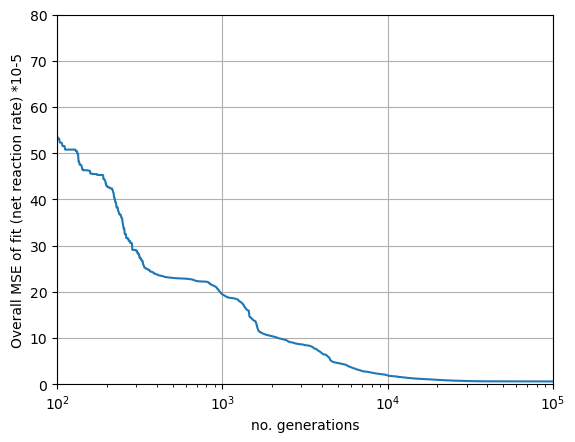

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900756977586495
-8.401011836905177
-7.601284039849961
-8.800584788157517
-8.30139489823021
-7.107147643615244
-8.098393389431315
-10.443434016201774
-7.706550912301682
-6.805844901968222
-7.306596655505939
-8.005397062255954
-7.908862370699411
-6.803363048572673
-7.403325855581366
-7.406287086372616
-7.90017643769812
-9.0986931753244
-8.388006991104866
-6.5016605376230965
-7.301682801662466
-6.708811535717224
-7.508861922231844
-11.999678342154931
-7.304276139098668
-7.8043560482496
-1.3010299992914305


In [37]:
res.X

array([ -7.90075698,  -8.40101184,  -7.60128404,  -8.80058479,
        -8.3013949 ,  -7.10714764,  -8.09839339, -10.44343402,
        -7.70655091,  -6.8058449 ,  -7.30659666,  -8.00539706,
        -7.90886237,  -6.80336305,  -7.40332586,  -7.40628709,
        -7.90017644,  -9.09869318,  -8.38800699,  -6.50166054,
        -7.3016828 ,  -6.70881154,  -7.50886192, -11.99967834,
        -7.30427614,  -7.80435605,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900756977586495
-8.4: -8.401011836905177
-7.6: -7.601284039849961
-8.8: -8.800584788157517
-8.3: -8.30139489823021
-7.1: -7.107147643615244
-8.1: -8.098393389431315
-10.9: -10.443434016201774
-7.7: -7.706550912301682
-6.8: -6.805844901968222
-7.3: -7.306596655505939
-8.0: -8.005397062255954
-7.9: -7.908862370699411
-6.8: -6.803363048572673
-7.4: -7.403325855581366
-7.4: -7.406287086372616
-7.9: -7.90017643769812
-9.1: -9.0986931753244
-8.4: -8.388006991104866
-6.5: -6.5016605376230965
-7.3: -7.301682801662466
-6.7: -6.708811535717224
-7.5: -7.508861922231844
-11.8: -11.999678342154931
-7.3: -7.304276139098668
-7.8: -7.8043560482496
R-value: 0.9964810719257514
R2: 0.9929745267062945
